# Heuristiques pour FSP

In [1]:
import numpy as np
from pyscheduling.FS import FmCmax, FlowShop
import pickle

import time

In [2]:
instance=FmCmax.FmCmax_Instance.read_txt("./data/random_instance.txt")

In [3]:
n = instance.n
m = instance.m
M = np.array(instance.P)
M , M[n-1][m-1]

(array([[71, 79, 85, 82, 83],
        [84, 71, 66, 68, 81],
        [78, 81, 75, 72, 87],
        [78, 75, 66, 72, 88],
        [72, 88, 83, 85, 88],
        [86, 88, 79, 82, 78],
        [75, 66, 86, 78, 78],
        [80, 79, 66, 83, 78],
        [73, 73, 67, 77, 71],
        [80, 77, 83, 78, 67]]),
 67)

In [11]:
M.shape

(500, 20)

## Makespan

In [12]:
def compute_makespan(schedule, p):
    _, m = p.shape
    n = len(schedule)
    c = [[0]*m for i in range(n)]
    for i in range(n):
        for j in range(m):
            if i == 0 and j == 0:
                c[i][j] = p[schedule[i]][j]
            elif i == 0:
                c[i][j] = c[i][j-1] + p[schedule[i]][j]
            elif j == 0:
                c[i][j] = c[i-1][j] + p[schedule[i]][j]
            else:
                c[i][j] = max(c[i][j-1], c[i-1][j]) + p[schedule[i]][j]
    return c[n-1][m-1]

## Heuristique de Palmer (1965)

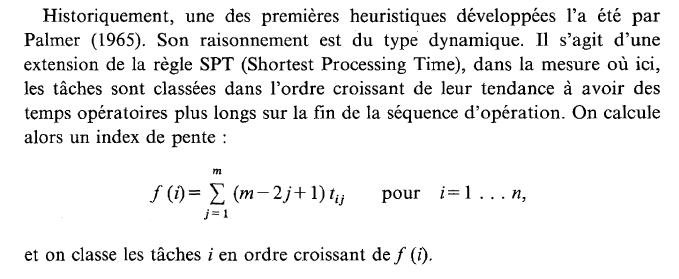

In [13]:
def f_palmer(i,m,M):
    somme = 0
    for j in range(m):
        somme+= (m - 2*j + 1) * M[i][j] 
    return somme


def heuristique_Palmer(M):
    n, m = M.shape

    list_taches = [i for i in range(n)]
    list_taches.sort( key=lambda i:  f_palmer(i,m,M) )

    return list_taches , compute_makespan(list_taches,M) 

In [56]:
heuristique_Palmer(M)

([48,
  44,
  57,
  33,
  21,
  95,
  71,
  50,
  41,
  55,
  83,
  63,
  73,
  9,
  93,
  53,
  26,
  52,
  92,
  29,
  61,
  24,
  22,
  49,
  88,
  58,
  19,
  12,
  91,
  1,
  37,
  39,
  6,
  77,
  38,
  30,
  65,
  60,
  99,
  72,
  20,
  11,
  47,
  76,
  82,
  67,
  87,
  7,
  2,
  86,
  31,
  89,
  96,
  64,
  97,
  75,
  28,
  3,
  18,
  40,
  27,
  46,
  43,
  25,
  84,
  51,
  15,
  66,
  13,
  78,
  8,
  32,
  0,
  62,
  10,
  85,
  98,
  36,
  56,
  4,
  42,
  23,
  70,
  94,
  79,
  14,
  90,
  80,
  68,
  74,
  59,
  5,
  69,
  35,
  54,
  45,
  16,
  17,
  34,
  81],
 6096)

## Heuristique de Gupta (1971)

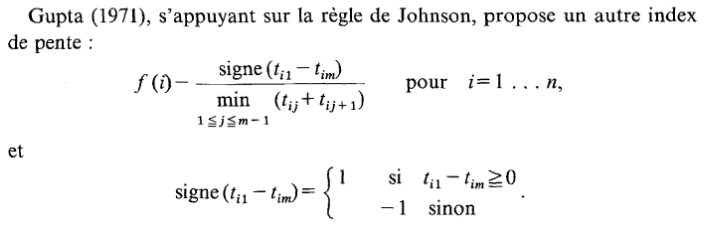

In [14]:
def f_gupta(i,m,M):
    signe = np.sign(M[i][0] - M[i][m-1])
    minimum = np.min(np.array([M[i][j-1]+ M[i][j] for j in range(m) ]))
    return  signe / minimum 


def heuristique_Gupta(M):
    n , m = M.shape

    list_taches = [i for i in range(n)]
    list_taches.sort( key=lambda i:  f_gupta(i,m,M) )

    return list_taches , compute_makespan(list_taches,M) 

In [55]:
heuristique_Gupta(M)

([44,
  73,
  57,
  76,
  71,
  93,
  21,
  89,
  20,
  28,
  38,
  33,
  41,
  63,
  50,
  82,
  48,
  49,
  25,
  6,
  27,
  55,
  92,
  24,
  75,
  39,
  97,
  26,
  88,
  72,
  74,
  13,
  31,
  37,
  19,
  30,
  29,
  12,
  2,
  9,
  61,
  1,
  99,
  0,
  7,
  86,
  70,
  78,
  18,
  35,
  59,
  32,
  66,
  42,
  8,
  34,
  84,
  46,
  58,
  85,
  36,
  14,
  15,
  60,
  69,
  77,
  96,
  83,
  87,
  43,
  67,
  10,
  22,
  98,
  65,
  94,
  3,
  16,
  4,
  40,
  68,
  79,
  53,
  91,
  47,
  51,
  17,
  64,
  80,
  62,
  45,
  23,
  81,
  52,
  5,
  54,
  90,
  95,
  11,
  56],
 6655)

## Heuristique CDS de Campbell, Dudek et Smith (1970)

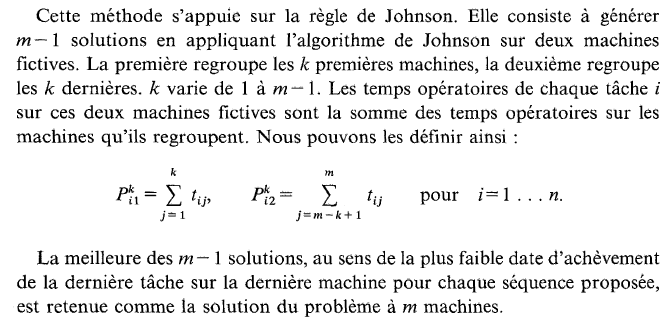

In [15]:
def johnson_method(processing_times):
    
    jobs, machines = processing_times.shape
    #print(jobs,machines)
    copy_processing_times = processing_times.copy()
    maximum = processing_times.max() + 1
    m1 = []
    m2 = []
    
    if machines != 2:
        raise Exception("Johson method only works with two machines")
        
    for i in range(jobs):
        minimum = copy_processing_times.min()
        position = np.where(copy_processing_times == minimum)
        
        if position[1][0] == 0:
            m1.append(position[0][0])
        else:
            m2.insert(0, position[0][0])
        
        copy_processing_times[position[0][0]] = maximum
        # Delete the job appended
    return m1+m2

In [16]:
def heuristique_CDS(M):
    m = M.shape[1]
    solutions = []
    makespans = []

    for k in range(1,m):
        P1 = M[:,0:k].sum(axis=1) # sommer les durées sur les k premières machines
        P2 = M[:,m-k:m].sum(axis=1) # sommer les durées sur les m-k dernières machines
        P1_P2 = np.hstack([P1[:,None],P2[:,None]]) # créer une matrice à deux colonnes avec P1 et P2

        johnson_seq = johnson_method(P1_P2) # appliquer la méthode de Johnson sur P1_P2

        solutions.append(johnson_seq)
        makespans.append(np.apply_along_axis(compute_makespan, 0, johnson_seq, M)) # calculer le makespan de v avec M

    score = np.min(makespans) # trouver le score minimal
    return solutions[np.argmin(makespans)], score # renvoyer la solution correspondant au score minimal

In [54]:
heuristique_CDS(M)

([44,
  21,
  33,
  57,
  53,
  93,
  48,
  55,
  87,
  24,
  49,
  95,
  41,
  63,
  92,
  39,
  83,
  47,
  89,
  40,
  37,
  82,
  61,
  50,
  71,
  9,
  10,
  58,
  91,
  73,
  96,
  1,
  26,
  2,
  72,
  77,
  12,
  29,
  22,
  46,
  7,
  52,
  66,
  31,
  18,
  99,
  88,
  30,
  67,
  6,
  32,
  70,
  42,
  59,
  0,
  86,
  78,
  76,
  25,
  97,
  35,
  51,
  34,
  85,
  27,
  74,
  65,
  62,
  8,
  84,
  4,
  68,
  36,
  79,
  94,
  14,
  13,
  64,
  3,
  19,
  11,
  60,
  81,
  15,
  75,
  69,
  16,
  80,
  43,
  98,
  90,
  17,
  5,
  20,
  45,
  28,
  23,
  38,
  56,
  54],
 6024)

## Heuristique de PPE de Park, Pegden et Enscore (1984)

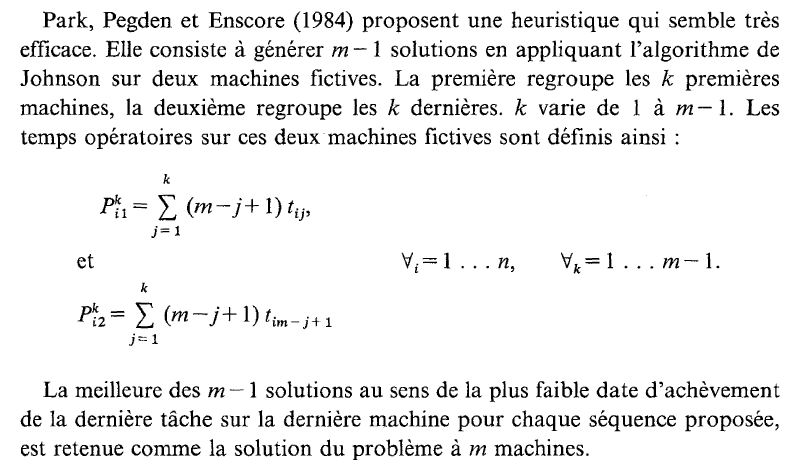

In [17]:
def heuristique_PPE(M):
    m = M.shape[1]
    solutions = []
    makespans = []

    for k in range(1,m):

        alpha = [m - j + 1 for j in range(k)]

        alpha = np.tile(alpha, (M.shape[0], 1)) # répéter le vecteur alpha
        
        P1 = np.sum(M[:, 0:k] * alpha, axis=1) # calculer la somme des lignes
        P2 = np.sum(M[:, m-k:m] * alpha, axis=1)
        
        z = np.hstack([P1[:,None],P2[:,None]]) # créer une matrice à deux colonnes avec P1 et P2

        v = johnson_method(z) # appliquer la méthode de Johnson sur z

        solutions.append(v)
        makespans.append(np.apply_along_axis(compute_makespan,0,v,M)) # calculer le makespan de v avec M

    score = np.min(makespans) # trouver le score minimal
    return solutions[np.argmin(makespans)], score # renvoyer la solution correspondant au score minimal

In [53]:
heuristique_PPE(M)

([44,
  57,
  21,
  95,
  55,
  53,
  41,
  48,
  33,
  63,
  83,
  92,
  73,
  26,
  19,
  29,
  87,
  77,
  49,
  65,
  71,
  50,
  60,
  61,
  91,
  22,
  52,
  88,
  3,
  47,
  9,
  96,
  51,
  12,
  6,
  94,
  58,
  2,
  67,
  7,
  1,
  31,
  30,
  18,
  99,
  32,
  70,
  59,
  42,
  78,
  46,
  35,
  84,
  25,
  66,
  68,
  74,
  85,
  69,
  36,
  97,
  10,
  0,
  76,
  75,
  43,
  34,
  39,
  13,
  72,
  90,
  86,
  79,
  4,
  82,
  23,
  37,
  89,
  64,
  8,
  62,
  5,
  27,
  11,
  98,
  14,
  40,
  24,
  16,
  15,
  80,
  17,
  81,
  45,
  28,
  93,
  20,
  56,
  38,
  54],
 6018)

## Heuristique de Hundal et Rajgopal (1988)

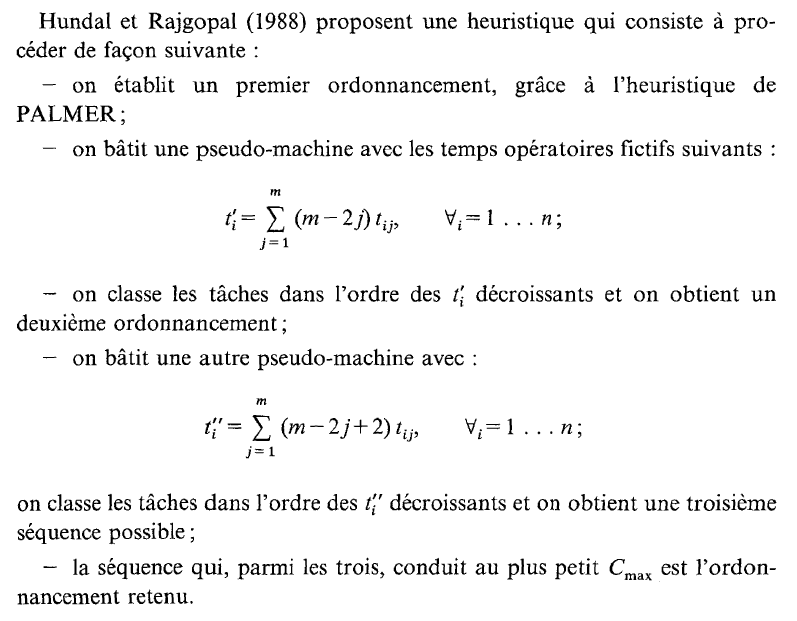

In [18]:
def heuristique_Hundal_Rajgopal(M):
    m = M.shape[1]

    # 1e ordonnancement avec PALMER
    seq_PALMER, makespan_PALMER = heuristique_Palmer(M)
    
    # 2e ordonnancement 
    alpha = [ m - 2*j for j in range(m)]     
    alpha = np.tile(alpha, (M.shape[0], 1)) # répéter le vecteur alpha
    T1 = np.sum(M[:, 0:m] * alpha, axis=1) # calculer la somme des lignes

    liste_tache = np.arange(M.shape[0])
    seq_T1 = liste_tache[np.argsort(-T1)]
    
    # 3e ordonnancement
    alpha = [ m - 2*j + 2 for j in range(m)]
        
    alpha = np.tile(alpha, (M.shape[0], 1)) # répéter le vecteur alpha
    T1 = np.sum(M[:, 0:m] * alpha, axis=1) # calculer la somme des lignes

    liste_tache = np.arange(M.shape[0])
    seq_T2 = liste_tache[np.argsort(-T1)]
    
    # Comparaison 
    makespan_T1 = compute_makespan(seq_T1 , M)
    makespan_T2 = compute_makespan(seq_T2 , M)
        
    best_makespan = np.array([makespan_PALMER, makespan_T1 , makespan_T1])
    
    best_makespan = np.argmin(best_makespan)
    
    seq_dict = {0: ('Palmer', seq_PALMER, makespan_PALMER), 1: ("t'", seq_T1, makespan_T1), 2: ("t''", seq_T2, makespan_T2)}

    return seq_dict[best_makespan] # retourne le tuple correspondant à l'indice   

In [52]:
heuristique_Hundal_Rajgopal(M)

('Palmer',
 [48,
  44,
  57,
  33,
  21,
  95,
  71,
  50,
  41,
  55,
  83,
  63,
  73,
  9,
  93,
  53,
  26,
  52,
  92,
  29,
  61,
  24,
  22,
  49,
  88,
  58,
  19,
  12,
  91,
  1,
  37,
  39,
  6,
  77,
  38,
  30,
  65,
  60,
  99,
  72,
  20,
  11,
  47,
  76,
  82,
  67,
  87,
  7,
  2,
  86,
  31,
  89,
  96,
  64,
  97,
  75,
  28,
  3,
  18,
  40,
  27,
  46,
  43,
  25,
  84,
  51,
  15,
  66,
  13,
  78,
  8,
  32,
  0,
  62,
  10,
  85,
  98,
  36,
  56,
  4,
  42,
  23,
  70,
  94,
  79,
  14,
  90,
  80,
  68,
  74,
  59,
  5,
  69,
  35,
  54,
  45,
  16,
  17,
  34,
  81],
 6096)

## Heuristique de HAM

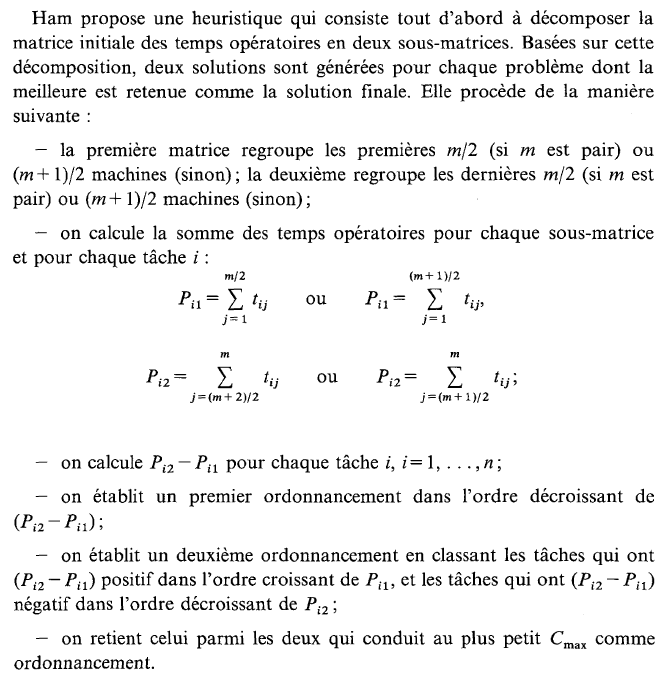

In [19]:
def heuristique_Ham(M):
    m = M.shape[1]

    P1 = np.sum(M[:,:m//2], axis=1) # somme des durées sur la première machine
    P2 = np.sum(M[:,m//2:], axis=1) # somme des durées sur la deuxième machine
    P2_P1 = P2 - P1 # différence entre les deux sommes
    ordre = np.flip(np.argsort(P2_P1)) # tri par ordre décroissant

    # Première solution
    ordre_1 = ordre
    Cmax1 = compute_makespan(ordre_1 , M) # makespan de la première solution

    # Deuxième solution
    indice_positif = ordre[P2_P1[ordre] >= 0] # indices des tâches avec un indice positif ou nul
    indice_negatif = ordre[P2_P1[ordre] < 0] # indices des tâches avec un indice négatif

    indice_positif = [indice_positif[i] for i in np.argsort(P1[indice_positif])] # tri croissant selon P1
    indice_negatif = [indice_negatif[i] for i in np.flip(np.argsort(P2[indice_negatif]))] # tri décroissant selon P2
   
    ordre_2 = [int(i) for i in np.concatenate((indice_positif, indice_negatif))]
    Cmax2 = compute_makespan(ordre_2 , M) # makespan de la deuxième solution

    if (Cmax1 > Cmax2):
        return ordre_1, Cmax1
    else:
        return ordre_2, Cmax2

In [51]:
heuristique_Ham(M)

(array([52, 48, 95, 83, 21,  6, 33, 71,  9, 63, 57, 44, 67, 29, 26, 99, 61,
        55, 96, 18, 53, 92, 58, 76, 50, 32, 43, 12, 91, 65,  1, 73, 22, 97,
        41, 84,  7, 24, 77, 49, 42, 88, 30, 70, 39, 75, 46, 19, 87, 11, 36,
        37, 82, 93, 78,  3,  2, 72, 40, 51, 23, 15, 10, 64, 85,  8, 94, 89,
        47,  0, 38, 66, 59, 31, 60, 14, 86,  4, 27, 68, 25, 28, 98, 56, 79,
        13, 74, 69, 20, 34,  5, 90, 35, 80, 45, 62, 16, 17, 54, 81],
       dtype=int64),
 6366)

## Heuristique de NEH (1983)

Principe

In [9]:
def heuristique_NEH(M):
    n , m = M.shape
    p = M.copy()

    # Step 1: Compute the processing time of each job
    processing_time = [sum(p[i]) for i in range(n)]

    # Step 2: Sort the jobs in decreasing order of processing time
    sorted_jobs = sorted(range(n), key=lambda i: processing_time[i], reverse=True)

    # Step 3: Initialize the schedule with the first job
    schedule = [sorted_jobs[0]]

    # Step 4: Insert each subsequent job into the schedule in a position that minimizes the makespan
    for i in range(1, n):
        best_pos = -1
        best_makespan = float('inf')
        for j in range(len(schedule)+1):
            temp_schedule = schedule[:j] + [sorted_jobs[i]] + schedule[j:]
            temp_makespan = compute_makespan(temp_schedule, p)
            if temp_makespan < best_makespan:
                best_makespan = temp_makespan
                best_pos = j
        schedule.insert(best_pos, sorted_jobs[i])

    return schedule, compute_makespan(schedule, p)

In [20]:
heuristique_NEH(M)

([8, 3, 6, 0, 1, 2, 4, 7, 5, 9], 1107)

## Heuristique PHD

In [57]:
def heuristique_phd(process_times):
    """
    Compute a schedule for the flow shop permutation problem using the Han and Dejax procedure.

    Args:
        process_times (list of lists): A list of lists representing the processing times for each job on each machine.
                                      The i-th element of the list represents the processing times for the i-th job,
                                      and the j-th element of the i-th element represents the processing time for the
                                      i-th job on the j-th machine.

    Returns:
        list of ints: A list of integers representing the order in which the jobs should be processed.
                      The i-th element of the list represents the i-th job to be processed.
    """
    num_jobs ,  num_machines = process_times.shape
    jobs = np.arange(M.shape[0])
    
    # Divide the jobs into batches based on their processing time
    batches = [[] for _ in range(num_jobs)]
    for i in range(num_jobs):
        tpt = sum(process_times[i])
        batches[tpt].append(i)

    # Sort the batches in decreasing order of TPT
    batches = [batch for batch in batches if batch]
    batches.sort(key=lambda batch: sum(process_times[i] for i in batch), reverse=True)

    # Sort the jobs in each batch in decreasing order of LPT
    for batch in batches:
        batch.sort(key=lambda job: max(process_times[job]), reverse=True)

    # Schedule the jobs in each batch
    schedule = []
    for batch in batches:
        batch_schedule = []
        for job in batch:
            machine_times = [(machine, process_times[job][machine]) for machine in range(num_machines)]
            machine_times.sort(key=lambda x: x[1])
            batch_schedule.append((job, machine_times))
        while batch_schedule:
            _, (machine, time) = batch_schedule.pop(0)
            job = min(batch_schedule, key=lambda x: x[1][machine])[0]
            batch_schedule.remove((job, (machine, process_times[job][machine])))
            schedule.append(job)

    return schedule

In [ ]:
heuristique_phd(M)

## Test avec intances de Taillard 

In [64]:
with open("./data/Taillard08.pkl", "rb") as f:
    taillard = pickle.load(f)

In [65]:
instance_id = 2

n = taillard[instance_id]["nj"]
m = taillard[instance_id]["nm"]
P = np.array(taillard[instance_id]["P"]).transpose()
upper_bound = taillard[instance_id]["ub"]
lower_bound = taillard[instance_id]["lb"]

instance = FmCmax.FmCmax_Instance(name='',n=20,m=10,P=P)

M = np.array(instance.P)
M

array([[47, 94, 56, 59, 74, 78, 17, 74, 12, 98],
       [12, 93, 31, 94, 26, 58, 60, 71,  5, 97],
       [19, 53, 66, 87, 84, 53, 51, 89, 15, 69],
       [32, 63, 73, 22, 41, 17, 61, 81, 16, 24],
       [63, 41, 96, 59,  3, 36, 26, 59, 64, 10],
       [78, 81, 31, 30, 46,  3, 60, 62,  6,  7],
       [77, 74, 41,  2, 39, 83, 80, 64, 65, 79],
       [51, 37, 79, 55, 90, 91, 45, 62, 53, 84],
       [59, 52, 66, 36, 62, 73, 20, 67, 19, 50],
       [54, 24, 49, 73, 63, 81, 62, 68, 93, 86],
       [48, 45, 39, 98, 74, 74, 55, 87, 21, 24],
       [96, 19, 28, 15,  4,  2, 25, 47, 38, 28],
       [52, 72, 24, 54, 37, 31, 68, 60, 54, 73],
       [42, 62, 85, 55, 75, 37, 56, 10, 46, 72],
       [57, 78, 64,  3, 72, 78,  5, 76, 33, 19],
       [30, 83, 37, 54, 30, 74, 14, 46, 38, 20],
       [34, 98, 85, 89, 43, 51, 20, 56, 32,  8],
       [77, 83, 40, 50, 95, 41, 19, 48, 12, 20],
       [80, 58, 35, 68, 41, 78, 92, 61, 90, 45],
       [ 7, 61, 77,  9, 97, 26, 88, 13, 46, 59],
       [11, 47, 30, 

In [66]:
print(f'Sequence : {heuristique_NEH(M)[0]}')
print(f'Makespan : {heuristique_NEH(M)[1]}')
print(f'Upper Bound : {upper_bound}')
print(f'Lower Bound : {lower_bound}')

Sequence : [44, 21, 20, 57, 95, 37, 53, 63, 82, 41, 50, 64, 86, 33, 72, 26, 98, 65, 40, 48, 93, 60, 4, 55, 88, 11, 87, 62, 91, 14, 39, 71, 5, 77, 31, 24, 8, 12, 29, 66, 9, 73, 85, 2, 38, 99, 51, 25, 83, 34, 22, 6, 92, 49, 75, 78, 89, 94, 1, 61, 79, 13, 27, 84, 97, 74, 90, 76, 18, 30, 69, 32, 67, 7, 46, 16, 70, 0, 42, 59, 81, 35, 58, 52, 17, 47, 43, 10, 36, 68, 15, 3, 19, 96, 23, 80, 28, 45, 54, 56]
Makespan : 5824
Upper Bound : 5677
Lower Bound : 5623


# Génération des fichiers pour les benchmark de Taillard 

In [3]:
#Benchmark 12
Ts=[" 36 21 87 18 33 68 24 30 44 57 93 53 76  8 10 34  1  6 19 85 47 49 59 15 44 56 20 82  4 65 15 24 52 28 80 75 45 79 33 55 97 38 83 33 37 76 93 50 27 24 84 70 14 45  4 23 66 71  7 80 26  3 29 76 85 87 80 33 29 85 33 22 20 66 91 26 68 38 52 80 74 53 37 96 87  2 35 11 85  4 15 78 83 47 80 70 41 68  8 25 79 17 20 18 76 11 37 50 20 53 77  3 69 70 92 23 29 75 53 63 47  1 67 43 86 20 96 19 57 45 73 86 37 99  9 98 69 23 61  9 72 76 71  9 11 20 53 17 30 62 53 43  2 87 51  4 23 12 51 96 31 80 35 83 38 48  4 84 20 80 92 23 79  1 67 64 99 70 46 42 15  3 10 19 14 52 95 29 16  4 78 28 48 81 88 77  5 67 98 51 37 57 73 26 76 91 42 24 79 82 81 99 89  5  2  2 42 67 75 63 96 83 63 52  9 83 24 36 67 32  4 94 21 33 72 33 67 73 24 37 59  8 17 47 63 28 98  4 57  8 78 94 82 72 16 35 39 59 45 83 41 60 52 59 99 11 71  4 85  2 96 97 34 67 19 95 58 48 69  5 72 42 55 45 89 23 54  7 67 40 73 34 19 80  7 11 69 42 75 24 79 52 51 12 53  8 16 21 62 99 31 22 30 67 24 43 56 70 22 97 19 33 34  4  4 87 29 46 19 92 56 13 28 64 66 14 66 48 78 88 54 63 94 17 39 35  6 98 96 66 72 76 91 85 64 27  6 22 31 69 16 30 94 20 84 95 92 31 47 93 81 82 67 41 88 72 70  7 35 35 12 25 43 77 45 27 80 67 12 63 94  5 41 24 68 90 97 66 15 19 55 91 99 12 73 52 24 46 65 48 19 35 19 67 99 99 11 50 34 66 74 64  8 18 77 92 85 43 63 70 13 18 28 77 94 47 77  4 12 17 84 72 69 45 51 33 14 99 49 36 97 35 80 94 38 25 80 18 90 63 55 44 93 48 68 53 15 79  4 95 95 19 58 58  9 31 37 26 54 69 15 75 81 66 21 27 87 19 33 64 20 70 26 68  5 10 49 38 25 90\
4 19  7 29 71 79 20 84 59 30 43 33 76 33 90 42 94 61 76 87 71  5 82 92 51  3 12 21 58 66 63 46 71 79 84 56 84 72 35 48 93 56 20 19 64 30 11 41 38 93 86 58 63 99 28 45 15 28 44 70  8 67 67 75 75 50 33 51 32 87 99 67 66 32 76 34 89  9  7 86 26 80 44 53 38 32 81 46  1 53 26 83 24 35 82  2 63 44 45 26  3 66 63 37 47 23 98  2  7 48 49 27 36 10 17 22 75 71 19 33 68 82  4 37 62 89 62  7 14 26 69 80 94  2 66 34 81 74 68 31 91 90 10 61  7 72 35 41 78 19 24 45  8 39  5 20 79  8 46 10 83 56 75 26 76 35 63 62 14 49 16  9 49 85 61 27 98 36 32 83 34 13 39 17 81 84 46 50 63 81 44 56 44 81 96  8 51 64 45 41 34 79 83 16 58 13 56 55 14 65 79 91 62 55 59 21  1 11 51 84 51 18 71 43 37 68 37 39 43 31 63 71 68 86 65 82 78 74 93  7 33  3  1 34 54  8 87 25 83 57 59  3 46 24 99  3 45 12 89 88 19 77 41 52 93 90 47 50  2 24 50 80 94 40 38 35 46 34 10 74  5 56 52 69  3 40 26 29 24 81 37 93 46 15 12 74 74 29 50 86 12 50 70 50 47 72 96 46  9 13 85 20 59 94 31 80 80 77 80 90  7 23 59 57 26 64 37  2 94 51 39 57 42 42 48 42 84 48 33  2 10 37 47 26 46 38 21 57 51 27 72 99 81 29 94 48 86 94 87 50 22 33 63 51 53 12 82 54  7 71 95 74 67 30 57 36  5 33 19 85 41 43  5 12 47 83 75 16 91 72 86 16 32 83 44 91 41 43 29 63 97 70 65 90  4 75 38 42  7 27 12 45 69 78 66  2 81 76 67 98 52 63  6 11 84 72 90 84 75 17  3 87 19 47 73 13  8 56 65 82 98 78 10  2 68 15 82 73 57 66 30  5 57 74 35 58 10 76 32 67 42 54 39 41 11 91 63 26 24 70 31 22 36 44  7 61 20 99 99 91 46 52 73 96 16 95 33 64 61 26 39 33 16 58 92 53 13 44 64 89\
25  7 94 97 25 54 78 35 63  9 84 76 88 20 68 15 23 91 85 41 24 15 87 67 27 35 82 47 40 66 51 74 20  3 46 19 27  3 11 20 35 41  4 90 77 10 55 26 28 60 86 37 51 10 31 55 99  1 18 13 21 30 58 65 19 95 44 13 99 29  5 24 56 18 45 66 58 29 29 75  5 70 60  3 67 36  8 16 84 92 81 36 93 35 92 37 68 98 54 41 18 50 52 63 98 30 23  3 73 17 57 22 60 18 67  9 61 75  2  1 89 54 86 62 23 40 33  8 49 81 92 73 73 28 55 53 78 49 49 80 94 58  7 99 29 77 12 99 38 79 31 46 40 36 46 92 17 69 67 16 30 55 98 84 42 83 56 28 40 11 66 18 47 44 18 63 22 73 59 74 88 46 13 21 23  3 99 93 13 56 59  7 58 68 49 64 94 35 81 94 75 34 32 82 94 20 36 30 82 45 65 47 49 36 65 67 71 34 94 94  8 30 64 65  1 42 41 50 63 87 72 84 93 69 25 58 71 25 57 43 54 27 75 18 16 97 91 96 12 89 26  6 91  9 76 49  4 72 23 68  1 96 66 26 62 98 63 16 18 53 93 51 31 73 44 30 96 58 72 10 57 44 73 85 28 61 63  2 83 75 73 78 66 75 66 99 43 53 65 49 84 20 69 53 92  5  1 54 78 99  8  7 81 15 32  3  7 52 95 34  4 23 22 75 71 33 32 13 65 90 90 72 88 95 30 93  4 38 38  1 57 54 84 42 84 94 25 77 58 22 46 61 93 80 19 99  3 65 71 74 13 69  7 34 14  5 12 94 39 36 46 30 74 51 72 37  9 66 30 75 48 95 95 39 32 82 63 18 41 27 13 58 91 89  2 70 43 19 27 43 68 51 32 78 93 35 15 39 89 17 51 46 58 77 64 81 74 31 34 43 81 79 74 80 76 71 41 12 71 67 37 34 16 26 76 92  7 85 54 43 31 19 39 73 31 65 18  1 16 83  5  7 11 86 38 47 70 10  4 77  8 83 74 24 76 61 33  3 58 37 52 75 34 12 52 53 92 99 56 68 30 26 90 58  1 60 37 83 96 62  3 24 62 73 55 30 20 87 14 57\
68 75 96 60 48 26 17 42 61 32 12 15  9 74 99 53 51 51 29 55 49 42  5  3 58 82 93 13  7 92 28 59 15 59 57 26 34 95 95 58 52 88 71 42 47 73 23 92 20 50 86 61  9 27 66 41 51 43 91  7  3 33 17 90 75 29  2 66 76 48 13 93 39 72 90 11 98 71 34 37 69 79 35 90 61 86 59 14 90  3 38 34 84 26 42 59 81 99 90  9 30 83 83 17 19 41  8 91 26 61 18 31 12 63 35 94 88 78 76 56  6 38 89 10 65  1 70 41 47 85 26  8 97 58 43 45 90 94 30 54 92 92 37 19  5 83 62 91 75 71 72 72 78 98 53 40 16 36 32 17 71 26 43 63 98 10 45 70 24 69 30 16 63 58 86 22 13 60 83 69 18 73 21 83 15 15 20  2  9  4  1 66 10 62 86 37 81 65 57 41 27 90 82 33 23 40 98 34 48 16 85  4 50 84  6 26 20 80 52 59 64 85 11 25 77 77 37 42 89 79  2  1 93 48 82 65 33 52 73 92 65 81 36 49 41  3 25 25 40 63 46  1 98 69 56 25 21 68 58 54 48 95  7 64 94  1  9  1 99 94 77 53 48 30 88 77 14 27  2 16 76 29 81 18 14 54 10 44 17 81 40 40 36 62 20 12 84 83 27 80 98 67 37 91 31 13 46 64 54 99 35 92 61 29 12 93 85 48 74 90 92 97 84 45 32 29 56 59 87 38 18 81 43 85 50 63 49 35 47 14 73 75 17 71 63 79 45 44 51 20 98 43 79 66 78 16 78 25  4  5 82 82 34 66 31 20 55 49 65 14 16 44 55 66 70 98 41 44 52 97 54 15 71 60 82 24 51 12 12 88 73 71  4 49 23  2 91 15 83 97 21 47 80 68 24 54 42 37 76 55 82 65 70 30 69 40 33 33 75 81 46 43 50 89 32 19 55 26 18 87 74 52 95 81 52 15 89 43 33 26 40 48 87 10 45 73 64 33  8 11 11  4 52  8 84 81 38 85 33 64  1 70 74 87 79 65 84 15 83 20 98  8 88 58 55  8 54 40 39 81 72 14 64 99 54 39 41 69 34 58 22 57 95 57 23 20 16 26 45 37\
60 14 46 26 29 57 96 58  1 17 89 28 24 97 42 20 17 96 37  7 69 41 24 38 12  9 99 96 28 24 79 68 54 51 65 85 39 58 53 67 62 26 54 94 26 47 50 70 50 91 12 47 41 92 59 48 52 21 76 91 79 29 30 56 39 91 57  5 25 34 93 73  9 64 22 91 55 38 30 25 99 92 15  4 73 65 39 24 93 36 46 56 75 16 28 66 55 58 16 97 51 82 89 78 22 75 60 24 82 27 60 71 43 46 67 24 26 99 15 49 12 56 43 40 34 63 11 28 75 77  1 92  4 37  3 63 19 69 28 61 59 47 24 29 16 90 91 67 81 46 75 86 93 28 78 24 51 99 31 12 68 14  1 41 24 18 22 27 99 31 54 76  9 32 52 71 92 96 63 80 22 37 20 92 88  5 31 91 39 88 51  2 62 25 42 64 92 56 38 59 86 92 86 37 34 66 39 71 73 54 56 77  2 40 20 57 43 29 53 74 27 76 94 31 76 45 52 30  7 38 31 17 23 49 24 94 34 72 20 16  6 54 96 37 44 45 97 34 80 62  4 49  1 40 63 45 32 88 23 39 80 76  7 58 53 87 69 89  3 21  7 65 34 36 81 23 25 79 64 99 59 75  8 84 77 51 21 20 24 51 48 61 19 65 60 35 10 51 18 65 26 34 60 27 11 42 76 34 26  2 31 66 41  1  5 72  5 71  4 99 14 63 82  3 45 46 33 96 31 30 85 73 94 20 42 44 66 93 74 85  9 37 16 34 25 42 46 64 58 57 24 92 84 18 87 49 45 11 21 69 93 90 69 22 21 43 82 41 44 68 79 54 64 56 46 79 44 54  5  9 84 37 98  6 98 57 82 68 46  1 59 30 12 95 28 74 98 50 87 78 42 76 85 92 68 30 32 87 23 80 26  3 92 56 67 22 21 36 85 79 72 34 27 54 97 67 37 87 95 19 42 35 70 59 79 99 34 66 66 75 28 55  2 72 93 21 54 40  7 32 73 91 71 48 43 54 91 54 33 17 47 83 74 83 78 54 58 10 81 24 75 96 19 65 23  4 80 76 40 54 26 83 89  8  4 91 30 77 85 48 17 97 15 90 16 28 94 65  2 84\
12 46 89 80 41 55 97 93 38 55 20 43  3 26 28 29 77 51 94 93 81  7 53  6 94 37 45 51 45  7 88 64 12 15  1 24 89 38 28  3 36 55 42 31 39 72 25 10 16 34 56 67 25 18 40 27 98  9 95 88 68  4 16 50  6 11  8 52 62 14  5  7 58 24 54 39 49 63 17 26 96 53  3 74 52 21 45 91 22 22 12 98 34 26 49 27 48 62 33 98 40 71 30 12 90 64 48 63 94 11 75  5 70 25 57 38 82 99 43 82 54 72 72 27 58 91 55  7 50  1 99 46 18 94 77 70  4 76 72 71 57 66 66 60 70 85 43 38 49 60 28  8 86  6 26 92 55 43 12 55  3 48 87 82 38  9 47 72 52 44 20 57 68 96 96 68 94 94 87 66 13 19  9 32 21 79 74 69 83  1 27 39 19 80 56 61 13 18 37 33 29 72 97 86 64 74 69  3 15  3 67 31 39 20 10 19 16 77 22 75 98 78 74 30 23 63 59 39 23 33 64 31 11 45 95 23  1  2 95 85  1 38 90 21 51 50 33 43 40 58 33 71 89 91  8 84 91 56 36 10 25  8 13 65 52 15 28 43 88 34 96 67 43 12 85  9 55 11 62 80 23 14 69 68 73 16 97 26 23 50 13  6 84 97  1 83 94  9 68 63 33 51 92 58 76 63  2 33 99 87 68  2 40  6 42 38 83 10 44 41 40 38 50 50 45 10 27  9 54 13 15 61 68 12 36 49 12 72 72 39 31 29 46 79 99 48 54 85 11  3 89 19 13 16 18 54 92 52 19 39 96 54 39 73 54 97 42 31 30 42 37 43 49 11 50 20 75 30 73 28 58 81 10 46 28 99  8 64 80 21 66 18 64 17 25 58 55 16 97 10 81 28 64 64  8 82  6 19 10 77 71 57 11 66 99 77 96 22 91 77 82 13 84 67  2  5 34 94  1 47 30  4 17 10 27 73 85 55 75  9 43 26  3 88 36 75 31 69 53 96  7 25 34 53 57 45  4 40 49 77 60 80 69 92 99 86 17 11 19  6 96 90 52 28  2 19 24 38 34  7 80 67 83 24 37 55 33 88 87 81 22 91 71 33 34 40 40 68 60 58\
86 76 99 33 25 64 64 84 11 24 92 96 62 79  7 43 37 20  3 58 65 73  7 45 62  4 61 55 80 71 15 12 47 81 29 21 33 65 92 88  5 69 42 50 90 82 74 45 66 52 71 19 41  8 73 98 55 13 27 22 93 43 96 68 56 51 13 30 66 14 35 50 62 32 13 17 35 43 87 91 92 21 84 57 33 58 93  7 53 87 91 54  8 65  6 75 19 12 82 70 14 74 10 90 39 45 36 89 82 61 34 99 76 13 64 69 32  3 16 69 13 81 32 17 52 81  9 42 29 98 14  1 35 63 40 30 52 70 10 98 64 22 10 75 27  5 94 61 79 86 13 43 54 59 81 56 66 15 52 57 64 77 19 40 95 71 35 55 98 80 29 79 65 97 37 19 81  3 59  6 33 79 31 38 82  3 80 62 38 98 22  9 83 15 31 74 23  6 98 54 42 80 95 88 36 84 80 38 47 18 91 15 71 41 33 31 37  5 36 36 11 32 94 63  2 26 88 38 49 96 12 97  9 32 65 78 95 49  4 58 25 38 79 44 47 50 16 24 76 40 61 61 66 71  7 87 20 78 88 65 32 94 82 84  7 44 31 57 73 50 15 76  1 35 73  9 84 91 70 59 81 65 74 64  5 15 45 73 49 53 84 46  8 32 19 32 34 33 14 78 73 35 24 66 81 62  9 94  3 36 85 42 21 14  1  7 34 42 24 79 97 49 11 10 42 83 29 97 67 81 35 19 14 38 55 21 35 56 18 85 35 61 66 60 34 92 22 43 12  2 27 68 38 74 98 35 83 99 38 10 54 56 98  4 17 96 86 86 73 29 96  1 97 41 38 47 53 18 16 55 21 78 53 98 46 90 62 23 50 98 74 42 25 68 78 85 26 21 20 58 35 20 54 66 92 26 82 57 47 42  8 77 62 46 69 20 98 74 91 97  7 69 59 72 12 61 88 88 80 21 64 81 38 50 11 48 21 18 42 64 68  7 81 60 81 32 15 21 89 11 42 24 34 72 11 56 68 88 99  2 66 98 69 44 32 67 23 86 21 69 30 98 31 96 71 58 83 30 98  8 72 42 33 51  2 36 58 24 24 24 81 39 71  4 84  1 20 77 51 72\
87 25 16 47  1 20 54 31 16 91 72 24 30 28 75  3 93 59 38  5 11 56 91 27 90 63 80 55 65 99 66 45 94 81 76  2 67 19 90 51 54 22 36 77  7 93 96 23 71 37 32 72  1 41 71 48 68  1 43 37 42 79 69 43 76 27 95 95 12 66 30  7 11 90 95 43 46 71  1  4 83 12 76 14  2 91 87 78 56  3 67 55 22 33 53 25 36 11 25 77 68 23 20 75 42 11 94 61 76 11  1 18 27 97 35 63 67 99 86 67 83 69 39 63 35 13 66  7 97  9 22 76  3 61 59 37 45 67 86 56 18 42 56 23 77 17 62 68 19 98 47 51 14 45 25 81 35 94  3 11 27 72 72 65 47 84 30 78 53 69 38 77 67 29 94 61  4 95 96 99 12 83 54 15 57 91 46 46 43 94 82 21 50 16 16 16  3 10 47 44 56 87 97 14 50 98 70 23 68 11 55 10 14 33 37 35 86 57 28 83 79  3 68 82 72 76 44 11 41 87 57 58 27 39 77 23 29 36 18 42 76 17 32 28 90 45  6 25 69 74 98 63 62 80 86 32 74 34 32 89 52 71 25 29 87 79 22 77 21 87 56 26 81 89 62 86 53 17 74 13 89  8 38 51 53 90 26 76 67 64 85 48 85 58 87 91 39 10  5 90 34 21 40 44 12 32 22 67 88 78 61  9 99 30 57 13 97 59 66 49 43 65 52 35 55 74 79 37 76 99 28 21 98 87 39 60 91 52 27 50 22 93 79  4 14 53 41 93 86 28 84 49 16 10 70 43 89 45 23 45 72 46 80 36 92 96 77 26 47 34  9 47 34 35 42 50 28 73 18 66 55  9 85 91 89 83 30 57 70 15 28 62 93 73 44  2 99 87 71 65 78 23 27 13 68 65 93 43 39 42 30 24 87 46 69 54  5 30 25 99 99  1 54 64 57 25  9 47 52 24 17 81 79 70 41 13 74 28 33 19 82 33 19 29  5 98  4 46 44 20  8 37 54 47 75 22 41 56 83 49 30 72 15 93 91 65 75 41 38 13 62  1 49 13 74 46 96 58  2 14 79 39 84 85 10 41 41 94 73 19 55 92 86 13 58 45 84 35 85 86\
84 95 35 70  9 53 52 89 47 38  9 85 15 74 83  8 28 63 43 97 52 65 26 31 72 90 83 10 85 13 59 31 87  5  9 17 52 46 41 87 22 17 33 23 31 75 14 76 71 82 50 29  9 82 40 85 48 70 16 27 34 50 80 89 43  6  7  8 44 58 67 11 69 79 20 71 71 87 59 82 94 13 22  5 29 65  7 27 41 87 32  6 46 30 22 21 79 11 46 23 42 91 74 63 48 61 70 58 12 61 57 45 31 62 68  9 81 69 92 17 70 89  9 43 71 42 59 64 32 84 18 77 54 35 25 76 42 14 49 56 79 91 59 17 85 30 71 15 21 53  3 28 60  7 42 25 77 40  8 51 61 83  8 79 37 95 47 61 11 53 43 30 49 40 73 95 43  7 80 19 12 70  9 50 11 96 61 59 48 65 54  7  3 47 97 43 69 46 22 84 86 55 99 17 38 48 61 68 48 96 43 19 39 80  3  2 99  4 90 71 31 96 36 75 17 25 24 37 32 72 40 13 32 53 50  2 74 94 67 96 19 85 33 65 39 48 56 66 63 61 40 84 92 78 81 41 77 55 70  6 38 78 12 15 36 96 57 39 55 86 98 36 24 19 95 25 21 32 49 40 84 67 76 78 16 73 28 52 59 12 85 63 40 93 68 16 38 60 75 16 27 38 59 41 98 78 60 64 21 79  8 57 95 58 45 13  9 25 56  6 62 44 31 50 99 39 90 96 67 67 10 92 53 75 53  7  4 28 26 37  8 49 59 72 29 39 87 93 13 23 96 65 32 20 11 20 25 41 87 60 60 34 85 96 36  7 92 51 19 50 10 72 41  9 40 85 18 16  8 57  3 60 73 35 60  7 25 13 66 49 48 88 47 86  1 42  1 19 84  4 71 23 76 89 60 10 29 51 92 72 38 73  7 20 58 66 71 70 66 92  6 19 16 31 38 78  7 28 26 25 19 86 93 65 18 10 92 36 71 39 24 74 97 67 78 77 12 45 13 47 36 63 32 84 30 45 50 14 33 97 17 21 78 57 12 56 22 83 60 43 28 20 58 70 54 13 82 89 31 83 81 77 39 81 23 71 77 72 33 27 12 33 58 19 64 29 93 37 79 16\
36 54 76 91 11 51 53 30 38  6 12 39 41  8 56 86 36 33 99 44 86 50 32 51 14 73 71 16 28 83 79 19 70 58 73 99 86 99 64 26 66 47 50 67 48 92  9 61 50 63 93 32 10 56 96 69 54 43 85 96 98 64 34 26 95 54 85 91 32 88 92 82 91 79 26 87 40 98 38 56 48 51 78 15 58 32 56 70 51  2  1  7 91 34 64 53 39 59 70 88 33 81 80 54 69  2 53 33 62 23 78  1 47 35 15 12 13 18 62 45 62 15 94 19 24 72 30 35 27 48 15 22 10 85 88 32 96 17 47 27 44 64 68 68 57 99 50  7 12 84 67 91 83 54 99 98 11 76  7 51 10  7  9 89 42 97  4 66 96 71 32 74 39  6 35 45  8 76 95 59 29 54 87 40 35 71 62 99 53 23 42 23 69 93 41 85 98 38 22 53 65 82 11 38 78 76 95 30 21 84 21 31 28 67 16  5 86 87 25 38 16 33 77 47 70 27 23 88 40 57 14  6 58 73  8 97 62 13 89 44 50 24 63 73 36 59 85 50 68 52 25 81 82 64 29 20 15 68 11 20 35 60 15 29 27 87 18 29  6 44 40 98 29 34 16 47 97 30 70 23 26 77 59 81 42 23 20 58 63 98 44 40 82 42 20 14 80 14 83 13 96 33 30 55 40 31 58 77 38 26 96 17 68 26 81 93 69  2 41 32  3 41 88 54 64 94 62  3  5 99 45 69 49 69 47 49 35  8 86 22 55 16 24 25 24  7 93 91 49 11 97 94 35 74 74 49 97 65 74 31 35 23 20 22 70  3 89 67 21 59 69 34 96 45 97 85 37 92 63  1 47 45 15  2 50 63 22 46 52 94 43  3  3  2 57  2 42 54 85 40  3  2 34 33 25 16 66 31 90 82  5 90 49 89 82 26 34  7 43 85 19 73 75 84 29 63  5 54 96 71 64 83 69 40 65 29  2 51 21 38 94 29 47 80 57 87  9 27 81 89 42 81 91 81  1 42 73 34 28 26 99 70 15 97 53 86 26 13  7 69  6 57 78 69  7 74 26 44 76  9 53 97 42 90 52 42 93 34 65 85 12 11 10 32 17 24 40 25 56 45\
92 78 46 20 45 40 86 97 14 81 60 91 15 44 41 13 86 13 80 33  7 45 99 84 39 40 38 12 57 70 98 76 11  4 46 99 99 85  3 41 12 57 55 29 27 45 84 46 92 49 67 13 66 61 79 54 49 77 21 46 92 62 54 10 38 49 51 80 14 44 19 15 18 65  1 97 14 36 75 29 75 92 38 11 39 67 80  7 56 46 41 91 96 75 84 94 17 78 37 84 39 97 91 53 53 45 89 51 35 35 86 12  7 51 70 33 61 89 33 24 87 62 52 67 15 50 44 32 71 62 83 65 74 65 65 75 32 59 25 66 13 20 55 94 33 94 11 82 51 82 56  1  7 35 77 91 63 79  4 38 75 17 36  7 63 67 18 54 24 10 34 77 42 21 70 52 54 79 56 71  4 77 47 26 67 61 27 32 84 46 39 82  9 11 41 56 57 20 56 71 58 43  1 89 49 97 35 91  1 90  5 75 22 86 29 43 56 96 29 77 36  1 95 80 39 51 87  2 50 28 35  8  4  5 89 40 99 20 36 50 32 23 24  5 17 81 22 96 17 88 98 81 94 57 61 48 44 37 53 32 88 10 90 78 74 18 22 38 14 55 15 67 55  9 41 55 97 26 44 74 68 11  6 27 70 44 18 48 66 34 12 94 48 68 47 40 94 60 53 30 46 76 70 65 15 13 64 65 43 45 82 91 69 35 55 38  7 22 80 34  9  3 15 50  5 89 22 24 42 94 15 16 98 92 26 76 54 62 43  6 24 82 71 36 15 71 23 86 46 27 60 11 55 49 50 79 46 72 23 67 16 63 76 46 99 81 90 71 18 59 65 73 62 49 47 42 48 91 54 28 59  2 45 25 29 81 52 77 22 53 63 87 96 32 18 71 97 53  1  3 31 98 72 75 38 84 53  2 92 83 20 67 20  4 11 49 50 98  8  4 23  5 77 40 49  5 98 77 67 21 59 43 70 10 62 89  7  5 51 91 52  1  5 89 96 14 96 65 63 88 30 59  3 74 76 66 93 23 42  9 20  8 43 76 58 41 57 27 49 36 14 92 80 66 80 81 43 55 25 21 24 46 64 72 48 48 63 72 83 59 66 28 62 66 94 86 75  1 28 48\
67 77 25 31 40 38 12 20 88 55 12 29 60 79 16 55 62 68  1  4 61 40 24 63 37 19 27 65 88 57 83 61 61 86 82 49 99 81 39  4 55 49 50 79  8 17 81 34 65 60 58 75 49 16  1 76 12 46 95 18 70 21 31 32 99 25 13 47 73  3 52 46 65 85 11 78 68 33  5 56 15 35  9  7 30 59 86 29 65 87 18 12 90 45 81 27 55 73 57 45 74 57 31 23 29 15 88 57 55  7 78 66 74 71 47 28 44  8 50 55 36 58 62 58  2 65 50 54 38 42 26 99 61 11 44 30 43 19  2  3 56 92 21 91 21 80  8  5 58 36 96 75 18 18 72 32 38 23 93 15 57 58 24 77 77 51 26 78 13 80 47 98 36 52 57 96 40 27 99 35 20 58 45 42 58 19 64 97 37 66 36 91 42 52 48 76 87 84 52 81 63 69 96 19 65 98 92 55 52 87 85  2 12 25 54 80 42 41 22 23 31 23 76 58 89 17 82 97 81 72 22  3 67 31  6 23 60 22 31 96 94 54 52  9 20 99 31 50 99 36  1 80 26 68 52 29 78 94 59 93  3 79 83  9 60 68 66  6 93 37 54  6  8 93 27 82 51 33 94 97 68 21 72 17  3 93 90 44  4 10 68 38 81 33 12 61 83 64 47 51 60 39 61 53 71 15  1 32 60 58 32 45 75 98 42 36 38 34 64 58  5 77 40 27 45  7 36 20 22 13  4 14 66 66 53 75 88 15 28 20 18 58 21 50 71 38 39 41 65 96 66 76 19 16 97 80  5 71 68 89 26 81 67 37 95 15 67 37 65 44 21 22 29 46 84  1 37 43 89 24 67 59 89 53 41 42 68 58 29 16 18 56 49 71 56  1 66 41 25 42 13 54 15 81 99 11 21 45 88 44 55 21 17 23  2 50 23 74 42 55 25 56 90 43 81 74 51 71 24 42 71 39 79  8 25 61  8 96 89 56 70 61 50 39 17 33 63 14 62 12 42 56 17 42 96 23 10 58 82 95 69 98 68 71 93 15 83 16 41 57 42 19 12 78 54 86 51 34 83 22 85  9 33 47 45 75 13 72  8 75 80 99 20 48 71 78 94 50 10 95\
23 46 96 80 86 24 69 91 21 79 94 45 86 78 91 33 18  9 23 89 54 87 60  7 12  3 60 16 58 87 43  4 39 89 98 13 90  3  3 21 52 57  7 48 70 81 26 82 13 20 56 91 95 17 76 85 89 12 34 56 26 25 55 49 74 89 66 42 91 66 59 86 13 57 54 39 34 95 96 93 77 28 10  4 38 41 41 38 49 75 88 87 26 31 61 38 49 15 88  7 28 35 23 58 97 29 45 56 67 43 89 96 40 38 22 79 96 20 70 65 93 23 24  7 96 66 45  4 69 12 21 28 48  7 91 90 22 36 36 29 78 78 95 41 15 15 67 16 18 87 79 68 64 60 30 31 79 13 35 45 41 33 62 10 91 65  2 46 65 33 71 28 47 12 79 41 62 69 32 41 13 33 99  1 57 49 91 12 12 78 29 50 95 19 79 13 24 43 96 21 52 79 59  7 48 40 51 85 92 62 90 80 63 29 76  2 74 63 82 68 94 21 28 34 28 16  6 30 94 14 79 95 37 23 97 38 52  8 34 60 52 21 86 51 20 46 16 67 31 87 76 87 82 56 18 28 21 80 18 10 82 53 15 56 23 75 37  3 57  1 93 99 87 98 40 51 27 57 23 28 58 29 79 83 99 98 34 80 53  1 11 91 96 96 24 75 91 99  9 27 45 40 51 12 34 17  4 92 59 73 40 83 70 60 31 39 79  5 74 74  1 76 53 62 49 99 18 60 92 89 43 90 18 30 71 86 70 33  2 18 76 34 49 21 74 74 93  5 67 60 17 30 62 66 26 63 21 77 49 62 97 55 90 59 18 61 92 15 36 93 22 51 56 48 69 29 86 66 40 73 79 53 82 62 37 65 49 41 12 17  3 72 24 11 53 39 38  2  9 14 97 43 39 32 38 72 20 80 72 29 72 37 85 43 19 94 24 23 95 39 63 30  6  7 32 10 29 13 39  8 24  6 98 34 58 58  7 48 57  5  5 86 15 56  9 86 75 72 97 64 12 81 70 69 92 23 13 80 34 83 99  2 78 71 45 89 86 63 18 97 64 37 36  1 88 18  4 58 63 82 17 21 23 84 80  5  2 10 21 11 93 37 89 95 16 35 54 40 43 18\
37 51  3 57  1 67 54 68 18 52 80 10 81 20 88 22 98 15 22 23 18 64 37 61 69 66 76 51 63 17 79 21 33 81  5 96 45 41 29 49 37 96 20 72 16 70 37 27 26 12 42 62 62 24 21 46 93 72 93 71 17 83 60 76 16 63 49 50 78 74 11 34 10 49 16 27 95 35 91  8 24 93  6 60 27  7 46 33 51 57 66 97  6  8 39 67 83 90 86 65 26  6 17 95 49 71 37 15 60 40 34 18 10 31 30 39 56 18 30 91 92  6 56 86 41 17 48 28 96 52 21 41 77 58  8 77 68 61 16 94  7 34 97 23 34 19 47 23 91 43 77 99 96 55 94 90 85 10 16 73 97  7 96 60 55 82 85 36 38 33 64 79 26  6 41 13 62 86 52 46 47 88 13 28 50 62 69 64 38 11 22 38 28  9  8 78 84 16 47 31 99 91 77 91  6 95 11 78 48 91  1 77 76 13  2  8 62 74 73 65 35 14 66 28 21 72  7  8 33 89  6  1  8 53 29 95 15 55 80 35 20 11 43 13 23 20 79 86 69 53 40  9 30 89 25 79 99 23 45 66 57 63 33 18 45  2 75 71 14 25 77 56 88 80 94  1 55 37 37 63 78 17 63  9 98 95 15 29 57 23 97 28  8  8 65 76 43 24 56 77 92 61 39 37 92  9 46 16 84 15 89 58 43 12 62 67  5 63 21 74 56 27 18 48  6 99 57 85 25 47 39 53 20 66 31 22 66 95 77 89 93 70 54 67 29 95 55 39 13 28 89 60 67 36 56 55 20 59 43 93 12 62 98 69 31  4 64 26 12 81 82 71  7 70  9 80 13 82  7 13 99 28 92 99 49 40 27 83 20 86 18 34 37 35 26 90 89 49 19 54  5 28 12 81 77 11 66 79 51 89 83 87 42 44 74 29 20 93  7 43 92  5 12  4 65 85 71 40 78  5 42 87 41 31 76 37 99 18 14 62 53 90 40 76 62 45  8 32 17 58 14 11 93 68  9 49 15 14 97 71 16 92 22 96 54 50 53 98 78 39 12 35 20 65 70 17 48 24 35 79 16 91 75 83  1 36 53 43 27 64 94 26 80 82 53 37 48  6 80 83\
61 99 36 82 94 91 16 53 91 43 71 33  7  2 41 21  3 12 19 21 23 94 82  3 87 75 29 87 22 81 44 60 12 69 82 14  2 29 21 41 47 31 77  5 33 92 15 76 52 93 69 95  2 16 29 34 36 10 92 34 12 42  3  7 10 57 15 89 42  1 13 22 20 81 59 85  4 69 11 31  5 50 86 57 82 47  4 45 37 98 62 65 89  7  4 49 16 81 48 96 68 29 50 91 55 29 34 27 39 36 47 11  9 70 20 62 85 71 64  4 21 67 36 68 42 16 34  9 96 78 74 32 30 92 14 61 11  3 61 38 85 46 75  8 86  5 44 80 75 42 21 71 35 12 17  2 58  6  2 45 64 16 22 12 72 58 38 46 42 40 11 47 95 73 40 80 58  4 16 31 80 61 71 97 16 87 19 50 46 17 80 91 88 45 88 42 35 41 16 59 97 79 98 56 10 54  6 91 84 94 75 97 89  4 79 81 94 25 67 16 82 64  5 34 55 21 43 18 76 16 28 82 51 58 77 13 44 51 42 76 86 18 54 90 60 74 63 96 22 61 20 68 93 57 32 77 46 52 56 52 74 18 43 77 88 55 97 31 49 94 14 75 13 59 86 26 18 12 67 79 87  2 62 38 63 81 39 40 85 60 59 31 31 48 64  7 76 51 83  5 84 15 99 73 82 23 77 25 61 42 94 14 13 49 34 62 17  9 53 10 49 88 23 81 40 18 34 92 19 68 43 70 21 79 20 31 85 77 65 49 82 63 48 48 36 21 16 96 63 47 85 66 42 20 24 91 60 61 97 25 86 41 20 33 72 13 95 39 86 91 54 64 23 33 67  9 92  1 83 57 67 18 28 77 70 62 73 26 23 60 30 51  9 84 32 67 35  8  3 65 27 94 52 12 41 79 54 34 31 72 13 35  6 56 89 95 94 64 88  4 36 44 90  2 35 83 59 50 10 71 98 47 35 63 88 15 80 88 97 65 15 12 77 17  7 17 40 34 53 67 81  9 24 17 82 73 91 22 13 88 75 31 10  4 65 96 14 60 69 46 56 31  6 68 97 91 14 89 70 16 42 93 83 93 23 62 14 22 20 13 19 93 90 27 21 28 77 97 98  9\
96  4  5 58 32 79 89 39 85 57 52 76 52 44 28 79 98 47 75 74 63 36 69 79  3 63 72 17 10 76 22 25 64 18 99 36 40 36  2 66 36 25 76 78 26 42 52 42 28 78 75 11 18 66 33 43  1 25 13 82 47 13 90 15 12 19 28 31 72 41 34 87 59 55 99 10 16 74 49 16  8 49 47 59 50 72 41 24 23 18 65 85 66 17 13 83 11 69  7 83 25 71 55  8 52  1 14 85 35 61  8 22 11 40  3  2  8 34 33 79  1 17  4 16 54 99 63  4 54 47 31 31  3 38 51 26 32 62 70 11 80 62 68 84 45 92 57 85 60 42 26 28 29 23 38 35 57 11 99 53 24 19 88 98 51 64 17 72 97 14 62 25 65 48 34 78 52 45 51 60 33 17 34 92  9 71 71 93 76 11 61 93 84  8 94 19  2  9  9 76 91 25 76 28  3 23 93 40 79 95 58 48 60 33 42 53 96 18 34 39 90 23 78 47 69 77 92 56 71 57 32 71 92 11 32 62 12  7 47 15 59 98 55  8 18 65 27 75  8 53 33 12 54 40 67 72 14 88 62 38 47 19 43 53 12 44 74 93 36 98 76 26 63 87 73 25 72 62 21 46  7 38 59  5 81 14  7 93 66 58 11 44 10 18  9 73 96 61 67 87 98 38 74 36  6 41 45 73 20 35 54 13 73 39 81 80 29 44 50 30  4  4 83 31 79 72 67 61 50  9 59 83 88 63 57 62 33 26 95 11 36 29 55 63 81  5 45 44 12 95 98 80 65 82 42  4 38 97 93 33 55 82 34 16 13 76 40 80 64 78 83 41 69 81 84 40 78 72 62 10 74  2 28 89 79 34 43 17 32 66 67 24 67 83 64 21 93 47 31 40  1 68 37 91 15 40  5 13 98 87 72  6 21 63 76 61 19 74 13 84 76 27 74 44 84 30 39 41 94 53 65 53 34 89 27 88 42 95 27 69 85 35 88  1 17 63 78 44 67  4 75 37 81 40 14 17 48 17 33  1  9 35 68 38 68 29 90 15 61 32 39 46 75 92 17 66 25 43 98 68 14 55 74 62 94 80 44 59 59 54 32 87 81 70 62 24 61 91 69 50\
46 32 76 71 45 62 23 66 27 80 33 46 45 84 50 85 57 22 77 91 43 72 44 62 92 50  2 44 30 26 69 23 19  9 66 62 69 70 78 35 84 14 96 46 74 98 15 82 48  3 92  1 12 61  2 46 75 59 87 29  6 88 18 89 37 67 57 60 74  8 28 22 75 18  5 57 82 28 10 35 84 67 87 17 71 95 93 90 30 63  3 41 56 27 46 94 98 16 49 88 15 15 65 86 29 85 73 29 98 54 90 12 47 62 44 47 75 42 29 72 25 97 45 83 83 29  6 24 95 55 41 38 47 51 47 17 46 28 41  7 68 30 63 10 95 70 19 92 70 65 81 39 72 21 28 40 80 26  2 81  4 80  8 34 60 65  9 73 93 67 30 73 44 79 66 99 89 62 40 30  2 77  6 98 62 50 53 10 93 82 23 69 41 48  2 61 75 48 36  3 31 53 18 31 32 53 73 49 64 66  7 79 36 77 79 93 92 25 94 92 68 87 58 81 96 78 34 41  1 75 55 35 29 68 48 56  8 64 40 23 43 79 64 16 69 64 47 81  2 34 23 95 50 26 27 86  7 67  1 37 94 70 36 37 51 47 83 59  3 51 52 13  5 32 54 81 15  7 72 50 65 76 95 67 67  3 46 74 10 43 32 30 64 93 40 43 85 32 78 15 82 94 70 19  2 41 41  5 90 45 79 54 49 61  3 56 55 27 57  2  8 96 36 93 19 86 38 36 82 14 46 72 49 20 36 95 63 14 14 85 64  3 75 93 58 34 84 36 16 37 26 26 83 43 24 44 72 80  8 33 21 63 50  6 43 63 43 61 42 41  6 16 10 54  3 10 64 77 13 10 64 89 29 90 58 81 43 61 77 68 44 68 64 81 50 32  9 22  1  3 84 31 88 34 46 33 66 59 78 84 64 75 56 24 30 34 52 60 39  7 91 82 38 12  2 31 31 54 87 15 53 84 11 13 42 41 27 83 61  2 52  7 53 96 34 92 75 40 52 38 90 30 83 39 63 34 87 55 88 97 87 78 49 83 54 16 15 29 16 34 55 80 90 31 88  3 41 34 66 95 26 12 69 77 31 38 80 50  9 96 74 36 56 89 33 31 21 76 75 76\
69 97 87 22 31  1 80 31 12 32 92 55 86 22 43 68 78 42 44  3 93 43 38 18 77 44 61 84 29 20 57  3  5  9 35 98 56 14 91  7 62 51 58 99 10 66 80 88 11 79 58 38 93 51 51 75 23 46 98 73 91 77 38 57 35 54 79 36 49 68 10 33 23 92 86 97 66 41 71 52 97 10 78 16 88 32 66 77 41 96 88 27 14 61 25 93 55 93 52 97 42 95 12 33 54  4 46 12 28 80 21  6 52 87 28 80 64 45  5 32 41 15 38 80 44  9 59 65 49 42 38 45 34 33 61 65 35 32 27 66 67 71 28 92 94 79 45 56 33 51 55 62 94 72 79  8 90  6 84 72 99 98 67 82  9 95 32 27 69  3  9 12 12 45  6 74 45 79 98 84 55 19 32 42 11 73  3 26 24 54 27 52 66 53 82 38 31 72 64 90 93 56  5 14 83 13 90  1 99 13  6 38 93 70 13 48 48  9 20 80 42 73  1 36 83 40 56 52 94 57 33 76 26 17 82  9 89 45 16  2 41 87 91 38 31 41 36 48 50 51 90  1 36 47 26 64 61 55 19 40 34 20 58 90 66 35 47  7 30 74 70 91 76 19 99  6 10 64 69 96 40 43 54 50 96 32  4 42 56 90 26 14 58 27 43 87 81 98 98  1 24 98 92 41 78 52 88 66 40  7 87 59 44 75 45 58 57 94 82 47 24 12 63 87 40 28 75 14  3 83 12 21 82 27 59 17 14 90 99 79 48  3 80 60 13 52 16 62 43 20 71 83 39 77 77 38 20 60 10 26 80 32 23 63  1 51 39 28 73 63 94 71 47 33 64 96 88 80 37 70 33 90 55 22 32 41 52 68 41  8 91 23 33 46 48 78 55 66  2 37 34 96 65 62 90 48 91 28 17 75 89 35  4 71 61 87  3 61 71 24 15 13 56 72 24 72  3 32  8 13 50 14 78 66 22 87 34 30 29  9 95 58 87 21 43 29 68 31 90 95 90 48 55 78  5 66 85 37 14 85 48 67 22 26  6 31 48 10 40 98 63 78 73 25 38 67 62 30 40 86 99  7 35 80 25 69 70 86 17 26  7 91  4 90 62 37  3 28 90 24\
90  9  8 15 69 95 76 41 24 98 72 53 23 74 17 50 85 54 52 18  1 56  3 35 94 58  8 69 49 18 92 54 41 36 27 76 66 26 44 52 42  1 21 69 78 35 23 80 85 61 48 35 75 56 28 94 11 52  4  8 80 34 73 12 93 92  1 95 98 26 50 18 89 84 26 31  3 65 50 97 77 12 39 15 14 93 95 35 90 47 62 24 78 29 17 53 76 31  3 35 84 14 12 73  8 22 79 46  1 98 25 82 63 11  6  7 26  7 50 25 99 33 85 93  9 14 95 60 36 67 47 62 61 26 65 39 74 26 57 65 61 31 12 34 69 16 73 88 96 99 27 39 78 96 29  8 81 95 94  4 75 21  5 63  6 81 77 61 47 79 95 93 81 32 83 86 34 55 28 82 48 79 82 31 21 62  9 35 84 46 74 42 15 55 79 65 99 70 62 58 20 63 83 55 43 63 42 49  6 58 71 25 52 43 21 70 14 85 41 11 10 56 13 94 50 17 91 12 31 20 81 62 50 89 49 88  3 93 13 83 23 67 48  5 13 27 96 94 25 31  9 56  5 64 92 25 96 34 13 43 96 25 95 10 56 20 52 90 30 32 45 89  4 71  6 92 56 70 34 15  6 77 23 62 93 10 14 86 92 58  4 71 11  9 56 47 73  1 98  2 79 59 16  6 31 11  8 44 10 77 67 89 52 39 36 32 77 62 35 45 70 59 29 68 62 59 31 98 28  8 75 27 64 44  3 36 79 10 61  7 52 83 17 75 52  7 56 52 32  9  9  9 53  7 79 72 13 85 38 93 41 55 94 21 33 33 54 32 29 33 86  8 80 52 86 68 57 79 72 91 78 33 40 43 53 15 31 70 35 14  1 43  6 55  7 92  7 65 84 92 70 76  6  6  8 44 19 27 74 66 31 19 14 56  8 11  4 65 25 36 89 22  7  4 56 56 71 29 33  6  4 82 39  1 79 28 17 42 93 12 38 92 60  8 62 82 61 81 18 24 57 18 23 46 98 75 62 75 47 50 72  1 10 52 76 20 37 12  3 74 58 58 53 80 84 56 90 89 55 25  7  4 29 89 59 45 85  9 47 94  8 88 71 89 28 17 50 88 20 78\
83 32 17 46 83 70 46 36 21 42 16 37 91 86 11  6 57 95 27  1 15 87 88 92 63 26 27 81 71 26 21 33  1 62 47 57 76 77 37 33 99 57 20  1 43 92 45  4 31 60 77 64 31 42 14 86 81 41 66 90 10  6 39 49 40 45 62 72 89 45 42 12 26 68 49 79  5 83 98 61 34 52 54 57  8 72  7 22 74 67  3 16  7 35 61 51 99 14 94 18 67 54 52 14 67 27 94  1 47 62 48  1 98 56 58 54 22 21 66 59 26 60 51 64 18 36 55  7 22 44 65 65 50 63 14  9 39 73 73 53 52 10 71 28 41 53 66 26 64 42 50 61  6 79 13 67 69 26 98 60 65 26 95  6 46 68 90 14 94 50 39 90 17 92 11 89 27 24 59 38 12 19 58 21 17 79 44 27 26 65 19 73 72 18 52 14 20 75 94 48 35 82 88 13 24 82 36 75 10 36 44 92 74 85 55 11 42 67 10 83 81 82 14 60 31 12 34  8 15 15 31 46 94 40 25 90 13 70 39 27 45 17 90 27 89 38 48  6 77 61 66 90 95 70 59 17 33 87 94 91 24  4  2 77 12 14  6 22 65 75 34  9 14 67 69 35 79  4 12 23 31 42 77 39 90 95 59 76 28 71 42 59 33 23 47 91  3 22  8  8 26 21 48 88 23 42 68 38 11 79 11 18 67  3 38 63 17  1 77 72 65 29 61 25 65 95 44 82 72 34 73 19 23 61 74 61 86 22 98 31 70 51  4 75 32 99 90 25 81 50  2 27 17 96 95 31 31 43 79  2 22 62 37 12 72 25 29 79 57 22 75 73 62 79 37 74 57 37  3 67 47 36 23 21 11 89 38 26  3 16 22 68 23 52 80 29 63 77 90 16 63 96 14 86 19 63 20 97 56 25 95 51 83 66 98 48 29 89 98 62 36 40 69 87 90 26 32 38 23  9 47 12 56 90 35 54 59 43  1 96 20 83 18 59 44 58 30 72 50  1 26 86  8 49 20  2 92 86  5 36 75 12 26 13 54 64 13  9 58 56 54 72 21 47 57 25 84 75 14 88 53 48  9  5 88 58 96 67 88 33 71 38 15 87 45 93  9 64 66 93\
"
,"29 36 99  2 99 92 88  9 45 12 95 26 78 36 63 68 49 52 24 47 49 85 85 31 86 76 58 48 84 71 69  3 57 94 81 27 96 77 35 41 27 79 96 61 56 17 42 58 45 28 79 99 99 14 29 59 13 12 82 94 19 25 59 58 80 40 45 91  4 58 94 82 74 28 41 42 86 71  9 87 97 81 54 12 58 89  7 16 19 14 24 80 42 34 42 56  4  8 36 55 29 88 83 83  3 64 44 61 95 81 81 14 19 46 26 93 73 46 59  5 42 67 66 20 19 62  6 61 99 55  1 60 99 92 35  4 63 29 22 62 46 46 31 99 63 13 36 27 74 32 74 60 25 86 64 47 63 57 44 50 65 26 97 54 90 57 85 18 26 55 48 51 10  6 79 62 32 44 12 98 38 69 84 42 85 67 93 52 13 13 79 43 33 40 70 57 98 56 58 88 84 50 63 44 73 77 97 73 26 10  9 12 56 66 77 92 63 39 92 77 70  5 82 34 78 59 37 13 59 39 36 26 93 51 59 82 22 72 92 68  7 25 72  7 93 97  5 20 67 67  8 46 16 27 96 31 55 16 96 61 64 84  6 47  4 32 35 89 22 59 77 59  4 15  6 80 19 53 38 70 47 23 60 40 29 93 95 43 34 33  9 97 60 79 17 74 43 41 88 59 88 33  5 97 55 41 12 92 27 15 64 22  7 36 12 92 64  3 46 92 46 19 63 28 18 25 87 88 20 77 30 49 22 71 36 96 56 50 94 29  8 31  8 43 29 55 27 50 12 18 76 21 35 58 12  8 21 33 70 16 95 53 27 21 15 17 72  4 72 48 50 68 91 86 66 12 56 22 72 13 46 75 79 72 91 36 47 91 78 95 56 68 67 20 66 85 80 99 29  6 34 92 57 12 72 94  6 75  1  9 74 57 97 56 73 37 58 20 62 99 62 71 89 48 69 96 96 55 51 56 32 98 13  8 75 96 92  9 35 81  6  7 81 18 77 15 67 62 54 39 93 58 21 12  5 51 73 97 17 47 95 75 22 56 97 52 68 12 67 81  7 41 59 30 46 90 57 61 51 53 61 43 32 72 69 24 48 61 45 61 93 24 20 86  8 92 19 22 89 14\
 99 18 97 28 91 61 83 12 52 55 47 71 23 79 86 73 59 59 40 13 83 94 69 42 39 88 62 16 86 85 33 11 68 45 22 63 15 74 80 84  8 52 74 53 13 40 13  5 48  2 14 44 85 34 30 77 31 91 65 90 60 30 80 11 52 62 25 87 14 75 38 61 30  8 99 79 98 81 55 19 70 66 16 62 25 32 98 84 58 24 62 21 75 91  5 58 69 99 96 75 81 62 68 61 28 46 59 30 97 92 43 77 34 66 98 14 42 76 37 20 64 22  9 66 18 72 30 76 57 24 68 63 23 17 37 87 37 25 88 27 37 79 17 85 55 34 88 65 43 16 31 50 71 28 40 87 15 45 20  9 10 58 81 24 73  7 53 41 76 10 43 23 69 99 51 31 36 42 20 43 65 37 83 67 16 23  5 29 74 91 56 25 34 31 66  9  5 67 75 65 84 32 38 14 16 19 81 59 95 62 13 98  1 43 22 57 96 58 38 32 16 32 37  5 44 75 45 36 79 30 66 90  8 84 88 77 43 97 97 33 77 95 97 37 14 61 30 40 52 63 65 72 91  3 97 56 23 74 97 80 97  7 74 59  4 99 74  1 45 45  7 66 56 15  1 17 60 69 27 61 99 18 63 80 58 23 51 84  9 89 69 45 19 57 82 83 62 56  3 10 73  2 65 24 76 52 69 55 47 50  7 81 47 34 62 74 17 45 89 31 40 47 79 98 56  3 53 90 93 68 65 74 15 54 77 72 67 11 91 69 92 74 96 20  7 12 70 23 41 28 42  5 32 18 92 55 89 62 14 69  6 78 87 39  5 96 51 80 64 73 24 95 35 57 28 69 92 11  4 85 89 81 77 17 44 39 60 59 60 55 75 76 95 53  2 42 48 76 16 70 43 89 69 34 70 96 99 48 60 64 62 31 49 95 23 65 10 51 29 63  7 28 72 63 63 40 39 48  1 67 42  6 75 65 90 90  4 53 39 35 95  6 16 69 92 30 81 20 15 49 50 47  9 97 92 22 76 91 55 50 57 58 62 82 84 44 92  4 94  6 74 12  3 73 16 32 99 45  7 36 21 88 74 69 73 87 19 39 58 27 81 42 90 70 63 13 48  7 13 20\
 26 94 95 22 66 33 32  8 44 69 69  8 57 21 24 89 65 66 47 32 52 76  1 92 42 21 59 80 12 15  4 99  9 49 52 90 68 79 30 42 65 38 53 84 28 19 42 51 48 61 10 81 68 34 22 47 46 89 92 62 88 27 26 47 63 63 93 76 66 10 10 58 79 34 13  8 56 80 73 27 50 16 30 66 83 36 14 69 69 31 91 40 14 14 88 97 39 40 48 82 72 45 56 63 76 40 94 91 81 45 91 38 79  1 58 94 39 46 49 68 47 70 69 68 23 89  8 82 94 22 55 68 29  8 60 45 64 78 35  3 21 82 86  1 25 58  2  8  6 10 92  3 57 64 62 14 72 94 28 31 49 32 50 32  2 31 27 51 25 97 55 26 30 32 83 78 95 27 59 63 19 88 47 21 74 27 52 88 42 73 94 65 88 41 31 35 21 71 56 13 86  3  2 47 15 52 65 93 58 63 86 24  2 10 42 46 63 45 66 19 72 29  5  4 96 62 51 29 78 22 99 21 23 21 64 84 85 38 58 92 35  6  7 35 85 82 79 85 65 80 81 34 28 69 12 18 17 25 70 10 20 37 50 73 41 11  3 15 19 33 14 49 97 47 31 30 30 57 15 59 10 52 70 79 52 23 28 83 73 67 57 68 83 12 89 82  8  7 81  2 31 90 77 45 25  1  9 50 75 77 68 80 87 58 73 93 52 51 62 89 81 41 90 62 91 31 53 65 32 96 30  2 69 20 81 68 44 39 86 30 85 89 45 85 96 32 43 57 56 47  3 97 35 47  1 66 12  2 54 86 20 27 85 28 46 52 86 68 66 78 30 98 91 80 30 47  6 37 49 78 40 99 36 79 29 36 20  8 82 14 89 99 80 75 96 11 64 85 37 42 65  5  4 55 98  7  6  2 97 39 62 40 86 99 20 16 91 28  9  5 23 24 34 42 68 76  7 53 27  1 83 61 99 78  7 97 39 19 59 11 52 60 79 13 73 60 39 57 67 51 60 56 85 76 53 75 44 95 81 56 57 31 24 51 24 15 11 11 36 20 22 17 68 82 42 41 25 88  8 58 67  1 12 36 14 83  1  9 68 25 76 57 26 72 60 57  3  1 80 29\
 94 48 11 47 39  1 35 31 66 61 81 48 78 39 31 60 97 45 84 55 58 98 95 89 42  1 69 67  5 79 51 97 25  9 30 99 97 43 19 14 84 33 26 55 43 71 10 30 73 30 16 44 20 97 37  4  5 43 67 66 61 81 12 37 81 20 66  9 65 79 35 78 14 47 12  1 25 77 18 34 91 10 16 70 50 69 83  5 59  2  1 95 19 83 96 40 17 92 42 36  3 14  8 84 96 29 95 67 21 89 42  5 79 11 45 60 80 27 71 29 64 23 20 84 66 15 42  9 51 39 93 86 48 29 33 81 49  5 39 64 68 71  7 27 53 40 53  4 83 32 27 24 13 76 31 82 65 44 45 33 50 99 94 54 77 92 22 88  7 26 51 85 63 74  6 75 16 33 26 27 14 86 19 33 37  1 41 40 64 63 85 20 78  3 76 82 47 96 18 73 42 45 82 61 67 82 25 87 60 27 52 79 49 12  3 84  2 74 27 44 90 71 29 51 42 98 51 87 93 37 14 24 84 71 91  8 75 67 81 62 34 96 67 91 61 81 94 48 73 65 63 84 26 12 41 26 26 92 19 74 43 10 79 96 22 93 76 52 48 23 43 67 95 37 44 65  9 36  7 70 75 10  5 78 94 98  5  7 30 86 49 51 99 81 48 25 89 85 54 13 22  6 35 21 59 91 36 35 32 96 10 86 35 40 88 33 56 35  3  2 85 26 90  8 20 50 46 96 76 84 19 78 73 21 20 85 92 18 16 98 53 92 63 56 87 79 81 50 62 13 35 36 97 14  5 68 24 91 84 66 71 64 29  4 18 81 50 89 43 44 71 82 70 73 28 14 13 13 23 59 56 58 56 73 26  5  5  4 53 94 67 31 44 31 18 37 84  5 13 95 88 88 41 23 37 17 30 27 17 36 23 39 61 94 44 20 92 85 14 69 29 19  5 57 13 91  8 82 88 67 26 40 51 56 93 93 83 74 63 38 18 47 10  9 47 92 85 99 35 51 18 68 43 53 40 16 89 91 92 94  4 71 82 70 81 24 38 49 82 61 19 86 60 34 31 51 92 28 54 74 22 44 27 54 77 39 48 86 94 29 49 86 27 64 61 80 15 65 51 68\
 16 70 21 25 57 86 56 28 23 22 52 77 47 94 93 63 40 26 10 44 48 53 98 45 59 39 75 81  6 55 95 37 54 10 85 95 97 27 62 79 83  8 64 64 72 78 38 24 43 48 44 93 77  7 88 24 94 13  3 19 46 17 67 53 51 62 50 73 31 73 26 52  8 60 50 60 82 10 23  4 14 94 71 58 93 86 73 47 22 62 81 25  3 87 31 27 13 31 72 46 41  2 61 16 70 37 70 69 34 79 59 91  9 86 97 58 15 20 42 10 44 64 67 21 91  7 34 39 79 84 34 18 20 55 99 50 98 54 40 54 32 86 70 64 38 79 67 61 22 62 44 63 74 96 65 99 82 78 16  6 62 45 17  2 54 44 41 82  9 11 18  3  6 69 43 72 56 34 72 53 54 13 10  3 98 19 87 51 21 24 37 86 33 82 99 52 37 33 91 67 89 58 50 74 39  1 48 77 63 63  4 28 86 12 24 91 25 83 12 36 35 26 91 19 23 90  1 93 98 76 32 88 30 15 39 85 30 40 40 72 51 55 84 54 92 65 16 80 37 13 34 40 13 39 60 49 18 10 72 46 34 34 78 73 79 46 27 33 80 12 49 33 30 98 99 17 64 27 39 51 98 27 42 76 94 40 48  7 12 73 55 53 40 97 84 76 32 59 37 59 90 24 50 68 32 23 91 10 23 74 32 93 65 12 15  9 34 49 69 67 80 29 54 12 65 59  4 96 74 64 78 16 54 20 25 94 95  6 52 95 20 54 25 62 54  1 59 49 94 80 55 11 21 10 47 29 98 29 37 15  6  5  4 56 62 94 96 23 85 42 35 11 48 83 95 45 29 37 39 91 33 85 50 46 96 33 49 40 74 98 40 27 36 75 61 86 89 70 31 53 72 49 92 63 72 89 71 15 29 50 62 96 99 64 75 92 30 98 40 35 94  6 29 56 94 19 70  4 27 73 58 46 73 31 55 11 58 48 23 49 95 12 62 44 34 73 80 50 60 10 54 51 96 36 15 72  1 58 44 98 60 66 53 26 25 20 51 51 86 53 77 35 83 25 22 68 34 65 58 28 61 26 63 97 98 37 56 72 92 17 47 22  2 92 44 53 97 76 28 87\
 63 90 21 36 55 45 25 31 57 58 14 28 93 97 33 87 24 19 10 63 45 33 58 11  8 16 23 44 43 18 43  7 89 59 52 58 90 41 60 92 70  2 48 21 33 73 24 56 34 86 27 30  1 70 53 78 36 58 56 73 76 25 80 80  7 88 96 25 78  6 45 76 42 26 28 15 24 48 71 83 32 36 62 89 56 72 96 71 89 81 39 29  4 26 99 17 21 76 63 78 14 11 40 36 28 46 29 37 10 64 77 74 62 75 99 24 89 94 95 27 79 81 46 88 75 51 85 94 46 49 96 15 52 32 59 88 95 72 76 24 49 30 59 19 10 25 80 21 44  2 33 80 99 88  9  3 10 71 80 50 56 32 61 39 69 61 78  4 46 80 30 18  2 72  9 23 47 80 57 45 30 98 38 28 58 91 50  8 36  9 64  2 13 77 94 37 21  7 13  4 98 25 38 28 96  3 51 13 85 93 84 77 15 87 61 24 83 85  2 50 57 32 32 43 56 70 56 39 44 33 59  6 60 75 90 98 46 86 35 29 93 20 87 13 48 61 47 27 69 91 63 10 12 89 53 69 85 32 22 56 19  6 75  1 95 85  7 79 78 79 21 55 17  6 84 65 99 82 79 24 95 31 61 10 97 14 24 47 83 87 68 16  3 95 60 45 16 51  7 69 62 35 34 31 26 82 25 34 89 10  3 98 64 93 29 34 92 56 25 13 15 83 35 73 94 33 59 45 57 24 32 29 78 82 76 49 21 72  9 17 83 58 31 57 38 70 63 28 32 60  9 93 34 81 53 61 19 77 98 40 31 52 87 56 78 44 35 17 26 54 56 69 19 46 79 96 67 81 85 82 15 64 73  2 76 55 81 57 72  8  9  2 34 21 11 41 61 70 20 41 11 72  3 88 32 36 17 92 70 12 22  8  7 40  4 59 16 65 35 40 12 85 30 26 61 33 81 72 17  4  8 27  8 68 62  1 78 95 84 39 35 56 31 83  3 38  1 25 56 95  2  5 86 48 28  8 11 53 82 77 66 68  4 67 48 88 22 39 82 65 37 45 94 44 89 12 43 36 62 96 65 82 79 52 17 47 88 36 92 71 49 81 36 20 36 66 99  7 96  5\
 77 84 43 26 63 48  1 70  7 72 54 16 93 43 70 62 40 10 74 78 47  6 26 69 99 94 70 61 95 38 92 10 79 76  3 18 51  8 97 17 62 48 61 76 64 29 14 43 62 37 37 45 11 55 12 36 39 79 11 80 27 90 21 15  5  7 56  4 10  7 89 43 34 79 65 87  7 49 55 62  6 65 69 58 15 97 97 91 34 10  7 50  4 17 75 90 48 66 80 15 33 80  7 74 51  4 34 42 72  8 14 30 16 44 54 47 56 60 72  2 64 42  7 43 52 21 96 98 16 86 62 53 28 83 76 92 39 25 17  4 64 99 67 15 49 49 55 84 36 49 65 78 10 46 48 45 37 88 17 58 99  2 98 77 13 45 80 29 10 44 37  3 72  3 54 71 28 87 76 98 10 91 84 12 84 87 35 84 88 94 58 34 19 44 14 38 23 63 67 51 89 67 65 59 77 44 23 52 89 24 40 33  3 32 31 51 99  3 83 75 61 13 38 44 77 95 90 43 75 71 70 80 88 73 66 28 54 37  2 99 35 75 27 75  7  5 18 98  9 77 67  5  4 12 66  5 56 56 85 28 60  6 43 74 43 28 99 21 67 67 21 26 96 19 80 61 10 63 53  4 56 56 86 89 68 87 32 15 46 86 39 90 43 35 61 94 19 28 11 86 38 37 92 30 18 75 62 25 91 20 27 94  6 46 81 11 78 57 45 97 70 44 85 18 46 17 59 78 48 54 81 20 88 23 39  1 75 12 72 50 15 85 13 17 68 81 18 56 92 35 70 59 81 42 52 91 98 38 44  7 74 59  5 95  3 57 31 61 84 34 67 32 18 89 37 30 42  6 94 46 79 89 83 90 81 18 79 52 51  3 42 89 96 78 38 93 35  1 19 66 11 58 32 50 40 78 65 92 33 79 26  4 73 84 61 60 24 73 73 22 57 21  5 29 72  4 34 71 20 87 43 21 31 44 38 60 64 61 91 80 39 12 77 74 19  8 89 49 43 33 47 77 33  6 98 83 57 61 71 59 69 76 22 11 80 46 81 94  6 84 32  4 59 69 85 97 48 82 24 75 57  1 26 65 79 72 65 29 20  8 47 45 66 62 84 14 80 33 92 37\
 22 76 39 90 92 46 32 28 92 87 66 95 45 30 51 14 91 74 45 45 21 60 57 20 63 13 44 61 51 29 76 19 68  3 85 31 85 60 80 52 49 46 75 91 43 11 47  1 18 78 76 97 39 95 16  6 48 23 40  4 90 21 17 54 93 35 48 96 58 80 67 68 74 93 50 49 62 52 48 76 13 21 36 76 51 39 33 14 79 68 26 93 58 84  8 94 83 86 26 11 54 68 11 79 66 18 54 66  4 36 85 44 83 87 41  4 11 65  7 59 24  5 45 17 12 56 36 23 34 59 95 94 41 22  8 97 97 44  6 61 93 36 27 54 80 71 96  4  3 67 29 54 20 25 72 48 70 50 87 89 60  7 90 55 62 96  9 51 38 73 10 63 43 37 40 50 62 41 44 19 93 93 84 83 87 35 90 56 75 87 19 92 66 88 87 40 37 81 72 74 24 63 50 90 40 12 20 79 73 79 66 69 38  4  9 68 43 66 74 97 43 53 89 31 56 77 21 85 71 21 25 99 80 95 60 95 74 11 40 41 48 10  6  4 49 11 92 53 62 15 59  9  8 15 67 26 46 79 50 78 48 19 46 70 83 48 88 62 19 81 51 56 25 37 70 20 94 37  4 61 36 75 73 93  4 51 37 22  2 72 36  1 92 95 51 58 29 48 59 86  8 94 66 41  2 20 37 40 71 94 59 72 20 31 33 50 47  2 29 44 17 43 45 49 95 82 75 28 94 63 35 29  2  8 45 71 54 24 56  5  4 51 55 60 71 58 18 87 97  3 14  7 57 97  8 83 53 64 72 38 55  5 29 79 53 91 75  1 87 94 59 41  8 93 64  6 32 53 77 58 82 31 97 42 56 92 58 36 35 70 84 49 59 24 12 52 20  9 93 45 22  4 27 34 36 66 74 14 55 82 97 24 25 12 36 35 74 24 63 36  7 96 37 38 36  6 98  8 90  1 48 74 15 68 53 22 21 51 59 63 13 38 23 38 68 23 76 26 41 80 86  4 52  9 60 30 35 65  7 77  1 39 41  9 36 44 69 45 67 38 16 50 42 84 22  8 57 62 46 97 36 19 86 86 32 43 94 32 33 25 49 96 44 60 72 61 83 72 23 61\
 72 22 72 87 73  9 90 90 52 45 82 16 70 80 31 57 52 83 71 19 20 53 78 86 21 86 65  9 37 75 40 17 55 28 61 51  2 39 58 39 50  7  1 92 65 26 30 20 36 14 76 96 17 37 33 17 45 69 95 18 19 13  6 10 36 68 33 90 86 33 64 55 12 14  9 12 48 15 76  3 10 86 60  1 12 29 17  1 38 58 70 44 75 48 53 46 71 48 66 62  9 97 19 97 46 22 66 49 91 64 31 95 61 58  4 39 35 71  5 94 56 32 45 84 86 82 90 18  8 73 78  1 23  2 60 88  8 80 34 18 41 97  6 61  8 19 55 82 73 22 27 87 50 70 81 30  8 32 25  1  3 11 45 39 54  4 99 70 84 24 42  4 61 34 79 84 45 66 86 59  8 54 84 20 31 63 79 62 19 63 97 91  5 40 80 36 41 81 56 15 94 82 38  8 56 74 12 47 27 70 56 37 99 49 76  4 33  5 85 75 27 96 57 69 45 95 90 31  3 13 13 45 45 94 91 67 99  5 77 14 47 56 48 29 17 46 82  9 27 12 37  5 42 80 78 91 11 22 72 20 36 67 84 42  9 98 67 74 34 25 57 67 59 12 89 19 50 71 14 15 16 46 55 27 46 68 40 81 91 63 13 84 39 60 98 54 98 53 64 42 33 84 15 77 42 17 10 42 61 83 34 45 64 65 55 23 79 29 44 57 80 80 54 72 86 92 60 57 89 56 70 55  1 22 54 48 54 14 72 72 89 31 37 60 39 62 57 27 58 60 16 90 98 53 97 71 34 80 99 68 78 19 52 37 56 98 98 83 58 20 36 89 23 18 76 29 50 84 42 93 16  7 12 79 24 56 99 69 75 20 35  8 26 78 59 40 49 79 99 59 47 94 52 42 26 14 66 70 92 29  2 22 14 48 19 85 61 88 57 53 35 91 55 69 41 86  8 43 39 66 68  6 24 44 36  8 87 66 11 29 49  1 72 39 88 10 86 33 10 24 76 68 21 37 97 16 50 96 75 97 25 28 43 49  4  9 14 66 64 88 20  3 28 35 26 46 44 49 42 57 48  5 55 69 67 34 87 29 72 20 63 33 61 69 33 26 98 10 18 53\
 81 18 66 44 77 61 50 36 91 41 67 81 66 33 26 59 34 11 97 56 49 82 91 76 66 29 74 15 95 92 41 69 82 69 48 15 54 81 33  1 92 63 13 22 53 85 65 60 43  3 97 17 63 40 16 18 52 23  9 61  7 72  6 12 65 70 38 12 51  1  7 27 63 67 64 64 51 73 64 28 58 47 50  2 75 13 46 21 76 52 50 55 41 86 16 38 84 79 60 55 85  5 60 35 18 42 78  1  9 31 62 21 77 19 67 20 63 49 63 43  2 78 98 91 11 19 40 63 29 89 31 68 45 46 27 57 66 90 15 33 38 77 62 46 75 70 30 65 84 50 82 48 37 87 91 89 66 52 19 88 86 54 11 34 20  6 76  7 10 22  6 30 66 10 73 42 38 83 11  9 19 28 35 12 23 14 85 71 78 27 18 84 91 85 90 10  7 46 84 21 76 72 80  4 44 61 98  2 20 88 57 89 66 39 53 16 77 51 71 37 82 85 42  1 70 61 99 40  4 47 60 36 70 17 36 17 20 58 90 58 88 19 47  4 52 65 39 73 64 48 34 42  3 97 72 51 50 40 70 93 22 86 43 58 37 34 79 54 12 76 58 63 50 41 67 38 76 19 75  8 67 69 61  4 15 63 80 15 89 65 21 25 41 69 32 54 29 81  7 66 15 94 31 96 24 67 96 69 32 66 71 79 76 79 27 52 77 53 29 94 84 65 79  6 77 86  3  8 37 73 90 25 22 99  4 19 63 86 81 74 32 97 26 95 85 57 91 63 38 29 67 39 38 60 38 68 91 16 37 91 72 16 33 18 23 57 11 49 44 49 94 13 80 10 61 72 43 41 56 80 12 85 40 75 95 89 97 21 88 10 65 63 75 81  6 66 50 28 64 91 28 15  5 75 61  4 10 72 40 58 15 70 50 27 13 83 78 98 93  8 69 43 76 64 56 99 30 15 81 36 95 74 26 85 49 95 14 73 47 83 75 24 97  5 33 37 29 93 18 83  6  7 65 31 76 28 78 14 39 95 18 88 65  3  8 51 80 90 73 67 82 42 22 85 87 80 56 14 89 11 11 76 21 13 86 29 56 18 59 66 99  8 67 28 30 18  8 30 30 98\
 38 75 89 90 58 33 47 66 45 94 32 12 77 51 78 94 25 67 31 54 47 67 86 22 69 32  8 65 70 77 36 66 47 45 68 48 17 51 54 76 59 60 22 19 81 81 13 67 37 34 22 13 76 14 86 82 41 75 43 54 51 42  4 26 79 47 65 62 95 63 68 86  5 91 36 89 46 15 50 43 38 15 75 31 93 91 14 48 75 58 43 94  8 68 11 37 24 81 29 67 85 62 37 80 93 37 16 68 85 42 14 87 62  9 88 94 97 51 99 73 97 99 10 56 81 77  6 71  5  6 82 50 42 66 31 80 92 27 44  6 12 68 59 28 77 38 87  4 36 36  3 82 49 78 74 93  9 60 56 19 41 74  7 12 78 21 21 25 30 72 25 62 22 32 58 14 20 47 43 47 42 47 94 24 39  3 42 58 29 44 15 91 44 63 76 86 59 86  7 95 44 67 56 41 75 56 16  9 80  8 34 21 27 45 53 85 28 89 35 63 98 67 70  6 80 35  1 80 12  8 27  5 66 97 62 26 98 34 87 35 96 26 72 19 68 59 67 56 87 97 77  7 72 13 10 62  8 53 51 11 30 62 74 57 33 99 25 22 53 10 21 64 51 39 30 86 88 58  1 63 99 64 13 97 88 96 66 24 22 28 99 24 46 22 96 77 64 91 15 66 15 34 84 97 71 16 18 52 68 87 58 83 72 30 68 16 16 23  2 97 73 36 40 84 59 70 22 12 80 96 40 73 95 72 83 92 37 72 17 66 60 62 55 32 63 88 83 12 99 42 20 44 82 51 48 55 19 84 42 81 80 72 25 35 22 50 69 30 29 94 18 98 81 87 36 51 45 32 74 50 86  1 57  3 68 45 63 18 94 10 59 21 40 81 35 80  9 40  6 40 39 41 36 25  1 61  9 56 44 14 74 48 21 42 63 20 62 22 67 15  2 53 14 49 58 43 51 97 30 61  1 45 43 38 79 33 84 44 62 61 63 39 79 75 57 92 34  7 48 38 69 13 75 28 65 72 95 63 35 82 61 83 68 49 82 44 28 76 83 19 80 74  4 60 40 89 45 12 52 39  2 82 64 32 76  8 13  2 75 52  7 69 82 73 53 65 65 20 58 89\
 17  4  5 31 20 41 78 75 70 53 78 48 92 41 85 98 23 38 29  9 33 74 91 16 62 82 60 27 24 37 18 60 90 60 18 20 83  4 60 69 78 80 50 36 46 39 85  6 60  9 21 18 38 49 92 16 42 64 51  1 69 17 24 73 32 54 18 14 67 87 97 73 64 95 80  4 14 52 33 59 60 15 88 15 49 19 51 17 77 68 71 49 57 86 59 84 36 56 58 78 46 75 69 80 21 32 32 55 27 25  2 21 77 10 25 12  9 29 22 63 89 13 90  7 63 94 12 25 23 96 24 30 39 60 65 26 57 81 84 79 77  8 13 15 23 81 71 77 54 76 88 89 84 88 50 16 55 25 61 73 30 39 85 31 14 89 29 73 40 98 18 88 60 99 77 58 34 59  8  9 98 12 31 56 85 19 17 92 87 88 45 42 86 34 15 75 46 31 25 77 61  8 54 54 26 95 27 86 68 97 61  9 92 67 74 57 80 43 29 35 83 78 43 38 47 50 53 66 44 72 94  9 48  2 59 96 54 88 27 81 69 72 37 42  2 46 14 13 57 14 17 11 87 12 78 23 62 52 89 33  1 10  7 52 68 72 29 31  2 10 56 21 22 60 99 53 17 15 90 11 38 28 61 15 70 74 47 56  2 89 18 91  7  1 58 53 59 87  4 10 75 34 78 61 22 90 26 34 34 87 94 26 16 67 49 30 88 57 89 29 17  4 79 74 46 97 56 72 54 89  7 58 40 83 74 50 81 11 12 74 51 35 10 97 32 35 22 83 77 85 57 72 14  4 60 59 54 13 88 23 97 40 27 44 75 53 94 83 84 48 46 80 65  7 84 92 88 15 27 95 50 94 69 31 81 68 45 51 30 92 31 80 60 81 19 94 81 20 87 98 15 46 91  9 10 85 55 13 46 92 88 29 36 59 93 35 88 15 79 15 23 50 22 92 61 42 86 72 41 27 42 28 15 81 51 79 89 76 25 34 84 27 45 71 67 63 72  2 62 93 23 86 21 60 18 27 47 47 92 56 29 54 85 94 20 26 74 80 88 55 88 16 38 63 82 79 31 11 91 29  1 31  5 96 40 50  9 61 84 83 84 42 22 43 59 60  8 99 97 32\
 61 86 78 99 54 68 45 82 22 60 69 82 25 91 27 23 52 96 79  3 91 14 94  9 87  7 33 21 11 88 89 47 14 40 50 11 29 86 26 40 36 93  6  2 66 99 34 41 11 80 31 41 24 65 37  4 46 75 15 53 59 61 30  8  7 88 39 48 68  9 94 96 87 89 29 39 54 29 65 13  5  9 22 71 78 74 87  2 76  5 89 87 38 86 25  5 29 53 27 71 85 33 79 26 95 62 67 42 18 99 66 76  1 46 20 90 44 48 82 52 52 65 47 42 97 53 60 83 98  7 30 59 41 84 69 67 81 56 88 83 64 24 41 71 48 37 91 24 28 99 54 63 44 69 71 96 96 52 98 68 33 80  5 81 17 21 50 26 72  1 72 99 54 61 19  6 69 31 76 11 40 88 77 10 52 54 39 62 16 54 66 47 15  5 28 29  1 21 45 97 82  2 26 85 90 19 24 94 30 11 40  7 42 94 30 79 96 91 53  3 41 10 93 61 88 57  6 45 18 73  4 59  8 66 14  2  4 22 27 99 96 78 67 58 81 64 81 70  9 85 19 29 28 89 78 27 75 88  9 99 44 50 36 91 98 82 37 74 65 74 61  1 80 94 66 17 66 31 67 72 79 13 89  3  7  5 25 94 69  1 72 69 91 76 77 19 90 53 57 80 16 33 31 58 82 37  2 79  4 60 30 46 14 73 81  9 44 27 74 26 53 17 21 17 37 75 62 78 63 80 80 53 79 29 16 65  2 42 16 72 11 45 34 43 93 51 89  3 28 40 54 98 74  3 68 56 46 73 23 45 51 27  9 45 55 96 41 27 24  2  1 16  2 16 50 68 56 88 82 46 66 57 58 14 13 38 20 49 32 76 78  9 33 45 47 62 82 60 51 62 88 61 68 78 20 10 73 76 55 23 59 63 51 79 18 96 72 31 96 42 64 22 18 93 42 84 74 36 92 69 53 14 28 28  6 82 23 57 68 81 99 92  9 21 68 25 43 13 80 28 56  2 45 80 21 89 60  9 44 92 63 28 78 38 44  8 11 14 73 47 14 35 31 37 69 61 85 50 85 87 85 57 21 15 65 62 67 29 45 35 86 10 67 68 73  5  8 24 49 95\
 50 74 37 77 30 97 18 69 90 83 95 79  1 14 74 93 23 61 13 26 63 80 84 35 81 23 11 28 63 45 43 39 35 65  9  7 21 38 32 21 62 40 28  8 36 38 19 22 65 14 79 68 59 65 85 34 28 64 40 58 69 86  5 16 91 29 10 73 53 38 14 80 43 60 29 15 12 40 38  3 53  6 15 21 73 16 24 93 17 60 33 87  5 53 47 96 90 60 79 80 20  2 69 62 44 62 87 98 13 77 64 97 26 41 46 28 60 81 63 54 83 58 92 44  1 87 28 41 32 63 34 94 30 34 32 82 91 21 13 79 31 30 51 30 78 55 45 54 42 37 60 56 29 78 73 59 98 72 88 50 17 22 31 93 78 76 77 90 62 11 21 86 88 75 66 30 89 69 19 12 90 62 27 12 23 13 27 39 31 13  8 93  8 87 36 64 15 19 52 93 70 49  7 50 50 15  2 38 76 19 18 43 46 74 37 84  7 12 97 71 19 74  4 86 52 53 71 41 47 58 80  8 35  3 78 48 33 36 56 85 24  2 44  4 70 89 39  6 71 48 54 68 52 20 76 21 59 27 84 66 49 74 98 60 29 77 19 62 23 56 61 89 49 69 60 73 52 97 40 53 78 24 97 83 80 24  9 32 95 18 34 76 44 68 41 35 32 93 78 13 88 83 58 74 56  6 48  1 53 25  9 91 66 33 74 84 67 82 88 51 98 50  8 82 97 27 62 38 99 72 53 18 15 26 89 16 73 26  2 31 45 29 98 31 70 51 61 49  6 40 60 46 44 86 19 55 80 60 63 90 77 20 76 58 60 69 26 86 42 27 67 88 67 76 38 42 64 18 73  6 90 15 63 21 13 79  8 34 54 35 73 20 44 87  7 53 26 72 95 87 69 87 82 23 37 98 11 57 42 40 23 69 35 24 93 84 43 21 29 45  4 25  7 52 53 78 91 57 10 27 27 18 45 59  4 20 72 95 66 78 24 23 84 33 18 25 48 11 86 64 11 41 78 73 45 85  5 39 57 16  5 86 77 85 94 54 32 75 71 87 51 58 20 41 22 72 31  9 36 89  6 69 91 33 87 72 25 58 72 75 16 55  7 87 31 82 60  4  9 73\
 16 26 32 93 26 82 29 58 52 95 38 77 64 96 86 21 90 30 36  7 78 91 68 68 74 34 24 78 63 47 48 79 18 40 19 92 81 21 11 85 77 64 90 30 29 53 11  7 96 77 39 28 75 58 82 66 19 89 86 14 78 14 51 28 23 76 10 12 67 30  4 82 23 84  1 47 68 78 35 84 57 17 60 19 42 34  7 19 55 42 33 75 65 24 14  3 48 95 41 24 76  9 77  9 89 55 51 43 10 42 29 99 27 52 36 70 62 85 76 39 23  2 15 40 59 55 33 18 43 42 61 82 44 18 58 77 36 41 41 89 19 61 12 30 92  5 49 96 81 28 82 17  3 43 76 73 51 73 82 31  3 38 52 24 91 90 98 35 88  3 29 45 23 48 51  8 59  2 18 62 63 38 91 32 82 50 89 97 43 83 30 49 45 31 85 13 77 89 12 90 26 11 20  8 23 36 31 72 90 77 20 45 20  8 58  9 13 57 41 18 33 63 49 58 30 73 78 74 35  9 73 30 77 74 93 85 12 38 76 77 46 85 98 53 37 74 44 81 85 84 54 58 35 30 85 60 27  8 82 87 19 10 77 75  7 83 23 94  3 10 53 63 74 33 96  6 20 87 25 54 23 84 38 10 97 47 53 41 22 52 82  9  5 86 59 62 51 48 56 40 56 86 76 42 13 78 48 91 64 18 55 35  9 54 59 83 43 20  2 30 50 59 48 35 97 49 83 11 63 27 17 50 23 86 61  7 98 40 65 45 26 72 25 40 96 21 83 14 44 73 59 98 17 92 59 82 70 32 10 61 70 38 55 72 89 74 30  9 64 52 26 64 67 98 44 31 55 35 76 71 40 86 54 92 16 37 29 97  6 88 85 83 71  2 55 57 72 97 72 31  6 75 76 52  1 65 82 36 10 41 98 59 52 55 43 83 78 62 85 67 44 96 11 90 16 62  6 32 15 25 88 43  2 62 97 86 44  4 71 79 80 71 94  2 70 58 50 80 77 12 85 18 79 34 46 79 37 68  2 98  3 80 25 79 48 86 73 26 65 25  1 95 32 73  5 96 67 46 60 34 79 51 46 12 19 84 19 63 93 88 16 83 18 80 41 12 30  5  5 54\
 91 86 89 78 12 74 64 70 87 62 91 72 72 41 46 88 74 88  3 75 16 69 58 13 66 16  2 44 57  1 59 58 28 67 45 29 96 32 11 95 57 76 55 68 63 87 82 35 43 55 72 54 76 55 21  9 91 28 84 39 52 87 17 27 77 53 48 90 32 82 15 70 44  1 47 24 13 15 80 18 62 24 30 28 95 56 40 76 32 94 19 67 92 49 32 96 49 17 94 78 81 39 12 66 87 85 77 42  2 30 64  9 43 72  6 92 85 74 27 18 28 98 11 51 87 10 27 44 63 40 20  7 99 26 47 17 84 60 66 38 78 75 23 70 71 98 26 57 69 76 90 55 26 85  6 62 11 27 31 10 23 20 78 67 59 96 72 97 61 66 29 52 81 94  5 67  3 10 87 13 71 85 41  2 15 68 45  1 92 83 22 13 41 24 37 78 65 87 31 50 96 80 65 10 10 53  5  4 85 77 30 56 19  7 37 55 56 27 89 90 17 71  1 31 71 47 38 91 73 76 57  5 91 93 33 17 71 78 60 49 73  5 52  5 81 67  7 69 94  2 12 49  2 53 11 78  5 64 79 15 79  8 59 31 33 47 39 28 88 49 77 92 10 92 10 71 65 43 77 54 14 69  7 73 58 23 16 73 60 26 13 54 25 41 48 52 74 53 41 63 23 39 76 43 19 75 45 99  4  8 72 34 28  3 69 53 98  3 61 62  1 51 33 44 54 44 45 93 91 52 97 62 88 58 90 90 42 49 36 15 15 78 81 52 94  7 81 66 90 89 49 36 98 44 87 60 32 85 28 23 72 38 48 30 42 84 22 50 87 69  8 58 34 89  2 14  6 90 76 91 54 50 76 30 60 95 59 59 93 24 63 79 86 12 98 70 22 14 21 40 14 71 83 73 87 20 61 38 24 22 49 34 78 62 17 47 49 10 76 61 87 17 60 64 72 66 54 79 43 76 42 14 32 28 53 68 23 20 96 20 30 29 32 66 85 82 27 84 91 88 33 73 58 23 70 92 59 53 19 63 68 53 52  8 22  5 29 81 72 97 89 53 39 41 42 89 88 70 57 36 43 25 13 34 41 78 81 17 24 55 90 52 22 53 72 41 96 91 57 68\
 89 48 18 93 74 39 87 75 67 39 46  9 11 86 62 35 61  1 38 39 53 70 72 15 30 77 11  3 93 98 51  2 72 39 10  6 74 69 99 23 66 16 99  4  3 79 79 47 93 21 15 75  5 96 98 21 52 45 93 10 79 31 29 11 83 48 44 50 13 91 66 85 70 94 46 56 52 67 99 21 68  5 64 80 31 80 29 94 48 21 40  4 11 94 26 61 91 47 13 59 36 81 97  8 32 69 21 28 67 71  1 45 88 67 93 48 19 89 96 48 59 25 54 63 55 72 40 67 77 18 34 38 10 35 34 39 84  4 49 18 65 91 98 82 41 52 30 62 47 17 38 95 34 40 27 44 40 17  8 63 99 24 36 59 90 52 31 34 75 65 16 68 47 71  9 79 35  2  3 89 36 19 91 92 82 64 91 73 58 60  9 44 70 57 47 78 38 86 22 68  5 40 78 68  8 31 81 36 84 53 23 68 25 98  8 40 97 46 76 94 88 31 78 61 59 71 42 73 74 73 83 41 72 36 30  3 11  4 88 81 13 92 81 43 81 61 88 29 37 52 52 61 13 58 38 58 99 90 36 31 36  6  9 83 99  7 59 59 42 25 44 99 27 93 50 35 28 91 16 43 17 70 99 50 29 51 68 93  3 31 12 56 33 63 44 14 67 15 80 78 89 67 95 89  9  9  4 85  4 29 59 38 77 46 64  9 54 54 24 38 62 72 44 98 49 47 44 97 84 37 85  5 45 86 56  2  3 23 50  6 68 30 45 68 55 70 45 64 67  5 16 62 87 89  1 23 11 27 94 56 65 43 72 56 15 43 78 54 94 21 62 59 27  3 61  7 56 22 86 13 56 21  9 81 65 52  2 30 82  2 67 47 38 36 90  4 40  9 89 79  7 44 19 19 86 47 46 13 29  1  7 99 61 38 31 48  8 19  5 36 79 16 86 89 80 51 19 96 57 79 45  8 77 79 12 42 50 42  8 88 91 53 15 95 23 12 36 84 85 72 88 16 13 41 85 50 31 49 71 19 23 14 75 26 53  1 62 41 92 44 92 33  6 59 64 65 56 82 32 27 61 17  1 12 69 42 42  6 44 76 40 93 85 47 64 60 28 70 86 59\
 75 52 71 97 29 69 85 86 28 32  9 81 85 80 92 45 89  9 81 57 86 80 45 66 16 12 46 30 78  8  8 36  1 29 19 31 78 11  9 72 96 33 20 20 40 69 12 67  1 87  6 37 63 19 22 69 94 92 94 90  9 81 24 11  1 70 64 70 53 60 41 84 41 95  6 81 62 53  2 58 23  1 62 46 60 34 46 86 76 42 62 62  9 57 44 41 20 84  8 68 18 58 93 26 63 90 76 52 83  8 22 92 33 70 44 94 99 69 41 52 17 55  3 38 70 58  1 60 30 30 98 98 86 96 30 32 71 76 82 62  5 18 37 18 35 63 40 78 23 87 24 93 13 42 71 53 66 72 44 23  4 64  3 11 36  6 51 61  9 18 95  2 32 44 76 83 31 50 15 55 59  1 82 63 51 82 60 89 58 10 57 62 25 89 97 54 72  5 48 87 23 50 93 89  1  2 50 43 47  2 78 17 44 77 79 56 18 69 84 96 12 73 58 28 40 81 18 41  8 55 62 49 32 97 86 70 42 76 53 47 40  1 75 39 41 77 37 20 73 42 89 37 15 52 48  8 55  9 49 56 69 43 69 37 84 18 44 36 92 73 27 15 96 67 35 78 14 83 44 60 83 35 85 74 72 95 28 78  6 70 11 59  9 79 13 49 94 76 65 84 58 18 25 43 48 66 69 93 92 58 29 19  9 17 58 26 32 39 59 52 87 99 75 41 14 45 57 10 58 21 75 18 21  1 93 64 16 62 14 96 89 83 13 11 20 83 46 37 36 99 67  9  6 80 56 95  7  3 79 71 42 70 81  4 30 53 73 50 45 74 14 38 12 77 26 96 73 23 91 67 91 74 60 54 90 54 46 89 83 65 39 24 75 50 47 59 98 49 17 93 77 55 98 47 70 69 95 10 94 42 59 20 25 10 94 12 93 82 40 81 93 30 86  2 52 95 91 48 54  6  3 10 91 14 18 68 38 22 55 60 28 50  9 27 27  5 44 91 32 10  5  1 78 18 90 51 14  1 26 66 81 82 67 51 45  3 52 59 52 46 77 14 81 24 16 96 34 62 94 64 72 73 94  7  6 70 74 77 51 19 71  2  3 99 90 80 97 49 34 10\
 30 86 75  4 58 50 58 93 46 73 28 72 65 39 56  3 18 31 29 10 80 53 28 89 50  8 49 41  1 34 53 48  3 75 39 22 81 19 19 23 20 65 80 39 35  8  5 32 61 85 99 62 26  1 29 13  3 69 61 47 13 81 10 46 70 49 70 93 13 51 94 14 43 88 68 37 32 37 92  6 86 91 37 29 47 29 46  4  4 83 75 23  5 63 74 16  5 44 90 71 36  2 37 66 72 49 27 42 47 18 58 94 61 94 70  6 48 76 20 70 66 68 96 98 27 45  7 28 63 73 71  6 93 82 95 18 22 51 63 67 11 20  3 82 10 64  2 27 74 54 89 40 81 93 35 79 94 70 29 41 29 61  3 95 58 70 41 27 56 34 11 49 95 32  8 46 95 90 82 96 81 36 70  6 58 34 12 43 19 27 86 60  4 11 93 45 48 26 92 63 74 24 93 86 48 94 97 59  5 49 24 13 73 51 30 66 88 20 26 49 28 74 45 75 50 19 83 21 33 14 11 90  1 37 16 80 41 99 55 58 79  8 35 60 52 22 72  6 77 47 60 19 71 67 35 57 99 51 48 46 10  7 60 10 51 90 60 65 93 76  4 36 67 61 67 13 49 94  2 17 15 54 92 54 74 17 97 32 33 94 51  9 81 86  1 38 67 38  6 10 41 49 46 65 12 57  9 96 50 91 87 81 90 33 11 37 44 76 89 33 98  9  5 55 44  4 69 77 68 72 49  7 16 98  2 57 86  4 80 55 90 15 57 56 41 57 79  6 70 59 18 48 98 28 60 89 76 61  5 13  9 65 85 92 80 72  5 99 13 52 62 87 76 68 22 49 90  8 36  5 12 24 91 92 90 27 81 37 61 24 45 74  8 66 28 43 87 41 16  1 73 35 35 28 80 12 56 49 11 67 64 12 72 44 71 38 72 91  4 34 88 65 27 17 63 17 32 59 15 71 12 42 20 18 12  5 41 29  8  5  3 25 48 45  4 55 12 49 56 19 76 70 50 91 15 96 80 38 85 86 41 35 89 61 72 57 52 83 15 74 49 60  3 95 61 52 96 75 88 40 10  2 96  3 18 48 65 44 58 49 72 48 88 78 21 21 82 51 80 81\
 80  6 69  6 95 50 11 48 30 40  7 65 35 63 31 59 31 69 44 90 61 68 70 39 59 51 41 11 38  7 23 12 55  7 41 21 58 49 98 41 34 91 61 28 90  7 58 28 56  1  2 38 52 17 69 34 55 85 67 64 48 50  5 48  1 40 43 59 52 62 85 97 40 72 16 78 54 35 20 94 91 89 14 76 95 59 86 48 52 95 51 74 58 56 35 85 47 61 11 19 45 16 53 37 60 96 12 16  5 60 95 93  9 99 83 19 28 39 43 62  6 78 19 17 23 12 54 59  7 89 79 80 78 54 80 49 98 33 25 75 39 56 29 41 64 91 38 49 51 22 32 45 62 55 54 31 65 89 43 27 55 48 52 57 86 37 85 24 20 29 61 32 82 30 51 54 69 38 84  2 46 49 41  2 51 69 62 21 66 12 62 12 20 58 42 93 61 19 29 45 65 98 30 84 40 12 86  1 66 82 69 65 86 99 19 14 41  2 97 25 61 91  5 46 11 98 92 73 42 16 19 83 34 34  1 29  9 23 94 52 22 38 23 82 46 19 39 95 60 93 62 60 97 35 52 53 70 73 50 55 16 49 65 84 66 69 47  2 64 12 32 91 73 94 19 64 87 96  4 29 81 85 15 16 21 59 65 95 91 75 24 53 11 25 79 77 80 64 39  8 90 32 65 49 71 52 75 49  5 29 50 16 49 50 51  9 40  9 99 79 75 42 19 45 94 99 27  3 20 86 98 44 44  8 95 26 16 56 97 67 64 93 28 93 35 32 50  7 14 38 68 68 43 34 45 31 99 56 50 75 12  4 49 30 83 63 59 47 43 91 16  1 24 75 90 73 98 63 86 22  6 46  6 97 47 45 11  3 33 87 10 39 86 97 42 61 26 35 57 67 99 38 84 88 66  2 96 34 81 87  9 62 62 14 91  7 60 68 12  9 93 95 92 54 65 26 77 54 29 38 62 70 57 34 69  6 40 44 19 25 98 85 67 30 50 23 29 91 20 99 39 91 97 35 80 82 36 27 96 52 19 84  8 32 68 91 96 84 74 94 93  9 32 56 32 83 24 32 16 78  6 33 76 75 68 47 53 72 36 99 89 23 20 78 92  2 83 81 43 24"
,
"37  1 35 78 18 86 55  7 22 11 88 84 75 61 67 50 53 84 78 87 40 79 51 61 75 25 46 38 57 31  1 87 20  6 59 74 99 21 60 80 17 33 73  7 10  8 64 39 58 53 56 72 84 58 61  4 70 75 98 11 41 78 11 25 80 39 34 90 79 10 34 43 69 72 53 10  3 87 17 92 68 50 11 27 57 25 78 94 20  5 44 69 45 98 70 43 52 39 20 88  1 61 33 56 59 61 57 41 38 64 26 26 98 53 16 41 31  6 11 30 91 94 86 61 10 21 32 88 95 81 25 23 41 13 14 12  4 66 34 29 89  9 43  8 45  9 27 73 72 46 20 45 14  7 77 76 30 21 19 49 14 19  2 13 83 96 25 38 86 74 11 98 32 77 37 17 97 94 98 30 66 45 93 42  1 41 43 74 63 67 26  9 51 50 57 36  9 47 67 86 39 61 24  3 95 89 82 82 30  8 98 30 83 77 69 72 42  7  6 73 76 36 50 91 29 73  9 32 63 88 36 98 37 85 33 59 64 33 65 68 12 38 71 55  1 83 58 29 25 90 50 78 59 12 46 49 71 30 29  4 38 79 52 85 15 70 77 30 59 31 79 48 82 35 18 91 56 73  3 66 53 30 69 23 68 27 22 11 74 53 48 53 42 69 87 18 59 63 15 10 86 77 56 76 36 78 70 40 34 38 63 42 33 23 71 54 76 47 80 88 22 90 94 32 73 85 81  3 11 64 90 92 48 84 88  2 12 89 92 11 58 50 79 32 47 85  1 83 34 83 59 72  9 40 36 67 53 85 88 39 48  5  8 22 45  2  5 38 26 52 82 16 50 25  3 94 67 77 92 20 85 86 82 72 68 60 23 41 18 16 12  4 76 93 18  9 58 24 79 39 36 13 57 13 36 72 81 92 33 19 60 95 32 14 91 92 60 95 72 32 43 57 30 27  5 64 11 88 53 41 14 55 23 40 65 29 26 93 98 90 24 55 24 63 55 65 55 55 24 49 48 97 40 20 84 63 77 68 28 79 60 99 66 18 95 41 74 72 65 20 51 81 17  5 28 96 44 77 68 28 44 31 52 61 71 30 10 49 92 31  6 16 25 82 72 48 40 16 35 70\
 41  5 39  8 28 50  8 62 96 73  4  8 20 55 97 60 50 79 31 53 16 80 95 80 66 21  1 39 60 33 11 92 13 40 70 82  4 11 26 34 33 73 98 21 29 56 29 45 16 31 21 10 55 88 87 15 86 49  8 53 74 15 59 62 39 49 99 61 10 28 40 49 48 75 42 85 12 24 46  6 90 22 31 84 73 62 63 48 14 20 21 85 49 98 32 66 64 77 22 45 86 22 33 88 93 40 92 52 67 51 43 11 71 60 81 24 58 86 50 97 23 92 73 88 65 48 21 78 76 20 96 47 35 75 88 25 52  8 65 52 96 86 72 39 29 86 71 30 71 27 60 63  5 30 61 18 27 85 96 32 34 10 69 99 72 29 17 97 46 36 79 48 73 66 75 65 38 67 86 79 15 49 72 67 70 19 54 36 32 82 90 46 79 10 81  3 71 53 16 18 93 86 29  8 95 30 57 39  5 12 22 98 69 55 25 89 70 95 85 45 39 53 87 73 89 66 77 30  2 10 60 49 70 53 10 47  1 18 16 45 26 26 41 28 58 81 43 72 43 86 18 41 33 22 41 66 69  7 22 78 24 71 16 56 62 20 62 20 57 88 27 75 68 31 46 55 57 76 92 64 25 96 95 24 23 60 86 63 72  8 28  3 81 39 50 87 77 82 47 77 51 30 13 40 49  9 75 56 20 66  7 62 39 55 49 57 18 22 73 58 45 68 75 97 57 38 38 78 29 29 53 36 13 45 86 86  5 14 27 74 91 34 80 61 65 63 11 74 32 49 60 42 90  9 31  4 86 93 75 53 19 29 81 65 48 87 91  9 31 34 92 18 49 18 48 46 44  9 91 61 31 97 74 34 44  3 72 25 25 86 32 70 33 80 30 41 46 92 50  1 57 78 26 58 81 48 80 65 87  5 43 89 83 14 86 58 88 62  2 89  5 41 46 60 72 53 83 85 50 87  2 98 59 38  2 55 44 92 69 64 13 75 20 60 55  6 99 41 67 92 83 76 96 81 58 40 43 97 28 82 73 81 94 49 89  1 86 76  7 68 89 80 37 80 70  3  5 68 30 33 75 91 13 92 88 23 24 94 55 57 29  8 34 22 31 68 14 53 74 38\
 89 63 22 88 46 25 95 65 56  3 35 55 71 82 56 43 73 45 68 96 69 31 27 89 96 78 33  6 44 38 55  5 34 45 75 33 57 28 96 72 57 81  2 26 71 33 15 14  9  5 33 28 95 23 28 20 30 76 95 33 49 67 51 45 58 68 50 60 60 93 43 38 49  8  3 16 61 46 64 54 68 52 99 71 41  7 21  8 30 57 21  8 40 47 92 69 86 99 22  6  5 33 65 29 71  4 71  3 93 91 42 86 27 72 84 92 14 48 76 12 63 43 66 61 30 84 14 81 42 66  1 58 73 17 41 84 92 44 39 96 60 97 61 29 31 73 93 21 80 44 71 12 53 89 79 49 83 28 59 67 84 36 36 16 20  2 31 91 77 64  9 44 29 25 64 94 19 62 79 35 68  4 69 16 35 59 15 50 65 49 73 59 83 63 80 83 27 75 58 64 60 96 88 13 20 83 28 24 13 20 21 68 72 35 21 90 97 47 31 55 54  8 74 65 46  1 11 24 16 69 40 87 42 51 99 45 95 52 65 78 56 10 74 39 73 61  8 61 56 97 98 69 36 22 78 62 34 94 90 97 72 57 77 47 70 77  1  9 16  3 35 26 77 45 16 55 84 57 68 72 20 35 97 64  2 28 43 64 17 39 93 31 77 61 52 65 87 96 17 65 35 91 50 13 50 54 61  5 36 30 86 49 75 54 16 40 93 84 15 59 95 45 10 39 54 91 91 33 14 95 59 89 48 63 31 72 46 22  9  6 97 18 27 58 46 60 98 63 73 38 51 43 60 63 54 41 68 38 36 71 80 74 49 38  5 55 30 57  5 24 37 84 54 73 86 70 63  6 29 44 81 58 76 31 68  1 33 49 47 19 87 53 72 42  2 19 70 61 19 74 74  9 44 78 78 60 32 39 25 40 63 84 85 74  5 80 77 17 26 51 21 43 19 32 24 94 22 68 14 83 20 34 42 52 65 14 59 45  7 21 12 94  9 63 28 67 98 72 87 67  8 51 49 94 88 23 97 99 44 72 87 29 27 37 14 50 97 99 80 79 26 50 78  9 21 91 98 74  3 81 36 18 58 96 24 48 24 22 98 61 62 11 88 34 51  7 44 67 19 42\
 99 58 44 43 43 70 73 22  1 26 25 42 50 22 64 45 66 33 75  9 30 25 66 67 94 95 89 87 91 98  7  3 99 34 87 63  1 38 91 72 96 66 74 93 52 77 96 52 23 89 91 27 46 48 48 44 86 71 19 84 69 58 98 80 17 26  8 84 88 44  5 35 80  6 87 52 43 77 96 78 21 15 47  8 68  7 44 89 51 52 71 37  4 40  8 82 90 38 76 20  4 76 19 95 55 98  7 51 51 50 56 71 81 55 46 67 82 47 27 57 49 22 31 32 61 68 18 94 10 26 86 67 15 60 57  8 74 37 63 78  4 67 68 12  3 27 17 94 40 35 12 33 78 61  8  8 32 89 40 56 30 23 53 47 63 38 64 23  3  5 98 93 42 69 77 36 64 54  7 14 21 86 67 25  2 39 16 57 56 18 55 97 16 40 39 85 93 68 82 51 58 75 37 92 17 67 62 39 72 92 45 93 81 35 46 17 80 31 31 76 80 74 51 39 16 45 17 35 24 72 66 52 27 52 73 28 12 39 70 41 75 79 93 13 47 70 64 54 12 94 62 23 11 85 33 42 63 79 68 14 26 32 92 91 62  7 69 95 71 79 50 74  6 18 42 48 58 92  2 98 60 32 24 76 16 77 91 53 62 37 92 60 84 66 48 83 18 88 34  4 41 65 29 29 52 81 69 73 42  5 94  3 43 61  2 35  9 73  2 84 94 72  7 56 65  2 56 78  5 83 53 75 57 65 54 74 66 80 38 48 14 60 76 28 78 72  5 45 88 62 26 41 96 33  8 56 45 62 32 78 33 48 23 56 11 74 98 83 86 81 75 40 66 54 66 45 60 14 44 85 37 54 59 53 77 82 17  1 49 76 41 54  9 63 81 29 31 30 67 63 23 52 24 70 34 53 30 91 37 54 95 45 67 65 99 55 67 56 37 93 52 18 18 24 79 32 57 10 61 69  9 24 10 11  1 85 49 47 58 75 96 63  8 80 12 83 89 12 96 63 15 37 28 43 31  1 61  1 51 15 99 24 94 20 97 45  4 41 45 81 54  7 25  6 11 44 80 11 68 81 59  1 52 13 68 21 50 38 69 47 20 49 37 60 74 20 88 69 91 82\
 55 96 36 74 71 75 87 27 61 15 93 22 86 44 35 47 58 58 50 72  1  3 14  7 40 75 36 45 86 49 32 56 57 88 31 38 68 30 25 60  5 68 60 81  5 69 10 51 97  6 52  4 73  8 77 75 60 43 44 77 77 40 12 43 58 26 90 63 52 72 23  1 94 51 55 11 97 13 76 18  7 93 69 76 64 70 61 51 12 32  6 35 73 89 42  4 25 75  4 19 15 22 77 73 47 77 79 80 71 78 36  1 11 84 73 42 16 26 51 29 56 21 81 35 96 59 32 86 47 69 25 51  8 82 60 57 84 21 67 49 97  6 99 36 98 56 67 83 35 13  5 44 71 93 70 84 79 15 47 93 84 16  8 15 11 81 83 31 61 17 56 28 44 17  1 77 13 92 41 28 19 64 30 10 50 81 79 16 26  7 66  7 12 79 82 89 51 78 79 78 17 42 30 83 15 69 21 59 42  3 17 31 69 61 19 55 12 63 98 52 25 47 62 71 50 59  8 88 97 69 39 25 61 41 23 56 95 34 81 97 88 91 77  4 48 68 22 68 20 27 84 61 87 67 28 77 33 24 98  6 26 78  5 21 80 17 55 73 37 92 45 37 15  1 72 50 89  5  6 79  1 43 98 99 14 22 88 90  4 44 61 10 26 17  9 59 37 93 62  8 38 16 66  2  9 74 24  6 61 61 22 58 42 69 95 60  9  5 87 40 21 75  1  9 62 76 86 99 28 83 69 63  9  7 34 62 15  8 58  8 81 61 20 68 94 63 36 91  4 44  8 58 13 45 85 86 29 57 68  2 50 70 15 71 17 20 50 97 68 31 23 30 83 86 28 15 79 47 56 34 44 97 30 24  7 81 93 52 19 78 87 70 14 27 88 87 80  7 45 86 76 17 87 23 72 36 24  2  6 99 87 68 89 57 90 90 98 63 22 51 38 86 46 38 36 53 63 17 98 76 58 53 28 55 33 98 12 83 84 62 83  2 48 91 53  6 62 36  3 99 76 57 89  4 15  1 55 70 19 79 10 46 61 41 32 17 13 43 73 56 70 28  3 88 90 80 83 55 60 50  3 77 18 66 73 14 86 88 18 25 99 33 88 26 34 22 11 45  6 74\
 46 24 56 81 58 57 40 54 24 99 35 45 77 49 51 21 86 61 44  5 52 12 83 27 13  1 33 11 47 68  1 70 55 80 24 89 20 12 74 11 36 54  7  6 57  8 37 58 19 37 72 75 17 43 76 74 63 74 45 67 93 62 54 31 92 78 10 30  1 78 25 70 25 17 53 75 19 63 80  7  8 70 40 92 93 46 72  2 76 30 64 91 10 27 58 83 81 71  8 69 96 34 83 65 92 22 46 43 25 22 30 12 42 96 78 39 16  2 82 29 29  3  2 30 85 88 73 81 80 48 16 78 27 58 74 26 80 63 40 80 66  1 76 81 61 74  3 92 63 99 36 44 97 48 46 66 72 31 51 46 68 32  2 43 90 54 21 46 60 86 65 73 43 36 42 30  4 69 30 98 88 66 45 79 90 26  8 73  2  3 18  8 68 45 72 49 15 87 42 24 52 95 92 51 74 43 10 36 86  1 13 42 92 19 47 20 84 27 54 37 93 78 20  5 48 30 60 84 63 19 31 71  6 66 62 86 75 92 81 90 73 65 63 32 90  8 34 24 98 39 19 11 99 94 75 83 36 20 12 39 16 86 35 79 95 97 51 51 17 95 63 52 39 74 65 52 23 33  2 32 98 99 54 21 87 40 28 25 13 63 57 96 54 91 93 34 75 15 87 85 89 41  6 42 28 16 41 41 81 60 93 80 20 27 74 42 23 96 85 97  6 85 68 51 31 77 42 72  4 78 59 57 33 94  6  3 36 87 77 37 92 22 97 17 11 54 78 88 32 43  8 83 89 74 74 49 30 22 74 50  8 58 53 87 83 10 51 48 47 43 54 44 18 43  1 81  2 27  1 97 44 26 75 28  6 61 73 33 64 61 76 84  2 64 28 56 21 21 82 49 24 66 96 69 81 96 12 96 98  9 72 54 86 68 75 71 20 75  5 30 56 32 61  5  8 62 93 73  4 46 44 60 86 82 56 53 61 84 87 76 62 73 20 95 86 45 70 35 30 69 61 25 19 21 49 69 42 26 88 23  6 42 47  6 34 68 12 25 67 73 40 15 14 75  7 84 27 76 22 58  6  3 47 96 41 82 33 76 79 94 89 62 85  5 97 62 59 59  5 16\
 33 30 37 41 94 44 18  7  9 37 17 15 22 93 64  1 88 51  5 88 37 57 87 81 59 20 13 31 43 23 58 47 17 36 39 36 89 46  1 90 71 80  9 33 31 84 42 71 63 40 25 35 49 52  4 49 18 59 99 55 94 95 13 52 34 44 82 40 80 16 49 27 37 85 88 28 49 99 42 93 32 48 40  4  3 41 63 84 10 45  9 51 60 63 37 55  7 60 94 75 67 82 36 96 50 49 80 99 39 22 24 83 89 67 43 54 53 68 67 46 63 99 14 41 93 62  4  6 92 43 64 85 64 95 25  6 61 63  6 89 86 44 68 93 93 90 21 78 73 57 10 28 85 32 24 70 94  3 40 29 50 14  5 41 56 18 64 62 36 25  8 76 67 21 40 52 99 22 77 58 25 49 29 63  4 59 58 84 39 80 23 84 36 93 38 55 20 16  5 83 22 51 73 68  5 39 49 73 30 86 34 21 59 44 64 93 29 79 46 81 84 36 39 73 15 10 44 69 85 18 41  8 95 32 70 66  8 12  9 40 61 31 73 37 52 36 81 54 14 71 87 44 26 80 60 89 76 62  4 73 37 93 11  1 21 33 65 77 68 46 84 86 36 59 56 82  7 61 32 30 51 14 37 12 56 68 32 31 28 92 85 55 83 16 93  5 50 27 45 71 64 15 47 85 42 98  9 61 47 54 79 48 19 25 94 86 27 45 44 63 54 35 25 61 47 14 35 35 67 71 56 74 62 36 41 90 93 85  8 44 59 35 89 41 65 31 23 15  9 13 80 26  1 42 31 24 78 83 98 81 17 12 69  4 83 55  8 41 82 44 79 73 37 87  4 21 41 47 26 25 69 92 99 77 50 87 21 36  1 34 41 64 39 57 35 14 81 54 96 22 97 32 15 63 75 45 41 74 69 92 97 42 96 54 16 99 72  9  6 91 48 84 93  4 48 93 54 28 83 23 56 90 60 19 73 73 91 91 58  8 12 24 45 68 60 82 26 66 75 93 23 58 75 67 47 16 30 83 77 22 96 84  3 76 24 11 44 45 46 61 72 41 80 51  7 53 58 46  9 72 30 26 78 27  2 12 54  7 77 11 27 82 77 45 25 23 41 52 23 41\
 38 36 80 71 99 66 80 88 26 61 62 40  5 19 26 96 41 85 13 84 21 53 12 31 78 64  6 45 29 82 54 26 95 53 54  9  7 50 65 27 23 92 25 42 49  4 11 43 55 29 70 88 77 91  1  1 56 87 34 33 46 94  9 37 77 49 80 40 30 55 14 33 24 15 47 51 80 70 79 72 14 35  5 86  5 16  8 70 18 62 59 79 92 24 50  9 55 91 40 32 96 64 32 58 47 29 96 78 27 84 99 80 21 70  7 48 39 97 85 30 84 24 98 57 78 80 78 56 47 38 81 53 85 11 49 40 99 28 78 58 87 42 65 83 29 47 30 80 64 13 27 21  1 50 68 87 49 23 15 63 98 19 21 32 35 87 71 70 67 44 73 56 85 82 36 15 50 25 86 48 78 38 62 42 27 59 43 50 72 51 59 28 19 91 35 82  2 70 49 14 49  1 73 65 34 29 67 21 80 40 52 70 60 73 28 80 12 73 56 68 68 19 74 93 19 54 48 73 60 60 86 30 50 83 21 57 28 34 21 63 21 91 13 39 15 77 22 49 70 38  7 83 16 24 17  7 68 87  1 88 81 34 41 23 20 29  1 32 67 78 90 33 69 82 64 73 62 76 48 56 48 89 25 85 50 58 89 83 91 16 14 11  7 98 19 14 27 34 68 87 90  3 57 72 67 27 53 89 37 71 54 26  8 80 13 82 84 68 82  5 92 97 81 96 89 65 51 14 69 97 30 78 69 87 39 43 67 17 30 14 41 96 44 55 65 76 96 96 94 76 76 95 86 59 60 33 75 39 72 77  1 83 13 76 39  5 73 26  3 57 83 72 41 10 91 48 67 12  3 30 61 48 13 41 23 25 70 46 31 64 83 94 22 67 44 20 90  4  5 28 23  4 54 16  3 29 81 63  2 76 64 98 19 96 50 39 77 67 87 75 30 47  1 56 50 87 40 33 40 75 38 20 56 51 10 89 15 49 58 52 45 33 64 71 54  9 36  6 60 18  2 17 89 25 54 23 23 50 93 34 94 18 52 81 89 23 66 80 39 77  9 38 21 76 94 98 13  4 63 57 46  3 55 46 18 94 66 37 53 13 25 22 76 57 76 52 39 96 62 46\
 99 60 29  5 39 59  5 74  1 85 26 23 49 54 62 93 89 92 21 13 37 89 94 26 78 54 62 45 41  8 29 83 84 45  7 60 95 79 53 74 28 63 72 43 77 34 98 17 40 61 71 20 76  7 18 51 71 28 13 52 45 23 51 14  1 19 42 95 27 62 25 24 62  6 48 68 93 75 48 14 15 57 73 43 50 99 39 16 11 25 63  6 69  7 21 67  5 86 59 32 55 55 82 50 98  4 46 15 67  4 13 47 10 78  7 87 13 23  8 56 25 50 79 54 89 45 41 52 79 46 70 29 35 73 52 33 22 84 99  1 49 57 68 30 64 34 93 64 83 60 46 68 32 67  6 19 80 77 20  6 14 50 39 31  8 13 84 61 24 39 49 85 15 30 75  3 56 42 98 94 80 30 29 67 12 87 92 75 66 10 39 37 39  6 64 23 51 35 87 59 11 55 29 89 73 73 18 45 47  6 36 42 87 88 90 80 67 92 12 16 63 43  1 25  8 72 66 74  6 50 95 29 17 63 46 90 72 65 51 26 49 56  3 11 30 96 16 85 57 75 61 13 13 49 21 26 63  3 18 14 20 93 28 72 95 63 71 96 53 40  7  8  8 59 44 79 80 65 21 58 99 23 31 63 27 54  6 24 63 33  6  3 37  7 16 65 37 84 89 12 35 81 48 71 19 61 44 40 70 36 95 49 69 51 30  5 76 21 62 14 97 94 48 28 80 75  5 10 12 21 87 13 45 34 52 98 66 53 75 63 42 57 77 10 37 53 83 80 83  7  2 88 34 58 57 43 26  2 50 23  5 29 69 64 43 32  6  5 11 94 36 28 83 80 20 31 59 82 63 21 57 20 52 82 74 21 28 62 73 29  8  3 25 41 88 61 74 23 95 79 13 89 88 85  7 67 67 79 76 86 37 14 49 12 71 44 25 45 10  8 79 66 16 85 62 82 27 62 39 39 79 84 28 80 14 98 60 65 48 44 41 48 76 21  8 13 22 38 29 79 33 53 32  9 24 17  5 22  8  7 88 12 49 30 38 37 37 97 80 34 50 81 80 67 67 51 64 42 40 76 13 81  1 93 37 96 31 50 86 12  6 50 36  3 28 77 21 38 60 35\
 87 95 90  9 13 54 88 72 78 88 34 69 69 54 43 39 12 26 49 25 51 19 33  1 63 96 13 57 59 55 81 34 28 76 74 59 14 64 47 34 79 55 12 23 84  9 73 96 98 47 29 67 26 52  4 52 34  9 44 58  4 98 90 58  7  7 24 74 76 34 37 12 43  7 21 91 40 52 39 24 26 33 12 43 56 79 11 68 52  4 38 90  9 68 63  7 45 79 49  9 54 91 54 63 56 50 25 79 67 66 18  4 24 37 15 63 27 96 93 55 40 18  7 31 54 88  6 48 71 82 23 51 51 71 35 61  5 76 13 44  1 68 45 61 26 99 14 30 93 94 60 71 73 89  8 62 30  7 51 53 47 14 86 56 69 52 98 86  1 27 20 23 99 37 68 84 82 67 98 84 15 81 53  8 13 15 88 18 87 14 63 74 74 84 21 77 63 24 21 56 89 30 41 10 42 66  8 37 22 78 29 37 28 36 68 88 58 52 53 85 32 89 26 46 41 58 66 64 68 70 67 40  9  9 15 53 16 27 40 91 50 65 80 84 38 78 34 56 62 57 98 56 59 79 41 64 35 76 30 12 19  8 61 55 63 31 85 54 67 51 96 58 41 14 32 71 22 58 42 75 82 78 87 29 87  1 57 33 50 12 13 41  3 64 48 71 10 92 48 93 62 60 90 89 97 76 83 12 61 79 11 61 92 14  3 11 86 55 13 57 90 24 30  3 19 59 48 99  4 91  3 39 79 96 44 93 56 82 32 51 26 62 15 35 27 39 47 64 47 35  7 16 24 86 46 64 38 38 19 19  8 86 88 15 50 94 96 30 79 81 25 70  8 46 85 44 73 75  6 87 90 73 49 17  1 25 51 96 35 93 62 34 33 17 94 27 52 70 89 67 61 49 56 47 60 47 60 78 87 41 18 26 58 76 46 81 15  8 34 64 73 12 29 73 15 24 85 36 36  4 23 75 37 34 69 56 45 76 29 99 83 90 70 42 35 95 52 67 34 75 37 77 93 25 37 56 64 94 41 31 35 64 19 32 76 66 10 87 28 12 34 24 85 78 27 71 38 22 64 49 66  1 40 99 51 74 54 42 76 29  9  4 23 75 75 26  2 13 47 71\
 26  9 72 35 45 33 49 77 13 18 19 21 22 39 98 26 71 72 57 70 41  2 45 44 86 77 94 34 26 37 36 64 48 23 38 82 29 56 55 95 68  1 41 18 47 41 74 63  6 17 86 42 44 97 37 59 81 10 48 90 45 72 13 15 13 12 99  7 75 78 87 14 41  9 33 26 11 92  7 83 74 73 41 67 31 11 48 44 22 23 50 74 29 86 98 91 49 22 75 23 86 41  8 20 52 87 71 30 84 31 80 60 97 75 58 20 34 37 84 67 16 71 52 75 30 96  8 25 38 96 21 99 15 10 66 73 89 48 64 54  2 72 49 27 52 84 11 89  8 52 67 74 85 55 93 56 96 88 56 56  2 78 80 12 90 63  5 13 68 58 20 83 35 52 67 46 97 63 32 87 24 95 80 45 29 38 67 86 81 54 49 19 91  5 10 31 74 38 24 76  2 90 97 85 69 59 32 93 54 19 39 23 17 82 98 64 74 37 63 90 78 58 51 55 62 91 62 63 92 29 31 74 59 98 51 82 88 81 49 60 77  5 65 52 38 41 99 41 72 11 17 31 50  1 87 84 51 50 64 11  4 47 50 91 81 95 34 31 56 70 20 60 30 70 73 50  6 43 99 80 48 10 20 12 74 81 85  1 12 86 32 14  1  1 33 28 94 11 88 65 51 71 54 99 34 39 17 71 60 47 56 41 88 92 64 89  7 82 25 98 31 10 13 45 25 32 26 57 48 63 95 75 80 73 52 48  5 37 36 86 54 97 13 73 65  3 80 14 57 84 91 79 93 22 71 53 71 56 53 30 18 93 72 25 39 22 62  2 75 69 18 24  4 31 65 17  5 34 44 53 90 34 88 67 82 26  7 15 92 86  6 45 40 32 28 88 83 22 86 21 61 54 41 57 21 63 20 74 87 45 62 84 33 88 34 46 64 54 11 25 34 58 61 34 69 61 21 14 41 26 35  1 57 51 43 18  1 54 94 54 42  1 88 79 52 18 22 79 78 16 38 98 79 60 93  5 62 76  1 29 90 95 99  9 29 78 30  9 40 67  6 53 23 97 29 69 69 16 85 41 28 90 29 51 43 94 57  4 33 20 99 53 97 29 17 88 15 44 13 62\
 86 34 74 45 62 35 10 31 85 14 96 76 60 18 90 88 34 58 96 97 99 87 80  9  1  4 81  8 15  2 28 31 33 15 18 68 39 74 88 43 34 19 85 59 35 16 71  3 90 49 31 55 41 56  2 83 66  4 65 24 88 22 43 37 78 22 11 85 15 90 48 34 17 32 47 94 41 14 80 55 18 96 27 16 32 85  7 39 59 92 42 74 11  1 87 52 35 99 96 50 96  5 55 41  1 36 90 83 63 53 59 15 74 70 93  2  6 29 82 17 23  9 89 37 93 83  2 14 32 93 38 39 62  6 76  2 27 20 83 12 62 25 90 27 17 34 45 90 35 39 21 65 62 80 47 64 76 60 42 18 81 78 89 18 40 10 27 90 56 50 33 72 85 21 56 27 22  5 35 77 75 46 20 78 57 83 91 66  6 40 64 25 31 92 56 41 84 32 45 67 71 73 30 72  1 99 63 35 69 86 76 52 51 78 20 43 83 72 52 96 98 20 44 25 13 86 75 34 59 30 40  5 12 20  8 18 13 45 64 78 33 48 56 29 38 24 19 52 44 53 19 16 17  2 47 94  4 69 43 56 47 98 16 69 23 11 88 37 76 14 87  1 99 79 11 28 44 68 49  1 22 80 33 29 41 29 13 54 18 90 10 85 44 91 17 64 74 83 53 67 13 49 15 11  6 35 45 43 54 73  5 92 41 48 11 17 14 91 81 86 92 84 28 51  1 29 41 81 47  2  1 48 84 79 25 71 19 19  3 96 84 91  5  6  5 16 15 73 96 50 98 54 32 36 39 29 18 90 11 13  7  8 75 20 96 47 31 38 45 91 36 14 21 19  8  2 58 31  2 11 91 68 20 62 28 44 42 49 39 97 23 29 45 84 80 58 11 84 34 37 55 31  1 72 68 45 76 30 38 40  1 52 13 55 37 20 56 23 83 57 66 94 44 28 58 79 72 66 59 55 71 45 82 37 74 71 96 97 78  5 29 36 28 62 42 51 98 31  9 91 13 89 84 17 18 47 14 55 63 35 96 88 60 73  6 13 80 97  5 83 55 15 53 31 77 77 37 25 24  9 53 35 86 13 85  5 66  2 96 67 68 79 65  7 74 87 91 69 86 66\
 67 10 34 61 15 45 91 85 82 55 51 63 59 60 29  5 92 68 91 21 64 28 55 21 79 77 77  3  6 90 72 15 87 93 43 93 84 71 94 96 10 91 66 52 70 13 52 39  5 98 40  3 98 71 35 13  3 13  8 40 31 70 99 62 62 13  8 98 24 87 93 85 68  5 57 32 23  7 36  6 99 61 26 96  7 54 93 10 17 39 27 55 39 46 32 16 54 97 63 66  7 36 11 91 91 35 89 79 90 50 36 72 67 54 35 26 51 47 22 79 47 71  7 13 10  4 72 56 29 43 62 87 36 82 60 17 50 92 89 38  3 94 34 97 81 42 87 52 12 36 27 61 20 64 94 17 48 70 86 77 99 56 35 26 66 14 87 41 87 51 95 60 97 97 19 46 41 65 70 74 18 95 34 73 84 29 23 58 68 96 79 45 23 55 22 50 72 38 11 16 23 38 88  8 32 61 44 13 20 21 52 36 58 63  3 85  3 18 89 63 43  8 73 53  1 43 10  1 66 15  9 21 94 88 54 39 29 35 47 78 51 40 20 86 25 37 16 42 82 97 35 81 26 18 33 92 44 36 56 15 56 16 22 13 46 69 57 91 19 90 40 93 18 14 86 37  1 44 11 12  3 19 74 46 62 37 12  9 38 43 31 59 27 67 73 84 41 87 76 11 92 64 46  3 21 54 43 73 67 83 56 54 40 84 47 15 90 97 28 33 60 61 50  6 51 49 20 92 98 24  9 59 94 79 23 85 73  4 21 44 73 99 66 92  4 49 82 80 16  6 16 50 60 30 45 62 26 17 37  6  5 52 84 76 26 71 69 85  3 82 77 95 52 61 59  3 55 46 57 28 72 60 88 67 99 75 27 75 35 85 83 42 50  2 26 29  1 87 52 74 45 45 67 30 30 28 67 77 77 65 61 14 68 72 69 22 89 87 42 45 75 60 27 13 91 81 59 77 44 44  6 46 98 50 58 22 61 87 90 70 55 57 77 76 39 78 38 83 84 14 79 37 70  7 45 81 99 41 73 73 99 50 81 81 26 86 37 66 22 55 43 19 67 57  3 58 48 21 70 64 89 86 17 96 51 63 43 44 26 48 14 26 28  8 54 58 25 30 89 20\
 26 78 93 93 46 19 19 30 48 97 67 69 96 75 20 37  8 76  5 24 26 31 63 78 98 63 24  4 79 59 20 23  7 81 30  8 32 88 95 50 52 10 84 28 25 58 31 39 20 68 36 52 50 14 79 62  7 64 28 79 22  2 10 56 21  9 45 23 17 85  1 40 87 47 33 17  4 97 39 69 98 13 95 47  6 57 46 26 70 65  7 89 19 69 75 47 77 54 77 45 81 15 96 91 71 75 41 31 99 89 99 69 91 29 35 98 76 17 82 48 98 19 45 91 60 59 52 81 26 69 57 26 46 91 90 72 18 66  2 21 29 84 50 80 80  7 55 93 19 84 48 78 83 36 48 94 20 96 17 22  8 54 19 13 25  4 69 12 39 86 39 91 51 21 21 43 27 50  7 59 10 32 82 54 85 58 23 31 33 33 52 66 17 42 72 93 34 82  7 99 54 55 43 75 14 26  1 43 54 31 65 65 83 35 66  7 72 61 96 25  1 79 19 56 92 16 10 56 91 65  1 32 86 95 86 35 37 43 71 84  3 60 80 87 63 33 27 39 47  3 46 76 49 65 19 99 32 76 54 79 50 65 57  9 76 66 19 28 81 30 75 65 30 14 25 21 51 78 75 79 14 44 58 49 68 47 33 56 26 96 38 60 60 57  1 10 22 47 76 94 36 90 22 29 76 67 87 58 64 12 52 70 11 79 33 29 68 22 74 10 71 58 14 91 66 52 81 53 59 24 29 91 22 62 84 56 45 69 72 28 18 70 55  6 48 44 32 43 92 37 78 14 17 70 84 77 55 13 85 24 14 65 70  2 79 11 83 70 89 56 89 10 45 21 70 30 34 98 97 59 51 94 18 29 61  6 46 77 21 29 23 36 98 84 27 51 42 88 51 92  3 65 72 46 93 76 96  7 81 73  6 25 95 80 67 24 90  4 94 14 17  8 42 63 13 60 46 11 47 70 23 31 34 87 24 13 10 66 13 42 17 78 94 79  4 53 54 50 31 50 22 69 82 22 91 79 63 60 34 73 76 75 79 18 37 33  2 75  9 46 93 26 82 71 15 71 45 47 51 93 43 63 70 13 75  2 51 34 18 99 65 48 34 13 36 34 13 11 79 91\
 96  5 74  5 25 55 64 39 63 89 28 45 25 24 46 32 83 98 86 92 40 57 61 38  5 71  2 55 65 31 67 26 54 98 78  2 80 79 33 98 11 41 38 22 68 96 90 81 13 20 17 24 87 36 77 61 60 68 55 56 92 49 47 82 55 46 51 91 37 73 83 27 44 80 22 87 24 75 68 92  5 94 64  5 77 23 22 90 37 53  1  8 67 93 54 10 57 79 41 10 15 86 12 29 65 25 18 51 84 64 89 29 38  8 77 29 54 40 71 27 29 77 23 24 84 19 17 94 53 77 28 62 46 70 25 59 18 18 39 44 11  1 68 16 23 97 94 13 78 79 23 40 50 91 87 96 77  9 57 61 95 73 44 40 21  6 43  7 60 62 98 26 49 82 49 61 62 12 62 61 84 89 33 72 66 94 37  6 87 71 15 21 78 58 48  7 33 39 98 35 63 10 13 35 33 35 10 52 64 36 66 90 84  9 67 42 25 41 36 80 15 72 93 92 70 45 60 94 61 21 95 98 62 31 58 72 65 39 77 54 57 29 31  7 73  8 50 48 52 72 30 37 80 36 49 88 92 60 24 48 50 36 56 85 34 35 84 10  3  4 10 94  6 38 56 38 30 71 40 72 33 29 43  8 59 40  2 42 89 24 89 18 81 94 88 41 15 98 85 58 13 93 79 88 92 64 98 24 71 11 60 96 72  8 22 34 53 38 15 99 15 89 31 41 72 89 52 57  5 63 45  3 32  3 93 44 21 43 81 80  6 36 22 26  7 92  9 74 95 39 65 68 72 43 41 64 14 24 68 29 65 86 91 77 83 46 36 23 53 12 28 37 69 70 37 80 51 90 80 20 35 72 25 24 80 48 56 49 50 95 79 46 85 60 61  9 53 62 30 81 56 24 58 23 14 92 93 30 98 24 92 46 44 51 39 23 16 24 15 78 53 24 76 14 28 67 91 60 55 53 82 18 59 69 69 64 55 20  5 61 76 28 22 71 69 85 83 53  3 95 35 72 18 64 62 61 68 14  5 45 89 47 73 95 83 21 68 46 18 82 74 53 19 37 38 76 65 15 22 50 28 24 25 48 95 71 80  1 71 91 72 81 57 98 60 25 80 94  7 47\
 44 20 56 59 60 38 84 55 52 91  2 45 49 37 73 52 22 75 93 65 45 52 92 71  4 60 97 52 69 86 22  1 59 18 66 55 26 43 19 51 20 70 49 99 95 29 48 17 53 61 33 58 19 96 15 32 28 18 72 14 95 83 15 95 67 24 36 53 97 41 49 34 26 20 86 85 44 58 80 17 86 86 11 57 81 94 28 97 85 75 95 53 16 53 35 52  1 93 51 61 28 81 65 19 75 74 90 19 70 33 31 64 75 89 33 58 64 86 50 66 82 79 11 44 23 59 31  1 33 15 46 97 29 37 75 86 27 64 74 59 94 98 47 94 23  5 79 17 73 77 55 57 28  5 12 44  5 76 62 26 70 68 53 96 22 81 60 67  1  5 46 20 75 36 97 40  7 57 52 37  8 59 24 58 41 27 63 40 41 27 69  9  1 97 91 16 24 15 24 31 40 70 46 60 44 61 48  6  9 90 65 58 44 37 32 82 82 92 90  7 81 46 48 11 20 11 94  4 89 97 40 69 46 63 12 87 38 88 21 49 29 52  4 46  3 87 10 34 62 91 34 76 19 45 23 37 11 50 24 35 75  8 53 15 52 95  8 87 24 92 84 32 94  2 14 46 74 96 69 46 63 69 39 43  7  9 36 23 53 63 97 77 34 16  1 16 31 38  1  7 96 63 45 37 10 93 89 85 26  3 93  2 28 51 94 17  2 20 58  9  4 34 33 79 24 42 31 24  9 20 97 27 28 30 58 31 77 10 99 29 31 23 20 81 74 41 18 77 37 69 87 25 61 80 75 50 39 68 45 88 73  6 26 81  2 10 22 30 87 25 55 87 75 42 84 96 52 35 67 89 13 51 58 85 88 13 18 81 94 84 22 91 73 72 26 53 37 89 54  2 58 91 22 92 69 98  1 92 63 51 51 24 42 64 41 89 45 48 32 98 88  3 48 20 42 44 41 39 75 93 21  9 14 18 98 15 39 73 40 38 33 70 48 73 42 27 39 51 18 30 91 57 57  9 54 25 16 21 15 53  8 84 76 84 69 11  4 69 65 28 57 12 38 78 14 88 86 67  9 31 12 25 84 70 71 69 66 41 51 77 59 90 84 86 45 56 50 81 78 31\
 76 84 31 98 34 67 13 32 85 85 68  6 14 74 40 33  4 41 63 38 40 28 43 50 93 91 25 33  9 42  9 56 94 83 56 71 45 46 11 54 51 66 13 31  4 27 72 69 22 89  4 56 82 87 14 47 20  7 88 56 49 74 53 16  1 25 72 63 69 63 50 96 76 10 33 84 35 81 84 51 10 51 61 13  6 51 65 15 74 24 88 63  2  9 16 79 96 39 34 56 61 69  4 48 80 24 43 30 99 84 96  3 74 12 14 91 44 87 32 51 63 10  6  9 10  2 71 29 81 25 97 34 20 45 42 35 67 43 40 61 40 10 22 48 64 71 27 37 71  6 91 59 14 24 12 82 78 57 28 23 55 77 44  5 18 59 14 62  6  1 98 74 41 99 26 26 24 55  7  9 95 94 60 24 95  2 91 78 76 59 99 95 10 62 82 53 68 15 74 46 16 86 82 26 13 14 84 38 95 55 53 13 13 62 73 99  9  6 38 50 27 96 85 89 88 84 35 61 48  1 56 42 10 88 70 79 53 58 25  7 28 86  6 77 34 58 83 70 43 87 23 37  8 93 12 54 34 14 10 30 35 34 29 93 41 12 39 10 22 86 13 42 10  4 87 48 22 73 39 80 89  5 63 88 41 98  3 56 85  2 83 32 22 55  4 22  4 50 65  1 10 61 22 17 87 19  5 42 63 56 46 84 91 98 36 61 51 72 61 91 41 54 98  4 49 69 26 83 23 15 67 63 94  3 57 71 54 94 43 98 61 97 64 76 57 13  4 39  9 54 34 45  2 60 99 35 15 51 72 17 93 21 57 19  3 49 96 60 73 17 35 82 66 99 93 51 45 25 72 18 56 82 89 60 98 34 23 96 66 29 80 92 66 63 23 75 28 21 72  4 67 46 87 23 64 72 24 49 11 16 99  8 28  2 88 86 99  2 42 73 24 70 51 59 20 94 48 79 86 74 41  4 81 99 67 71 99  9 96 11 94 17 90 57 50 87 46  8 34 26 90 38 87 83 41 23 18 79 32 22 26 10 48 58 10 19 77 55 10 93 78 20 48  7 17  6  7 36 20 25 41 20 55 96 77 59 76 52 72 34 43 80 59 57 92 77 42 42 54 45\
 99 59 43 66 90 24 81 68 16 42 98 15  5 99 70 20 18 57 40 89 26 72 60 45 26 42 49 65 18 61 68 40 64 88 90  6 97 74  2 63 34 85  6 75 96 97 27 85 23 79 77 26 97 69 80 78 67 57 38 60 22 45 70 12 82 84 61 29 50 87 78 56  3 55 93 11  3 76  7 44 42 35 94 62 43 81 89 96 15 22 34 90 63 71 40 79 45 76 22 40 16 73 42 89 67 16 17 65 12 96 13 13 72 98 99 32  4 78 44 49 88 59 87 68 18 46  6 24 84 12 16 93 21 68 23  4 80 63 18  2 50 42 26 37 11 59 91 86 45 13 88 98 81  1 67 51 44 44 38 80 40 55 94 46 48 39 79 16 16 90 10 17 36 86 80 84 93 14 94 16 72 63 36 29 83 32 57 56 21 23 59 46 98 79 70 52 61 65 23 75 32 75 85 98 90 53 94 35 20 18 24 49 80 48 98 29  5 65 60 84 94 36 56 61 25 99 76 97 34 36  3  5 33  9 22 50 23 51 50 26 92 64  9 44 16 76  5 18 56 85 94 40 92 92 16 22 73 71 69 51 63 93 25 91 91 61 60  4 94  7 89 69 63 35 97 41 38 32 15 23 79 60 80  9 65 98 75 57  7 39 50 63 81 83 56 48 48 69 93 71 27 67 77 17 68 64 39 16 79 94 41  4 39 29 61 74 21 59 58 98  1 59 29 10 27 69 85 70 69 81 57 22 31  4 73 37 78 30 65 14 36 96 74 93 23 11 38 14 55 20 38 77 68 86  8 58 73 31 82 40 50 14  5 86 55 55 86 95 53 19 57 81 45  3 24  9 13 80 42 42 40 62 13 85 52 24 32 48  9 27 28 35 28 22 94 34 86 83 84 47 39 19 77 75 52 71 59 15 64 36 13 90  3 94 50 21 92 52 78 49 64 28 14 62 97  1 22 14 48 71 69 27 88 56 85 94 39 82 99 52 13 14 76 73 21 96 29 44 94 41 25 49 17 10 41 21  2 88 24 95 53 40  6 70 83 41 60 56 58 69 44 10 45 52 12 68 18 90  5 60 10 22 65 28 17 39 62 79 50 14 70 62 18 94 31 40 39 34 27 47\
 60 48 41 78 38 20 30 79 57 15 33 50 57 36 84 15 55 81 59 55 58 90 26 45 80 35 88  3 41  1 58 63 23 34 65 66 34 17 62 60 16 12 51 25 91  7 96 16 92 60 37 99 15 93 67 86 19 12 63 22 98 56 81 52 84 87 72 65 26 55 26 20 93 76 50 23 32 61 65  7  2  4 57 65 67 62 54  9 39 90 72 82 77 47 81 33 53 45 96 66  1 55  4 27 75 25 77 46  1 97 67 54 47 67 39 24 71 81 45 23 68 87 71 28 87  6 18 13 59 27 79 27 12 61 46 73 92 69 59 52 70 63 31 70 54 89 39 76 93 19 30 71 22 76 10 49 76 45 45 17 89 23 13 89 43 69 22 12 36 35  2 40 97 84 33  7 73 49  1 87 77 46 26 99  9  1 82 61 22 49 99 86 17  6 44 12 92 32 16 45 21 43 33 84 66 75 63 65 17 80 27 42 24  6 93 80 77  7 51  1 39 36 61 85 91 43 76 38 51 20 23  5 35 94 72 29 23 48 48 79 40 19 56 91 77 98 54 37 85 29  2  9 15 81 11 98 17 83 76 70 12 39 27 93 83  2 77 94  7 71 60 57 46  5 70 29 17 61 57 61 35 54 83 17 30 93 84 13 49 28 78  7 15 72 29 54 32  5 83 40 92 81 85 39 36 89 98 24 79  2 44  5 72 80 24 94 91 24 41 39 72 37  9 47 91 56 61 49 40 55 26 12 11 64 73 13 17 87 59 53 80 59  8  1 24 41 74 15  9 35 18 17 68 80 20 44 31 70 34 63 13  1 39 44 64 95  6 21 68 22 50 99 19 72 41 87 54 19  7 55  3 49 13 20 18 28  4  3 41 73 71 33 17 40 64 62 13 19 70 38 41 96 33 64 68 64 28 31 11 41 70 58 65 35 29 74 94  2  8 65 26 75 29 61 46 36  4 25 33 38 17 22 43  3 50 30  4 92 43  5 76 16 68 58 72 79  9  7 70 20 72 90 57 26 39 56 26 37 27 38 35 22 98 69 17 60 50 85 10 59 86 44 68 53  7  2 84 49 39  3 46 73 97 94 17 59 91  1 41  7 76 75  1 18 80 12 98 53 11 82\
 44 99 25 20 46 27 45 93  5 76 14 33 24 57  8 79 97 64 27 65 67 46 58 97 84 12 69 54 29 54 85 24 94 97 21 69 60 20 38 28 57 12 42 14 71 67 44 60  8 12 60 31 39 10 81 50 17 83 15 17 49 11 78 31 21 67 82 36 63 44 20 74 16  1 10 62 13 32 42 53 10 82 94 23 58 10  8 60 21 33 88 70 68 49 10 13 30 40 48 46  4 84 36  9 21 35 29 78 60 47 39 22 74 87 47 36 42 79 79 34 53 24  9 85 15 30 58 41 57 37 47 71 67 66 59 83 43 37 90 18 49 94  2 41  7 62 84  1 23 23 26 31 21 56 26 29 76  3 43 11 83 68 85 12 46 39  3 75 22 55 69 79 28 36 22 18 71 65 96 55 57 14 40 83 78 16 26 41 69 23 63 52 83 93 76 11 31  3 63 77 20 45 41 12 71 14 98 17 55 14 47 30 51 16 32 35  6 62 60 77 96 31  2 53 28 88 73 14 21 81 83 22 29 90 24 61 70 24 39 90 98 58 46 77 92 32 87 50 65 80 77 69 15 63 16 90  9 28 53 56 96  7 34  5 23  6 58 67 49 54 18  2 14 77 37 60 70 87  9 54 22 75 72 73 89 37 40 96 90 18 55  1 81 92 17 53 94 68 39  9 51 21 12 14 62 87  8 91 86 28  8 36 33 93 76 20  5 71 35 41 35 69 61 68 82 28 27 74 44 94 53 67 65 83  2 21 29 94 47 97 16 48 27 90 63 96 31 75 46 35 56 29 15 12 33 69 39 82 64 44 71  4 13 21 11 83 31  4 33 80 99 95 39 83 22 18 63 12 84 62 81 36 13  1  7 55 77 15 28 20  6 60 40 91  8 75 35 19 42 94 28 56 84 33 28  5  4 38 65 69 48 61  9 30 39 51 35 41 94 10 55 39 28 94 75  9 87 42 83 44 48 56 79 63 22 37 56 52 24 48 31 70 84 94 10 66 45 56 66 54 55 16 14 10 90 21 87 55 31 50 15 99 62 47 25 88 61 91 65 72 98 32 11  7  4 96 38 56 41 44 33 36 29 55 73 27 87 45 73 96 63 61 40 78 99 57 87 59 85 44"
,
"3 94 39 10  2 66 26  6 83 12 16 52 89 65 48 69 11 39 51 46 50 98 32 91 65 29 48 14 83 20 78 22 89 15 85 60 93 18  6 36  7 99 41 36 81 61 72 59 90 53  5 85 81 65 81 74 62 96 54 63 32 49 76 85 70 13 28 87 64 90 84 31  3 87 89 77 31 79 72 89 48 94 59 20 16 35 44 57 62 73 36 79 79 83 40 35 69 75 71 88 92 13 40 67 27 88 27 89 45 24 89 45  9 90 98 44 26 19 71 29 98 70 62 49 27 28 49 45 90 98 49 82 25 73 54 52 25 80 30 86 70 12  5 69 49 45  9 50 31  8  1 59 56 15 67 87 64 95 16 73 58 40 32 69  5 41 76 77 74  7 33 18 13  8 29 45 81 46 18 55 22 69 28  5  9 65 42 57 25 29 30 90 81 13 84 86 13  7 60  3 72  9 33 43 48 63 98 90 93  4 45 82 37 50 97 26 56 71 82 61 69 37  8 10 12 23 67  1 71 37 99 88 87 36 80 73 35  2 96 61 56 70 68 33 12 43 38 64 81 57 27 51 93 61 92 67 53 39 24 85 11  8 44 47 54 40 11 19 99 81 82 32  2 87 59 55 16 58 18 20 96 14 28 80 37 17 90 39  7 78 65  3 20 14 10 17 29 53 26 56 13 37 86 67 85 38 88 14 65 90 67 29 80 79 39 44 92 46 43 72 75 87 48 85 32 44 60 71 67 40 65 24 56 31 42 32 66 68 80 98 36  3 28 13 47 49 23 49 36 33 71 55 58 83 10 22 85 44 34 64 46 31  9  7 87 36 71 39 68 83 28  6 29 72 52 40 91 49 33 64 43 96 46 11 78 38 69 51 48 89  6  2 71 43 69 47 90 69 56 83 77 51 69  6 69 48 96 62 14 82 12  2 17  3 92  3 83 61 64  5 20 60 15  3 88 43 57  8 48 83 79 51 23 64  9 13  6 19 59 51 31 35 12 33  9  8 18 35 85 73 43 96 97  9 76 77 82 36  4 87  2 64 84 47 29 64 91 47 72 60 60 40 67 81 89 75 84 46 37 50  6 70 47 53 22 80 93 66 39 75 26 33 76 62  6 50 59 27 94  9\
  7 25 58 38 62 91 40 17 22 22 18 79 11 76  4 61 51 30 26 55 13 35 65 53 82 69 28 93 37 32 51  4 38  7 28 22 77 71 52 46  5 17 48 71 43 15 59 85 31 76 63  6 71 10 83 50 55  6 90 17  7 35 84 85 88 73  5 93 14 13  4 70 74  6 31 74  8 34 74 99 64 35 84 49 97 87 38 13 71 81 83 16 37 58 83 97 55 79 53 90 93 86 58 16 87 65 88 29 43 25 52 24 80 61 28  4 24 53 62 65 82  3  9 46 80  7 52 19 59 96 29 19 32 36  2 16 67 11 16 21 81 16 69 40 65 71 27 23 16 61 19 70 52  8 28 11  6 29 87 93 34 23 20 76  8 15 77 88 41 57 54 20 73 29 91 52 51 96 32 70 17 45 75  7 46 69 95 52 83  1 40 91 46 47  8 39 42 45 87 81 46 77 17 65 25  6 67 98 96 81 71 11 95 39 14 22 84 49 63 46 83 67 49 81 80 86 47 54 29 81  9 81 62 43 11 37 67 90 69  5 87 93 99 14 96 72 81 46 89 30 44 73 34  4 82 81 95  8 12 32 75 76 66 95 83 65 60 40 70 17 67 45 58 84 18 65 73 40 37 33  7 35  9 68 55 73 59 53  7 63 42 86 14 60 87 24 65 15  9 45 10 66  5 74 73 61 34 89 23 77 34 24 51 24 42 65 54 33 98 34  6 43 75 25 24 11 67 33 24 23 47 52 32 97 17 37 98 60 55 10 39 53 94 46 79 50 12 30 76 36 77 21 92 78 24 41 55 22  1 50 81 56 19 33 56 28 38 52  4 43 95 17 81 92 33 43  9 75 39 13  7 73 37 35 26 44  1 58 78 44 20 75 65  7 26 57 39 10 70 39 52 10 51 21 45 53 12 69 87  7 73 97 50 41  1 89 58 82 71 50 86 97 16 59 66 72 27 74 59 45 36 71 37 46 68 97 38 15 52 60 77 11 26 55 41  5 77 38 85 55 53 29  2 10 81 10 83 49 96 15 20 98 69 62 76 47  3 53 34 38  8 99 50 12 89 88 25  2 46 25 31 24 88  9 91  1  1 94 71 74 68 90 79 78  6 14 22 79 49 41\
  2  4 77 40  9 13 19 80 91 95 63 28 83 73 75 93 97 91  3 89 48 35 76 68 76 10 81 25 96  6 17 43 30 90 91 94 83 67 64 17  9 15 94 49 51 64 30 69 18 95 57 53 33 49 58 94 13 73 20 39 83 95 68 53 32 14 37 10 68 41 26 90  3 92 95 66 14 61 73 18 31 10 87 84 29 61 84 46 33 41 32 45 35 61 33 52  8 93 58 96 92 55 12 88 75 24 24 53 75  5 27 75 16 30 78 70  1  5 55 17 56 73 58 79 74 93 40 53 15 33 75 42 56 95 59 56 96 20 41 77 81 56 57 75 59 30 75 83 72 52 35 92 20 95 40  7 55 31 18 68 71 20 45 34  9  4 54 24 34 43 24 43 96 49 78 56 65 59 65  3 46 51 97 93 18 54 81 84 79 51 21 17 38 62 91 79 41 84 12 31 86 93 12 20 71 96 45 81 69 51 69 40  3 44 71 30 89 92 38 65 91 78 41 33  7 21 17 64 61  8  5 82 20  2 39 13 39 47 50  1 68 50 89 41 25 14 98 58 39  4 60  8 34 55 80 71 23 19 47 75 70 35 65 36 24 76 87 32 93 16 96 31  9 68 47 48 97 32 84 48 43 71 82  4 38 97 83 68 36 32 65  5  6 51 72 36 18 28 57 89 73 10 93 59 66 24  7 74 86 44 95 32 57 33 26 67  6 60 60 88 85 54 55 75  3 72  3 60  3 28 17 56 87 91 38 57 97 48 92 48 81  2 72 68 53 27 75 23 68 33 31 89 49 15 90 79 25  4 44 24 68 67  2 43 80 48 24 71 43  9 41 58 69 67 90 11 70 26 72 14 14 48 22 63 68  3 69 30 22 70 61 56 83 72 17 23 99 57 33 50 56 43 63 57 60 25 45 24 35 84 32 38 45 67 63 16 62 50 48 50 68 39 14 57 52 96 59 65 85  5 89 25 22 75 75  7 18 81 97 15 76 20 97 95 65 34 24 79 87 72 85  4 76 99 10 48  8 73 43 84 38 89 84 55 91 74 18 27 94 77 48 73  6 82 22 89 97 71  7 48  9 42 69 52 67 85 91 87 19 59 26 93 29 98 94 69 27 52  8 62\
  7 65  9 30 75  3 79 92 65 68 32 68 53 59 33 29 91 20 25 15 65 35 37 68 49 39 68 11 48 60  1 24 76  9 63 69  4 77 72 38 51 73 83 46 23 15 55 12 13 41 43 70 92 75 10 60 61 37 69 45 23 93 26 80 54 79 56  2 88 42 56 25 97 21 72 73 69 60 79 14 99  5  4 73 49 66 81 74 33 14 76 66 78 24  8  6 66 58 48 96 31  9 79 59 12 81 53 96 89 12 57 99 55 28 26 26 22 24  1 75 64 13 94 95 15  3 30 76 18 66 15 10 10 51 59 56 88 63 34 33 98 41 98 99  3 87 29 19 46 43 22 51 93 21 90 64 44 21 58  2 47 16 60 32 18 56 33 82 80 13 72  6  7 52 70 18 71 56 73 91 95 20 54 10 72 26 29 52 21 95 12  2 70  9  7 47 42 17 90 58 83 18 43 95 75 21 76 90  8 33 57 58 42 80 71 81 75 28  3 44 94 58 47  4 87 74 38 53 67 21 70 84 83 16  7 78 64 38 99 17 45 40 29 79 17 95 74 82 26 53 78 82 30 55 66 50 76 16 60 44 87  4 25 20 69 87 84 26 20 22  8 10 65 62 72  9 30 52 21 37 84 45 18 46  5  5 94 94 93 16 45 82 25 36 54 28 15 85 79 34 24 25 46 99 82 32 63  7 15 58 34 69 82 89 95 63  6 66 81 93 52 74 91 46  7 84 34 88 69 56 56 91 86 57  7  4 89 70 88 99 60 47  4 37 20 81 60 72 87 21  3 54 52 82 49 10 29 50 10  9 60 89 90 35 41 87 50 73 57 92 17 65 12 24 22 13 19 16 71 68 15 19 21 40 86 68 22 78 85 83 13 16  2 55 75 18 68  9 10 90 77 11 86 41 15 36 13  6 33 75 64  1 95 32 61 18 63 90  5 31 72 60 57 69  2 55 36 68  2 50 92  8 69 51 50 62 92 77 75 92 61 39  3 81 44 73 94 71 74 19 87 81 61 86 65 19 68 41 94 14 93 84  3 40 29 96 61 23 73 19 46 85 78 47 54 53 43 90 50 21 52 73 49 80 12 86 12 55  3 80 70 88 57  4 95 21 20  3 99 81\
  3 50 40 99 69 28 92 41 26 54 81 87 28 18 28 62 12 38 68  2 55 10 65 81 29 11 12 99 59 22  2 51 96 43 26 67 32 26 82  1 96 43 39 85 19 70 71 59 86 65 24 26 92 36 19 18 69  9 14 58 99 88 40 32 95  5 35 47 90 63 42 77  8 15 30 60 50 17 14 82 80 55 34 37  6 47 48 31 57 19 72  4 86 61 43 74 54 22 86 68 95 64 69 46 94 79 60 65  3 45 44 31 15 25 75 69 15 27 55 13 30 44 98 45  1 91 50 21 90 26 29 30 64 76 18 93 52 11 16 99 10  6 56 18 56 79 48 25 86 29  2 46 28 24 37 50 64  7 14 90 57 85 10 25 49 11 50 51 14 96 15 52 75 41 84 34 48 58 84 38 98 89 19  8 82 36 97 93 86 91 75 57 12 45  6 56 68 34 45 53 91 62 45 98 91 50 25 95 33 18 19 61 76 10 62 43 30 95 14 27 90 48 84  3 98 77 17 49 94 88  2 31 42 22 32 74 72 37 96 45 38 49 11 13  7 35 43 42 46 91 84 99 96 63 87 84 46  2 28 59 62 80 72 14 36 77 25 86 80 21  9  8 19 26 54 64  9  8 91 68 60 93 37 94 16 28 13 85 49 69 32 24 55 66 35 51 83 99  3 47 42 36 64 97 56 76 78 94 46 96 28 56 86 83 31 75 54  3 59 41  5 80 52 39 62 42 36 53 97  3 16 10 44 39 29 37 86 61 48 67 73 51  9 66 53 30 97 87 19 34 52 80 14 71 31 23 31 67 47 97 31 11 58 10  7 32 89 50 91 65 18 69 74 75 14  6 82 81 70  4 17 87 34 55 24 85 46 41 57 88 25 99 32 80 95 97 59 66 77 82 72 18 37 67 77 63 10 93 32 86 57 42 77 23 17 98 93 83 72  2 95 85 70 18 25 31 84 92 84 41  5 76  7 16 45 92 38 78 55 45 32 29 53 45 98 79 42 24 11 39 60 33 82 14 97 26 16 70 47 64 24 15 98 67 18 50 34 43 93 89 46 17 44 29 19 33 22 51  2 26 41 83 40 28 84 55 74 34 78  5 27 85 98 47 56 99 78  5 14 41\
 65 83 85 52 19 65 52 98 52 81  9 29 73 45 81 95  3 38 56 70 32  4 26  1 15 91 87 97 97 45 36 76 70 53 36 86 52 18 74 31 69 79 67 19 77 37 93 13 34 11 89 92 11 57 96 15 25 91 89 42 28 32 71 21 42 75 90  5  6 37 19  3  2 27 29 23 91 10 61 18 31 33 18 45 35  6 58 91 44 18 79 73  1 68 37 35 98 49 96 98 82 58 16 80 29 57 94 62 67 73 31 90 19 34 10 74 52 86 82 29  9 34 59 13 77 78 54 51 77 83 51 51 27 73 18 79 71 85 22 24  3 33 54 49 65 59 39 35 29 51  2 90 93 58 58 16 33 56 10  7 49 78 83 49 97 73 14 92  1 27 22 73 96 33 79 40 27 19 85 63 15 45 46 35 21  5 16 11 94 79 15 47 19 42 31  1 14 26 43 40 58 85 33  6 87 57 87  4 87 48 29 15 76 32 75 56 78 39 56 63 56 75 15  3 30 44 87 79 84 84 50 76 25 91 57 75 17 13 38 86 86 76 85 23 47 46 59 25 49 98 98 43 94 12 79 88 44 84 97 19 76 73 35 62 20 35 82 13 92 30 41 98 77 76 58  8 12 16  7 88 22  5 15 97 69 28 79 32 34 66 81 77 60 32 76 86 93 12 21 48  7 69 60 66 11 92 84 52  1 70 38 88 60  6 39 16 67 29 60 34 43 22 14 71 78 44 30 54 42 73 50 94 69 66 99 54 39 67 19  6 64 91  5 14 48 71 77 67 22 59 70 60  4 46 19 98 51 94  8 74 10 97 41 61 96 29 34 53 23 12 14 40 20 11 99 74 74 57 67 83 15 51 52 76 13 50 59 44 86 58 74 28 17 13 31 18 37 88 11 21 43 65 89 87 29  3 58 26 87 13 65 65  3 65  1 30 93 77 19 88 33 97 83 49 87  6 95 24 52 55  8 98 81  1 97 94 19 29 58 48 49 52 29 43 86 57 91 86 79 74 48 25 56  7 48 17 26  3 83 17 69 38 34 69 55 24 27 25 50 55 42 54 27 24 73 96 79 10 45 46 60 82 79  9 30 95 92  7 90  1 16 92 39 61 14 77 56 43 54 75\
 72  6  6 43 62 89  2 66 17 28 88 89 82 31 30 96 53 98 77 61 66 26 43 49 43 12 17 92 12 96 45 22 41 86 13 62 44 10 73  3 54 24 56 21 33 17 50 68 44 39 87 69 23 14 46 29 80 32 70 42 55 75 24 34 87 71 80 37 35 90 42 38 45 60 39 93 92 35 47 57 63 46 68 14 31 30 86 82 24 89 57 68 16 93 80 74 72  9 95 45 83 40 32 90 13 88 74 67 63  4 70 87 72 38 48 91 60 31 99 52  8 91  5 59 92 25 42  2 68 89 23  3 45 94 53 91 46 34 54 28  9 48 54 12 58 52 27 21 84 19 91 17 37 85 76 72 26 10 58 27 13 59 42 72 71 94 39 77  3 12 23 83 20 71 48 81 62 49 41 11 75 23 94 74 64 17 81 83 98  2 67 95 51 93 41 99 36 95 10 90 92 31 39 85 33 22 61 39 44 30 21 71 21 52  9 75 25 76 56 24 62 39 18 44 99 54 95 66 98 50 85 64 41 50 26 78 54 21 47 76 14 28 73 56 42 24 63 34 35 77 28 71 37 43 22 53 44 95 50  3 56 81 37 60 50 68 56 19 52 46 69 32 46 57 30 60 56 16 64 87 78 80 29 70 83 59 48 20 19 52 94 20 63 60  7  8 33 58 70 69 10 62 28 30 84 99 49 61 56 45 52 21 50 92 13 33 30 38 71 14 74 61 98 18 10 78 39 66 74 42 89 24 32 27 39 52 99 11 38 96 98 22 39 19 52 84 86  1 15 29 61 69 31 38 21 15 99 14 95 38  4 33 67 88 48 19 40 32 59 94 71 10 17 25 50 81 76 65 18 31 25 88 83 90 85 98 96 65 19 96  2  6 11 19 14 72 56 16 71 26 50 29 39 66 58 69 54 84 39 93 16 28  3 30 67 18 66 18 47 78 41 69 88 92 42 12 34 42 98 86 43 12 54 13 92 56 52 60 49 40 47 71 94 82 22 57 12  6  5 97  1 30 34 47 29 11 61 80 57 33 59 10 90 89 61 45 30 13 60 73 58 93  5 29  9 70 63 50  7 83 60 44 32 20 60 27 42 81 31 23 95  6 49 34 56  7 92 95 90 13\
 74 53  6 11 29 39 99 41 33 48  7 34 30 57 97 64 30 80 71 32 64  4 49 81 65 15 65 63  1 66 17 62 36 54 73 90 34 97 71 88 36 88 12 11 86 49 90 48 74 19 31 21 69 73 81 49  4 68 23 78 86  3 95 48 28  8 66 72 77 80 75 50 32 60 24 40 92 23 22 70 74 48 84 84  5 51 10 45  9 75 43 44  2 17 90 95 61 42  3 70 38 62 20 96 84  1 75 22  5 63 60 50 97 19 47 55  7 82 87 20 64 29 36 20 80 26  2 45  2 50 63 26 78 58 85 26 80 52 90 13 98 69 49  5 88  7 82 25 46 92  3 10 49 31 80 89 43 44 84 89 23 42 63 66 39 88 78 53  4 76 56 97 93 96 59 77 62 28 88 19 80 88 79 63 14 20 82 94 46 36 21 50 62 60 16 93 89 17 29 39 38 90 11 35 35  2 45 87 69 83 55 49 66 99 51 65  6 72 96  1 59 93 88 85 15  2 59 41 85 69 24 47 99 15 44 94 69 67 84 50 23 94 24 87 83 10 27 66 37  3 43 18 51 39 35 62 17 45 58 18 48 27 73 70 11 48 60 13 89 24 57 84 80 75  6  6 82 33 75 37 95 11 38 78 50 94 69 37 98 88 22 63 77  2  2 75 76 57 85  4 83 41 18  7  4 46 62 43 70 60 62 88 10 42 59 37 57 73 77 23 43 31 49 40 77 84 92 59 48 62  1 61 48 72 82 53 10 27 86 50 62 71 75 12 13 91  1 83 99 54 79 98 52 50 85 81 90  6 20 50 59 75 29 50 60 51 50 99 89 73 31 22 12 90  1 94 93 63 48 54 50 84 23 60 68 14 50 20 50 80 40  5 46 28 80 42 22 15 39 55 56 78 68 30 57 43 10 20 60 17 53 65 21 37 57 73 17 22 65 56 65 29 70 52 62 11 23 32 72 41  9 13 58  1 37 83 65 48  6 68 90  8 35 47 17 10  7 89 76 28 47 60 41 68 44 24 64 75  9 54 23 47 85 96 82 15 75 75 23 36 14 61 76 33 58  6 87 44  4 90 74  4 84 61 10 54 29 19 27 40 19 81 92 61 76 50 10 42 26 47\
 37 13 97 98 79 86 90  1 59 67 26 59 23 47 27  8 92 34 45 98 56 42 95 32 97 82 23 38 31 54 69 59 24 69 20 87 12 92 48 59 15 50 41 33 90 37 57 11 89 27 32 58 94 19 32  6 10 21 31 65 45 34 70  5  9  9 41 34 27 35 51 44 53 43 92 86  4 30 38 77 93 26 27 82 65 11 69  5  9 33 60 83 21 85 79 91 73 43 47  7 45 90  5 49 76 54 69  2 19 39 80 98 18 94 77 76 73 79 15 83  4  7 95  3 13 90 21 73 56 15 92 70  5 30 17 77 20 35 81 82 65 10 30 90 74  8 38  4 60 34 49 43 88 23  4 56 52 42 61  3 98 78 91 48 63 80 65 41 64 94 41 44 65  6 63 88 33 33 61 98 72  4 53 16 13 77 51 52 87 42 10 43 27 14 91 12 67 32 30 63 40 46 21 46 93 78  3 12 83 96 50  1 45 34 76 55 85 31 54 40 98 91  4 73 75  8  8 26 26 73 34 68 51 76 71 29 10 27 90 27 84 50 94 12 43 87 35 89 92 87 96 98  5 63 16 18 78 54  7 44 38 15 33 64 81 77 95 15 51 16 37 79 21 41 47 43 31 45 12 86 46 91 80 47 12 68 64 71 85 41 88 67 39 81 92 20 81 86 88 23 55 46 51 26 67 75  7 87 82 59 54 66 18 54 78 38 21 97 66 81 45 88  5 55 42 72 97 80 42 29  2 10 65 39 59 76 49 30 82 88 63 78 11  4 28 84  8 57 36 83 56 16 80  1 99 64 53 43 56 50 50 87 21 93 38 74 53 28 83 35  8 54 84 82 35  9 73 63 87 75 43 83 34 71 70 38 87 93 16 21 48 33 44 74 10 60 97 54 28 72 85 28  9 59 76 21 11 43 61  2 46 78 29 18 89 79  9 41 24 15 71 91 63 70  1 61 58 26 18 83 54  7 65 23 67 30 24 45 95 38 39 17 17 60 68 45 20 62 26 74 68 27 92 43 22 41 89  6 27 39  2 99  4 72 67 23 25 68 25 98 29 36 84 82 66 93 79 78 58 28 64 35 72 24 91 95 73 88 34 84 25 15 49 82 18  3 72 22 82 19\
 39 63 87 30  8 86 71 42 27 83 16 80 64 29 63 32 41 77 12 93 97 61 89 44 73 92  4 84 72 44 98 35 69  4 37 60 85 70 30 26 34 61 55 10 72 45 63 18 30 54 71 33 12 89 82 34  8 23 67 84 16 66 90 71 48 45 99 14 74 59 46 62 72 97 30 53 30 47 79 41 73 81 22 37 23 92 17 28 73 15 19 76  5 27  7 69 62 26 19 60 81 58 24 25 78 43 73 83 84 59 34 89  1  7 21 93 51  7 23 61 81 69 84 47 92 26 85 98 38 25 90 43 16  8 99 50 98 40 10 31  6 63 20 17  5 12 88 37 64 44 87 26 97 91 37 84 64  7 52 34 19 61 21 96 88 41 52 63 70 28 85 80 88 57  9 67 10 60 31 44 70 23 41 73 75 43 12 15 79  4 30 94 73 26 34 97 22 28 57 69 49 75 57 60 18 88 14 86  5 23 14 70 73 70  9 34 22 98 83 89 91 43 25 87 12 54 29 16 58 20 64 18 25 95 92 16 94 94 30 62 25 35 68 40 77 67 17 46 21 91 58  8 82 85  7 50 77 88 46 79 41 99 10 25 22 11  6 67 83 63 96 81 54 58 67 15 22 68 87 38 98 31 41 55 76 19  3 12 45 59 82 19 11 84 90 52  4 13 42 34 87 73 13  3 20  2 99 27 28 18 69 13 70  1 92 37 44 77 91 23 34 68 37 19 29 95 93 37 49 35 72 18  6 93 58 71 58 66  5 85 19 29 15 46 76 48 84 97 90 89 98  2 24 95 75 31  7 50 58 16 39 23 32 62 60 13 36  2 84 54 70 79 58 48 11 12 41 69 78 73 56  2 45 29 78 10 15 98 67 19 93 24 91 76 11 32 32 18 32 33 27 92 58 77 59 51  5 41 79 26 40 28 26 34 87 39 99 18 28 41 98 81 43 40 89  3  9 80 13 16 79 40 49 48 62 56 21 83  3 34 67 68 67 77 92 34 96  1 34  6 34 99 32 98 48  8 14 57 12 70 67 18 82  1 79 26 12 28 48  3 65 49 67 87 74 85  2 99 12 17  5 22 51 94 69 47 50 97 30 14  1 88 56 78 74 70 66 41 77 64\
 55 67 45 76 37 91 20 46 36 34 68 60 61 44 92 47 92 36 64 55 15 34 82 92 39 17 51  2 16 34 21 85 86  3  7 34 69 80  1 49 57 92 79 63 59 25 85 84 55 28 87 12 86 80 37 59 39  8 80 37 50 76 53  3 68 11 69 57 74 94  7 76 91 49  6 80 70  5 36 45 62 26 55 13 38 53 48 69 30 17 85 70 17 71 62 55 24 61 11 31 20 99 52 83 94 74 25 95 62 93 39 87 23  5 19 68 58 77 56 98 70 97 10 57 74 17 86 38 99 86 30 15 30 59 54 14  1 38 91 35  3 61 98 81 32 93 21 40 11 72 45 38 11 48 96 83  7 78 14  8 79 71 21 23 58 91 10  1 97 80  3 43 49 54 58 92 31 48 14 62 20 79 20  8 72 28 51 72 99 54 87 56 71  6 74 44 73 31 56 32 52 10 69 80 81 36 88 67 81 62 86 27 85 26 41 81 50 26  9 63 42 12 21 52 51 21 44  6 34 62 53 89 13 30 79 41 96 71 93  5  1 51 16 81  9 13  2 53 41 10 68 71 29  8 81 55 90 81 84 47 10 69 17 69 18 59  7 64 14 21 80  8 66 37 55  9 92 30 67 88 61 30 88 25 85 24 91 94 33 99 62 18 62  1 45 83 41 71 12  3 35 73 90 24  7 96 14 36 26 80 65 14 10 68 32 86  5 32 24 78 63 26 52 91 81 51 20  3 34 42 44 80 13 34 41 12  7 63 63 45 48 82 26 89 97 29 61  6 89 88 10 57 76 14 50 56 88 57 28 96 42 52 81 18 84 56  1 42 96 76 24 86  3 86 75 88 75 74 22 74  5 93 33 34 53  3 95 33 48 65 65 19 66 21 60 39 74  4 88 46 20 16  9 55 52 50 80 52  7 15 82 31 65 15 29 94 42 14 58 20 30 60  7 64  1 12 44 10 62  6 98 65 84 83 72 92 37 73 25 68 53 65  9 15 97 85 13 79 54 99 90  6 15 59 91 12 54 33 77 38 19 70 62 55 43 22 14 22 96 51 12 94 37 32 97 34 78 27 50 86 20 55 92 89 59 18 48 69 58 88 62 50 16 92 33 86 13 15 41 46\
 82 81 98 87 38 60 54 50 51 24 27 85 19 87 65 99 89 29 15 64 45 54 40 49 39 71 62 55 67 94 22 87 74 63 21 35 72  9 37 79 61 67  2 36 51  4 76 30 51 65  9 61 55 87  3 43 89 58 52  3 21 81 33 21 53 95 80  7 35 79 61 15 80 22 91 91 88 12 69 89 62 51 30 40 90 26 69 30 74 19  6 83 63 59 42  9 22  2 95 55 19 24  8 80 93 34 68 81  7 45 20 17 21 35 10 41 19 51 98 13 80 23 81 85 72  1  3 72 11 97 94 62  8 78  1 43 84 27  8 69 14 10 70 66 44 10 79 75 90 10 94 15 65 36 20 53 76 79 40 43 65  6 82 88 59  2 97 95 60 67 64 38 42 14  5 17 80 84 77 89 66 23 49 40 31 45 42 22  7 54 33 71 11  8 17 52 94 43 47 55 77 87 38 55 42 87 80 94 86 97 95 90 13 40 99 15 12 48 95 80 31 98  4 84 23 92 38 62 30 28 36 94 37 27 26 53 90 42 50  1 54 48 93 97 79  7 76 51 37 73 85  7 73 61 25 43 84  6 26 59 80 56 26 37 70 30 87  1 14 20 31 70  4 59 67 32 34 72 39 82 22 85 58 65 19 34 40 50 47 83 34 38  6 79  2 44 87 35 26 60 71 26 46 13 78 41 26 97 68 70 22  9 99 37  1 80 42 82 89 41 33 14 65  8 10 77 55 39 69 77 22 31 16 42  2  8 70 99 34 37 27 41 54 40 74 34 98 83 51 26 59 26 62 79 61 63 28 23 40 70 49 62 62 64  8 58 55  1 20 21 62 87 47 85 73 81 52 31 53 58 65  8 12 94 74 85 58 11  3  1 20 92 84 86 26 14 34 11 53 94 52 56  3 17 39  1 31 12 95 20 34 15 17 15  1 74 34 69 88 78 85 90 69 48 90 79 19 35 79 99 62 89 97 77 19 90 39 26 75 48 53 84 85 54 16 36 46 27 33 29 11 10  6 15 32  9 84 39 85 41 48 83 37 36 79 55  8 51 96 36 92 72 27 49 34 72 72 96 45 14 83 78  4 55  6 61 91 68  2 56 50 37 89 28 73 62 81 72 88 68\
 63 80 51 44 20 27 47 26 34 11 28 80 16 46 86 67 23 96 56 18  3 68 26 49 19 76 22 78 53 51 98 82 89 76 92 87 58 19 43 61 54 32 25 15 18 34 28 33 24 16 74 88 74 82 71 81  7 63 71 25 44 53  1 21 84 77 94  3 22  3 65 58  5  1 15 74 83 56 24 21 22 88 20 75 56 55 71 28 77 55 43 69 42 97 72 84 25 45 93 61 92 31 81  2 69 55 25 91  4 92 18 11 81 91 57 72 68 65 53 45 10 28 92 14 82 32 92 79 65  9 37  5 93 39 97 67  5 68 35 36 67 66 54 55 17 19 27 39 26 55 63 23  7 53 56 85 30 69 48 51  8 33  8 51 35 20 62 23 55 76 45 98 77 68 79 61 61 70 70 68 40 48 20 97 89 63 91 50 50 87  5 38 60 90 96 79 43 34 77 53 98 86  7 61  9  2 32 93 93 19 47 92 84 62 84 26 34 24  7 43 61 22 61 59 21 72 35 60 16 94 21 42 80  3 25 76 57 59 99 30 10 20 32 29 87 25 98 29 75 67 55 54 18 46 24 30 25 14 16 56 51 50 38 82 95 41 88 76 36 16 32 64 53 59 76 88 63 46 22 49 50 65 71 64 29 64 76 86 58 38 95 73 59 52 46 15 16 12 68 24 77 42 85 42 77 87 14 55 52 16 87 68 78  6 75 76 57 86  2 79 93 17 22 54 60 67 25 55 22 64 88 52 30  6 31 77 99 42  1 88 42 74 46  1 12 19 71 87 45 39  8 79 20  6 46 51 70 54 13 70 56 99 37 66 34 77 91 76 30 13 45 26  5 24 80 35 37 22 11 94 16 66 65 77 43 74  8  5 37  3 87 71 85 77 93 90 23 44  1 58 88 63 77 57 39 70 60 99 11 83 59 39 35  1 30 59 51 78 15 24 32 67 55  3 64 33 75 49 81 39 15 99 17 31 36 60 87 32  7  5 27 14 12 19 78 78 73 13 53 77  9 85 33 95 61 36 15  2 96 26 59  7 88 24 73 66 80 70 49 88 83 90 86 42  6 32 34 24  7 39 28 87 95 28  1 92  9  6 36 70 45 45 22 51 49 84 22 96 81 53\
 41 86 51 90 30 95 55 37 53 41 61 10 95  5 39 13 25 38 59 85 51 79 83 71 50 36 48 12 92 53 16 78  7 75 99 27  9 31  8 42  1 31 85 91 34 49 90 66 81 90 26 57  5 79  3 97 31  2 35 23 37 44 50 66 25 79 22 64 16 86 95 83 75 19 98 42 12 62 66 65 70 55 70 16 81 26 32 34 27 61 82 42 89 39 42 69 52  5  1 37  9 64 72 47 67  1  4  5 54 97 70 53 55 58 55 57 58 66  9 18 28 37 74 32 54 63 15 29 99 54  6 43 34 12 91 87 29 53  7 72 90 12 98 15 57 86 97 69 67 62 62 76 46 56 87 33 73 19 19 38 42 69 87 15 75 68 46 13 24 37 93 80 82 98 60 24 51 81 60  1 77 95 15 85 31 54 78 25 31 89 29 48 25 77 27 97 48 99 37 20 59 75 67 84 42 87 86 65  1 33 71 47 13 65 38 86 82 90 12 85 37  1 76 88 32 49 92 96 97  8 66 45 95 95 78 28 27 33  5 60 39 33 45 30 59 40 47 55 76 25 18 31 58 49  7 38 73  2 96  8 29 65  9 81 81  2 16 86 35 46 11 28  8 34 77 41 19 83 39  9 74 64  5 65 46 13 75 68 52 37 40 57 61 30 38 48  4 85 70 73 56 63 91 37 89 77 29 27 49 53 25 49 15 30 10 53 43 74 61 20 43 33 50 50 53 92 71 19 74 70 41 99 16 22 38 56 95 96 27  1 77 38 96 56 58 41 13 10 60 27 10 72 47 69 76 51 67 85 97 34 77 84 14 39 68 59 94 74 14 61 68 21 24 23 14 91 95 44 58  7 20 62 45 60 30 69 85 64 86 56 62 34 44 99 73 99  5 86 96 38 92 13 10 98 15 38 70 78 69 64 64 79 15 30 30 58 22 14 14 86 77 16 49 35 95 81 36 24 57 72  7 35 16 26 63 81 66 91 55 45 75 39 80 66 71 67 53 92 15  7 76 65  5 33  7 56 19 50 29  1 50 45 16 19 95 37 79 27 68 46 99 29 94 67 15 24 11  6 81 48 26 63 27 67 48 78 52 55 51 75 10 68  2  8 41  6 70 84 50  4\
 90 80 18 36 26 79 61 25 85  6 22 55 81 62 40 75  9 28 57 48 45  2 70 33 33 31 33  3 67 97 40 71 18 58 32 78 17 48 57 27 20  7 57 18 68 73 93 64  7 98 26  8  7 65 99 49 82 26 42 40  8  7 16 66 62 79 60 63 75 84 32 67 53 69 11 28 93 54 76 93 67 81 52  3 38 69 15 98 68 53 11 43 85 39 68 91 23 57 63 38  4 95 77 84 45 36 52 55 50 29 80 72 89 76 95 48 27 43 90 33 10  7 13 84 35 11 12 19 51 62 10 39 84  9 94  6 81 59 29 30 93 53 19 47 24 95 55 45  4 33 45 54 95 78 65 28 11 16 85 15 72 91 46 64 44 60  4 63 95  9 70 97 65 53 12 77 82 60 39 34 45  6 16 98 20 96 40 90  8 78  2 10 84  3 91 39  9 15 50 67 97 87 28 22 35 61 66 98 52 70 15 32 33 53 74 89 86 44 65 25 63 30 48 58 50 23 33 24 51 30 28 78 62 66 90 29 72 17 79  3 42 84 19  6 78 45 41 34 44 94 10 48 57 42 71 59 96 75  1 86 10 27 32 10 98 40 14 69 10 19 63 43 87  4 83 22 68 69 13 25 51 45 79 91 96 12 89 85 29 95 36 57 73 44  4 98 47 28 70 52 73 98 10 27 27 45 18 39 51 37 11 23  3 80 39 34  6 56 73 98 26 54 53 93 44 93 53 13 73 64 10 83 14 32 63 80 59 94 65 92 57 26  7 69  3 16 21  3 27 13 40 92 84 66 55 48 98  4 79 48  3 88 29 75 22 56 33 92 90 74 86 22 11  7 67 74 84 62 77 38 39 61 25 19 58 56 35 54 71 44 59 39 90 64 45 58 86 72 56 21 60 30 10 51  6 68 65 57 52 93 18 45 73  8 74 85 28 87  7  8 58 47 24 34 38 27 69 91 15 16 86 82  6 11  6 75 46  2 41 94 48  6 24 19 37  1 16 69 21 42 95 59 61 88 52 54 65 48 59 12 38 66 18 66 64 99  9 87 19 41 29 70 21 56 82 13 71  3 89  2 75 38 81 61 44 55 72 57 12 48 25 38 74 69 40 32 80 50 61 45\
 36 46 21  9 30 59 46 75 68 97 30 92 29  4 55 46 13 54 47 74 96  7 13  8 27 16 76 29 75  4  2 45 81 70 70 18 79 29 49 29 40 28 92 39 79 22 68 97 88 44 44 44 35 97 27 33 88 99 79 65 17  8 88 60 77 99 93 73 44 94 78 85 93 23 12 81  5 73 51 78 80  7 57 49 95 85 26 72  4 32 59 35 75 68 13 51  3 12 19  5 55 74  5 49 69 37 54 32 97 80  3 26 95 80 22 37 68 58 98 28 37  9 61 77 27 21  1 70 24 83 96  5 15 74 87 15  1 25 32 66 51 86 35 93 34 28 59 51 75 50 10 71  7 22 39 71 57 67 23 39 84 16 47 61 55 27 73 42 50 22 98 80 35 12 24 69 85 61 32 42 42 22 79 80 95 24  3 68 80 11  8 89 86 85 91 71  1 29 30 79 92 77  9 74 86  6 58 92 73 41 81 60  7 62 31 31 13 76 60  4 93 33 82 58 84 43 21 75 98 43 78 66 56 48 57 43 69 37 47 24 58 77 13 59 62 57 28 21 84 93 99 19  5 55 99 75 97 97 18  3 80  9 77 32 28 71 43 63 47 21 63 83 96 64 72 53 74 17 87 43 51 85 23 34 19  9 79 74 97 86 82 53  3 68 92 71 15 83 21 69 67 46 45 78 48 74 17 55 28 94 78 71 91 75 69 99 66 31 43 83 54 57 73 54  1 56 59 65 14 68 93 70 60 48 11 18 52 87 99 17 15  7 22 81 19 19 52 49 79 30 25 68 65 44 30 54  2 40 44 71 33 12 25  2 88 49 60 73 21 46 17 58 22  3  5 83  9 45 29 89 38  2 16 93 33 71 92  3 38 77 94  3 64 96 39 91 58 21  1 26 33  5 36 76 99 25 30 99  6 83  6  1 82 91 70 98 73 22 18 88 79 97 62 58 75 12 44 59 36 56 32 33 29 44 11 97 15 58  8 11 49 46  1 68 19 16 44  2 83 53 65  7  1  5 21 46 32 90 56 28 74 29 11 38 45 91 53 67 40 13 60 67 87 54 48  6 88 58 68 61 30 18 14 44 17 50 42  8 15 91 45 50 60 38 97  4 35 76 58 74\
 44 92 45 61 90 79 18 19 62 45 72 28 49 45 29 49 60 84 57 47 37 93 34 87 57 72 39 26 17 31 75 35 96 77 34 33 96 61 51 50 96 13 58 73 24  6 36 78 22 28 54 97 91 25 43 62 83 14 39 84 13 49 45 43 37 90 67 60 97 68 24 11 68 25  2  5 40 67 23 99 73 29 11 94 27 90 62 34 22 97 44 21 16 15  5 45 59 14 11 93  6 18 74 63 57 17 68 77 78 86 73 48 89 13 72 27 51 64 44 69 23 87 61 80 30 63 97 86 98 64 66 68 83 87 82 42 42 45 34 30  7 64 30 95 98 79  4 45 50 65 74 96 70  6 46 16 88 84 19 93 27 73 72 36 60 11 37 60 93 66 27 81 20 39 40 10 96 80 81  2 64 46 59 95 95 17 33  1 24 14 22 52  4 81 15 44 86 62 27 14 13 36 44 77 96 27  3 44 42 44 83 42 20 39 22 51 63 70 48 17 54 13 78 56 43 15 20 31 72 55 40 44 19 51 99 27 33 82 76 12 75 38 68 36 89 29 95 25 45 57 51 51 33 53 97 70 97 91  1 82 55 30 65 35 45  6  9 41 49 89 10 78 54  4 29 72 65 50 59 60 91  1 83  1  6 50 58 35 29 56 37 88 96  6  4 82 40 19 25 36 72  5 42 92  3 43 19 62 10 54 55 52 40 51 79 71 54 37 98 87 37 34 91 17 33 24  3 49 36 70 19 65 87 34 44 78  9 58 74 53 60 25 83  4 27 34 49  9 49 93 93 74 51 31  6 62 14 79 69 78  1 10 82 96 89 36 45 46 96 24  1 69 13 29 34 20 76 90 46 77 38 80 62  8 72 61 57  5 10 33 20 34 32 14 83 29 28 77 67 58 34 18 18 55 58 31 45 20 17 21 96 36 41 41 98 22 89 62 57 24 15 86 39 86 28 18 45 29 63 68  2  3 70 88 82 83 12 27 63 28 99 46 68 97  7 49 60 24 88 96 46 45 53 74 99 39  5 72 11 18 36  4 54 45 10 94 95 47 27  3  9 79 40 15 53 58 81 56 28  6 28  9 21 59 22 77  9  7 58 61 59 21 55 31 52 45 28 69 24 84\
 15 73 27 51 13 66 75 14 96 94 90 65 81 93  7 63 23 25 98 94  6  7 49 81 75  4 85 55 88 36 68 27 99 90 26 29 47 45 12 72 83  2 62 40 78 26  3 42 63 44  5 86 58  9 94 94 45 88  1 85 59 63 59 42 86 91 54 14 98  5 65 73 23 69 73 78 75 75 24 71 78 23 45 60 14 52  8  3 55 25 11 26 81 67 38 78 47 12 12 38 77  7  8 61 85 38 82 45 62 12 78  6 30 56 72 12  8 10 66 99 94 58 65 54 26 10 64 55 49 98 98 17 16 11 59 69 11 33 49 32 21 30 23  8  6 89 60 30 87 61 29 12 15 42 27 62 28 89 36 69 95 96 31 72 46 11 51 12 93 42 19 41  3 60 39 75 44 34 23 12 97 76 58 16 25  6 23 64 43  7 91 16 63 71 83 15 86 54 89 25  4 95 91 71 81 30 71 91 40 73 49 82 80 10 33 90 94 22 11 85 77 89 49  1 64 55 23 31 45 92 49 18 92 99 42 42 96 31  2 43 90 95 42  1 30  9 79 41 23 73 88 35 48 37 78 87 47 22 42 15 92  2 47 87  1 43 89 52 85 48 32 61 55 17 68 15 11 91 90  3 59 92 60 25 76 98 33 89  4 38 35 27 61 26 36 47 89 48 28 31 85 38 56 91 67 10 40 30 95 84 35 75 40 41 19 36 52  4 68 94 89 52 32 59 61  8 27 22 81 68 85 94 97 46 67 51 78 97  6 89 46 76 10 15  7 29 52 83 53 16 43 19  7  5 81 68 19 18 19 31 99 77 11  9 75 52 12 79 85 38 37 22 76 91 20 56 15  6 73 52  7 46 90 11 19 16 21 51 38  2 42 68 62 30 79 20 61 71 73 32 61 15  9 91 49 26 31 83 96 22 20 85 67 49 36 18 92 60 37 40 30 72 97 99 83 59 73 19  3 16 97 57 40 54 54 21 68 83 64 25 23 20 61 66 89 85 80 99  2 68 58 98 97  8 99 84 82  2 29 33 55 76 92 87 14 35 34 69 68 48 54 71 43 26 34 15 23 67 74 70 69 40 64 46 77 95 15 81 55 39 20 27 25 35  6 75 59 67 76 34\
 23 58 75 44  5  2  2 77 41 52 89 97 45 72 52  3 60 74 10  1 52 13 48 95 47 80 66 42  1 43 34 58 67 33 43 94 77 18 34 88 76  9 80 67 91 33 15  4  5 72  1 99 35 92 58 26 79 74 49 59 95 66 87 13 75 99 72 15 92 35 49 55 57 75 54  2  8 25 37 71 83 20 96 54 37 83 59 96 88  7 58  6 54  9 27  2 39 61 31 27 35 28  1  2 31 28 56 45 36 10 46  6 67 29  8 92 72 15 65 27 46  2 73 19 44 28 61 14 40 83 41 55 68 57 14 16 37  9 44 60 21 69 75 55 43 83 87 30 63 30 21 47 63 59 34 27 79 60 70 11 91 57  8 65 57 94 73 83 90 12 18 59 34 62 68 88 69 42 27 44  2 10 16 35 92 30 16  2 41  3 71 10 62  9 95 93 97 20 85 55 65 58 39 53 19  3 24 49 37 71 44 40 54 88 26 37 32 96 61  6 80 52 80  3 51 21 40 25 77 26 55 31 88 35 64 87 98 83 37 94 68 88 42 82 81 74 95 65 19 94 53 25 53 95 22 96 39 53 78 14  5 20 70 64 14 37 65 52 69 94 47 18  4 25 45  9 13 44 20  9 47 71 68  9 22 57 14 86  9 67 15 38 20 19 55 29 62 68 54 59 29 86 58  2 57 72 46 84 49 19 48 71 94 38 76 40 38 30 80 24 97 16 56 78 43 69 45 58 30 96 90 74 82 21 67 27 66 48 11 69 31 39 82 81 22 66  9 26 60 18 15 54 85 67 74 95 18 34 46 63 39 74 70 17 28 77  5 91 56 31 50 93 88 65 45 14 43 17  7 55 44 22 27 42 13 67 83 87 33 22 75 27 96 72 87 88 51 40  1 59 50 65 21 95 65 38 30 50 62 49  9 97  6 43 35 79 12 98 86 65 86 50 97 88 99 59 12 26 60 73 17 73 11 18 38 59 25 70 49 79 67 24 68  3 22  4  7 81 55 93  5 47  5 70 99 75 41 39 48 22 41 44 38 34 68  5 32 13 15 26 30 24 19 93 26 22 48 79 82 27 24 97 47 87 51 43 35 54 39 24 72 15 50 98 10 64 55 44 90 22\
 74 26 12 41 16 50 25 87 82 98 60 52 98 50 19 70 40 64 20 39 70 90 35 41 62 32  8 93 12 66 47 59 75 19 40 54 78 36 92 96 68 64 95 78 54 35 98 57 68 69 48 12 16 54 87 80 46 76 81 51 14 31 95 34 51 47 12 42 31 31 99 68 27 40 97 51 96 96 73 98 77 29 78 63 16 71 86 43  2 36 68 55 34 73 99 51 56 94 58 85 25 20 60 56 71 38  7 34 89 92 66 70 13  6  5 14 71 77 97 18 27 32 61 14 52 90 94 49 93 68 53 57 15 59 11 94 79 46 67 49 33 17 90 36 38 23 28 88 27 62 92 48 87 80 94 72 71 45  8  4 74 74 14 33 52 54 50 36 81 51 63 23 35  8 35 33 95 33 18 83 69 39 29 63 21 17 67 95 79 40 89 21  8 26 70  9 34  6  1 65 50 69 22 30 59 78  8 16 33 99 35 81 89 55 63 61 59 13 17 80 63 98 97 93 71 94 53 11 45 29 60 78 13 42 55 91 92 39 10 75 90 68  4 36  4  8 69  5 38 32 17 93 15 74 26  5 46 82 18 62 99  5 75 46 37 23 24 19 52 88 81 23 29 76 14 67 24 36 25 76 99  9 19 83 85  3 20 43 51 38  2 83 52 43 98 23 80 52 28 93 14  9 88 90 77 22 39 93 28 65 25 56 48 83 76 79 45 13 20 53 54 98 46 29 84 91 51 28 67 83 74 77 17 54 45 48 62 14 56 90 18 65 45  3  1 47 95 83 36 11 95 29 89 79 35 25 62 23 82 38 12  1 29 18  1 77 13 44 30  5 34 49 20 82 90 38 32 31 23 41 18 28 62 22 42 60 76  6 32 83 95 81 36 54 91 21 22 58 24 12 13 79 62 32 80 84 36 93 99 70 58 26 22 30 81 42 40 22 51 46  7 19  1 47 84 81 33 20 39 67 78 35 50 97 86 23 10 18 23 17  1 63 71  7 89 67 75 79 43 68 31 39 71 59 28 42 99 45 31 31 11 91 12 53 83 77 62 16 78 85 71 86  7 92 65 50 71 96 24 20 79 82 93 57 99 43 32 54 21 50 99 80 56 76  1 83 18 17 12 33"
 ,
 "11 61 11 87 28 90 63 18 26 81 99 57 62 39 81 34 64 41 64 86 84 23 41 69 81 88 85 99 40 82 20 38 41  7 78  3 73 72 38 71 25 15 26 28 41 93 88 89 77 97 86 77 77 34 94 80 27 12 34 80 73  3 45 59 59 25 40 46 79 56 63 92 96 65 83 40 40 79 45 35 16 86 54 57 39 65  5 53 14  4 88 63 68 55 56 78 77 65 19  3 80  3  3 48 84 29 77 89 65 33 19 67 72  3 84 27  5 24 98 46 65 14 72 22  8 25 93 13 74 34 28 48 43 52 91 23  7 79 30 38 87 92  3 49 51 87 79 45 34 33 25 44 68 37 79 58 22 86 71 46 51  5 41 79 16 12 64 35  7 65 55 14 57 66 46 86 18 96 54 59 99 24 53 88 72 80 93 50 18 74 22 51 31 68 63  7 48 35 63 92 90 79 63 47 10 62 63 37 53 86 15 62 17 47 99 89 66 84 52 55  4 80 82 97 31 26 70 42 18 19 52 50  5 51 71 32 76 13 80 59 95 44 28 81 97 28 71 24 69 78 78 75 21 17 17 29 92 68 73 54 91 83 66 45 84 28 83 98 49 98 41 56 88 27 70 16 59 82 91 30  9 54 46 69 94 22 42 80 22 79 33 34 69 60 47 20  9  1  9 64 64 88 34 52 32 69 86 26 67 53 30 81 27 30 36 11  9 57 58  4 28 49 23 56 22 69  2 13 11 33 12 79 28  1 18 50 58 80 35 21 72 62 37  7 58 53 43 82 49 40 91 15 64 16 13 30 69 25 61 53 16 26 74 60 60 36 93 25 69 74 42 52 43 16 87 99 66 11 95 80 28 17 49 17 72 53 33 90 11 13 61 25  6 99 81 38 52 54 11 23 64 40 25 48 10 24 62 54 60 59  9  5 38 79 49 84 42 89 38  4 41 35 13 10 12 58 79 76 34 45 90 47  8 36 10 96 89 90 40  5 69 90  8 60 67  5 85 15 12 13 35 89 88 44 95 94 81 38 60 30 15 95 56 17 58  6 73 85 15 46 95  4 50 65 28 53 12 55 85 41 13 83  5 79 74 51 66 66 26 81 22  7  3 76 56  3 33 88 46 84\
 26 10 66 69 39 91 23 49 95 33 88 11 14 98 76 76 43 24 77  1 41 16 64 23 45 66 70 15 15  7 35 50 78 22 83 62 61 13 64 90 40 66 28 96 13 32 87 93 28 18 25 60 38 93  6 52 47  8 23 33 37 92 16 50 62 57 10 46 33 92 76 91 79 62 40 38 71 58 72 18  1 51 69 15 65 58 63 89  9 55 33 95 16 67 10  6 65  5 99 23 77 51 63 92 85 82 29 79 52  8 56 88 49  4 60 42 76 31 31 39 75 47 85 74 77 87 77  7 89 37 71 80 91 97 59 15 28 16 45  5 13  3 40 46 54 62 53  4 79 55 36 10 55 98 35 96 27 88 88 40 26 96 88 75 64 26 40  1 97 36 10 42 75 99 70 24 19 39 93 90 29 99 30 15 42 63 86 39 57 73 16 60 93 97 47 78  9 67 67 62 54 70 40 50 30 33 82 34 95 21 37  4 65 21 51 34 16 75  7 91 93 45  5 14 62 11 31 92 73 88 70 77 37 66 99 12 52 98 54 74 43 12 56 60 81  4 44 67 18 53 67 45 13 29 10 83 12 51 27 78 35 43 28 89 37 19 47 25 87  9 17 43  7 23 49 43 75 11 75 40 48 24 43 48  3 53 50 63 57 93 46 97 11 18  6 31 49 97 11 53 42 90 76 12 20 93 25 53 26 55 71  3 42 11 84  6 72  5 60 71 82 96 54 83 17 45 39 54 86 53 18 69 64 55 86  8 39 79 95 41 10 51  4 12 33 23 31 19  6 66 73 68 91 84 93 81 36 50 26 25 22 41 93 21 24 50 69 96 19 22 92 43 18 32 11 77 59 77 24 68 25 58 10 77 62 33 70 14 99 45 33 75 95 78  9 75 20 81 22 84 27 27 33 75 83 27 67 90  2 53 79 41 54 56 57 36 61 21 47 26 89 84 62 55 50 47 98 18 12 73 51 23  6 60 76 98 74 13 70 33 91 93 96 30 42 73  5 18 59 93 87 18 38 71 92 95 91 66 13 88 83 55 64 21 73 53 20 24 93 65 78 15 77 74 67 34 86 49 92 37 48 15 40 91 17 99 55 80 27 81 11 69 61 69 67  1 93 50 79 31\
  2 71 33  2 50 71 25 34 97 50 53 52 34 46 95 93 59 29  8 36 94 70 96 72 47 61 78  1 72 45 24 72 35 58 86 66 32 83 53 82 33 58 15 84 99 48 80 98  3 82 36 21 52 94 66 78  1 19 25 87 57 36 36 10 73  6 95 79 82 81 29 47 61 51 90 56 66  5 62 57 59 70 75 26 71 48  3 92 41 66 34 87 76 61 55 62 40 49 60 87 13 63 89 77 43 15 63 22 90 87 92 41 78 20  5  6 54  5 83 16 19 63 62 21 84 11  5 66 18 18 42 46 42 56 81 82 11 15 22 87 67 83 26 20 40 80 46 92 21 58 55 95 63 83 95 48 63 78 94 54 97 95  1 68 32 63 61 60 22 98 87 86 24 43 86 29 20 31 85  4 47 72 16 10 53 19 39  2 96 71 39 15 22 11 32 73 33 87 74 64 36  2 48 80 99 14 13 82 89  6 78 49 50 40 66 92 74 98 75 48 88 77 26 21 51  8 22 80 82 81  8 41 90 58  1 50 39 13 96 14 76 31 60  7 71 22 18 57 72 73 41 99 64 46 32 60 50 35 29  2 34 64 50 70 16  8 32 11  7 36 26 57 39 46 86 84 74 55 64 43 19 25 18 79 72 77 91 43 44 93 90 38 86 73 77 88 22 69 22 59 53 81 82 70 29  9 22 90 56 92 25 49 97 19 19 63 57 74 64 69 75 14 67 44 83 14 37 33 10 14 95 59 10 46  1 97 49 56 15 35 80 22 73 55 97 15 65 11 87 87 55 86 95 29 27 69  7 31 60 37 98 56 58 47 29 94 37 58 89 55 28  8 96 30 20 80 86 46 31 48 84 22 81 38 86 62 77 27 99  9  6  1 21 70 33 23 88 46 41 99  9  4 46 94 67 91 59 87 51 22 56 28 15 85 67 47 71 30 73 63  1 95 26 65 37 32 12 50 58 99 25 34 86 72 29 18 92 14 34 13 62 22 32  6 38 43 16 59  9 78 57 47 99 28 56 93 23 94 80 77 69 67  8 44 66  7 16 29  5 95 51 46  3  8  3 41 97 97  8 15 63 30 43 73 78 16 35 34 72 76 70 80 48  4 94 60  8 98 74 72\
 69 45 31  1  8 28 88 39 27 23 39 66 88 29 94 40  7 27 32 60 33 87 72 85 55 14  8 65 51 20 76 29 43 99 20 28 66 78  6 94 93 33 92 31 97 28 76  4 77 84 88 23 42 34 37 25 40 92 20 46 37 57  5 76 56 77 32 30 45 77 20 61  1 66  3 74 83 13  6 73  4 10 78  5 11 99 48 40 83 50 77 42 12 25 19 89 62 80 32 34 33 20 62 92 54 73 44 36 42 75 28  3 59 31 22 12 55 20 14 52  5 94 94 44 51 20 66 84 40 28 40 24  4 49 94 17 49 92 60 53 66 60 83 10 52 33 45 50 94 75 72 80 73 96 78 47 96 77 17 53 22 64 12  2 73 89 59  2 39 45 94 21 48 26 40 71 85  5 28 82 76  1 13 24 54 82 10 77 47 18 55 56 73 72 80 24 26 24 50 44 35  8  4  3 52 62 66 23 74 78 10 78 44 94 94 39 33  8 79 92 15 30 18 38 12 38 79 23 63 18 51 26 26 85 13 69  6 99 99 22 60 66 97 70  1 25 32 32  9 43 17 35 25 51 52 46 58 56 54 20 21 94 37 74 38 80 82 48 49 59 11 65 42  2 10 76  5 35 60 71 16  4 93 82 64 93 11 11 53 41 10 24 89 23 11 89 37 19 73 60 99 80 53 56 73 55 62 96  5 29 60 47 18 13 16 33 70 15 94 41 37 34 36 98 24 74  5 75 71 81 33 38 33 70 58 27 50 95 65 95 10 41 86 71 72 17 10 56 13 37 44 27 48 36 41 48  7 57 21 10 10 74 17 47 66 87 11 88 31 21 31 74 97 61 11 81 73 94 18 79  6 77 83 48 43 83 25 14 18 16 42 49 32 69 10 79 64 61 40 82 67 47 76 60 30 75  2 46 26 45 10  1 31 93 61 90 72 68 76 23 70 96 20 28 63 84 43  3 51  8 76 62 39 56 90 82  9 35 29 88  8 91 46 33 48 96 14 53 94 67 70 85 13 79 81 88 99 35 86 50 93  3 30 75 28 62 54 39 15 70 23 85  6  4 82 51 11 21 97 11 81 15 26 30 83 81 34 76  4 17  3 15 30 87 24 49 94 35 31 70\
 98 21 73 27 48  1 30 79 96 92 74 53 45 59 22  9  6 71 17 66 74 61 28 90 99 83 25 47 32 48 96  2 30 18  2  7  8 57 97 23 40 17  3 86 87 41 58 99 59 97 57 21 43 82 74  5 48 99 57 20 23 63 38 52 28 32 62 49 92 13 58 67 34 73 19 65 58 98 82 16 56 34 74 13  8 43 75  2 68 46 11  3  5 59 33 73 59 58 74 11 69 15 24 14  8 82 54  8 48 22 32  2 71 77 98 75 40 48 50 81 44 52 51 23  9  8 14 94 24 70 67 95 76 12 89 57 38 50  9 34 53 74 22 81 17 32 68 33 88 87 45 63 91 48 78 49 10 90 34 89 80 85 91 39  1 82 87 50 96 88  7 26 40 12 55 32 18 14 78 83 12 60 29 86 85 96 96 83 29 22 33 72 52 44 65 58 55 49 18 96 91 22 87  2 46 66 74 64 66 33 91 51 51 74  8 43  9 90 55 72 23 96 13 25 84 27 68 43 42 48 47 88 71 51 10 32 53 85 40 35 84  5 29 49 74 72 25  3 41 23 19 94 56 70 72 13 53 31 87 43 65 10 19 32 56 93 21 49 51 81  5 30 43 35 73 20 98  7 87 63 98 75 20 81 30 77 62 14 50 47 99 69 79 30 38  7 10 16 38 38 99  3 92 57 29 31 52 55 14 93 33 51 92 88 16 70 15 29 91 39  3 30 99 86 63 17 79 78 37 39 24 22  7 32 80 60 66 66 40 11 91 12 77 68 10 16 53 76 71 30 46 51  8 11  7 73 89 89 91 42  6  9 87 95 61 99 67 17 27 58 54 74 74 96 24  3  4 83 31 94 82 32 82 96 64 95 15 51 36 97  2 77 44 86 71 12 86 76 74  9 24 34 98 66 83 13 93 35 24 81 49 51 88 86 51 70  4 43 68 93 30 99 26 62 90 87 38 22 73 88 84 39 18 41 72 22 45 69 66 62 32 83 20 53 22 51 48 51 97 31 24 30 76 36 29 11 39 41 29 49 51 59 95 26 16 78 36 72 26 15 89 99 35 84  3 23 52 17 35 10 94 35 35 88 30 25 97 59 65 42 59 37 75 69 42  9 81 15 24 70\
 86 70 78 11 48 16 83 45 61 68 53 95  2 68 71 28 46 27 94 50 98 74  9 18 89 41 14 76  6 80 91 19 43 99 13  3 65 49 35 27 94 65 98 45 46 98 46 14 77 67 16 82 94 83 78 45 24 98  5 59 17 30 14 37 17 57 54 52 87 20 40 33 29 84 18 99 92 33 16 93 14 15 22 19 51  9 13 41 12 94 64 81 37  7 39 30 17 45 75 23 85 28 55 69 15 77  5  4 37 23 21 58 16 17 60 27 32 54 37 30 31 82 21 45 75  7 82 86 90  4 17 25 64 44 13 10 69 86 23 81 20 64 32 34 22 82 73 67 32 71  4 29 35 69 31 94 37 88 39 25 92 58 44 93 89 86 20  8 32 88 81  3 42 63 10 62 42 41 51 84 19 39 83 83 91  4 12 73 15 85 94 35 27 58 14 29 16 86 73 61 53 11 11 77 84 40 14 26 52 83 66 86 34 34 93 22 46 12 11 32 77 55 33 68 46 43 77 21 56 47 22 56 71 94 29 91 57 80 28  5 19 65 49 63 72  8 39 95 26 31 77 75 52 93 69 76 65 66 89  8 97 48 84  2 83  7 60 76  2 35 18 63 10 51 93 83 71 45 11 14 42 41 18 58 33 17 87 37 91 63 82 20  2 85 28 69 52 57  3 10 65 12 52 49 86 52 72 67 29 36  2 91 30 80 77 58 46 82 86 96 75 17 59 57 98 61 25 56 50 65 20 85 83 21 49  8 81 44 32 16 10 39 57 56 58 76 41 28 22 14 84 20 84 45 12 46 67 95  9 80 42 27 48 95 10 26 14 89 44 65 25 75 51 36 11 67 95 96 41 72 47 76 61 62 21 54 83 75 47  1 63 15 74 95 16 13 19 53  1 86 69 34 69 81 77 41 45 21 37 96 44  8 26  9 26  1 42 49 47 32 63 21 93 85 88 22  7 90 16  2 46 30 11 25 38 98 63 77 17 64 70 44 13 69 82  1 19 24 29 18 98 53 83 88 27 39 46 32 89 22 57 36 45 77 90 12 67 21 87 98 18 24 65  4  5 53 70 64 57  6 36 49 20 83 76 91 90 33 67 92 58  7 21 91 59 55  7 24 21  9\
 38 80  5 91 38 30 93 60 90 46 23 40 36 45 42 80 96 59 87 66 28 52 38 18 99 89 74 18 68 75 36  4 90 93 54 23 16 54 88 17 16 73 16 16 43  7 26 92  7  6 33 23 42 59 63 84 34 73 62 72 61 19 16 85 44 56 19 18 63 77 34  1 70 20 52 51 72 84 98 67 27 25 72 17 95 36 67 80 48 63 12 50 38 17 14 38 11  5  9 37 36 11 39 94 15 23 13  8 81  5 77 60 11 29 23 76 20 48 12 31 30 62 92 10 85 95 34 51 51 87 57 88 29  5 23 50 12 62 60 46 60 98 40 39  5 33 37 81 78 87 78 98  4 24 16 53 18 53 42 85 81 89 63 88 10 50 75 81 84 38 41 48 31 96 45 36 57 24 91 16 18 48 42 52 25  9 13 81 17 49 17 40 24 94 89 73 64 89 69 37 26 45 85 42 12 43  1 74 89 16 55 93 93 70 19 44  6 94 81 12 15 43 67 17 29 51 15 97 23  9 42 99 14 61 52 48 62 57  3  3 53 86 41 38 11 54 98 56 10 21 63 61 60 71 46 25 81 14 24 78 33 97 38 38 71 21 36 48 16 21 25 63 64 40 95 17 39 41 74 53  9 91  8 15 43 33 48 80 21 47 21 37 91 57 46 88 87 23  2 97 79 84  4 81 38 24 26 44 64 46 53 15 47 96 93 15  7 80 85 34 30 11 96 43 76  3 79 66 81 14 86 67 43  6 70 96 18 60 47 12 80 65  5 56 94 92 93 71 51 98 11 76 75 17 60 91 85 81 57 49  5 69 56 47 92 15 84 86 32 57 49  8 58 92 93 90 31 93 22 71 99 19 56 67 61 40 94 70 92  3  1 67 51 36 88 71 22 11 29 90 56 70 21 75  2 81 12 51 15 23 26 68 21 60 49 43 99 17 48 58 37 47 72 25 40 33 24 14 58 52 54 67 22 65  6 74 22 31 77 20 78 64 39 10 30 95 30 15 12 53 65 45 37 86 49 81 69 35 53 82 10 34 23 13 50 65 64  7 58 39 28 42 97 43  4 93 75 33 52 61 30 37 55 81 64 98 88 34 73 41 76 17 77 99 66  2 10 74 53 63\
  4 65 69 73 85 51 36  1 42 81 28 53 39 18 57 59 13 39 94  4 18 81 63 60 43 66 67 51 92 67 63 18 57 44 67 30 47 99 50 38 29 95 12 22 25 33 15 47 77 14 41 64  7 44 66  2 70 79 61 27 99 52 26 30 31 21 77 89 76 28 10 81 19 17 88 53 17 46 59 55 18 70 90 22 66 76 83 72 84 18  4 75 10 33 48  3 49 42 54 80 93  4 28 26 63  9 10 43 57 61 48 51 82 27 27  9 77 99 72 23 70 61 70 51 83 37 60 82 84 88 50 62 15 85 87 35 28 57 75 67 66 50 40  3 39  4 17 82 39 24 88 46 28 23 87  9 48 31 21 86 39 43 72  1 79 97 51 98 34 45 29 60 33 58 34 54 13 70 23 35 84 55 23 58 55 75 27 79 40  9 86 67 59 55 38  5  7 15 30 60 91 39 68 51  3 69  2 17 43 94 53 75 25 66 61 62 42 58 77 76 30 60  1 67 36 36 14 63 97 40 72  6 32 71 35 90 11 23 27 54 63 77 44  3 28 65 45 56 21 78 57 98 88  7 39 26 33 85 44 31 60  6 23  4  2 16 16  8 74 53 37 89 34 66 48 25 66 30 99 49  9  4 49 53 25 93 21  8 23 22 62 13 40 53 27 15 86 13 94 85 27 18 48 28 32 77 50 21 24 14 64 76 58 71 12 77 29 11 16 68  6 16 30 16 80 16 28 30 38 92 12 96  9 50 90 86 40 77 72 22 60 45 83 64 46 74 55 22 73 46 43 89 28 82 24 86 29 27 12  5  9  3 16 91 85 22 37 76 34 49 27 73  8 50 65 98 35  4 12  4 64 21 38 10 78 46  8 27 77  1 32 95 13  1 78 68 43 37 91  4 18 18 10 11  2 19 92 78 41 85 30 81 30 68 18 62 31 21 40  1 98 19 56 96 16 93 49 64 41  3 93 16 52 47 93 55 87 62 32 63 98 56  9 20 90 23 79  7 33 86 91 58 57  4 61 14 79 55 58 52 82 43 18 69 29  9 25 21 22 63 42 70  7 98 78 78 15 61 36 88 98 46  7 15 42 16 75 91 29 17 78 74 98 20 89 42 50 62 96 48\
 23 50 13 27 77 62 24 46 21 80 61 49 73 25 93 74  4 82 58 52 42 21 14 79 77  1 90 73  8 14  4 91 49 36 43 17 73 24 46 87 69 62 20 30 42 29 52 84 38 25 89 58 41 63 18 78 10 59 90 68 46 66 26 34 37 27 51 64 72 86 12  2 93 46 62 33 17 70 90 41 33  1 94 44 12 51 77 58 50 87 40 92 91  5  8 60 58 60 28 20 47 44 17 88  8 22 42 54 30 87 93 49 39 96 60 33 10 76 63 88 94 48 93 87 16 48 18 82 67 46 56 26 55 56 21 32 32 35 29 48 63 72 91 25 40 96 44 51 49 19 43  7 38 74 83 11 90 25 50 58 48 54 22 56 29 39 31 90 52 57 27  6 59 31 38 38 63 51  8  1 86 52 14 20 91 62 68 13 36  7 50 98 38 60 76 51 70 60 82 35 61 88 82 64 80 21  7 96  9 20 31 45 18 62 18 88  5 18 87 36 59 61 75 73 39  1 83 14 31 66 57 46 76 15 56 81 12 80 50 16 85  6 18 21 79 15 26 63 99 29 97 42 17 92 98 29 59 87  4 93 48 99 54 96 58 38 30  2 52 37 45 22 54 18  2 67 92 64 44 61 14 32 33 36 47 37 97 53 14  4 98 98 58 91 75  3 50 33 48 50 34 36 88 18 34 69 85 58 78 63 86 89  1 21 80 15 40 52 82 83 20 63 30 41 43  5 69 78  3 14 76 41 26 48 71 93 78 91 45 58  2 57 36 29 70 79 54 17 27 25 28 48 12 28 75 74 30 68 54 78 68 98 98 84 53 50 61 23 59 14 66 37  6 26 34 95 59  9  5 10 62 60 70 10 24  6 34 22 52 21 33 45 26 68 20  6 36 55 35 91 79 76 68 28 82 31 24 16 75 30  6 94 57 39 32 50  7 81 20 77 50 29 19 16 78 59  9 41 78 87 94 90 39 99 37 39  8 74  2 64 20 35 73 16 94 59 26 14 48  1 45 33 31 77 23  2 29 64 18 80 70 25 32 39 91 60  2 37 28 58 56 73 80 20 32 88 44 21 90 10 59  3 82 61 48 82 77 97 96 29 78 98 58 74 46 23 71  1 20 19\
 27  8  2 91 88 77 68 64 32 91 18  2 94 38 83 44 67 16 55 29 57 30 38 94 80 50 50 41 15 77  4 13 75 87 76 24 64 58 28  8 55 75 92 78 43 22 86 47  6 47 54 17 40 42 74 34 23 47 52 41 73 83 68 90  5  4 37 37 25 69 53 92 35 15 35 73 41 80 24 95 55 53 54 14 30 62 94 85 33 77 83 83 22 32  5 87 78 82 85 52 47 20 40 53 28 96 36 12 78 41 89 15 99 16 17 50 48 64 30 46 15 49 17 10 64 97 61 32 90  4 16 45 32 23 89 89 51 16 54 19 62 31 63 55 98 94 58  8 13 94 89 61 40 81 24 70 24 89 20 34 32 53 48 15 94 50 19 69 22  3 92 58 70 25 90 41 93 65 43 63 31 99 83 49 37  1 13 78 65 63 72  1 53 31 71 32 66 48 82 49 73 66 13 93 27 42 18 66 80 10 66 48 72 29 14 36 61 48  1 48 17 41 91 10 56  5 23 24 10 35 15 95 68 68 24 62  8 90 58 56 41 82 61 57 70 60 78 50 56 98 45 42 39 33 77 15 79 48 53 86  1 75 71 45 70  1 18 89 41 55 26 40 34 74  8 41 58 92 90 13 47 34 38 41 66  4 86 24 31 52 10 26 69 56 83 64 99 87 16 79 98 92 12 43 45 28 45 41 93 48 36 11  2 88 36 11 83 51 92 61 78 35 43 99 54 30 72  9 39 37 96 33 93 53 71 13 49 18 77 26 26 85 88 29 50 61 96 68  3 37 94 18 84 59  3 94  2 92 40  2 68 32 65 87  1 34 88 87 24 43 46 88 48 29 56 70 61 50 13 95 86 99  2 92 61 38 62 13 59 86 58 93 11 60 15 41 80 66 70 23 15 13 44 75 88 71 35 72 41 98 39 24 66 78  7 58 59 79 96 95 99 98 77 22 23 42 49 86  3 27 16 77 45  6 74 69 43 62 17 11 82 50 65 12 42 29 54 20 63 28 79 46 84 55 96 13  2 39 16 38 98 81 36 45 40 37 90 49 74 53 40 67  2 58 29 35 90 29  5 23 29 81 24 37  6 80 51 24 36 98  2 65 79 88 52 78 86  8 25 71\
 37  5 60 21 53 12 59 46 52 55 10 15 16 16 42 53 27 65 76 14 98 92 32 75 77 12 94 85 40 20 10 88 27 59 86 94 91 17 14 43 20 35 53 58 61 15 92 83 69 20  8 65 92  3 61  6 54 45 85 48 93 94 58 57  9 49 83 73 45 32 75 76 15 33 18 39 24 26 55  7 59 68 18 52 89 37 82 87 91 53 76 24 72 63 70 19 65 33 19 17 93 18 33 52 73 45 53 19 79 63 56 84  7 41 53 57 98 30 72 89 66 58 15 72 98 34 96 26 25 93 45 90 51 93 51 87 26 31 83 59 58 97 42 18 88 32  7 18  7 76 85 70  2 13  3 26 30  4 19 92  6 98 70 58 20 21 95 65 92  5  1 51 67 15 44 25 89 81 23 63 37 50 77 24 69  2 37  2 47 16 41 62 65 60 43 75 64 14 13 95 96 65 75 88 19 71 58 76 64 91 52 16  7 71 90 82 86 87 29 52 79 48 12 77 44 37 77  9 54 22 24 69 80 97 15 18 10 99 38 11 89 39 47 93 95 67 69 89 45 55  8 10 54 51 66  9 40 95 86  1 79 20  2 13 58 31 49 52 20  9 83 20 25 31 17 68 58 93 74 33 66 30  9  5 12 81 15 51 27 63 64 88 89 80 29 47 27 22 53  9 35 75 42 50 34 54 89 10 19 54 56 61 10 39 82 93  2 75 15 93 33 14 20 78 28 94 83 43  6 74 69 79 57 62 59 66 46 42 47 93 80 93 12 56 41 81 37 53  2 56  2 25 32 78 77 66 95 51 77 82 77 60 84 97 45 11 21 12  4 96 56 21  2 68 59 50 65 45 68 36 79 38 71 30 16 99 52 38 82 11 42 19 19 62 55 82 79 79 55 39 79 73 63 95  6  7 77 84 19 76 20 65 72 46 67 69 60 84 87 91 75 91 66 24 18 83 16 43 21 26 66 18  7 35 19 74 49 25 62  4 58 59 60 61 39 49 57 53  2  1 17 91 28 55 25 80 37 62 82 27 82 74 49 46 39 91 49 63 90 49 78 46 69 71 69 33 39 75 96 57 29 74 41 20 16 39 56 83 31 27 49 73 95 20 76 46  5 39 11 33\
 78 47 54 43  1 44 93 25 84 99 30 54 87 54 11 80 10 69  1 56 56 89 29  4 85 43  1 17 22 46 20 23 47 24 78 47 49 55 97 66 53 27 76 72 24 13 14  9 96 49 61 36 98 21 65 43 12 70 20 21 28 40 66 66 31 24 98 38  8 25 11 23 25 38 61 59 85 18 80 19 47 35  8 87 67 40 53 91 59 50  8 75 64 40  1 95 73 92 22 87 55 62 66 42 94 53 71 47 64 90 18 32 12 89 66 35 17  1  6  1  6 61 59 57 56 62 37 25 80 53 39 91 68 28 88 56 63 54 93 49  7 15 14 55 84 81 83 14 46 99 52 48 15 93 93 94 25 69 43 73 75 30 64 14 41 38 16 70  6 88 69 83 98 87 68 64 46 99 66 27 62 25 68 29 27 20  3 61 11 10 75 48 73 19 10 85 78 24 58 92 54 38 73 55 40 65 43 87 68 97 25 26 98 73  6  3 11 80 89 54 96 74 26 23 45 55 55 92 23 64  9 91 13 35 18 56 97 44  1  5  3 67 56 45 87 92 41  2 33 70  3 78 48  1 47 24 57  8 15 78 45 68 24 20  6 65 31 87  6 53 28 51 33 12  1 84  8 50 48 47  3  8 76 36 83 88 40  6 52 51  8 42 59 39 74 95 96 55 90 95 40 77 18 50 54 43 85  3 60 43  8 42 81 71 68 99 73 96 78 45 87 25 25 15 38 61 76 12 47 47 23 10 66  9 25 43 29 27 55 50 14 68 86  5 34 56  4 44 65 88 19 58 12 83 14 93 54 84 36 93  5 73 63 26 97 46 77 62 12 45 32 68  6 48 85  1 35 82 39 20 87 77 99 10 43 68 54 80 28 33 78 70  6 50 74 94 63  2 18 47 55 16 24 35 30 66 16 61 88 51  9 85 82 35 91 94 86 70 82 56 92 38 31  2 79 71 69 27 38  6 26 85 23 29 89 92 41 81 93 43 34 12 98 71 57 30 71 85 56 11 21 66 87 28 48 89 44 53  7 83 54 22 69  2 71 96 54 80 66 63 53  8 53 54 21 19 16 17 95 55 51 16 24  5 78 20 96 81 71  7 92 97 38 69 59 59 21 85 79 29\
 84 17 26 37 74 90 46 31 97 82 26 50 96 98 19 45 37 60 16 92 48 50 83 25 73 88 40 36  2  1 86 12 80 65  3 62 25 26 12 37 85  9 83 64 47 50 62 78 34 25 46  7 60 71 99 79 77 51 53 99 82 45  4 99 48  5  9 52  1 37  1 87 70 78 70 19 37 45 26 86 77 26 23 54 66 34 88 87 29 70 59 81 77 54 13 85 30 89  4 79 51 99 80 23 14 36 85 53  3 67 97 71 83 40 63 69 69 22 83 14 42 83  8 56 37 67 67 19 33 43 98 47  7 83 18 49 65 62 45 16  6 50 50 14 27 95 99 59 39  6 20 67 10 46 33 86 87 52 86 11 67 58 80  6 97 84 86 72 31 52 78 99 19 32 68 50 29 55 11 91 74 82 93  4 90 53 53 21 34 12 71 75 83 18 32 84  3  4 26 66 35 32 25 18 42 56  8 97 81 54 71 50 95 73 27 40 97  3 78 99 50 74 18 81 50 79 26 41 55 15 61 35 43 97 40 37 61  7 98 29 49 28 17 69 36 97 13 89 48 47 88 95 45 21 20 94 99 45 99 35 51 54 27 34 19 78 65 10 22 71 48 53 53 63 90 29 18 88 63 81 79 24  1 66  9 30 40 35 14 29 43 47 85 12 44 47 35 90 29 70 81 66 46 34 21 10 56  3 41 74 81 75 11 90 41 79 37 93 39 12 37 40 60 37 88 76 37 75 26 67 42 40 57 27 75 81 85 80 87 88 47  2  3 46 97  9 37 28 32 11 41 48 54 44 72 27 78 70 87 37 79 94 99 23 59 33 98 53 56 21 34 82 91 56 24 62 69 77 51 39 19 25 15 20 42 55 67 91 65 75 13 41 60 98  8 10 19 66 35 45 94 60 90 78 37 49 53 28 38 77 97 54 34 63 79 50 66  6 84 43 29 64 13 57 41 36 29 27 34 96 14 49  9 83 21 93 25 31 31 58 77 97  8 10 18 70 87 70 76 37 92 92 82 67 68 93 87 48 22 64 63 14 57 13 20 40 13  2 31 81 79 89 99 29 17 58 98 20  1 48 88 72 96  3 13 54 43 15 29 83 12 29 52 90 39 16  1 75 81  2\
  7  4 44  9 46 46 26 64 21 79 67 26 12 48 36 30 53 27 99 13 34 74  1 27 10 50 35 33 23 86 14 53 55 34 81 59 55 92 58 82 51 85 20 24 40 95 94 27 82 81 43 23 66 28 17 88 15 97 95 28 86 33  6  6 11 62 39 42 11 19 30 12 15 46 14  9 84 63 13 59 50 85 93 80  1 19 66 14 57 55  1 91 93 80 10  4 60 46 17  3 81 96 99  2 25 63 28 59 91 57 29 19 69 75 62 35 80 91 88 41 57 75 17 29 13  1 68 64 41 50 60 40 35 88 44 12 28 95 87  7 64 15 58 50 70  2 22 17 57 33 33 28 49 68 94 87 44 74 96 79  9 40 64 59 52 60 76 78 50 91 95 44 73 35 22 34 30 42  5 62 56 69 55 31 50 82 43 82 45 84 59 48 44 95 31  4 13 58 91 80 33 92 79 43 76 90 98 33 66  5 66 79 29 36 74 11 48 87 50 48 84 62 43 93 46  4 21 81 44 60 16 23  8 95 78 31 35 87 65 46 43 53  4 17 25  6  2 72 32 49 36 44 87 36 53 76 25 92  5 30 34 71 33 44 15 69 31 76 22 10 44 93 16 38 89 74 30 65 25  2 31 81 21 36 12 69 73 74 77 24 87 11  5  7 81 91 62 88 76 52 78 14  1 49 58 62 84 20 15 23 39  6  4 96 98 88 15 46  1  6 80 94 51 61 86  7 92 59 82 71 49  7 39 38 88  2 74 58 66 37 99  3  6 33 46 55 59 11 95 28 69 51 46 78  3 35 86 50 60 94 97 73 49 57 43 42 92 52 33 92 22 80 72 86 28 84 82 83 65 76 49 75 80 61 98 65 15 99 93  2 55 77 21 47 60 63 29 18 12  3 90 27 81 13 35 34 14 96 96 25 28 59 84 71 59 91 27 50 51 43  3  6 95  7 58 89 11 64 74 92  7 63 91 87 80 83 68  1 91 85 82 42 77 41 24 37 87 63 44 39 62 44 69 69 62 31 71 13  9 71 13 66 79 99 20 52 30  6 32 97 99 16 62  6 86 13 65 53 82 12 49 93 88 41 91 24 10 45 15 63 47 51 18 64 41 53  5 82 60 13\
 32 71 78 77 81 37 87 63 54 30 75 65 53 50  8 69 45 68 62 25 72 71 43 24 33 92 76 41 56 82 67 89 12 29 41 34 66 60 28 17 91  7 24 59 66  3 98  6 19 33 25  1 52 28  8 62 97 95 20 10 12 20 76 22 75 62 71 34 59 41  5 41 95 43 63 84 77 38 68 97 47  8 11  3 81 17 99  8  3 83 78 65 21 48 86 14 63 55 53 62 64  6 77 37 66 97 88 34 99 91 48 24 47 47 84 92 58 32  5 59 18 98 69 63 84 44  6 94 40 31  1 46 47 32 95 58 99 53 31 30 92 88 35 38 30 28 30 18 50 38 19  9 29 27 89 92 32 73 55 66 34  4 77 13 83 69  7 37 16 54 13 17 60 86 13 39 14 90 35 93 36 27 12  4 65 66 68 91 96 42 73 80 23 27 29 76 99 50 27 70 44 52 89 10 52 70  5 25 74 52 58 88 15  6 16 73 77 67 85  2 53 54  2 99 81 78  5 93 99 21 83 93 60 89 52 17 33  2 71 73 11 54 13 23 64 70 22 98 83  5 20 45 96 72 92 29 21 86 63 88 39  6 73 94 76 88 78 49 91 10 82 73 59 42 37 44 59  9 35  3 37 20 93 69  9 86 25 34 11 95 89 96  5 24 74 65 72 17 22 49 18 20 23 63 23 94  1 18 19 90 49 34 32 10 96 13 81  1  7 48 92 67 51 81 30 77 96 30 36 93 23 76 44 13 93 10 93 81 72 82 67 28 11 37  1 44 30 10 79 57 23 32 48 23 27 72 17 16 75  6 33 20  7 64 25  8 76 83 31 40 22 20 25 90 30 98 58 15 79  5 42 37 30 99 33  6 54 80 36 62 87 76 19  7 73 80 11 49 76 38 34 27 92 23 12 62 34  3 37 56 66 70 40 46 20  9 77  5  5 18 28 44 39 30 57 28 12  6 57 37 65 87 86 48 44 49 19 77 88  1 14 39 99 72 69 61 64 45 54 37 91 42 46 70 69 31 15 14 88 27 87 28 71 77 23 82 30 16 23 91 76 24 35 29 26  2 63 39  6 38 19 54 93 23 68  9 91 58 28 64  7 67 67 14 45 42 43 20 35 47\
 10 97 18 14 30 65 88 24 16 79 62  9 81 44 23 15 40 25 28 88  9 67 38 70 59 48 77 92  6 48 10 58 85  2 85 56 32 55 38 17 59 10 16 10 45 68 13 53 20 78 86 75 89 42 93 79 66 11 19 15 83 75  1 28 49 57 93 19 37 17 54 35 45 40 20 50 36 50 28 54 94 78 91 36 47 39 79 96  2 25 75 21 93  1 78 23 70 96 22 86  1 81  6 63 79 46 23  1  9 77 89 25  5 60 92  3 20 20  3 96 50 27 71 13 26  3 98 89 36 82 61 97 87 49 79 95 95 94 13 60 43 98 42 88 50 44 77 14 28 80 89 10 49 55 22 87 71 95 22 67 37 60 89 85 19 12 86 68 29 86 98 74 14 35 60 20 39 86 76 98 44 93 85 34 51 45 63 20 81 82 28 30 59 28 96 51 74 65 83 76  2 18 10 46 21 69 81 89 65 45 58 18 51  1 57 56 65 45 85 61 13 45  7 52 26 39 62 51 62 81 31 97 73 82 79 69 97 68 92 49 25 24 33 21 72 30 30 53 62 46 89 86 98 41 23 96 81  7  7  3 14 96 39  8  8 92 80 58  2 71  7 21 62 71  7 35  4 32 36 48 84  6 53 39 98 55 57 12 85 55  8 26 43 23 51  7 81 48 76  8 65  3 62 37 38  3 37 67 59  8 56 34 99 34 68 58 64 89 18 91 44 86 74 61 55 16 91 26  8 40 95 29 53 27 27 95  3 66 44 35 19 60 27 27 24 94  2 43 94 48  4 87 59 68 30 41 67 67 95 23 65 64 62 84  5 83 70 73 10 88 28 21 45 42  5 21 51 78 34 43 75 50 79 86 64 20 33 94  8 82 76 52 86 86 77 37 33 57 34 52  2 14 35  2 35 54 50 18 69 69 88 47 15 35 96 94 57 32 79 87 57 75 66 16 73 90 99 38 21 15 76 25 74 82  7 48 86 92 53 77 52 78 88 96 89 14  2 31  5 94 42 10 98 65 66 95 62 25 27 32 65 39 55 62 84 16 48 58 90 68 56 83 14 20 97 92 14 59 49 95 33 14 51 97 14 27 72 31 89 79 37 53 62 71 70 99 11 48 70 66\
 58 55 59 28 29  4  1 91 12 41  3 47 55 74 43 72 21 24 46 12 84 10  6 50 57  2 78 50 16 69 14 66 13 55 90 93 54 64 37 45 82 10 20 82 69 98 13 19 77 67 32 38 20 34 98 80 76 70 53  8 33 48 93 68 93 72 65 15 75 17 95 20 66 70 95 52 18 81 57 10 81 10 60 68 64 28 39  8 84 25 60 12 15 78 20 39 27 94 26 19 87 96 63 43 37 40 93 52 90 27 40 79  9 58 86  2 29 60 63 51 21 29 13 67 40 29 25 90 73 28 57 37 77 70 72 26 12 23 18 98 27  4 93 32 64  6 82 31 17 70 77 91 45 99 89 10 48 87 15 91 43 27 92 55 29 52 38 86 45 42 44 21 48 91 62 83 92 58 18 88 63 16 41 68 45 92 54  3 34  4 43 44 28 35 25  4 38 85 22 24  9 70 74 52 46 43 45 92 87 77 98 86 39 14 44 39 82 13 56 17 92 96 87 21 86 49 21 31 18 60 61 75 14  2 36 21 98 71 74 66 35 92 66  5 65 39 14 38 26 65 77 20 22  8 16 36 65 15 21 76 92 51 79 27 50 95 81 13 59 59 57 12 40 36 67 90 28 24 55 78 47 22 42 60 23 37 31 90 22 92 92 34 84 41 57 41 38 68  1 91 26 64 10 93 74 83 18 88 77 48 93 16 81 63 20  7 72 31 69 33  1 45 29  9 51 85 87 92 21  4 84 75 14 84 47  4 37 58 97 69 17 56 25 31  5 34  8  2 51 35 43 91 82 98 97 96 53 80 67 16 69 84 21 39 76 95 23 72 83 23 75 47 68 76 60 20 27 30 35 27 51 91 37 68 83 93 87 19 89 13 37 93 27 94 10 19 75  5 80 78 92 68 27 80 22 56 59 30 21 60 42 38 93 40 66  6 88 93 85  7 19 63 81 96 44 65 20 31 27 15 37 73 94 38 63 60 63 10 99 83 49 96 90 16 49 82 19 58 43  1 28 23 61 88 73 86 72 48 95 57 50 10 96 94 97 92 75 43 13 25 46 55  4 13 11 14 81 60 69 85 26 71 12 76 36  6 26 75 68 12 14 57 44 32 32  5 31 11 85  4\
 45 78 49 65 85 11 45 32 25 54 36 79 87 12  2 15 89 16 34 94 81 52  8 59 98 21 60 25 14 48 36 20 73 34  9 93 68 55 13 72 24 38 50 74  5 17 80 56 59 51 22  3 72  5 83 30  1 78 66 78 82 74 64 45 41 61 93 69 34 95 13 89 88 82 88  8 66 89 35 33 58 34 36 63 24 71 97  3 49 33  1 43 60 63 53 80 91 68  2 35 60 75 62 60 13 89 26 37  8 58 65  4 75 61 84  3 86 15 62 30 69 87 89 77 38 65 23 79 40 80 43 73 32 13  5 63 26 16 11 37 95 95 75  3 68 19 13 95 23 52 20 32 44 48 63 83 52  3 40 40 50 32 32 81 99 48 47 88 27 25  9 15 87 39 19 42  3  9 60  9 52  5 94  7 56 96 86 55 89 60 78 82 76 88 77 49 89 42 35 53 41 20 41  6 36 90 10 20 49 71 58 59 21 26  9 54 57 29 45 32 44  9 91 21 97 91 51 97 89 29 19 74  7 28 98 27 87 91 74 15 77 21 67 87 42 37 55 91 37 45 75 46 65 89 71 18 62 66 28 25 55 66 39 25 14 28 32 74 66 90 85 11 18 50 18 88 91 92 26 25 85  4 24 50 76 19 80 23 40 37 41 78 90 27 21 69 87 24  4 40 84 49 99 10 19 24 40 94 70 99 24  2 45 94  3 31 93 61 28 16  4 93 52 13 11 40 43 85 17 36 67 21 18 53 47 98 94 52 56 69 11 10 94 47 73 83 58 62 57 91 24 56  4 60 25  2 25 93 37 49 86 16 46 81 90 46 48  7 65 49 98 16 14 12 29  7 96 38 94 52  7 64 38 42 41 23 55 25  5 54 25 14 37 90 83 71 21 92 20 53 18  9 62 13 81 30 12 59 41 96 28 31 67 52 60 93 51 19 51 63 74 72 34 27 85 47 62 42  4 39  2  1 10 51 78 51 84 15 81  6 94 50 57  2 32 69 95 79 86 68 37 49 52 83 34 54 50 93 70 21 58 72 84 36 87 12 22 22 88 20 83 46 24 86 21 73 14 22 75 42 76 29 83 25 35 84 63 36 26 54 99 78 36 46 13 26 77 24 57 21\
 81 36 34 46 26 99 79 49 47 83 35 30 25 68  2 86  3 94  2 72 99 66 92 55 64  1 60 96 14 79 60 64 41 32  5 44  2 36 50 45 15 88 47 76 22 86 73 40 80 66 51 92 21 94 94 79 28 15 99 22 85 23 97 39  5 11  5 58 11 95  8 58 93 31 73 53 63 40 68 99 18 93 32 44 25 89 94 42 92 99 63 67 75  8 39 49 61 23 37 48 62 32 78 86 24 13 18  1 56 37 62 73 68 41 36  9 95 78 24 88 83 58 71 71 61 49 16 79 81 67 99 55  2  1 58 66 39 97 75 77 67 62 56 95  8 23 39 67  8 15  8 66 89 37 19 22 50 53 44 86 31 32 78 47 68  1 14 64  2  5 24 80 41 50 34 20 23 89 13 29 38 53 60 41 83 22 95 32 19 45  8 63 39 70 31 69 68 54 89 44  4 32 53 24 93 96 80 47 36 26  1 54  1  2 32 58 86 68 43 12 16 73 25 82 19 38 31  1 51 45 77 39 73 27 36 52 74  4 52 79 15 10 39 36 35 94 51 84 21  1 24 12 72  2 30 90 85 28 50 64 71 60 24 19  4 39 67 49 16 62 95 50 79 11  9 26 75 65 12 69  2 47 63 91 77 51 27 67 95 91 14 44 89 40 11 63 88 56 24 35 16 28 42 45 21 76 26 34 30 50 76 41 12 91 71 97  6 65 73  3 60 40 99 87 22 85 64 78 15 10 13 79 33  8 69 90 20 48 47 25  2  9 71 19 58 85 19 37  4 63 22 81 98 77 99 41  1 89 95 40 52 55  8 76 26 90 57 77 38 14 70 37  8 68 38 39 50 92 33 85 67  2 73 65 98 69 63 50 26 70 71 36 31 84 34 40 29 12 65 14 39 97  7 98 66 64 37 34 62 90 84 33 35 74 16 34 22 60 92 46 37  7 29 23 43 98 70 31 77 92 94 42 45 36 95 99 20 93 70 18 11 22  6 20 61 68 69  5  5 63 18 61 36 35 79 40  4 70 24 22 42 18 34 27 80 58 18 77  9 52 38 87 25 86 62 56 79 53 78 33 79  1 30 77 38 89 23  6 44  3 76 60  8 96 96 44 15 40 27 39\
 42 73 87 61 99 13 34 70 73 13 17 21 10 76  9 17 74 62 70 69 80 79 24 40 60 59 12 42 40 85 63 23 15 78 54 92 87 10 75 99 47 25 33 49  1 95 40 41 61 45 87 21 34 31 20 14 46 63 94 40 62 36 92 59 59  8 77 49 15 77 11 54 26 55 39 12 11 22 93 95  2 89 66 90 61 70 29 29 76  4 71 29 50 87 54 30 13 24 16 99 61 76 23 41 72 78 85 16 57 98  5 19  8 62 91 38 85 18 91 81 93 12 47 59 13 50 91 69  3 80 85 85 37 42 94 22 37 74 22 56 25 30 83 77 29 13 14 37  6  7 32 33 94 79 66 57 54 22 58 85 86 49 36 83 18 43 52 61 28 52 42 63 82 49 46 75 31 61 52 63 12 30 37  1 29  8  8 40 29  3 89 29 39  4 44 40 23  2 95 50 45 68 40 86 70 91 24 92 46 25 76 33 42 56 36 49 51 49 45 74 80  3 53 56 92 72 28  5 82 11 72 67 75  2 71 77 75 24 92 92 31 49 40 78 73 46 77 25 29 58 58 19 46 54 96 24 93 78 18 57 47 85 57 65 50 60 28 73  4 40 54 65 24 53 38 70 47  7 27 85 84 34 56 18 76 60 44 64 56  1 46 72 41 97 78 83 65 72 58 82 72 45 52 24 66 35 54 22 80 49 97 14  9 96 97 43 65 93 57 79 78 87 21 90 19 20 72 11 43 76 53 86 56 75 21 26 77 78 98 46  5 97 18 29 94 24 46  3 44 95 10 40 81 22 22 54 78 78 65 89 78 88 50  9 32 66 86 52 65 92 75 62 45 46 18 24  6 93 67 73 85 53  9 93 39 59 79 40 56 41 55 88 36 46 47 67  4 44 37 62  7 96 37 95 27 48 41 96 21 78 50 62 51 42 28 49 24 57 23 47  8 49 64 66 27 74 69 48 62 38 86 15 19 56 61 13 57 97 65 70 63 72 95 37 13 26 90 62 47 42 28  7 35  7 67 43 83 72 74 87 15 13 19 41 81  1 65 17 81 67 47 15 45 87 92 94 91  3 83 59  2 59 55 13 80 11 43 61 15 49 94 54 20 27 12 40 64 30 76 76"
 ,
 "80 87 30 35 53 80  4 61 54 99 49 41 47 46 39 66 89 33 19 49  5 62 91 18 12  6 52 13 38 39 55  8 61 77 90 30  9 47 23 64 22 84  9 40 63 88 56 83 54 83 12 89 53 66 64 68 25 71 11 54 60 71 23 73 57 67 98 99 39 84 55 59 55 48 14 78 21 63 81 24 82 68 39 33 88 66 15 83 23 63  7 64 95 32 22 11 69 84 92  2 98 69 92 26  2 83 78 24 53 41 59 21 58 76 59 29 23 23 38 87 47 98 36 77 72 93 55 87 32 30 75 68 25 95 97 72 13 25 20  7  6 75 34 85 80 90 71 37 34 34 71 63 43 24 81 10 97 73 74 95 25 78 90 18 87 76 57 67  1 36 28  3 58 15 50 54 35 33 79 20 85  7 81 57 96 77 24 19 99 89 55 87 49 17 21 13 11 46 50 25 99  8  2 48 21 29 21 17 92 89 91 32  3 26 21 55 91 39  4  9 90  3 68 23 54 94 58 79 31 88 59 64 27 68 13 94 24 60  1 53 13 17  7 32 58 88 38 57 39 34 49 87 77 70 84 92 38 14 34 32  4 21 25 70 39 23 18  5 65 46 84 99 56 34 77 93  1 51 78 79 76 99 45 52 16 63 24 19 90 50 95 26 92 16 54 37 67 51 95 33 79 90 72 87 33 33 78 14 54 73  5 39 57  1 69 63 85  5 38  7 77 63 83 36 23 96 60 90 85 20 33 72 95 49  5 88 65 73 67 88 81 33 87 51 19 17 63 18 72 87 94 86 26 58 77 79 18 37  5 95 98 76 56 93  8 26 25 63 11 11 51 39 81 42 96 67 49 59 76 67 53  1 53 74 17  8 16 35 53 55 49 65 80 89 29 68 56 94 46 40 68  4 91 65 18 51 91 27  6  5 30 20 90 18 23 97 27 65 43 38 40 86 51 11 54 93 40 49 50 95 97 29 53 86 95 67 35 60 58 41 13 91 22 72 23 45 24 57 81 23 21 35 16  6 68  5  6 59 29 31  1 99 42 71 31 74 67 17 47 44 36 50 42 25 74 10 72 59 87 97 95 37 12 15 46 19 19 83 19 30 31 87 93 48 13 93 32  2  5 27\
 31 28 66 12 72 51 21 93 18 35  7 23 66 46 52 26 29 89 81 22 70 95 55 31 29 29 32 51 86 20 80 71 51 10 65 41 28 27 67  8 80  7  8 58 21 44 14 99 75 30 20 49 85 65 71 32 82 22 68 77 43 15 21  8 97 63 44 97 28 12 91 39  5 94 54  4  4 90 55 27 55 71  9 19 72 83 77  8 59 88 41 39 19 10 40 73 74 51 49 61 70 43 90 67 71  9 49  3 53 60 48 67 59 60 89 52 62 37 11 37 21 12 69 95 17 25 35 33 77 37 48 40 34 82 68 67 27  2 20  4 82 47 70 22 21 35  3 40 52 20 46 71 91 12 64  7 96  8 70 23 26 28 41 74 60 82 25 99 16 59 35 79 32 10 38 27  7 30 88 86 53 77 20 38 55 48 65 44 75  1 87 47 46 78 50  7 78 87 13 69 90 52 35 60 71 62 66 26 52 40 75 51 33 79 77 52 62 42 62  2 45 37 69 81 62 63  6 86  3  4 42 99 28 13 50 70  8 51 66 92 48 81 97 59 20 67 22 92 84 81 82 41 45 72 70 81 23 60 43  2 50 87 68 28 84 72 93 79 67  2 36 91 31  7 14 78 70 63 44 65 62 15 47 71 11 19 82 47 96 98 40 95  2 50 89  4 11 43 19 89 85 60 24 63 36 71 34 74 29 83 73 56 44 23 65 17 65 11  8 21 72 65 66 77 55 32 92 49 96 40 95 15 97 90 43 75 57 43 56 23 25 39 86 76 60 38 77  5 75  7 12  9 68 23 94 67 21 17 83 33 98 52 26 35  5 96 63 17  6 90 72 14 45  4 93 11 64 86 79 23  7 77 72 82 63 37 19 30 84 97 88 61 14 18 43 58 20 99 93 21 50 84  1 59 24 86 60 61 99 93 33 88 54 17  7 36 43 59 44 95 42  9 55 31 77 33 71  8 24 64 92 64 95 35 97 15 51 25 26 80 48  2 30 26 27 10 40 23 59 89  7 47 39 97 80 72 87 51 13 90 92 51 16 16 50 98 45 37 11 17 53 15 11 84  9 44 12 41 26 97 52 59  3 22 47 27 68 91 25  8 36 63 58 62 25 16 73  3 67 42\
  4 37 56 91 32 19 48  7 93 65 60 55 34  7 94 11  8 62 90 13 51 55 50 33 91 48 92 42 17 71 36 94 14 97 85 46 20 30 22 35 16 20 18  3 64 80 99  5 83 18 27  7 11 26 46 65 48 39 10 52 65 20 27 60  1 39 78 96 96 29 28  2 81 32 30 68 93  1 96 13 73 88 40 13 91 39 84 82  3 48  8  8 91 45 21 82  4 82 46 57 43 49 51 29 62 55 23 33 18 85 47 94 45 87 59 65 94 60 25 50 43 59 28 63  3 12 43 71 92 18 23 17 26 17 41 22 29 53 47 58 70 13 42 49 12 68 71 68 34 67 81 21 83  1 23  9 32  4 40 80 59 77 19 70 16 39 65 41 22 85 71 25 42  6 63 72 29  2 46 90 93 26 21 93 50 76 88 66 31 53 32 58  2 82 90 70 51 16 65 40 28 65 29 58 17 40 65 72 28 37  9 44 91 56 99 73 46 44 49 18 85 94  4 84 13 54 52  7 55 45 14 11 27 60 52 63 93 82 56 62 27 96 12 99 80 77 55 81 63  6 61 40 58 42 69  6 94 49 11 20 54 91 65 35 97 65 47 63 51 91 34 43 65 67 48 44 28 18 90 19 54 53 17 77  7 22 16  2 21 29 30 68 55 52 79 99 26 30 97 58 89  2 35 92 61  6 77 59 68 42 95  6 26 35 15 12 21 73 30  4 91 42 98  8  2 91 34 48 62 26 74 25 24 46  2 96 30 80 99 43 98 79 47 59 93 59 82 23 99 84 14 79 30 79  3 29  7 36 55  5 11  5 74 10 68 13 87 70 21 60 41 12 65 89 88 37 27 91 74 74 88 38 61 92 26 48 26 48 22 95 39 68 63 75 21 38 78 85 78  5 25 94 58 52 57 98 20 83 78 81 81 96 78 83 15 50 59 92 92 78  5 74 39 35 96 20  9  7 84 29  3 33 40 81 53 99 82 86 45 54 91 88 39 65 19 93  1 63  9 24 24 51 96 84 67 11 19 70 74 44 62 78 53 17 99 40 35 19 52 24 34 24 54 22 13 15 75 23 27 51 48 76 61 92 17 66 75 97 11  3 12 85 85 37 13 31 43 55 95 10\
 86 69 48 31 92 50 75 24 18 63 62 10 19  9 14 42 10 84 22 24 11  1 13 47 16 22 24 34 48  9 59 93 33 23 20 75 22 61 20 87 96  6 14 40 16 59 75 56 21 78 43 44 74 46  7 68 99 61 25 50 17 67 30 31 72 34 46 43 80 78 99 84 76 51  1 77  7 57 33  3 79 52 42 25  5 92 43 80  2 15 14 95 46 29 82 63 23  3 31 79 45 92 76 22 90 90 37 20 10 96 50 99 58 13 56 87 80 57 62 74 57 83 21 64 74 37 13  9 85 39 91 50 20 39  2 72 52 79 64 56 46 73 35 77 15 25  4 70 94 90 49 46 70  5 25 50 41 33 64 62 37 90  2 13 13 62 53 64 98 39 82 87 57 47 93  1 74 86 10 31 27 44 38 74 26 53 78 35 91 71 62 99 79 28 91 56  7 92 93 38 79 91 47 36 33 97 30 88 14 21 89 67  8 75 94 59 53 97 29 68 93  7 96 10  6 79 81 45  5 75  4 73 91 16 20 64 59 36 90 19  4 45 43 89 78 77 23 74 16 12 10 57 50 96 64 79 52 32 31 72 16 46 36 77 68 90 65 81 39 87 64 95 19 89 50 93  3 93 35 24 17 67  5 30 23 57  7 34 93 36 44 84 59 10 57 60 58 81 97  2  6 48 19 59 86 96 19 49 82 46 89  6 29 94 83 68 37 55  9 96 40 93 61 39 40  9 56 42 88  5  7 64 87 21 16 52 38 90 62 23 69 27 81 94 22 39 96 28 79 83 91 47 20 47  5 51  9 18 64 95 35 28  6 91 73 34 61 29 17 11 53 86 79 36  7 75 28 25 93 92 86 54 56 29 16 86 34 41 26 41 41 64 81 63 42 77 81 89 26 36 37 27 69 83 81 89 73 86 71 44 14 56 20 90 64 43 53 91 63 96 86 44 75 51 72 41 38 19 94 75 49 44 70 48 11 95 92 87 20  7 84 19 55 78 25 60 27 32 65 26  4 80 94 26 98 54 40 98 19 99 57 44 88 48 48 86 89 20 64  5 74 34  4 99  8  8 25 31  8  4 82 57 45 28 94 75 45 60 79 38 74 34 73 20 18 59 65 85 79 66\
 56 45 37 33 38 59 94 68  1  3 42 59 50 75 81 90 33 84 54 39 61 75 34 48 25 67 39 36 88 74 11 85 30 71 19 25 13 21 17 50 50 69 95 61 84  5 38 73 39 82 49 76 26 32 87 87  3 70 62 73 22 32 61 47 95 54 93 62 32 55 85 82  9 41 69 78 69 10 51  2 60 27 16 38 21 94 99 73 16 60 89 57 82  8 62 42 70  9  5 45 57  7 40 47 58 51 42 16  1 35 79 22 70 79 51 68 16 59 84 70 97 44 41 48 77 81 85 82 56 73 49 77 20 31 24 74 28 36  2 88 80 86 66 25 52 97 15 28  4 12 92  4 37 36 11  3 77 20 71 80 83 57 53 11 97 50 80 42 39 86 64 26 74 25 46 43 48 21 24 27  4 88 29 22 32  6 37 68 74 83 50 99 20 20 93  1 18 20 98 83 60 45  6 31 79 72 20 33 59 69 19 46 95 90 98 48 87 76 12 70 77  2 52 60 22 96 91 67 82 16 44 56 15 99  4 11 91 33 66 17 13 49 60 81  3 96 48 52 81 24 67 43  4 87 69 63 94 15 49 85 81 60  8 39 63 24 13 55 55 95 74 41 15 46 10  2 82 37 10 60 98  5 39 24 46 91 60 16 72 63 42 24 44 45  4  5 73 76 52  4 15 47 23  2 76  6 63 34 71 95 82 46 73 94 28 30 51 90 87 29 64 91 55 90 72 36 25 47 29 74 79  4 59 42 71 91 75 52 49 51 32 85 83 25 70 77 19 68 67 50 18 49 14 17 58  4 69 87 17 84  3  1  1 68 14 91  9  1  9 68 80 80 87 22 56 99 68 66 58 83 52 70 66 24 62 75 99 20 97 46 83 84 14 86 98 58 38 76  3 28 42 37 33 37 54 48 18 57 35 90 65 74 97 10 71 14 76 23 52  8 27 10 91 36  5 21 49 75 54 58 74 72 89 90 41 87 93 27 95 84  1 74 94 25 79 98 76 67 41  5 15 65 30 57 57  6 85 87 74 37 95 72 88 67 48 63 96 54 58 78 15 36 92 33 86 62 14 31 95 16 56 38 92 12  2 52 27 14 44 67 84 81 77 64 21 47 98 24 22  8\
 95 63 93 89 81 57 17 76 44 98  4 42 14 27 91 83 45 12 42 23 94 94  1  2 36 50 13 94 58 57 91 31 64 60 60 93 36 10 62 34 35 63 87 36 29 76  7 91 96 55 40 47 56 91 60 24 17  1 22 33 38 83 33  8 91 56 16 76 36 55 61 71 43 86 63 13 90 60 14 10 33 77 83 15 63  3 41  6 62 41 96 90 26 43 20 67 97  3  9 95 79 81 36 45 10 93 17 64 55 84 32 70 67 60 91 18 79 58 41 39 90 73  4 16 39 49 19 35 47 97  4 90 80 48 80 86 17 39 94 39 54 96 32 77 49 68 42  2 30 84 81  8 22  6  2 12 29 93  6 31  7 49 73 63 63 62 43  8 46 28 31 19 77 77 48  5 66 49 31 51 34 49  4 36 53 68 62 36 42 84 34  4 58 97 33 70 42 70 30 37 42 14 10 63 12 10 13 35 40 80 83 47 83  4 75 84 33 61  7 74 62 69 58 73 41 49 40 87 36 34  2  8 28 38 48 46 59 53 90 65  2 43 69 76 91  1  8 54 25 76 20  6 16 44 90 91 52 63 29 94 49 94 38  8 79 35 45 76 87 46 62 10 48 13 65 67 36 33 89 37 45 32  1 83 14 76 25 18 72 37 13 74 70 48 33 12 27 15  5 23 21 73 93 49 74 87 23 62 22 17 42 18 18 89 42 28 49 56 91 63  3 15 85 40 16 38 23 71 30 31 69 64 36 72 24  4 57 84 19 11  2 17 83 38 65 24 82 11  8 28 15 12 89 73 77 37 64 19 94 86 25 42 64 78 53 57 34 65 24 81 94 67 55 73 80 96 70 74 42 52 37 94 14 97 72 86 84 95 87 83 58 84 14 81 87 51 73 73 82 91 18  5 78 72 74 72 95 20 96 27 23 33 57 45 59 85 55 16 98 25 82 68 17 14  2 95 88 45 81 21 17 30 18 47 95 18 33 81 50 76 36  6 14 88 35 35 72 28 82 13 38 29 21 47 37 54 82 35 54 56 71 44 14 53  6  2  7 66 94 60 18  8 56 77 54  2 85 83 32 50 87 36 84 97 93 15 42 32 91  3 43 75 84 85 59 93 53  1 95  1\
 25 36 67 64 73 45 41 13 30 22 57 55 44  2 91 52 50 11 79 61 45 88 34 68 44  7 84 86 52 79 40 89  9 39 75 26 93 56 35 36 81 46 24 18 36 58 54 64 97 12 94 33 92 83 57 94 42 65 69 93 42 40  3 72 43 35 31 10 94 23 83 77 39 97 48 12 13 52 82 38 22 58 69 92 17  5 82  5 14 74 46 84 70 33 37 57 42 95 77 60 69 34 17 10 56 84 73 47 85 25 21 97 88 78 90 45 50 80 28 94 31 83  5 57 20 36 68 51 73 81 67 10 31 30 24  2 57 87 72 10 20 40 66 21 37 84 24  7 93 61 90 53 88 18 17 29 31 53 86 14 87 26  4 76 23 17 85 28 81 34 84  7  3 98 40 52 26 52 16 37 69 96 81 11 98 78  7 76 73 95 37 51  6 31 78 28  1 44  5 83 12 87 45 93 68 32 81 25 14  6 86 73 39 21 57 13 72 64 14 70 76 71 84 19 56 20 67 84 94 32 55 27 52  9  3 81 90 33 93 35 59 18 49 55 98 67 11 29 26 61 36 65 13 44 97 73  6 78 76 28  7 22 31 21 90 61 67  7 20 21 74 67 57 78 95 13 50 80 29 41 73 76 28 99 10 39 92 19 18 32 68 79 86 75 37 10 97 39 50 57 29 22 54 36 74 57 67 88 49 39 83 14 88 27 44 53 69 95 88 56 10 15 38 70 88 18 15 36 33 75 55 56 23 72 88 24  3 73 96 90 69 73 97 98 45 51 93 78 50 17 85 34 52 74 60 47 56 18 55 59 46 82 29 98 58 36 61 76  1 89 97 76 31 61 29 89 55 81 64 59 65 40 32 48 87 57 38 22 79 74 20  2 27 73  5  1  7 72 98 29 93 13 81 31  1 27 87 56 48 41 39 77  8 92 34 35 31 69 21  4 45 34 94 49 55 28  8 10 33 36  6 88 83 63 80  7 27 44 43 78 59 68 39 92 30 49  2 23 95 88 57 31 68 14 63 31 49 53 83 33 79 93 70 69 44 65 97 19 88  8  7 14  7 99  6  9 36 38 14 43 37  3 70 61 94 87  7 90 26 92 33 39  5 57  8 77  6 84 95 43\
 64 43 54 63 96 43 84 19 39 13 19  8  9 67 94 76 17 35  3 10 28 53 63 59 68 49 76  6 50 35 29 76 71 22 72 54 21 62 49  7 12 64 81 92 39 84 52 39 87 43 61 85 95 83 44 17 65 29 93 22 91 55 60 61 46 64 88 91 78 84 22 30 64 84 47 80 89  2 90 63 28 18 45  1 58 41 98 99 81 73  5 33 18 17 92 42  6 22 57 65 70 40 32 56 60 41 65 35  4  6 46 68  3 19 50 48 13  4 41 83 73 35 11 73 56 14  4 70 59  8 27 64 92 56 56 61 71 51 26 16 34  8 33 97 91 96 89 89 57 68 72 90 53 50 79  5  7 58 44 65 76 98 42 79 29 73 37 56 36 31 46 30 83 20 51 64  9 39 73 51 43 71 90  9 44  4 40 68 27 17 88 23 11 18 94 30 42 63 87 26 90 55 94 94 44  8  5 87  7 34 82 44 63 51  4 86 37  3 85 15 62 69 41 12 71 88 49 54  7 59 36 23 79 23 92 13 29 52 67 62 55 56  9 73 39  2 77 91  4 98 55 66 68 71 60 45  8 10 61 10 89 36 20 65 33 95 99 47 20 78 89 25 62  3 24 23 24 35 70 71 78 20 97  3 50 40 56 74 71 19 31  9 41 35 83 93 96 53 75 31 31 18 90 87 14 75  6 20 15 14 84 93  2 63  5 26 22 54 84 38 25 35 44 63  9 15 64 89 58 71 54 33  6 70 75 59 14 77 90 91 99 48  1  4 86 43 10 83 62 50 27  3 26 89 43 66 50 88 55 26 87 92  1 97 96 19 93 50 19 60 76 29 50 45 22 66 46 37 98 76 47 83 51 98 81 79 83 11 18 54 21 74 27 42 53 52 37 75 41 15 73  2 88 67 38 70 43 37 62 93 78  2 22 97 72 30 45 90 36 67 81 58  8  9 96  9 99 37 49 29 38 68 82  4 36 96 27 20 51 50  8 49 64 71 73 24 13 16 14 32 63 92 91 76 81 21 88 84 19 20 87 29 84  1 31 14  4 82 99 52 84 88 63 91 91 70 73 27 40 56 35 80 78 66 21 97 38 58 27 30  8 18 75 18 89 78 66  2 68 94\
 91 19 84 19 11 76 21 58 21 17 66  3 57 18 18 36 84 36 21 47 61  6 71  5  2 26 71 35  8 52 63 31 63 11 25 97 48 64 94 39 59 59 63 20 48 40 95 88 59 90 95 18 10 75 99 46 86 96 26 99 52 56 41 34 60 88 92 13 94 68 89 66 92 71 51 74 85 67 27  7 42 30 67 54 88 13 86 86 40 99 62 54 86 74 44 92 99 90 96 17 75 86 56  1 66 69  3  8 96 22 17 34 67 17 81 29 31 15  7 29 41 24 90 63 48 93 66 65 43 85 13 64 32 15 21 79 14 25 88 93  1 14 12 56  6  4 39 67 91 36 48 17 52 75 55 92 24 98 52 32 53 61 87 86 38 86 25 13 63 80 39 68 20 99 70 45 22 74 43 93 13 14 27 98 52  3 60 10 91 49 41 91 19 78 50 52 92 53  9 99 44 85 28 20 21 65 23 76 75 37 90 22 20 54 21  4 25 14 82 72 63 39 18 25 32 80 55  6 60 14 34 86 43 45 70 79 92 71  5 63 83 16 84  5  2 63 19 53 43 54 61 42 89 55 58 22 92 88 68 77 47 76  1 88 85 75 68 25 38 66 53 74 63 70 54 44 20 72 90 33 37 54 77  7 61 40 64 29 60 68 58 11 87 33 10  9 47 85 66 85 23 60 75 69 36 95 12 14 63 12 67 12 51 18 30 63 60  5 45 61 86 22 13  5  2 44 43 53 83 67 75 72 87 63 64 61 92 53 86  1 52 39 15 48 88  6  4 11 43 16 71 25 59 33 22 82 92 55 61 80 36  1 29  2 61 90 38 41 56 86 12 70 30 71 40 52 13 83 82 77 39 87 80 69 50 57 99 13 42 95 98 15  4 64 10 11 74 12 61 44 20 60 26 26 55 69 23 82 99 66  1 25 42 45 65  9 42 76 11 42 92 41 62 98 86 69 19 15 29 34 49 93 98 26 36 91 81  1 25 63 69 59 86 63 84 33 79 39 97 24 27 37 99 36 40 44  5 95 86 52  7 89 63 83 57 43 62  7  2 32 10 94 85 40  7 75 93 57 21 52 26 24 60 51 37 35 93 56 35 28  5 93 85 61 72 13 25 81 88 28\
 82 45 64 29 43 50 87 64 67 81 83 13 14 33 14 31 39 54 61 91 37 98 29 49 82 29 92 25 94 72 14 90 11 99 96 68 45 45 22 81 58 57 49 52 80  7 47 92 67 53  4 43  5 69 49 90 87 48  7  8 26 16  8 60 53 76 11 68 46 86 79 31 38 27 65 49  9 90 90 55 55 99 30 32 55 41 70 53 30 55 13 47 99 50 36 85 24 21 83  8 21  5 20 89 91 29 85 56 70  7 30 11 17 92 15 43 31 65 90  7 34 28 77 76 89 36 77 67 52 50 26 60 26 16 63 27 62 27 54 99 19 76 92 74 90 14 91 90 55 48 44 82 38 51  2 35 33 50 44 25 58 81 92 18 38 28 58 19 71 68 93 56 14 56 15 85 61 12 25 95 85 99 12 58 18 47 99 94 40 15 80 85 30  5 38 18 44 87 43 81 13 64 49 48 74 51 90 25 52 35 96 80 77 79 84 70 37 57 57 10 85 68 99 63 51 57 27 99 65  1 37 47 19 81 14 60 21 20 48  3 92 72 69 32 23 17 91 37 50 62 64 25 95 39 71 79  6 34 63 39 69 82 21 72 69 96 81  1 50 91 11 52 23 29 37 41 33 49 61  5 28 20 34 93 75 85 72 61 93 89 38 74 52 42 55 17 71  6 50 32 24 97 63 17 37 29 58 72  2 28 73  4 95 71  6 61 54 65  3 81 28 76 43 30 42 27  5 47 89 68 13 10 29 35 42 34 45  5 66 43 39 15 22 43 73  8 45 36 67 81 72 95  6 96 73 20  6 45 33 35 20  4 86 60 94 50  3 76 21 64 29 17 18 86 10 46 31 90 89 14 80 31 96 48 73 39 75 14 78 98 45 12 22 58 49  7  6 63  1 46 10  7 32 14 21 40 93 98 19 24 86 11 35 83 57 33 45 27 40 39 41 92 14 11 33 54 78 92 42 13 42 35 34 73 60 83 70 54  5 94 88 14 80 16 30 54 36 50 53 93 93 12 67 69 52 68 18 51 23 80 66 77 21 38 45 89 17 21 86 19 23 96 47 58 98  4 86 77 12 85 84 17 85 31 62 83 31 36 46 29 39  9  1 44  3 14 22 31 44 94\
  6  4  2 87 88 21 43 84 31 85 67  3 52 50 93  1 67 31 17 79 26  2 64 46 35 29 64 14 54 60 49 28 15 45 20 58 87 60 91 43  8 59  4 14 76 52 40 52 27 86 66 25 73 83 58 31 71 62 90 34 82 93  3 49 20 38 39 82 22 86  5 77 81 43 33 54 17 51 62 83 63 63 31 18 87 16 50 89 24 85  7 10 99 90  5 65 52 41 70 53  7 72 12 64  6 59 80 99 14 21 28 44 82 65 10 39 16 71 79 47 69 39  7 49 24 77 75 92 75 65 72 82 86 46 39 90 95 80 96 73 31 73 79 86 44 20 31 69 13 14 47 25 11 74  1 57 18 16 77 92 96 55 89 71 75 36 80 58 37 91 46  7 50 69 36 59 45 36 55 84 54 73 98 72 52 32 78 80 48 86 34 39 94 54 97 49 46 79 49 17 46 63 65 51 18  8 41 36 28  9 77 41 76 63 26 60 53 14 41 48 27  1 50 19 53 76 71 27  3 33 36 85 63  9 86 61 63 82 68 18 19 92 23 46 48 78 43 24 63 80 66 95 53 29 54 20 21 89 29 97 94 90 82 31 95 98  4  3 93 80 40  6 95 79 88 81 26 79 52 92 23 69  3 24 53 46 27 82 32 94 61 18 39 91  3 64 66 23  5 33  1 16 96 36 83 20 24 81 74 84 87 86 71 43 77 98 20 67 11 57 22 42 30 26  8 42 90 90 40 97 61  5  7 54 32 76 14 98 86 21 66 64 78 86 38 13 10 59 65 94 21 54 39 66 65 38 35 24 82 83 74 14 71  3 60 62  7  8 44 62 81  9 85 71 14 14 36 32  8 78 35 67 49 48 83 60 15 56 11 45 62 89 90 20  8 88 94  9 95 78  2 36 76 14 49 57 46 98 55 97 61 78 36 71 73 62 52 38 89 96 11 96 31  1 55 72 78 70 90 22 15 49 51 74 54 81 73 30 79 81 42 95  2 97 78 32 34 12 97 30 20 78 48 99 49 31  5 27 62 54 82 34 30  2 23 70 32 95 49 58 40 23 85 69 32 21 58 75 26 67 28 72 28 88  6 92 38  6 44 17  8 18 98  2 33 50 11 74 45 65\
 17 93 42 95 43 86 38 84 31 84 92 12 10 27 27 51 69  6 43 11 31 26 70 15 49 11 48 47 50 45 68 20 45 84 86 59 80 56  6 44  1 82 28 47 27  8 17 27 53 90  3 90  2 60 96 69 84 13 50 48 85  2 97 85 49 66 14 97 37 16 24 61 39 92 73 15  2 45 27  8 64 44 13 32 68 56 60  2 39 86 32 58 89 98 84 25 62 60 32 50 54  5 73 76 34 47 60 11 37 19 54 39 83 50 89 91 25 19 94 40 94 83  8  6 49 88 13 62 71 94 66 31 14 28 98 70  9 63 92 33 37 15 59  3 28 87 46 60 23 79 62 81 49 98 45 45 60 43 72 16 55 94 18 38 82 95 25 84 51  5  5 78 72 52 26 10 48 76  8 32 92 80  5 72 87 24 91 43 32 16 77  6 92 71  4 47 86 47 75 69 91 72 69 16 54 92 42 93 24 59 19 86 26 13 99 54 26 53 38 96 89 63 71 68 23 86 49 73 22  1 53 18 59 47 77 29 11 64 43 23 48 86 90 53 49 93 36 83 49 74 70 20 90 64 61 65 69 85 47 24 38 12 74 65 24 61 49 57 68 87 81 88 25  1 90 96 78  5 44 16 45 52  7 14 82 86 88 99 93 50 15 83  2 29 31 80 79 99 15 96 49 80 95 11 55 29 24 39 25 29 56 66 42 37 45 22 93  9 98 24 13 91 14 80 47 81 11 14 47  6 49 29 55 31 65  3  8 24 22 74 34 75 87 31 14  3 21 16 43 12 25 60 99 24 10 34 12 20 88 58  1  6 29  8 97 28 77 10 55 95 17 83 87 90 44 90 54 65 39 13 13 74  6  6 97 50 46 10  6 19 78 39  5  3 40  8 41 48 60 43 13 58 78 12 12 45 31 75 41 63 64 84 91 72 77 50 11 98 29  6 85 41 21  7 15 75 61 82 44 15 62 76 98 16 98 93 56 84 56 41 44 88 74 60 10 21 35 54 98 58 80 63 81 22 14 45 81 74 26 34 32 13 57 56 47 77 44  1 55 32 71 82 96 72 64 16 23 53 95 46 55  8  6  3 98 67 70 99 96 17 81 32 34 52 46 38 33 96 40 79\
 18 43 45 16 89  9 10 47 53 13 66 46 31 55 22  9 30 55 87 48 31 51 40 72 89 44 64 14 35 25 34 54 68 93 18 11 22 70 58 17 77 49 77 83 18 93 90 71 86 49 49 33 67 44 58 65 38 74 78 47 25 18 71 99 34  6 26 12 13 13 42 23 58 56  2 28 40 24 93 19 76 24 44 52  9 18 26 96 13  3 89  4 80 66 91 77 42 41 81  7 19 94 30 28 99 67 15 93 43 57 41 33 92 31 18 15 20  6 44 35 86 53 86 91 29 71 81 11 88 48 75 86 56 44 41 71 84 42 23 42 18 20 88  4 87 49 24  8 33 37 24  7 56 93 77 84 16 37 62  8 97 94 97 77 37 53 49 20 14 51 85 95 84  5 57 66 35 42 97 77 89  4 33 80 29 13 91 21 77 74  3 58 15 65 16 69 14  8 53 92 92 42 20 23 70 91  2 79 26  6 66 25 70 52 61 12 97 55 31 68 81 30 66 64 98 55 77 98 47 27 77 95 50 69 61 35 82  5 29 85 76 64 87 53 28 42 55  1 96  3 26 83  8 39  3 45 47 11 21 34 62 49 75 90 42 71 70 54 39 76 48 69 58 42 52 20 29 49 56 96 68 80 97  1 18 28 34 92 63 90 53 71 97 33  3 11 42 36 97 27 40 40 84 36 64 25 78 26 93 94 91 61 81 41 82 76 68 83 62 81 28 84  5 25 77 73 83 67 41 38 12 73 76 12 20 68 62 30 66 70 82 77 78 49 56  1 89 15 29 71 95 27 89 76 42 10 14 54 22 19 31 72 76 52 10 68 82 62 94 14 32 28  8  5 90 50 21 38 89  6  6 30 43 45 74 45  2 33 33 24 50 22  7 67 26  8 88 76 31 22 45 86 11 44 96 27 95 81 78 70 74 62 12  2 32 84 98 28  7 55 12 45 92 93 55 44 80 32 52 79 59 64 10 88  4 96 28 48  9 74 24 17 40 95 73 67 42 24 37 19 60 85 54 27 31 51  6 87 68 58 53 46 56 41 65 45 15 94 63 72 26 82 44 49 83 88 58 33 35 84 94 55 28 64  1  8 82 28 14 70 66 24 34 76 78  9 83 89 66 80\
 64 13 17 91 32 87 51 57  1 66 70 57 78 75 67 21 57 92  3 39 92 92 39 22 51 67  6  5 96 12  6 77 37 90 21 74 70 83 36 89 87 81 90 90 47 28 26 52 23  8 92 54 49 32 19 80 27 22 52 50 51 89 20 38 47 77 40 19 59 59 49 23 29 93 48 34 39 66 11 14 85 92  8 24  1  6 75 24 24 75 34 33 92 93  6 19 91 71 65  7 98 54 50 53 50 67 17 27 20 11 39 11 73  1 40 33 14 67 13 26 26 60  7 78 69 78 69 73 65 85 53 30 88 50  4 62 92 56 48 30 53 56 21 39 83 92 61  5 12 66 60 71  3 35 44 73 96 90 88 22  9 49  2 66 73 78 51 35  4 83 64 20 68 89 78 23 31 63 33 60 43 94 82 57 31 96 57 74 56 69 53 76 59 80 81 86 72 77 96 99 59 20 84 88  1 15  6 84 65 29 74 10 15 87 75 31  7 24 24 54 97 74 31 98  6 95 40 24 30 79 81 96 58 10 92 99 68 82 57 19 52 47 85 79 94 37 69  4 79 88 98 43  6  9 64 90 75 13 42 31 95 67 72 68  2 63 82 27 54 66 93  8 13 38 98 91 50 56 70 68 87 31 23 48 37 84 82 21 13 82 41 82 80  2 27 36 23  1 23 81 22 47 84 65 76 81 44 94 57  8 33 62 16 31  1 12  4 57  4 80 50  7  5 10 69 41 12 74 43 14  9 55 37 43 28 37 77 80  7  5 54 78 33 14  1 38 11 20 34 11 55 31 20 68 60 20  9 97 43 63 56 80 14 29 46 67 91 71 78 85  7 26 70 51 97 95  1 57 11 74  9 42 49 35 71 65  7 94  5 28 66 67 31  1 17 52 55 37 64 42 29 67 23 59 72 73 46 87 11 50 97 19 88 40 73  6 89 82  1 37 96 81 87 69 99 27  5 82 15 94 89 60 90 26 43 88  6 41 85 63 75 79 31 93 75  7 16 51 45 54  1 16 76 38 75 83 14 27 85 43 19 45 71 60 90 29 44 21 10 84 40 62 95 85  2 40 31 72  5 58 21  2 30 26 81 25 68  8 50 15 29 27 54 69 45 96 52 29 77 92\
  1 91 53 90 71 57 61 33 65 81 50 94 76 97 66 16  8 32 81 92 55 32 16 66 29 73 44 53  4 57 64 52 63 36 69 17 69 78 54 44  1 68 50 94 60 14 38 31 23 72 70 93 47 28 47 73 61 92 84 65 53 32 23 79 50 66 28 27 57 57 70 49 27 47 23 86 32  6  5 98 19 45 44 41 22 56 86 90 31 69  2 16 39 14 38 98 64 36 54 69 81 27 89 19 66 84 26 55 53 89 61 75 81 57 76 58 80 72 22 80  4 76 31 83 32 16 27 51 45 57 43 17 52 84 52 96 70 53 45 10 50 44  2 10 22 99 75 98 26 53 57 21 29 12 34 96 98 42 80 40  9 36 50 71 90 30 17 68 85 34 17 98 50  9 39 76 41 93 43 23 78 20 63 49 89  6 88 62  6 70 43 59 12 13 75 30 56 74 81 14 84 40 30 55 98 32 66  3 53 54 94 82  7 86 79  8 41 24 21 47 30 71 20 21 31 98 68 63 13 17 99 88 98 68 83 30  9 67 48 10  6 14 74 89 47 30 22 73 14 65 23 37 58 41 95 31 34 25 11 61 79 48 33 25 96 42 88 39 25 83 49 94 22 66 79 35  8 50  1 98 14 40 27 37 16 33 75 71  1 74 15 67 72 93  8 94 24 20  6 76 95 85 25 86 28 20 82 50 87 15 46 94 78 48 36 96 48 62 23 24 13 76 62 68 84 20 51 19  6  3 90 42  4 72 84 13 51 19 30 94 77 84 46 70 62 93 34 91 80 47 40 91 39 81 44 92 52 25 54 26 60 45 15 52  8  5 10 10 82  8 65 94 62 79 67 66 67 87 49 78 24 95 50 71 48 48 91 86 50 60 71 22 76 81 20 45 37 15 80 59 80 68 82 35 47 49 10  2 78 53 79 41 14 90 19  3 81 15 40 79 49  8 46  4 26 67 28 10  7 11 57 47 10 54 73 66  6 22 75 95  8 67 49 67 48  4 35  4 28 62 43 96 40 23 32 33  3 92 10 83 61 97 15 25 19 80 10 95  1 25 83 61 90 79 92 99 92 86 96 12 33 56 30 86 24 18 80 59 25 55 88 47 89 90 30 61 34 80 93 16\
 26 28 62 19  6 40 16 82 10 81 95 98 92 61 97 43 97 36 47 62  6 26 42 51 38 63 46 47 11 94 30 53 12 98 88 95 62 19 67 46 30 78 95 74 85 37 81 69 49 70 22  2 41  7 52 28 70 41 69  9 21 54 67 86 82  5 33 89 16  1 67  7 42 92 56 64 95 45 45 33 79 11 26 19 31 54 36 24 52 88 52 29 32 23 80 67 91 22 79 50 45 30 85 19 89 52 91 31 88 54  5 72 76 71  2 42 56 83 75 58 13 82 40 98  4 18 73 92 58 27 44 79 23 29 45 76 31 95 67 13 99 84 73 91  9 11 64 51  1 41  7 29 16 40 44 26 33 31 13 19 87 35 26 54 69 61 19  9 38 37 65 66 83 12 44 16 48 52 88 38  8 42 73 39 26 67 52 24 94 89 33 79  4 28  3 57 89 58 38 84 70 95  3 38 51 76 66  3 54 88 17  9 91 37 68 66  4 63 72 79 11 54 44  2 57 74 82 23 31 10 95 37  8 44 44 44 55 57 95 23 84 83 12 87  4 69 64 84 78 19 94 97 97 26 34 49 39 94 17  8 81 31 42 80 91 68 68 51 99 90 60 56 68 63 13 55 70 85 81 26 94 54 89 81 45 17 89 35 38 96 20 87  5 49 78 46 43  7 33 20 44 85 61 38 61 67 43 16 81 16 33 27 40 78 30 20 53 63 23 83 78 89 30 48 75 27 32 88 51 79 99 72 32 48 86 40 40 89 47 16 19  4  1 26 95 97 30 88 58 96 74 90 97 98 42 55 91  5 25 93 22 44 86 62 76  2 27 28  6 77 63 91 48 76 16 84 82 19  5 11 78 93 76  5 26 94 31 31 61 40 91 67 97 89 17 36  8 65 10 64 54  4 15 80 67 14 90 77  7 80  7 27 94 16 41 37 41 75 47 64 90 47 41 21 92 99 43 64 30  1 96 26 78 72 32 53 78  1 33 62 74 93  5 44 50 54 29 32 88  9 68 66 44 68 71 43 73 63 22 11 56 92  4 85 22 52 27 82  7 83 75  2 34 76 80 45 64 97 83 87 60  4 60 23 19 77 15  8 32 93 90 36 90 80 29 33 94 67 56 42\
 77 98 34 34 12 70 50 73 99 32 64 59 75  7 58 92 10 10 66 89 55 70 46 56 21 95 74 67 71  4 67 62 22 41 85 62 72 33 94 43 43 34 26 72 82 45 71 89 93 62 37 21 17 53 30 55 47 44 85 70 90 56 92 16 75 99 82 41 18 79 93 61 62 67 95 79 99  9 53 91 92 12 27 33 91 96 10 96 32 29 80 14 37 48 59  9 70  3 19 60  4 97 27 96 97 46 93 87 99 76 52 54 70 60 66 57 23 53 48 70 77 12  9  1 33 89 96 46 37 23  3 48  9 92 20 81 75 63 44 53 75 12 19 62 63 49 16 29  2 52 36 25 66 39 53 87 61 62 57  5 17 53 72 81 87 69 23 73 71 37  3  8 61 81 24  1 62 25 63 96 80 10 66 49 37 87 84  1 17  2 51 79 95 44  4 41 57 73 94 27 61 86 22 84 20 65 57 85 45  3 10 88 13 19 66 52 32 26 94 12  8 44 47  5 79 58 46 73 68 77 77  1 88 11 43 32 23 50 37 72 19  9 47  8 43 58 82  5 21 63 54 72 87 11  7 48 38 80 36 14 10 70 56 62 57 51 58 61 30 78 22 33 86 65 73 59 68 11 20  6  8 11  5 21 51 21 14 52  2 79 57 55 87 51 32 60 55 40 23 40 45 43 50 22 45 19 65 99 62 27 25  4 52 91 96  1 37 76 11 87 97 35  9 22 50 68 37 72 71 88 50 88 43 96 62 91 57  2 26 17 27 19 19 35 36 10 70 78 91 44 70 91 84 51 48 30 29 90  6 45 69 74 32 73 41 90 39 20 16 90 93 71 68 96 55 56 63 35 72  9 86 75 29  3  8 38 72 53 56 46 19 78 58 59 96 19 93 28 60 77 92 97 86  9  2 65 21 70 80 50 71 33 37 91 99 23 19 75 29 47 70 77 88 91 98 93 32 37 36 62 84 21 18  2 90 58 42 37 99  5 65 57 46  6 10 95 89 94 82 37 87 57 50 79 18 92 35 16 80 86  8 62  8  7 89 90 66  4 13 77 15 25 25 23 73 59 23 18 55 19 87 48 64 42 50 35 18 34  6 19 68 31 84 94 43 18 29  6 52 52\
 56 21 48 15 46 54 90 21 45 84 68 61  4 64 51 39 64 48 68 25 97 98 14 32 26 47 12 87 61 40 57 52 93 70 66 13  8 51 69 63 59 51  2 27 43 16 30 88 26 91 68  2 65 30 76 64 35  1 33 43 59 43 25 97 16 75 32 80 29 23 12 27 88 36 78 95 36 33 47 10 77 99 62 58 20 82 12 81 14 93 20 87 66 55 98 63  3  2 18 83 45 77 53 98 76 65 96 34 73 57 99 56 49 56 92 22 13 22 54 17 15 84 24 66 83 30 59 14 79 34  4 86  1 23 41 92 49 10 96 63 63 78 60  1 73 66 86 14  2 68 99 89 34 16 26 26 58 31  1 94 39 58  7 30 55 60  4 25 76 69 23 34 73 13 10 43 53 71 33 35 72 28 74 99 17 61 77 38 79 71 66  7 38  4 87 20 36 59 33 41 86 92 35 59 80 63 20 26 45 95 71 40 29 22 33 20 96 40 32 88 92 99 30 69 37 85 54 53  6 28 16  9 66 50 44 54 93  6 50 18  5 91 44 44 74 36 56 69 98 20 53 22 13  7 21  6 98  9 32 75 50 10 55 14 25 72 51 30 97  7 91 79 37 55 35 29 17 90 12 55 30 21 33 45 56 28  8 27 68 77 63 94 28 80  4 17 23 11 95 55 39 59 31 63 26 34 69 45 49 58 25 11 90 75  4 33 14 76 71 42 42 54 92 27 67 89 45 12 39 10 28 86 28 92 33 52 40 79  2 58 97 31 31 86 81  4  7 90 44 82 70 96 56 75 77 47  1 86 78 13 86  7 80 19 87 34  7 37 90 20  6 45 90 30 53  7 22 80 14  3 23 62 44 28 53 30 70 52 74 33 31 49 16  2 42 98 77 27  2 91 81 23 11 77 12 36  5 35 70 52 71 40 31  4 38 24 59 22 65 36 59 30 67  3 11 68 88 18 58 26  8 98 41 38 56 36 60 86 55 14 48 50 36 60 11 97 98 26 24 55 40 83 76 45 59 12 20 22 14 58  4  1 80 28 31 72 81 38 81 74 80 53 73 67 88 25 22 68 85 19 84 56 94 36 78 70 32 50 46 62 54 28 50 95 21  4 75 80  4 27\
 78 24 99 48 22 26 71 68 39 53  1 84 38 69 62 75 57  6 95 78  1 19 15 86 68 57 79 54 54 28 94 14  5 91  7 98 42 99 71 69 35 83 58 79 59 57 45 46 43 34 29 33 43 79 51 46 55 41 67 11 28 30 36 82 75 90 31 30 99 39 20 67 53 86 59 24 47 56 28 80 56 47 67 43 19 61 72 41 49 50 59 94 98  8 78 14 59 11 13 45 27 73 32 76 62  6 51 23  3 24 18 64 51 13 17 55 85 33 39 78 92 62 20 24 65 93 80 31 58 89 94  9 73 80 91 36 53 58 87 86 60 77 76 57 26 46 88 40 78  7 32  8 36 56 16 78 75 14 54 93 69  5 31 75 34 35 31 48 31 23 99 33 27 57 80 49 61 33 72 85 60 44  2 64 98 90 28 40 85 44 25 71 70 39 20 14 10 87 62 34 24 13 44 26 21 90 51 82  3 29 46 91 75 33 16 55 68 71 10 75 79 69  4  6 41 32 90 69 14 10  9 99 68 91 60 33 38 67 91 47 15 50 55 55 68  9  5 73 75 71 25 32 32  5 79 98 89 37 90 42  5 10 75 25 89 53 20 90 35  2 18 54 26 46 56 41 60 37 38 51 73 73  9 29 83 42 21 40 37 63 63 75 39 84 38 73 76 65 92 86 89 63 80 24 39 93 37 50 54 40 94 82 37 42 20 58 75 39 29 84 61  2 10 36 69 39  2 76 29 64 56 40 22 75 96  4 84 41 64  4 65 37 56 14 97 48 73 81 97 86 13 46 46 48 71 94  4 28 75 47 70 76 23 79 26 97 51 96 85  1 59 83 60 34 48 63 96 43 75 27 86 20 63 52 70 69 81 80 41 37 39 26 62 88 42 54 55 30  5 17  8 99 69 97 36 66 12 97 68 24 75 34 57 23 55 80 12 86 34 98 80 84  6 34 85 37 38 56 17 67  1 88 29 57 46 60 11 48 38 20 78 74 50 35 53 52 12 13 59 81 15 72 92 81 14  6 21 26  9 98 11 54  5 56 68 98 71 58 47 28 77 70 73 13 82 77 97 12 30 89 75 59 27 29 68 99 88 66 85 22  5 35 91 28 91 33 91 97 94 19\
 47 62 65 78 35 16 72  2  1 61 65  4 25 23 65  1 55 86 44 52 57 41 90 57  8 50  7 17 32 94 27 58 53 84 15 93 50 11 60 55 72 25 49 14 20 62 39 20 95 49 70 56 79 36 21 20 34 40 27 17 22 59 46 11 17 68 70  1 83 42 29 84 55  7 23 30 51 75 79 83 24  2 30 64 66 93 28 93 92 61 66 50 81 22 22 93 48 36 76 76 14 21 71 83 89 51 26 69 51 98  8 12 62 57 98 58 22 88 81 41 79 27  2 48 40 59 10 77 45 13 67 23 53 47 15 90 37 84 29 59 18  8 20 80 54 87 94 32 60 56 79 81 32 67 69 68 89  9 62 40 17  1 25 70 20 70 56 51 40 80 75  3 63 91 69 10  4 47 68 26 91 16 95 13 77 69 57  8 94  6 56 29 48 89 75 71 87 44 51  2 88 36 55 26 34 59 87 32 27 49 11 79 51 54 73 54 96 60 15 33 16 45 50  7 48 90 16 77 75 93 43 55 19 26 69 72 56 51 77 87 52 97 16 41 29 28 28 39 55 85 71 69 37 17 25 20 36 21 89 25 59 20 50 24 47 54 64 77 18 25 92 81 52 18 93 64 67 57 36  3 28 38 56 34 74 30 29 65 83 80 73 84 14  5 63  6 11 49  2 22 25 58 29 58 94 59 75 12 72  6 54 84 14 83 94 70 68 79 99 52 15 25  5 36 12 88 53 48 48 72 77 21 63 84 97 57  7 72 81  3 78 91 66 61  6 23 60 56 43 47 22 34 66 93 43 12 72 58 44 55 81  6 24 37 20  4 12  8 62 10 71 74 87 50 14 85 62 67 91 66 63 19 60 20 96 70 58 67 31 99 85 82 27 58 41 13 55 13  3 40  9 60 56 77 91 58 71 60 96 43 81 87  8 92 88 37 79 46  4 84 99 74 38 63 44 39  1 12 58 84 36 68 32 86 88 63 31 18 70 46 98 41 28 58 38 61 94 23 43 42 99 63 96 76 33 34 23 36 63 21 63 78 66 33 19 23 58 19 20 94 32 81 89 21 46  2  6 61 25 85 19 55  1 21 13 63 41 96 88 62  4 66 34 49 69 76  8 66 46 86"
 ,
 "21 24 14 21 33 35 34 15 48 45 45 64  4 62 89 59 23 20 12 37 25 10 35 29 36  4 76 90 78 69 38 99 67 96 82 51 34  7 93 45 84 42 13  8 78 63 87 77 28 62 68 14 88 18 11 64 11 29 93 17 24 51 41  1 51 39 74 66  7 60 64  8 86 26 18 58 50 30 89 83 64 96 29 73 42 45 97 82 60 68 62 69 20 42 99 13 50 46 59 65 38 21 32  6 96 10 81 14 31  1  4  6 94 84 52 18 59 86 64 18 99 99 97 29 61 85 35 42 92 63 87  7 40 55 67 16 94 28 80 23  3  3 90 40 16 31 13 65  1 75 24 76 88 80 79 76 23 85 53 38 52 39 28 92 85 18 86  7 22 97 63 44 33  9 92 33 98 57 54 60 37  7 83 38  1 76 51 35 95 63 92  8 86 46 70 11 88 96 81 86 99  9 36 56 10  5 90 70 11 28 95 23 43 32 17 11 68 60  5 53  7 43 30 71  9 99 49 22 89 99 98 21 48 10 93 31 13 39 38 36 21 80 39 59 65 70 80 90 75 95 15 20 83 72 93 66 12 92 61 84  2 20 38 31 63 23 93 85 66 80 49 62  1 67 84 29  9  5 83 74 19 53 11 75 77 64 45 21 52 88 16 88  1 52 51 74 29  7 27 17 20 52 53 61 47 38 36 58  3 46 69 43 16 23 93 48 64 84 41 59 57 76 91 12 35  9 64 35 92 29 13 54 51 86 32 82 75 72 78 81 56 55 72 46 76 65 81 63 96 29 14 27 74 96 14 32 62 96 84 59 41 38  3 55  6 62 61 48 45 24 99 15 51 45 92 98 83 36 48  9 80 23 40 34  5 50 86 17 70  1 44 75 81 81 26 17 29  8 70 62 23 99 82 38 31 18 18 16 53 80 29  4 63 49 40 37 26 85 89 22 57 73  4 32 79 72  8 48 94 87 91 16  5 19 99 37 44  1 88 60 43  4  9 17 12 46  1 97 78 41 71 86 63 17 23 81 83 81 49 33 16 37 63  1 87 20 83 89 98 52 79 37 49  1  3 82 76 10 83 38 51 34 60 89 49 50 54 97 85 17 90 63 35 42 80 67 86 52 35 50\
 55 44 32 33  5 85 27 98 42 93  6 17 95 40 62 68 26  6 27 30 99 84 78 80 89 79 12 95 98  8 19 71 74 75 95 90 10 71 36 52 81 64  3 91 64 66 88  7 82 36 83 95 91 40 75 15  4 25 68 91 39 20 85 15 72 95 91 15 86 28 56 58 72 86 43 17 85 61 43 64 36  9 63 90 34 68 34 86 33 17 92  2 65 60 30 93  9 30 82 93 74 83 70 35 57 13 67 19  8  3 11 60 13 72 46 62 30 37 49 88 71 80 55 83 92 35 78 25 29 21 39 92 23 78 64 69 68 62 11 35 17 87 58 49 52 78 66 51 80 62 63  7 46 25  8 69 80 52 52 82 46 86 77 40 78 95 17  9 24 31 94 87 38 84 87 20 20 18 56 51 43 19 59 72 27 91 15 60 58 28 82 71 18 62 99 71  9 45 96 24 93 80 72 89 89 66 48 49 39 60 55  4 42 17 30 65 56 83 10 92 56 75 43 75 16 13 77 20  7 45 63 76 76 46 69 63 49 62 26 93 53 49 17 31 74 68 42 96 71 37 30  6 56  7 90 74 35 87 51 23 62 69  3 43 37 51 55 91 17 70 67  7 15 96 25 78 81  4 21  4 24 74 56 95 45 19 67 66  7 25 81  6 95 63 15 69 94 79 72 80 59 67 20 69 85 76 89 62 85 61 48 18 48 59 81  7 56 93 31 65 78 41 66 73 58  7 74 47 84 76 16  2 12 84 19 36 82 81 66  5 94 71 30 14 58 44 16 72 74 22 72 60 61 29  3 31 64 23 34 28 43 54 68  4 51 60 71 88  2 55 11 49 46 52 53 25 87 15  9 35 61 32 75 34 74 32 57 68 85 93 18 60 63 61 58 81  4 62 35 92 47 34  2 99 31 33 39 68 43 84 87  5 76 99 43  6  7 40 10  1 20  6 53  5  3 19 86 62 58 96 11 48 52 78 45 79 82  2 94 11 95 54 83 53 19 89 15 34 59 94 14 69 28 60 94 68 62 48 15 55  7 16 39  9 22 81 20 94 49 68 41  6 24 87 60 57 42 96  8 96 68 79 28 28 44 11 67  2 77 14 69 76 29 86 28 98 64 37 24 17\
 92 84 96 45 95  8 57 33 98 34 40 82 16 47 86 54 45  3 78 80 77  6 44 31  7 18  1 97 20 76 35 12 49 60 10 87 33 35  9 89  4 26 30 63 56 66 75 23 82  8 60 74 68  1 50 32 54 72 86 96 61 13 12 51 94 99 91 41 78 28 50 60 31 91 45  5 94 68 50 93 55 74 63 27 64 69 96 86  9 99 73 82 16 53 20 87  5 62 72 54 58 57 12  2 33 19 80 93 55 78 85  1  1 12 95 47 70 80 18 10 93 89 49 97 32 84 97 29 54  3 22 29 35 73 64 24 46 23 86 20 52 28 94 55 24 86 39 23 92  7 22 68 35 51 34 27  9  5  8 75 76 54 19 81 26 30 48 56 69 27 53 77 59 37 52 10 23 72  4 12  4 45  4 25 22 90 34 84 79 54  4 26 88 26 24 64 93 14 30 75 34 99  7 23 98 78 29 26 14 61 87 67 17  8 96 25 26 27 11 61 79 38 77 44 45 77 82 31 37 89 67 99 15  7 45 27 15 84 89 85 49 16 45 83 75 58 79 35 56 90 12  7 53 56 25  3 49 71 64 15 83 83 19 18 35 65 53 63 81 44 19 98  7 61 14 52  9 14 31 30 76 82  4 58 22 30 20 13 18 32 12 43 56 85 13 24 22 91 42 83 51 44 30 35  4 68 60  8 18  8 87 15 67 40 78 74  6 24 47  8  9 29 30 91 82 10 90 49 35 76 71 84 77 66 98 59 13 51 48 19 23 22 12 13 52 25 47 79 16 80 61 40  3 95 68 40 99 19 81 65 70 52 63 32 55 48  2 18 42 94 89 98 84 62 80 38 25 39 75 56 21 97 82 17 27 99 18 49 63 87 78 17 24 12 59 52 36 32 83 21  2 34 24 63 54 18 60 61 69 81 72 94 86  6  7 67 41 57 45 59 56 20 99 93 69 61  7 85 74 34 13 19  5 47 77 35 54  3 95 56 93 82 88 19 68 89  4 76 92 72 62 94 56 23 66 12 55  1 85  4 44 89 96  2 50 47 84 96 46 68 51 10 41 26 56 52 71 71  5 41 66 26 26 75  5 36 81 26 72 78  4  8 83 23 67 50 25 93 82 26\
  5 50 51 84 43  8 95 96 61 79 89 21 66 80 36 42 25 92  9 29 64 62 75 93 30 32 32 85 48 23 26 96 78 11 59 41 79 15 34 27 70 16 78 95 52 92 14 89 68  2 72  1 33 23 60 85 23 99 69 17 85 27 73 77 68 18 85 61 34 84 52 75 60 60 25 99 35 19 50 51 38 24 81 75 59 98 16 74 37 64 38 84 45 69 33 97 89 11  7 37 89 49 82 92 56 64 48 40 71 44  9 20  4 59 27 73 30 55 38 60 72 30 57 19 27  4 44 67 19 49 95  2 98 46 88 50 23 68 45 51 12  3 42 34 31 48 64 34 13 77 48 76 76 85 31  1 97 43 89 35 24 61 74 39 49 18 96 97 13 91 17 20 30 60 32 29 28 67 23 64 87  7 10 54 53 68  3 75 73 81 90 16 82 14 39 18  1 72 14 43 53 47 27 75 16 50 81 47 57 16 66 54 12 76 88 37 54 39 36 91 19 72 48  4 98  4 13 56 23 79  2 34  9  5 75 70 34 96 57 25 15 28 38 18 58 44 50 81  1 48 13 55 23  6 54  9 11 69 88 87 61 95 74 40 12 81 23 55 68 39 26 73 68 42 39 32 37 81 44 49 68 89 95 85 22 43 16 87 95 34  5  5 97 50 67 59 61 75 25 38 71 62  9 80 34 93 32 94 94 35 13 14 39 12 45 30 42 12 17  6 31  7 89  3 26 19 33 56 91  3 88 50 91 63 76 64 55 60 71 50 35 59 20 37  1 41 58 75 55 54 12 15 52 61 65 60 21 71 87  9  8  3 11 59 17 16 14 28 71 28 45 78 71 66  2 29 23 73 39 29 77  9 97 34  5 55 48 46 99 46  5 27 58 54 26 52 45 74 96 67 35 87 64 74 86 85 19 52 70 79 63 92 83 99 79 52 92  3 51 61 60 18 91 73 98 10 15 58 30 73  5 41 93 35 94 92 32 49 55 18 40  6 24 23 68  9 60  7 83 29  4 13 82 76 74  4 72 84 40 48  8 70 64 26 71 77 70 92 15 18 80  7 14 95 37  4 27 17 40 97 82 84 83 75 70 42 38  7 57 30 41 36  6 83 21 58 50 96  4 65\
 15 80  2 30  4 69 66 75 97 64 89 49 28 99 51 93 13 59 68 89 62 15 44 68 41 27 45 79 65 97 12 92 28 47 59  4 84  3 36 14 71 88 36 41 17 36 50 14 21 64 39 48 19 91 94 36 67 90 47 64 77 60 88 44 26  2 45 49 48 61 75 41  1 87 16 45 90 50 52 49  5  7 28 63 57 29 25 22 38 91 23  3 46 46 61 34 87  7 13 70 48 12 23 52 71  8 20 97 52 59 99 15 43 65 18 18 25 50 42 94 66 89 42 61 24 23 24 88 60 41 92 76 21 14  6  6 12 28  7 66 67 13 67 64 82 15 43 62 52 55 54 66 23 15 64 87 75 91 34 83 23 70 56 86 34 32 36  2 45 27 18 54 85 10 64 90 32 35 73 77 37 65 95  5 11  4 39 24  2 98  8 90 64 31 79 63 36 29 97 69 84 96  2 65 57 86  6 85 36 20 21 25 31 24 39 80  1 13 67 76 29 51 54 33 84 65 79 23 83 43  5 62 99 95 65  8 32  1 73 75 15 27 66 32 36 92 37 97 47  6 41 43 10 47 63  6 55 68 78 98 92 96 28 68 44 20 46 94 73 89 73  8 15 22 23 27 84 62 90 64 48 34 90 73 15 86 46 99 60 32 70 61 53 92 20 61 13 68 22 93 23 28 69 93 44 11 82 44 85 33 51  3 48 41  4 75 83 34 98 75 50 43 95 19 76 31 11 21 90 74 82  5 96 98 22 10 19 67 50 49 53 90 48  1 75  8 14 80 51 13 62 67 51 83 63 42 42 69 22  7 14 75 34 92 49 31 33 83 52 73 81 71 48 91  5 76 61 56  5 70 75 39 80 17 53 24 48 81 30  7 55 80 74 66 50 16 60 19 26 62 96 33 61 53  5 99 22  9 14  9 74 19 25 52 77  6 73 68 19 60 70 20 33 97 60 46 67 77 41  3 76 18 76 25 86 70 68 50 69 80 92 65 32  9 52 28 24 14 80 27 67 21 21 27 22 41 63 21 14 74 67 53 77 50 64  1 35 37 25 30 38 49  2 82  3 55 39  7 85 24 29 96 23 67 75 27 51 49 33 29 31 89 98 23 31 38 20 36 25 65\
 46 57 56 83 60 63  8 14 35 17  4 66  3 26 94  5 73 21 70 51 78  8 50 97 75 54 86 62  2 24 59 90 34 45 61 85 89 71 70 89 95 50 36 46 73 18 56 14 57 71 98 49 24 44 46 16 19 86 90 60 27 58 94  4 76 79 59  1 95 13 72 85 22 87 90 29 11 56 13 25 89 56 57 87  6 49 18 51 86 52 45 83 11 15 70 71 19 91 89  7 93 11 90 88 50 14  2 61 39 96 95 40  9 47  8 45 95 79 56 50 32 45 13 75 56 83 31 54 39 86 97 81 75 13 66 98 98  9 33 72 88 87 80 88  5 64 93 76 65 40 30 15 12 83 35 46 40 61 37 25 86 57 88 49 41 46 23 84 46 90 99  4 24 97 94 32  4  2 98 75 62 31 12 43 45 83  6 80 40 49 55 37 50 71 36 21 65 98 99 99 80 23  8 65 82 11 90 21 56 41 40 97 57 90 34 15 29 49 80 65 83 65 52  2 75 50  6 80 37  4 97 47 19 59 34 54 55 85 20 31 24  7 38 37 52 86  2 20 60 85 93  5 32 95 15 70 92 96 61 12 54 98 70 63 71 48 65  9 47 43 89 83 64 68 79 82 70 48 62 94  1 21 96  2 98 12 46 71  5 29 67 47 16 41 30 43 62 81 65 97 35 37 10 71 78 38 26 56 18 37 43 48 69 65 15 17 63 98 52 13 34 18  6 61 54 86 38 55 18 54 96  7 68 30 14  3 45 29 18 66 65 39 27 74 69 46 85 32 86 33 50 13 57 95 11 18 34 12 77 17 82 86 59 42 29 66 99 57  7 65 64 28 85 66 80  3  9 61 14 26 25 15 27 32 63 90 33 14 35 45 10 89 78 67 56 62 82 31 76 17  4 91 32  1 31  9 98 60 22 17 34 48 17 36 42 63 12 98 46 87 37 94 66 20 59 12 76  1 19 68 27 53 88 16 58 74 46 69 74 70 13 95 53 32 25 46 10 19 34 38  8 34 97 81 16 68 73 95 44 74 34 13 10 14 51 63 89 58 78 13 84 94 68 80 93 70  8 62 43 90  7 10 59 54 35 55 69 72 97 17 68 23 91 33 69  5 80 29 21 48\
 81 15 31 27 67 79 32 49 33 94 52 99 92 23 10 42 97 95 46 32 44 47 56 16 25 80 73 18 77  1 41 15 61 90 73 23 62 85 41 57 91 90 96  4 21 77 45 17 59 72 34 37  1  2  7 12  6 56 20 99  8 80 66  1  3  4 62  4 21 17 10 61 84 50 93 96 40 17 70 84 93 91 54 19 40 36 67 10 23 47 68 44 55  6 13 29 69  1 38 85 96 74 36 38 15 46 15 86 76 79 18 65 26  2 14 21  8 85 19 47  5 63 48 20 77 30 19 45 95 94 14 19 86  8 67 29 18 46 68 36 62 54 23 22 15 47 90 58 96 17 52 13 29 81  8 76 24 73 77 68 73 81 33 50  4 45 40 59 23 99 69 63 66 28 46 71 59 74 73 57 78 38  1 88 42 10 67 86 24 98 85 54 48 39 19 90 57 83 92 31 56 21 61 64 90 46 29 40 81 43 97 11 41 44 43 33 50 63 58 13 68 11 19 68 43  7 66  9 74 39 58 79  4 58 46 30 24 48 18 82 64 51  5 19 18 24 28 47 51 38 90 62 57 16 42 42 67 16 38 36 22 80 59 73 22 46 60 63 53 98 88 95 62  3 53  9 18 24 76 67 71 30 83 97 20 61 12 46 16 84 47 79 68 77 64  3 66 78 60 28 41 99 20 64 49 53 35 38 61 34 85 71 71 98 55  5 70 45 28  4 18  7 17 29  5 40 46 67 75 36 52 26 55 45 47 40 24  3 11 71 53 83 83 12  5 96 11 89  3  9 27 20 57 16 32 58 93 19 99 25  7 96 31 82 96  3 62 84 48 76 28 42 33 80 14 22  1  4 53 91 51 45 66 99  3 56 23 34 63  9 12 29 64 21 33 28 40 19 84 58 39 13 41 52 64 45 77 23 32 34 45  2 95 17 21  9 67 60 30 27 32  2 51 32 25 92  8  8 77 90 97 78 37  3 64 41  7 35 98 76 51 95 62  2 28 68 35 10 26 71 82 64 81 61  8 16  5 98 60 40 69 25 18 26 44 93 18 72 40 89 10  1 44 52 41 63 88 90  2 45 49 20 86 32 70 60 58 81 32 77 15 98 70 48 76 19  7 27 44 39\
 98 36 43 55 14 11 20 94 53 97  5 63 87 98 67 27 47  6 86 90 20 55 58 37 16 61 42 91 37 66 58 26 14 10 54 87 56 81 81 41 75 65 74  6 60 50 81 43 86 94 20 91 72 78 66 88 30 87  2 69 94 10 35 70  8 45 88 79  3 79 15 38 59 17 97 40 59 82 84 67 38 42 24 51 28  6 56 20 36 97 68 17 12 14 14 12 26 11 17  5 16 61 36 12 70 89 50 69 63 18 38 17 84 15 66 24 65 35 58 86 81 88 46 91 96 82 44 67 55 79 91 46 43 44 77 16 66 59 86 30 34 18 51 10 62 27 85 67 60 24 63 61 88 80 20 77 28 70 90 50 60 70 19 28 77 23 91 47  2  6 57 47 21 32 69 84 62 12 94 18 36 75 89 59 38 84 39 48 47 53  1 88 25 54 74 90 68 45 53 85 34 76 35 84 78 64 57 38 91 70 13 50 85 68 88 51 17 76 54 82 56 34 53 78 62  7 15 55 12 20 32 47 86 67 39 96 29 23 32 45 16 36  7 25 47  1 42 70 32 42 20 25 90 30 77 18 69 45 12  5 39 71  7 41 68 71 96 90 20 94 66 63 83 58 64 59 90 61 89 68 39 66 57 79 94 63 48 69 66 79 25 18 69 32 43 10 52 41 75 92  3 46 92 49 14 34 53 87 63  1 91 44 40 35 96  3 97 47 27  5 52  7 72 56 67 32 84 72  4  3  8 68 19 37 57 80 48 61 65  6 94  4 95 33 58 87 49 84 59 66 78  7 24 48 33 41  7 93 78 25 94 27 59 36 58 86 93 82 73 25 78 68 46 74 32 64 15  1 28 56 23 82 38 43 13 88 57  3 81 58 16 73 51 31 73 67 41 13 25 10 42 70 96 82 21 21 90 48 17 60 44 42 99 34 72 53 92 88 61 69 27 11 60 60 78 90 35 17 86 30 89  8 62 25 14 39 17 81 57 85 32 28 94 82 46 99 48 71 79 36 22 28 53  2 32 88 13  9  9 11 93 33 38 32 88 33 23 14 51 14  4  5 92 95 68  6 56 70 47 58 55  9 48 35 80 16 89 43 72 22 28 13 48  9  5 94 85 73 83 40\
 49 34 30 94 48 77 36  8 39 81  5 50  7 68 15 85 19 28 99 14  3 33 85 32 93 64 38 14 72 93 65 42 23 11 80 61  1 71 10 73 53 55  4  5 89 69 30 97 61 65 75 38 88 58 88 90 56 71 84 77 52 38 34 88 39 51 23 56 17 66 16 78 61  5 84 29 55 83 53 53 75 72 90 24 40 60 79 34 91 95 11 49 74 71  2 54 24 79 55 67 35 57 47 28  6 50 39 56 25  2 56 36 28 66 61 29 16 18 50  2 58 89 10 24 40 71 53 21 92 37 39 93 87 87 10 47 31 75  9 24  8 27 73 49 41 60 98 53 18 64 74 17 62  5 86 18 27 86 74 40  9 58 78 48 92 95 70 96 93 80 68 97 55 50 64 87 70  6 56 46 93 62 47 98 47 94 62 76 40 22 55 78 86 15 53 22 60 85 61 15  6 78 15 69 86 51 52 76 58  3 35 73 23 71 62 30 58  5 16 80 99 54  8 95 12 89 18 30 34 35  1 41 65 63 81 15 56  9 58 82 45 43 91 12  6 54  3 27 54 36 11  7 17 52 36 83 20 57  6 21 24 77 45  2 48 14 24  7 31 25 89 42 62 39 84 28 18  9 91 22 59 20  1 50 24 63 98 36 37 28 79  4 35 93 17 11 59 21 23 37 23 95  9 32 28 61 81 32 45 46 32 17 13 73 69 77 20 66  3  2 58  7 14 26 76 72 66 65 61 15 90 39 69 49 85 86  6 62 54 74 90 90 53 65 57 76 43 50  1 37 41 87 66 37 33 52 98 58  6 34 74  9 91 97 69 93 35 76 60 21 39 51 52 55 18  6 32 22  3 95 32 82 68 76 47 43 31 47 25 11 80 45 48 71 80 47 74 95 49 56  2 88 64 64 83  4 56 83 91 28 63 54 31 89 19 32 63 66 78  3 52 70 68 70 34 80 31 73 88 60 10 88 99 90 71 34 67 85 65 39 56  7 47 84 94 11 81  2  2 98 30 21 78 11 78 15 25  9 66 65 63 12 65 32 57  5 55 94 43 86 40 28 30 91 91 68  6 61 56 72 13 19 18 58 92  8  6 36 39 66  2 85 55 13 49 87 40 37 73 91\
 86 19 69 12 17  1 30  7 71 75 34 23 93 87 67 66 27 60 31 10 74 27 28  3 87 96 70 78 14 19 77 78 27 24 43 20 66 94 61 31 43 19 94 13 52 76 47 28 35 12 45 10 82 65 83 62 19 51 27 70 25 92 40 37 88 92 91 21 32 55 50 26 87 55 75 95 98 57 35 65 31 80 37 81 33 41 65  2  7 34 69 66 17 25  1 43 43 17 96 10 71 15 61 68  3 99 20  4 81 71 73  4 59 59  4 22 57  7 34 30 85 55 39 97  2 91 51 13 46 75 24 34 11 52 13 72 10 63 75 26 17 37 75 32 48 86  8 71 30 16 14  7 52 43 44 99 53 43 81 36 27 18 73 27 68 61 42 28 89 80 45 83 42 34 23 66 26 45 13 15 97 12 91 15 12 76 68 93 45 25 32 33 38 44 69 18 81 17 98 25 56 74 96 68 45 46 72 61 75 55 63 34 54 60 56  8 40 81  9 19 28 70 71 35 34 62 89 70 98 92 12 95 51  3 38 93 35 67 79 35 46 11 24 83 88 79 25 91 98 71 34 99 41  9 26 85 61 89 67 19 18 17 53 89  6 38 31 66 78 11 87 80 75 87 72 29 14  5 56 82 18 86 69 36  8 49 19 21 89 14 13 96 50 94 33 33 60 90 22 44 86 75 18 71 35 75 88 66  1 88 53 28 30 88 72 65 14 21 31 98 49 24 30  7 30 41  8 85  2 58 14 41 98 39 98  1 51 51 80  5 54 96 83 12 31 92 91 40  5 41 21 54 97 67 47 42  4 87 68 80 62 70 74 13 48 74 22  7 25 70 31 47 35 73 19  4 44 79 90 31 17 95  3 89 20 63 29 18 92 38 96 28 64 90 85 20 83 49 27 35 73 65 47 61 39 72 20 11 93 18 53 27 58 76  9 58 16 42 43 49 97 52 23 83 11 66 64 96 33 49 35 43 32 22 16 34 18 32 71 33 64 81 39  1 46 52 81 26 87 68 18 14 83 27 22  3 49 15 45 82 97 17 43  1 55 47 28 10 11 16 24 59  2 78 53 82 15 45 70 54 49 57 19  6 50 61 17 43 47 91 55 83  3 63 30 90 67 83 37  3\
 65 16 91  6 31 36 36 24  4 31 71 33 21 39 66 92 36 33 99 38 32 61 26 51 22 52 48 87 92 76 72 14 72 13 63 63 91 80 21 42 63 61 87 93 61 38 25 95 19 77 29 66 48 99 36 65 92 86 71 33 86  6 88 98 76 93 19 88 38  7 95 57 58 90 73 38 80  2 72 64  4 68 65 70 42 74 48 77 72  6 38 41 76 87  6 15 14 41 12 94 49 71 72 85 92 75 80 15 13 51 45 89 11 52 25 17 30 46 16 11 92 39 26 62  7 38 18 41 67 88 91 37  9 54 82 87 67 65 81 51 36 71  5 98 15 97 65 89 70 90 17 19 71 88 43 19 27 24 90 95 21 31 94 66 10 40 52 63 54 11 26 55  8 65 83 97  9 37 28 51 48 91 87 81 82 34 36 11 99 23 80 11  3 22 20 86 65 48 72 94 69 70 31 63 19 52 56 42 48 84 38 39 16 98 41 67 90 80 26 60 13 63 42 99 49 76  7 65 48 12 23 19 86 83 11 72 58  9 97 90 40 86 87 99 73 33 55 13 28 90 54 41 55 63 71 63 49 85 52 58 44 62 31 54 84 84 97  7 57  1 92 57 62 98 69 78 61 84 79  2  5  9  2  4 83 47 47 37  4 12 71 85 42 51 26 90 31 16  2 10 80 56 89  8 39 44 13 66 80  8 37 11 40 83 57 48 26 64 79  7 53  5 17  8 56 46 61 78 95 20 55 42 76  1 70 29  5 12 14 18 27 22 58 61 78 40  4 84 21 43 11 78 15 19 24 97 16 27 23  8 73 95 14  4  8 88 88 62 96 76 18 18 18 76 89 83 33 67 21 12 29 68 66 22 17 33 99 89 80  3  3 42 33 62 85 17 45 30 51 33 62 26 41 35 28 76 56 80 74 23 31 56 80 82 61 34 83 35 14 33 79 25 34 90 19 81 83 73 92  2  9 94 87 77 56 10 88 25 12 25 73 18 64 65 64 19 50 73 41 87 89 21 47 59 28  2 29 43 53 88 56 85 71 48 57 48 61 61 35 44 28 20 45 73 33 44 22  9 39 39 42 79 90 68 67 37 69 83 17 81 79 25 49 99 21 90 76 48 80 64\
 42 44 14 15  2 97 45 71 13 86 22 53 92 54 92 25 67 86 98 58 82 39 71 74 94 28 66 83 70 63 19 38 52 55 20 49 11 42 22 25 90 75 57 93  1 75  7 42 38 98  5 35 45 39 94  8 84 87 57 41 83 16 50 76 17 68 89 61 97 44 87 78 81 33 78 60 54 45 38 87 54 99 84 76 46 86 26 25 58 84 64 57 52 92 17 27  9 81 87 17 58 88 99 91 34 31  3 93 82 10 71 43 87 34 34 93 64 91  4 97 49 25 62 95 58 35  5 29 74 37 56 62 57 64 84  4 54 71 52 47 68 87 51 72 80  3 96 72 79 85 61 62 74  6 92  4  3  8 30 60 73 11  4 72 24 39 61  4 83 37 14 23 19 27 22 27 22 67 41 82 64 23 60 11 46 30 10 32 27 52 49 64 69 47 60 11 50 93 90  4 13 35  6 29 93 12 26 83 48 81 75 28  5  5 81 85 97 75 19 91 80 48 88  6 79 44 66 31  5 59 32 54 14 36 73  7 22 78 12  4 29 86 76 52 49 81 28 63 74 65 67 52 77 82 84 94  2 52 25 10 77 83 67  6 39 77 49 24 87 61 61 95 36 72 87 33 22 13 30 80 82  4 25 55 22  4 74 77 43 12 75 25 85 85 67 84 91 51 74 66 31 54 27 70 58 13  9 57 25 58 51 71  9 57 12 17 49 84 18 37 26 44 18 45  9 79 42  5 71  4 76  9 59 78 45 53 95 24 72 59 89 91 59 49 10 78 32 59 18 52 79  6 82 68 61 22 41 69 67 53 53 48 44 54 62 83 42 72 89 32 42 84 13 36 21 96 73 65 89 49 18 30 15 42 33 61  2 23 92 73 89 59 72 81 69 27 99 27  8 91 29 59 62 59 85 88 51 42 80  8 68 19 16 83 33 58  6 58 53 45 83 22 21 31 41 82 12 78 68 40  1 99 68 37 54 86 78  6 30 53 52 48 11 24 58 47 79 29 92 42 75 96 84 75 67 28 37 70 86 93 72 65 53 71 35 25 42 88 64 27 70  9 91 25 42 10 33 81 49 29 33 22 90  5 66 36 60 35 97 16 22 60 40 26 43 83 14 68 33  4\
  7 48 42 45 46 16 11  3 98 60 39 54 22 28 43  7 87  2 11 18 60 15 90 62 27 73 79 14 87 86 97 92 10 68 65 13 85 64 70 72 95 23 93 54 54 29 15 11 60 75 16 15 55 44 89 59 58 73 71 18 26 16 45 81 66 97  3 99 47  3 44 29 31 53 13 62 10  3 86 13 39 29 39 27 81 66 89 21 17 99  6 78 40 58 55 30 17 53 54 83 72  5 67 90 82 25 20 68 67 15 50 20 74 65 27 99 86 24 27 93 69 46 29 68 93 27 66 71 60 85 25 72 23 91 32 13 96 15 89  3 92 76  7 41 36 58 90  6  8 42 78 91 62 61 11 68 75 51 64 67  1  9 16 52 19 86 44 25 39 21 34 57 82 31 94 84  4 26 63 54 36 98 89 63 38 79 37 42 20 48  8 15 83 22 84 95 48 18 63 29 49 10 26 32 64 53 58 40 74 53 71 50 85  5 31 12 95 64 56 61 33  2 28 29 78 72 81 71 32 13 54 99 33 65 32 64  4 17 80 71 74 19 98 18 16 46  8 34 48 85 35 81 89 75 24 83 15 16 56  9 43 39 62 81 34 27  7 62 99 44  9  2 62 24 48 73  4 46  3  7 80 85 58 81 42 92 18  6 33 48 97 44 53 88 60 23 68 47 80 97  2 52 78 31 54 66  3 83 63 37 35 90 39 44 43 81 89 72  3 29 61 18 77 24 71 75 68 35 48 68 72 62 88 85 57 97 99 86 13 33 83 19 49 75 38 29 54 36 78 22 97 26 24 15 11 84 97  5 55 86 89 17 73 77 12 94 87 34  8 94  2 67 46 93 65 68 13 42 15  2 48 57 44 25 65 18 61 34 76 80 25 99  4 84 70 37 53 47 92 71  7 25 53 38 56 80 16 71 73 89 74 69 17 77  5 46 49  3 39 89 39  7 64 88 63 60 89 58  2 54 34 73 62 67 43 35 63 43 87 88 23 67 69  9 73 98 46 42 51 97 42 70 38 43 47 70 37 75 92 91 58 57 87 95 43 32 89 51 17 86 83 51 19 51 83 28 19 51 21 75 55 73 43 25 81 35 70 70 80 57 66 78 31 66 17 78 60 81 12 12\
 79 83 86 81 67 36 37  4 39 15 50 76  3 80 37 20 31 27 57 90 88 49 52 71 90 74 35 88 42 93 22 82 34 55 19 32  9 69 93  8 91  6 84 97 57 69  2 84 20 20 81 42 80 91 26 53 72 21 83 15 60  8 11 66 46 91 38 74 80  4 57 70 10  7 52  5 44 94 61 80 38  4 98 74 80 25 63 22 65 46 20  6 98 98 95 31 49 83 75 44 98 87  2 64 26 89 87 79 65 86 50 48  1 85 68 50 26 93 10 70 41 37 77 39 82 39 99 93 37 53 88 90 25 44 85 24 96  7 41 27 88 60 89 31 53 49 26 93 44 60 47 47 33 52 65 94 68 97 28 30 33 24 13 35 97 35 68 88 49 80 68 55 70 64 10 70 88 87  3  4 82 67 36 40 43 75 85 44  1 35 31 21 47 79 19 20 78 20 81 74 19 56 63 82 94 15 59 67 30  7 24 38 25  8 54 43  4 39  8 31 45  5 28 31  9 35 99 13 65 61 78 75 89 75 61 58 81 10 58 60 81 24 92 13 79 77 69 48 30 88 56 59 17 61 98 96 15 93  6 72 70 18 41 81 16 81 38 24 89 45 52 27 46 43 14 98 35 25 11 92 59 46 35 28 87 73 80 50 71 75 38 25 88 38 28 74 79 24 33  7 21 92 84 78  3 18 21 89 91 63 93 53 72  4 67 94 25 57 38 36 10 35  1  8 23 67 95 73 60 95 47 56 63 43 13 34 47 74 66  1 29 91 40 26 72 23 73 85 88 59  4 79 15 58 13 20 57 36 46 52 87 57 46 58 25  2 36 40 10 65 11  7 91 60 74 85 18 86 86 76 75 15 46  5 24 29 67 77 13 14 63 86 86 70 58 27 22 19 53 77 49 94 29 61 21 58 39 52 72 19 86 34  9 63 94  8 25 54 87 75 11 86 35 83 32 11 36 36 29 47 43 65 43 24 14  2 85 62 56  6  5 99 69 37 58 51 46 81  5 26 64 68 54 63 39 41 56 21 26 71 46 27 68 86 28 87 33 13 28 97 93 40 10 97 93 10  8 60 28 67 86  8 16 41 46 66 50 83 63 42 77 69  3 74 41 64 90 87 46 44\
 47 96 61 49 25 90 66 49 61 45 49 99 16  5 37 29 11 30 88 70 58  7  7 55 43 71 65 21 91 21 53 59 82 81 53 60 59  5 65 72 33  6 18 79  2 55 93 96 63 72 12 33 31 56  8 73 24 11 91 42 86 11 43 82 73 35 86 53 68 37 95 48 23  1 84 36 89 28  5  4 96 66  5 54 60 98  2 36 68 38 79 50 34  9 81  2 65 55 84 97 39 17  7 44 67 97 47 66 86 61 99 49 81 49 57  9  1 26 26 81 30 35 15 72 70 18 18 68 32 67 81 74 53 95  4 67 34 88 46 94 11 20 32 84 31 33 67 81 75 20 13 12 30 52  2 25 66 36 61 14 36 30 43 34 10 90 86 32 29 38 12 37 78 60  8 43 80 37 71 71 32 51 66 90  8 74 29 15 90  2 71 92 38 58 15 31 60 74 15 60 53 67 81 86 32 91 32 82 40 43 79 43 73 78 53 92 15 78 97 49 91 78 94  1 72 48 10 66 44 65 45 24 82  2 23 58 55 69 19 92 39  2 51 39 87 39 13 13 39 88 20  4 34 57 96 71  8 34  7 75 26 44 60  8 87  5 28 99 21 69 98 15 63 68 94 20 94 58 82 87 78 32 12 67  2 38 17 87 24 83 74 27 90 35 26 71 91 26 81 37 45 29 26 94 60 66 39 71 46 11  6 45 34 87 26 78 79 13 36 69 45  2 66 86 17 89 23 15 42 76 52 28 80 14 67 11 51 25 96 90 46 99  4 62 26 88 78 78  3 48 58 89  1 96 35 32  7 74 32  7 55 63 51 51 53 52 41 40 36 52 66  9 88 49 90 53 57 56 68  2 54 48 79 59  3 36  8 98 36 54 83 43 56 31 56 65 90 68 85 88  9 54 90 57 10 77 18 44 89 31  6 96 91 47 76 45 84 67 54 42 58  2 75 37 99 49 19 72 94 48 91 20 54 17 59 42 82 86 63 44 82 39 64 93 40 53  6 57  8 10 64 52 10 29 98 48 66 70 69 72 54 70 62 25 73 80 70 75  7 79 61 86 77 62 51 55 59 18 44 26 50 80 26 67 67 54 63 88 36 46 51 96 20 33 60 54 61 47 57 95\
 82 35 45 50 37 30 97 43 97 56 67  8 65 56 61  4 59 37 85 15  1 99 69 52  2 25  1 30 38 66  6 28 48 22 68 78 58 35 97 11 86 84 95 42 63 16 64 21 20 32 43 22 41 54 47 36 73 63 50 84 42 88 70 75 86 44 78 81 42 34 68 67 76 73 63 53 53 66 46 29 38 18 27 48 47 49 94 55 20  7 40 42 51 55 62 75 62 90 87 99 54 84 73 12  3 57 67 92 30 28 18 74 16 53 94 23  1 15 87 53 44 17 94 12 80 44 13 77 88 64 97 54 69 79  5 39 38 11 20 25  5 23 84 98 71 50 46 17 33 78 26 88  3 56 17 22 32 71 91 32 27 31 30 64 39 85 88 35 56 46 20 22  8 32 84 67 60 68 74 13 82 70 84 89 63 46 66  2 44 13 40 83 36 83 60 43 11 62 32  9 18 73 90 60 50 82 95 54 60 65 91 13 45 47 84 73  8 42 98 73 33 38 22 80 54 22 25 88 25 20 16 22 57 35 50 21 68 35 25 48 94  8 73 28 41 67 39 32 17 17 31 94 83 95 13 14 11 44 48  2 44 23 67 25  9 59 13 81 27  9 39 69 89 55 66 34  1 59 53 82 78 64 84 37 75 99 68 13 14 85 95 52 16 56 70 80  5  3  3 30 71 30 88 77 33  7 61 22 19 94 48 59 64 51 26 43 91 65 99 17 47 37 75 11 86 16 57 29 54 33 31 10 42 40 63 36 37 69 26 71 97 36 97 45 34 77 30 62 58  1 70 16 76 78 24 53  9 39  9 85 24 75 27 28 86 16 24 67 42 18 78 88 76 84  8 37 36 79 81 90 24 60 69 10 45  8 26 72 98 12 74 99 45 62 66 79  7  8 23 85 71 99 31 71 81  3 25 66 55 70 21 74 53  1 54 28 23 47  9  6 27 48  4 34 31 15  3 26 48 14  3 27 70 22 25  9 36 43  2 92 94 94 11 76  2 47 57 64 58  9 49 91  3 22 95 21 74 26 75 53 41  6 32 96 34 53 88 98 44 13 67 34 97  7 25 96  7 68  4 91 21 34 42 99 40 22 34 86 45 82 25  5 96 79 66 26 33 97 79 16\
 81 86 37 96 60 36 15  3 69 10 98 67  5 99 72 34 60 70 53 91 94 68 23 80 77 45 93 42 24 32 86 43 87 25 26 60 40 17 76 53 93 66 47 48 25 60 97 91 48 20 44 77 83 97 75 65 92 12 59  7 37 14 80 78 78 63 39 16 39 54 14 60  8 97 14 59 30 58 18 12 82  4 88  1 19 86 30  8 63 24 74 15  8 98 62 30 98 37 36 24 37 43 41 78 32 60 71 34 90 40 74 44 25 12 13 96 66 40 29 47 28 77 30 90 95 37 56 27 27 51 80 14 53 10 82 57 62 54 91 59  9 91 47  4 40 26 46 85 99 60 77 76 48 92 88 23 64 62 63 38 28 32 63 64 10 68 48 29 82  6  9  7 37 40  1 17 72 25 26 79 67  8 81  3 84 45 46 78 14 95 31 49 47 37  9  2 21 85  3 75 63 33 26 80 23 30 70 75  7  2 90 85 29 31 55 11 16 81 10 35 77 78 38  3 28 58 93 23 96 15 61 15 79 55 74  3 44 26 62 30 10 69 54 26 99  1 28 24 91 79 60 70 72 73 79 15 76 35 44 26 62 42 41 51 70 53 32 59 40 74 75 92 24 68 77 74 44  4 91 22 73 66 27 30 54 73 41 92 43 40 53 97 21 66 55 91 28 11 59 27 32 65 64 22 39 69 82 14 85 68 75  2  3 62 60 99 17 11 59 64 80 71  3 11 26 37 63 76 93  9 41  7 81 50 53 94 14 88 51 56 48 10 17 94 21  1 15 54 34 80 15 41 35 35 15 74 62  1 67 68 42 98 12 83 75 46 59 91 17 35 49 36 40  6 74 81 12 29 94 80  5 80 69 22  4 46 23 47 67 31 94 65  8  4 10 77 32 97 31 72 74 22 19 53 24 13 27 98 37  3 97 62 78  8 61 25 86 48 54 50  8 75 62 88 39 37 20 81 14 19 48 67 43 50 58  4 97 97  2 30 12 68 27 35 36 93 56 55 95 67 87 17 82 93 73 49 94 26  7 62 79 29 84 15 33 98 20 64 16 48 69  7  7  5 32 37 55 19 23  9 19 97 11 30 75 94 38 65 73 97 51 62  3 32 16 13 15 60 52 45\
 51 19 33  3 10  4 87 41 89 15 22 97 53 10 20 64 79 54 15 29 30 16 68 62 35  3 79 43 65 64 84 16 85 90 87 10 71 44 43 88 26 78  5  3 40 14 91 65 22 29 21 58 68 50 63 70 11 58 99 24 18 16 16  8 31 58 81 16 25 49 35 77 62 95 78 75 22 23 42  3 14 27 24 18 47 13 66 14 25 87  7 76 39 42 73 14 43 24 47 80 75 44 16 97  3 84 52 76 53 19 52 24 78 77 93 27 78 37 20 50 23 21 26 33 17 80 70 12 88 62 53 35  7 36  8 80 55 20 54 43 64 91 97  7 30 89 16  1 73 53 56 59 47  7 96 98 33 25 41 88 68 25 54 87 72 65 65 67 63 22 47 96 57 41 24  4 35 22 84 56 53 83  1 98 75 37  4 39 70 12 74 38 84  3 59 76 61 33 80 53 11 18 82 31 23 67 99 62 43 50 71 64 21 88 42 84 99  6 57 31 89  8 37 79 28 69 96 97 64 26 87 17 16  8 80 63 82 28 38 64 37 25 22  2 29 86 55 13 48  7 32 29 15 15 86 72 66 32 20  4 54 84 84 73 61 30 19 75 20 83 37 77 43 63 92 28 24 11  3 20 99 44 37 84 47 77 22 75 16 27 57 58 37 55 59 52 69 25 37 37  3 29 76 61 80  8 34 58 94 11 65  1 30 84 42 28 53 14 72 11 81 58 58 42 89 66 85 57 58 73 32 84 64 51  7 30 30 53 64 94 15  3 20 36 37 22 55 14 45 81 41 19 37 77  9  2 22 89 67 62 57 40  4 13 60 17 75 24 62 53 52 80  5 76  6  1 54 63 67 71 27 47 62 75 13 33 94 78 55 41 72 61 29 45 20  6 17 85 97 64 32 12 39 39 30 99  7 37 64 41 59 95 50 42  6 82 61 11 27 54 29 72 14 28 95  7 16 72 53 81  8 89 19 53 77 33 10 22 63 16 24 65 94  4 19  8 21 40 36 84 15 85 61 38 92 36 93 88 68 92 73 65 66 56 46 88 56 45  7 90 70 59 71 25 76 37 96 57 74 33 19 86  4  8 42 57 94 51 36 98 55  1 15 57 90  4 52 22 68 47\
 52 13  9 24 19 27 12 17 28 37 21 72 42 15 67 11 38  9 88 42 59 81 70 78 82  1 49 65 94 63 56 89 52 57 14 85 20 61 14 95 53 62 27 98 40 69 80 33 36 88 57 72 28 34 76 11 39 54 86 36 94 78  8 56 64 47 40 38 14 75  8 91 73 99 47 65 83 15 19 40 51 73 29 23 26  4 71 23 28  7 81 85  5 26 55 18 92 45 57 64 17  5  8 35  3 39 33 63 62 59 57 87 11  2 18 41 92 39 90 90 16 25 26 14 86 83 45 67 91 67 93  8 97 73 11 84 40 46 62 67 81 50 81 89 20 31 77 75 32 54 87 66 95 20 98 26 16 76 88 75 35 36 53 64 78 96 51 38 42 74 63 29 78  1 45 13 50 51  4 87 20 23 55 31 62 27 54 58 75 17 77 99 51 37  3 50 11 47 75 46 20 27 77 31 45 78 75 89 71  4 79 73 51 78 43 21 59 59 32 65 58 74 15 91 10 28 18  1 73 37 10 54 74 23 74 79 67 60 61 21 93 28 38 10 76 86 43 49 31 78 29 27 87 20 68  6 91 63 33 20 12 54 52 39 16 26 34 14 81 26 69 21  2 56 82 16 91 53 26 51 49 54 45 33 82 63  1 92 62  3 76  7 10  7 67 17 13 82 26 53 31 40 74  8  2 70 66 15 83 79 95 45 21 89 87 94 89 67 12 54 11 26 56 13  1 50 35 83 66 38 51 51 15 72 39 96 55 71  3 87 63 60 35  9 19 47 72 24 88 40 46 79 11 36 29 55 77 46 12 69 87 29 24 18 30 12 90 63 94 61 64 84 88  5 42 77 23 92 46 58 16  8 64  1 46 54 11 60 97  2 47 29 99 55 49 18 83 87  7 62 99 10 34 42 41 60 70 86 59 54 82 95 50 86 47 54 70 96 41 78 82 62 54  5 21 96 41 59 23 82 17 27 13 31 76 70 32 81 63 69  8 96 45 83 94  1 11 70 89 51 79 52 11 58 68 15 40 12 45  4 85 65 71 27 34 68 29 15 25 22  8 79 65 80 22 50 44 87 19 94 96 16 90 45  7  1 20 40 26 58 92  4 52 38 19  8 35 57 70  5\
 78 55 17 94 64 24 74 57 23 96 58 68 50 52 15 20 49 18 81 98  9 67  8  7 32 17 40 31  8 44 64 59 26 42 40 17  8 41 22 94 44 72 64 66 29 68  1 42 43 94 99 27 23 51 26 22 84 24 55 12 29 21 87 69 69 54 29 28  7 32 32 94 23 28 31 88  1 13 63 61 68 54 97 11 40 81 99 37 50 48 83 90 83  7 83 32 39 30 30 46 85  4 63 12 77 62  9 28 46 54 26 58 56 62 24 20 16 97 50 44 33 18 70 92 50 85 92 33 28 15 86 67 84 92 24 32 65 28 74 85 79 58 45 50 91 83 86 94 31 53 31 23 43 23 77 13 84 73 38 23 52 97 22 93  9 44 36 12 26 77 75 58 23 84 80 11 95 85 80 98 41 44 91 47 93 92 52 75 96  2 60  2 35 54 21 95 63  6 50 14 74 74 21 73  8 33 29 10 87 29 22 40  3 26 80 73 32 67 56 78 76 45 20 97 66  6 75 32 61 15 30 16 13 11 63 14 24 68 82 48 52 91 75 15  6 84 49 83 23 53 43  4  5 91  9 75 11 31 24 52 34 75 22 93 20 56 64 35  2 23 99 58 21 22 74 45 97 51 53 83 83  7  1 28 35 83 77 54 80 93 54 43 16 67 42 76 75 29 66 76 41 45 67  2 60 26 39 13 32  9 78 70 76 86 21 51 37 91 43 83 79 68 89 99 20 21 68 18 73 32 13  9 18  2 28 75 50 14 20 88 75 85 32 92 38 19 70  4 76 62 90 55 67 37 42 92 47 45 63 50 69 58  9 62 65 37 99 13 60 85 72 77  8 41 15 35 96 92 86 53 87 27 27 49 54 44 11  6 34 33 10 94 51 41  8 49 21 65 91 53 83 96 54 58 36  3 47 63 78  9 11 42 68 89 30 48 47 33 33 50 39 17  7 78 67 15 39 64 66 59 68 90 17 70 76 25 53 13 73 55 46 78 93 70 96 49 24 65 82  2 56 93 61 51 44 15 88 27  9 59 92 42 19 58  5 27 80 83 16 15 46 63 59 28 39 74 67 99  6 40 55 12 84 20 94 10 57 37  1  3 33 95 78 20 53 17 81 61 42 40"
 ,
 "38 14 60 83 89  7 95 78 80 35 93 96 29 78  1 78  4 95 33 31 76 95 37 63 74 74 47  5 68 65 49 97 76 89  4 57  7 64  3 66 35 57 82 98 74 10 55 43 69 94 16  8 89  7 63 31 96 86 65 86 96 22 98 38 69 30 86 81 86 30  8 15 74 97 47 47 43 79 66 80 89 61 12 59  2  8 31 57 87 80 87  1 13 23 59 95 93 12 27 49 71 82 35 99 71 77 27 97 95 93 81 45 39 41 67 59 60  8 31 39  3 97  5 61 58 65  7 24  5  2 73 40 87 97 76 28 64 99 27 88 80 90 28  2 29 89 31 85 33 85 96  5  9 93 46 50 80 17 58 33 66 65 39  2 82 17 71 52 58 28 12 49 85 60 96 79  6 88 91 25 40 77 92 36  3 68 62 28  1 22  5 29 39 74 52 14 85 36 33 57 50 57 75 74 34 66 30 33 79 42 60 19 36 55 58 93 90 60 89 26 10 77 37 55 62 46 17 51 73 38 76 81  6 14 17 82 93 87 63 22 33 51 65 26 74 80 52 27 46 82 81  6 16 24 34 22  3 25 34 62 64 80 48 69 15 90 88 79 80 14 88 44 56 57 84 17 41 21 85 51 36 63 20 51  9 82 41 65 95 91 47 53 62 65 66 27 45 81 98 22 70 77 25  6 63 24 51 40 41 43 80 36 76 19 17 42  9 91 78 90 19 24 55 98 36 87 14 95 49 51 78 22 93  3 76 57  5 54 31 25  3 29 61 31 27 38 13 45 99 17  2 99 86 28 21 78 79 93 30 50 84 48 37 48 71 72  3 92 57 43 60 26 52 50 33 77  7 64 10 89 64 25 67 43 27 73 92 59 16 78 24 25 85 85 93 66 16 84 21 72  2 57  8 52 34 88 76 93 69 48  5 80  6 71 16 55 26 46 57 18  7 85 87 38 75 70 98  1 47 47 36 16 48 60 92 58 15 82 75 82 20 43 78 58 65 63 13 20 26 45 44 13 28 29 67 95  7  2 78 72 62 25 21 72  3 93 70 24  1 57 46 46 52 71 58 41 34 79 17 73 25 27 42 89 19 78 86 63 92 25 11 44 14 65 23 47 59 30 74 8\
 89 44 88 63 44 26 23 47 45 61 40 58 12 14 70 98 99 66 92 65 88 78 15 73 73 38 15 21 57 53 95 59 51 87 34 91 77 31 80 53 71 63 81 20 50 23 26 20 45 52 46 26 13 13  4 11 50 47 38 86 29 97 84 69 83 94 72 32 17  2 95 88 43 87 33 33 16 76 61 87 47 56 85 23  5 54 91 10  3 71 84 47 50 18 56 66 69 14 46 14 89 99 27 92 12 93 33 48 57 75 94 10 25 67 19  4  9  1 92 94 36 62 60 85 18 57 65 95 84 94 89 64 30 25 55 64 65 83 86 62 69 83 71 72 30 30 31 33 47 38 17 94 85 67 34 16 97 80  5  2 62 79  4 76 59 20 88 91 53 48 98 48 23 25 56 98 96  9 14 75 30 90 68 68 73 63 88 92 92 99  9 25 13 33  8 23 37 16 64 93  4 94  8  7 73 35 59 90 43 80 88 90 38 83 88 70 78 30  9 12 98 83  4 78 44 68 19 97 64 15 16 45 71 71 48 94 24 54 59 25 14 75  1 20 62 58  9 87 14 77 97 63 22 65 96 53 32 53 70 88  2 82 96 36 62 96 71  8 24 97 26 55 22 54 23 87 22 40 17 32 67 62 42 17 59 29 41 11 15 58 71 67 34 16 51 52 43 37 70 84 41 40 99 88 39 23 47 18 87 17 21 45 92 23 77 82 76 79 29 72 52 34 20 96 60 65 85 53 38 71 78 81 27  7 22 47 52  5 86 63 89  4 69 51 50 20 73 27 54 71 33 22  9 39 16 82 87  2 27 87 41 79 71 31 37 78 52 81 84 49 17 16 59 12 57 44 38 55  1 96 39 66 86 53 26 37 29 93 75 99  6 72 95 82 17  3 59 25 75 95 21 80 51 34 28 10 63 59 55 52 77 73 58 56 88 24 64 22 22 47  8 71 23 58 68 22 68 95  2 94 30 10 56 87 77 49 21 30 48 17 32 19 38 95 39 49 14 94 40 67 83 67  4 20 85 15 23  2 56 49 23 34 65 82 42 14 36 86 53 26 85 48 41 29 11 76 23  3 62 65 84 54 62 34 84 35 73 12 26 56 12 77 51  2 46 27 87 56 41 47\
 98 19  1 13 53 23 36 85 59 19 24 93 19  2 48 14 29 47 60 94 56 99 32  4 77 58  5 38 67 94 73 28 10 37 41 73 28 66 30 38 34 77 64 36 95 71 30 44 35 75 98 58  9 47 51 10 28 16 31 86  3 22 81 84 13 49 36 66  7 82 46  7 90 15 71 60  2 25 96 97 80 91 81 54 57 36 19 99 19 49 38 85 63 15 25  6  4 80 47 58 16 34  2 84  1 30 84 42  7 13 68 39 18 44 60 98 50 97 29  3 74 14 31 40 74  9 27 91 14 78 94 49 45 49 14 93 71  5 54 84 59 77 91 55 74 15  1 21 36 54 37  4 20 22 98 11 75 53  3 97 71 92 78 87 84 62 69 96 48 38 83 26 97 18 60 70 74 99 39 63 17 73  9 83 27 52 93 87 31 82 20 69  3 50 79 71 57 41 75 64 70 26  9 49 49 22 37 28 15 38 77 15 95 36 13 46 64 63 56 11  9  7 91 26  2 20 85  8 23 31 17 30 96 70 90 58 28 32 54 21 73 23 86 11 92 52 45  1 93 21  5 53 30 74 40 98 82 69 61 99 43 49 59 21 46 28 23 26 53 19 95 24 76 29  4 98 59 57 67 73 33 33  6 98 15 33 78 23 38 25 28 31 89 54 70 36 89 51 16 18 46 62  1  4 59 24 28 49 92 90 71 69 96 75 96 12 81 67 50  3 91  8 89 94 71 63 50 32 30 55 21 62 56 11 36 30 82 95  4 73 22 70 83 89 75 36 22 92 13 15 20 57 24 85  2 70 73 34 92 19 84 85 33 28 98 36 57 36 83 74 39 34 80 22 77 21 20  9 53 57 48 15 98 85 41 97 92 44 11 82 50  7  7 53 96 73 53 88 17 17 25 31 34 23 88 35 56 16 10 44  9 84 77 49 83 78 14 25 77 32 69 65  2 32 93 17  6 19 18 93 36 62 44 33  8 44 34 23  2 56 65  2  1 25 59 93 93 13 71  4 55 82 69 89 26  4 59 80 64 39 25 36 17 33 87 41 46 31  5 80 98 29 88 96 56 11 20 14 36 95 57 35 64 25 52 46 82 67 62 76 71 44 52 31 38 65 95 86 27 55\
 31 23 50 37 28  5 70 41 72 73 54 81 91 14 77 20 31 58 66 56 59 84 74 82 96 29 54 73 37 73 82 91 69 75 19 37 20 36 31 99 44 47 10 94 48 66 72 15  1 49 35  1 89 82 73 57 92 29 96 93 40 49 44 77 28 23 52 28 82 19 44 86 32 11 93 72 14 54 80 89 68 98 88  7 19 91  4  1 56 61 71 39 87 49 21 55 16  8 91 50 44  1 45  4 35 81 64 34 10 22  9 35 17 56 99 54 71 37 77 16 13 65 87 99 88 70 48 99 45 50 32 77 27 83  6 19  8 33 18 85  5 55  8 85 12 98 36 26 77 31 72 53  6 67 76 53 10 88 48 52  6  6 91 34 91 32 35  9 99 14 20 59 83 65 88 82 17 82 17 80 95 58 68 21 11 39 59 33  8  7 68 42 85  9 60 69 34 23  2 99 72 19 86 64 53 24 33 85 94  8 36 50 88 82 22 11 98  5 39 63 62 10 63  1 12  3 12 61 88 27 64 15  7 44 74 68 24 42 45 53 10 24 35 87 85 99 32 96 23 66 62 94 41 57 56 55 41 41 49 55 21 93 44 22 77  7 55 20 74 22 86 48 28 17 58 40 31  8 36 87 52 22 79 21 75 20  4 11 98 93 55  3 62 84 63 30 73 55 45 20 24 49 81 61 79  6 61 30 47 45 62 33 55 92 21 59  4 99 47  7 78 18 62 90 88 39 94 12 69 49 52 56 32 29 88 20 41 50 21 15 95 88  6 27 49 99 47 51 69 44  3 29 33 98 78 93 71 42 42  5 67 40 75 50 91 68 51 47 31 55 17  7 93 51 25 31  7 78 63 14 76 11 91 24 77 17 35 18 66 10  9 10 15 73 20 89 51 61 62 47 88 28 48 93 83 18 54 27 21 84 57 83 82 40 26 22 64 42 81 31 22 15 42 99 72 82 45 54  5 23 41 10 96 36 19 51 35 26 73 82 67 45 83 66  5 70 26 58 74 44  4 98  3 69 72 49 35 90 98 14  1 13 99 85 56 13 42  4 94 18 71 13 66 36 37 79 81 26 56 30 88 83 83 58  6 47 58 57 73 70  1 92 14  8 40 78 22 89 85 34\
  6 99 98 80 42 69 42 56 27  4 96 44 82 65 49 95 11 70 37  6 84 68 12 18 26 11 12 40 95 52 25 27 70 41 25 77 13 46 13  8 63 39 50 74 19 56 66 34 38 56 80 71 18 58 87 67 81 37 17 23 15 42 94 70 46 41 91 87 98 68 33 37 23 85 77 46 68 65 83 32 42 99 57  4 63 29 21 47 18 16 83 66 40  8  7 57 86 66 19 94 66 40 85 74 57  8 51 69 58 95 23 98 24 46 95 69 85 26 32 19 30 50 97 87  3 70 82  6 29  4 22 44 66 66 35 91 82 52 71 60 92 76 91 62 30 71 47 69 20 91 12 68 65 94 80  3 82 91  7 55 70 98 71 24 58 42 33 41 47 97 96  8  1 37 79 60 63 12 90 34 55 76 34 40 84 31 51 73 61 50 67 47 75 38 41 53 46 49 41 64 13  6 89  6  7 20 74 86 81  8 76 51 32 93  8 66 77 44 58 86 11  5 72 25 64 20 74 18 39 26 46 68 42 33 16 39  8  1 58 42 63 76 40 58 11  1  4 33 84 19 94 25 91 46 63 76 47 68 44 91 78 14 59 29 95 13 52  7 89 57 61 34 11 80 71 87 68 73  4 43 44 38 84 61 29 50 47 91  3 14  1  8 32 79 34 56 52 12 80 56 49 28 45 12 19 69 15 83 21 74 65 30 25 58 87 97 75 85 68 92 46 95 11 10 68 69 52 55 64 39 21 36 13 90 11 16 16 22 58 10 28 48 14 65 43 33 69 58 50 28 73 50 98 82 58 75  8  5 28 90 70 29 39 95 52 28 35 18 61 73 54 51 12 19 89 80 44 51 81 63 60 78  7 89 14 12  8 67 82 66 87  7  3 67 76 37 46 92 71 38  6 91 63 38 30 91 92 37  5 32 16 45 81  8 77 31 43 10 85 34 70  5 17 46 71 42 18 36 17 71 23 29 67 64 94 77 89 58 10 60  7 96 79 36 72 84 15 75 76 46 63 72 41 74 61 23  3 11 70 91 73 66 38 18 80  5 19 96 95 49 47 62 79  5 20 45 97 29 97 55 41 39 62 54 37 99 83 33 57 68 90 59 58 20 77 95 86 77 45 68\
 96 86 29 31 47  7 37  1 95 92 63 62  1 40 76 59 56 78 89 34 98 96 27 61 66 65 44 15 86 54 37 48 94 17 68 82 22 33 41 40  8 15 32 72  7 85 29 99 75  8 55 80 46 19 19 81 61 47 98 31 87 15 32  2 95 44 23 58 23 81 71  9 74  7 78 74 75 10 62 95 43 55  3  4 17 99 16 24  5 75 53 88 33 25 59 87 18 54 90 56 21 38 15 45 59  6 22 75 42 67 28 75 28 47 22 24 40 80 24 54 27 39 28 32 28 81 17 21 71 55 61 93 25 68 99 98 26 54 49 39 69 82 88 99 55 40 96 11 96 20 83 38 63 75 81 48 39 83 15 84 19 76 68 95 32 81 22  5 26  5 40 71 88 30 75  3  5 55 70 10 83 50 58  5 51 92 29 41 41 76  5 75 31 12 50 86 81 39  8 17  8 90 21 85 48 71 46 61 29  1 97 42 32 96 50  2 71 45 76 37 73 67 62 42 63 69 59 27 54 91 47 16  2 77 62 16  6  7 32 44 54 42 19 53 79 62 97 24 69 55 89 71 34 23 50 57 12 39  2 75 48 23 28  7 49 99 76 92 33 96 26 23  5 59 61  7 41 69 73 96 29 54 59 45  5 39 13 66 84 89 44 40  2 82 93 80 63 31  8 51 12 26 59 17 34 55 84 19 49 54 22 74 55 52 48 10 28 85 33 96  9 76 67 53 67 41 70 71 15 28  3 23 44 48 93 61 82 65 72 36  7 38 41 50 12 22 20 95 18 34 72 52 39 46 25 72 19 49 26 16 76 36 81 22 55 31 99 76 46 94 81  3 91 71 62 36 15 11 64 40 46 53 29 19 17 30 67 51 82 51 46 37 30  4 67 77 52 63 66 78 32 60 44 71 23 74 99 71 13 89 84 13 86 61 77 12 54 57 49 30 37 99 94 25 40 34 18 26 86  8 24 12 65 70 92 23  7 42 82 69 63 14 89 53 34 70  6 64 37 93 53 71 28 98 91 47 24 81 74 82 20 24  5 84 56 47 33 84 72 90  9 71 77 21 16 44 55 16 59 13 33  6 51 64 19 60  4 34 22 24 28 96 82 44 16 85 39 27  1 79\
 10 97 68 46 72 25 39 13  5 22 64 29 89 10 59 47 68 20 70 56 72 71 19 99 44 43 40 85 13 10 78 40 29 81 51 95 25 73 69  2 24  8 98 77 61 17 20 92  8 43 85 12 66 57 32 43 46 98 78 19 69 91 41 27 18 57  8 30 66  3 60 40 88 72  8 71 55 56 71 63 32  5 30 54 31 30 78 70 45 48 87 13 70 38 53 64 81 77 13 98 89 66 22 95 72  2 77 19 91 33 97 27  8 50 10 53 99 35 60 10 65 12 64 43 94 68 22 47 11 25 35 11 86 73 88  1 31  2 82 58 95 47 61 45 88  2 50 82 64 19 14 53 64 99 26 97 23 28 27 81 61 53 32 56 39 88 78 76 61 19 67 58 81 41 21 38 47 72 62 40 78 38 53 61 30 11 63 83 32 68 11 37 45 30 36 93 45 50  1 61 66 52 57 50 48 75  9 73 62 44 60 72 54 49 74 85 14 80 85 19 67 30 93 94 17 66 78 18 95 41 19 23 72 55 74 96 32 59 74 23 62 51  6 54 13 60 69 21 95 56 75 71 20 68 28 23 99 62 23 13 71 80 25 26 16 70 33 36 50 19 62 28 74 94 62 21 21 95 37 78 93 41 48 71 63 22 87 19 94 77 91 73 42 62 96 45 86 63 35 43 86 24 58 35 62  4 75 53 38 55 85 66 10 90 14 52 42 48 13 31 27 12 17  6 89 86 70 34 84 72 92 66 10 51 79 19 38 28 96 81 43 82 55  6 15 89 93 82 71  3 74 49 83  8 35 21 33 59 51 49 13 64 26 78 99 57 15  9 76 15 24 44 49 92 98 74 83 82 95  4 80  2 80 36 54 79 27 94 25 41 26 10 73 86 47 57 30 50 81 53  4 86 43 95 72 57 56 10 72 97 99 41 54 87  5  6 30 96 91 17 74 10 23 19 27 55 44 13 85 55 97 93 75  1 58 54 26 35 41 85 42 33 90 88 86 30  1  3 74 79  7 87 14 45 66 66 84 31 84 21 48 45 49 15 78 51 56 27 44 80 57 84 19 53 39 99 83  8 12 15 68 78 24 22 26 34  4 21 81 71 35 59 45 55 44 64 93 92 80 69\
 62 58 32 33 64 13 14 45 95 74 43 55  1 31 81 93 71 56 90 53 96 73 35 21 96 91 77 32 47 97 77 68  6 12 33 77 41 16 59 38 68 55 41 59  6 83 51 78  5 31 30 84 95 29 16 27 86 67 36 84 93 76 45 28  7  1 64 97 33 54 47 28 42 96 89 15 78 27 83 84 46 33 26  1 40 67 82 85 79 78 72 93 63 16 28 11 53 72 56 56 76 40 61 91 35  3 61 42 90 98  9 48 45 44 89 13 20 66 91 73 21 86 63 55 15 58 34  4 18 58 74 13 66 23 18 59 27 22 18 35 99 89 59 84 35 37 32 12 13 43 54  3 88 73 51 55 46 87  4 50 42 44 76 38 54 48 94 87 68  3 40 22 75 93 28 69 83 66 97 10 15 83 48 88 97 10 55 56 25 37 91 72 82 64 93 68 31  8 91 10 56 78 27 35 68 64 66  8 38 68 93 41 24  2 32 89 85 37 96 12 96 12 34 92 25 41 30 18 12 46 78 63 59 16 99 87 83 49 74 74 40 64 19 62  9 33 20 32 15 80 81 91 86 89 91 45 20  4 21 11 28 80 34 76 96 67 21 53 25 46 51 48 12 77  2  5 31 75 23 49 61 94 13 84 45 91 44  1 12 43 47 57 46 22 51 53 44 87 17 86 37 49 13 53 54 44 60 74 40 75 71 68 23 46 64 88 81 66 84 62 32 43 50 55  6 92 92 58 69 59 99 37 19 66 38 80  6 32 22 80 86 20 11 25 10 33 26 72 70 95 83 36 82  9 23  8 10 29 72 57 41 58  3 27 63 60 23 97 51 55 31 21 55 56  4 83 95  6 31 25 58  8 67 41 75 93 79 67 92 85 82 69 50 72 41 66 15 88  2 45 20  4 28 82 99 18 60 22  9 45 58 61 97 13 12 95 94 86 16 86 59 82 47 24 67 41 95 89 48  4 56 16 36 21 41 75 35  9 15  3 66  4 17 10 22 83 55 21 40 71 74 53  7 32 32 80 56 71 76 58 73 81 66 17 64 94 14 11 99 28 19 47 34 33 51 26 47 12 29 61 54 80 41 15  1 48 90 62 64 77 48 24 95 18 91 30 95  9 49 48\
 54 10 27 88 10  5 41 29 80  6  1 31 66 94  7 69  5 40 41 14 43 50 61 67 48 48 22 85 32 11 31  7 41 83 62 32 66 41 80 57 84 43 37  3  5  2 89 74 77 88 99 21 42 99 48 48 50 44 46 96 58 95 96 95 86 43 28 42 44 91  1  5 58 53 68  9 12  5 15 71 74 61  7 30 60 94 67 63 43 29 30 79 69 90 37 49 77 32 80 74 73 57 45 69 45 82 37 25 32 49 70  5 17 34 90 30 61 90 63 82 66 76 74 37 84  4 50 47 21 45 12 65 92 98 37  9 98  5 23 61 13 50  4 54 41 69 42  1 58 74 81 28 70 42 42 34  5 60 75 99 79 29 20 38 59  3 88 86 80 31 27  2  5 53 76 34  5  6 45 98 99 22 32 47 22 43 22 54  9 96 52 29 91  9 59 10 52 97  2 62 10 62 43 31 48 61 92  9 79 88 73 90 10 49 47  6 81 27 90 53 32 37 37 66 72 26 63 78 15 62 93 76 37 92  2 79 21 80 12 69 39 89 65 26 67 62 78 53 38 29 29 29 72 21 69 71 32  3  2 20  8 47 71 38 29 77 21 18 50 73 33 59 93 40 68 55 96 41 51 75  5 22 41 88 16 81  1 35 33  4 61 37 73 41 96 70 84 93 82 32 73 57  2 17 80 42 40 96 82 47  8 26 62  2 51 80 61 69 27 14 55 12 85 27 67 10 70 11 87 46 48 32 70 88  1 54 38 91 47 55 33 66 79 16 76 94 28 74 48 89 16 87 83 57 60 20 24 65 17 15 64 75 96 73 92 40 44 61 69 64 13 14 42 55 73 95 31 66 40  4 55 65 16  5 96 85 85 31 54  9 12 99 94 22 45 83 59 19 42 26 42  9 63 90 58 79 59 11 86 85 17 73 30 15 53 43 97 85 45 11 68  6 28 36 56 59 64  3 37 65 20 39 71 48 64 57  6 99 91 48 36 71 49 90 21 33  6 76 86 14 40 73  8 32 31 28 19 54 63 40 25 67 61  3 84 35 51 95 72 11 93 54 94 29 64 90 71 67 70 48 81 81 86 54 25 32 71 14  9 52 24 10 21 22 32 46 63 22 67  4\
  9 63 63 26 67 29 32 63 18 21 33 49 22 94 16 54 20 72 60 41 28 38 79 69 33 57 76 90 59 56 81  8  5 76 45 41 89 18 84 85 73 59 63 29 34 12 20 54 53 61 41 29 33 75 48 50 33 99 86 68 71 28 97 31 37 72  8  8 99 86 65 43 76 81 60 23 35 36 76 16 32 87 36  8 20 75 51  6 14  8 14  6 31 24 61 21 87 51 31 35 88 16 44 92 31 65 16 72 50 36 74  8 81 93 86 27 94  7 99 57 30 16 96 69 67 86 30 56 79 23 38 11 38 22 83 73 29  7 89 96 83 22 67 76 35 62 76 62 94 10 59 63 43 18 19 89 83 38 92 68 60 34 70 65 39 83 99 33 13 64 55 86 74 95 67 31 63 82 52  1 67 92 11 51 83 32 90 36 62 84 37 36 11 46 27 45 65 47  1 46 12  4 38 59 36 71 22 58 68 80 95 87 55 38 98 79 92 64 69 88 73 79 78 85 28 56 18 19 25  5 16 16 79 59  7 78  6 70 87 36 31  1 46 40 63 32 87 59 82 82 60 89 85 51  5 99 98 76 93 96 85 61  2 90 65 72 84 15 65 74 58 84 17 85 55 83 21 37 32 80 68 25 47 86 98 93 74 97 92 18 50 34 32 99 76  7 70 38 31 11 71 99 19 41 66 85 86 64  9 52 31 18  1 11 76  2 52 32 40 44 35 78 54 65 54 21  8 79 84 23 93 62 72 20  5 15 14 85 59 79 70 67 14 82 91 28 81  2 24 74 49 60 73 98 80 13 54 94 63 95  1 67 37 81 17 37 15 14 25 45 75 53 59  9 44 45 16 10 98 81 35 38 44 47  2 53 83 69 49 76 60 45 81  5 32 67 68 81 48 47 72  6  9  6 26 37 35 33 80 16 73 86 71  1 56 68 74 68 92 42 59 21 49  8 51 53 91 67  2 58 76 41 77 48 82 58 27 30 68 80 66 98 59 57 93 12 67 17 69 83  1 20 84  1 99  7 26 60 57 10 14 25 85 15 78 71 69 32 84  1 27 50 78 61 73 82 26 27 46 70 19 94 76 89  1 94 23 17 96 37 54 24 58 82 33 69 36 93 42 81\
 98 44 53 23 18  5 75 69 93  7 13 75 13 51 18 43 82 45  9 62 48 99 52 39  5 36 88 45  6 89 10 25 95 28 49  1 28 15 74 46 79 87 33 82 35 52 10 66 92 43 50 19 79 97 35 87 45 76 56 87  9 25 21 29 55 94 17 68 72 68 25 72 14 63 23 21 77 93 70 22 44 44 11 40 51 72 77 66 17 98 11 52 15 48 70 85 43 60 16 13 62 23 37 18 86 30 21 42 48 65  8 37 45  4  1  4 79 59 41 20 43 48  7 18 25 15 70 74  9 38 24 96 30 70 56 53 37  5 88 21 14 29 45 24 30 66 55 56  6 99  2 47  3 37 77 73 21 56 13 16 34 40 49 99 29 17 79 10 22 74 50 42 81 51 96 86 57 78 74 87 11 90 45 23 57 34 12 75 20 65 85  4 70 32 52 28 16 53 31 69 83 71 26 52 33 54 33 23 81 66 50  1 77 87 42 67 67 83 10 56 23 43 69 27  7 73 43 32 66 80 25 96 29 67 91 84  9 24 97 57 45 41 48 91 99 30 15  2 86 71 48  6 91 36 73 26 12  7 90 21 45 41 27 42 60 61 87 54 35 47 63 46 73 68 73  9 42 52 89 81 77 52 74 49 42 36 35 45 27 12  8 61 31 91  6 65 67 71 12 44 56 10 28 67 71 46 20 82 48 98  7 76  5 91 73 84 69 87 40 32 73 36 89 12  4 45 93 21 29 17 84 63 62 40 52  1 46 33 61 64 38 41 15  6 80  4  7 67 96 43 33 69 82 88 79 16 58 86 41 50 28  1 56 90 79 55 99 68 77  3 61 80 10 43 28 55 51 67 13 81 39 39 80 99 16  5 89 11 22 64 80 47 22 96 78 82 42 58 40 21 76 44 21 66 35 47 21 56 44 71 33 50 64 19 27 71 74 61 66 26 57 22 26 75 69 59 60 85 34 11 95 36 66 77 32 78 30  6 20 32 34 11 73 24 82 27 51 57  3 14 97 28  1 48 99 13 79 78 44 93 15 15 20 70  7 74 60 39 77 51 46 10 32 67 37 39 58 30 97 93 39 69 67 81 25 50 36 42 32 31 31 91 91 38 32 13 99  6 56 38\
 56 74 83 51 39 65 33 63 60 94 16 85 48 65 73  6 25 30 96 89 94 83  1  2 70 18 32 33 35 55 81 57 65 21  9 81 54 23 23 10 49 35  8 72 38 12 41 42 81 57 26 36 13 12 55 63 41 60 60 22 73  6 71 49 13 17 68 37  6 22 58 90  9 21 51 13 90 31 94 86 79 54 89 36 97 37 75 31 84 32 19  8  5 82 95 27 19 41 44 15 79 55 81 37  6 39 39 32  4 49 29 47  8 90 94 32 15 15 26 40 48 71 54 31 65 38 94 26 36 36 81 59  6 49 58 29 95 21 24 63 95 76 27 73 18 46 86 96 61 73 57 59 90 37 99 26 85 73 41 22 99 95 50 21 28 11 88 33 34 84 53 11 20 19 38 58  3 61 77 68 14 91 88 39 67 94 45 35 39 24 71 70 14 41 52 60 39 69 75 55 34 98 95 30 75 26 48 71 31 87 62 28 94 65 58 41 60 32 43  9 26 52 48 45 99 48 70 40 94 27 36  2 54 61 77 83 84 49 98 92 89 49 87 70 63  7 36 65  2 54 52  5 30 41 16 31  2 92 97  6 26 23 16  2 49 54 62 17 10 66  4 85 79 22  3 53 43 66 95 71 42 33 23 53 94 17 15  1 40  1 87 64 87 27 79 84 23 94 89 62 62 82 25 55 82 57 38 41 39 49 85 36 20 55 48 57  9 90 69 59 76  7 27 61 32 37 57 65 91 55 37 43 62 97 58 48  4 41 69 46 46 64 23 28  6 36 69 34 48 76 40 59 70 94 15 70 87 48 43 73 73 48  5 39 99 11 78 99 14 72 74 85 64 80 19 76 68 21 60  4 24 26 45 75 14  5 36 59 15 30 14 24 69 91 66 74 25 76 31 63 87  9 21 66 77 69 30 95 45 30  5 52 27 52 89 80  3 34 70  7 39 99 74 10  9 10 86 56 22 18  3 59 20 58 14 27 27 97 13 45 57 21 66 75 33 66 55 31 42 19 77 48 90 12  2 50 43 81 40  5  9  2 77 81 37 33 64 60 99 29  1 70 95 51 70 45 76  2 26 78 71 37 27  7 92 78 43 87  2 94 21 74 18 35  1 20 87 58 13 51\
 90 76 91  2  8 97 84 50 19 85 89 90 37  3 46 11 33  3 29  8 28 79 66 55 61 72 91 77 14 99 92 95 26 67 56 56 93  6 29 55 23 48 37 59 32 58 64 29 30 74  9  9 87 14 46 90 31 67 80 73 91 85 86 94 48 72 40 25  5  7 55 12 36 96 41 43 26 99 42 84 77 97 11  5 24 70 97 12 21 11 83 82 37 69 92 87 24 21 36 90 96 12 28 72  9 27 55 75 69 38 48 26  7 53 35 63 10 39 65 23 33 44 70  6 57 94  3 80 36 19 90 22 85 69 28 43 55  5 82 56 81 84 18 92 62 91 76 71 14 64  5 77 16 91 64 43 20 92 93 46 63 93 76 88 29 96 28  6 72 54 50 46 15 51 12 76  9 65 69 26 60 75 34 48 68 57 88 20 10 59 26 59 32 85 13 95 20 96 51 60 70 70 46  4 69 58 30 28 22 95 63 96  7 18 87 90 41 96 11 11 46 26 22 44 10 42 44 58 13  4 76 92 66 93 40 44 98 31 73  4 53  2 50 29 63  7 34 74 19 33 28 43 41 42 43  9 35 34 54  1 89 67 69 72 86  7 96 69 64 31 88 11 25 99 41 65 75 64 11 89 16 71 50 20  3 79 36 55 93 25 13 17 70 66 55 50 63 51 22 49 66 15 57 23 15 98 84 29 79 79 12 39 33 54 89 37 12 16 12 15 77 43 87 16 61 41  5 78 72 89 44 87 41 65 29 82 40  2 53 42 54 13 71 72 41 64 73 72 27 91 38 80 27 39 64  7 85  1 43 91 95 48 31 60 27 10 76 53 14 48 97 58 73 77 45 41 86 80 43 75 46 87 34 79 34 53 17 38 18 49 95 22 92 50 83 84 24 31 96 76 92 98 87 55 37 68 60 62 22 77 78  1 17 54 40 47 78 29 83 44 82 65  2 37 36 50 40 27 61 79 60  2 74  7 57 84 42 62 78 96 45 29 46 66 47 42 92 78 85 97 72 77 67 96  8 58 82 62 23  9 48 63 97 35 34 89 87 40 31 88 70 98 74 77 58 65 86  2 41 81 41 29 93 24 24  9 83 60 73 76 54 58 40 15 17 89 29 26 42 65\
 17 39 67 17 29 26 72 59 43 51 90 15 90  4 13 23 78 19 21 97 77 47 69 20 74 96 68 30 18 70 89 90 74 88 41 83 55 87 33 52 33 11 36 56 85 17 73 86  5 51 79 96 32 35 54 88 87 27 15 23 57 95 33 11 64 78 18 72 30 29 96 99 19 78 33 91 70 40 64 22 20 62 63 38 38  4 58 53 87 28 75 24 90 93  1 86 26 83 19 66 64 59 44 92 93 52 41 49 14 16 90 80 40  5  4 94 50 68 35 45 50 85 35 79 89 84 83  1 85 25 55 96 90 76  6 51 63  2  5 12 20 60 32 12  7 14 80 75 39 16 74 58  5 63 68 81 51 83 57 16 44 76 47 79 49 53 33 84 44 38 53 60 28 53 79 51 75 62 78 56 52 94 79 12 76 42 55 66 63 53 12  8 29 33 83 29 35 20 68 24 32 37 84 20 16 16 65 16 25 34 89 22 53 98 13 28 80 11 47 72 75 87 52 51  1 20 35 43 79 59  9 62 37 25 20 25 99 97 50 29 20 14 88 71 43 90 63 53 57  8 29 81 17 68 76 93 50 84 49 63 70 47 12 63  4 38 84 52 13 31 41 74  4  2 82 92 40 77 58  1 64 20 27 18 30 19 96 92 89 41 79 61 61 55 69 74 80 79 74 36 62 78 69 70 46 67 77 65  7 27  4 21 43 90 72 93 61 46 99 18 28 72 50 45 95 75 50  8 63 93 16 54 76  9 18 12 36 85 30 47 19 73 95 10 37 87 15 54 55  6 21 16 16 47 62  7 40 38 56 25 75 66 32 83 21 98 72 73 13 80 55 22 67 16 65  9 52 43 70 87 72 56 59 21 52 93 26 44 66 20 40 90 52 46 85  8 19 93 74 24 47 31  2 56 94 36 44 90 33 50 42  7 21 17 71 78 37 39 11  3 22 28 63 72 52 36 14 11 57 68 74 16  4 73  4 53 30 43 10 84 86 89 47 93 54 95 25 55 42  5 26 14 60 65 20 62 88 56 88 12 90 95 97 74 14 63 31 41 48  6 52 65 52 57 54  7  3 46 21 52 63 99 32 44 80 53 15 27  1 14 32 61 27 97 40 36 79 75 72 19\
  3 82 99 52  2 66 75 33 55 48  7 96 25 47  1  3 11 33 47 68  1 77 64 21 89  3 10 36  5 81 64 59 13 62  2 15 26  1  7 83 53 48 33 60 79 55 91 82 70 37 19 58 13  2 16  8 88 73 56 24 83 66 73 41 20 56 98 65 35 98 87 73 58  7 66 72  1 85 79 54 89 52 75 50 17 93 62 64 88 93 95 48 18 58 84 67 15 77 97 92 73 20 91 72 58 47  7 46 86 91 74  1 91 73 96 12 33 71 38 83 97 44 18 72 59 78 38 69  4 51 60  4 59 46 63 75 21 76 28 42 16 30 43 81 41  7 62 13 66 23 59 44 12 62 52  5 56 16 63 12  9 42  4 63 77 22 81 93  5  4 78 52 49 31 46 98 81 48 21 88 93  8 48  9 20 70 56 13  5 35 80 95 33 25 57 19 46 67 91 76 67 26 99 77 43 31 89 48 75 90 24 53 47  6 36 93 16 22 47 98  8 69 71 43 66 25 88 54 65  7 88 72 57 48 37 65 18 35 66 10 64 35 21 56 14 50 26 19 78 65 68 87  2  2 93  8 82 60 67 79 88 73  3 59 99 66 52 23  1 67 73 25 60 12 24 20 85 13 55 69 20 57 57 86 62  6 85  3 66 68 98 50 59 73 47 89 85 10 22 62 19 81 16 27 14 56 93 45  5 84 68 49 28 46 24 36 15 99 35 52 47 85 60 43 22 24 53 98 11 61 91 28 27 13 40 76 68 79 13  7 68 93 85 46 47 65 36 57 93 15 19 36 19 71 95  1 49 75 76 62 37 41 63  7 26  8 61 79 36 77 60 80 32 62 89 57 47 55 80  3  6 37 95 35 11 10 55 78 90 61 82 79 48 11 18 50 43 46 44 10 95 30 89 34 95 95 98 74 48 13 55 68  6 73 14 12 80 63 19 22  8 89 62 94 26 20 73 76 33 33 30 68 92 63 97 72 31 39 45  1  6 26 68 40 71  3 58 85  4 93 52 49 20 82 50 73 38  6 34 54 96 21 22 29 10 29 78 19 25 57 27 34 20 59 22 83 44 36 60 70 75 91 19 47 46 95 62 37  7 97 14 10 25 20 81 28 77 59 67 96\
 90 29 13 67 96 73 41 41 46 22 55 79 57 16 46 92 60 91 71 48 40 26 38 89 32 16 99 10 65  4 65 25 88 32  1 53 14 33 29 41 32 20 67 38 57 18 96 20 42  4 84 66 70 48  3 42 18 68 44  7 10 13  6 35 41 91 57 16 69 50  5 71 79 57  2 10 95 13 99  8 46 90  3 26 99 51 67 73  6 19  1 89 61 87 63 55 50 38 65 15 88  1 31 41  4 68 60 79 90 26 10 72 43 13 14 26 56 67 88 44 26 80 62 76 89  9  9 64  3 31 41 35 71 32 74 66 59 73 70 95 80 21 63 38 92 44 95 24 31 35 90 35 17 90 80 12 94 45 61 30 49 84 37 59 32 62 99 67 91  1 94 88 51 19 86 78  8  4 91 61 88 72  5 79 40 45 86 61  7 12 89 44 39 22 55 30 54 16 97  3 68 79 31 66 44 94 68 13 77 84 31 71 49 31 26 75 77  6 11 19 54  7 43 21 75 74  5 63 47 19 50 40 25 61 66  2 67 75 69 85 59 35 66 81 85  4 92 65 89 40 60 10 45 24 64 36  2 97 71 18  1 69 48 55  6 74 41 87 82  6 22 96 89 26 73 25 86 99 76 31 48 71 42 34 92 18 92 95 72 41  5  8 31 17 10 44 92  4 78 18 63 19  4 73 43 37 80 85 64 21 13  8 27 55 39 11 47 82 87 56 34  5 85 57 90 82 42 13 96 76 55 43 96 84 75 22 14 16 24 95 26 42 68 85 79 40 71 91 15 22 50 20 16 24 54 54 57 48 30 40  4 89 20  6 33 54 76 46 71 26 51 18  7 13 18 89 64 56 64 41 16 12 20 11 73 65 97 29 54 87 43 62 74 96 13 44 68 38 36 90 55  7 46 58 31  5 80 62 16 46 70  6 64 97 76 16 50 12 52 33 59 43 72 26 60 36 22 75 15 16 17 32 34 98 60 50 91 95 87 59 84 85 91 89  5  9 76  4 84 18 37 75 83  2 96 53 57 78 24 15 27 36  3 82 20 21 98 26 87 40 37 70 98 48 64 43 82 34 71 54 87 27 11 71 59 67 73 16 69 32 24 12  2 43 91  4 36 50 46 33\
 94 33 54 25 90 26 52 62 59 48 43 54 57 82 59 85 40 88 64 20 35 37 71 38 88 57  3 62 39 34 37 44  2 27 23 78 93  1 76 71  6 34 72 81 27 14 62 18 95 90 85 12 83 90  6 68 15 74 34 53 11 76 20 85 64 89 93 34 56 78 81  5 60  7 82 42  7 99 32 30 69  6 66  8 62 14 32 84 52 69 87 69 70 42 83 86 55 70 65 84 53 42 42 54 59 85 34 30  3 38 73 22 78 86 63 56 84  8 98 27 31 39 99 94 51  3 76 43 36 63  2 56 72  2 90  1 29 58 83 26 56 27 68 92 69 12 59 11 19 26 67 37 51 84 37 39 36 45 98 16 69 76 38 12 34 78 83 55 60 40 35 54 72  4 96  8 25 69 12 15 47 66 84 93 42 36 47 10 82 24 33 33 76 83 24 31 79  5 81 13 93 65  9 91 17 47 22 84  5 24  2 82 41 44 74 88 13 49  2 42 24 92 68 97 80 52 66 12 74 34 75 92 20 54 95 72 88 22  4 76 35 33 38 87 72 74  7 47  3 57 46 34 11 39 33 52 44 79 67 19 92 58 15 74 20 35 79 46 58 74 94 29 59 82 73 83 35 15 71 90 28 88 70 90 12 61 55 98 26 46 21 75 84 89 57 30 84 81 73 98 80 17 60 39 35 42 91 55 16 92 80 39 81 17 32 32 68 13 25 81 29 40 29  5 35 84 60 86 36 25 66 16 70  6 96 99 73 68 50 86 37 93 85  4 52 26 68 36 67  8 79  2 53 18  9 60 68 10 40 73 41 29 86 99 42 44 40 81 42 77 59 79  5 11  4 22 70 64 86 23 18 16 89 89  2 71 77 74  1 20 76 54 49 73  7 65 10 25  5 28 13 29 61 57 39 24 93 50 35 72 93 12 55 54 69  6 77 17 34 39 83 38 91 33  7  1 65 29 10 58 64 60 22 91 13 75 40 36 25 37 49 74 93 28 52 65 43 49  7 32 51  2 77 54 65  5 98 19 47 20 92 56 31  1 39 76 31 47 83 32 42 89  5 45 25 90 86 58 84 16 27  3 95 61 93 48 59 71 12 10  3 33 79 63 47 27 52 87 83 63\
 87 97 12 42 84 35 26 19 57 23 38 59 41 66 33  9 27 71 76 16 94 12 77 11 87 68 73 80 28 47 70 17 10 82 45 92 54 97 38 88 12 84  6 35 64 12 21  6 78 83 77 84 12 92 48 79 40 17 74 65  5 15 89 68 70 27 14 95 92 90 67 71 59 93 85 47 71 10 91 15 59 94 29 35 11 90 90 73 79 62 17 63 20 67 97 48 22 49 78 52 85 53  9 22 85 41 83 52 17 64  9  2 96 24 34 66 40 57 97 19 68 44 58 89 17 22 35 59 39 71 41 63 17 45 24  2 81 98 82 69 65 83 48 75 73 20 96 10 74 96 62 48 16 48 19 80 70 54 76 18 48 70 77 11 95 75 98 37 29 22 68 43 93 24 45 77  7 60 49 80 54 70  1 14 16 56 54 41 37 65 50 95 79 46 70 95 55 84 11 45  2 62  7 77 50  3 23 69 27 38 43 74 33  3 38 71 69  5 80 79 28 62 47 38 47 39 70 44 17 93 65 72 34 29 66 62 96 45 72 42 37 85 59 34 35 49 30 25 48 87 91  9 56 55 39 82 61 87 98 50 38 13 75 71 95 14 22 57 26 32 89 27 25 57 32 41  5 46 98 12 29 32 86 56  4  5 94 63 97 75 30 18 38 55 19  3 78 99 39 96 38 95 47 34 66 58 51 64 93  8 86 20 14 63 43 18 84 47 40 21 35 59 84 27 65 47 44 28 48 47 85 62 58 66 87 55 76 94  7 47 56 87 43 28 45  6 96 93 81 17 53 54 50 15 42 25 95 56 84 77 45 40 11 12 59 16 45 37 92 71 63 42 80 61 80 70 16 92 44 16 41 20 80 37 19 82  2 69 98 49 96  9 83 27 77  4 77 56 54 21 66 85 59 39 97 91 15 18 18 12 76 12 88 92 64 15 37 54 57  7 61 83 64 74 29 13 29 93 75 20 84 91 30 53  7 77 41 34 32 90 74 51 58 92 64 13 72 49 69  8  6 29 45  2 98 36 47 73  1 58 47 24 32 30 23  8 40 42 16 29 88 37 20 32 92 91 52 60 51 95 61 28 54 23 89 11 28 20 60 59  5 72 22 59 26 20 24 12 64 87\
 67 18 70 97 32 76 58 64 99 49 67 10 65 55 82 12 18 91 15 42 67 89 61 96 75  2 23 98 96 42 84 45 95 78 81 19 12 26 73  8 82 98 89 60 23 38 76 35 36 30 61 96  6 21 18 10 19 33 83 69 70 44 88 38 55 62 83 73  3 66  4 51  9 76 52 30 10 32 63  6 68 86 92 14 58  8 39 63 57 59 71 16 68 67 39 54 41 11 78 64 12 36 73 56  6 29 94 77 58 28 42 75 89 92 67 51 87 17 77 17 10 33 80 54 88 79 24 63 82 54 44 19 33 46 19 67 94  1 10 74 75 59  1 60 74  8 86 18 71 85 76 64 61 44 43 89 73  8 64 90  1 68  8 35 19 66 85 33 36 77 71 32 23 48 20 48 51 47 12 32 48 43 47 80  8 17  8 14 41 40 13 12 83 73 20 84 97 87  5 48 82 65 20 38 65  4 54 85  9 23 88 31 98 39 51 15 18 79 19 63 46 55 50 68 91 17 18 75  9 57 33 17  2 88 82 11 88  5 17 54 53 25 65 32 82 60 95 27 50 10 51 26 92 97 44 22 54 41 36 82 92 38 16 26 61 51 38  3 96 18 55 48 63 24 96 67 71 63 93 76 29 14  1 86 72 47 30 95 93  8 91 78 22 29 91 94 29 72 97 90 97 63  2 40 90 78 51 40 22 57 24 46  9 79 29 29 50  8 78 45 12 73 25  9 17  3 94 30 26  5 26 47 66 10 91 53 51 11 66 11 68 70 35 27  5 27 97 94 93 54 55 45 56 38 67 14 64 15 17 93  4 53 96 75 33 38 35 70 20 19  3 43 63 43 46 13 84 68 24 73 83 52 83 57 95 99 91 81 41 15 57 58 60 96 76 98 53 68 36 68 64 22 61  2 77 85 10 30 81 74 47 49 89 82 25 13 38 22  4 84  6 40 27 53 74 86 93  3 78 27 90 38 89 10 81 35  8 79 70 41 29 11 68 66 36  4 35 58 50 73 56 65 31 59 76 47 96  9 64 89 89 82 92 23  4 25 92 83 41  9 76 93 90 20 98 60 72 36 46 93 98 17 17 69 98  7 92 58 35 12 77 63 74 99 13 78 85 37  1 26\
 83 49 55 12 87 15 78 51  4 12 45 19  8 82 75 62 78 53 64 27 67 99 30 80 59 80 27 91 74 68  6 91 25 82  9  9 22 79 56 74 16 27 86 95 57 55  9 40 30 93 28 65 49  1 56 48 60 10  4 56 70 23 85 29 25 37 17 51 57 11  2 66 15 70  3 35 13 98 25 97  6 69 95 48 34  5 75 56 74 43 67 22 91 37 44 34 84 69 24 58 52 47 16 78 48 26 62 60 75 81 80 31 59 61 73 31 86 91  1 26 29 80 49 33 40  6  9 34 74  3 34 65 45 22 18 11 72 89 75 16 85 12 29 91 20 47 55 57 50 16 32 99 91 61 43 22 67 95 86 48 78 53 85  4  8 10 23 80 36 93 58 96 41 72 56 47 92 28 74 24  4 92 45 68 14 37 30 64 97 81 24 70 63 10 47  5  2 66 51 90 66 98 89 63 62 53 88 66 95 63 55 63 31 11 50 73 50 12 10  2 49 78 17 34 24 22 58 52  8 70 55 71 57 34  6 39 73 85 16 53 56 42 52 10 38 79 34 23 87 27 54 41 24 24 33 70 97 62 80 90 18 27 84 61  9 98 66  2 74  4 47 21 29 84 36 92 83  7 91 73 50 88 44 82 31 15 65 70 21 73 35 96 37 97 40 60 78 90 84 77 25 10 80 41 63 81  1 75 74 99 16 64 51 21 66 27 63 32 87 27 10 68  4  5 95 98 32 71 84 16 40 41 92 67 36 43 45 63 41 48 68 31 54 34 60 18 70 85 18 73 19  2 54 58 95  6 77 53 27 93 79 32 13  4  2 39 25 37 42 73 71 55 96 28 92 47  1 65  1 42 64 58 75 59 15 51  9 86 84 35  2 53  3  6 93 75 48 56 60 20 83 12 55 75 64  7 15 89 35 81 40 68 66 66 75 81  2 62 20 35 17 60 62 55 21 46 71 74  8 11 99 37 13 48 84 92 78  5  7 44 83 21 36 54 38 63 43 26 26 92 99 92 34 73 50 20 52 72 31 97 80 60 59 64 49 71 97 24 97 49 47 83 20 25 13 72 38  9 67 78 86 18 74 92 97  9 97 49 15 88 71 30 85 79 80 36 53 73 53 55"
,
"12 38 75 53 45 39  8  4 84 69 78  7 34 71 36 72 25 26 65 62 42 79 20 55 60 85  4  8 34 99  6 79 79 98 32 56 43 14 56 27  4 22 11 77 68 48 68 58 67 87 17 70 78 25 88 12 54 87 75 86 18 36 84 39 72 89  3 28 75 93 53 89  1 91 38 15 43 43 66 98 64 97 84 28 50 29 92 92 88 77 71 40 65 67 48 14 69 78 98 75 43 28 91 24 60 37 89 70 59 43 79 39 91 82 99 88 87 18 39 52 53 61 74 77 15 48 57 15 41 88 89 56 29 26 23 19 83 48 12 62 39 36 24 38 74 58  5 28 51 95 57 67 69  2 11 64  3 48 20 76 38 37 10 77 97 45 16 15 70 38 79 80 16 75 32 25 73  9 73 48  9 28 21 57 21 18 31 15 45 96 47 36 42 67 59 14 48 26 54 44 95 48 63 10 99 20 81 56 49 73 16 24 98 44 55  9 84 24 88 44 23 64 84  3 71 50 20 54 39 20 80  1 20 95 75 33 42 85 37 64 98 41 96 81 22 15 40 64 19 49 41 17 75 97  6 37  6 63 76 41  2 65 31 88 53 36 25 93 89 43 59 57 96 44 64 64 18 39  2 18 23 64 19 88 28 21 30 41 83 85 35 90 41 78 92 43  4  2 66 83 14 45 43 66 23 21 10 31 26 16 39 44 56 23 86  7 68 66 70 88 94 18 62 19 87 26 23 85 95  4 22 34 21 93 47 44 40 49 23 15 52 90  9 22 80  4 95 32 28 19 83 30 59 27 11 30 14 49 12 85 51 58 95 13 54 86 24 28 15 43 39 54 18 45 83 58 36 32 85 13 89 55 14 81 50 19 54 28 45 67 86 42 25 73 13 44 73 27 33 74 39 64 98 45 49 62 46 94 39 41 57 55 43 57 92 50 75 51 11 44 35 95 93 32 38  8 36 17 72 81 20 39 82 32 50 97 96 95 80 76 52 84 49 26 43 99 92 81 19 25 81 84 50 38 48 94 58 67 83 40  5 41 10 84 43 51 41 57 68 53 99 31 92 35 90 47 32 66 39 38 72 42 51  6 50 87  1 87 80 11 23 71 50 82 30 19 14 44 51 52\
 98 71 84 46 35 78 42 13 41 66 56  7 46 63 27 75 53 25 35  8 24 85 69 51 87 38 28  2 90 23 38 98 16 34 52 10 95 12 45 17 62 47 39 59 13  7 62 53 97 34 59 47 78 48 42  8 91 60 55 51 26 84 57  2 74 35 53 23 27 55 57 68 32 13 63 18 51 63 48 35 49 72 11 73 79 33 91 19 91 82 21 40 97 85 75 92 41 31 90 53 60 68 84 13 91 25 62 56 83 54 89 16 94 53 42 80 64 44 43 35 34 82 69 52 59 10 18 98  6 39 33 65 80 30 42 83 46 78 81 96 79 35 73 26 36 77 39 49 26 90 76 54 57 91 89 30 97 88 73 98 78 53 42 36  6 43 86 71 44 93 55 11 80 73 49 38 33 99 89 48 88 13 42 82 72  9 34 93 49 21 43 38 66 15 96 51 44 15 63 14 16 40 26 75 23 40 46  7 90 46  3 19 56  1 14 42 77 57 29 45 93 78 69  7 35 71 33 55 14 55 62 31 92 78 36  1 63  1 41 98 77 27 65 67 11 33 68  4 66 14 97 29 63 74 28 11 75 44 51 14 49 41 45 64 23 68 63 41 26  7 42  3 88 20 57 26 67 11 75 55 78 52 19 21  4 37 40 79 20 42 34 87 78 24  3 76 18 71 63 36 72  2  7 82 35 83  7 20  4 66 41 26 10 54 52  1 14 97 78 19 81 22 18 71 54 80  2 71 33 41 48 72 95 12 17 71 79 24 11 66 82 34 31 50 54 79 97 37 96 26 39 71 23 34 34 39 55 49 86 55 61 91 41 39 48 62 32 51 52 71 32 85 70  2 82 32 26 28 29 31 49 88 76 35 90 87  9 95 94 96 78 64 54  2 55 77 35 83 23 28 80 50 51 17 42 54 55 85  2 70 65 74 58 88 30 83 71 76 15 79 96 26 17 21 86 40 27 37 28 93  1 48 19 90 62 83 21 96 56  6 46 10 21 55 78 86 68 36 87 60 84 92 74 54  6 44 80 12 57 85 11 13 31 58 93 73 76 78 91 10  4 29 52 99 69 91  2 54 43 90 90 94  1 92 77 86 35 10 74  4 86 72 26 36 90 48 67  7 62  1\
 91 82 55 71 58 32 39 59  2 88 11 79 14 58 57  3 80 74 73 35 13 49 80 86 60 50 21 91 79 65 26 23 56 96 35 16 28 21  4 89 89 75 95 86 39 44 68 16 39 71 57 33 55 74 21 94 26 15 98 18 62 44 12 59 49 37 86 91 23 53 27 69 94 15  6 55 94 89 63 87 74 42  6 45 41 55 88 94 54 76 30 44 90 50 47  8  8 88 42 88 64 67 93 67 33 38 63 42 83  3 41 59  9 79  4 85 88 56  4 17 27 82 96 61 56 65 37 47 75 98 29 86 34 99  4 78 81 74 52  3 66 81 55 78 80 88 32 39 11 38 93 52 28 15 59 33  6 35 27 24 25 56 86 34 84 78 81 91 38 94 28 55 14 51 52 66 11 52 73 78 79 81 47 83 62 48 34 83  9 14 52 10 60 75 44 14 52 65 80  2 90 88 93 81 16 89 87 36 63 57  5  2 58 28  9 69 54 64 62 17  1 82 44 19  1 60 82 10  4 83 82 29 76 18 44 65 16 70 46 65  2 42 53 88 56 66 79 56 15 25 61  8 38 24 26 17 20 95 20 46 94  2 14 52 90 62 80 52 55 83 51 83 20 72 64  2 21 34 96 24  8 49 86 13 70 37 23 52 26 72 29 38 38 73 37 93 37 53 51 76 33 87 47 65 71 90 25 25 91 15 49 47 57 86 35 20 63 18 92 62 70  2 24 23  8 97 25 66 71 90 31 92 45 27 73 82 95 38 82  5 17 32 19 52 39 77 52 74 76  1 51 74 37 23 23 15 44 96 56 19 67 32 22 23 95 68 89  3 76 40  6 79 43 19 98 77 76 57  1 27 19 81  3 90 16 20 36 93 80 12 98 26 41 55 23 64 64 93 25 71 48 98 48  4 29 83 56 43 89 28 26 65 86 54 97 69 70 20 60 55  4 48 78  9 39 72 69 27 74 64 17 51 61 78  9 23 19 34 43 26 15 32 46 65  8 44 70  4 62 26 26 41 85 17 90 75 18 22 32 26 39 12 39 97 14 39 30 33 84 23 60 64  1 30  9 93 40 31 55 94 21 32 46 55 15 30 85 96 59 89 81 90 20 43 95 59 77 83 71 33\
 13 48 48 83 79 96 28 23  5 48 18 37 20 41 49 50 86 22 81 39 27 58 38 26  6 52 34 67 53  7 31 64 24 40 61  6 43 41 47 11 74 79 94 70 73 28 70 24 32 87 58 88 65 78 10 35 30 59 79 65 10 93 20 31 41 92 32 84 79  3 76 37 89  5 86 26 42 97 40 20 79 88  3 82  2 49 96 36 34 92  8 36 17 25 25 99 84 93  9 24 67 99 82 41 11 28 64 45 66 57 86 34 54 78 35 91 65 60 44 10 40 87 62 65 18 28 10 21  2 37 38 69 80 96 37  2 31 36 71 70 18 65 54 68  6 14 39 38 93 99 17 12 21 17 92 81 97 11 61 50 47 94 96 87 85 14 67 55 96 10 54 63 65  6 95 38 17 56 47 45 72 44 85 55 69 75  3 91  5 84 12 73 10 62 39 25 76 82 44 95 78 94 60 82 34 21 90 72 35 86 65 74 51 81 25 82 39 72 50 11 92 37 14 31 32 94 16 15 54 79 54  7 45 87 64 38  8 90 76 10 16 67 46  8 71 77 91 28 84  8 39 97 64 69 69 25 16 94 92  1 89 88 36 54 17 88 57 17 64 17 10 80 32 15 18 61 39 59 91 27  5 18  4 23  8  9 58 19 57 51  8 47 72 71 74 39 16 83 88 75 15 98 92  4 13 99 88  4 77 17 78 25 86 18 62 31 19 31 48  7 80 72 93 79  4 23 22  4 11 21 80 82 70 74 55  3 40 61 26 56 77 67 75 81 43 90 14 42 67 56 23 16 42 42 26 35 24 38  3 95 25 80  7  2 68 84  5 88  9 72 40 82 21 69 66 59 42 90 58 19 62 36 52 78 58 90 86 27 64 21  7 22 88 26 58 55 39 46 63 48 62 82 28 94 53 12 72 96 34 35 41 48 84 55 92 35 92 92 33 19  3 72 56  9 53 90 99 51 51 78 61 27 64 42 96 57 90 75 64  8 61 61 56 20 32 44  3 48 80 23 45 79 30 72  8  6 53  8 71 43  8 96 50 38 52 44 72 64 97 60 27 55 18 60 38 97 92 71 42 61 64 35 30 71 34 25 90 37 10  7 80 18 26 95 74 79 62 62 42  8\
 85 81 38 68 81 68 20 46 80 77 11 13 15 49 56 84 21  5 81 58 64 57  3 39 37 54 95 43 69  6 71 26 43 48 96 34 91 40 62 29 57 33 97 18 27 36 92 70 13 85 62 95  5 28 92 34 46 69 41 12 71  3 14 61 31  3 52 51 98 72 39 21 49 43 90 29 47 12 58 32 82  9 57 61 22 34 99 53 84 77 46 74 82 67 84 84 56 25  1 13 23 88  8 20 40 61 67 92 37 21 18 10 46 74 30  7 44 30 83 80 67 19 38 76 45 88 95 75 73 49 59 71 78 15 40 73 45 46 46 38  9 63  2 53 44 80 87 85 20  5 71 47 65 55 92 22 50 76 18 97 36 53 60 71 83 13 53  1 56 67 61 48 15 85 64 81 47 14 71 90 68 49 29 72 67 33 81 61 33 50 68 93 74 48 88 74 92 76 25 60 31 91 57 39 79 79 72 91 13 23 64 70 41 35 34 44 47 83 58 80 25 57 56 30 93 96 61  3 99 27 26  8 17 97 27 58 55 35 87 36 11 16 92  8 56 93 21 40 19  5 22 21 20 71 61 96 30 47 74 21 22 48 48 94 46 76 11 53 58 71 77 64 53 80  8 23 15 43 86 14 44 35 87 12 18 39 43 81 73 94 86  3 21 78 84 75 68 77  8 16 75 36 63 16 52 47 58 88 71 28 97 53 55 77 95 66 44 48 27 76 76 27  6 23 96 34 26 33 77 55 28  9 55 82  8 40 30 31 52 45 97 59 65  4  1 72 28 92 66 71 55 70 33 49 28 51 43 42 26 53 51  1 49  3 12 12 90 88 76 80 97 12 31 50 91 87 16  1 43 19 51  2 21  3 49 58 46 41 27 95 48 18 95 93 38 97 14 61 93 77 51 53 37 13 55 32 69  5 43 11 43 55 93 93 79 79 47 31 62 82 44 14 22 89 45 28 43  8 77 61 14 90 52 58 19 22 95  6 98 76 22 12 73 12 11 33  7 35 27 87 37 10 67 82 52  7  5  6 39 93 58 88 28 25 48 39 86 52  3 39 28 18 22 40  5 25 58 97 39 59 16 65 39 73 91 60 51 65 27 98 35 37 25 98 31 79 23 27 89 51\
 19 95 87 76 93 47 74 92 90 30 33 89 94 62 66 41  5 74 32 24 34 21 51 12 34 24 19 37 39 44 22 59  8 70 85 85 95  2 21 51 61 21 18 11 25 77 93 40 66 21 90 55 92 94 81 48  6 20 90 63 49 35 42 35 26 47 75 58 79 83 23 36 81 86 18 55 53 89  6 56 86 53 67 76 52 79 46 28 33 92 92 78 95 13 36 10 29 19 76  7  6  7 74 35 48 87 72 60 77 38 92 11 33 19 90 22 78 20 82  5 21 53 51 30 44 48 95 33  2 24 68 23 81 17 74 92 74 70 55 63 23 37 23 56 88  5 57 91 68 29 68 74 83 46 20 33 19 81 13 42 64 36 35 69 67 20 65 53 55 38  8  3 13 36 14 91 27  1 54  9 15 90 50  1 68 42 67 76 24 47 41  9 40 53 23 79 64 83 24 43  8 93 68 46 16 65 46 13 14 87 79 60 17 89 15 55 54 54 25 16 68 72 73 61 74 99 12 99  7 17  9 31 52 78 16 96 64 28 46 13  8 98 20 31 15 77  9 26 41 70 59 73 55 90 79 66 92 58 28 26 53 94 29 77 40 94 20 63 34 25  3 17 44 71 19 26 25 12 22 70  6 82 78 14 67 64 30 64 11 72 96 76 27 12 85 44 10 80 50 92 81 81 72 41 57 29 13  7 36 12 49 61 38 86 35 29 89 40  1 12 36 72 70 71  8 43 71 32 26 24 26 52  5  7 64  1 36 74 71 37 97 92 28 18 57 59 44 21  6 12 39 92 56 57  5 48  4 97 25 74 78 26 76 22 11 40  2 81  8 60 70 62 56 78 84 62 84  7 85 97 11 45 47 87 13 98 82 13 55 65 65 17 96  9  1 68 19 58 17 90 13 77 89 17 46 83 63 40 18 67 56 98 31 16 10  9 32 14 53  5 91 92 17  5 74 85 70 86  7 99 40 89 80 46 44 89 20 25 40 86 63 36 54 31 21  4  6 45 28 86 71 72 15 31 33 35 47 46 57 69 84 13 98 86  6 29 19 72 79  9 46 99 54 52 13 28 79 58 18 61 14 33 59 40 25 98 90 14 48 43 23 93 32 91 79 76 38 69 43 40\
 79  5 50  5 52 48 72 14 99 87 21 30 90 14 80 49  8 77 66  2  2  6 37 27 79 43 82 78 93 13 55 67 52 67 11 43 79 79 68 42 84 61 43 26 75  6 97 48  2 90 97 46 60 26 26 35  1 11 58 80 34 76 86 22 74 77 66 52 25 59 97 86 91 95 54 32 78 28 22  1 20 95 20 75 25 51 63 19 90 47  8  7 43 96  6 79 78 14 23 57 38 71 42 93 36 76 67 93 91 71 45 93 11 65 26 64  9  1 19 60 89 39 85  4 54 27 28 87 47 83  3 57 31 49 67 36 75 61 36 67 72 41 72  6  1 43 36 73 32 68 43 85 36 77 90 36  7 14 80 36 24 47  2 61 76 27 76 39 65 54 60 15 30 95 14 50  7 14 99 90 68 46 18 43 55 12  3 26 26 18 41 83 52 38  4 99 69 81  7 36 68 77 47 22 63 21 55 51 50 65 61 91 89 17  2 23 93 35 75 72 41 40 38 17  4 39  8 70 51 66 91 76 78 21 48 65 64 85 63 95 49 50  2 90 64 26 21 53 21 50 34 14 56 60 36 45  3  7 82 42 18 24 74 83 65 97 97 73 62 34 57 61 52  7 30 77 72 85  8 62 76 51 54 48 23 78 38 38 56 95 55 36 40 98 94 78 79 61 96 42 90 26 92 66 85 92 42 31 28 73 87 91 60 44 45 51 78 62  5 84 87 15 12 51 25 42 86 67 21 26 93 60 96 81 60 76 72 72  9 78 80 44 57 28  7 12  2 12 50 48 64 38 87 17  1 22 93 51 58 21  2 48  9 30 33 69 59 12 94 15 21 44 76 34 77 99 35 32 99 78 62 59 82  3  3 63 94  4  7 46 72 27  1 72 34 30 30 82  3 69 66 13 20 94  8 20 27 52 14 60 78 44  1 28 13 69 62 47 86 71 42 53 33 59 11 86 34 51 85 90 51 66  9 34 84 42 39 71 64 78 46 37 43 80 44 24 12 40 11 86 59 48 15 89 99 55  9 20 26 97 20 10 63 57 58 84  6 58  5 81  5 97 25 77  3 97 40 91 92 55 24 46 85 61 54  6 53 86 51 93 75 23 16  2 10 38 43 14 26 27\
 65 16 42 78 22 92 34 33 28 48 78 24 28 31 43 84 97 28 86 87 82 15 36 77  9 50 58  5 24 92 36  5 76 62 18  9 80 22 64  1 53 60  4 41 67 42 52 38  5 49 87  8  6  9 69 55 13  5 38 47 67 57  1 14 81 51  5 48 72  1  1 92 68 83 55 25 11 61 87  6  3 78 21 35 91 64 54 62 17 11 96 97 75 58 17 94 36 37 43 81 81 75 37 25 56 23 69 27  9 17 33 27 31 88 36 64 95 71 45 15  4 42 91 20 33 42  9 19 55 37  2 65 88 16  8  7 11 68 70 92 94 75 53 11 25  4 83 34 46 78 92 93 71 41 20 12 73 41 64 81 89 39 66 23 60 74 23 68 27 99  5 65 77  1 53 27 89 79  2 93 38 10 99 83 49 78 22 13 30 74  3 92 73 91 18 13  2 45 14  1 85 10 24 24 11 25 15  4 14 81 28 97 64 27 99 92 56 21 11 33 49 51  2 74 82  8 72  2 54 20 64 36 96  4 94 33 22 64 28 87 33 40 64 73 87 99 14 71  3 34 81 32  4 85 68 14 84  1 48 90  1 76 15 50 78 16 24  9 23 37 78 64 31  7  6 44 22 46 27 68 93 29  4 30 29 57 98 75 76 37  5  8 93 41 58 51 74 54 92 43 84 95 86 27 31 37 66 28  3 68 96 63 46 28 61 17 52 78 12 46 13 48 73 98 96 97 69 82 37 45 67 21 64 59  2 51 62 98 33 39  5 38 10 36 15 11 58 34 19 40 27 30  2 55  3  2 71 65 34 85 46 83 46 73 18 61  1 93 68 56 55  5 99 47 31 89 98 29 47 53 25 58 64 11 46 68 27 34 96 82 44 43 99 60 46 20 46 70 20 93 64 97 13 80  6 87 35 41 73 21  7 36 94 87 70 76 22 40 82 70 35 95 10 49 24 59 35 63 18 85 42 49 24 54 87 30 79 96 85 73 56 65 74 98 28 42 79 55 27 22 51 64 54 23 52 77 67 32 27 43 22 61 98 48 34 67 42  7 98 91 94  5 94 27  7 74 63 31 90 13 54 31 64  9 48 97 50 38 94 82 60 35 58 15 83 11 69 22 57 39\
  6 49 81 31 63 52 19 50 93 79 99 83 23 56 11 90 48 39 97 36 29 55 55 99 26 97 66 10 32 77 53 70  4 64 63 36  9 92 22 14 30 56 91  1  5 99 81 62 17 62  1 76 31 95 56 61 90 76 23 69 23 56 61 52 87 60 70 34 92  3 83 85  3 56 63 68  3 61 80 95 50 60 12 73 64 23 52 45 59 46 51 10 40  6 32 35 68 27  1 66 13 63  3 27 87  8  2 41 27 47 22 90 17 99 96 99 40 20 73  4 89 75 67 57  1 70 59 87 30 17 42 73 52 44 61 99 28 12 71  7 71 82 29 11 14 88 45 51 46  5 78 57 55 69 61 25 95 93 99 48 61 33 36 44 38 34 88 43 46 74 64 54 97  9 62 42  3 22 14 62 40  3 37 48 53 96 39 66 98 63 67  7 24 33 96 13 97 64 17 10 31 24 15 46 72  2 51 86 76 82 64 64 71 81 29 75 32 22 49 34 91 99 20 83 72 18  9 35 78 83 55 81 45 80  7 96 14  6 11 22 65 36 83 18  3 51 42 33 72 13 68 30 86 46 37 91 86 22 28 32  2  3 74 24 56 50 90 70 78 44 31 65 98 14 89 63 22 88 84 98 96 43  9 79 58 72 36 40 27 30 35 61 13 90 23 97 26 29 73 76  5  3 88 63 13 91 80 87 43 31 97 11 64 14  8 52 28 94 62  7 15 16 88  7 72 21 90 87 81 75 76 29 80 97 21 84 62 84 63 93 28 26 91 12 51 47 43 52 16 39 84 29 64 83 14 78 14 21 88  2 18 71 21 60 48 16  4 99 32 38 46 29  4 26 26 15 59 47 22 38  4 21 35 25  1 93 27 81 63  9 57  6 63 38  6 25 72 62 88 83 67 80 58 87 55 68 10 38 54 61 37 80 12  8 31 40  5 59 88 12 77 96 91 75 85  4  9 30 57 56 55 74 72 90 50 53  8 15 14 96 40 56 75 25 17 90 90 13 51 90  8 42 16 30 45 35 52 95  4 35 77 70 62 96 87 18 97 72 16 55 61 39 70 94 47 73 34 99 78 79 78 10 23 96 53 91 21  2 34 42  9 48 43 16 67 74 56 83 89 85\
  3 83 56 34 66 81 34 73 20 88  6 43 42 40 23 39 12 40 25 11 56 46 52 74 41 29 63 15 47 73 60 76 45  7 41  8 72 52 36 11 79  1  8 79 48 57 63 44 14 53 12  1 53 69 97 90 47 42 97 39 93 27 44 76  2 28 43 39 65  9 97 56 48 31 83 34 25 56 15 72 55 29 73 29 69 14 55 38 85 41 25  3 86 83 72 76 54 44 81 93 89 72 97 28 12 12 31  6 94 93 40 67  6 30 48 87 15 90 72 56 59 11 34 37 45 69  2 85 97 19 77 57 85 25 27 14 36 17 22 28 47 13 33 54 40 76 42 74 83 82 63 72 21 47  5 19 10 82 61 47 33  5 83 60 66 69 25 62 60  1 41 17 77 97 45  7 29 10 89 71 59 21  3 60 30 83 84  6 65 48 22 79 44 96 45 20 19 54 14 91 12 80 65 75  3 90 68 86 35 54 83 57 33 16 75 86 44 22 67 19 74 74 69 69 14 77 83 64  9 31 64 85 71 42 78 15  1  4 77 42 95 92 18 47 32 66 93 76 89  3 63 34 13 43 70  9 88 37 79 51 46 17 64 35 62 32 45 82 91 61 89  1 61 20 61 91 58  4 16 43 79 41 31 61 78 90 40 73 48 55  1 26 71 16 64 43 68 44 36 36 18 38  6 13 73 85  2 62 20 60 58 97 42 13 71 31 94 31 47 35 84 74 93 53 60 32 50 23 44  2 14 46 28  5 12 34 29 10 31 34 26 20 25 98 50  8 54 55 17  2 42 23 70 34 93 38 30 29 39 77 98 96 79 55 65 68 13 13 47 33 17 26 64 11 22 45 69 28 27 86 87 13 23 55 39 58 93 17 53 75  7 86 41 93 77  1 73 69 30 36 27 19 25 31 39 58  1  4 11 86 19 68  1 20 55 19 17 57 48 52 12 28 95 24 88  9 79 40 94 37 85 65 41 91 74 40 25 64 74 58 95 10 93 24 40 19 70 69 58 46 32 76 56 89 98 84 52 77 95 80 76 65 41 84 40 15 26 97 46 35 79 80  7 75 19 17 70 61 76 38 71 67 52  2 53 71 32 30 54 75 74 37 42 70 84 49 62 85 80 21\
 26 77 51 57 18 84 56 38 53 70 55 55 16  3 28 57 10  3 32 70 52 65 32 79 53 19 40 12  8 18 34  7 87 48 65 93 28 84 68 28 69 70 25  1 75 49 45 40 18 80 17 64 13  7 47 17 54 60 23 61 20 67 11 44 53 29 62 87 40 65 48 95 15 11  1 75 31 93  9 71 74 37 94 82 86 38 49 11 24 47 61 46 98 45 93 62 29 47 41  6 28 31 72  4 59 19 34 82  6 64  2 71 69 27 96  4 43 66 21  9 87 64 68 61 13 47 25  8 27 11 41 78 88 90 56 79 43 48  7 62 27 91 64 79  2 24 33 41 47 74 84 14 28 64 93 13 95  8 14 93 81  5 90 29 32 28 42 55 44 71 68 83 47 44 18 30 84 46 90 21 47 77 98 72 43 65 67 25 73 88 47 26  6 17 60 75 66 34 64 57  1 97 25 50 84 75 29 27 60 80 16 56  3 90 78 63  6 67 76 32  2 75 25  3 20 39 26 30 58 51 71  6 88 53 80 28 22 63 66 50 57 87 62 35 76 61 73 21 81  4 79  1 89 40 37 95 61 80 32 37 23 17 85 59  6 18  1 73 71 22 68 77 31 97 23 17 27 81 22 33 40 42 92 45  1 51 37 53 80 52 24 84 79 12 42 83 96 67 35 93 13 56  2 96 78 76 21  7 78 72 85 26 73 24 61 48 80 35 55  9 39 55 18 50 49  7 94 74 51  6 90 55 87 95 82 22 77  1 27 62 94 21  9 12 74 98  7 39 17 44  5  4 50  5 61 68 79 77 69 82  9  1  2  5 71 50 58 35 52 20  1 21 53 69 22  7 42 87 51 63 67 13 43 20 81 73 91 22 91 83 30 78 84 93 56 93 16 64 45 78 85 94 39 20  7 54 47 30 23 52 29 89 68 90 25 66 62 25 98 51 89  3 49 28 66 96 55 51 38 34 85 96 81 80 19 84  5 91 45 90 96 11 48  5 68  5 35 23 88 95 47  6 92  8 69 61 85 34 11 64 93 46 11 26 83 68 17 85 94 60 68 51 35 89 64 32 89  7 78 10 62 96 12 50 66 96  5 93 41 76 43 21 65 36  1 39 69 18 19 40\
 49 25 82  2 60 56 32 88 45 97 45 11 53 35 87 13 24 88 25 96 84 54 11 52 48 93 64 77 93 71 79 85 22 65 37 12 44 94 40  8 13 62 46 18 55 24 59 63 63 41 29 27 49 49 88 11 53  5 24 74 80 69 20 32 65 96 39 62 56  6 53 34 81 98 94 64 13 17  4 23 92 71 12 14 50 22 40 38 67 58 91 47 40  3 40 71 90 95 28 61 54 24 64 47 23 99 39 12 10 64 78 26 47 15 19 33 47 41 12 76 77 36 28 68 62 26 41 97  5 78 89 89 58 47 72 50 91 78  4 13 44 32 60 45 47 20 21 37 96 54 39 16 26 82 99 63 47 88 13 38 47 79  5  6 11  8 66 50 10  5 70 78 92 50 43 45 15 38  9 21 51 26 57 77 91  2 71 74 68 25 83 67 40 27 84 98 51 72 20  8 24 79  2 85 23 59 78 22 33  2 40 73 48 21 86 44 20 86 23 76 22 39 93 17 54 43 14 82 68 62  6 13 81 77 81 35 99 89 67 78 20 54 37 94 32 63 61 99 76 90 91 48 17 59 79 83 29 69 17  1 42 56 82 66 15 79 60 92  7 87 83 65 79 40 38 12 29  2 76 27 66 50 85 48 27 33 33 17 29 37 97 26 78 74 81  2 84 44 42 60 88 94 21 74 21 47 85 82 69 51 45 60 30 47 94 21 18 33  5 35 92 11  7 80 87  2 76 58 31 27 11 25 26 86 39 17 73 11 75  4 80 21 95 67 87 19  7 12 72 13 22 45 71 71 55 18 29 27 96 57 55 34 90 96 14 72 84 22 43 33 32  8 18  5 13 76 30 24 68 52 54 93 82 66 44 83 16 89 75 51 35 99 47 61 10 30 54 79 18 94 47 84 10 13 55 34 77 21  2 21 20 80 45 20 29 96 48 96 53 34 98 87 56  2 30 35 23 71 96 28 69 46 18 16 80 19 50 91 67 30 99 31  2 83 25 75 72 65 69 14 93 79 35 23 14 76 62 71 64 62 93 35 91 41 39 91 39 37 29 80 63 51 23  6 82 34 41 85 72 59 77 53 54 82 73 16 95  3 67 33 91  4  9 18 60 78 28 80 53 94\
 58  4 55 21 54 45 75 48 84 40 80 91 87 41 60 60 94 91 72 80 86 71 35 47  1  6 18 63 18 32 90 13 34 80 45 76 72 88 26 52 70 32 74 96 93 41 44 63 90 79 17 82  3 76  2 54 47 91 83 76 65 87 31 78 88 12 56  2 54 23  2 29 95  8 80 47 61 37 27 47  2 89 74 53 48 61 88 78 29 12 75 49 48 70 76 62 66 70 29 89 48 53  6 46 16 23 45 99 61 24  9 87  5 74 61 59 50 89 82 62  6 14 85 60  1  7 55 86 73  8 32 46 88 54 36 91 72 32 53 21 66 11 28 19 78 52 46 44 33 70 82 94 39 72 19 75 54 49 55 15 72 68  2  5 74 16 10 58 54 15 46 81 52  7 65 68 24  3 37 60 89 65 63 16 39 86 29 75 10 77 35 42 62 41 59 70  9 49 83 22 13 64 11  9  4 74 61  9 68 96 64  3  1 71 33 99 10 66  6 19 55 95  6 30 83 79 79 47 83 49 39  5 60 43 91 44 87 22 68 92 64 57 72  9 67 35 31 64  9 44 47 47 69 44 53 64 44 34 25 48 25 12 20 46 76 27 75 47 78 47 99  4 77 70 10 23 94 82 35 38 34 56 25 56 70 79 46 12 31 12 34 57 80 39 47 86 90 66 13 81 94  1 78 35 21 70 30 57 56 40 71 11 83 62 90 23 90 90 51 42 27 72 11 95  1 17 32 31 74 83 82 89 48 42 66 93 33 30 78  4  2 66 71 11 93 41 87 76 95 55 19 40 94 91 87 34 68 54  1 64 79 59 36 43 90 88 33 85 75 84 37 92 51 34 10  7 17 46 40  4 88 77 51 48 51 42 22 18 19 87  6 30 44  9 10 97 15 19 40  4 68 47 76 39 76 38 45 68  8 46 97 87 57 89 69 91 40 15 96 58 97 95 58 28 25 63 52 94  7 67 61  7 69 34  1 94 65 70 88  3 92 11 85 53 82  4 44 93 67 80 16 18 57 10 92 20 56 76 89 73 15 48 93 20 11 80 79 55 16 44 89 16  2 16 20 33 26 91 91 45  1 27  4 82 39 75 55 58 39  4 51 43 79  5 31 93 88  5 23 36\
 28 71 24 72 20 28 52 33 62 10 84 27 32 66  4 57 13 41 38 85 82 19 65 43 79 20 86 33 54  2 95 20 14 70 95 80 33 53 93 82 13 97  4  5 23 92 76 45 52 52 72  5 11 73 71 17 33 90 21 14 86  9 15 13 36 70 80 97 31 52 33 91 19 68 38 93 58 81 47 95 31 49 94 92 61  8 90 90  7  9 21 23 46 21 63 63 26 98 83 28 87 95 90 67 78 84 42 14 33  7  4  8 31 54 53 61 91  1 14 12 65 89 60 39 74 28 80 35 93 30 51 41 62  7  3 47 20 60  7 85 61 12 24 19 93 93 65 68 77 42 97 10 51 77 46 56 24 82 40 16 60 27 38 51 30 67 27 58 55 22 61 65 10 73 19 63 37 72 59 31 27 35 36  7 52 95 82 60 74 28 45 76 37 65 70 55 12 31 14 22 52 53 69 29 35 48 62 93 77 58 68 18 18 96  5 87 15 97 86 96 77 97 17 99 69 46 54 96 69 32 70 23 36 11 36 12 44 27 33 21 42  9 53 16 66 71 26 93 10 74 28 64 17 79 53  9 36 39 34 94 81 25 70 84  4 62 57 51  4 25 62 48 97 15 27 88 99 95 11 48 73 45 97 66  4 70 58 22 77 77 34 26 87 42 25 82 40 81 65  1 55 93 22 59 61  5 10 97 94 87 18 13 82 12 88 62 98 89 85 61 38 59 41 58 46 94 14 57 99 25 64 84 79  9 25 70 57 69 91 44 41 25 52 34 27 24 86 12 78 86 22 93  3 43 69 63 67 98  3 26 51  3 48 78 19  3 87 47  5 76  6 71 35 61 99 28 59  6 38 50 52 48 97 68 30  8 46 12 37 97 29 82 29 98 71 11 61 18 60 84 72 40 54 32 53 28  2  3 88 52 65 97 14 61  3 57 71 11 11 34  7 75 14 93 33 83  5 10 21  8  6 34 27 96 18 92  1 85 83 16 73  5  6 76 24 43  6  9 33 10 82 46 58 84 57 54 21 66 70 50 73 75 46 60 81 86 50  4 70 49 49 47 24 76 78 99 85 50 55 45 84 74 58 41 78 62 50 43 52 84 41 16 85 23 19 11 80 22 69  5\
 33 19 15 60 45 72 55 15 26  1 41 53 58 84 26 57 17 71 41 34 90 20 86 85 57 90 44 74 70 16 95 64 86 64 50 80 91 24 93 43 67  7 83 99 13 30  8 43 34 93 78 65 48  6 66 39 46 76 92  6  2 37 81 81  4 55 24 91 94 93 61  4 69 45 68 68 16 44 35 38  5 42 57 77 59 50 78 63 90 59 32 96 83 41  7 61 49 27 17 20 76 28 81 19 33 68 29 48 33 81 27 19  9 75 43 73 94 97 11 75 17 15 77 91  6 43 34 96 45 18 54 49 17 81 33 71 84 35 72 39  6 12 97  4 39 49 52 68 45 13 91 32 47 15 54 57 75 58 34 10 44 29 41 68 38 67  6 39 47 88 80  1 23 83 71 74 68 80 84 93 41 16 58 12 78 78 62 67 97 58 63 63 39 62 80 66 38 29 66 37 35 14 37 19 39 11 74  3 66  2  1  6 54 94 82 62 91 94 58 82 64 77 63 27 54  3 66 66  8 14 18  1 28  8 66 89  9 95 47 40 95 92 23 73 18 34 80 43 67 48 46 19 50 60 49 59 51 15 64 30  5  5 16 18 22 36 95 26 92 21 50 52 98 11 18 33 41 81 90 67 76 74  9 98 17 33  3  2 62 76 82 75 79 76 86 51 50 75 52 53 86 23 85 17 14 46 34 75 45 70 31 34 67 55 52 55  8 63 95 48 14 21 81 47 18 26 63 76 19 47 24 92 10  5 18 81 29 70 38 56 12 37 10 13 94 14 67 67 23 97 58  8 38 27 58 14  4 69 46 38 34 14 22 93 78 70 49  1 30 81 67 91 83 46 82  6 52 25 33 24 44 46 55 43 99 50 86 23 38 52 24 28 73 11 47 90 64 18 25  6 94  5 73 50 85 81  3 36 34 19 67 89 65 65 72 12 45 39  4 89 83 50 90 19 26  8 54 73 69 23  9 93 47 87  5 52 48 93 72 82 71 52 93 27 35 81 74 74 95 92 77 52 20 44  9 36  8 18 68  1 63 52  5  3 22 69 48 19 84 22 30 65 31  9 73 87  7 97 12 90  4 42 22 52 88 60 89 96 64 88 74 35 34 15 99 90 42 88 22 67\
 88  4 61 87 42 60 92 94 66 94 93 44 35 68 75 89 41 62 76  5 23 52 33 77 27 90 50 29 26 24 75 36 72 48 82 32 50 44 41 91 99 13  8 86 11 43 46 14 94 90 27  8 15 87 74 13  1 38 46 51 93 22 19 17 13 98 90 89 68 90  2 39 32 21 50 65 56 43 25 85 75 94 41 27 52 10 91 54  9 36 29 28 53 76 87 37 63 11 14 74 58 48 53 43  5 36 65 90 78 16 38 99 21  1 13  1 71 58 37  8 36 58 30 69 18 67 74 84 93 13 68 37 51 26 83 88 12 66 27 35 10 49 31 62 91 11 12 27 87 25 15 16 58 36 13 94 13 71 57 34 15 61 39 86 81 11  5 41  3 46 67 49  6 79 16 41 78 20 54 79  4 89 21 72 68 98 89  4 12 43 84 52 80 23  6 33  6 32 16 54  8 63 86 38 71 49 87 72 98 32 39 56 89 96 44 83 64 34 95 56 71 45 13 16 37 26 26 41 34 56 29 45 75 74 16 53 81 94 62 66 26 63 76  1 34 27 52 27 60  4 26 61 13 87 71  8  6 55 27 81 74 85 50  6 95 27 15 72 75 79  6 57  6 27  6 17 41 72 36 70 34 94 14 97 63 68 90 38 35 10 31 19 53 27 41  8 26 57 39 33 97 97 32  8 79 84 41 76 39 56 70 98  8 31 69 37 65 57 35  5 77 93 84 10 74 27 14 91 82  3 53 48 84 28 75 66 64 40 93 24 74 93 76  8 56 24 20 89 88 61 83 84 40 64 17 18 37 86 40 12  6  8 61 15 75  3 45 13 99 39 73 21 84 20 83 87 95 46  2 65 56 41 67 46 38 59  9 23 21  4 14 45 66 92 81 54 26 72 63 59 69 70  4 69 53 30 83 56 87 73  2 18 70  4 96 52 87 83 17 64 42 38 39 21 70 62 60 46  1 73 32 16 29 42 97 14 53 48 87 23 78 25 44 22 59 59 92 45 40 12 55 30 64  2 89 41 89 49 81 83 33 22 42 38 61 61 94 74 25 82 13 15 45 92 39 99  5 49 81 57  2 62 14 89 63 80 98 63 91 24 99 25 42 54 42 39 50 97 64 49\
 46 93 12 66 87 74 26 74  5 76 94  9 91 17 31 99 22 24 73 22 52 78  2 75 20 90 67 81 77 33 35 43 87 26 60 94  9 95 26 13 49  4 13 23 72 85 86 84 52 45 40 43 64 74 94 91 78 60 58  6 41 76 36 64 19 63 51 39  3 70 80 26 35 90 47 76 50 48 30 58 26 22 50 25 95 93  6 81 59 22 89 55 25 37 53 43 12  7 95 87 85 65 41 94 22 31 40  5  2 45 31 28  6 65  5 32 79 58 52  4 22 98 30 98 21 47 27  9  4 72 67  6 19 75 98 73 76 72 36 54 35 86  4 15 29 43 51 24  9 43 70 83 31 20 14 68 92 92 91 31 40 48 16 23 74 86 76 13 89 45 14 29 85 73 72 80 32 12 55 23  4 15 72 39 75 64 56 10 13 47 91 21 19 35 24 35 17 78  7 79 94 34 58 71 36 96 76 99 70  3 87 37 93 21 40 93 87 56 58 39 21 43 44 81 44  3 56 84 12 72 76 94 19 66 45 45 85 97 36 38 37 39 33 76 22 56 27 81  1 78 85 21 83 98  1 88 29 92 12 75 45 82 48 63 56 87  4 81 28  6 43 69 19 66 49 33 63 17 94  8 21 57 52 27 71 64 34 55 46 72 47 82 51  5 45 76 98 63 68 26 87 92 48 56 71 38 90 28 42 48 28 44  2 50 77 22  1 27 45  7 72 96 30 11 47 83  5 40 96 95 99 71 78  2 12 28 92 69 97 77 42 95 78 99 85 18 72 20 47 47  4 73 92 61  5 51 57 58 28 23 63 14 92 30 41 65 98  9 18 52 41 14  6 17 39 53 16 11 91 51 31 18  5 12 30 65 58 51 37 22 58 52 58 80 19 67 68 61 21 20 34 28 11 50 43 43 68 71 12 32 92 85 91 73 33 93 47 43 29 48 69 36 77  3 17 33 35 33 14 55 20 83 73 53 82 59 98 66 65 41  1 17 32 11 29 89 10 41 61 87 41 27 95 81 18 84 61 93 54 33 42 80 87 28 28 34  5 16 76  1 23 48 58 48 75 84 82 31 43 20 71 38 60 80  1 37 94  4 58 80 94 42 76 90 71 37 18 36 67  6\
 34 64 14 20 48 48 67 99 19 47  7 94 66 15 20 41 61 90 68 62 64  4 51 81 89  1 64 53 64 60 28 54 92 13 79 44 33 26 33 26 22 56 72 96 64 84 14 16 31 96 23  3 35 76 54 83 45 10 89  7 98 10 82 39 39 25 15 42 24 70 85 18 31 32 83 42 81 19 21 76 99 56 60 91 42 99 54  7 15 30  4  7 18 46 58 47 64 62 70 89  3 33 23 33 13 52 59 62 30 16 41 15 51 44  3 75 86 15 14  2  6 90 50 43 25 34 56 66 62 89 26 75 45 42 43 17 93 97 33 86 73 21 74 32 25 32 66 15 33 34 88 43 68 80 73 30 46 10 78 22 11 38 79 87 45 14 40 76 31 51 61 15 95  1  9 72 94 58 17 34 24  5 91 71  2 88 13 26 42 19 21 59 77 56 77 65 36 74 84  4  1 13 28 74 33 10  4 51 44 77 54 66 58  3 53 68  1 58 83 15 85 44 76 74 14 10 59 35 11 60 17 31 44 69 62 77 83 93 73 32 88 69  6  8 17  8 10 32 24 97 50  9 64  7 84 50  3 11 21 35 93 70 74 29 47 79 15 63 58 86 96 35 72 17 61 85 32 28  3 37 63 28 90 86 80 47  5 88  6 52 57 49 85 23 87  5 51  9 14 40 15 13 42 88 65 33 14 64 97 15 64 16 91 63 79 14 69 93 10 41 47 15  3 58 18 94 16 96  7  7  5 73 50 84 19 48 61 63 29 13 76 83 47 33  2 53 90 72 39 75 80 62 85 32 34 60 62 12 61 99  3 48  9 29 81 26 66 83 71 75 21 36 89 27 11 79  8 99  6 33 99  2 46 98  2 21 93 62 63 14 35 85 34 94 61 18 36 30 67 59 35 59 22 87  7 21 75 25 24 89 74 67  1 60 21 80 39 13 75 62 98 44 27 89 83 34 51 13 34 73 74 35 28  1 53 16 34 28 16 43 61 54 72 37 62 77  4 83 50 60 64 35 87  8 69 64 64 73 22  9 36 76 29  3 70 90  2 70 89 29 76 47 44 34 41 42 71 43 28 65 16 50  8 66  4 99 48 62 87 52 49 28 61 67 98 40 83 77 66 66\
 60 68 41 89 65 43 49 36 16  2 82 69 41 50 61  1 41  7 10 30 41 47 50 66 20 40 40 84 18 74 72 56 67 50 81  5 37 60 10 66 46 84 66 83 25 45  6 38 14 26 79 65 16 60 45 36 82 14 95 41 45 78 91 75 11 35 93 51 76 69  6  9 96 29 19 73  2 50  7 63 53 33 86 76 11 14 10 93 91 83 79 46 25  2 51 60 66 82 19  1  6 64 69 84 99 88  3 61 16 38 72 37 24 49 48 91 59  5 60  9 65 13 84 62 85 62 45 12 68 87 53 48 41 25 63  7 79 61 48 53 63 38 71 62 93 34 64 19 28  5  5 77 72 99 59 27 97 38 83 43 57 83  5 13  3 61  5 37 46 84 67 16 76 37 34 22 18 61 72 77  3 94 22 82 61 25 64 71 76 37 39 48 90 68 47 15  5 23 13 98 10 58 38 41  1 30 77 31 76 30 14 49 36 50 15 90 51 77 71 10 25 96 41 70 35 62 19 73 63 88 10 91 67 42 64 81 59 24 27 40 16 55 91 58 35  3 72 75 86 75 19  8 20 56 49 88 79  1 30 49 99 60 63 39 86 33  9 81 32 13 82 94 99 84 27 19 24 82 50 31 27 29 48 93 17 39 48 41 29 66 86 73 72 48 98 21 30  4 78 41  2 24 83 13 37 50 99 56 60  2 18 48 68 66 52 58 13 61 24 54  3 86 79  4 28 11 86 30 98 13 91 40 64 93 19 26 75  1 52  5 79 43 41 28 57 10 94 97 62 57  2  4 33 81 43 79 67 93 40  9 54 74  3 35 42 15 87 18 67 20 58 78 41 82 57 26 38 43 24 11 67 24 21 13 15 57  8  7 97 38 59 27 82 55 82 94 49 93 49 59 33  2 92  3 12  9 77 21 86 26 21 16 53 95 20 97 83 69 17 55 38 70  7 94 35 67 18 74  1 73 16 87 19 98 50 54 69 81 13 41 59 89 22 50 70 57 13 50 23 88 94 88 13 81 70 67 33 36 84 30 62 52 82 58 83 50 60 80 26 80  3 99 83 69 20 85 69 90 37 65 63 88  9 66 19 34 81 34  3 13 13  3 78 46 53 78 76 39 62 63\
 11 62 15 58 44 10 17 36 86 85 56 37 28 78 38  6 53 19 11 11 55 97 42 76 28 30 30 89 55  2 22 28 95 60 93 74 52 52 84 95 77 57  4 29 72 59  3 46 93  1 58 82 47 18 57 96 57 86 50 14 55 61 64 91  4 29 27 10 61 94 31 10 11 46 71 79 36 41 89 44  6 55 45 64 86 88 98 99 22 53 73 88 24 48 50 35 79 65 51 40 53 39 60  3 42 10 87 26 18 84 13 72 15 93 41 90 62 33 78 65  6 88 12 10  5 56 82 97  3 29 29 35 64 20 27 95 16 84 52 48 29  2 51 17 45 92 51 97 59 67 81 23 86 94 68 45 43 29 87 62 28 22  8 59 44 41 73 35 10 93 12 15 86 71  4 12 95 20 16 11 28 60 66 31 36 91 44 91  4 47 96 83 97 31 72 19 46  5 41 82 16 73  3 79 36 13 53  6 70 14  7 81 27 50 58 72 97 19 26 90 72 28 92 92  1 41 96 76 59  6  2 86 10 97 49 13 83 55 81 80 12 71 44 96 36 96 32 55 50  4 85 82 42 81 15 36 98 90  3  1 25 84 49 15 18 85  5 76 53 88 42 64 58 90 22 53 28 31 85 89 57 12 76 92  1  1 10 65 12  7 82 81 40 81  2 66 80 86 72  6 15  2 79 70 71 81 75 84 26 20 99 97 48 64 32 94 91 35 97 87 56 92 90 36 20 67 97 90 94 82 66 73 14  2 62 13 42 61  2 47 70 30 89 58 15  3 82 57 61 34 69 36 44 25 73 17  4 58 64 70 65 67 10 43 73 31 88 39 67 23 18 39 89 98 45 63 17 58  6 42 11 79 76 84 42 78 38  6 14 21 38 16 26 20 51 87 55 37  7 82 92 40 48 76 53 79 22  7 32 11 67 35 97  2 43 46 82 33 24  9 88 61 73 66  6  1 93 23 48 15 82 90 51 48 59 93  9 44 65 15 94 90 73 65 26 83 48 99 16 50 87 46  4 69 39 96 31  9 51  3 36 14 32 76 70 63 15 73 13 59 29 39 72 53 57 29 50 23 33 32 30  5 79 61 98 31 74  6  7 32 56  4 92 38 99 21 37 74 44 62"
 ,
 "69 51  9 16 14 53 22 81 50 46 54  7 30 55 83 29 51 84 24 43 68 96 86 92 70 52 45  6 84 76 26 35 50 87 55 55 87 72 63 43 37 77  5 26 68 58 69 79 49 40  9 30 86  9 41 12 59 75 32 33 77 45 99 61 42 69 27 19 22  3 61 35 76 61 41 49 37 95 15 29 59 64 47  5 20 53 59 32 77 87 49 27 57 90 14 30 93 63 81 82 78 95 68 88 88 39 93 47 65 94  1 40 28  5 24 71 93 90 13  8  8 90 97 94 95 59 36 74 63  6 42 96 47 15 12 36 12 12 77 28 58 11 30 60 38 37 72 77  3 20 53 27 77 72 56 60  6 65 11  8 93  9 78 82 70 76 99 51 77 48 93 55 89 92 54 76 19 74 80 91 39 26 11 61 85 52 20 65 28 55 12 54 50 92 38 35 29 40 62 15 21 88 69 17 33 22 17 80 93 44 17 64 11  8 23 94 78 93 50 74 86 85 74 28  4 10 37 95 57 14 80 84 45 73 97 68 68 81 73 16  8 29 72 34 14 44 81 26 38 34 34 86 37 93 81 47 74 18  9 57 50 46 16 69 73  4 88 65 35 70 60 45  1 13 98 38 55 83 20 97 44 86  8 98 85 16 16 11 84 84 18 58 33 19 77 53 33 63 40 84 76 66 22 83 53  6 45 38 13 92 44 17 22 55  5 55 34 66 71 74 11 67 93 80  3  3  2 40 33 58 53 10 31 58 50 68 88 81 18 96 41 65 42 42 39 21 77 20 41 83 31 60 59 26 34 95 14 64 89 72 93 97 49 30 63 37 53 58 68 44 88 65 48 24 39 26 70 70 10 73 69 41 41 15 50  8 86 15 82 56 38 53 92 35 24 27 54 10 83 22 63 89 65 33 86  9  5 88 97 92 99 11 90 73 36 44 22 97 95 70 22 50 66 22 25  4 90 77 39 99  5 84 70 62 11 18 27 73 19 48  3 53 67 69 33 13 33 65 53 11 32  6 17 28 41 74 45 22  9 37 20 32 48 12 15 12 79 94 13 17 69 97 78 20 49 12 45 96  5  1 98 14 71 83 36 35  6 11  5 66 88 22 29 54 20 92 79 34 40  4\
 80 90 49 59 24 25 17 63 10 13 70 43 46 65 60  3 29 31 61 85 94 67 55 28 65 93 41 16 81 42 59 71 87 69 80 10 80 15 57  9 86 22 70 15 32  7 30 92 77  1 26 39 80 58 88 19 71 29 42 96 17 84  6 48 18 46 72 54 81 97 36 24 55 70 28 47 86 11 14 87 27 51 64 41 33 45 54 64 18 58 41 53  7 88 42 24 79 94 50 87 58 90 68 15 80 96  1 15  6 84 42 21 81 56  5 27 80 33 90 13 61 87 27 80 53 96  9 78  1 29 60 61 79 18 48 29 22 29 28 26 19 95 69 87 91  4 34 47 91 25 82 23 72 60  9 85 92 73 98 42 77 97 87 74 23 68 40 32 50  5 29 23 19 15 51 83 57 15 70 88 36 28 25 12 64 33 20 13 18 66 51 83 78 48 56  2 92 46  1 14  4 56 63 26 85 69 96 72 84  3 46 69 81 70 16 96 11 56  1 34 14 65 16 24  8 30 92 31 92 54 90 34 44 60  3 75 33 34  2 84 20 52 70 74  9  8 13 19 31 24 49 34 60 15 28 33  9 90 31 99 69 51 83 70 67  6 79 56  3 16 62 63 17 38 15 30 18 23 24 41 79 59 43 49 55 22 29 33 91 86 81  2 76 40 35 95 42 90 48 78 20 46 75 28 40 77 73 63 13 26 90  4  5 29 26 35 26 58 11 58 55 13 45 36 47 17 81 81 65 36 82 84 93  5 58 41  6 75 32 25 48 51 58 55 10 13 58 99 93 93 16 65 85 83 75 34 33 33 23 39 98 13 43 18 27 59 89 27 58 70 72 20 26 41  8 27  4 11 83 12 37 49 74 98 89 67 16 36 44 17 37 48 23 43 82 93 27  8 39 88 99 97  5 38 26  7 59 70 34 38 74 41 24 74 99 27 39 64 98 21 26 75 10 12 93 98 92 22 99 51 38 80 81  4 47 53 41 12  7 85 63 33  4 35 51 33 15 96 94 89 61 20 10  8 51 11 90 96 58 61 23 95 70 65 46 30  5 21 69  4 40 20 56 97 26 98 74 86 30 74  7 38 86  2 57 58 18 37 28 95 79 94  6 74 14 63 60 43 82 71\
 76 24 78 17 10 59 77 34 70 34 37 39 94 98 56 11 98 30  6 48  2 21 74 31 45 95 92 65 30 39 16 60 60  5 25 95 18 16 66 97 22 69 25 11 24 84 23 11  5 21 95 64 46 48 15 44 52 40 94 34  5  6 30 73 69 93 61 49 68 83 40 32 21 49 87 21 78 81 92 96 81 27 30 36 40 39 71  8 89 61  7 61 55 15 86 42 93 56 65 94 91 27 19  6 64 19 19 71 90 61 35 69 18 30 10 92 98 94 89 25 93 27 12 91 16 85 70  1 19 71 61 25 95 47 11 39  3 89 45 72 72 16 72 22 57 31 14 42 20 56 50 14 45 25  9 96 14 38 97 88 81 16 98 72 13 45 21 71 57 69 25 62 31 43 65 49 56 77 26 59 86 83 47  3 62 34 53 89 86 38 71 16  3 83 37 81 93 81 26 84 77 50 11 72  9 28 69 50 69 79  7 20 80 18 59 34 34 77 12 44 57 37 70 64 39  8 18 80 69  8 22 81 71 43 14 63 83 86 79 94  3 63 30 15  8 57 93 37 26 92 39 52 49 18 62 27 10 99 67 85 75  1 13  2 92 31 31 33 85 10 87 61 83 39 74 72 10 45 91 85 88 47 23 27 53 41 38 70 93 86 85 17 60 29  3 23 35 27 52 49 39 22  8 25 83 12  5 73  5 98 44 92 33 24 95 51 80 59 30 87 58 83 26 94 97 65 75 28 23 83 91 33 23 74 22 72 48 44 12 93 28 74 80 50 95  8 86 13 26 38 82 73 90 42 18 40 52 87 44 10 21 51 20 84 70 53 94 59 35  2 31 81 98 60 51 25  7 66 15 19 61 58 99 59 90 32 66 40 57 30 60 12 14 23 18 44 77 85 35 83 63 51 97 64 38 78 44 26 39 15 50 74 86 52  7 72 97  4 51 60 19 60 86 16 25 16 88 11 68 87 73 89 53 47 88 57 53  4 82 18 43 65 55 81 26 89 46  3 45 90  8 13 87 81 59 91 74  2 82 57 99 77 49 57 63 51 74 96 85 35 72 59 90 42 94 53 69 86 77 63 67 60 80 72 24 39 95 16 96 41 23 46 62 76 88 46 23  6 53 86\
 46 91 74 19 34 51 13 54 23 49  9  8  6 39 93 45 66 75 49  8 75 16 59 71  1 37 78 86 12  6 91 68 50 61 10 94  1 35  3  1 65 17 73 12 80 56 15 60 88  6 13 83 79 45 67 80 96 10 66 50 30 97 81 85 42 38 65 12 34 48 28 69 44 60 95 60 16 24  8 54 66 87 88 20 14 47 63 91 37 66 41 27 60 23 57 17 85 13 37 58 17  5 59 56 88 37 26 16 93 79 23 90 87  2 37 37 67 42 31 38 52 45 22 34 43 49 70 46 69 59 14 20 56  1 81 95 90 20 98 75 75 26 30 31  5 33 78 91 28  2  3 39 59 79 62 38 77 15 60 36 95 55 66 83 57 43 66 71 69  8 84 67 97 59 49 14 74 51 98 45 60 53 31 81 21 46 54 16 30 69 45 97  7 37 30 39 83 66 55 99 46 85 80 28 67 66 91 21 84 84 96 26 58 81 26 99 14 82 91 44 84 27 54 85  3 52 74 32 46 53 41 32 53 52 69 28 36 57 22 10 48 67 68  5 65 34 47 57 44 73 84 46 97 14 41 10 14 35 86 98  4  2 43 73 61 87 46 11 53 19 72 31 53 37  3 51 62 36 99 55 85 65  2 28 43 79 54 29 57 35 10 66 70 82 14  5 42 59 69 36 78  6 71 27 65 30 33 92 63 40 12 37 57 13 11 24 31  1 66 40  2 25 11 15 56 22 88 35 82 63 58 37 52 60 77 84 38 10 34 56 77 43 71 89 31 21 35  9 86 92 48 56 50 79 27 62 43 91 12 41 44 90 78 65 47 21 56 39 41 35 79 73 34 91 38 97 27 78  1 27 38 71 70 96 98 20 98 17 51 95 45 55 41 33  1 27 33 44 79 93 46 16 46 42 58 11  5 15 77 25 23 27 12 72 33 64 14  9 80 42 80 81 45 15 49 22 75 95 49 65 14 61 49 14 62  7 11 59  5 41 16 69 89 60 32 13 33 73 64 63 51 30  9 62 26 52 50 20 36 37 56 62  6 75 87 70 37 74 59 87 69 69 68 13 72 81 14 75 61  4 85 10 26 56 47 17 36 81  7 73  3 34  7 18 55  5 32 99 39 29\
  7 42 32 47 87 73 13 36 14 69 94 80 89 13 38 16 39 43 76  2 76 65 89 15 15 34  6 91 60 92 79 23 34 27 97 90 17 17 43 71 11 47 32 54  1 50 20 43  1 23 13 43 95  7 76  9  2 79 16 25 68 27 60 97  9 26 71 68 99 55 19 32 92 56 61 68 28 93 43 53 34 16 55 85  2 75 18 81 23 34 26 78 99 50 64 77 84 23 71 68 69 14 83 94 54  6 31 65 13 80  8 63 70 70 69 39 36 73 69 72 49  1 96 65 20 28 18 33  6 10 39 95 33 45 98 92 89 19 73 89 68 66 63 47 88 14 32 53 23 63 49 70 20 82 42 97 14 34 16  9 28 66 70  4 47 16 14 39 30 32 43 18 88 43 40 24 12 27 32 14  3 90 96 31 86 65 57 47 80 29 54 97  4 74 92 80 31 54 14 61 33 43 68 17 94 38 28 11 74 23 82 73 49 74 71  9 47 49  9 56  3 40 80  3 49 13 85 65 90 22 35 72  3 69 98 32 81 28 14 76 54 59 55 37 44 23  5 57 96 88 47  1 90 62 54 81 49 66 15 80 39 12 66 51 80 25 84 66 76 38 30  2 33 59 89 11  7 18 34 62 93 28 91 64 78 99 11 79 30 45 64 29  8 50 70 72 69  3 84 44 72 97 92 13 23  2 74 44 63 81 86 70 83  4 62 20 96 21 79 16 91 92 41 28 97 90 82 19 93 75 27 66  6 33 53 79 64 13 10 10 53 40 73 54 37 46 43 63 99 96 27 19 67 91 92 97 41 15 15 10 79 26  6  4 35 90 65 84 86  2 38 58 87 96 49 84  8  9 61 63  2 45 79 55 49 44 53 72 68 24 62 55 81 52 92 45 33 13 40 95 71 95 79 66 31 33 94 12  7 23 19 50 34 79 27  4 70 81 66 66 58 74 37 71 96 57  3 89 20 66 14 76 36 64 69 26 53 41 17 93 87 58 32 47 46 51 44  2 84 31 84 83 24 46 83 24 63 75 96 21 55 77 99 63 79 51 84 12 51  3 99 61 46 51 79 64 58 15 94 89 41 82 90 88  4  9 37 45 30 82 82 54  8 43 52 38 17 75 66 68\
 64 53 24 73 22 14 84 82  7 72 90 79  8 50 58 27  2 74 35 11 53 96 64 31  7 82 95 23 22 95 47 92 34 21 12 49 37 24 58 97 75 18 32 70 41 20 29 79 97 66 36 52 60 41  6 70 75 92 24 78 40 89 22 81 94 64 28 51 27 51 73 10 28 95 50 66 86 62 43 32 55 93 69 44 94 30 88 53 77 76 59 55 82 52 38 15 77 44 95 18 73 62 89 67 27  6 17 21 63 84 74 14 34 56 71 20 94 88 29 27 21 69 38 13  1 72  2 46 93 69 18 42 23 54 78 21  7 99 63 75 78 83 42 12 73  3 70 19 75  1 80 17 39 40 85 70 97 25 62 61 55 79 81 32 90 23 20 40 22 60 43 26 29 61 65  5 94 44 54 12 97  1  5 26 83 26 32 19 76 93 25 59 20  9 62 70  7 83 18 22 92 87 69 89 75 87 84 95 56 10 10 28 48 24  7 89 89 65 26 25 47 99 75 31 83 34 68 19 74 60 91 84 95 56 30 11 27 99 99 65 93 30 73 15 34 83 57 43 36  3 38 52 31 96 77 39 66  2 26 44 70 33 37 92 15 33 84 96 74  2  7  9 51 64 39 33 75 54 26 23 60 78 39 13 19 77 31 91 53 92 79 71 16 47 49 40  3 84 75 55  4 79 59 32 98 46 94 61 77 98 12 59 60 98 92 36 27 50 91 40 62 68 65 98 56 57 63 21 77 73 72 73 49 56 17 39 54 62 12  8 79  1 88 32 76 29 84 88 79 80 63 51  1 77 84 82 71 81 17  3 14 86 45 55 76  4 60 42 63  2 57 43 39  8 42 19  6 66  5 13 80 98 20 92 20 36 99 85 14  9 98 97 65 48 97 52 76 73 61 62 87 14 24 86 57 34 19 95 89  1 61 11 26 11 80  1 26 79 30 67  2 37 63  9 11  9 57 72 33  2 45 59 95 65 25 73 34 83 27 21 18 78 88 88 13 18 10 49 28 19 69 85 61  1 46 20 71 41 80 83 56 76 39 10 94 85 26 99 42 43 54 74 46 68 12 31 71 79  9 38 50 89 49 52 89 79 62 81 18 75 48 82 51 76 94 41 69 69 30  1\
 20 33 70 62 19 89 83 91 71 62 17 18 18  3 54 21 47 62 11 47 48 35 72 19 20 67 24 12 37 93 52 60 86  5 41 70  8 56 99 14 47 29 61 57 83 27 21 74 27 76 82 99 94 29 25 97 48 26 80 33 10 85 26 89 34  9 30 99 19 25 55 73 56 32 75 63 42 52 23 35 77 94 89 15  9 38 86 23 57 36 63 67 98 75 29 62 62 77 30 32 71 87 17 83 92 18 44 68  6 54 63 14 32 90  6 94 17 40 53  6 80 59 13 84 77 96 29 31 81 46 15 90 87 24 86 44  8 31 26 45  9  7 76 39 79 61 97 46 34 72 40 40 71 87 81 58 40 29  5 59 39 94 78  5 20 95 21 52 29  1  4  6  1 50 83 17 56 49 83 15 54 59 20 79 73 53  5 50 50 10 28  8 49 89 90 18 91 53 24 23 34 72  4 26 23 76 34 86 32 60 95 19 32 37 98 72 77 14 39 19 47 50 40 95  3 14 14 63 60 19 67 73  9 56 27 70  5  5 40 29 94 22 41 91 21 99 63 69  7 56 28 82 50 60 73  4 24 59 50 61 31 39 91 50 90 85 97 47 46 43 67 41 93 30 74 36 40 78 40 55 56 15 19 46 84 71 10 19 21 55 63 69 73 55 84 97 34 72 25 48 19 63 75 86 48 13 98 54 56  6 19 90 61 89 31  9 47 70 93  4 14 27 23 94 93 14 22 20 77 34 41  6 54 83 46 37 75 12 34 86  8 42 93 51 97 29 46 66  3 33 25 16 64 12 89 10 43 73  4 51 63 73 64 15 65 80 75 71 91 41 39 24 36 42 20 74 60 90 85 86 97 14 75 17 80 44 47 64 11 69 74 48 35 32 42 46 98 26 99 79 21 52 54 84 63 58 93 49 69 76 62 24 63 20 61 24 94 85 26 98 18 70 37 98 45  2 40 23 35 27 88 37  5 60 91 63 74  7 33 37 73 31 84 48 20 74 98 96 86 58 90 36 63 17 96 72 72 52 78 72 74 93 96 93  7 38 49 20 27 54 71 28 96 63 93  7 74 54 83 96 70 68 20 89 19  6 83  9 71 22 25 53 89 87 78 49 26  5  9 56\
 17 50 45 11 12 54 59 69 15 11 54  6 60 35 35 94 52 36 63 93 52 36 12  2 38 77 93 94 70 92  4 54 69 81 61 75 71 51 58 63 37 93 12 48 50 91 53 38 23 62 54 83 73 23 31 50 34 68 94 43 41 34 61 45 87 63 56 48 13 58 50 38 51 88 30 83 95 62 82 33 15 91 30 68  3 79 38 96 99  8  4 88 35 72  4 56  8 60 62 18 69 40 59  4 82 18  1 78 38 69 48 13 60  2 91 20 74 25 97 68 10 97 50  7 49 22 44 52 52  8  1 20 97 84 23 67 52 28 45 19 94  1 49 93 33 94 84  4 31 45  5 60 35 69 47 70 52  6 75 55 68 48 78 80 89 27 10 93 49 69 61 73 64 40 33 51 49 22 71  9  5 39 53 38 64 42 33 96 95 89 98 62 63 31 18 37 27 72 74 39 94 33 68 43 38 89 68 18 89 49  2 64 13 42 39 78  8 75 21 74 15 57 67 30 64 12 58  7 75 31 53 99 76 77 26 93 76 58 59 95  7 14 52  4 13  6 36 19 12  3 35 25 11 53 49 58 63 61 78 69 42 53 86 57 86 51 54 29 99 75  9 58 93 99 29 20 91 17 53 77 24  9 59 25 25 65 65  7 70  2 88  2 62 71 98 40 60 73 10  5 77 41 87 66 71 91 29 70 60 75 49  6 71 81 56 57 49 98 74 63 19  2 49 68 69 15 10 82 99 12 79 65  9 94 73 85 78 37 69 34 52  8 62 19 84 93 34 91 90 92 23 91 68 65 12 55 12 38 71 41 44 65  2  2  2 58 89  9 19  5  6 16 46 64 27 39 90 63  3 52 32 10 40 17 36 67 47 48 43 45 33 13 94 77 96 23  7 22 98 22 81  2 95  4 20  7 67 93 46 62 25 47 24 79 45 64 25 29 87 23 59 25 20 76 36 89 77  1 84 83 51 25 74 51 18 98 89 73 46  3 77 11 53 68 79 96 24 21 82  9 62 45 39 84  1 11 22 34 16 69 60 72  6 81 59 18 84 11 53 89 62 55 33 96 32 85 19 61 34  8 28 71 74 32 17 49 18 32 69 61 79 83 87 80 87 41 36 62 82 75\
  8 24 58 27 97 46 50 83 15 96  3 43 18 70 82 89 16  1 75 71 34 20 82 51 23 82 58 52 81 18 33  9 99 23 84  5 26  5 15 59 81 63 67 37 53 87 51 70 52 82 61  5 90 48 72 80 22 58 35 58 66 59 36 82 99 25 57 23 37 21 44 10 68 21 91 38  9 11 73 66 86 31 21 22 60 48 22 31 32 90 93 60 53 87 93 73 22 68 28 43 58 90 90 31 96 68 19 60 10 81  1 39 32 88  4 40 36 54 61 78 36 13 92 14 27 65 37 65 54 84 18 42 98 99 74 22 28 82 29 61 79 54 16 93 51  4 75 23 99 65 69 49 84 89 27 26 51 59 97 43 69 95 30 89 93 62 80 18 22 57 28 83 62 69 85 62 63 94 88 15 70 39 28 74 70 57 28 26 84  3 47 86 82 20 26 62 40 80  2 16  4 38 80 99 55 97 36 96 30  4 53 45 50  5  7 23 51 46 78 85 52 38 42 59 43 36 92 64 63 53 35  4 70 85 86 66 74 94 16 21 92 52 38 64 15 11 50 84 84 48 63  9 81 72  5 53 66  7 13 63 10 63 82 36 29 42 69 85 85 54 69 55  1 96 41 35 17 15 98 57 52 28 52  3 40 74 91 75 49 39  9 24 53 93 45 19 64 66 73 66 21 39 23 95  1 99 88 61 31  3 69 21 50 21 36 47 17 91 94 96  9 36 11 10 56 84 30 99 11 61 42 91  2 98 92 62 91 88  9 31 46 69 83  3 14 15 31 57 41 49 65 84 93 57 92 55  6 93 76 56 94 59 76 94 30 43 99 72 17  9 92  9 17 40 84 92 88 16 12 95 42 89 59 87 64 92  1  8  9 57 28 48 19 46 44 27 64 20 12 31  1 17 23  3 33 39 36 91 70  9  6 29 13  5 14 63 85 83 80 14 10 73 20 57 66 69 17 19 80 93  6 63 10 90  4 25 67 73 80 15 19 42 79 70 46 39 45 94 88 91 27 21 98 49 71 62 69 69 39 32 97 70 97 99 56 50 14 60 91 39 35 83 28 45 63 25 87 38 56 17 89 85 29 83 24 12  8 55 98 78 96 85 18 67 45 44 37 35 84 52\
 29 85 71 16 84 84 26  6 40 58 23 68 33 46 14 79 43 61 77 78 63 25 46 55 15 66 52 93 75 90 85 14 79 13 84 39 91 62 33 28 26 58 61 38 22 10 11 83 95 51 41 13 70 32  3 51 90 35 18 81 22 60 58 53 75 47 42 98 24 58 77 62 38 32 15 67 71 58 40 11 42 65 77 11 21 33 48 22 27 83 63 45 91 20 24 73 91 33  2 28  4 67 18 81 69 22 58 45 36 94 46  3 97 38  8 68 76 30 66 66 85 19 57 40 50 80 43  8 37 88 38 91 87 83  3 17  6 70 17 91 76 75 30 88  6 40 96 36  6 16 82  2 79 41 36 76 82 11 47 25 82 71 53 13 93 97 28 12 14 68  3 46 23  8 59 47 18 93 64 98  7 31  8 43 81 39 93 49 11 49 37 69 62 87 23 33 27 66  6 70 25 76 47 71 20 34 34 54 71 61 22 68  7 70 73 55 10 94 33 72 12 67 16 93 63 64  7 39 56 10 98 59 14 76 23 86 88 97 92 34 53 53  9 26 60 18 23 44 54 82 67 91 76 14 52 63 19 31 68 18 18 68  7 35 51  4 48  3 69 87 66 36 28 23 53 93 34 99 88 20 72 14 18 27 52 14 96 74 89 48 11  9 46 97 98 38 11 33 46 46 61  3 55 79 11 74 14 45 29 48  1 97 58 72 15  5 48 82 60 35 51 97 34 58  8 32 17 32 13 50 10 83 76 40 50 25 84 67  5 80 55 45 43 99 18 69 15 16 35  9 23 77 17 74 78 60 68 41 90 36 59 17 73 56 21 18 31 82 93 69 71 77 90 56 27 89 25 46 99 41 52 49 10 94 72 99 75 67 46  5 85 57 56  2 71 30 54 59  7 55 19 99 12 57 45 35 30 19 75 52 48 60 12  6 41 98 91 29 61 12 57 40 90 11 69 44 72 31 24 68 82 40 13 57 72 30 39 20 85 63 76 15 62 72  5  4  9 63 93 29 36 42 31 70 21 21 99 38 42 59 22  1 82 97  8 90 65 54 78 96 72 68 48 64 94 65 75 84 54 29 23 66 88 96 22 41 15 49 67 50 77 87 77 75 49 66 35 62  8 39\
 48 75 49 92 66 91 43 97 67 61 53 21  7 73 69 77 36 95 49 78 34 72 75 77 14 32 11 36  9 68 63 55 52 30 90 10 80 96 79 18 21 52  1 23 75 59 11 55 93 83 99 61 43 23 48 86 97 29 87  3 85  5 19 15 14 65 20 27 53 87 46 86  1 30  3 83 84 36 12 57 63 78 70 97 41 35 64 97 86 42 93 24 99 57 73 50 79 73 61 30 48 57 67 68 34 97 29 83 44 89 19 99  1 52 78 72 69 45 33 96 28 83 45 88 43  4 59 86 44 39 84 83  5 46 15 29  1 19 79 78  6 91 87 54 89 51 59 30 30 33 57  9 27 30  5 26 17 58 65 89 39 11 35 28 91  7 61 29 65  6 12 55 12 86 80 94 34 67 13 57 14  8 71 26 33 45 14 67 51 70  3 64 49 97 42 32 75 16 91  5 89 13 67 24 74 73 28 64 44 29  6 97 73 79 33 66 86 17 54 18 44 25 96 95 28 96 26 14 73 66 60 72 79 88 96 37 41 84 37 19 19 39 48 90 89 92 18 35 88 35 63 54 80 92 19 80 52 58 89 43 34 66 98 40 10 35 63 41 27 76 83 28 49  2 97 24  2 46 91 25 75 64 92 47 68 22 80 48 82 16 71 39 43 15 51 47 81 68 98 43 88 37 74 45 28 57  7 91 50 11 65 67 65 69 51 99 97 56 99 23 66 58 34 20 31 25 51 80 16 82 93 12 19 86 37 74 64 39 40 15 67 15 52 51 63 31 56 62 43 36 43 23 22 38 76  2 35 54 80 94 45 11 71 84 78 22 58 73 70 93 54 80 51 48 92  7 76 21 30 16 82 10 32 33 77 71 16 67 15 46 95 25 95 68 58 19 34 20 30 63 68 61 84  3 55 10 33 70 78 31 26 66 23 49 46 52 37 61 49 38 85 36 56 10 65 11 84 37 50 33 68 38 71 98 65 34 31 55  1 88 64 10 76  1 40 89 27 29 33 74 60 22 86 40 96 12 41 29 33 94 45 77 41 61 61 51 78 47  4 58 45  7 36 27 62 85 78 70  8 23 76 36 74 76 53 56 95 47 62 70 55  7 12 97 72 77 29 59 93 16\
 55 15 34 99 19 82 98 33  2 78 49  9 85 66 71 15 35  6 76 88 46 40 41 58 20 82 46 49 69 99 25 73  2 93 52 57 70 22 76 91  3 77 48 98  3 20 77 18 50 18 40 55 58 51 62 99 18 34 58 53 59 13 50 68 28 93 24 70 57 32  6 91  9 58 34  4 37 46 58 87  5 49  9 49 12 20 31 27 47 84 29 27 82 32 50 63 44 40 81 76 76 93 29 47 93 74 94 58 14 99 23 26 25 79 11 13 50 58 37 28 74 39 90 61 83 66  5 37 15  8 94 58 70 62 30 14 73 89 54 14 68 68 12 85  9 54 24 59 92 34 58 15 49 98 99 76 45 19  1  8 27 24 88 46 26 98  6 34 55 94 43 95 75 89 90 62 74 12 36 91 20 29 66 27 77 61 37 15 52 54 37  1 73 22 89 55 31 88 20 36 85 27 98 56 20 75 18 38 14  7 86 47 66 36 23 69 71 92 48 65 58 48 51 18 37 62 56 56 53 35 25 54 68 67 58 99 72 38 10 96 12 18 45 67 54 80 22 30 23  1 18 45 81 53 87 36 88 88 66  5 26 70 14 33 65 50 97 97 13 47 25  6 86 10 94 55 54  1 79 41 38  7 21  7 16  4 61 13 14 45 54  4 22 21 90  5 42 94 86 78 63 55 45 13 93  9 61 56 11 61 63  8 54 93 80 97 37 59 13 71  5  8 90 92 13 66 56 81  3 84 42 98 87 98 56  4 63 11 19 96 59 56 72 93 87 69 74 36 58 49 20 48 13 32 71 82 93 38 89 77 20 57 23 60 60 87 59 82 96 30 18 83 96 16 53 29 10 80 39 96 84 83 29  2 67 71 13 88 15 26 48 38 86 78 51 52 46 84 22 45 98 23 40 68 52 60 89 92 90 14 17 84 52 94 67 95 15 84 13 90 19 73 87 16 54 74  6 66  3 84 50 70 88 93 25 52 22  3 99 86 72 63 66 17 10 92  7 60 43  7 94 84 28 83 44 86 90 46 36 52 77 25 94 36 54 84 98 14 67  8 71 43 95 97 21 49  1 70 66 64 79 99 38 71 74 59 81 32 57 71 83 52 29 59 46 28 42 20 95 68\
 12 71 86 38 34 53 55 92 98 91 46 83 32 26 47 24 73 80 87 91 38 79 99 21 26 63 65 24  8 44 81  7 87 20 51 59 79  6 51 72  7 56 99 64 86 76 89 31 70 22 66 73 28 28 70 16 60 61 41 73 52  8 47  4 36 53 69 87 76  7 81 52 93 26 45 92 41 86 54 63 16 36 12 12 96 57 34 11 47 49 79 75 65 62 92 34 21 43 77 92 82 40 49 20 78 47 58 68 54 32 77 67 62 63 64  8 18 50 29 98 59 56 90 80 77 56 28 48  7 52 97 75 50 28 90  6 80 66 33 86 74 58 28 79 23  4 74 43 67 22 42  7  4 16 63 39 79 56 43 32 70  2 13 16 37 35 96 36 23 34 88 72 70 82  5 45 61 84  6 84 74 54 11 19 47 53 97 86  7 32 97  6 15 15 80 80 51 59 58  7 18 14 50 38 99 53 67 31 95 43  2 42 27 11 80 32  7  7  8 19 35 99 92 19 41 97 26 80  9 21 89 99 88 35 88 15 91 28 68 16 11 97 82 92 29 25 26 56 96  1  8 24 44 68 43 56 47 60 24  4 19 69 43 45 60 42 14  5 97 96 53 28 33 17 34 74  2 51 46 16 24 82 10  1 54 65 68 28 75 32 44 33 69 74 75 77 66 47 84  4 86 55 37  8 99 70  1 82 22 79 63 47 34 71 40 32 19 43 36 56 86 43 70 75 45 22 28 83 63 35 84 10 71 16 41 89 13 41 97 56 38 27 62 30 61 85 12 25 46 65 32 43 90 72 18 21 38 88 59  9 68 40 57 80 19 51 80 32 10 88 28 36 98 87 18 34 91 89 61 24 33 75 93 96 48  1 79 54 84 15 35 11 38 78 48 20 18  3 24 74 73 18 16 57 34 82 47  7 80 23 93  5 99 31 45 20 54  7 58 26 24 94 39 31 23  9 11 17 57 41 68 26 77 56 70 53 88 94 51 47 67 71 80 96 41 82 55 20 43 53 82  9 58 89 80 77 15 93 23 19 90 55 32 28 78 64 32 23  7 66 56 63 14 61 58 12 10  7 14 55 36 95 25  2 21 61 25 18 14  4 95 48  6 21 14 12 93 94 66  2\
 31 83  3 75 46 64 67 20 11 18 44 14 10  5  6 58  5 25 63 48 46 29 84 57 60 18 85 38 53 30 91  2 95 33 55 78 58 10 62 88 86 83 91 49  8 18 25 30 40 53 24 88  6 95 33 64 28 92 48 60  4 52 70 32 42 11 64  8 23 42 24 56 64 77 47 78 35 88 17 49 79 67 63 73 78 31 91 75 23 51  6 25 13 21 73 63 19 64 82  5 94  6 69 40 15  1 35  7 28 47 12 41 68 33 15 30 23 58 78 36 60 89 82 52 85 21 89 75 62  2 48 69 65 59 63 98 89 60 44 28 38 62  5 90 34 53 41  2 28  8 95  9 66  5 93  4 99 10 36 22 76 99 71 15  6 50 26 92 89 89  5 26 99 20 81 81 56 55 73 11 26 77 31 82 39 61 90 87 48 89 41 91 45 19 62 11  4 40 81 53 51 20 59 99 75 36 64 36 67 86 27 30 59 82 46 25 75 17 81 92 78 72 76 12 22 16 34 79 79 11  1 45 97 53 81 40 86  3 76  9 36 19 63 22 70 78 87 87 33 24 44 67 41 51  2 36 70 93 79 41 87 24  7 38 52 49 90 12 36 39  4 33 98 16 53 48 34 72  2 76 91 39 92 95 43 61 59 72 11 76 17 75 70 92 83 30 92 37 94 12 10 52 37 64 47 30 94 21 12 37 40 69 21 79 76 26 80 97 43 75 13 29 26 60 76 97 50 19 14 11 57 34 87 23 47 29 91 79 31 80 84 87 31 88  8 28 32  5 97 96 38  4  4 88 63 76 48 91 65 94 37 35 45 91 41 39  2 15  5 61 72  7 99 50  4 54  8 47 98 57 62 81 50 59 84 77 18 71 31 79 92 99 66 53 22 36 37 78  9 47 88 11 86 90  7 24 16 30 36 81 84 33 49 11 46 65 64 49 80 28 95 45 44 39 91 55 87 26 87 78  3 45 39 56 60 25 29 66 89  5 63 91 33 19 39 50 10 65 94 63 75 33  7 11 97 16 33 77 85 51 31 15 98  9 32 38  9 42 86  4 99 81 27 54 99 92 24 97 54 93 94 54 45 13 65 62 23 11 96  3 78 62 53 46 29 42 56 76 94 35\
 17 65 50 33 86 97 22  7 76 85 92 35 83 97 10 18 80  8 45 55 89 25 78 71 41 12 74 94 22 51 95  9  2 70 77 41 49 47 18 10 70 10 81 40 46  9 26 14 51  1 29 61 52 27 73 40 97 32 15 84 65 26 86 75 36 84 72 21 43 31 76 50 17 53 87 91 30  1 92  7  5 28 88 25 52 76 66 26 51 54  7 28 25 10 82 95 54 65 44 39 41 86 60 69 70 29 51 68  6 14 27 48 57 27 81 16 60 61 48 46 24 45 73 48 48 31  7 95 48 73 41 98 76 36 58 74 69 94 79 38 22 82 94 18 99 69 45 26 71 27 73 92 54 49 56 82 44 59 77 16 68 74 90 88 64 74 73 48 20 87 38 80 95 88 75 77  9 65 11 53 91  8 54 35 70 91 55 37 71 26 49 64 78 73 80 86 29 16 52 21 87 85  8 16 77 48 96 94 91 44 50  1 17 16 88 80 25 36 97 63 39 48 51 18 54 81 75 69 38 73 64 22 20 66 42 75  9 29 36 27 64 94 65 64  4 70 48 27 54 31 77 67 31 83 20 71 21 15 93 64  3 12 11 30 77 24  7 30 29 97 90 30 80 42 15 34 70 16 88 28 63 59 73 38 18 48 31 95 19 71  2 92 64 19 62 11 31 80 60 43  5 88 32 46 50 69 99 14 26 20 69 19 15 68 92 50 64 46 91 15 90 70 14 53 28 95 71 99 15  3 25 11 60 73 46 31 20 16 92 91 55  5 19 33 74 63 89 31  3 53 33 17 73 61  8  9 84 88 39 10 73 15 52 20 48 40 40 81 12 17  5 50 72 37  9 62 92 32 15 79  2 95 98 94 77  5 33 99 36 77 30 37 36 38 24 56 46 21 48 47 75 26 47 80 64 80 75 78 60 85 91 33  1 70 71 34 97  7 57 42 58  6 53 94 12 96 26 80 74 46 74 37 22 60 40 77 11 21 83 19 31 40 49 45  3 68  6 67 78 78  7 11 89 68 23 39 79 61  9 26 67 23 49 40 27 29 40 11 21 94 91 70 15 99 57 11  1 63 67 80 86 95 85 12 88 79 94 28 31 35 25 17 81 98 84 21 93 12 69 74\
 69  3 76 77 33 17 74 56 58 20 97 51 72 41 21 75 83 91 49 35 92 68 53 86  2 10 51 62 88 37 80 42 70 78  9 91 60 13 55 84  4 83 63 65 86 64 51 95 75 95 44 73 53  5  2 56 75 63 43 55 97 15 87 19 46 93 91 98 15 86 31 43 24 20 75 66 88 74 70 68  7 32 91 52 57 56 36 73 80 24 71 20 89  6 93  3 92 95 65 24 45 79 12 55 94 64 59 76 96 46 39 43 92 93  7 19 38 98 10 30 54 85 58  5 98 18 60 63  3 83 43 40 69 23 24 34  7 53 94  9 31  5 86 86  1 15 10 79 61 95  9 45 46 79 68 41 70 42 49 64 42 81 73 98 21 72 35 83 53 32 34 43 25 86 28 89 86 56 13 25 88 13 48 21 90 22 13 18 69 84 64 29 66 38 33 91 33 50 83 28 30 28 96 88 66 11 37 37  1 40 13 67 46 69  1 87 84  9 83 33 78 53  8  6 31 32 15 80 42 20  7 65 77 37 68 28 53 27 12 76  4 69 91 68  1 31 86 64 99 56 73 34 39 15  3 13 17 80  3 56 43 22 16 64 70 18 46 55 15 76 58  8 62 68 79 50 49 59 35 12 47 39 56 83 64 44 35 20 19 27 41 29 61 41 94 99 13 90 22 68 20 23 65 37 63 54 95 18 77 34 65 15 20 71  2 42 39 55 59 93 92 22 61  8 19 50 14 24 45 22 96  6 98 93 89 15 92 21 27 97 76 44 37 97 97 52 27 68 39 46 76 39 78 77 40 80 12 36 94 84 36 50 49  2 74 10 21 21 37 34 26  9 81 23 54 40 21 59 53 99 23 73 46 24 56  5 29 15 29 51 43 57 46 30 54 88 70 53 56 47 94 60 58 95 35  2 49 87 55 80 24 19 35 60 17 72 27 94 17 84  2 78 69 20 73 47 89 94 60 12  6 44 17 33 12 19 47 90  1 26 58 50 31 71 88  6 83 82 97 31 84 72 41  1 48 52 80 28 23 53 63 27 31 57 58 40 59 48 71 96 15 24 66 92 53 35 55  4 82 61 31  2 32 84 90 43 15 55 24 40 21 18 22 72  9 33 68 84 46 94\
 78 63 40 40 96  7 83 36 32 53 93 76 33 31 10 37 21 39 11 24 36 66 15  8  2  7 39 27 75 51 21 96  5 90 71  6 95 93 56 58 80 83 42 41 66 52 26 36  8 39 46 41 56 86 61 76 61 95  8 71 97 90 93 76 74  1 49  8 81  4 76 60 82 53 74 34 88 11 13 48 33 82 15  1 38  1 33 29 56 56 24 38 37 21 69 44 77 15 75 21 41 61 20 69 33 53 98 99 50 23  1 38 35 58 18 86 72 62 31 92  7  2 20 18 51 28 61 92 48 58 74 34 75 36 25 49 67 85 10 34 87 55 33  7 55 41 69 69 36 83 39 53 20 41 73 69 50 26 72 85 63 97  9 45 73 28 64 24 81 62 94 37 82 76 62 24 22 54 93 16 66 37 88 15 79 11 26 66 43 13 22 20 29 42 99 29 74  4 96 48 52 10  4 52  4 78 18 48  6 35 56  3 17 45 18 51 88  8 67 43 85 12 30 76 42 44 71 10  9 93 80 70 19 25 40 94 42 55 64 11 60  6 97 33 74 27 80 91 18 78 39 20 25 83 23 66 40 22 37 56 50 32  9 76 44 55 12 80 91 25 11  2 91 91 88 98 58 93 26 50 35 22 19 79 75 96  9 74 50 78 11  1 20 11 30 39 26 43 79 85 50 68 83 73 28 57 91 61 99 94 47 33 89 43 37 77 57 76 72 72 76 17 46 58 47 18 45 36 88  2 64 82 80 40 81 71 87 36 49 75 69 79 67 23 26 90 32 75 52  4  3 21 43 41 18 62  9 16 62 86 36 11 34 79 38 65 26 91 34 50 35 18 22 72 87 23 16 41 33 52 71 87 41 25 45 34 33 95 91 64 12 72 22 25 71 19  3 91 63 67 33 51 97 26 59 77 65 68 80 41 36 26 10 17  4 90 23 82  9 74 97 44 63 14 74 11 73 13 17 36 22 45 25 57 95 97 38 82 14 84 65 24 31 86 92 13 80 29 48 46 11 70 31 13 52 27 48  2 80 25 13 34 25 64 63 22  3 42  4 56 58 21 67 73 61 52 63 89 43 64 75 20 34 30 22 29 20 52 39 76 24 49 34 42 73  7 51 68 68 47\
 58 47 39 65 99 14 57 72  4 70 12 29 54  3 57 10 15 15 24 77  6 30 20 23 46 11 68 77  3 13 16 14  3 36  1 55 17 21 82  6 80 51 34 11 61 61 66 15 73  9 91 13 57 99 92 56 16  1 53 11 66 36 58 93 96  6 75  3 59 42 28 67 53 40 20 58 44  9 95 70 49 80 83 29 71 39 69 11 32 98 83  1 92 78 30 87 90 29 37 26 75 47  6 84 10 97 18 41 11 21 74 50  4 27 68 51 40  1 73  1 88 21 81 32 30  3 37 94 44 58 93 68 25 14 67 83  4 43  7 62 98 39 77 87 50 32 96 65 19 89 96 37 87 20  8 69 59 34 27  4 71 95 35 45 26 32 37 22 49 95 32 79 67 80 76 28 83 26 89 68 87 24 28 32 72 24 14 51  5 34 96 17 64 13 69 27 99 89 99 26 18 13  7 23 52 41 34  4 56 89  8 87 63 96 44 63 68 29 91 64 53 46 50 71  1 12 51  1 24 95 46 68 41 73 96 25 30 72  2 45 20 91 99 53  9 72  5 64 12 40 91 62 98 64 78 19 40 27 50 78 91 95 17 64 13 21 42 18 69 81 35 80 23 11 34 38 83 52 88 55 34 49 50 67 67 94 13 85 16 29 62 42  2 90 31 36  3 75 81 80 67 95 93 75  3 37 54 15  2 25 71 33 57  8 46 14 17 57 40  1 34 46 35 26 66 92 16 62 45 15  7 30 45 16 67 52 39  2 91 50 73  7 83 28 76 29 80 37 92 45 67 66 64 25 85 50 10 61 93  4 81 94 68 82 85 62 20 14  8 76 49 55 58 78 70 59 14 21 13 25 26 48 49 39 82 17 35  3 30 85 53  7 35 34 58  2 53 88 92 28 94  4 75 60 98 64 57 96 71 30  4 63  6 35 61 72  5 75 30 91 38 70 26 24 92 80 15 12 27 77 25 59 34 35 47 36 56 81  7 57 43 67 28 28 53 94 89 86 98 80  2 33 26 97 58 54 41 61  1  3 78 12 12 24 31 17 61 60 81 72 11  4 28 63 20 45 38  3  7 46  3 61 76  5 18 75 98 55  4 97 27 38 54 51 50 61 93  2 99 16\
 57 91 19 97 11 60 83 49 24 84  8 97 73 58 38 88 57 37  7 85 47 88 19 77 69 78 56 51 57 68  9 70 56 64 84 36 28 48 32 55 49 47  1 11 15  5  7 63 47 15  7 95 12 71 26 19 74 78 93 67 50  1 14 45 69 57 75 24 71 60 46 18 26 15 95 70 34 55 71 54 10 25 45 63 17 31 43 73 45  5  4 71 19 50 54 27 35 70  3 41  5 39 90 30 18 75  5 95 75 77 60 11 51 21 76 10 48 12 31 32 48 37  9 70 69 77 91 43 98 89 62 55  6 65 41 87 84 44 91 86  1 59 77  4 65  1 20 88 36 15 51  1 76 91  2  5 12 40 52 34 12 46 49 45 91 14 37  7  1 86 17 52 57 83 10 35 71 72 39 15 67 28 56 16 19 21  4 97 53 54  7 36 89 39 92 79 35 80 68 94 34 70 53 65 50  1 22 10  6 42 98 14 37  6 71 51 53 54 21 13 97 47 89 55 92  3 75 15  5 92 66 62 51 98 73 55 81 13  1 67  4 84 35 17 79  5 82  3 53 49 64 51 53 55 63 10 73 75  3 43 96 59 47 15 57 84 96 61 49 19 97 40 20 60  9 44 76 59 83 30 94 84 95 91 37 41 40 65 23 72 19 53 25 65 68 52 93 55 62 70 28 55 29 69 62 70  9 43 13 29 54 58 58 91 58  8 93 52 25 24 50 57 86 70 75 59 94 46 97 49 46 94  5 80 84 77 15 36 71 77 21 80 94 53 19 36 56  9 34 52 17 69 57 80 12 75 20 68 84 28 22 83 67 43 33 24 12 89 96  1 23 86 72 33 84 13 86 68 20 53 77 34  8  9 57 98  4  5 90 53 83 63 63 38 94 41 54  7 54 69 14 88 19 83  4 92 93  6 55 15  7  8 74 24 23 32 48 19 29 17 13 83 77 13 12 88 49 63 37 61 67 96 28 72 57 90 36 68 13 12  4 33 74 78 34 66 12 76 37 47 69 35 83 86 52 35 33 72 76  6 99 47  4 29 69 82 37 37 53 45 31  9 37 97 23 28  2 11 14 24 51  8 89 76 81 47 59 43  5 17 72 88 16 53 79 45 98 49 81 48\
 86 20 49 49 24 46 18 74  6 49 62 43 78 72  9 33 94 25 44  2 64 39 32  5 14  5 85 75 64 56 97 12 63 38 62 89 32 66 62 54 76 84  5 59 27 62 74 20 70 81 27 72 42 58 15 53 85 84 89 60 29 41 66 35 57 46 66 24  9 14 12 40 32 85 14 11 69 67 44 27 86 13 74 32 50 17 22 76 64 86 84 61 23 23  4 86 65 77 43 81 61  3  1 19 16  4 28 61 47 27 48 54 40 89 46 25 73 65 87 65 15 37 49 82 32 75 57 35 12 66 80  4  6 70 62 36 51  9 86 18 70 60 73 35 30 39 93 57 13 79 27 68 64 74 52 34 71  7 62 43 55 75 41 40 80 96  6 89 98 39 70 69 53 35  2 23 77 48 59 21 44 68 80 56 99 50  3 15 46 46  9 46 70 50 79 82  5 71 46 44 68 34 89 76 81 44 77 51 32 14 75 47 89  7 85 28 90 72 51 29  5 73 77 44 41 73 50 83 25 52 47 45 72 22 52 85 74 92 16 14 16 32 63 82 56 41 86  5 61 72 42 78 28 49 19 95  8 68 39  5 11 31 92 54 19 24 53 38 67 48 83 75 33 69 19 39 47 95 40 31 35 59 66  7 94 89  8 73 81 94 20 58 37  8  4 62  9 72 86 86 13 66 12 41 49 57 87 10 17 36 21 72 58 51 88 26 22 24 71 62 37 84 60 78 93 47 45 58 78 97 67 76 97  1 10 18 47 36 82 54 82  4 41 43 29 12 84 21 34 29 13 35 25 77 18 58 94 10 71 27 57 70  7 34 13 27 56 13 63 37 48 98 18 88 90  6 82 14 66 82  5 52 99 89 37 34  1 92 55 97 96 90 47 90  5 25 36  9 38  9 17 39  3 38 54 66 19 59 17 27 71 98 67 10 99 86 54 70 63  1 40 15  1 88 46 18 91 62 31 47 65 83 20 11 83 39 19 68  1 54  6  6 21 44 25 72 85 12 79 82 97  7 45 38  8 44 46 19 62 34 73 35 94 21 61 20 44 30 74 82 88 75 15 15  7 40 25 54  8 11 91 24 76 96 16 27 71 86 44 53 53 55 82 35 99 85 57 98 29 63"
]
n, m = 500, 20 
Taillard = [
    {
        "ub": 26189,
        "lb": 25922,
        "nj": 20,
        "nm": 500,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 26629,
        "lb": 26353,
        "nj": 20,
        "nm": 500,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 26458,
        "lb": 26320,
        "nj": 20,
        "nm": 500,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 26549,
        "lb": 26424,
        "nj": 20,
        "nm": 500,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 26404,
        "lb": 26181,
        "nj": 20,
        "nm": 500,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 26581,
        "lb": 26401,
        "nj": 20,
        "nm": 500,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 26461,
        "lb": 26300,
        "nj": 20,
        "nm": 500,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 26615,
        "lb": 26429,
        "nj": 20,
        "nm": 500,
        "P": [[] for _ in range(m)],
    },
            {
        "ub": 26083,
        "lb": 25891,
        "nj": 20,
        "nm": 500,
        "P": [[] for _ in range(m)],
    },
            {
        "ub": 26527,
        "lb": 26315,
        "nj": 20,
        "nm": 500,
        "P": [[] for _ in range(m)],
    }
]
len(Ts)

for i in range(len(Ts)):
    Ts[i] = Ts[i].strip()  # removes spaces from beginning and end
    Ts[i] = " ".join(Ts[i].split()) 

for idx in range(len(Ts)):
    T=Ts[idx].split(" ")
    for idx2,value in enumerate(T):
        Taillard[idx]["P"][int(idx2/Taillard[idx]["nm"])].append(int(value))
        
# Save the data to a file
with open("data/Taillard12.pkl", "wb") as f:
    pickle.dump(Taillard, f)

In [37]:
#Benchmark 11
Ts=["68 40 43 72 87 59 67 89 84 43 92 90 23 20 97 57 33  7 69 56 16 41  7 74 54 67 15 85 83 42 29 64  3  9 35 24 72 70 47 78 60 11 60  5 24 52 39 14 65 99 69 96 54 37 35 19 10 88 61 95 18 49 69 86 28  6 40 88 94 78 43 31 54 80 11 27  3 32  2 49 27 81 18 83 84 49 64 20 52 42 51 66 95 18 37 70 22 87 67 15  1 37 91 59  2 44 29 37 30 20 19 79 41 79 49 21 97 86 15 57 76 14 57 80 93 31 66 30 82 11 71 94 35 71 76 76 26 31 58 31 98 26 92 11 72 46 20 38 57  5 19 65 35 89 41 15 99 19 74 63 92 29 47 80  7 43 89  9 99 38 76 52 48 55 17 63 92 77 31 44 76 18  7 40 47 73 41 70 86  8 63 77 91 24 19 63 72 17 46 66\
 10 76 75 29 10 86 62 26  1 62 89  2 62 96 99 91 85 42  7  4 23 74 83 41 63 99 55 37 23  1 84 46 31 93 79 32 71 60 42 24 51 98 64 85 31 11 95 58 57 28 76 40 96 54 91 90 41 72 37 38 64 98 36 20  3 41 93 44  3 19 66 55 66 68  1  5 59 64  1  5 11 46 10 56 25 95 12 48 11 45 25 62 12 67 17 59 30 73 34 27 50 87 77 88 80 75 41 84 24 27 52 73 75 23 52 97 40 50 95 34  2 76 26 48 16 20 86 62 54 50 26  4  4 59 24 14 49 35 78 77 72 10 87 24 26 46 40 86 40  8 39 11 96 74 22 22 50  6 95 83 70  1  8 94 65 70 61 80 82 23 51 92 25 23 40 69 42 13 17 27 74  7 25 73 81 84 40 28 86 17 66 33 20 84 23 73 25 87  2 15\
 77 30 88 21 29 12  2 95 24 20 66 82 45  4 22 81 56 85  3 82 94 72 96 55  3 63 65 20  4 95 20 57 38 46 76 10 79  7 12 60 85 73 18 75 77 71 83 63 52 66 30 71 57 83 34 31 11 50 22  7 82 34  5 62  3 68 35 79 10 60 67 10 87 25 24  4 36 44 22  8 49 97  8  9 18 34 54 42 70 59  8 29  6 42 33 67  7 64  7 60 79 26 57 98 27 66 89 90 44 91 36 66 71 32 80 25 32 39 38  5 97 56 65 14 58 35 97 24 46 91 53 29 72 43 62 27 57 14 92 69 61  8 78 43 53  2 72 23 85 49  6 34  6 51 17 66 31 58 84 70 87 99 88 60  4  2 99 79 49 53 16 64 72 59 62 66 92 28 72 50 80 48 12 32 76 33 65 18 88 60 67 54 61 72 50 42 30 24 27  6\
 68 48 56 54 38 65 56 29 21 99 34 25 66 54  1 52 23 50 61 36 60  1 57 38 68 45 85 13 55 98 12 97  6 94 43 86  2 84 94 28 68 45 43 89 86  8 32 62 11 36  3 23 79 99 57  4 69 69 30 99 51 66 33 13 89 73 26 25 88 70 72 56  1  6 97 57 64 40  4 71 84 50  1 30 84 33 69 19 37 25 27 71 55 19 43 80 93 76 52 26 70 36 23 72 23 28 14 48 54 86 81 12 26 76 41 89 70 54  6 65  7 14 88 98 57 19 72 41 40 62 47 65 14 99 65 14 99 65 62 30  6 80 52 35 25 54 44 40 99 21 74 10 46 99 88 91 57 85 62 46 88 11 27 35 50 68 58 47 44 37 76 30 98 57  7 15 84 39 62  1 41 59 92 51 82 49 78 87 60 55 57 70 11 62 53 95 97  9 85 17\
 26 97  5 89 77 47 60 12 96 63 27 87 46 10 97 59 58 73 11 31 41 23 36 54  7 31 90 83 65 61 15 10 61 55 81 87 81 50 43 67 54 79 26 64 83 56  8 78 27  1 97 35 29 22 16 87 79 82 65 62 99 22 79 37 31 30 40 93 22 91  8 44 95 93 83 38 74 24 50 75 60 15 73 68 63 79 40  2 45 94  3 16 29 55  3 72 87 64 33 64 64 32 23 94 93 69 75 65 68 93  4 91 15 83 38 34 67 24 78 41 87 55 83  5 34 16 57 66 23 13 35  8 17 20 18 66 10 48 71 64 97 59 25 67  5 15 33  6 27 34 12 28 15 36 22 82 43 97  6 28 65 45 73 63 41 12 11 85 82 41 87 84 25 59 89 86 15 17 44 71 15 10 68 58 33 14  3 89 94 19 33 55 55 37 26 22 75  4 82 30\
 99 58 61 33 30 49 54 36 38 63 97 45 65 26 76 23 40 91 51 41  8 42 71 20 54 19 32 65 27 20 99 81 87  4 10  2 61 10 22 59 45  8 27 24 53 53 84 46 17  5 77 96 41  3 99 99 37  2 10 40 63 29 82 14 39 11 18 44 37 77 40 81 28 52 64 21 39 97 37 40 75  9  4 69 22 54 86 41 59 56 76 47 53 38  6 26 27 81 17 87 22 32 34 37 58  7 53 70 20 88 34 34 27 40 46 38 35 99 65 58 17  5 41 46 14 10 70 44 97 79 50 57 68 80 47 27 12 24 88  3 98 29 23  8 55 86 98 90 46 22 19 24 95 75 97 95 99 78 30  6 86 59  7 61 53 54 25 55  8 80 52 67 17 78 57 92  1 42 70 34 86 78 69 87 49 34 80 38 14 93 86 35 18 11 19 29 56  2 58  2\
 88 35 33 93 84 19 43 14 22  1 55  5 14 82 84 10 17 39 39 75 59 51 30 71 95 17 46 61 37 93 28 57  7 53 82 22 50 93 29  9 76 20  6 39 49 31 20 79 46 22 78 19 87 85  8  2 57 99 69 55 14 24 42 64 96 40 87 43 96 94 75 27 97 51 75 33 13 32 93 53 38 16 45 79 90 48 37 72 53 71 22 63 25  9 38 58 42 84 54 58 12 99 24 85 35 13 20 54 46 23 27 90 74 96 52 55 12 61 63 13 56 49 50 85 42 52 54 47 70 36 49 81 23 64 20 97 36 36 53 88 42 93 94 61 92 16  4 88 75 85 28  7 84 63 69 94 23  2 43 26  7 44 12 51 19  5 62 28 96  9 70  8 94 22 74 94 13  9 95 78 51 26 58 53 31 74 35 59 39 53 53 43 18 37  8 69 18 68 63 48\
 68 29 75 63  2 18 43  6 13 55 84  1 70 25 38 98 17 23 28 80 24 29 16 13 35 31 40 40 22 59 78 10 94 80 86 18 34 69 94  9 87 24 44 31 38 25 29 70  3 69 77 26 63 91 49  5 30 79 59 73 40 54 30 18 18 62 20 26 52 90 47 99 18 69 40 21 49 18 89 86 28 53 14 91 87 18 51 73 35 38 53 41 29 44  8 93 47 26 61 47 99 57 50 48 50  2 20 80  6 75 70 16 73  4 45 92 15 70 41  6 42 42 21  7 43 64 89 77 41 93 33 36 73 66 64 43  8 75 50 11 41 50 15 71 76 73 23 21 80 40 43 40  6  4 46 30 66 16 26 25 39 69 45 39 90 50 32 92 87 10 43 14 18 91 12 28 34 72 87 36  7 48 21 56  5 88 16  4 43 49 42 91 64 99 60  9 11 10 88 41\
 93 33 48 71 46 23  7 70 78 71 34 43 88 35  6 59 43 98 22 13 43 64 18 25 62 53 85 31 47 23 95 74 36 29 39 43 59 24 42 88 16 23 33 20  2  1 47 39 84 94 40 74 34  7 20 80 34 50 26 28  8 30 49  4  1 31 18  1 43 79 98 87 72 70 26 23  1 68 31 62 48 17 69 13 14 42 37 21 12 37 95 42  3 21 75 15  5 21 51 99 38 55 80 36 39 99 59 35  1 96 64 84 38 79 75 12 46 60 33 81 13 86  5 76 12 46 39 91 86 49  7 56 75 73 58 88  3 40 56 43 27 93 30 36 10 98 65 49 59 76 10 24 84 11  8 33 54 90 30 51 24  4 51 16 67 21 90  9 18  6 72 33 54 27 46 52 69 34 29 92 14 62 39 27  4 96 63 15 62 63 40 72 30 30 91 94 88 89 99 63\
 10 99 37 79 24 82 12 84 49 15 48 58  9 74 22 43 84 18 30 86 53 87 79 83 93  7 78 31 95 32 55 46  3 93 36 77 67 29 70 34 45 16 99 70 48 86 31 88 69 10 54 12 10 74 86 56 82 40 93 10 59 11 35 84 88 40 78 57 21  5 68 73 13 71 35 13 71 76 28 13 52 58 31 53 12 24 83 71 49 78 15 24  6 72 48  3 49 81 15 13 36 94  3 35 37 48 66 31  4  6 23 48 50 41 23 57  5  5 23 21 58 96  9 40  2 55  2  9 78 37 52 78 18 85 79  6 23 47 82 66 24 14  9 37  1 33 94 82 60 79  4 69 92 51  7 36 96 40 15 53 90 19 19 97 39 37  4 25 63 95 12 55 89 11 38 47 45 27  2 98 89 24 58 84 33 24 71 25 14 37 45 30 27 43 36 88 44 20 29 48\
  9 93 84 58 14 31 19 16 41  9 67 74 85 90 77 40 33 42 74 16 45 62 44 68 76 76 78 29 15 30 93 16 38 27 32 31 88 79 86 61 30 55  8 90 70 58 35 11 66 63 26 92 29 98 59 18 39  1 27  4 38 42 69  4 68 30 39 75 87 45 83 30 55 37 31 74 49 18 76 46 78 99 58 84 89 74  1 86 95 58 17 18 70 49 21 43 26 67 66 89 66 63 88 45 52 89 83 80 58 52 21 34 96 69 81 65 61 82 75 61 22 52 10 50 30 84 86 16 54 54 70 37 18 96 80 80 21 58 70 71 62  4  1  4 69 70 77 28 47 78 64 58 47 17 67 84 59 51 47 61 51 97 65  7 71 75 47 83  1 46 54 76 54 59 37 47 55 76 75 23 41 28 78 58 51 40 16 21 88 59  3 39 73 34 45 20 66 35 96 24\
 79  2 54 78 71 65 95 21 18 54  1 87 29 19 38 44 46 25 48 66 81 42 48 34 73 32 68 60 63 49 19 54 14 40 83 66 27 89 69 34 27  3 97 40 57  3 45 42  1 63 14 29 53  5 71 44 57 77 43 59 25 52 19 34 16 38 61 53 36 87  3 56  1  4  4 98 90 23 78 64 90 18 19 67 82 16 53 18 17 25 71 12 24 32 44 39 40 47 53 75 83 35 53  1 35 67 26 13 52 31 11 37 13 73 37 56 55 81 61 75 34  2 29  2 60 17 55  3 94 70 35 71 62 92 39 47 10 72  5 40  1 15 67 10 31 40  7 54 86  4  2 89 36 33 98 70 91 64 41 19 24 84 50 51 60  3 56 79  8 34 93 79 72  7 90  2 76  1  7 57 19  2 11 84  9 88 50 52 49 10 23 30 75 43 88 66 23 34  1 82\
 44 40 27 41  9 77 98 64 14  2 19  9 19 28 69 90 71 83  2 16  9 60  1 44 25 86 45 68  1 56 64  7 68 96 30 62 32 25 27 97 54 28 65  7 71 74  8 46 76 45 11 92 54 31 51 48 27 55 39 71 18 48  8 35 62 52 65 95 55  7 37 91 91 73 56 22 98 96 82 84 31 44 19 60 19 56  6 45 24 10  6 44 57 43  1 42 20 83 57 34 67 64 92 35 55 99 23 52 30  6 81 91 89 45 33 55 74 46 50 29  2 80 12 63 96 88 47 21 30 44 64 51 95 57 96 62 11  8 92  1 51 32 96 88 15  5 56 68 10 89 43  4 51 84 35 53 82 41 62 78 72 32 17  9 67 74 27 55 76  1 41 73 89  2 45 99 37 74 95 78 48 95 11 28 21  8 88 29 60  2 47 15  1 64 55 32 49 20 33 68\
 84  1 47 60 31 76 12 75 90 72  8 86 86 70 46 52 31 36 10 19 85 49 61 10 26 38 97 71 34 74 12 77 16 55 90 61 43 42 81  1  8 51 16 14 25 92 98 28 97 38 95 78 48 66 18 19 25 79 90 26 48 81 95 37  6 86 83 67 74 91 99 55 79 46 10 52 22 39  8 13 32  4  7 47 34  1 12 93 62 11 81 26 31 41  5 40 11 56 67 49 92  8 79  5 72 77 60 21 23 51 16 73 59 20 83  9 60 68 14 67 86 35 58 13 55 57 14 79 72 27 42 59 58 36 63  1 45 10  8 66 62 95 88 69 38 30 60 33 87 91 48 46 18 31 22  2 96 56 17 49 87 35 69 66 69 30 30 77 98 55 78 45 84 47 58 24 56 50 53 12 43 73  3 32 91 25 44 55 97 10 42 73 74 16 47 68  9 92  4 48\
 35  3  9 71 99 89 92 60 44 59  8 51 60 35  5 81 67 70 79  7 51  1 38 91  3 88 88  6 68 26 38 93 89 85 82 99 47 60  4 41 86 12 19 80 37 55 59 55 26 40 22 72 90 39 60 14 92 47 90 43 15  8 24 93 40 68 68 67 41 72 72 73 44 34 24 19 27 31 80  4 94  3 31 38 44 87 77  2 66 20 79 89 90 84 40  8 65 80 50 89 29 98 45 66 64 86 75 64 83 12 69  7 27 20 92 28 36  2 86 71 34 74 86 68 94 78 38 77 69 56 12 64 99 41 25 58 20 86 58 13 20 11 33 55  5 71 62 50 93 74  6 39 90  5 81 28 33 78 95 82 38 41  4 94 44 10 28 33 66 16 45 51 89 69 23  9  8 43 64 15 15 26 48  9 11 56 75 75 63 17 93 38 22 22 17 24 93 17 48 27\
 18 77 73 91 96 10 58 70 42 21 11 88 91 78 70 53 51 96 27 47 30 37 63 61 73 80  5 82 49 11 79 78 57 47 91 92 94 33 52 12 37 47 39  4 50 90 58 46 14 84 97 49 33 48 68 36 66  6 54 16  7 35 64 18  8 61 41 65 71 34 35 92 70 65 76 71 81 32 27 95 49 51 65 17 91 23 17 19 28 70 67 40 81 54 52 38  6  8 31 98 14 17 31 37 85 84  7 54 40 95 97 44  4 46 10 63 76 23 95 73 78 46 40 34 92 42 56  4 63 93 72 63 62 30 91 96 53 19 40 14 16 66 54 54 64 86 31 99 10  2 74 29 77 14 30 14 48  1  4 71 54 30 42 43 33 32 12 68  8 82 27 59 20 60 76 44 29 68 24 46 94 79 68 49 85 87 17 99 76 81 52 24 57  8 36 67 57 66  5 69\
 75 43 70 11 64 88 94  9 29 58 90 78 63 34 71 49 69 97 10 43 22 16 31 22 62 14 11 46 85 59 73 22 70 52 70 45 45 37  2 90  2 40 70 93 44 71 83 13  3 99 27 98 62 17 35 71 94 58 77 29 61 41 47  2 16 41 59 27 18 33  1 99  3 15 45 82 20 11 90 65 73 71 26 97 50 43  7 78 27 50 70 65 96 27 66 18 96 66 82 23 69 28 95 38 89 19  6 52 70  4 81  1 36 30 13 90 30 66 28 36 38 48 97 56 92 93 81 24 38 39 33  7 75 43 92 44 35  2 96 28 13 67 61 71 20 54 53 75 58 74 65 21 60 72  4 85 47 80 71 26 73 36 38 13 66 82  2 76 29 90 36 32 84 78 94 45 14 72  3 18 58 87 30 73 71  5 77 60  6 61 23 29  2 67 69 38 37 80 51 34\
 89 41 16  7 84 53 56 71 40 17 33  3 51 76  2 63 84 55  3 82 46 58 24 57 59 86 39 55 69 36 98 82 44 70 67 74 61 38 87 35 37 98 26 49 12 52 49 92 43 75 83  3 99 87 60 92 75 53 30 59 95 85 63 21 78 72 87 52 39 93 22 82 21 65 81 59 73 74 33 53 47 69 11 31 69 67  3 21 29 28 45  2 53 36  5 79 76 32 87  4 44  8 16 93 93 64 65  1 40 74 59 21 79  9  2 70 88  3 95 77 76 94 90 67 27 18 49  3 79 12  6 72 46  7 56 33 59 86 33 28 84 59 54 99 30 14 65 34  6 91 89 80 34 35 91 44 52 73 93 98 30 20 58 34 14 46 61 73 87 41  9 57 82 17 19 32 47 89  2 94 17 98 13 84 12 66 90 86 83 75 67 33 40 56 21 43  1 92  4 44\
 52 89 39 71 72 71 68 42 94 83 14 76 90 14 83  3  1 12 51 46  2 92 23 69 65 30 48 70 15 62 48 19 49  5 22 45 15 29 65 72 45 53  8 11 21 46 95 42 66 23 39 86  4 95  8 41 85 66 68 37 51 46 93 59 14 25 71 15 89 94 61  5 45 52  9 70 50 44 79 64 47  4 59 45 91 35 71 63 94 86  3 77 37 84 50 97 21 42  6 19 96 51 53 95 76 95 50 52 27 97 96 88 92 33 23 38 37 11  6 55 40  1 69 96 76 46 66  8 84 62 95 30 20 90 66 76 46 38 41 83 43 37 93 80 68 92 94 21 68 53 76 40  4 89 52 54 87 86 20 15 61 25 85 58  6 40 98 93 78 55 75 97 52 27 32 81 73 29 34 35 78 29 45 25 54 74 77 85 64  2 27 81 17 31 37 20 69 59 39 13\
 32 78 84 27 32 84 74 72 85 60 55 60  8 34 54 47 60  8 39 42 10 62 52 65 32 61  9 25 15 56  3 13 59 95 93 49 67 17 39 91 60 90 94 53 25 12 63 75 63  7 80 16 39 37  7  1 38 48 38 39 83 27 14 46 46 59 12 20  7 85 74 49 48  6 73 57 44 41 35 68 61  1 16 37 70 26 76 87 42 26 22  2 81 55 12 47 26 91 37 41 11 82 26 57 33 21 37 67 22 33 47  3 55 19 61 38 63 42 20 62 45 78 57 31 33 71 73 87 46 21 52 95 66 24 27 63 48 43 87 44 87 58 24 50 33 62 56 86 58 42 84 35 91 49 52 86 45 62  3 50 83 57  8 88 10 88 50 22 49 44  6 26 34 40 26 49 93 77 38 15 50 15 22 88 42 63 56 61 64 63 30  4 21 95 20 30 86 95 82 10\
"
,
"93  6 64  1 63 66 33 92 51 61 32 24 79 19 10 11 90 52 15 17 65 70 75 93 44 32 52 59 42 23 26 35 18 36 24  8 85  6 68 89 79 64 42 89 38 91 30 40 77  9 17 41  8 30 40 12 26  3 52 31 57 38 67 92 49 41 99 77 67 22  9 91 76 53 71 88 20  6 68 22 23 92 61 40 77 56 73 59 49 66 53 37 46 44 59 91 30 41 44  4 84 58 92 51 82 84 92 51 41 45 73 65 89 79 72 97 63 72 60 65 93 87 56 76 88 67 94 81 63 51 92 14 97 27 36  3 54 36 84 12 69 80 60 79 83 39 79 67 31 53 67 13 80 94 18 19 61 91 37 15 84 27 66 85 41 65 95  3 14 76  8 28 43 33  6  1  4 32 23 44 28 38 56 10 15 75 64 94 93 27 56 17 51 67 69 40 20 77 59  4\
 24 56 70 62 77 73 88 32 28 50 36 84 15 69 25 16 76 52 79  7 47 15 70 75 66 45 99 93 63 61 72 79 82 14 28 29 45 11 22 89 16  4 76 72 59 19 99 53  7 53 94 43 91  4 71 16 43 49 96 36 77 84 61 14 31 76 38 10 38 67 66 96 15 28 53 71 26 12 38 61 47 88 80 12  4 67 52 71 79 38  5 47 51 47 87  8  8 41 57 80 69 95 19 67 24 47 13 83 84 79 68 73 46 16 20 52 31 49  8 81 76 12  5  5 32 96 30  1 44 98 34  5 32 69 36 26 91 85 61 75 33 16 95 34 74 19 84 95 35 75  1 96 41 36 86 16 37 87 49 72 98 26 19 63 50 52 80 45 41 31 54 33 11 51 96 40 89 66 89 35 67 19 15  4 60 59 86 65 16 98 55 91 38 77 98 76 74 38 88 91\
 45 34 81 34  5 97 76 19 95 26 16 38 12 15 60 98 10 33 19 96 95 53  6  9 35 84 17 83 55 31 54 54 80 42 44 36 12 88 98 34 89 36  7 13 64  3 22  9 60 72  1 13 62 26 68  9 30 64 19 52 93 96 31 30 84 95 21 72 40 57 99 92 19 15 10 80 74 60 21 93 85 23 13 80 48 90 33 52 81 18 51 46 99 91 98 54 90 91 42 46 67 70  8 64 62 73 12 69 57 90 57 10 53 34 80 83 14 24 34 30 27 55 48 64 93 40 96 28 39  1 74  1 99 77 21 71 98 55 58 79 87 16 69 58 98  8 49 15 29 23 65 20 92 30  9 40 86 53 78 20 96 43  5 18 76 24  1  8 85 79 28 67 28 37 38 39 38 40 21 84 81 36 90  2 90 37 47 67 94 93 15 85 72 18 68 78 29 68 85 84\
 81 25 34 97 55 21 52 80 64 76 36 52 22 90 77 71 65 51 89 91 28 14  2 89 34 12 62 82 19 72 25 16 59 97 20 89 18 89 97 24 67 81 38 46 17 24 38 23 68 49 53 12 39 76 63 11  9 87 59  6 79 81 70 38 69 50  9 94  9 27 87 89 47 57 69 52 99 98 76 32 85 79 22 28 52 36 55 67  5 79 49 18  2 31 40  2 28 64 67 85 35 13 74 63 52 34 15 22 72 64 82 86 43 94 95 32 48  6 19 88 39 49 42 17 92 29 38 68 39 30 83 44 80  5 34 28 18 85 29 28 62 49  7 79 40 16 36 16 20  3 16  8 52  7 59  8 82 63 50 80 49 68 19 51 56 37 91 60 48 93 11 29 87  3 18 63 86 29 99 99 25 40 61 60 75 56 52 53 15 38 57 98 20 69 66 22 22 72 93 59\
 65 92 45 18 69 98 75 33  6 89 56 65 28 93 40 88  2 39 61 46 18 63 98  8 30 30 97 10 85 48 13 47 92 50 67 85 24 60 76 74  8 86 20 78 34 95 13 37 82  9 95 55 25 69 91  9 13 12 48 91 19 43 64 72 28 95 11 43 73 84 99  4 69 16 30 49 35 12 80 83 56 69 72 96 54 32 66 53 50 35  9 43 75 48  1 64 36 60 23 36 32  9 44 60 19 98 95 64 82 52 61 18 90 68 35 81 58 49 14  2 95 93 37 25  9 63 68 95 75 97 53 31 97 68 67 36 13 67 16 15 49 72 10 26 40 80 40 48 77 71 56 14 93 56 19 28 63 86 18 54 85 82 90 11 85 18 35 50  1 63 80 93 88 81 83 50 24 55 40 61 30 78  5 24  8 50 92 25 28 81 43 70 76 77 35 47 12 69 85 44\
 79 66 38 19 95 72 58 92 81 74  5 55 78 94 88 47  6 14 48 62 93 93 39  4 72  8 47 56 12 93 14 83 82 23 85 42 37  3 68 20 89 68 92 48 70 45 11 88 39 40 61  2 26 16 64  8 38 38 27  3 57 32 75 11 51 61 54 40 85 12 93 52 78 29 68 45 13 92 43  4 54 93 26 28 79 19 54  1  4 31 42 32 48 37 65 27 47 39 94 14 15 24 11 90 63 39 70 94 24 39  1 81 71  2 93 43 60 27 20 80 65 74 78 46 13 29 69 74 73 58 42 96 81 14 14 34 27 18 90 49 35 28 19 36 66 91 59 55 16 44 18 62 84 20 31 93 49 44  5  5 78 15  3 19 51 36 12 20 87 25 44 32 52 99 93 12 81 96 25  1 31 67 76 29 61 87 74 90 96 93 93 73 77 93 64 69 72 17 71 82\
 74 75 33 56 37 32 34 18 52 84 69  3 63 78 70 62 13 92 30 41 29 75 38 28 11 67 69 84 10 33 46 39 67 63 95 72 31 93  1 49 45 86 16 76 18 96 67 97 34  4 96 62 11 48 46  7 47 30 68  9  7 75 27 97 36 12 94 36  9 94 47 16  6 22 89 95 40  3 54 97 26 60 65 96 81 12 56 68 14 71 87 78 38 13 81 31  7 26 71 82 22 62 11 86 94 76 81 66 97 40 34 11 56 96 61 70 69 49 34 81 60 28 91 31 98 12 23 58 17 78 68 63 63 97 38 50 62 41 84 86 82 56 51  1 97 60 26 90 42  3 53 90 25 85 27 70 86 46 27 37 53 32 55 23 97 22 29  6 48 39 51 29 18 12 54 68 75 33  7 98 85 70 67 88 79 30 81 72 47 24  4 83 36 49 45 12 11 28 47 33\
 73 54 47 24 56 17 12 67  5 61 54 86 13 78 30 87 87 75 26 38 34 25 94 37  7 45 43 85 65 53 14 11  7 99  7 98 96 90 17 23 91 35  8 26 85 57 33 34 69 56 41 74 37 53 18 76 84 77 69 49 65 65 79 39 74 93 63  9 42 35 23 15 73 53 33 55 36 72 58 94 35 33 55 89 97 10 43 98 22 74  1 28 54  2 39 90 15 60 83 41 39 67 14 39 53 17 23 43 79 55  1 98 20 22 80 93 23 55 66 34 46 92 91 62 75 51 33 76  8 58 25 40 33 20 84  5 87 54 66 74 90 96 95  9  2  8 41 97 92 77 46 41 71 40 31 98 15 82 10  8 24  2 77 50 11 93 53 26 28 24 83 78 81 59 91 70  8 66 49 44 13 83 62 39 48 34 25 93 91 32 51 61 80  6 95 98 17 81 74 62\
 65 20 14 16 26 68 99 21 14 31 47 39 51 24 77 83 84  3 18 63 42  6 54 84 38 13  7 16 73 63 60  7 92 53  5 56 35 57 37 98  5 54 12 82 24 13 18 41 49 66 89 37  5 40 29 91 88 16 83  6 15 93 62  9 93 33 26 57 42  9 76 58 25 76 47 65 24  9 45 78 13 50 42 21 70 61 11 10 38 24 21 87 13 15  7  7 97  1 38 41 22 82 87 79 94 38 95 99 33 81 94 43 17  1 52 84 51 20 74 93 73 38 33 38 85 78 15 47 75 21 49  8 50 88 96 73 66 13 81 17  1 47 72 41 88 52 56 80  8 87 21 40 92 79 50 12 10 85 83  8 68 68 17 86 61 91 41 21 77 46 59 32 35 96  7 70 81 97  2 45 73 18 73 70 93 43 58 43 78 42 27 92 85 65 32 66 65 57 10 53\
 71 37 16 89 58  2 37 79 50 95 25 69 42 69 13 46 66  2 28  5 15 34 61  4 16 71 89 29 13 14 78 33  1 40 83 90 41 27 78 50 76 19  2 14 51 94 96 50 66 61 52  8 49 85 89 34 53 74 58 37 85 84 79 11 89 62 29 91 10 66 46 47 58 18 14 99 50  2 80 78 62 27 91 42 84  5 30 28  6 46  8 49 29 94 80 59 23 91 36 97 45 31 52 84 64 42 73 86 48  2  5 99 57 69 78 58 99 23 42  8  5 82 45 99 67 26 80 71 29 90  9 20 33 70 19 19 66 54 93 34 72 66 29  4 12 64 89 89 53 37 16 83 24 89 87 89  6 73 69 47  6 98 59 38  4 88 41 25 35  7 51 46 20 39 54 81 15 49 85 26 48 88 74 64 91  6 33 19 86 49 86 39 34 95 76 92 50  1 85  4\
  4 64 34 65 43 59 53 10 74 16 56 31 43 60 38  9 55 45 98 38  5 74 23 38 99 66 14  5  9 90 60 47 59 27 56  9  1 33 95 94 30 63 96 24 20 17 78  3 29  7 30 15 66 83 23 81 30 84 64 38 55 73 80 28 12  9 54  1 30 12 51 91 30  3 57  2 80 45  2 14 56 36 24 71  2 31 11 70 63 22 18 12 65 38 54 58  6 37 30 65 30 35 65 75 28  5 35 26 64 53 85 94 64 48 66 31 68 28 46  3 85 54 62 86 23 61 93 40 25 28 67 35 20 48 15 53 95 28 72 32 36 82 11 19 29  6 58 93 49 14 38 63 23 95 94 72 73 71 78  9 54 52 47 44 38 48 47 30 18 69 25 27 77 15 64 91 87 63 10 64 26 14 82 13 79 27 55 47 47 85 15 47 53 60 56  3 78 66 58 27\
 33 59 66 38 13 96 61 42 76 82 92 55 71 96 89 86 10 99 96 96 59 56 80 84 54  9 71 89 51 93 93 64 31 61 19 70 29 84 22 57 90 77 25 12 57 14 47 60 64 52 68 78 75 42 65  6  5 56 76 12 42 55 31 55 56 81 34 43  8 44 27 13 44 93 73 44 25 48 85 96 96 99 24 22 94 86 45 13 19 57 21 92 12 62 69 69 91 27 25 81 26  8 34 89 10 78 86 70 21 55 48 45 87 21 35 73 10 62 29 84 79 55 36 39  7 53 30 16 53 82 25 97 12  6 67 40 92  3 66  5  6 10 21 70 52 89 64  9 55 76 14 28 65 89 47  2 42 80  9  4 63 91 71 34 75 12 38  8  7 38 59 90 78 52 99  5  4 73 87 21 64 20 79 70 81 41 78 14 17 19 59 13 46 15 62 69 51 76 91 38\
 17 65 14 84  4 68 26 73 20 64 24 25 58 43 67  6 64  9 27 60 10 49 26 99 71 16 94 78 67 80 89 39 70 54 80 11 47 45 32 37 20 82 47 26 55 80 63 42  4 80 63 96 74 64 44 67 35 64 58 35 98 29  7 35 79 70 10 84  5 23 62 75  1 75 93 65 93 85 55  2 53 63 61  9 72 27 98 40  9 50 90 46 75 92  5 49  9 34 95 79 71 72 43 28 28 25 66 45 81 56 34 28 44  1 65 66 53 48 65 14 51  8 12 63  8 46 24 93 27  4 63 21  4 92 96 87 10 82 57 47 80 95 42 47 24 88 59 44 58 98 15  2 51 65 39 71  6 11 37 79 42 69 34  5 13 70 49 94 79 90 17 94 22 22 51 97 49 75 28  7 91 10 32 10 72 94 72 29 58 82 48 10 68 61 89 32  5 50 83 38\
 91 34 58 98  2 59 30 59 56 56 95 73 48 77 15 73 94 13 92 24 68 64 32 69 24 54 31 20 59 46 79 76 28 46 37  5 66 77 97 68 68 45 52 30 95 49 58 68 11 44 69 16  1 57 87  7 52 27 33 53 40 71 18 83  4 80 11 35 61 72 90 58 89 32 82 66 69 24 90 64 28 44 20 66 13 23 57 24 19 60 57 53 46 14 92 66 91 13 73 92  4  2 88 93 64 99 90 20  7 73 61 35 80 78 37 40 50 53 61  6 44 87 66 14 23  1 80 34 22 40 63 31 32 64 13  2 47 60 73 75 95 35 17 70  4 59 68 75 24 21 22  4  8  1 32 68 33 27 11 57 23 17 43 58  7 30 43 29 41 27 80 43 84 40 65 94 63 41 29 36 94 18 59 33 93 97 97 94 31 33 85 21 80  6 75 65 62 48 22 68\
 90 99 24 24 90 76 93 50 82 34 35 40 99 78 40 98  8 15 64 47 76 75 16 57 23 10 86 90 84 77 93 34 45 71 51 19 28 48 52 60 25 47 81  6 73 94 46  7 50 82 26 95 17 71 51 45 10 17 35 46 18 21 80 79 12 77 25 75 35 80 54 69 20 75 38 13 57 80 65 46 91 59 67  9  3 49  7 39 26 93 25 12 88 70 32 14 30 63 58 28 60 30 78 40 23 20 69 99 96 61 79  1 61 72 65 61 35  7 52 94 14 74 19 46  9 40 61 56 21 95  6 95 27 63 49 14 66  3  1 50  1 67 97 41 13 30 53 84 29 21 16 49 17 30 69 33 56 41 64  2 99 87 10 18 39 55 46 96 54 84 98  8 18 91  9 57 86 97 31 10 48 45 86 81 21 40 84 40 49 24 28 25 87 54 86 10 79 23  5 39\
 78 20 36 28 14 83 35 87  9 51  6 73 88 62 77 38 69 38 81 42 10 87 78 22 90 57  5 39 90 87 76 84 37 41 54 22 68  9 30 38 32 56 17 36 42 38 48 26 56 16 37 66 24 63 73 56 30  1 69 81 51 48 57 53 94 81 64 43 72 99 85 36 93  3 47 78 56 10 43  1 35 96 32 86 27 60  9 34 73 25 83 54 13 37  3  2 48 17 75 66 86 83  7 84 33 10 29 91 46 42  1 43 72 62 65 72 65 74 57 88 76 67 58 37 65 52 29 94 61 69 63 46 46 64 33 72  4 81 40 17 72 88 59 92 30 40 81 94 44 80 48  2 10 48 71 98 92 24 91 83  8 11 86  2 45 40 65 94 96 99 59 27 10 62 22 72 56 48 20 58 74 79 54 46 97  9 96 67 55 11 53 71  8 62 22 57 65 91 24  9\
 87  4 16  7  3 43 26 80 19 12 61 25 58 10  9 57 86 72 32 81 35  4 62  2 31 99 15 96 21 30 24 57 91  1 56 97 22 29 56  8 86 52 65 22 52 38 86 30 55 87 92 55 46 85 47 28  2 87 12 85 69 44 85 71 32 49 31  2 55 71 92 53 56 91 61 39 84 40 18 19 62 41 26  7 81 25 19 85 21  6 68 24 97 63 13 48 98 24 37 64 59  1  8 39 67 11 87 56 87 64 48 84  9  7 37 90 37 75 97 40 27 79 75 70 85 81 64 46 15 22  1 29  3  9 41  3 74 69 66 37 49 30  8 99 50 48 81 26  7 99 68 38 59 42 36 59 50 63 96 68 78 82 83 79 67 15 86 87 22 80 64 35 30 84 89 78 24 41 42 32 63 77 46 61 58 77 12 91 63 86 16 41 96 53 90  2 95  3 82 19\
 18 38 11 84 41 23  9 44  7 85 26 17 47  2 24 77 28  8  9 11 20  4 95 19 85 18 82 45  4 61 35 98 59 78 63  8 86 56  6 90 31 52 96  1 73 43 52 43 78 10 63 69 14 26 77 51  8 30 70 64 75 53  4 90 10 83 29 87 58 33 18 61 15 10 52 96  2 75 41 22 29 23 69 82 29 30  5 84 26  7 92 55 73 92 88 27 11 74 33  6  2 73 63 19 64 23 11 66 27 31 46 12 67 43 24 81 52 36 41 28 23 73 14 28 26 83 28 38  7 10 14 50 26 54 97  1 91 91  1 18  6 15 84 44 60 65  3  7 26 53 22 36 54 19 67  6  7 42 63 55 18 15 91 43 55 55 56  6 94 97 23 85 29 55 57 82 42 24 68 50 67 51 52 29 90 58 97 94  4 42 79 98 29  6 66 89 42 84 34 84\
 25 19 37 58 87 31 54 94 96 60 93 55 44 73 72 14 78 15 54 84 66 36 94 42  8 51 55 78 58 22 64 76 13 33 28 17 37 75 32 57 93 18 24 87 66 56 95 39 49 55 80  8 49 73 33 85 42 43 27  6 26 37 45 85 39 54 12 20 60 34 55 25 38 12 39 54 68 48 44 15 37 16 98 74 13 68 57 40 59 22 15 94 28 42 72 91  1 58 67 32 89  3 58 73 90 54 62 75 19 53 86 35 59 49 13 57 37 33 57 57 91 92 29 15 65 85  6 43 50 43 76 83 10 86  6 86 11 56 62 17 72 87 38 76 28 47 17 16 82 55 65 61 29  5 11 89 33 94 68 21 62 93 81 44 40  6 97 54 76 21 53 52 35 92 12 92 12 56 28  1  7 31 30 15 44 98 80 77 34 31  5 90 27 37 46 68  4 82 26 23\
 56 54 13 42 93 73  3 53 41 39 41 65 69 60 99 86 26 97 62 49 25 17 29 91 85 55 25 94 48 64 73 49 19 37 41 12  1 93 69 10 46 88 43 10 97 75 43 34 66 61 10 99  7 93 85 89 74 92 73 92  9  6 16 34 85 48 79 77 76 57 34 50 17 90  6 38 43 45 77 61 16 13  4 39 74 85 97 56 28 81 84 16  5 23 70 58  9 81 60 65 84 69 76 34 14 31 98 30 53 21 37 66 93 21 65 79 11 85 27 41 45 78 56 89 58 51 21 15 94 29 83 23 22 19 23 12 37 68 24  2 59 13 32 58 60 78 31 77  2 94 75 44 55 89 78 63 50 93 21  8 64 26 84  4 14 48 21  4 98 72 96 26 42 99 21 29 55 94 99  1 70 49 17 57 49 92 14 11 67 33 27 62 57 57 72 68 18 33 93 84"
,
"83 94 45 44 35 62 19 81 70 88  4 33 82 74 35 12 47  7 88 91 81 61 40 91 58 83 68  2 98 18 60 77 92 83 39 98 55 90 55 88 63 69 18 32  8 39 30 64 10  8 40 55 91 44 43 96 55 96  5 32 14 90 23 57 43 12 28 55 35 18 10 53 51 84 63 41 31 93 64 35 38  2 94 64 40  7 95 20  9 18 54 65  1  7 19 96 69 24 66 90 18 64 88 44  1 72 66 41  2 22 52 68  2 42 92 95 25 60  3 38 13 57 94  3 63 21 19 55 45 75 55 36 25 37 90 95 13 97 93 12 83 40 87 84 59 34 30 89 45 87 11 97 64 64 12 26 57 56 68 15 15 73 55 77 19 83 24 47 39  3 94 65 46 46 34 48 91 11 34 49 49 56 34 45 49 37 66 47 53 52 94 59 42 55 11 27 81 81 64 48\
 47 54 84 82 96 28 69 70 77  8 69 59 30 87 57 42 85 75  2 56 92 91 44 39 29  3 62 85 33 28 72 90 67 31 44 46 53 95 76 66 37 70 33 56 24 71 78 92  2 86 30 33 39 93 58 90 14 88 64 56 67 16 62 74  4 17 57 40 75 29 96 49 81 48 88 14 37 34 38 87  4 82 76 26 58 71 50 54 22 37 81 87 94 28 42  4 88 76 73 12 86 98 28 40  6 73  9 15 73 56 28 96 68 52 18 12 46 74 25 17 59 79 36  5 50 20 74 88 84 42 98 83 16 38 31  8 14 13 67 48 64 21 34 83 41 63  3 80 18 45 86  2 72 72 13 75 62 73  8 80 19 66 54 57 90 65 26 48  3 29 80 74 51 17 25 29 24 60  8  5 52 61 43 30 36 21  2  7  4 56 98  2 36 93 66  2 53 55 28 52\
 75 98  2 14 37 66 26 76 43 49 80 71 32 58 42 70  8 49 29 47 81 93 25  9 76 73 58 27 91  7  1  9 50 80 89 17 67 91 41 13 79  2 42  7 66 26 51 47 28 52 73 27 45 31 70 88 10 24 65 85 11 17 89 14 92 39  2 85 92 78 38 93 56 57 97 54 48 56 69 34 90 43 67  9 20  3 40 97 84 84 95 51 64 85 77 51 87 82 52 25 98 17 13 43  1 42 47 86 31 71 63 97 11 54 50 91 20 84 85 65 56 72 60 65 74 97  4 53 30 24 81 95 40 30 60 97 67 43 19 25 97 53  6 44 58 29 66 61 32 58 86 92 39 90 51 34 56 11 80 27  2 44 53 87 12 40 70  5 23 65 43 80 89 37 38 49 86 52 38 55 95 16 60 61 67 13 67 73 78 82  2 23 32  1 70 28  6 12 99 35\
 13 59 32 22 94 19 97 97 68 89 13 74 65 48 30 67 73 93 33 48 40 69 38  8 70  6 96 29 26 91 92 25 80 10 19  1 61 52 71 84 83 33 41 16 50 53 36 68 98 66 79 21 39 82 89 81 53 59 28 20 71 86 85 33 27 96 61 86 83 76 53 71 70 75 12 43 66 17 87 85 29 82 56 75 82 60 73 44 99 71 27 59  2 18 67 63 71 47 92 15 24 76 79 83 82 25 25 34 31 82 57  8 13 22 63  5 63 28 71 56 86 46 14 38 47 68 27 44 43 38 27 12 45 44 85 77 27 67 35 80 88 96 41 12 96 39 47 36 89 77 21 79 36 39 40 25 65 26 66 19 33 34 76 62 40 90 72 32 97 14 99 71 11 63 72 45 56 53 24 81 56 54 48 56 58 38 23 37 14 48 26 37 23 73 40 84  6 61 17 78\
 97  2 95 40 81 35 93  7 49 40 53 43 75 94 46 86 95 10 68 37 31 45 51 76 41 16 30 32 72 58 25 71 20 58  6 19 28 72 19 51 42 73 32 26 73 23 29 47 24 19 79 35 97 77 91 17 54  7 15 95 42 26 50 49 22 33 96 48 20 66 12 38  6 97 88 58 13 42 40  6 66 10 79 99 18 88 93 56 94 43 33 82 10 43 11 27 10 62 28 24 42 58 26 84 97 65 32 22 41 13 62 14 64  1 94 83  4 32 10 81 49 32 31 20 39 28 49 45 28 73 18  8 98 68  1 66 28 61 19 97 15 16 97 98 12 98 69  6 87 59 40  1 65  1 40 57 55 14  8 42 51 51 91 16 43 28 70 48 56 13 32 95 12 64 56 68  1 50 34 62 25 78 35 45 16 47 41 21 42 28 34 51 64 20 38 50 91 30 27 65\
  5 91 71 97 20 72  7 53 63 86  7 44 34 15 44 35 41 65 19 25 12 60 72 96 19 39 42 73 35 15 48 24 10 10 78 11 24 51 66 16 10 97 93 65 51 13 55 17 89 98 81 11 71 98 60 97 57 60 47 95  8 62  8 83 27 76 64 36 60 62 69 19 15 48  9 73 33  4 17 73 23 31 93 18 77 86 29 25  5  5 20 95 57 74 49 60 58 68 43 93 95 64 13 63 18 26 22 30 72 24 28 46 67 66 59 34 95 28 70 77 11 34 34 62 83  6 97  6 69 38 15 65 36 26 95 19  3 17  3 45 26 81 97 39 52 17 61 97 44 94  9 71  3 41 78 27 91 24 26 80 62 28 44 84 66 85 24 50 91 63 42 72 28 37 89 64 33 50 58  8 79  2 98 21 68 95 29 99 53 77 40 32 99 47 12 79 96 12 96 97\
 99 65 45 35 11 25 28 31 88 98 19 75 77 54 13 11  4 69  4  4  9 78 66 69 86 97 44 33  7 61 65 73 74 26 96 62 88 14 79  2 66  1 77 14 91 61 33 18 23 74 70  9 29 35 62 86 33 84 63 69 86 96 84 17 77 72 93 97 54 63 61 26  8 69 56 47 53 66 14 56 71 60 58 27 88 26 88 50 67 57 11 50 81 94 34 25  4 19 73 29  9 23 53 75 16  8 87 71 75 32 58 57 57 48 44 66 47 97 90 63  8 34 84  3 70 10 18 71 67 12 42 47 42 78 96  2 10 18 84 72 47 67 22 41 28 74 63 35 32 60 56 22 64 77 36 32 62 53 75 26 28 68 61 90 43 83  9 74 76 90 26 56 96 92 74  2  3 62 17 54 26 25 42 17 73  9 13 23 64 85 10 95 84 68 40 14 91 76 89 80\
 42 70 87 86 62 87 99 65 32 68 31 95  4 95 16 87 36 99 88 32 98 30  3 55 86 10 88 29 20  3 52 56 38 31 93 19 69 72 36 85 16 57 44 99 84 87 81 25 11  2 33 86 81 50 45 20 32 20 28 36 98 96 28  3 80 44 74 28 50  1 47 46 98 76 84 87 77 99 23 95 50 44 70 77 36 29 40 43 33 31 70 72 47 83 20 15 91 93 44  7 31 26 88 52 74 72 34 12 84 71 10 12 42 98 29 18 43 11 19 65 65 25 11 21 39 72 41 46 11 88 22 47 20 76  8 85 56 82 78 20 21 78 13 52 70  3 51 46 54 99 70  1 98 36 80 51 31 63 37 80 93 94  8 60 57 19 55 67 42 91 82 20 36 87 21 66 50 18 70 22 11 64 21 48 34 64 44 71 15  4 97 55 90  2 56 48 64 75 90 50\
 77  2 18 67 11 42 64  6  9 72 96 41 61 22 91 74 95 55 61 47 75 94 68 34 10  6 31 15  1 54 14 71 81 82 47  7 45  4 58 80 95 32 29  8 47  5 75 33 38 80  6  8 28 86 41 16 61 74 29 92 59 53 27 59 93 89 22 46 81 35 32 59 30 23 76 77 89 61 69 66 84 80  4 57 54 27  3 50 94 76 20 40 62 98 88 87 46  5 52 89 78 55 20 11 27 83 55  3 58 87 16 65  4 89 93 27 39 42 43 61 20 93 42 84 35 68  4  7 86 95 18  4 70 47 56 42 35 83 42 95 70 91 19 60 88 50 51 59 51 69 86 71 12 63 85 49 58 33 83 20 33 38 11 41 79 13 31 30 35 77  9 83  9 73 10 47  7  5 31  3 37 99 29 46 61 37 21 91 44 89 60 62 54 91 66 77 55 17 44 11\
 74 16 88  2 43 11  6 78 47 13 76 16 20 69 76 89 50 71 81 18 48 56 78 69 97 66  7 85  9  7 52 58 13 94 54 55 27 46 19 82 61 90 80  8  9 58  8 43 66 69 86 91 59 65 57 24 76 15 16 63  5 11  2 58 80 24 35 47  4 40 41 32 60 45 84 29 72  3  1 11 20  2 14 78 96 57 81 44 74 10 23 94 42 42  9  7 93 89 57 77 96 52 74 71 93  3 22 89  2 15  3 80 88 52 41 18 97 55 58 32 71 45 45 86 39 25 23 96 37 27 84 19 49 21 33 14 51 87 19 14 32 84 83 81 29 91 40 39 10 40 55 51 94 47 26 31  3 94 61 75 75 58 45 34 90 83 56 23 95 85 76 48 39 44 88 38 15 25 25 25 84 35 28 83 12 40 78 32 17 15 50 41 13 68 42 67 92 59 70 33\
 89 97  1 77 90 52 35 52  5 67 44  6 98 14  2 86 53 14 68  6 20 37 74 58 80 40 78 23 54 12 43 33 56 39 17 93 16 45 63 22 87 72 65 46 79 61 30 76 64 47 32 95 41 54 68 63 90 23 94 78 82 53 57 51 45  3 31 59 97 55 99 94 15 72 51 49 59 82 21 38 53 28 84 61 29 29 24 43 47 89 15 55 75 55 34 26 60 66 88 21 38  7 50 55 69 26 98 99 81 63 17 23 92 28 78 94  4 98 61 74 20 21 79 29 56 24  9 12 42 77 38  3 50 36  4 96 51 35 27 97  2 65 32 14 44  4 45 69 62 57 28 17 44 83 94 78 34 54  4 81 73 27 14 43 29 35 25 40 39  3 60 16 69 17 93 49 24 13 28 51 91 44 55  3 32 99 23 96 63 91 94  6 25 56 49 98 97  6 77 88\
 52  7 77 29  8 53 30 16  7  4 73 55  5 26 14 30 92 16 64 20  3 46 58 18 99 67 40 62 11 23 24 27 86 32 26 97 12 61 78 77 75 35  5 32 47 89 95 62 68 39 46 84 28 42 22 43 68  7 45 18 40 89 77 57 37 72 36 58 17 84 80 33 83 76 28 76 41 85 21 70  3 41 65 86 66 74 75  1 12 99 59 91 40  5 38 14 41 78 99 38 31 27 38 81 59 71 83 80 78 20  6 68 72 24 95 63 84 54  6 33 39 69 58 51 44 59  7 27 74  3 51 44 68 84 20 47  7 85 92 35  2 94 23 33  7  3 23 63 94 68 15 86 51 83 45 67 68 14 23 40 52 68 87 56 68 44 99 21 82 91 18 71 28 85 70 85 19  1 24 43 39 74 47 47 92 87 42  9 37 70 61 27 18 20 33 39  1 83 32  1\
 37 71 68 90 51 73 84 86 58 98 84 84 21 49 12 16 52 81 86 91 35 60  9  7 80 17 30 84 76 38 48 57 79 43 82 55 46 82 77 56 49 88 13 99 84 18 74 49 54 31 18 48 88 43 14 90 33 62 86 83 14  8 73 33 54 75 67 58 60 43 62  4 49 80 35 47 68 55 21 44 72 81 64 78 70 60 61 50 37 13  6 36 38 20 23 59  3 63 81  1 51 92  5  6 60 68 30 51  1  8  2 55 78 35 51 19 94 85 40 50 61 52 79 94 48 99 47 30 18 81 17  4 22 21 35 44  2 48 85 60 37  7 62 14 83 26 13 50 72 58 74 42 88 65  1 79 25 42  8 27 39 43 53 30 11 87 25 78 63 27 61 35 15 73 67 94 51 76 52 93 31 22 73 62 27 16 81 55 29 92 45 75 63 81 18 68 60  2 48 30\
  4 73 56  2 60 55 13 34 79 62 19 15 25  6 43 26 15 92 82 65 94 30 20 37 26 81 31 96 42 40 41 85 59 67 11 41 47 22 91 17 75 72 76 45 67 57 87 23 88 78 78 52  4 39 71 19 45 69  3 63 48 49 28 74  7 54 69 31  1 33 82 30 39 81 66 68 87 48 73 70 11 80 90 99 20 48 17 59 15 40 37 93 98 53 35 91  7 34 55 43 32 68 56 55 71 41 16 40 73 54 65  8 90 74 35  1 66 99 99  1 17 93 60 43 50 37 28 43  3 83 72 86 19 49 67 54 75 36  6 68 37  9 35 24 26 97 89 92 94 86 47 83  7 72 50 20 98 98 90 66 77 89 23 64 57 42 83 90 63 26 22 94 26 22 54 74 62 57  3 53 20 60 87 66 18 83 65 42 49  3 65 78 54 12 74 88 15 71 35 41\
 94 24 98  6  7  4 99 99  9 32 37 60 31 64 19 84 71  1 95 55 45 39 95 88 45 16  5 87 72 35 86 50 62  2 82 17 68 24 24 80 44 55 57  4 31 65 59 21 95 16 22 52  8 93 19 71 93 42 28 91 51 14 62 22 23 83 63 84 34 66 49 61 51 91 42 39 80 96  9 31 29 97 50  8 26 72 92 21  3 36 50 80 57 15  6 89 29 89 75 98 83 69 26 53 50 20 22 39 85 63 58 83 92 48  3 20 58 10  5 16 74 35 21 68 26 77 94 29 17 35 72 27 84 93 16 71 18 99  3 90 89 65 16 15 53 69 55 22 61 26 74 18 66 40 70 95 28 84 51 25 40 53 88 20 38 99 40  1 73  6 65 99 62 53 26 64 36 77 29 10  2 66 25 91  9 46 75 73 61 19 73  2 35 12 27 15 41 83 15 35\
 26 65 92 54 52 75 35  2 63 90  2  4 87 25 70 48 92 55 11 11 50  6 62 83 30 34 16  8 27 88 82 73 31 66 20 99 89 41 40 75 94 17 37 70  3 15 92  6 84 56 56  6 48  9 87 86 22 68 67 28 55 59 88 90 78 17  7 73 43 48 67  3 60 14 17 60 56 68 15 99 82 55 82 61 96 57 15 84 46 78 42 23 69 99  5 14  3 41 19 74 26 85 10 97 27 49 11 62 10 46 84 48 54 81 71 26 66 19 73 78 56 32 54 98 22 61 35 32 56 23 78 90 37 63 93 85 56  6 15 46 59 22 84 60  1 76 53 34 43 58 85 50 60 99 76  1 60 66 50  6 70 30 76 95 92 87 90 51 58 81 21 69 10 90 79 64 74 21 16 12 32 44 89 74 81 96 15 91 98 83 73 74 92 24 75 16 88 82 63 70\
 18 68 87 65 53 10 88 20 39 88 35 73 51 81 95  6  8 89 64 76 67 58 64 65 45 65 60 75 55 31 96 36 49 20  1 82 85 16 57 20 56  7 35 52 98 34 19 36  8 35 21  2 61 26  4 80 98 14 75 23 68 80 91 14 98 98 80  5 91 51 17 27 37 32 75 84 59 30 21 52 44 45 10 50 10 24 60 52 84 30 68 92 70 97 87 29 56 74  2 88 62 95 47 84 86 91 83 27  2 20 34 47 26  1 93 15 54  9 77 47 54 87 51 33 11 15 92 95 66 57 48  5 23 44 66 76 83 96 94  9 28 48 11 30 30 11  8 68 89 55 37 57 69 76 66 48 53 85 34 70 88 70 12 73 15 37 39 82 20 88  8 26 82 29 83 40 12 69 77 22 61 63 88 29 42 22 30 63 60  8 60 98 74 85 82 39 26 29 31 70\
 68 26 80 17 81 66 38 56 46 57 20 59 58 39 56 96 38 63  3 71 36 92 33 95 84 79 32 62 73  5 37 42 49 31 22 98 71 72 81 10 60  7 19 91 66 21 35 10 16 67 40 20 71 57 12 31 97 75 27 62 53  1 96 64 54 48 42 22 97 32 78 54 51 44 91 37 21 80 66 20 68 24 19 91 78 69 35 16 81 35 94 41 52 94 40 81 90 38  9  6 77 67 37 20 59 30 70 69 33 80 41 89  6 22 20 96 93 23 47 27 85 78  1  1 54 95  3 67 87 80 19  5 61 10 42 75 47 49 84 19 62  9 54 57 55 35 46 45 70 90 87 58 51 39 73 44 54 53 19 85 72 10 66 96 68 10  1 20 81 68 91 67 14 94 96 18 80 32 99 68 95 13 47 64  5 53 92  9 46 85 76 59  5 39  9 12 40 71 69  6\
 79 49 63  1 24  5 38 42 20  9 78 99 68 26  1 12 97 55 36 68 68  5 41 70 20 49 58 99  9 96 41 67 21 88 26  4 29 99 80 30 57 25 89 40 91 57 44 37 99 71 76 71  2 76 83 80  4 25 86 62 37 28 38 32 82 98 22 92 26 60  8 71 54 46 58 13 42 19 97 18 61 59 24 10 48 45  1  8 72 23 93  7 74 25  7 21 29 84 82 26 32 44  5 96 10 47 33 59 17 60 88 46 95 74 32 94 22 95 37  7 23 46 39 41 60 68  8 62 69 64 13 50 47  9 31 31 84 92 19 45 93 12 19 78 64 93 69 96 59 91 71 22 26 49 77 67 68 93 85 96 60  5 10  3 49 44 13 45 89 10 94 32  6 40 37 68 11 94 13 66 69  7 28 27 86 68 94 10 66 52 46 70 69 30 78 99 78 53 16 63\
 26 43 63 14 66  8  9 38 19 15 68 34 39 31 88 57  3 79 49 63 81 13 47 70 31 51 86 82 73 50 97 60 13 43  2 91 63 94 89  8  1 22 92 27 44 13 99 68 79  8 75 26 19 16 70 48 71 55 10 40 21 44 87 52 12 76 41 40 51 77 59 64 58 68 90 36 16 61 90 92 48 69 31 70 26 55 25  4  9 41 76 69 55 57 70 40 19 28 64 19 30  5 65 68 24 47 58 74 34 10 82 40 10 40 78  8 73 82 56  9 88 30 67 82 27 38 74  9 83 86  9 98 72 76 76 15 91  6 11 81 88  7 10 41 63 22 20 18 24 58 67 72 70 60 18 67 10 66 11 68 38 63 82 96 62 26 64 18 65 64  3 29 65 62 68 35 77 84 46 76 67 52 98 74 51 39 18 18 65 74  4 22 16 61 38 37 77 19  1 38"
,
"39  3 69 34 88 15 10 19 69 68 57 52 97 57 48  3  9 36 37  3 12 90 35 17 77 12 16 68 43 58  6 91 99 92 77  4 57 80 13 70  2 13  8 34  7 46  9 91 23 51 31 65 81 70 17 35 64 14 56 22 57  5 68 66 79 23 47 70 23 49 72  7 11 59 65 50 19 14 68 32 62 93 99 24 86 86 51 60 57 87 84 25 84 16 86  4 10 90 23 34 49 89 57  9 27 89 60 27 29 12 51 20 91 31 50  5 77 65 65  3 99 92 58 17 60  5 90 43 59 13 70 28 64 50 11 11 38 23 97 65 26 26 17 43  5 87 59 40 65 90 60 37 26 83 47 81 92 95  8 24 90  2 62 45 28  2 90  9 31 65 65 31  6  3 38 98 17 37  6 21 84 53 67 28 10 50 91 34 68 52 30 14 37 31 86  9 31 90 53 64\
 69 57 41 24 33 29  3  6 35 10 55 75 20 44 18 18 40 32 29 54 64 96 21 33 97 48 48  6 36 10 46 92 14 97 87 15 12  8 37 61 51 66 53 33 16 96  6  6 15 52 83 87 35 67 67 53 32 23  8 86 91 92 98 49 28  2 77 42 68 35 96 94 25 84 24 55 14  7 76 17 38 50  2 12 41 11 63 27 63 27 70 33 73 21 52 14 16 72 64 55 88 51 23 53 40 53 45 45  9 74  5 71 72 63 88 77  7 88 39 30 70 95 79 70 92 12 21 34 11 92 50  3 33 39 49 25 16 48 56 52 78 93 74 68 41  5 14 92 46 18 95 90 10 88  7 57 95 67 84 55 70 26 58 81 45 19 95 19 98 74 31 70 17  6 28 84 45 96  9 63 80 27 31 38 68 91 89 15 10 61 30 15 91 78 52 70 21 57 28 14\
 77 72 43 37 92 83 25 61 45 64 12 58 19 48 18 41 48 69 42 34 11 68 88 76 97 35 15 75 83 86 76 70 28 81 82 25 64 10 54 25 44 40  8 62 35 16  8 90 39 53 60 48 71 12  5 89 62 70 72 75 97  2 44 80 40 10 96 11 58 77  6 30 96 59 82 78 13 13 85 88 14 45 76  9  6 47 16 92  4 74  7 91 52 81 86 36 22 72 95 87 30 86 10 10 44 95 68 97 79 80 21 55 71 12 86 81 94 47 78 54 74  2 28 42 90 79 78 83 56  8 43 38 95 87 79 16 39 61 19 75 92 89 17 66 34 87 25 20 58 57 85 69 13 13 63 62 38 62 75 79 65  8 39 40 13 85 90 82 62 93 29 40 96  6 82 85 34 18 62 56 32 39 14 63 40  5 10 49 98 96 39 65 52 33  4 47 72 70 17 72\
 17 81 27  4 73 31 15 19 94 65 83 36 53 16 81 24 54 74 44 66 20 18  6 12 91 20 42 70 48 24 83 70 23 57 39 83 46 60 67 61 57 94 35 23 93 68  8 17 54 96 54 97 70 84 31 93 25 69 20 38 36 40 67 28 91  2 69 55 47 46 24 91 51 27  8 98 25 33 81 75 61 22 61 35 19 26 45 11 63 89 55 68 30 89  8 90 46 55 78 32 25 91 69 96 29  2 25 61  3 83 38 38 94 36  3 23 93 93 75 77 35 84 24  7 40  4 18 25  5 56 96 93 10 33 82 91 14 46 38 73 16 52 99 63 45 68  2 72 22 52  1 72 95 26 30 93 51  2 75 39 99 20 68 40 77 57 57 13 43 45 74 98 80 46  7 40  5 79 40 48 38  4 48 33 94 32 89 85 84 86 84 78 77 15 71 67 70 67 80 58\
 25  3 11 17 56 29 73 30 95 54 67 28 84 79 43  6 87  3 80  3 39  2 84 33 68 49 43 12 64 71 72 95 68 37  6 16 68 67 74 14 81  7  4 25 34 44 47 67  7 75 84 16 92 12 26 56 44 98 31 22 19 29 12 47 16 91 80 24 40 19  1 43 62 44  1 31 97 43 71 80 83 12 47 33 84 81 62  4 60 54 81 43 39 63  5 51 91 22 49 69 13 10 94 22 47 49 68 87 43 12 16 60 87 65 36 73 25 13 29 94 89  2 25 71 17 30 74 22 49 53  6 44 68 52 95 85 22  6 42 68  1 48 22 62 62 42 44 22 14 40 40 32 31 33 22 75 67 94 37 81 89 62 67  5 42 47 27 65 70 12 94 56 79 82 72 98  1 72 80 39 68 93 16 43 16 81  2 73 55 81 72 88 20 44 14 79 99 43 57 22\
  4 20 62 71 69 87 96 25 98 41 99  1 94 91 36 71 28 50 11 14 76 20 78 70 43 59 88 68 48 48 39 36  2 51 91  4 32 62 46 55 73 97 71 50 54 73 44 95 53 18 44 54  7 54 61 18 45 64 81 57 13 45 60 12 89 20 47 81 11 56 30 51 18 91 48 94 32 67 95 75 82 41  7 39 25 49 39 53 66 96 36 41  8 92 92 82 78 19 12 54 15 80 61 37 72 73 55 19 80 48 10 17 67 21  9 79 89 20 94 47 90 44 49 28 46 82 96 91 28 93 30 64 41 53 86  6 68 25  8 62 17 49 92 20 77 24 53 71 88 88 24 75 31 34 87 88 62 59 39  4 74 90 29 99 74  4 86 22 10 96 56 28 90 71 12  1  6 41 30 21 64 92  1 85 94 24 83  4 57  8 17 83 47 57 93 54 79  5 30 90\
 58 55 34 66 67 70 16 25 34  1 18  2 86 34 82 55 59 21 31 53 25 69 71 85 80 39 71 66 74 57 54  2 27 55  7 94 85  3 46  7 26 95 21  4 98  9 52 48 59 17 53 26 89 34 29 32 28 46 49 55  8 34 40 48 68 59 87  1 87 91 99 95 21 62 87 84 96 47 60 82 60 53 98 48 30 39 52 22 63 19 49 50 20 85 31 99 61 96 82 75 80 35 39 85 45 13 81 78 25 81 21 87 40 30 11 76 79 75 77 17 51 29 11 73 50 86 56 93 79 57 85 17 88 89 39 41  8 21 33 36 75  2 65 57 22 41 89 62 43 30 56  8  1 51 73  4 58 24 69 39 33 16 75 19  1 30 44  8 45 19 53 38 39 68 83 94 34  1 23 32 70 35 78 89 88 92 50 64 61 35 81 69 80 38 44 49 85 26 15 97\
 11 64 32 10 37 86 35 41  7 56 10 15 25 15 54  3 43 10 27 10 39  2 24 50 64 44 34 97 93 81 15 42 34 87 53 82 64 96 60 20 78 12 15 63 81 98 97  2  2 44 64 94 23 88 52 23 26  9 63 24  8 32 97 17 76 45 28 89 75 71 46 40 66 87 91 50 54 60 10 79 43 34 77 92  3 98 40 19 68 85  2 51 35 91 68  3 26 49 37 25 50 83 82 78 44 23 66 24 56 92 30 31 88 85 50 34 91 55  7 49 38 73 47 95 48 54 94 21 41 30 42 44 28 82  4 64 38  9 37 87 37 26 80 83 50 50 50 42 88 55 22  1 88 69 50 79 59 18 98 21 35 94 57 71 76 97  7 87 89 53 19 69 66 61 18 86 51 90 80 22  6 52 16 84 12 74 69 22 12 80 45 51 96 80 87 92 20 95 16 64\
 50 62 28  4 11 13 46 23 41 74 15 67 39  4 13 43 84 41 33 41 82 99 63 29 86 28 80  7  1  5 64 17 81 48  9 77 92 15 49 41 17 32 25 89  9 29 38  2 91 57 24  2 51 49 39 62 85 70 86 18 90 36 51 20 23 17 23 47 66  3 59 30 85 16 81 95 81 14 96 23 44  8 15 48 95 62 90 41 70 56 50 29 39 72 94 70 40 33 16 79 56 43 63 60  3 89 52 42 24 53 77 12 71 14 62 75 97  3 54 41 71 11 12 54 21 14 82 35 21 38 52 82 40 47 91 60 61 21 67 29 46 74 11 72 56 81 80 87 44 41 59 41 64 30 51 16 64 72 68 31 93 86 91 34  6 27 62 35 57 67 96 69  8 92  1 37 69 57 59 85 86 98 96 55  9  2 71 85  2 96  7 78 55  7 50  5 60 61 68 87\
 72 81  8 73 93 38 85 94 88 69 90 26 23 44 97 67 53 75 69 44 13 47 98 41 46 25 56 50 35 59 78 44 57 21 59 60 52 62 14 58 24  8 22 72 37 90 96 26 23 91 41 80 74 15 89 24 36 86 98 51 32 92 51 98 88  1 13 50 80 56 50 58 75  4 73 90  2 73 75 67 99 93  9 27 61 64 43 32 56 61 55 99 77 66 25 28 87 25 18 61 18 39 96 18 16 48 22 53 71 24 17 47 44 62  4 85 74 59 41 13 82 26 39 28 59 49 87 32 65 24 48 72 15  5 68 36  7 52 45 87 42 68  9 53 59 65 81 12 39 62 90 34 66 10 95 51 15  4 66 24 53 87 26 64 13 16 23 61 78 58 13 99 87 70 84  3 48 78 79 20 51 83 51  1  2 73 82 34 26 49 39 24 39 69  1  1 79 27 20 22\
 17 37 22 71 79 37 69 53 59 64 11 67 27 64 59 31 43 42 56 88 71 86  6 54 92 75 83  2 60 62 83 73 55  3 71 34 40 13 62 56 28 53 71  5 73 95 23 49 17 81 88 62 35 78 90 36 46 98 75 36 74 86 67 87 68  1 87 87  7 34  1 91  7  6 46  3 45 55 92 67 13 30 27 19 51 86 20 95 79 48 83 91 78 41 61 90 57  4 21 68 87 62 69 79 69 35 25 68 14  9 74 61 58 81 52 93 44 57 89 81 69 98 78 70  3 70 62 81 61 65 65 33 62 19 57 82 78 94 65 14  9 29 70 90 86 12 40 12 64 32 18 11 40 14 22 49 95 82  7 19 95 39 71 34 89 63 85 60 91 49 46 10 19 50 65 41 58 62 45 67 64  6 77 94 24 38 73 59 61 14 59 83  3 46 16 56 40  7 79 55\
 30 26  2 29 98 67 92 51 53 82 86 47 36 23 34 66 43 71 31 36 41  6 28 43 18 64 28 13  7 13 93 93 56 72 71 28 95 96 55 58 66  3 77 80  2 82 86 16 29 24 89 96 99 15 49 78 48 64  3 63 14 95 88  9 61 24 38 50 47 42 30 97 49 79 19 80 30 24 58 43  6 95 43 99 22 99 11 99 60 42 33 68 78 26 77  1 13 67 87 31 49 90  6 76 94 76 79 66 51 14 89 87  1 65 53 19 21 98 90 45 77 54 86  2  3 88 39 56 24 91 86 80 58 54 57 42 32  5 43 80 86 47 95 86 40 31 61 12 64 17 52 56 35 60 75 10 50 66 53 58 12 66 81 51 75 71 46 88 58 73 27 26 38 48  8 14 58 89 44 16 20 69 67 80 81 82 27  5 44 38 53 16 48 16 31 79 75 14 67 70\
 28 82 88 33 69 28 92 66 92 30 67 53 93 45  7 70 58 58 17 41 56 34 62 81 44 95 50 88 19 50 25 88  1  6 45 29  2 54 71 81 22 57 16 88  5 52 23 21 21 58 96 37 46 78 87 91  9 96 93 98 31 78 20 75 18 34 48 49 69 88 30 34 22 81 50 40 73 91  7  1 71 72  8 68 49  7 47 90 59 39 49 28 22 10 96  2 88 90 69 44 74 16 90  7 14 47 48 36 62  1 63 86 49 48  3 51 80 86 97  4 58 79 28 19 93 88 44 74 18 95  2 22  7 82 52 17 59 42 51 79 93 65 27 25 60 72 29 55 58 22 58 61 89 67 14 10 40 11 99  7 20 78  6 71 48 39 58  7 17 63 73 43 14 66 59 75 96 28 12 99 63 19 26  8 72 55 67  1 23 35  6 89 93 88 86 37 53 45 32 69\
 15 67 57 64 23  9  1  2 43 73 94 96 78 14 32 23 83 29 75 55 91 44 46 59 11 20 68  3 17 55 59 18 31 84 61 55 46 77 59 98 23 18 17 70 73 38 13 77 74 79 51 48 16 93 29 28  6 82 40  9 88 51 48  1  4 77 48  6  1 32 79 40 14 20 86 40 25 94 73 44 98 94 61 65 44 75  4 17  1 12 78 51 55 53 96 92 82 20 22 13 40 43 23 30 16 76 30 59 64 72 61 13 81 25 90 67 21 70 96 99 64 68 61 36 57 86 10 57 88 59 73 43 25 37 70 97 29 33 99 34 96 65 90 52 95  3 64 21 16 70 67 13 96 57  7 30 96 98 72 31 11 36 10 20 26 67 13 60 50 28 32 49 54 46 15 49 94 63 96 43 73 19 19 81 82 69 13 85 32 34 57 69 63 49 56 37 54 60 97 44\
 52 82 17 66 62 57 58 91 42 69 48 46 18 94 83 48 81 57 93 67 19 65 49 45 22 92 41 38 26  2 90 79 17 61 81 67 18  1 36 31 85 92  6 78 83 39 74 77 85 88 25 33 36 32 82 98  3 46 68 11 30 75 42 93 36 97  1 63 86 54 33 71  1 18 75 55 62 21 71 80  5 48 87 22  5 71 69 75 72 36 54 24 55  5 40 56  8 19  7 12 44 66 39 41 60 11 31 65 16 67 19 69 56 96 78 36 56 12 37  1 50 43 58 13 55 87 20 84 28 59 65 56  2 36 41  7 23 25 81  6 67  5 89 71 86 48 50 54 21 83 27 38 79 71 53  2  9 49 79 39 28 39 70 72 70 38 48 57 11 38 37 56 64 64 68 27 36 94 65 89 23 93 14 57 93 60 82 16 69 57  8 52 98 67 19 56 38 75 69 14\
  5 44  2 98 27 10 25 27 41 59 89 36 62 29 17 37 35 47 37 52  3 87  4 50 96 74 68 30 69 17 34 95  3 24 51 55 60 61 15 38 83 62 84 44 80 48 45 54 71 10 96 23  8 56 35 72 53 13 72 38  1 69 85  2 28 18 10 70 67 95 72 64 19 60 31 29 43 17 78 28 47 78 77 92 42 86  6 19 28 18  4 24 57 82  7  4 94  9 57 82 98 54  2 71 94 69 51 80 79 85 56 79 46 71 85 52 42 66 82 91 48 70 21 82 12 94 17 45 68 60 93 30  5 31 30 71 29 82 20 13 94 47 57 95  8 46 80 32  7 34 33 33 18 29 19 74 58 52 10 70 78 59 32 20 12 98 18 12 57 73 91 46 64 92 45 86 84 15 99  8 87 61 42 25 35 64 74 40 89  4 43 12 28 68 46 23  3 70 81 14\
 53 43 43 56 48 83 34 93 95 48 63 93 91 94 32 81 69 29 44  2 66 25 60 69 44 34 68 77 31 10 57 21 56 36 26 11  6 86  2 89 28 62 63 52 12 13 43 99 11 70 82 14 39 83  4 86 93 87 82 78 32 82 24 88 45 48 67 14 34 76  1 51 15 67 57  3 37 15 50 75 80  3  9 28 44  2 71 89 24 73 28 98 17 27 90  4 13 83 43 63 68 74 12 69 38 74 98 86 72 76 53 94 45 30 39 60 69 12 83 21 25 50 47 43 58 11 63 74  6 23 94 93 26 49 30 50 47 89 43 32 45 47 68 13 86 97  2 16 27 38 53 37 94 78 84 49 25 59 36 33 15 36 47 83 24 71  7  6 55 43 82 40 78 64 96 27 99 11 91 78 97 23 48 20 99 39 53  3 65 81 47 25 36 44 29 85 26  4  9 59\
 55 65 38 76 45 99 84 67 40 93 70 45 75 91 21 72 15 73 43 62 40 43 96 39 23 79 66 19 41 71 60 72 62 17 25 59 95 47 10 94 39 53 50 99 63 59 30 67 18 12  9 41 67 52 39 90 25 13 81  3  8 66 67 51 54 85 10 95 59 64 90 28 48 57 85 78 18 59 11 67 36 24 59 24 39  1 80 58 76 59 90 92  3 51  1 55 50 15 31 99  8 44 91 83 75 66 98 77  8  6 26 47 55 39 91 78 49 23 92 68 88  9 38 60  2  8 86 62 41 66 94 54  9 75 43  9 10 79 10 97 39 30 74 52 90 12 61 34 88 27 68 14 88 74 71 14 16 46 47 54 91 89 59 39 52 91 21 90 58 74 30 63 19 18 88 22 43 60 20 32 67  1 42 95 84 37 30 12 87 13 60 92 52 51 91 76 32 81 57 71\
 81 44 46  3 93 14 86 23 59 47 76 45 64 10  4 29 69 46 68 89 48 68 13 36 85 35 25 21 44 40 20 83 76 26 50 98  6 83 51 46 99 65 46 24 47 24 32 66 48 83  3 74 97 39 80 27 70 65  1 26 46  8 74 47 19 85 62 33 96 33  5 23 43 63 10 47 73  1 19 92 31 29 68 31 92 48 87  8 90 57 40 25 49 26 35 90 99 30  5 52 12 11 72 32 81 21 81 64 45  4 10 90 11 88 52 96 92 44 54 28 85 51 21  4 42 43 55 89  4  1 97 65 38 87 58 47 53 51 40 80 20 24 77 37 13 29 28 18 22 75 24 79 99 35 45 95 46 15  7 24 45 20 35 61 97 69 78 13 53 16 94 59 64 72 13 47 22  9 68  4 67 92 49 23 37 16 39 47 94 71 36 72 67 78 13 68 36 69 28 69\
 47 51 44 27 76  4 76 49  5 25 23 67 55 40 58 26 36 83 65 91 77 62  6 57 87  4 11 60 23 87 50 18 23 24 82 16 96 37 29 19 26 56 33 53  6 95 63 84 13  6 19 16 80 37 20 62 81 52 14 67 19 86  1 53 21 33 68 28 25 69 71 60 69 99 53 77 27 29 83 22 10 42 64 80 73 91 38 60 53 38 19 14 35 10 44 97 17 50 22 19 70 88 31  7 81 58  2 89  1 80 52 15 25 11 97 90 62 69 34 66 54 84 62 71 70 60 54 52 71  9 99 41 30 23 60  1 67 55 64 21 16 94 11 90 48 85 34  7 79 95 50 78 39 79 69 27 42 15 51 44 71 32 66 49  8  7 44  1 15  6 51 91 33 77 69 28  8  8 48  7 55 51 89 61 82 39 89 47 24 79 86 60 67 10 61 60 68 72  9 47"
,
"67 70 39 25 43 43 10 41 70 39  4 89 83 48 41 88 39 96 51 95 73 65 58 31 37 69 18 62 14 27 17 93 14 95 68 90 99 40 11  2 69 92 50 55 28 54 98 42 93 48 79 55 29 98 24 48 33 86 28 71 46 91  5 58  7 99 28 60 15 22 70 28 85 44 71 43 40  2 79 16 60 34 42 94 32 19 69 49 82 53  2 94 85 24 13 21 53 62 54 13 87 15 18 55 17 45  3 78 91 52 32  4 51 75 75 68 54 51 29 96 19 55 63 73 75 72 71 28 45 76 79 81 13  9 48 85 68  9 60 77 71  3 75 78 64 55 20 19 53 45 71 99 75 59 15 76 33 36 44 41 37  2 43 50 57 23 60 59 29  5 27 88 67 17 40  3 64 92 27 20 82 40 96 82  7 78 91 82 79 79 28 41  9 91 38 50 91 80 24 68\
 88 73 23 94  9 64 60 65 53 93 69 75 50 91 25 67 19 21 37 27 16 31 33 52 70 27  4 46 52 12 30 28 12 14 65 69 21 15 92 74 77 11 95  2  4 50 38 88 77 54 72 59 76 96 83 21 87 56 75 50 85 22 42 33 65 94 92 55 20  5 81 68 29 22 11  5 50 98 28 23 28 77 54 72 48 39 93 94 91 60 73 52 15 60 75 87  3  3 22 83 26 67 79 73 93 76 40 94 17  1 78  3 39 47 41  7 81 64 37 39 88 70 94 23 29 68 95 31 76 35 68 28 48 33 90 34 28 60 33 93 17 84 84 17 86 97 70 84 83  3  3 58 67 45 55 20 43 33 77 91 81 13 13 98 49 95 11 91  3 63  7  9 25 74 17 52 79 52 44 42 93 99 60 48 61 41 42 53 12 86  3 33  2 46 75 25 31 20 81  6\
 65 96  3 43 89 20 11 36 52 72  8 30 30 20 82 92 66 97 78 53 40 48 20 14 42 19 63 79 26 10 51 74 36 45 30 94 67  1 72 38 76  8 70 31 13 44 77  3 64 46 74 81  8 86 29 42 62 42 73 95  8 26 74 37 88 21 31 54  9 46  9  5 30 59 41  4 32 58 84 79 45 35 42  4 29 77 36 52 33 24 18 24 90 46 10 32 18 45 53 23 53 15  5 42 34 52 26 57 28 18 71  5 69 18 94 66 84 23 66 15 93 34 71 61 19 58 21 54 73 49  3 38 85  4 49 84 30 70 60  9 11 95 99 94 63 81 17  1 72 24 52 67 94 79 91 58 76 19 13 33 98 61 13 41 93 43 43 47 13 69 35 16 11 10 39 11 91 24 74 94  3 73 61 84 34 97 46 76 89 15 55 92 34 30  9 79 41 48 85 77\
 83 25 95 10 36 23 96  7 21 16 32 45 85 81 81  3 43 33 67 56  6 42  1 98 19 44 10 63 98 76 29 59 65 57 74 74 22 71 36 63 72 61 34 78 61 56 44 31 63 22 74 88 25 89 75 26 91 21 81  3 76 10 95 93  1 85 63 91 56  2 61 72 50 89 43 85 84 92 54 66 74 38 26 72  4  1 47 79 24 91 71 50 60 71 75 20 43  7 11 11 15 45 16 52 38 36 19 70 42 77 78  4 57 70 71 95 69 68 97 29 50 21  1 63 41 98 28  7 17 36 93 26 65 63 71 71 74 86 81 28 12 62 98 48 71 35 27 36 47 99 10 30  3 46 21 37 41  2 74 17 91 30 29 95 23 87 67 15 80 69 29 65 71 23  8 76  5  7 81  1 60 46 84 65 26  3  5  2 79 80 92 24  1 57 75 28 85 10 15 64\
 64 51  9 16 78 85 57 18 28 25  8 50 21 44 85 90 89 35 80 94 48 95 70 34 77 16 18 68 18 92 36  2 14 58 29 79 22  7 29 45 45 41 10 55 83 19 39 34 79 39 22 86 69 15 16 31 85 27 10 89 58 96 71 89 25 18  3 29 74 10 59 55 51 67 48 47 54 72 15 10 59 83  4 64 69 40 34 78 78 56 63 17  3 29 75  2 78 44 51 10 62  7 31 84 43 49  6 26 88 24  4 39 80 87 17 12  6 12  7 93 35 55 40 49 34 84 45 75 43 94 61 50 17 14 19 85  8 91 72 59 73 27 72 96 64 75 78 54 70 26 40 59  5 45 90 27 92  2 30  5 54  3 36 21 41 90 43  6 88 28  4 17 51 33 71  6 69 81 70 14 99 19 76 91 27 29 22 94 86 48 99 80 96 42 31  9 87 71 61 29\
 33 73 40 75  1 16 69 73 98 40 12 96  8 42 52 87 84 67 54 33 36 37 74 70 42  1 20 22 57 19 21 49 97 88 44 17  4 56  8 73 63 16 53  5 32 81 29 30 26 35 10 38 88 96 70 89 56 83 99 99 82 67 32 45 97 43 87 22 57 71 20 63 52 39 42 26 22 59 85 93 65 47  1 15 20 53 32 35 20 80 87 22 22 91  8 88 31 36 11 36 46 23 76  3 37 86 39 86 99 26  4 27 49 69 69 38 45  2 71 76 59 94 27 97 23 77 59  9 92 21 66 92  7 35 24 56 87 52 86 72 97 47 51  6 88  5 58 98 13  3 63 93 51 55 13 81 71 21 45 79 91 58 28 96 44 66 60 18 44 79 21 69 31 88 61 88 48 34 47 45 19 81 72 35 40 18 15 28 92 18 98 72 13 14 78 51 90 63 30  1\
 42  9 28 75 14 55 37 66 25 65 79  6 27 45 87 85 50 87 24 32 29 33 84 43 22 81 21 14  4 29 41 13 75 22  9 42 84 44 28 19 83  8 11 91 10 22 83 55 93 14 53 20 34 72 11 43 42 28 57 75 29 64 69 78 88 87 50 21 75 41 11 49 53 49 21 51  7 37 88 51 79 84 37 73 55 26 16 65 46 79 34 70 61 24 54 37 85 33 71  3 99 77 21 29 28 71  2 46 71 70 93 62 99 39 94 29 94 44 72 97 40  6 48  8 22  3 44 39 61 25 61 16 89 15 69 88 49 94 54  3 41 41 19 36  6 96 42  4 41 41 42 51 77 24 45 59 68 56 28 41 23 29 12 71 82 52 33 35 61 85 40 25 50 91 84 37 95 88 97 78 96 53 74 46 20 49 39 26 82 21 41 36 48 11 82 33 90 49 13 93\
 43 86 97 34  1 17 35 51 57 17 18 36 26 95 58 75 77  9 26 27 13 56 63 69 66  3 54 82 38 61 16  3 74 33 57 86 22 61 16 32  5 96 71 59 46 88 59 15 12 59 72 64 25 21 41 36 21 52 67 92 97 54  2 86 60 21 34 21 98 52 83 40  6  6 38 61 18 28 98 16 17 38 26 57 13  3 54 17 32 89 38 33 54 16 16 98  7 25  4 54  1 35  9 51  4 64 86 40 98 36 44 72 46 14 58 36 41 73 19 78  2 94 13 57 97 16 30 11 73 31 42 53 11  8 16 69 23 22 77 11 25 26 92 54 78 13 26 59 53 22 76 64  6 84  7  9 91  7 94 47 31 30 77 59 30 35 73  4 47 95  6 83  7 74 59 60 29 25 44 92 95 87 80 18 11 28 76 88 48 58 45 21 83 58 77 82 26 87 93 39\
 87 13 92 47 83  9 97 53 44 94 84 95  6 59 58 16 25 19 16 23 29 69 59 94 73  9 45 20 16 56 14 22 35 58 86 36 23 74  3 56 44 63 35 34 62 78  1 43 75  7 11 16 67 69 44 64 33 95 69 30  3 41 15 36 50 45 50 14 86 15 83 77 41 58 26 94 77 95 47 12 97 74 24 13 71 19 85 49 99 45 72 34  5  2  1 86  3 35 96 32 39 84 33 38 17 35 46 19 75 32 41 25 75 28 82 78 72 51 69 70 21 99 91 63 73 92 82 81 73 98 48 10 90 60 80 29 87 35  6 94 33  4 32 68 57 47 72 93 66 44 61 76 80 11 86 85 47 99 22 50 12  4 36 69 49 78 54 82 95 59 90 75  5 97 28 52 16 24 67 54 39 48 23 62 51 51 35 14 32 63 12 51 44 71 17 73 17 41  6 49\
  4 10  2 51 15 27 36 31  8 48 34 35 95 19 47 31 18 42 67 97 91 80 70 26 32 22 23 58 82 28 13 92 86 64 69 10 72 45 84 34  4 70 87 69 43 77 66 90 92 86 50 83 29  1 12 12 98 31 72 21 87 10 59 96 58 28 50  3 86 78 69 52 46 93 75 13 61 76 63 99 57 58 37 99 81 16 44 56 68 64 52 78 83 44  8 22 73 12 11 33 39 68 36 31 89 42 60 71 11 63 23 86 72 75 11 67 22 47 41 22 77 15 64 42 73 10 53  6  9 57 49 20 88 82 70 63 37 22 50 92  9 13 75  1  3 77 32 45 56 92 35 71 95 15 70 58 69 82  2 21 32 10 85 85 79 18 61 15 49 84 48 59  5 41  1 24 19 85 28 23 43 16 24 49 72 45 61 70 68 82 91 96 10 42 69 21 85 93  1 98\
 14 87 47 75 12 29 10 11 88 98 45 19 49 27 27 97 89 86 65 79 19 76 85 27 98 87 46 81 46 32 54 49 69 66 96 13 93 62 50 75 55 58  5 40 39  5 39 60 87 52 25 11 40 62 15 92  5 33 30 76 15 36 23  7 84 49 67 98 78 56 36  4 99 42 81 76 18 44 68 72 67 71 57 86 78 32 95 55 14 55 50 79 20 47 62 86 70 69 26 80 23 88 93 98 52 16 21 45 79 49 99  5 51 41 27 32 35 18 70 35 21 25 91 69 42 22 54 50 70 35 46 99 47 11 42 39 12 73 43 15 34 95  2 39 46 27 46 28 65 75 99 62 66 91 93 36 14 53 79 34 53 42 29 67 52 38 87 86  1 99 66 96 99 37 24 46 54 76 84 95 35 93 66 95 64 50 36 82 70 46 99 19 57 29 26 13 17 95 69 56\
  7 20 58 23 73 96 67 82 79 31 44 37 80 38 80  7 87  3 34 89 95  9 24 36 19 99 58 32 74 49 17 91 29  3 56  8 21 36 37 15  1 65 52 77  3 83 17 98 97 13 33 70 11 44 10 43 41 49 25 64 63 60 87 18 39 80 10 18 25 66 28 47 86 15  2 64 96 79 47 14 47 85  9 56 74  2  6 80 14 60 69 25 30 50 79  1  3 10 82 16 27 25 67 31 29 74 96 44 14 47 64 41 74 16 45 96 89 83 37 49 71 27 54 25 94 92 21  2 57 43 46 80 77 32 61 21 75 16 73 84 85 54 73  6 39 65 72 32 40 94 78 41 83 27 24 18 60 13 15 68  3 49 81 45 56 10 78 22  3 46 44  1 28 42 24 35 19 13 26 61 64 26 25 89 53 90 85 97 41 98 29  1 50 50 29 22 47 48 17 62\
 13 51 91 85 10 42 59 30  7 28 40 88 92  1 22  3 42 63 33 99 79 55 52 29  2 42 97 13 88 18  7 53  8  2 85 37 23 72  3 23 33 94 48 10 45 20 72 85 21  7 85  6 30 42 72 57  5 82 54 87 70 92 14 25 87 79 32 88  9  6 60 49 44 83 63 58 39 34 23 74 39 92 21 23  4 87 63 99 87 51 91 22 54 37  3 99 96 67 78 24  6 52 55 69  7 74 20 61 77  7 37 26  8 29 29 73 60 72 93 75 82 16 65 46  4 88 90  7 51 51 11 42 56 73 65 72 27 49 59 44 40 90 51 50  1 59 99 92 23 61 69 31 52 64 72 21  7 84 19  6 67  3 75 12 23 39 67 59 33 11 24 33  6 61 49 61 59 27 69 15  1 53 65 29 25 35 81 26 35  3 81 17  4 73 25 77 66 12 80 75\
 29 13  9 24 19 38 68 56 67  6 74 94 27 59 24 85 28 81 82 23 90  7 50 37 40 94 40 96 47 99 78 71  7 35 67 93  1 50 18 88 91 88 72 99  4 27 22 36 30  1 65 57 90 66 17 69 61 77 43  7 34 89 75 81 81 32 34 77 59 32 52 63  7 75 37  3 65  6 27 22  6 38 16 58 52  8 48 93 76 20 91 41 92 97 78 13 94 17 71 83 36 55 52 68 54 44 84 34 81 75 35 34 34 46  4 32 69 15 41 33 14 63  3 64 52  2 29 30 49 66 10 63 39 40 52 63 15 16 48 97 56 18 81 26 31 86 39 28 21 41 65  2 11 35 96 13 63  6 14 96 64 57 80 25 41 64 33 28 76 34 33 83 79 20 29 25 71  1 48 71  6 92 43 32 67  3 53 60 33 62 47 64 26 74 27 21 94 82 95 38\
 74 49 50 73 88 25 35 88 73 55 72 86 17 96 78 20  9 54 31 33 22 55 16 16 67  8 18 76 53 42 43 24 18 79 97 31 52 52 73 27  4 67 70 28  2 92 50 98 11 79 95  8 73 37 32 18 95 80 11  3  6 55 69 83 89 20 55 31 65 66 26 79 57 92 89  9  4 87 90 67 80  8 46 96 19 96 91 58 89  6 50 11 58 53  1 12 58  8 20 89 69 20 47 91 57 24 46 56 45 11 75  8 82 70 96 89  9 68 73 21 12 52 83  2 97 32 37 47 47 97 69 10 21 92  2 60 94 73  2 40 51 93 58  8 19 38 76 42 14 44 41 98 34 12 26 17 70 72 80 16 94 40 56 20 26 84 77 86 54 79 49  9 69 33 52 94 45 56 93  4 19 96 15 61 48 88 87 76 81 48 36 60 52 28 58 47 11 23 11 92\
  7 28 94 87 86 11 50 35 19 96 71 55 15 79 51 54 26 80 57 34 93 12 76 28 79 42 50 77 41 32 98 38  5 69 44 54 46 54 11 78 39 23 30 70 21 39 91 40 94  6 77 17 48 17 86 74 45 93 80  1 40 59 97 98 50 34 82  5  9 17 45 23 36 15 83 84 91 64 41 98 62 62 94 48 21 73 75 39 44 46 31 48 19 55 36 86 28 78 57 74 26 20 98 77 16 57 60 34 94 64 84 45 27 43 94 50 42 82 61 68 10 22  5 77 46 43 97 17 11 17  2 66 41 63 58 41 18 16 91 48 79 46 36  8 48 35 82 60 43 16 78 33 20  5 33 32 61 46 90 55 95 54 45 72 86 36 38 37 17 60 50 85 39 89  1 92 54 85 63 40 82 42 55 43 28 19 30 77 28 58 10 89 54 66 16 12 70  6 53 45\
 10 24 67 32 60 45 75 53 25 88 41 73 90 92 59 72 89 12 43 30 33 51  2 11 45 66 29 28  6 84 26 88 86 18 88 70 33 26 54 34 88 72 94 91 80 40 27 41 28 77 43 51 82  5 27 91 73 15 66 87 99 18 56  4 51 28 45 81  4 13 50 89 41 35 83 25 98 96 46 65  6  4 20 54 26 29 75 17 88 52 82 23 33 70 67 80 33 58 27 25 51 90  2 94 23 50 34 19 88 83 55 47  6 72 18 43 14 79 73 61 96 64 87 24 50 94 43 83 15 43 23 28 12 82 85 23 53 46 14 31 14 80  2 78 93 68 88  5 75 60 21 46 13 21 68 18 21 40  4 23 89  3 25 61 44 18 44  9 24 71 26 26 99 54 83 73 21 81 91 70  9 49 34  8 77 26 84 97 67 59 12 83 90 73 54 61 98 53 54 75\
 67 13 26 41  7 76 52 73 69 59 31  6 99 32 15 36 41 62 31 52 79 74 24 40 98 42 21 70 64 84 92 24 78 18 13 62 38 28 56 65 46  1 98 67 61 37 36 54 17 68 41 25 30 68 66 29 27 87 95  9 14  3 23 52 24 21 42 67 94 15 53 65 98 10 52 10 32 32 50 85 10 33 38 21 92 70 70 85 72 96 39  3 14 68 83 81 16 93 64 87 36 66 83 27 45 45  8 38 72 92 95 73 15 16  8 58 61 55 53 21 83 54 96 58 87 75  7 77 83 17 83 85 46 65 60 77 20 45  9  5  2 35 43  3 51 92 37 33  4 80 82 85 31 77 63 58 38 92 34 88 79 94 26 15  7 94 69 48 75 78 90 24 24  4 20  5 44 31 98 59 11 26 63 77 12 67 77 17 74 10 84 35 51 20 20 60 88 97  5 27\
 80 77 33 95 27 14 80 73 58  8 34 99 82 93 75 21 43  1 87 91 95 66 84 56 32 85 22 77 97 18 39  5 20 26 52 41 29 21 12 77 87 94 39 77 64 24 58 98 42 52  9 36 78 42 24 16 93 16 27 15 20 94 32 85 77 97 16 30 87 34 40 27 73 47 57 64 76 90 48 69 16 62 54 22 64 62 14 96 22 67 92 14 54 93 11 81 92 48 71 43 63 27 98 49 76 46 27 96 36 62 54  3 27 62 58 75  8 82  9 84 82 69 94 35 90 94 35 73 16 73 92 54 62  2 44 13 53 51 47 56  4 45 89 67 76 73 41 32 79 83 73 85  5 10 98 82 34 15 69 54 94 13 70 32 78 47 22 31 41 57 97 40 90 76 31 65 42 66 22 70  9 73 81 68 65 33  5 55 79 42  3 78 11 20 51  4  9 17 49 29\
 44 62 60 84 38 70  7 41 58 23 91 78 64 38 79 45 30 20 16 80 93 20  4 52 73  9 50 78 41 90 65 18 87 97 10 75 94 88 30 29 12 54 28 33 75 60 72 66 11  2 44 73 52 30 62 12 87 27 15 57 65 38 92  5  5  1 34 50 66 47  8 88 82 75 46 99  8 45 95 49 12 90 93 67 43 22  8  9 54 58 52 59 31 87 72 85 33 36 79 73 64 94 91 28 77 24 96 55 92 31 61  9 65 23 14 13 31 47 69 41  6 88 93  2 22  5  6 23 28 54 58 22 86 50  8 55  1 37 53 20 31 67 99 21 45 81 86  2 64 71 97 50 70 95 64 67 46 41 63 47 27 54 18 77  1 59 73 52 75 34 54 60 92 33 78 20 70 11 95 88 17 64 59 64 16 87  3 87  9 94 23 99 38 19 37 73 47 58 46 54"
,
"53 89 86 31 77 40 44 94 90 73 91 29 48 27 79 14 57 87 85 77 37 52 48 50 97 82 48 55 65 69 94 25 91 34 27 42  6 58 35 31 52 17 58  1 66 65 77 81 17 38 95 69 18 85 72 72 96 49 16 39  1 98 78 50 52 12 92 81 51 97 96  9 83 47 19 89 83 20 66 11 85 18 91 98 25 80 38 61 50 31 97  2 87 55 20 47 13 13 78 76 22  8 46 48 34 98 57  3 86 15 40  7 55 33 45 58 14 97 55 74  6  2 13 94  6 78 27 87 88 24 24 89 99  1 75 88 24 77 12  1 55 27 43 49  3 69 76 43 63 45 36  2 99 50 27 18 24 13 89 33 67 34 33 80 79 83 62 96 20 54 17 51  1 80 35 58 60 95 78  5 24 82 47 91 69 71 73 42 47 47 24 10 90 94 24 33 91 20 65 42\
 70 26 92 58 33 83 66 81 51 56 79 44 88 19 37 62 11 62 28 75 71 77 36 61 39 87 44 89 24 53 19 59 17 65 34 71 81 72 50 87 86 49 59 11 32 64 53 86 54 41 53 77 43 98 19 56 69 56 77  9 71 45 92 86 33 86 83 80 52 22 11 21 12 86 76 35 12 23 64 21 46 62 86 22 58  4 94  8 79 67 39  9 67 37 43 14  2 21 56 92  1 96 57 62 69 75 14 59 31 62 46 93 24 53 32 79 31 94 93 17 73 71 62 42 74 61 48 14 54 60 70 29 59 79 81 42 44 92  2 72 53 20 73 99 11 49 25 95 14 23  5  6 26 37 89 90 17 68 79 39 98 13 87  9 21 48  1 95 60  4 43 89 94  7 76  9 12 54 15  9 40 53 86 29 67 74 27 50 29 51 73  2 79 73  3 55 50 17  5 21\
 30 64  2 48 61 76 51 61 98 98 28 27 93 70 82 45 63 45 60 90 95 12 53 87 34 70 71 69 46 80  1 46  8 10 25 69  6  8 65 38 69 67 77 34 15 29 16 86 97 88 12 90  8  7 48 37 37 53 40 65 58 21 67 53 88 86 14 88 34 38 22 53 45 27 14 90 96 76 85 41 24  5 28 33 49 87 99 37 37 27 52 64 46 93 41 86 24  7 49 28  7 62 87  9 78 32 42 23 52 18 90 89 99  9 24 75 26 73 87 74  1 40 29 84 69 89 28 22 74 24 57 77 40  8 84 34 11 57 99  6 52 18  5 87  4 89 11 98 83 30 94 15 17 26 75 28 16 37 21 47 24 98  6 93 56 70 35  1 60 35 25  7 45 50 93 45 61 75 99  2 30 97 82 89 72 69 36 48 87 30 18 73 64 21 68 18 22 39 64 51\
 19 27 33  2  4 77 22 64 19 93 25 85 90 88 17 88 74 78 17 10 98 93 53 73 19 76 78 64 36 99 91 59 40 39 16 24 84 82 26 67 47 25 83  3 92 30 64 10 56 74 67 52 80 56 63 90 95  3 60 17 49 72 68 24 95 44 96 22 64 30 25 66 96 47 99 15 94 28 95 22 56 43 93 29 37 48  2  7 11 72 96 74 79 84 93 28 72  1 90 84 89 82 65 63 23 76 98 35 64 45 65 99 89 52 21 54  3 70 34 45  1 36 13 54 32 26 62 29 56 65 55 52 93 82 76 79 18 11  6  4 62 12 41  7 40 75 35 77 25 82 72 35  6  2 48 99  2 17 54  8 99 76 62 47 30 88 24 22 98 51 62 90 57 97 13 11 62  5 76 81 35 18 83 72 27 61 74 52 95  2  2  9 81 55 45 32 36  3 91 37\
 14 92 54 38 77 96 55 42 74 65 34 64  3 94 94  9 56 20 76 98 47 89 13 83 64 36 36 42 89 86 92 53 40 10 56 54 80 10 27 20 99  4 67 35 97 82 53 94 59 74 80 95  2 37 53 34 89 70 10  6 70 58 99 12 83 37  9 99 90 91 84 21 20 98 12 49 47 60 63 61 25 90 39 62 76 96 52  2 50 90 51 50 15 88 92  6 91  8 34  5 67 51 13 76 89 91 31 40 14 86 40 68 59 43 54 74  9 85 18 37  2 25 39 76 11  8 63 48 72 65 60 86 20  2 26 74 65 59 58 74 29 29 73 56 93 56  5 58 38 91 68 37 98 50 92 74  4 71 14  9 15 63  6  3 73 81 17 78 38 36 61  5 39 50 55  4 58 34 53 22  9 87 90 50  5 64 26 37 98 48 35 88 21 26 33 61 84 79 77 37\
 64 68 18  1 96 71 90 34 73 97 62 52 78 93 81 28 70 48 41 67 61 21  8 74 66 11 60 36 54 77 77 86 77 76 56 24 15 26 55 86 13 69 77 48 15 62 79 17 69 24 46 89 87 15 51 17 93 76  4 74 71 74 53 76 28 30 20 19 14 78 51 23 64 24 41 88 73 12 26 85 10 39 72 12 21 32 14 22 10 40 59 46 42  2 38 80 19 77 27 27 95 29 86 41 69 43 19 74 52 22 41 34 89 49 46 64 21  7 31 91 55 10 82 70 57  1 89 67 82 62 23 79 32 64 25 86 32 47 98 65 29 67 74 28  2 81 52 12 76 76 24 54 32 45 89 37 30 17 65 40  8 77 36 25 62 78 64 63 86 22 65 34 40 20 45 82 73 48 42 62 43 44 26 35 98 48 91 76 41  8  2 39 94 75 15  6 58 17 89 30\
 25 59 62 47 13 37 15 80 39 23 18 70 47 91 42 63 50 97 47 43 33  1 24 20 93  5 75 81 72 87 94  1 27 70 54 80 69 20 51 24 86 24 22 87  5 60 25  3 26 75 78  5 84 43 42 35 76 55 66 15 10 47 25 78 52 73 46 77 68  7 63 36 48 38 73 34 59 75 30 26 18 92 16  4 69 17 66 67 98 12 33 25  4 19 77 82 34  6 30 77 31 54  5 86 41 81 29 80 67 77 93 44 10 51 25 91 66 36  2 68  3 69 11 60 98 75 65 34 41 58 86 77 18  6  9 83  4 19  8 45 47  8 83 85 77 83 94 11 72  2 72  8 77 12 73 30 28 25 27  2 57 75 17 97  5 13 71 76 21 27 21 85 71 73 47 88 10 59 56 35 25 51 92 61  8 12 19 41 37 67 36 95  1 16  9 93 68 46 65 85\
 76  8 80 55 56 62 49 24  6 70  1 57 11 57 23 71 28  7 47 84 71 15 84  8 96 64 29 55 43 27 44 31 90 19 62 93 47 63 14 80 51 40 66 41 87 79 97 60 61 64 14  4 46 30 94 67 30  2 52 25 93  3 88 51 43 70 19  5 28 20 14 90 98 28 60 50 56 34 35 43 95 62 10 21 32  2 11 59 62 55 55 63 38  3 98 12 45  1 25 85  1 97 39 79 13 23 26 78  2 39 94 21 67 81 87 52  3 17 26 99 54 33 75 99 80 77 13 91 42 98 89 97 74  5 65 75 96 59 81 53 67 76 46 56 41 55 95 60 51 20  5 36 85 95 53 83 47 52 72 62 78 95 31 65 74 89 78 74 40 99 48 87 10 34 33 39 31 51 12  9 26 23 57  7 63 93  1 61 88  1 14 21 77 87 38 59 68  1 74 24\
 13 53 11 60 52 31 84 79 12 27 27 33 29 22 44 28  3 31 16 35 10 76 64 83 92 40 18 80 60  6 32 49 50 80 40 88 23 66 99 92 42 84 76 13 57 10 46 49 37 78 18 63 34  8 98 73 49 34 77 65 54 79 48 14 93 29 67 16 42 86 33 39 77 19 11 33 43 32 93 85 25 55 71 65 22 74 54 20 88 93 83 12 87 88 18 73 37 72 34 80 28 72 71 21 73 59 44 86 93 83 70 77  8 70 39 53 65 47 40 55 54 53 84 42 11 95 30 20 40 57 93 34 94  7 48 43 33 85 19 10 32 25 43 59  4  3 76 13 63  8 34 28 36 81 66 73 35 37 63 20 80 53 61 96 75 71 65 14 71  5 28 16 29 80 37 47 25 25 46 72 63 30 43 57 28 64 59 99 63 53 61 95 33 13 63 86 36 69  1 82\
 74 45 42 26 81 87 64 96 32 98 70 10 58 64 84 96 12 85 71 73  7 70 23 61 58 96 14 34 60 52 59 62 83 68 42  1 20 22  2 77 18 52 36 96 56 30 30 89 27 27 58 40 23 25 40 43 96 51 65 54 46 57 33 25 67 53 12 94 69 54 50 84 83 70 39  5 49 10  3 58 45 77 86 75 63 61 19 75  8 16 51 90 98 51 77 16 90 39 37 19 18 74 13 10 99 58 68 25 33 11 11 85 50 84 52 41 81 33 15 47 56 87 74 83 81 48 40 19 56 56 12 83 20  3 75 85 23 95 61 35 35 46 85 27 17 84 77 78 57 59  4 99 77 63 63 43 99 47 18  6 92 56 41 37 53 84 67 48 57 66 44 45 93 32 31 61 82 27 51 73 55  6 92 27 66 12 20 94 77 40 82 16 17 25 43 11 44 83 33 20\
 62 15 64 54 63 98 26 13 41  1 58 79 74 39  6  8 97 35 30  1 34 16 20 30 97 86  2 66  4 27 12 11 62 11 76 59 49 76 19 85 22 54 29 76 23 96 45  4  3 70 93 63  8 43 90 28 41 92  6 32 21 34 66 68 33 17 13 67 99 65 20 38 21 49 10  8 53 91 78 33 19 24 47 27 72 26 74 53 67 43 61 10  7 31 10 15 66 46  3 85  5 70  1 87 85 11 51 28 92 52 78 53 25 96 82 68 67 59 35 11 29  2 72 44 92 36 27 54 59 12 33 37  4 10 12 51 62 65 73 90 17 44 98 22 29 46 40 19 49  6 42  9 69 56 12 19  3  7 98 19 68 91 45 58  3 93 51 39 44 50 19 62 61 84 95 13 20 43 29 31 39 35 49 66 39 74 80 87 12 19 53 35 69 35  5 96 13 68 15 30\
 76 78 57 42 61  2 98 80 75 26 25 40 44 59 71 89 38 84 31 88 38 62 53 95 78 45 46 83 15 30 50 34  2  2  3 60 72  4 39  9 87  8 58  6 38 70 37 38 34 28 26 10 19  2 92 77 37 93 13 17 42 87 74  2 42 31 44 16 81 78 82 85 72 84 34  3  3 57 65 21 54 27 18 90 80 82 74 93 63 98 70 39 34 38 13 26 38 47 48 80 79  5 91 16  7 97 63 91 30 71 77 15 54 99 82 58 37 64  6 88 38 38  8 41 70 10 54 84 19 17 27 97 80 35 24 38 59 10 47 40  1  1 75 44 90 57 97 30 56 47 72 16 51 29 74 39 49 96 39 47 99  3 62 14 82  9 51 23 91 58  9 97 88 96 33 15 93 61 41 63 29  5 35  4 36 73 52 58 67 12 28 11 68 85 81 78 43 80 49 58\
 13 33 60 92 13 50 16 41 26 51 43 93 65 90 19 58 66 88 58 22 45  3 22 27 33 68 50 75 76 53 59 60 25 97 61 97 29 31 28 58 95 66  7 16 25 81 35 83 99 53 53  3 18 75 22 88 99 33 75 22 50 30 71 57 44 26 65 52 11 85 22 98 31 45 74 15  9 23 68 48 32  1 72 50 36  7 75 73 77 69 22 23 67 43 30 56 78 20  4 88  7 38 39 50 87 70 21 87 22 67 51 16 76 84 32 34 33 31 39 23 10 87 79 91 47 83 21 19 23 78 80 50 40  4 36 11 97 46 45 99 25 36 96 69 10  6 59 37 55 18 63 67 82 91 81 86 61 71 38 98 43 20 13 49 51 63 20 22  3 72 78 42 83 63  5 79 83 40 61  8 90 38 20 71 78  9 31 40 82 47 14  5 30 98 13 75 80 34 83 80\
  1 34 84 76 86 78 80 64 11 68 39  9 66 34 30 60 90 19 46 38 94 18 63 41 26 82 90 90 10 78 34 16 17 22 78 81 38 33  8 20 73 29 80 44 42 97 80 39 25  6 33 58 85 26 98 93 13 94 39 91 33 47 11 19 99 95 99 41 10 62 81 35 13 99 57 25 89  5 26 42 10  3 89 28 97 57 48 30  9 28 72 68 27 77  3 67 68 97  2 96 22 62 82 32 47 61 25 47 79 40 65 93 93 41 94 53 98 59 63 96 11 27 54 57 97 27 11 25 33 72 89  8 66 97 59 57 96 97 56 73 51 61 81 69 88 25 57 14 71 15 95 26 59 66 76 22 72 93 28 90 21 52 35 17 85 74 65 45 91 34 88 36 58 78 16 18 15  6 52 63 57 93 27 16  3 81 76 54 79 76 66 98 74 29 91  9 73 28 78 12\
 15 68 12 16 86 26 93 98 16 15 23 43 39 28 79 24 15 71 88 78 12 56 34 85 27 29 32 23 34 61 14 61 18 50 58 99 97 92 58 53 87 38 17 89 65 22 75 80 64 53  9 65 27  8  7 65 11 61 64 68  8 54 22 80 48 97  5 51 80 62 32 46 38 39 50 60 83 80  5 70 94 71 21 39 65  1 35 80 49 35 44 40 12 48 25 41 37 87 38 25 60 11 52 37 74 27 87 35 53 27 76 69 54 82 52 35 76 26 28 59 94 86 63 47 19 37 83 70 28 62 69 41 92 11 66 92 51 67 31 55 81 15 35 30 80 75  1 13 47  7 34 60 90 46 21 65 84 10 67 66 49 14 26 22 61 60  9 66 93  9 85 80 51 99 77 77 82 57 43 88 77 59 18  7 79 45 70 59 23 24 52 87 35 22 26 90 38 94 66 69\
  1 82 93 97 21 48 61 78  1 60 39 54 46 55  2 86 85 30 74 15 83 42 78 44 19  8 13 33 82 52 65 68 33 74 10 12 97 24 38 20 15 78 22 48 56 77 71 50 80 72 58 71 64 66 23 58 55  4 39 96 11 27 68 78 95 84 38 15 56 58 22 85 92 62  6  4 25 10 27 81  5 26 25 66 63 43  9 54 92  7 63 55  4 68 71 67 39  3  6  1 95 24 75 33 52 24 23 71 43 35  9 62 54 85 56  3 52 99 17 68 14 15 21 79 16 34 42 84 39 97 14 91 95 30 81  4 83  9 84 86 30 94 55 77 46 70 88 73 31  4 32 95 18 75 19  4 82 16 74 10 82 20 58 89 53 94 92 81 31 52 88 25 92 43 77 43 46 19 71 16 96 87 62  8 12 98 39 79 28 57 90 83 78 49 29 78 28 93 59 98\
 51 17  4 99 47 63 67 47 51 69 17  7 40 92 28 30  6 40 42 12 83 82 51 49 83 37 24 86  2 57  8 72 50 62 93 10  6 79 91 64 62 56 78 38 26 59 90 39 48 36 73 11 82 83 50 15 81 32 66 36 97 17 25 49 26 55 87 36 95 82 62  6 36 47 56 38 49 21 33 50 15 35  5 28 25  5 65 56 59 20 89  9 53 48 79 27 42 46 80 85 29 31 16 42 58 70 23 99 45 57 63 45 42 18 77 37 90 82 13 97 69 74 40 86 48 12 93 37 36 76 99 25 99 70 91 35 20 67 26 53 72  6 56 81 37 43 47 15 50 59 56 23 31 99 96 20 62 44 56 12 99 27 58  9 92 65 99 13 22  7 23 37 58 86 38 14 99 51 65 53 85 59 58 45 78  8  4 98 89 65 88 57 95  4 37 66 21 40 53 88\
 19 54 32 94 45 34 45 90 57 35 18 59 67 15 48 31 12 45 76  1 15 69 93 89 56 58 77 42 62 16 23 26 41 28 98 93 89 32 14 42 35 77 81 82 40 99 56 99  4 45 82 10 27 87 38 21 11 26 80 64 13 82 42 13 32 84 97  4 90 25 96 38 90 52 42  8 15  6 65 99 87 77 76 24 42 13 78 50 46 30 72  4 13 16 59 17 38 30 14 77 31 60 29  7 79 26 86 64 42 96 90 44 71 35 79 12 44 36 38 21 91 45 77 64 50 43 47 21 96 30 33 65 90 79 65 93 80  3 20 60 35 42 15 11 24 57 77 73 72 37 44 22 76 36  7 55 51  9  6 23 46 32 78 81 47 98 94  3 32 50 66 90 59 27 82 59 84 50 71 88 72  4 25 22 17 82  7 56 37 40 41  1 78 24 64 26 19 45 88 35\
 64 34 36  4 18 22 74 69 34 60 42 43 68 12 35 55 11 28 23 64 10 69 17 66 99 99  5 73 71 68  2 29 53 88  7 36 64 87  7 14 82  6 34  3 76 22 55 99 95 95 43  9 96 80 44 75  6 43 71 17 59 29 88 63 82 86 79 14 59 32  2 48 66 37 45 35 22 89 56 53 19 86 35 74 48 77  9 22 64 45 89 94  7 70 42 80 54 17 46 20 56 33 69 44 24 15 82 59 43 17 54 39 72 92 22 27 14  8 95 86 63 71 78 48 90 44 15 77 78 96 43 22 28 39 89 45 49  5 62 10 32 58 76 22 68 55 72 18 24 62 25  5 79 50 22 70 70 59 90 83 98 20 19 57 76 95 64 84 53  1 97 72 32 83 22 34 59  4  3 90 45 37 23 33 92 32  7 27 61 86 38 73  9 64 92 39 51 13 23 88\
  3 78 62 60 14 24 65 77 29 21  9 81 45 16 42 33 40 27 94 20 50 89 26 42  5 60 81 34 54 11 80 95 37 45 58 89 31 53 96 68 21 16 76 84 27 97 31 46 90 46 24 48 64 31 17 49 49 33 98  2  7 15 98 21 15 90 34 82 84 44 69  8 97 11 68 77  2  7 80 47 65 62 72 45 17 17 58 21 23 36 13 74 69 73 26 35 49  4 95 85 70 42 52 89 64 90 13  5  2 99 33  4 27 84 72 12 74 41 96 96 30 68  5 23 40 36 70  7  8 52 38 43 91 29 64 26 85 84 20 57 55 76 41 84 34 39 24 58 26  2 55 52 17 63  9 86 17 35 96 61 96 89 94 49 16 49 85 44 95 51 95 33 95 81 55 24 47 17 72 41 62 16 29 81 88 21  2 33 25 52 92 54 24 65  1 40 59 47 52 62"
,
"68 80 35 21 90 63 73 35 11 20 40 46 47  9 59 93 88 10 80 69 86 91 16 85 83 98 28  6 73 30 30  6 33 25 37 90 57 65 90 86 74 76 55 83 25 13 70 47 60 83 12 69 66 57 98 59 18 10 62 88 86 55 48 88 17 34 36 26 42 34 89 41 81 10 18 50 34  7 91 41 84 76 56  2 77 42 43 69  1 91 26 13 76 57 63 95 89  7 25 79 16 68 65 75 72 61 53 69  2  2  9 96 38 83 35 28 38 93 47 87 27 66 63 21 84 37 90 61 94 78 31 38 77 26 46 40 14  6 98 18 13 42  6 99 44 59 16 38 49 28 73 94 47 31 56  1 59 59 53 98 50 10 44 12 79 55 68  9 57 82 67 89 77 83 26 73 94 67 30 77 97  6 48 76 91 76 85 48 17 43 54 69 85 60 82 59 71 45 76  3\
 69  7  4 78 42 80 94 94 19 84 81 55 19 52 53 38 40 74 94  4 47 34 31 79 97 45 29 13 20 32 81 20 85 87 58 77 76 90 15 33 33 69  5 22 18 77 32 31 67  8 87 61 89 87 81 28 85  2 34 26 84 10 61  1 24 19 43 17 33 15 62 46 97 99 82 54 84 60 92 32 18 57 30 59 14 20 93 32 56  1 89 85 95  4 21 59 79 18 88 65  3 23 16 87 15 17 84 12 61 71 32 95  1 47 37 56  3 66 26 80 57 92  9 26 36 93 11 86 24 73 14 58 93 66 53  5 65 27 56 38 80 51 41 20 85 28 72 99 87 95 45 65 17 63 27 65 19 57 54 64 39 48 14  9 39 40 41  3 98 61 21 46 30 78 15 96 90 86 16 71 14 68 78 46 97  4 37 15 32 18 80  7 26 42 83 27 79 92 16 37\
 52 18 43 47 87 37 61 37 38  1 77 25 90 54 87 41 90  3 85 63 12 99 11  4 53 58 13  1  1 68 93 37 61 83 15 78 72 69 86  1 14 66 99  5 29  5 38 76 50 40 51 91 89 96 86 66 73 97  7 91 99 58 50 25 47 47 46 11 24 27 39 86 60 15 14 87 87 46 67 27  1 23 87 58 97 36 78 41 79 56 28 65 69 88 85 85 67 30 40 19 37 18 70 78 22 77 45 10 38 90 73 27 40 79  4 16 54 37 68 37 94 49 78 38 62 36 24  4 73 62 68 57 18 52 52 62 76 93 90 72 85 97 16 50 61 75 80 34 30 63 51 36 67 78 45 45 72 67 15 79 61 10  4 65 51 16 26 42  7  5 36 92 15 79 73 32 73 10 94 98  6 51  4 13 36 43 60 68 16 25 49 44 10 21 60 54 91 65 18 22\
  6  8 77 92 26 13 37 77 77 21 12 45 70 73 55 49 19 41 44 13 99 51 22 80 14 88 79 24 41 66 71 69 86 61  4 13 28 20 86 28 87 36 60 18 13 33 68 96 34 12 22 49 25 41 76 74  2 73 31 68 40 60  6 25 17  8 77 94 65 81 42 81 46  5 94 22 86 80  4 31 87  6 59 86 26 11 33 21  4 53  7 29 90 85 31 21 44 62 21 54 45 17 12 30 35 81 68  7 70  5 94 75 59 60 48  7  8 70 28 61 12 30 45 70 18 19 13  8 96 63 60 79 80  8 19 54 11  4 43  1  6  9 24 72 85 12 49 98 19 51  5  9 92 50 45 14  7 62 58 39 31 76 34 53 40  5 40 46 65  9 10 86 48  1 21 49 14 79 32 11 15 13 87 67 57 87 41 87 60 42 97 16 40 76 62 12 24 43 56  8\
 67 36 31 57 42 16 61 52 11 42 14 96 78 60 25 45  9 75  3 17 17 67 56 36 11  2 37 93 13 20  8 10 68 90 87 91 71 58 80 24 51 51 47 88 84 92 72 64 62 60 80 51 12 69 38 18 50 98 78 89 75 75 69 60 11  4 74 40 75 81 19 32 54 16 11 67 21 88 60 44 24 87 50 29 30 53 98 99 35 49 86  4 40 83 39 24 33 29 16 60 35 24 46 34 98 20 77 78 42 40 39 22 24 96 79 23 34 22 55 48 41 33 65 41 42  4 65 23 14 72  6 85 32 34 19 57  7 30 70 11 27 25 62 36 15  6 60 45  5 93 49 33 15 15 61 99 79 56 57 37 26 78 68 60 57 26 10  9 33 92 59 85  3 24 35 37 24 45 28 99 67 53 78 20 92 65 84 88 88 11 81 15 29 69 93 86 74 47  5 13\
 96 38 99 92 83  1 68 87 23 59 67  3 22  5 52 70 64 52 48 38 76 35 18 91 62 28 92 71 53 23 91 46 96 62 30 17 79 52 93 63 78 65  7 61 42 65  1 73 60 64 11 60  2 10 56  6 98 98 19  3 37 84 28 68 40 59 39 33 49 10 55 98 76 79 63 99 35 97 79 45 97 45 86 67  3 34 75 25  3 66 37 41 39 64 95 46 99 98  6 31 48 64 55 26 47 69 98 47 18 81 34 94 64 51 77 71 37 88 64  7 45  8 74 41  2 46 68 88 42  4 17 84 62 20 81 64  3 18 42  9 21 23 69 74 34 32 72  4  6 56 58 98 53 14 76 43  6 32 26 52 11 97 44  8 17 83 48 46 65 89 88 78  7  6 72 93 73 71 55  7 69 39  4 96 33 74 61 90 83  8 60 89 44 20 56 17 36 16 20 19\
 40 52 74 13 37 64 40 59 34 58 90 57 83 14 73 56 56 32 21 56 54  1 36 95 21 80 39 63 90 52  3 77 93 22 56 39 79  3 95 14 50 86 77 40 93 25 72 46 15 67 65 38 64 91 69 33 38  1  5 64 76 20 80 19 13 69 30 36 90 24 98  1 87 69 44 86  2 99 46 38 81 77 15 73 24 32 94 90 12 32 74 93 49 16 16 18 70 71 13  3 77 39 84 96 88 65 84 93 22 16 46  8 49  7 18 21 16 56 83 73 93 19 78 47 37 73 82 77 37 30 79 86 97 70 42 38 40 92 88 62 69 30 28 38 68  7 16 11 51 67 99 78  1 68 61 39 83 71 98 62 23 42 21 76 81 48 78  4 42 54 88 89 70 71  4 30 91 98 66 55 36 78 13 68 41 26 42  1 76 21  3 61 85 58 63 70 32 96 99 35\
 89 27 85 52 35 27 72 25 32  7  8 10 23 45 76 71 80  4 87 69 65 17 47 94 90  7 35 20  8 59 54 88 51 23 24 91 21 64 53 55 98 23  8 13 85 74 26  1 10 80 97 66 49 70 60 91 64 56 44 70 10 98 16 64  8 39 70 88 88 49 26 38 41 39  4  8 39 44 55 23 99 57 45 84 69 30 34 97 48 11 46 51  9 31 48  5 30 46 49 36 66 85 18 42 50 57 56 11 28 16 58 96 88 22 57 58 94 12 17 24 56 50 71 37 32  1 98 93 36 41  8 94 51 47 92 43 11 66 77 29 31 27 93 68 93  4 29 74 87 56 82 18 53 63 26 19 97 86 29 47 86 20 38 21 24 31 21 62 79 89 56 60 76 54 38 10 65 65 85 58 51  4 78 25 46 34 20 27 27 26 61 16 47 61 72 52 67 93 44 11\
 59 17 27 53 53 73 84 45 80 49 95 52  7 41 17 24  1 53  9 54 88 15 47 75 71 46 29 51  3 54 89 73 48  1 96 52 28  4 33 51  6 58 18 14 65 37 82  5 78 31 19 72 91 20 78 60 26 37 72 73 70 74 58 32 66 65  8 22 39 79 74 17 23 93 55  6  6 10 96 47 84 71 14 70 33 31 23 50 28 96 51 77 55 64 93 31 85 33 46 57 41 88 84  7 10 43 36 77 34 37 81 57 96 53 95  7 54 85 71 28 93 39 92 13 90 24 82 41 49 51 20 14 59 68 93 96  9 47 97 25 68 99 72 92 60 56 11 85 41 31 22 83 79 67 19 96 85 19 10 33 25 25 42 71 95 56 94 20 42 66 66 62 12  5 27 60 16 58 92 58 56 21 88 47 51 14  4 53 29 31 42 69 42 55 38 50 78 67 15  7\
 52 26 37 98 92 91 17 76 44 23 50  1 66 86 37 92 80 54 21 80 69 65 40 78 57 29 23 52 73 48 10 51 60 77 12 45 37 96 34 88 63  6 31 40 32 33 14 18 91 38 57 20 98 32 46 83 98 65 23 75 85 77 87 49 28 11 92 45 55 80 63 10 30 13 41  5 30 16 14 84 19 91 67 49 71 85 11 27 43 93 80 80 85  3 73 94  9 68 22 60 98 87  5 42 94 30 98 77  1 88 33 18 79 14  6 43 25 68 29 21 20 70  6 49 77  1 62 91 78 12 90  3 35 58 95  9  8 51 45 67 86 91 79  5 65 75 11 58 25 36 55 30 56 54 74 78 75 38 20 77 11 91 73 46 13 94 73 46 58 30 90 80 85 86 20 67 99 58 81 26 14 61 74 20 87 44 89 53 23 91 86 43 11 47 51  5 25 21 39 21\
 39 83 12 57 78 55 20 79 58 52 99 48 87 67 95 82 90 41 86 97 27 20 82 45 71 58 92  5 21 45 43 12 53 29 14 49 85 90 12 48 13 75 69 34 19 55 44 22 60 45 38 78 73 59 46 47 95 25 58 61 92  8 88 64 93 29 20 45 46 78 37 49  2 18 92 41 31 29 92 87 65 22 61 90 89 97 15 75 77 65 21 56 53  9 86 75  7 88 38 69 57  2 75 44 30 39 88 35 13 21 38  6 92 43 22 85 51 25 43  4 81 31 71 92 25 72 42 77 70 66 15 15 51 78 89 50 74 57  7 65 89 87  6 31 70 25 36 88 25 94 66 95 77 10 26 58  8 95 20 46 49 37 76 11 24 72 75 58 46  2 83 14 77 68 81 81 56 37 41 96 53 88 66 50 40 28 65 76 89 16 48 91 83 84 18  2 63 27 39 14\
 30 34 55 12 50 15  4 43 74 31 72 71 29 28 32 14 32  6 46 73 48 56 97 56 60 72 24 29 64 29  3 97 50 97 83 89  2 96 28 83 47 90 56 57 69 88 54 94 90 62 97 67 59 22 24 87 99 62 18 70 94 85 43 48 51 91 16 31 57 51  9 28 37 89 83 33 94 44 76 82 10 81 74 55 92 26 27 86 32 28 75 67 91 48 58 23 17 18 37 78 84 64 65 11 41 31  5 67 91 75 47 78 64 23 29 81 44 80 59 34 35 54 49 14 72 21 57 42 24 88 78 75 53 80 88 20  4 30 52 32 82 28 36 98 77 71 16 91 79 10 28 80 60 86 81 20  3 46 57 58 76 63 13 81 85 82 92 52  8  6 52 12 65 26 67 14 64  8 40 86 47 83 58 83 95 56 65 23 32 43 91 18 27 79 53 87 97 79 99 18\
 42 74  1 40  3 95 69 18 73 66 83 52 37 53 19  3 53  5 44 91 46 43 50 40 30 40 56 40 75  5 81 87 14 61  4 94 22 36 95 79 42 84 92 87 60 16 76 32 88 19 72 10 87 78 75 39 58 71 45 43 34  9 28  7 84 42 72 57 56 25 33 33 80 69 87 94 90 66 93 23 84 84 56 90 58 69  6 31 98 43 34 56 49 98 82 68 32 83 45 77 11 20  3 40 48 24 32 23 25 51 80 23 49 88 35 40 40 63 48 29 19  5 23 14 57 57 40  7 95 53 52  2 43 94 85 75 84 42 27 40 66 48 81 92 30 49 86 26 91 78 41 53 50 74 69 48 91 20 20 53 75 78 91 84 49 39 19 29 77  1  5 84 34 13 19 80 21 87  4 76 91 54 56  9 79 20 62 59 43 19 92  7 94 55 34 14 70 88 58  7\
  3 34 39 69  9 92 78 99 27 20 61 15 87 76 55 23 35 21 28 93 95 25 92  6 54 66 30 32  5 68 86 98 87 15 75 34 86  1  4 60 75 88 11 23 33 20 85 69 32 14 89 12 56 26 57 24 57 85  3  9  5 76 15 62 83 64 46 43 26 13 49 57 37 48 10 13 34 46 56 93 80 84 81 15 86 76 24 39 57 76 81 86 78 94 33 10 27 12 55 97 21 88 54 16  8 34 74 11 24 77 19 12 17  8 59  8 88 21 75 29 83 76 35 19 18 60 84 80 62 20 33 19 85 50  2 39 88 94 67 85 18 31 72 96 88 41 89 76 93 36  4 21 91 76 86 47 89 81 88 41 18 49 22 59 96 70 85 46 75 10  7  5 18 42 92 86 59 90 87 82 10 79 64 50  4 29  8  6 60 79 85 35 35 51 35 24 65 15 11 99\
 74 21 53 51 80 67 91 44 11 71 10 26 62 93  1  9 82 71 79 65 39  6  3 46 36  5 19 70 61 20  3 98 51  3 56 47 46 86 92 92 25 14  1 39 42 23 45 28  9 23 29 94 65 55 80 92 23 25 44 14 54 48 15 45 25 36 49 72 57 14 41 91 72 84 61 97 90 34 13 47 51 51 41 10 81 25  5 85 56 18 36 18 62 55 70 22 21 50 44 39 82 10 53 40 16 63 94  4 54 33 22 95 39 81 93 17 64 94 35 52 31 16 69 85 77 45 83 97 43 64 29  2 27 91 40 96 66 62 75 50 68  1 68 91 50 78 67 23 36 92 65 13  5 62 60  7 56 19 23 84 50 17 77 63 25 17 73 62 10 63 64 25  1 50  7 59 93 95 41 20 69 37 21 91 12 64 94  5 32 26 16 55 75 27 90 84 86 14  7 36\
 59 31 80 74  7 14 53 47 34 53 80  9  1 74 62  6 47 58 60 88  8 88 56 82 42 64 63 10  7 69 92 12 44 93 83 16 65 95 60 60 62  3 44 23 14 98 53 10 31 30 81 46 38 37 64 36 90 93 90 71 15 38 57 63 38 35 60 56 14 17 29 71 60 86 24 14 14 69 18 94 99 13 41 49 20 35 85  9 87 27 28 13 90 46 55 78 52 16  7 15 78 63 21 88 96 44 57 12  3 52 88 61 66 93 29 33 37 60  6  3 14 42 20 19 90 10 27 76 58 67 28 54 66 46 78 91 85  3 49 74 23 60 61 57 79  4 59 53 15 21 73  4 14 52 47 66 93 65 91 61 55 76 64 45 58 25 98  5 64 31 38 37 39 62 57 69 41 25  3 86 97 37 83 78 86 98 22  9 22 44 37 32  3 54 71 86 49 89 27 50\
 37 28 56 33 26 17 43 75 16 19 65 20 28 25 60 64  9 58  5 75 18 35 86 56 99 99 95 22 30 26 41 62 15  2 10 48 93 50 51 39 26 86 21 83 52 25 14 66 20 60 38 48 31 88  5 73 29 95 66 73 84 41 40 59 76 92 63 77 62 69 80 73 84 93 89 90 89 94 13 70 35 41  2 44 94 12 59 62 77 51 64  4 98 42 77 81 20 54 45 15 22 94 75 49  4 22 77 80 35 94 96 38 37 17 14 14 15 88 49  6 14 41  4 61 23 73  6 58 69 60 50 27 64 29 43 88  2 69 17 56 21 42 28 65 79 19 78 20  2 37 90 42 53 32 26 74 95 89 68 34 65 10 63 51  4 58 81 76 48 80 53 53 71 65  3 96 44 67 38 96 54 14 99 64 91  9 21 93  7 48 80  1 46 58 35 27 55 80 40 13\
 24 47 27 99 39 26 24 66 92 98 35 92 26 16 78 25 51 37 62 72 27 71 68 81  5  4 34 35 56 31 81 32 58 10 64 25 69 89 32 25 63 62  3 99 33 57 93  1 35 18 84 53 49 52 57 85 45 84 52 52 93 66 90 49 83 89 76 96 65 60 89 87 71  1 21 35 11 61 34 89 67 54 68 77 29 58 92 40 88 97 46 22 44 97 52 66 28 99 68  4 81 80 33  8 24 98 76 30 48 44 96 97  6 91 38 56 42 37  9 31 56 18 40 85 29 54 96 45 49 85  5 48 45 24 43 62 46 27  5 12 89 34 88 57  6 76 34 67 51 11 82 93 82 48  3 67 55 22 56 62 18 89 21 84 72 66 38 31 38  9 82 88 39 78  9 17 57 22 67 52 66 45  9 67 38 54 10 96  2 58 96 26 99 72 69 11 55 82 59 25\
 64 28 64 11 27 35 19 28 87 11 25 54 18 19 59 77 83 36 71 68 57 28 57 57 52  4 52 40 99 87 46 49 37 68 86 10 41 22 90 93 25 37 19 96 34  1  6 40 34 82 51 67 45 38 74 91 81 42 27 55 66 94 10 81 33 12 90 22  4 65 34 54 19 48 87 65 29 34 85 17 99 80 91 94 79 82 78 64 69 26 60 48 34 47 74 76 38 23 23 53 17 45 27 53 92  6 95 30  2  3 18 16 71 92 41  9 52 18 97  9 22 62 89 53 69 25 48 40 59  3 45 15 70 33 30 88 40 88 13 88 77 80 14 79 87 51 16 96 95 49 44 65 59 49 63 95 81 47 78 34 84 29 72 10 39 80  1 64 89 37 83 66  8 42 97  6 48 46 63 67  9 53 91 50 86 55 38 68 73 68 91  5 58 56 17 35 42 55 17 28\
 75 24 53 31 93 72 83 66 90 44 29 68 38 87 29 86 34 65 47 35 57 11 32 82 42  1 93 41  3  2 43 80 67  6 99 97 70 24 48  9 56 11 45 93 84 44 22 26 70 84 79 82 84 54 27 15 89 88 65 84 28 20 64 43 92 30 33 39 68 85 11 14 65  7 77 81 69 89 12 46 37 53 46  8 28  6 63 48 55 69 22 42 47 15 69 34 25 21 33 93 73 60 24 50 75 58 36 50 91 74 81 70 23 93 66 53 96 77 63 12 35 92 57 32 97 30 73 46 91 52 97 19 28 21 16 81 59 45 63 49 42 38 83 52 92 36 22 49 63 56 44 51 75 34  8  6 48  8 29  8 12 61 60 32 64 13 71 59 91 68 82 98 76 35 78 58 81 26  3 80 90 39 90 32 32 34 69 81 55 13 15 17 87 11 12 48  2 65 35 98"
,
"28 87 76 87 85 94 64  9 38 60 12 29 65 56 43  4 48 52 74 75 62 72  6 92 86  3 17 59  6  9 51 48 86 68 97 16 98 43 63 98 74 71 79 51 26 70 52 16  5 89 30  8 45 60 90 81 87 32 17 80  9 30 28 20 76 43 18 47 42 97 90 64 95 84 71  8 94 59 85 68 91 40 25 78 91  8 80 80 88 23 13 20 77 99 72  9 56 52 81 39 86 10 33 30 13 61 64 73 67 56 66 55 22 47  5 97 65 84  3 72 19  6 10 21 56 17 75 30 44 34 39 77 72 95 67 37 44 24 16 20 76 66 44 36  5 28 82 87 73 72 36 54 33 44 49 66 27 89 92 97 90 35 53  4 75 26 47 11 27 91 10 37 54 32 50 75 30 37 25 88 99 77 63 76 92 59 23 80 82 77 51 17 48  6 77 29 36  4 65 46\
 99 42 98 23 63  4  7 83 41 23  1 89 88 57 83  2 46 90 41 16 75 57 83 51 47 89 17 25 28 43  7 37 77 82 16 25 44 59 53 47 81 37 10 80 94 58 64 45 59 58 90 37 12 11 51 55 69 53 89 67 49 32 70 85 12 43 68 82 97 55 30 69 30 27  7 36 51 38 65 73 70 68 75 46 62 19 35 35 69 51 28 18 17 22 23 41 64 60 88 85 62 10 93 31 14 19 61 14 11 78  9 38 17 98 30 11 27 87  6 57 77 79 94 33 45 50 38 86 43 91 95 68 11  1 16 19 36 99 38 54 29  8 11 78 60 39 17 17 96 26 17 67 67 69 74 80 61 79 26 42 48 41 90 74 14 94 93 93 56 84 87 90 39 93 89  5 91 79 10 35 19 30 66 44 95 60 33 67 84 73 85 10  7 38  4 18 52 53  4 13\
 41 42 67 84 13 60  6 41 23 15 99 78 22 70 84 41 57 38 97 68 53 67 91 73 33 55 69 42 33 32 67 60 90 49 93 83 41 70 48 78 75 24 15 75 22 74 19 33 19 12 32  7 54  3 93 18 69 55 47 79 11 83  8 71 19 72 24 94  8 72 17 23  1  1 41 17 71 69 68 90 77 93 27 79 79 61 69 18 30  9 69 94 26 33 42 49 51 42 79 81 90 53 43 38 49 82 97 83 34 47 48 24 71 73  3 85  3 71 14 70 62  2 14 94 85 48 84 75 22 81 32 44 92 92 32  5 42 23 92 67 57 57 74  8 66 46 81  7 28 62 56 57 40  6 79 34 80 70 45 81 99  1 33 82 80 89 41 75 84 40 58 33 42 44 63 22 86  5 79 90 96 25 92  1 54 97 73 89  6 67 10 60 52 20 67 43 84 91 31 71\
 28 47 43 94 85 79 33 95 65  3 83 41 94 22 62 33  9 73 75  3 15 97 57 53 33  7 87 10 55 40  4 92  8 99 70 84 77 28  2 32 75 19 73 67 42 60 31 16 78 80 39  1 88  8  1 75 96 42 47 61 59 75 45 49 16 59  1  9 28 14 17  2 44  6 98 75 73 16 96 16 88 59 77 86 59 24 33 53 47 55 35 77 62  1 52 50  8 50 72 65 77 59 49  6 52 71 14 54 45 54 94 84 21  3 70 74 79 81 47 60 60 30 20 81 97 39 24 34 92 58  8  5 51 10 54  5 28 55 63 82  7 58 97 23 96  8 36 71 60 36 25 82 90 16  2 76 66 45 93 19  7 93 78 56 40 69 38 69 25 66 38 11 36 30 84  5 56 65 61 54 86 26 65 62 64 29  5 87 56 27  1  5  1 55 95  5 29 60 62 28\
 77 37 78 25 51 26  3 10 74 75 42 41 64 65 51 29  3 44 65 52 60 13 81 38 10 78 65 51 80 31 84 62  9 29 72 34 46 96  9  3 95 86 45 19 61 18 62  2 77 61  9 12 66 73 36 74 61  7 57 96  2 14  3 29 79 43 64 20 44 87 84 71 88 14 24 88 20 79 83 43 24 92  7 92 68 69 34 30 85  5 41 90 46 20 91 51 86 99 26 95 89 55 85 49 28 21 48 47 12 90 23 43 27 16 26 97 34 99 17 63 48 24 27 53 74 75 51 28 46 82 80 33 33 84 73  6 26 26 67 82 64 76 45 57 37 54 51  7 67 55 69 27 63 98 29 25 44 95 18 20 26 23 37  3 88 57 44 88 20 17 52 86 94 62 75 94 38 36 29 83 95 71 59 31 59 39 77  1 90 29  3 55  8 56 37 18 82 28 54  9\
 72 98 97 31 11  7 88 76 89 29  2 66 12 29 92 35 97 25 50 17 32 74 28 20 42  2 15 16 38 77 69 44 69 89 20  4 34  5 13  6  8 35 75 16 77 18 31 95 62 98 94 65 66 40 74 94 13 64 78 58 44 60 69 17 77 16 27 61 59 84 43 27 63 18 81 90 69 63 97 12 44 48 67 93 54 81 70 39 59 58 41  8 18 91 45 93 19 99  3 60 11 59 62 76 11 23  9  8 90 29 11  8 25 21 55 10 92 32 60 59  5  8 65 57  9 84 88 84 29 48 87 25 64 80 51 53 91 22 36  4 93 39 23 88  5 39 65 56 66 15  5 10 37 86 39 76 64 36 68  8 24 95  2  9 97 48 38 90 89 45 86 89 54 64 29 41 70 91 48 96 19  1 95 72 49 97 37 16 78 13 72 30 23 75 78 50 20 21 68 14\
 80 83  1 66 52  7 80 45 12 39 37 22 71 73 69 15 40 35 29 72 16 79 79  6 16 17 53 87 14 44 35 37 51 65 66 17 69 68 40 85  4 72 66  1 40 99 94 83 21 57  3 34 42 21 90 56 31 69 78 50 27 56 67 15 52 98 27 27 49 60 16 82 43 59 77 23 71 88 48 80 16 81 13 74 62 96 78 82 65 60 77 53 11 61 15 13 54 79  5 54 27 41 50 22 37  3 65 30 94 67 39 24 98  9 28 54 18 32 50 43 80 14 25  7 81 58 48 85 85 77  4 55 17 46 56 50 29 87 40  9 88 39 16 37  5 82 23 67  8 24 61 93 11 96 51  1  8 80 79 63 96 75 94 19 40 81 53 30 99 49 40 26 83 39  5 50 41 57 53 69 56 56 11 92 24 66 74 87  3 82 38 88 77 91 97 12  8 93 54 92\
  5 18 67 66 81 73 15 85 51 44 42 28 19 95 25 72 59 10 14 63 46 37 62 45  9 30 39 84 65  9  7  2  8 93 44 16 41 29 43 88 74 37 14  5 76 23 76 88 45 29 88 71  6 95 70 29 99  2 85 13 77 69 30 99 49 26 46 12  8 37 90 95  9 85 73  2 28 99 79 35  9 27 81 93 79 87  2 28  5 44 33 77 91 33  2 90 14 34 85 83 32 59 16 22  6 59 26 38  3 22 12 14 66 21 52 65 27  1 46 13 30 63 87  2 14 11 41 24 19  2 82 11 30 95 97 20 76 69 79 69 66 34  6 41 83  6 87 75 32 73 59  5 90 26  5 89  5 85 90 57 17 80 97  1 76 26 61 32 77  6 62 62 80 31 52 33 37 72 12 15 50 89 90 45 75 45 52 82 38 15 53  1 69 19 98 80  8 32 30 24\
  5 37 30 15 25  6 78 14 70 72 50 68 74  6 93 83 65 93 67 11 44 42 18 30 75 61 61 38  1 79 37  9 68 21 13 39 98  3 32 53 80 71 42 64 32 41 10 70 61 12 47 24 49 86  1 75 14 42 95 22 47 24 76 99 68 97 74 74 77 10 14 79 12 67  5 40 94  5 29 47 66 51 67 74  1 71 15 98 19 86 92 39 60 29  1 18 24  5 55  3 68 48 42 32 12 83 86 81 20 45 15 92 85 22 68 56 78 85 23 10 43 84 22 43 15 53 12 35 85 38 17 64 85 92 77 13 53 72 43 47 58 59 89 67 97 78 97 60 62 65 58 61 43 34 33 75 42 15 78 57 13 56 83 75 13 90 27 66 95 41 53 11 35 46  5 78 53 97 90 54 66 17 76 39 84 28 52 21 25 43  1 50 63 18 34 48 66 36 23  2\
 23 20 24 23 11 60 83 41 60 43 11 59 97 34 79 70 94 87 64 88 75  8 40 63 55 60 28 46 83 45  5 19 27 65 90 90  9 69 76 70 52 56 98 44 34 60 48 68 16  7 73 50 54 48 31 76 40 80 62 88 49 81 37 18  1 47 54 13 81 47 52 90 38 95 23 20 70 54  8 36 38 10 10 93 30 30 88 56 11 10 20 15 12 24 99 98 73 24 45 84 42 48 74 93 97 22 88 71 41 82 68 35 92 64 95 67 88 78 51 84 22 75 80 53 38  5 10 34 21 74 37 85  4 90 34 74 34 66 51 70 22 79 58 90 35 78  1 26 64 41 33 19 15 49 52 28 63 87 38 25 29 31 59 70 90 80 49 22  1 25 45 56 45 32 44 29 64  5 64 25 67 44 62 38 72 45 75 40 91 63 87  3 94 64 12 51 88 47  2 96\
  7 64 53 45 43 17 97 76 44 64 27 83 78 70 78 17 96 21  7 49 74  2 63 18 16 63 84 17  7 70 56 73 30 45 21 49 32 92 51 20 19 39 37 90 59  5 66 61 81 35 45 93 91  9 75 79 95 93 54 43 74 56 63 64 26 91 71 37 32  8 85 93 56 21  5 82 82 59 28 55 80 39 38 91 77 77 72 59 50 61 29 41 31 22 62 61 89  7 85 82 88 85 98  8 76 76 49 44  6 40  4 19 93  7 94 27 90 53 79  5 69  3  5 15  5 22 84  7 64 85 33 34  5 94 68 99 41 92 70 53  7 55 73 74 94 61 66 46 45 48 60 86 94 29 24 16 78 36 80 31 65 54 54 39 14 94 58 82 47 34 51 43 54 94 88 86 50  5 27 22 59 63 71  8 34 59 92 57 77 52 18 60 69 38 89  1 32 60 92 84\
 82 56 67 11  8 40 68 48 17 41 27 75 91 57 89 41 72 31 71 15 82  6 50 63 26 96 20 13  7 80 18 35 13 67 37 14 36 69 74 46 36 84 11 30 85 62  5  1 85 58 77  9 36 11 29 79 75 34 92 14 71 92 88 26 13 59 63 74 80  4 31 70 17 70 87 90 58 27 11 89 53 17 70 95 76 49 23 74 97 98 76 83 40 46 72 39 21 96 56 52 85 33 97 77 51 66 95 63  9 92 59 79 42 51 82 42 33  3 19 54 66 28 74 11 70 30 37 16 72 62 25 38 23 18 92 27 24 30 44 42 81 84 59 67 88 98 33 92 85 81  6 65 89 87 63 85 79 39 18 41 18 32 76  8 16 58 72 77 98 55 19 53 60 63 14 95 52 54 12 89 60 79 66 84 88 35 97 23 26 52 43 43 55 54 40  7 76 58  1 63\
 35 28 25 36 29 41 11 65 85 22 82 96 59  1 17 16 54 43 52 62 54 37 84 75 36 83 42 53 46 24 96 28 72 72 17 16 27 71 21 59 70 51 58 72 77 85  3 37 63 70 15 10 45 82 17 28 33 84 69 22 19 16 75 22 53 16 75 79 33 28 89 18 43 28 28 51 83 20  3 53 20 56 15  5 85 67 37 89 41 75 18 83 69 97 20 71 63 25 31 45 91 70 32 98 68 38 61  5 21 46 76 57 33 42 12 93  8 90 94 12 43 80 88 94 43 28 60 17 69 19 88 23 63 85 70 82 51 55 12 56 30 87  1 41 84 67 83 98 49  3 51  2 78 37 86 56  9 81 22 11 82 59  4 89 40 87  1 32 28 83 29 90 55 48 16 21 91 40 66 31 92 69 12 15 34 85 72 90  3  1 10  3 74 88 56 60 60 91 34 33\
 24 34  7 25 96 75 84 43 53 13 11 47 24 83 81 46 76  4 57 23  7 44 35 67 28 20 58 96 57  5 78 30 67 75  6 19 46 69 36 19 93 50 87 36 92 13 83 77 98 39 20 32 53 69 67 26 67 58 59 39 20 25 49 27 66 74 25 67 32  7 80 96 73 77 72 17  9 77 37 25 19 17 90 29  9 67 87 59 21  2 32 89 76 19  4 53 45 38  6 27 64 87 83 74 63 29 36  5 39  9 53 23 88 62 21 31 82 93 66 28 59 18 31 83 25 22 18 71 81 15 59 41 91 35 47 56 29 62 70 94 64 48  2  1 56  5 94 96 50 65 65 24 51 63 69 11 67 43 57 40 64  9 25 65 66 94 33 13 81 85 98 15 14 88 56 32 42 28 68 66 83 86 89 60 51 38 40 83 92 51 48 37 26 11 51 54 61 44 21 25\
 86 99 16 19 42 32 68 95 63  1 75 85 86 17 65 24 45 71 56 88 36 34 32 72  8 68 20 39 78 58 28 60 35 84 49 18 89 51 94 53 82 63 45 85 11 47 83  8 53 35 24 87 19  7 69  6  1  8 27 38 47 13 12 14 41 69 94 60 41 54 79 32 33 15 65 11 50 63 57 21  6 13 51 10  1 41 57 79 77 18 55 92 41 62 31 45 36 33  1 63 39 62  1 71 55  6 43  5 13 80 36 31 67 98 67 29 85 54 90 21 26 22 96 75 13 15 20 80 28 26 29 98 56 27 75 88 77 33 33 50 21 90 50  4 51 36 71 50 64 96 96 28 83 13 91 38 13 65 89  5 76  4 68 25 12 84 21 16 49 68 23 19 91 55 15 59 75 45 23  8 42 96 47 53  4  2 15 52 23 20 74 82  3 56 40 20 30 76 14 71\
 67 54 97  2 43 73 22 12 14 62 57 34 20 40 39 36 71 82 82 57 71 46 36 94 84 82 38 54 88 27 92 28 15 71  6 21 67 35  8 74 53 10 24 34 30 30 43 25 33 22 23 69 42 80 55 66 57 43 41 48 78 71 82 59 30 44 45 82  3 18 22 50 61 57 89 80 44 81 84 32 73 77 14 92 14 79 96 87 47 73 34 69 27 16 26 74 61 91 97 78 17 63 37 73 40 85 69 86 57 11 41 43 60 45 33 73 34 14  8 77 46 63 38 41 75 35 50 11 80 71 48 45 60 44 18 48 58 27 40 76 55 95 45  7 62 55 67 48 72 20 12 13 82 12 78  2 50 83 32 35 53 67 62 95 81 71 10 46 89  9 78 75 50 50 45 66 37 78 88 24 36 66 13 52 87 23  4 39 65 67 67 84 66 33 86 85 98 35 64 47\
 96 57  3 53  7 52 63 74 32 72 69  4 91 91 15 40 32 97 54 91 61 20 21 40  7 86 54 32 98 83  5 32 25 59 98 50 71  7 65 21 24 16 52 38 15 99 88 58 76 67  9 62 52 10 22 73 56 80 87 31 40 30 42 55 40  9  5 27 56 61 19 31 81 94 83 22  3  2 36 17 79 60 74 41 62 20 86 34 56 16 84 31 96 47 78 75 67 41 11 40 20 33 82  1 50 23 73  9 39 73 57 41 83 92 31  7  6 86 54 93 59  1 66 91 78 97 42 27 25 41 74 63 73 49 75 42 29 95 88 79 94 71 54 67 48 68 29 48 30  8 25 14 21 71 97  6 28 11 94 46 97 82 58 99 50 72 72 10 45 47 72 49 41 87 57 50 40 25 63  8 52 44 87 15 78 15 69 30 73 34 68 22 40 82 41 15 44 13 19 46\
 15 32 42 98 49 80 30 80 34 72 46 20 93  6 92 12 52 13 10 17 84 29 75 69 35  2 67 52 98 99 71 37 52 42 24 22 30 20 62 93 84 92 75 79 34 85  2 65 83 76  3 89 44 55 94 74 55 10 37 66  7 58 45 93 48  4 69 51 43 33 73  7 74 73 45 89 96  4  4 14 15 41 65 41 90  1 80 75 78 79 85 37 19 69 73 79 16 51 93 53 39 85 40  8 82 55 64 70 17 54 72 79 58 61 39 59 96 41 21 98 22  5 19 43  2 74 69 16 76 96 57 81 86 45 93 79 27 58 87 83  3 91 58 12 63 32 30 67 94 46 26 81 22 66 66 38 61 23 70 83 20 84 64 90 51  8 31 19 51 26 22 43 99 69 70 64 99 89 16 82 63 64  1 21 22 58 21 70 26 78 80 95 46 55 56  8  1 15 85 20\
  4  8 25 28 19 44 46 83  8 16 20 59 48 41 87 28 14 85 37 50 92  2 25  5 73 13 58 40  5 28 51  1 88 33 87 13 14 22 32 63 77 82 87 51 81 80 38 28 62 17 72 35 93 47 52 49 29 40 34 57 21 49 32 20 14  7  3 46 16 23  1 76 16  8 22 59 50 30 59 66 58 43 60 77 54 71  1 47 71 82 38 68 91 32 89 65 61 77 15 59 86 37 52 71 38 37 89 41 21 70 60 99 34 33 58 64 66 22 31 54 33 97 95 43  7 85 34 64 52  8 98 49 20 61 10 56 43 38 69 95 33 53 68 66  1 17 36 47 84 20 38 46 49 66 11 37 93 68 64 56 93 50 27 38 65 45 93 13 48 19  1 35 20 50 92 12 43 23 54 88 92 21  6 72 42 26 96 93 65 33 43 34 32 54 95 48 71 63 80 34\
 13 97 79 20 53 51 91 26 16 61 42 83 11 29 14 45 72 39 22 47 35 70 84 47 78 51  4 75 11 36 36 97 36  3 43 73 27 88 48 84 81 27 43 32 11  9 96 57 61  5 53 62 30 47  7 76 27  7 13 64 80 85 54 87 27 53 56 54 66 24 20 36 77 83 56  5 67 67 95 86 77 98 24  1 66 92 74 45 45 20 96 81 90 54 54 18  7 73 36 82 26 45 46 15 86 45 47 90 62 30 66 47 27  4 15  9 85 79 25 92 67 45 47 88 79 75  4 22 84 25 58 10 98  7 32 29 88 14 45  7 14  6 31 57  8 36 48 24 24 33 28 11 45 68 13 41 42 84  8 38 64 78 12 60 54 52 97 33 50 99 37 58 10 42 11 19 12 33 20 63 94 34 25 97 74 82 75 44 53 70 77 22 41 56 58 46 48 34 90 92"
,
"11 59 88 53 79 18 19 26 57  7 90 65  7 38 54 32 20 88 16 97 38 47 37 54 27 34 28 55 81 71  2 26 99 59 46 92 16 98 40 91 53 75 11 95 59 57 68 62 94 84  9 78 69 64 16 87 29 95 54 74 33 17 78 71 22 48 26 17 25 55 74 10 60 46 53 25 70 41 51 59 99 96  1 20 46 54 88 82 11 45 45 79 79 43 41 61 60 17 87 55 28 50  8 81 65 75 70 10 16 68 18 25  3 39 55 38 27 46 91 61 15 97 40 83 97 72 28 95 42 12  6 39 53 74 89 36 13 61 83 19  9 95 79 30 88 45 90 81 45 66 73 96  4 76 43 52 54 49 92  5 18 57 39 81  6 11 54 73 34 91 86 65 41 96  1  9 59 96 96 76  3 67 21 88 92 64 18 54 65 29 10 91 34 65 58 84 10 14 56 84\
 76 56 32 41 21 73 41 93 11 31 49 71 91  5 74 31  6 76 66 15 26 52  1 52 57 55 62 18  3 80 91 31 53 48 58 36 14 20 69 88 26 29 71 88 30 47 90 87 83 52 28 72 14 29  5 41 43 85 49 16 75 80 38 79 89 10 61 17 77 76 45 17 52 44 38 56 22 98 75 51 27 89 71 33 92 84 10 34 46 91 34 46 47 10 54 82 36 47 45 46  1 39  4  3 53 28 44 93 13 95 80 73 15 92 51 21 57 85 53  8 20 66 13 34 41 58 88 33 83 60 57 61 11 25 65  1 35  2 59 87 87 54 53 55  2 39 53 39 11 75  1 52 41 19 78 39 94 73 71 45 24 18 11 86 67 53 58 68 57 33 53 80 72 32 89 33 57 38 44 35 80 88 75 92  5 71 79 59 73  8  5  6 37 54 76  7 30 78 27 31\
 47 54 77 78 87 28 74 91 55 35 28 47 83 87 51 12 49 89  1 49 93 13 73 20 26 67 18 32 22 18 64 13 19 73 96 15 18 66 15 39 76 20 90 87 67 76 77  5 90 48 48 93 40 74 10 49 77 22 80 81 33 16 90  3 56 66 38 81 89 18  4 85 65  7 24 29 46  1 22  5 35 55 89 56 35 25 80 33 68 21  8 12 93 71 95 94 76 22 94  5 63 61 44 49 70 33 89 16  6 94 20 35 22 81 20 10 15 84 24 64 76 26 97 62  7 34 47 91 32 32 68 10 94 60 16 20 11 34 63 37 58 55 81 71  1 86 62 35 45 49 33 98 12  7 54 47 89 59  7 34 88 91 71 96 21 27 43 31 62 22 82 13 93 85 36 49 39 57 82 99 69 81  7  3 66 20 83 53  9 31 27 69 75 22 97 70 58 29 14 41\
 11 26 12 27 12 35 71 10 97 25 97 91 93  5 18 97 64 62 60 50 48 24 39  7  4 27 80 68 36 88 49 88 44 86 33 51 69 33 38 98  8 73 95 11 73 34 68 48 92 76 60 12 64 50 64 87 97 14  2 26  4 79 87 51 32 69 41 35 19 23 16 15 62  6 77 54 66 24 10 76 16 31 61 78 27 28 57  4 71 45 37 84 87 94 78 61 58 60 85 15 17 71 24 99 69 49  8 61 59 57 25 39 35 91 80 78 96 46 99 57 76 87 10 27 48 62  9 52 45 41 93 56 88  6 17  4 78 92 40 40 29 83 64 46 81 73  1 38 62 37 13 95 29 16 42 77 50 72 98 77 70 72 37 49 26  7 29 54 86 17 68 89 52 37 61 80 43 86 20 97 25 97 83  2 69 31 80 92 47 19 39 10 88 85 76 29 44 98 26 68\
 57 13  7 39 24 61 98 31 49 34  4 37 68 99 47 67 48 89 23 60 51 86 19 80 62 79 47 87 32 53 24 89 58 20 72 83 67  2 37  3 36 13 18 36 35 56 48 57 51 12 88 28 17 53 67 52 14 89 66 96 44 90 17 25 74 76 74 92 23 11 95  2 75  2  6 55 78 82 46 28 68 78 54 70 78  2 75  1 94 93 38 24 14 49 93 23 22 46 25  4  2 56 80 12  7 51 76 69 91 50 30 43  4 39 66 11 41 65 93 28 43 34 58 23 11 79 20 46 87  7 39 28  2 96 40 77 92 61 88 81 97 34 92 87 45 45 18 22 36 96 18 68 52 54 91 75 63 82 32 43 89 18 56 66  9 74 78 55 80 74 36 65 51 50 21 94  3 51 91 76 39 64 67 31 15 51 91 83 72  1 49  4 36 98 91 89 34 96  6 67\
 30 17 25 58 55 90 85 20 33 52  6 34 59  8 31 54  4 54 40 59 14 85 60 63  6 74 72 53 38 27  1 36 98 72 16 22  5 31 93  6 76 29 50 31 53 87 78 79 98 27 94 45 22  8 34 66 21 59 70 93  1 32 92 60 42 14 52 11 59 11 15 19 36 52 57 88 57 93 86 50 62 99 66 60 62 28 48 27  2 27  4 19 84 33 84 15 54 36 27 51 27 67 87 72 80 14 66 91 91 38 88 62 55 47 63 33 98 46 92  3 14 84 88 59 48 36 44 65 37 29 96  2 77 20 39 22 16 43 66 76 92 37 73 70 10 17 14  2 62 70 73 81 40  9 20 82 51 13 76 97 31 11 78 92 97  9 74 24 87 80 17 10 51 56  7 52 26 74 79 83 90 91 64 15 49 39 22 88 88 15 54 46 28 24 72 68 98 30 19 90\
 73 97 17 28 33  4 36 65 48 21  9 74 45 42 80  1 86 91  2 41 42 82 14 13 12 36 83 29 35 29 86 17 90 88 58 48 81 76 19 62 68 82  7 65 12 19 21 74 45  6 35 27 20 45 23  4 35 69 49 33 29 49 67 26 57 30 94 57  5 26 19  3 73 13  6 36 25 23 83 73 10 76 70 38 68 30 87 30 31 63 60 16  8 41 64 19 48 19 67 72 48 77 88 88 48 66 19 45 78  8 57 62 19 15 49 62 17 89 55 63  4 30 17 91 46 86 64 91 32 35 31 68 70 49 68 99 77 86 70 43 46 54 31 53 84 46 38 56 56 65 15 75 84 14 98 99 33 49 49  3 63 57 44 17 73 13 68  7 83 59 74 71 59 25  3 17 11 68 12 32 68 46 29 64 28 50 83 86 36 15 55 86 94 24 33 24 24 26 54 41\
 66 33 71 10 76 25 83 70 87 25 44 25  8 26 99 91 14 87 31 53 78 28 43 91 33 66 81 63 21 47 98  8 88 53 51  3 54 64 24 85 52 43 40 20 32 40 12 83 81  8 21 51 95  9 13 98 41 32 75 69  3 95 32 70 76 52 10 55 12 43 55 85 56 85 95 27 21 38 29 19 49 53 18 60 57 36 56 16 85 21 87 48 14 36 14 25 24 86 74 63 85 58 45 92 60  4  4 75 15 50 73 86 52 78 96 49 61 21 24 21 77 90 36 47  6 41 15 67 65 78 57 20 96 96 73 99 97 47 69 57 40 37 44  6 20 74 23  7  9 78 48 10 21 89 25 75 35 37 65 88 84 74 70 20 80 16 74 70 46 36 79 24 29 39 93 49  1 88 25 86 78 51 79 15 93 26 48 53 28 43 80 84 88 83 91  7  2 38 22 49\
 40 12 72 58 55 74 39 86 98  2 54 46 82 82 51 11 54 66 67 87 21 11 65 22 35 28 45 24 74 12 72 30 81 24 75 49 17 15 47 59 61 72 35 43 70  8 84  8 97 10 97 73 86 23 54 68 36 73 44 73 62 34 98 34 76 36 35 69 11 20 43 99 66 50 45 60  2 11 68 56 46 40 34  4 65 94 85 68 77 39 58 78  6 91 43 62 90 90 57 53 63 30  4 94 33 33 46 79 17 50 68 45 89 80 33 63 26 82 51 92 61 27 46 66 85 69 39 98 67 82 84 80 35 59  2 50 62  8 58  8  1 98 33 83 50 12 56 26 91 51 36 95 36 75 64 54  1 31 31 11 78 38 31 48 54 21 74 30 56 42 11 13 34 72 61 63 31 55 88 87 58  1 42 32  2 19 66 67 75  5 98  9 91 22 44 13 57 42  5 80\
 81 59 68 80 69 28  5 97 25 17 54 68 30 28 13 52 62  7 68 69 22 88 27 72 51 79 33 56 35 74 44 11 58 69 86  2  2  3 70 34 16 22 91 24 50 76 39 79 28 54 34 68 94 13 41 68 44 40 46 60 93 32 83  2 88 71 56 63 25 30 29 47 40 30 66 54 40 63  5 47 88 36 15 20 84 82 44 50 30 84 71  5 35 67 18 27 85  8 63  6 67 80 95 20 22 12 64 30 80 73 12 87 81 39 79 35 93 17 90 50 86 68 53 27 91 67 98 35 64  5 47 13 91 54 82 44 86 38 26 96 52  1 40 58 64 10 89 30 18 74 13 20 44 73 21 34 99 56 77  7 40 84 42 42 14 71 29 32 22  6 58 40 24 22 17 40 80  2  1 62 21 32 77 42  9 93  3 34 39 34 46 30 70 47 93 78 97 47 52 44\
 45 19 74 88 78 38 11 43 84 25  9 91 88  3 78  8 58 47 51  4 29 25 34 62 98 63 97 58 93 61 71 83 52 40 99 53 13 66 13 77 28 98 56 96 94  4 68 65 22 23 28 94 66  2 56 31 62 28  6 10 76 55 53 96  2 88 79 44 83 79 83 34 21 64 37 47  5 52 76 69 37 39 39  2 47 30 38 76 59 81 15 17 87 83 70  2 64 91 48  4 85 12  5 54 66 36 99 49 74  1 81 68 16 80 29 54  9 18 68 88 57 47 77 42 98 42 78 61 81 86 17 58 38 30 32 51 53 32 38 84 19 86 88 63 69 43 19 89 70 48 55 46 95 51 98  7 16 51 68 16 60 53 37 36 94 70 64 35 48 68 74  1 35 67 74 76 94  6 95 36 13 66 74 52 75  2 59  7 90 15 96 29  1 23 89 36 26 25 82 26\
  8 48 72 23 41 13  9  5 76 54 32 40 74 34 78 58 34 23 15 22 87 26 98 40 79  5 12 90 65 17 31 82 90 91 33 30 69 36 87 78 25 70 98 97 24 89 15 22 56 77 49 48 26 71 22 36 61  4 39 55 62 94 47 66 50 94 10  8 18 54 83 69 99 77 89 14 79 36 12 81 37  6 18 32 83 55 30 53 39 68 42 39 44 44  5 37 36 79 85 34 42 32 94 53 10 11 54  2 58 49 64 68 47 99 20 98 46 91 57 76 64  8 32 42 54 52 88 76 60 24 55 62 59 81 19 47 74 78  4 15 24 51 84 10 63 13 98 74 78 85 44  2 67  3 13 48 25 39  1 10 51 22 79 88 80 48 37 66 29 35 15 17 48 16 47 75 75 75 82 63 96 36 86 98 13 22 58 45 39 34 92 32  8 97 50 38 15 75 44 76\
 53 48 74 21 97 28 98  2 95 47 63 33 58 17 58 23 92 14 35 40 86  1 67 60 16 23 93  3 56 22 50 29 78 59 94 71 56 30 87  7 68 62 83 36 15 13 94 31 61 12 78 86 32 24 92 60 26 62 88 96 44  6 26 29 33 98 37 91 88 23 40 84 65 11  3 30 12 72 41 43 59 95  2 55 11 56 25 98 29 59 82 48 55 13 13 51 71 57 15 37 43 82 22 28 89 56 47 39 93 60 23 85 49 14 22  6 19 90 44 66 40 52 48 48 32  4 72 45 57 91 35 83 10 33 20 86 36 20 28 61 51 74 14 44 56 22 80 45 75 11 42 40 50 96 70 56 73 54  8 35 51 99 46 65 65 25 49 12 55 46 94 80 99 26 98 62 64 16 81 25 68  5 95 68 92 11 83 82 57 82 62  9 45 90 68 42 29  8 49 34\
 51 74 32 88 94 95 75 37 82 82 46 92 57 97 48 93 21  1 65  4 75 71 98 88 25 75 43 42 78 70 80 83 11 25 73 73 22 82 97 92 96 81 35 76 64  1 65 93 13 42 65 61 14 26 82 48 15 18 44 58  9 71 29 30 23 62 16 72 63 26 65 49 36 47 47 58 50 32 80 11 98 60 96 96 11 21 21 62 26 98  1 47  4 33 79 64 52 18 60 28 55 53 89 85  3 40 36 73 87 45 69 45  7 90 59 24 18 66 35 22 16 13 34 65 23 95 82 64 55 38  1 64 65 78 39  5 58 78 38 95 95 68 10 66 43 63 11 31 27 66 21 65 50 32 33 79 58 26 45 25 24 62 90 79  9 43 50 55 83 81 62  9 20 64 59 45 26 10 39 64 68 63 47  7 69 28 49 97 80  7 90  5 33 92 81 99 53  2 35 43\
 23 12 96 74  3 36 88 44 83 30 98 65 16 23 82 42 28  7 12 47 75  2 36 73 27 48 58 69 24  4 51 84 29 54 50 84  2 46 97 45 35 68 68 79 51 66 76  4 95 44 66 92 71 21 85 66 32 46 98 80 70 79 51 59  7  5 25 22 28 16 13 61 87 86 84  1 56 18 70 82 80 83 43 11 94 17 75 87 71 20 89  8 84 73 52  8 96 36 27 60 66 32 70  2 83 75 66 47 71 34 13 73  6 35 95 66 33 27 35 20 63 60 76  8 39 65 18 86 75 62 12 18 32 57  4 57 83 45 98 33 41 19 76 33 99 64 12 11  8 63 52  8  3 22 13  7 80 89 79  6 47 36 11 40 18 70 43 12 41 96 30 84 28 71 42 33 83 95 98 19 58 42 25 71 81 95 85 93 43 37  3  8 37 18 78 86 39 68 65 91\
 22  7  7 83 15 48 45 20 13 91 83 48 36 13 69 23 40 51 69 16 18 34 72 68 31 43 91 93 46 19 42 64 82 16 73 48 81 41 82  7 41 87 60 50 81 27 58 97 73  4 18 20 93 46 28 94 95 31 59 23  8 22 93 95 53 63 25 79  8 43 39 34 14 47 76 43 75 66 81 92 44 88 13 80 66 55 19 97 54 95 98  6 45  5 84 51 72 36 58 99 27 53 71 46 36 36 46 59 85 35 47 23 25 34 27 34 49 27 47  7  9 99 46  9 14 66 57 16 84 88 72 80 55 43 52 63 76 96 94 34 16 89  9 11 46 32 58 27 77 58 14 25 34 75 72 56 39 91 57  7 28 29 87 40  8  1 72 52 19 40 69 77 37 14 11 86 96 39 34  2 95 58 13 33 78 75 61 58 17 92 87 31 28 87 55 97  9 39 14 94\
 13 29 22 73 28 19 64 15 51 37 14 78 55 38 75  1 68 16 50 28 29 69 10  1  4 69 90 17 11 57 48 11 49 30 98 40 80 84 99 17 67 63 21  4 73 96 42 24 14 54 39 98 42 55 50 26 60 26 89 69 55 47 57 15 86 13 66 84 71 58 60 23 38 33 88 10 96 69  2 23 19 16 84 13  5 72 24 72 19  3 50  4 31  5 35 95 71 38 66 35 76 46 83 85 35 58 42 53 99 17 56 41 12 51 82 62 61 62 54 17 37 45 48 24 81 28 55 12 25 20 44 89 68 28 55 35 60 33 75 16 21 75 80 58 26 76  7 71 94 81 81 42 14 57 59 28 33  2 93 78  2 33 83 55 29  5 28 46 57 24 35 18 46 93 88 95 82 68 94 53 45 95 70 80 79 28 11 54 43  8 53 70 96 50 47 90 38 85 60 56\
 26 12 17 81 12  7 61 41 88 41 19 41 50 29  8 12 57 90 91 45 24 16 25 38 36 60 35 55 35 45 39 96 50  3 13 88  4 99 68 23 62 27 42 37 78 21 73 97 21 76 16 53 95 99 20 47 76  2 62 90 83 51 23 49 32 56 12 40 63 75 17 90  2 66 98 81 63 52 72 21 42 61 89 12 93 62 54 88 25 98 48 91 50 32 86 25 86 12  1 29 36 22  9 79 39 70 54 56  7 97 59 87 18 16 80 23 15 78 60 37 78 63 39 69 29 24 28 16 31  9 68 25 86 12 52 58 19  8 15 31 19  8 77 17 40 48 97 63 40 26 13 41 68  9 55 93 75 20 94  3 62 66 84 81 52 29 68 64 65 58 68 72 34 85 44 53 11 10 20 25 31 81 80 73 38 58 87 55 17 37 74 76 88  1 26 77 66 85 23 79\
 54 46  1 82 80 54 11  8 78 20 31 84 71 25 11 54 80 54 67 52 72 66 81 15 67 72 66 85 84 37 84 45 20 14 80  1 61 60 21 91 66 84 47 99 20 86 98 90 68 17 35 36 34 17 19 79 77 28 32 50 94 20 72 78 45 24 81 35 36 43 82 29  1  6 52 70 87 44 46 72  7 48 13  2  6 96 24 27 68 76 22 40 44 78 70 91 69  5 32 43 62 90 22 83 58 92 24 44 37 15 52 76 56 87 43 48 28 96 73 78 55 14 69 53 90 91 23 17 42  1 77 86 25 13 16 42 19 40 98 13 40  3 88 71 26 57 25 46 87 32  8 56 49 22 59 16 79 38 42 95 70 65 30 61 16 94 95 67 79 49 62 50  7 32 56 82 92 78 20 17 54 63 64 93 29 77 37 28 92 97 55 70 78 20 18 27 49 26 68 71\
 26 54 50 66 23 90 38  4 19 53 32 92 43 56 92 60 23 52 52 10 84 18 41  2 31 31 83 23 50 75 72 39 93 92 25 60 34 91 15 56 12 81 47 70 51 42 86  1 71 30 65 49 92 11 48 25 26 40 29 86  7 85 31 21 55  5 95 86 89 27 17 85 60 89 96 87 23  8 53 40 93 84 57  5 58 55 79 44 31 17 83 38 79 66 35 60 11  9 31 43 41 64 39 70 77 52 38 22 97 34 31 67 43 34 15 33 19 69 14 13 39  8 84 53 74 78 16 83 14 52 41 20 84 80  1 49 73 55 28 98 98 59  2 26 22 69  7 26 98 56 40 63 11 70 68 69 87 56  8 52 65 79 22 28  3 56 31 44 58 73 79 13 35  5 67 40 85 85 82  5 70 72  5 24 47 53 47 84 11  1 56 19 71 82 89 41 59 46  6 36"
,
"31  6  1 38 93 48 70 22 77  9 86 40 38 13 18  8 96 86 65 14 34 96 92 97 73  4 95  5 60  2 83 34 56  3 16  7 45  4 17 74 42 69 13  5 24 42 13 30 75 57 73 63 71 70 20 93 94 89 54 29 14 67 16 56 54 49 65  6 89 70 86 16 39 85 35 59 10 79 51 14 97  3 82 39 42 11 56 32 42 59 54 94 16  9 11 27 73 90 46 39 90 18 14 67 68 15 60 57 75 95 69 23 23 33 66 67 40 20 76 18  8 63 57 64 18 49  7 56 95 31  9  1 90 94 63 90 78 75 36 71 18 12 32 47 69 53 48 82 91 71 20 78 31 46 43 98 64 91 11 49 28  7 23 94 79 51 68  7 24 59 35 97 52 40 90 91 40 35 35 55 91 90 61 68 43 91 86  5 46 85 25 73 65 70  6 38 46 25 32 37\
 67 80 76 74 79 91 68 87 22 95 45 47 67 24 70 84 77  7  5 94 10 42 64 74 17 84  7 59 51 42 70 95 76 83 86 58 60 89 78 97 44 10 82 26 14 32 25 25 30 22 27 20 15 72 48 71  3  3 21 69 94 43 93 61 40 83 92 30 86  1 41  2 68 50 91 63 93 82 74 73 56 89 73 26 72 36 83 17 94 65 82 84 64 91 73 57 15 50 47 67 19 39 66 26 60 89 49 51 45 54 98 87 23 20 68 63 14  3 32  6 55 79 43 33 90 66 25 34 63 60  9 34 30 80 11 86 27 96 16 57  2 93 81 76  7 71 59 90  8 38 45 45  5 26 70 33 36 14 32 60 66 20 66 29 52 47 10 61 41 46  9 17 91  5 18 95 10 23 47 66 67 36 23 18 96 98 58 37 18 12 57 24 98 60 29 16 62 97 86 79\
 84 52 21 39 25 54  8  4 61 43 64 50 34 65 43 56 24 56  9 16 55 83 68 51 59 96 26 75 21 58 33 13 59 48 75 75 30 91 70  8 25 17 96 79 52 89 76 73 66 12 24 65 66 53 35 12 63 14 97 45 37 61 37 63 91 45 45 65 28  2 10 50 51 25 93 26 16 26  5 17  9 76 95 55 70  8 32 61 38 32  4 97 97 24  3 20 86 12 66 96 83 36 89 86 49 29  5 55 34 63 22 35 65 40 55 91 88 89 32 47  5 36 26 34 48 66 93 90 26 14 39  9 30 98 93 86 75 54 99  3 85 34 90 75 74 91 10 99 71 89 26 65 58 46 33  5 16 82 45 14  2 22 19 57 83 76 97 73 34 99 22 85 46 65 74 79 81 52 97 67 86 59 66 49 50 23 40 47 24 69 56 67 51 93 87 17 64 74 38 57\
 38 58  1 71 80 63 65 72 51  4 47  9 63 62 25 25 74 31 55 45 12 57 86 56 26 98 40 77 85 11 17  4 99 85 44 71 39 62 38 91 31 44 76 41 26  9 58 56 76 38 25 51 83 64 94 58 55 96  2 21 10 91 90 26 84 63 27 76 99 70 64 75 99 91 66 20 87 69 64 16 68  6 60 91 84 27 69 20 63 84  8 28 97 89 68 55 41 16 90  5 73 71 59 35 69 31 49 21 37 79 79 21 45 87 74  5  7 64 22 10 21 62 93  5 46 77 38 31 71 71 67 72 84 19 90 93 63 29 28  1 84 46 89 51 21 17 96 22 64 35 10 53 63 16 94 92 71 34 52 41  5 72 61 68 15 77 96 85 88 23 66 87 27 58 12 85 12 44  8 67 82 48 70 57 37  4 55 21 75 79 95 73 55 38 60 59 36 48  3 77\
 24 62 79 85 30 40  9 86  4  4 30 27  6 24 21 10 15 53 92  6 22 50 80 19 10 68 98  1 95 89 18  3 78 37 21 50 60 94 27 11 69 57 93 29 53 20 24 21 68 52 52 73  8 86 53 81 41 89 69  4 75 15 72 87 20 96 23 57 88 89 64 40 83 95 67 57 59 98 54 90 52 66  4 60 58 86 99 53  4 93 10 69  7 39 95 94 58  9 77 64  8 55 12 49 64 56 87 60  9 85 60  6  7 59 94  3 58 14 79 94 14 70 27 70  7  3 12 33 81 19 25  5 21 87 51 49 39 42 69 97 69  2 54  5 64 36 66 32 59 64 67 89 25  9 44 65 95 24 75  2 46  9  9 23 84 28 46  6 59 51 60 83 37 74 63 33 11 24 68 50 73 61 33 67 75 23 15 83 15 10  6 50 90 28 74 19 93 38 47 49\
 45 39 29 22 77 15 44 54 25 35 95 47 46 56 21 17 71  5 38 80 77 55 47 17 10 19  1 72 63 48 55 58 40 90 18 97 40 54  9 28 99 44 19 80  7 39 45 35 75 52 20 89 43 20 46 12 58 87 11 96 77 85 81  8 36  3 61 63 47 68 86 62 87 19  6 63  9 88 53 98 56 93 18 82 89 46 21 91 32 59 60 10 24 14 62 76 92 80 41 67  5 11  9 10 40 40 69 58 56 87  6  3 94 42 47 42 27 23 89  2 57 37 15 35 30 19 71 38 60  3 36 48 10 52  2 98 94 90  8 52 33  5 99 37 32 66 78 90 50 70 49 57 87 53  8 21 52 67 91 42  3 41 73 63 18 27 77  7 55 83 89 60 44 58 56 25 99 62 26  3  7 87 50 71 49 14 14 37 79 45 27 91 43 97 60 12 36 59 21 64\
 69 87 97 43 24 99 51 14 15 24 82  7 75 82  2 98 46 59 10 80 55 68 91 33 79 58 79 54 13 70 26 34  9  7 74 73 70 92 97 60 60 21 16 64 94 94 16 56 96 20 32 31 44 38 14 17 43 59 17 11 91 61 63 89 62 23 27 13 52 47  4  6  4 45 22 94 34 31 82 58 46 49 46 64 48 46 28 99 41 85 74 35 74 99 92  7 15 65 27 15 62 70 77 39 43 73 50 95 69 85 64 80 27 36 87  5 72  8 30 30 69 12 33 84 20  8 97 42 57 35 60 19 53 72  5 51 88 96 32 33 16 19 97 17 81 19 77 18 32 66  7 91 74 64 63 45 23 90 10 40 35 45 44 59 34 83 20 63 53 79 48 66 90 40 10 14 29 94 41 86 49 60 20 44 46 48 59 87  6 76 53 33 92 27 34 16 34 31 73 66\
 98 82 98 30 49 66  7 49 50 82 76  5 83 70 58 67 90 96 32 39 73 80 69 21 80 76 19 24 77 66 32 12 77 29 82 97 30 61 95 53 80 33  2 87 86 97 17 61 98 62 87 15 95 39  4 58 62 95 47 34 91 92 94 40 17 22 81  6 33 51  6 48 43 15 81 65 56 78 48 72 70 16 11 90 82  5 56 50 55 33 83 52 36 70 97 69 60 75 76 20 73 82 43 18 90  3 56 16 77 29 17 91 90 81 11  6 25 81 34 16 86 37 52 31 94 38  3 95  7  2 12 19 50 10 44 23 69 96 65 41 80 59 43 61 17 33 59 10 10 78 50 91 58 46 15 34 28 36 44 51 46 31 24 57 18 25 26 22 53 52 74 17 30 24 28 59 72 28 12 28 49 97 81 59 24 87 39 61 59 32 61 13 62 54 81 51 23 29 65 74\
 99 76 36 34 38 23 23 62 58 28 61 26 70 73 37 46  7 92 62 56 89 68 31 55 37 75 74 76 81 93 28 61 30  7 43 42 39 52 59 68 73 75 33 94 30 32 38 39 65  4 74 31 31 71 86 60 82  2 17 36 62 21 16 14 65 68 30 42 46 49 99 93 22 55 12 42 28  2 54 46 13 67 17 20 53 96 27 34 62 96 78 62 67 19 39 85 92  4 19 54 84 98 46 25 93 44 73 33 75 38  3 86 91 17  7 59 15 66 81 97  6 76 65 30 55 88 21 12 86  6 94 99 44 95 43 75 66 35 26 93 93 36 88 52  7  4 39 93  6 12  9 39 16 98 70  6 30 97  9 54 92 49 76 93 62 10 60 22 89 60 69 38 67 24 53 98 93 70 99 34 97 93 35 31  4 19 59 45 32 33 67 27 81 17 91  6 36 59 50 56\
 57 34 22 91 98 63 54 50 82 96  5 91 16 26 38 14 49 19 36 91 93 74 94 96  9 68 23 60 36 70 63 36 83 18 41 50 83 75 22  8 81 16 99 62 79 24 33 71 50 19 53 71  8  8 57 46 74 75 22 60  6 31 33 15 93 71 79 57 60 18 26 75 40 54 58 75  3 38 50 97 28 88 33 15 47 44 49 89 53 95 25 30  1 67 46 56 10 81 95  5 50 32  4 73  9 90 22 35 42 45 94 83 18 80 60 15 78 86 67 23 98  5 94 25 72 73 32 56 79 70 30 24 39 52 21 92 81 31  9 30 38 47 21  5 42 52 48 57 27 62 96 78 25 41 16 77  1 11 29 23 97 36 31 85 63  2  5 98 49 60 10 16 38 91 86 40 35 71 44 13 33 71 27 87 85 80 66  9 27  4 10 33 32 20 50 60 17 15 14  7\
 22 71 89 32 71 99 42 60 50 80 93 56 26 27 21  1  3 27 80 32 45 45 56 74 37 15 90 40 92 59 75 63 84 82  3  7 43  9 31 37 89 68 17 82  9 63 36 30 49 59 94 59 26  6 27 35 44 66 73 29 24 51 91 35 48  9 14 96 18 14 13 30 46 66  9 35 46 85 71 48 55 62 62 45 36 95 38 71 53  3 38 95  8 25 26 26 47 18 83 38 62 69 22 92 78 94  2 85 91 63 52 18 10 33 47 58 93 48 47 37 52 90 51 50 90 54 58 88 85 29 49 39  4 81 79 65 35 65 75 45 18 67 66 28 65 28 39 87  1 13 29 87 72 10 63 43 12 62 62 94 32 13 77  2 13  7 33 96 25 69 33 22 26 98 36 32 10 55 60  4 29 51 35 51 44 67 65 54 20 60 29 20 89 80 81 47 41  5 79 54\
 86 24 81 27 38 53  2 35 38 89 23 64 37 28 59  5 35  1 93 84 38 23 21 75 89 76 76  8 33 85 92 69  4 33 78 28 70  9 44 21 59 62 46 53 16 50 72 23 55 18 48 67 94 86 97 12 80 91 81 19 32  7 39 54 63 92 38 95 53 18 42 82 27 62  1 86 19 52  9 95 28 79 54  1 69 94 62 16 77 70 47 56 78 22 67 97 12 15  3 33 32 18 85 44 73 76 19 83 49 77 74 11 32  5 77 25 19 31 65  8 63 98 62 15 94 35 42 81 85  3 30 76 63 19 90 39 45 64 46 57 29 55 20 95 61  7 95 74 71 13 57 62 52 74 63 66 71 70  6 14 96 64 15 54 98 80 34 55 89 13 52 60 47 44 87 88 71 49 98  4 10 13 81 18  2 69 41 62 70 87 24 16 66 63 10 58 54 72 43 49\
  4 18 34 63 17 35 59 29 30 46 40 57 89 37 11 37 26 20 46 39  7 25 52 85 38 45 11 89 55 52 40 76 82 72 10 93  7 88 60 63 45 43 88 40 47  3 87 30 20 61 36  4 24 78 67 56 82 76 64 47 99 48 85 22 25 95  1 24 59 38 84 26 77 48 31  5 20  3 60 39 86 23 15  8 15 43 35 41 19 75 73 51 20 20 33 65 33 52 85 65 24 93 37  1 75 74 44 34 74 99 70 20 52 97 34 76 95 71 33 73 35  3 92 57 61 28  9 53 27 41 22 58 31 54 33 63 93 57 67 67 36 43 86 28 40  9 75 62 69 21 60 54 64 92 37 75 88 68 50 56 24 97 27 56 55 65 38 67 27  6 26 16 66 66  5 84 21 45 78 24 97 30 84 42 32 96 32 44 35 26 23 61 70 19 26 23 47 27 75 69\
 37 83 89 90 63 20 46 72 94 85 75 68  1 47 27  9 48 33 86 22 83 56 29 41 96 30 86 71 43 32 71  2  8  9 46 47 65 38 50 33 69 45 65  3 99 71 21 93 40 39 26 63 55 15  4 21 45 80 87 66 13 83 47 69 13 27 41 28 20 34 90  7  9 76 95 28 62 62 52 51 21 91 51 13 23 45 43 41 86 51 30 20 92 11 57 80 11 81 43 45 81 17 13 93 89 34 27 78 46 87 21 82 82 20 94 34 92 96 59 73  8 98 35 51 70  9 63 61 53 30  3 33 57 34 27 35 37 50 35 69 26 71 11 23 49 40  8 14 11 99 94 42 47 41 98 97 47 43 79 68 29 79 76 51 86 88 43 49 68 30 45  1 10  1 17 17 85 16 84 36 71 33 57 66  8 62 69 67 75 86 52 40 95 14 31 86 15 66  5 71\
 49 28 78 67 93 63 64 23  3 24 62 70 99 51 36 32 93 75 73 78 78 18  5 55 10 53 77 82 20 49 39 92 80 82 95 98 99 41 73 94 80 72 11 46 81 60 56 27 39 14 98 29 26 52 59 57 40 33 58 15 95 44 26  9 37 78 85 29 96 20 86 50 71 56 14 10 17 64 67  8 55 35 59  1 64 46 23 57 41  2 35 77 43 45 52 31 82 35 77 54 47 90 73 26 47 68 57  2 41 88 52 27 61 87  3 45 66 31 36 81 84 58 26 99 14 73 95 91 72  9 73 95 35 50 13 77 41 88  8 34 37 24 71 37 94 78 50  7 62 24 46 17 19 11 98 99 62 55 80 51 67 95 11 99 86 95 83 92  2 66 67 45 20 48 64 99 15 27 83 45 75 41 86 57 88 65 41 19 28 14 23 81 86 90 72 23 16 21 23 34\
 58  7 12 29 55 62 44  9 90 38 13 63 11 26 57 12 73 93 41 45  6 92 61 35 84 23 78 30 27 66 71 79 85 70 59 91 94 40 94 51  2 86  1 21 10 61 29 78 26 34 42 87 68 82 13  2 40 30 87  6 51 79 70 75 88  9  9 90 87 54 35 56 98  8 33 39 56 51 72 82 53 38 31 60 34 52 86 43 81 63 26 46 79 97 66 34 87 65 47 70 24 80 68 47 78 31 71 83  4 82 63 70 40 89 33 73 76 11 90 91 68 70 50 27 98 72 73  5 76 77 41 52 74 52 93 16 80 19 89 35 12 51 39 89 74 73 50 57 82 40 79 76 69 14 87 59 84 43  6 40 40 51 17 41 81  4 89 60 21 94 70 52 98 64 16 42  7 59 31 51 16 22 29 64 58 22 44 76 38 53 69 35 33  2 94 77 20 34 85 20\
  8 66 50 43 52  7 92  5 12 13 26  7 14 40 85 57 60  9 29 27 36  3 62 59 98 43 23 48 12 56 30 34 60  2 11 28 82 17 39 39  4 62 89 66 85 62  9 76  1 34 93 47 97 53 20 87 49 51 17 13 82 15 11 56  8 30 97 96 14 41  7 54 98 42 42 62 24 53 71 80 69 62 70 59 43 38 26 62 81 74 35 43 85 37  6 45  9 79 41 35 55 36 39 68 39 43 83 12 52 16  2 23  6 46 61  1 32 82 97 39  7 44 54 29 84 41 42 22 45 46 86 33 58 55 39 70 93 91 19 42 16 38 68 42 93 81 56 93 58 57 77 70 20 20 16 89 20 24 15 23 70 28 50 25 72 43  6 92  5 78 97 53 66  8 53 82 79 55 42 90 18  4 99 38 94 59 71 20 14 81 77 70 35 70  1 16  5 14 54 19\
 34 42 79 18 98 19 26 56 49 57 49 44  8 44 25 25 95 47 87 85 32 22 99 68 50 87  1 20 94 83 16 84 56 38 58 68 38 34 95 43 50 16 41 44 30 38 76 84 65 78 23  5 64 33 63 85 13 45 24 58 26 49 84 29 11 62 48 24 42 33 90 65 16 90 30 38 60 41 14 46  3 73 10  8 83  7 80 42 63 65 26 61 40  5 41 85 88 82 33 13 32 60 10 54 26 16 94 22 81 91 15 37 72 64  1 96 66 33 73 88 59 16 19 80  2 18 17 29 14 95 59 52 50 86 12 46 42 16 99  5  3 18 53 47 71 73 91 98 22 61 56 91 38  7 10 54 73 84 94 11 22 24 42 22 10 36 90 43 57 41 88 24 50  9 82 88 10 54 35  7 99 71  4 94 51  1 42 42  5 89 90 15 47 94 65 44  2 53 14 19\
 70 74 46  5 33  3 19 53 98 61 37 60 41 14 79 49 88 70 80 76  5 20 36 64 42  8 36 66 18 98 87 78 53 64 78 99 85 13 80 76 59  2 64 94 64 58 70 53 41 40 37 23 56 60 65 50 26 65 18 65 91 11 29 87 75 82 37 22 57  8 29 93 12 45 39 63 46 89 35 35 13 21 30 57 34 71 40 58 62 13 87 56 45 57 68 81 28  7 94 39  7 25 76 45 49 51 84 76 71 61 94 27 93 35 56 32 83  7 10 44 40 40 17 35 93 70 31 55 31 51 39 39 82 38 52 93 43 80 57 88 69 20 83 79 23 62 30 94 36  6  4 71 51  2 37 44 96 19 76 65 17 50 44 51  3 65  9 25 22 84 72 54 72  3  7 20 77 36 29 87 30  3 17 42 88 26 89 98 91 90 37 82 78 42 63 33 98 37 46 84\
 14 74 37 63 95 20 36 51  9 31 64  6 51 81 66 24 59 50  1 49 27 42 54 48 48 64 24 13 42 52 34 14 46 33 10 37 34 78 86 44 98 36 63 58 91 42 15 45 52 68 84 92 12 57 13 28 89 21  4 99 19 70 79 51 34  5 94 11 49 84  4 69 76 16 32 10 80 70 78 69 97 78 98 90 29 62 65 41 64 77 13 47 18 18  9 30 60 90 59  6 65 64 18 30 85 29 37  3 53 26 32 44 20 19 71 28 82 40 47 24 31 45 65 96 14 16 86 86 93 32 33  1 32 13 63 47 16 24 13 80 54 23 47 11 67 50  9 82 13 40 17 10 98 94 34 37 68 38 52 26 74 91 59 30  5 95 84 16 62 85 98 34 97  6 45 53 57 81 91 47 28 80 93 80 46 57 43 99 12 81 35 81 36 38 72 86 45 43 56 71"
]
n, m = 500, 20 
Taillard = [
    {
        "ub": 11294,
        "lb": 10979,
        "nj": 20,
        "nm": 200,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 11420,
        "lb": 10947,
        "nj": 20,
        "nm": 200,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 11446,
        "lb": 11150,
        "nj": 20,
        "nm": 200,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 11347,
        "lb": 11127,
        "nj": 20,
        "nm": 200,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 11311,
        "lb": 11132,
        "nj": 20,
        "nm": 200,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 11282,
        "lb": 11085,
        "nj": 20,
        "nm": 200,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 11456,
        "lb": 11194,
        "nj": 20,
        "nm": 200,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 11415,
        "lb": 11126,
        "nj": 20,
        "nm": 200,
        "P": [[] for _ in range(m)],
    },
            {
        "ub": 11343,
        "lb": 10965,
        "nj": 20,
        "nm": 200,
        "P": [[] for _ in range(m)],
    },
            {
        "ub": 11422,
        "lb": 11122,
        "nj": 20,
        "nm": 200,
        "P": [[] for _ in range(m)],
    }
]
len(Ts)

for i in range(len(Ts)):
    Ts[i] = Ts[i].strip()  # removes spaces from beginning and end
    Ts[i] = " ".join(Ts[i].split()) 

for idx in range(len(Ts)):
    T=Ts[idx].split(" ")
    for idx2,value in enumerate(T):
        Taillard[idx]["P"][int(idx2/Taillard[idx]["nm"])].append(int(value))
        
# Save the data to a file
with open("data/Taillard11.pkl", "wb") as f:
    pickle.dump(Taillard, f)

In [35]:
#Benchmark 10
Ts=[
"17 37 22 71 79 37 69 53 59 64 11 67 27 64 59 31 43 42 56 88 71 86  6 54 92 75 83  2 60 62 83 73 55  3 71 34 40 13 62 56 28 53 71  5 73 95 23 49 17 81 88 62 35 78 90 36 46 98 75 36 74 86 67 87 68  1 87 87  7 34  1 91  7  6 46  3 45 55 92 67 13 30 27 19 51 86 20 95 79 48 83 91 78 41 61 90 57  4 21 68 87 62 69 79 69 35 25 68 14  9 74 61 58 81 52 93 44 57 89 81 69 98 78 70  3 70 62 81 61 65 65 33 62 19 57 82 78 94 65 14  9 29 70 90 86 12 40 12 64 32 18 11 40 14 22 49 95 82  7 19 95 39 71 34 89 63 85 60 91 49 46 10 19 50 65 41 58 62 45 67 64  6 77 94 24 38 73 59 61 14 59 83  3 46 16 56 40  7 79 55\
 30 26  2 29 98 67 92 51 53 82 86 47 36 23 34 66 43 71 31 36 41  6 28 43 18 64 28 13  7 13 93 93 56 72 71 28 95 96 55 58 66  3 77 80  2 82 86 16 29 24 89 96 99 15 49 78 48 64  3 63 14 95 88  9 61 24 38 50 47 42 30 97 49 79 19 80 30 24 58 43  6 95 43 99 22 99 11 99 60 42 33 68 78 26 77  1 13 67 87 31 49 90  6 76 94 76 79 66 51 14 89 87  1 65 53 19 21 98 90 45 77 54 86  2  3 88 39 56 24 91 86 80 58 54 57 42 32  5 43 80 86 47 95 86 40 31 61 12 64 17 52 56 35 60 75 10 50 66 53 58 12 66 81 51 75 71 46 88 58 73 27 26 38 48  8 14 58 89 44 16 20 69 67 80 81 82 27  5 44 38 53 16 48 16 31 79 75 14 67 70\
 28 82 88 33 69 28 92 66 92 30 67 53 93 45  7 70 58 58 17 41 56 34 62 81 44 95 50 88 19 50 25 88  1  6 45 29  2 54 71 81 22 57 16 88  5 52 23 21 21 58 96 37 46 78 87 91  9 96 93 98 31 78 20 75 18 34 48 49 69 88 30 34 22 81 50 40 73 91  7  1 71 72  8 68 49  7 47 90 59 39 49 28 22 10 96  2 88 90 69 44 74 16 90  7 14 47 48 36 62  1 63 86 49 48  3 51 80 86 97  4 58 79 28 19 93 88 44 74 18 95  2 22  7 82 52 17 59 42 51 79 93 65 27 25 60 72 29 55 58 22 58 61 89 67 14 10 40 11 99  7 20 78  6 71 48 39 58  7 17 63 73 43 14 66 59 75 96 28 12 99 63 19 26  8 72 55 67  1 23 35  6 89 93 88 86 37 53 45 32 69\
 15 67 57 64 23  9  1  2 43 73 94 96 78 14 32 23 83 29 75 55 91 44 46 59 11 20 68  3 17 55 59 18 31 84 61 55 46 77 59 98 23 18 17 70 73 38 13 77 74 79 51 48 16 93 29 28  6 82 40  9 88 51 48  1  4 77 48  6  1 32 79 40 14 20 86 40 25 94 73 44 98 94 61 65 44 75  4 17  1 12 78 51 55 53 96 92 82 20 22 13 40 43 23 30 16 76 30 59 64 72 61 13 81 25 90 67 21 70 96 99 64 68 61 36 57 86 10 57 88 59 73 43 25 37 70 97 29 33 99 34 96 65 90 52 95  3 64 21 16 70 67 13 96 57  7 30 96 98 72 31 11 36 10 20 26 67 13 60 50 28 32 49 54 46 15 49 94 63 96 43 73 19 19 81 82 69 13 85 32 34 57 69 63 49 56 37 54 60 97 44\
 52 82 17 66 62 57 58 91 42 69 48 46 18 94 83 48 81 57 93 67 19 65 49 45 22 92 41 38 26  2 90 79 17 61 81 67 18  1 36 31 85 92  6 78 83 39 74 77 85 88 25 33 36 32 82 98  3 46 68 11 30 75 42 93 36 97  1 63 86 54 33 71  1 18 75 55 62 21 71 80  5 48 87 22  5 71 69 75 72 36 54 24 55  5 40 56  8 19  7 12 44 66 39 41 60 11 31 65 16 67 19 69 56 96 78 36 56 12 37  1 50 43 58 13 55 87 20 84 28 59 65 56  2 36 41  7 23 25 81  6 67  5 89 71 86 48 50 54 21 83 27 38 79 71 53  2  9 49 79 39 28 39 70 72 70 38 48 57 11 38 37 56 64 64 68 27 36 94 65 89 23 93 14 57 93 60 82 16 69 57  8 52 98 67 19 56 38 75 69 14\
  5 44  2 98 27 10 25 27 41 59 89 36 62 29 17 37 35 47 37 52  3 87  4 50 96 74 68 30 69 17 34 95  3 24 51 55 60 61 15 38 83 62 84 44 80 48 45 54 71 10 96 23  8 56 35 72 53 13 72 38  1 69 85  2 28 18 10 70 67 95 72 64 19 60 31 29 43 17 78 28 47 78 77 92 42 86  6 19 28 18  4 24 57 82  7  4 94  9 57 82 98 54  2 71 94 69 51 80 79 85 56 79 46 71 85 52 42 66 82 91 48 70 21 82 12 94 17 45 68 60 93 30  5 31 30 71 29 82 20 13 94 47 57 95  8 46 80 32  7 34 33 33 18 29 19 74 58 52 10 70 78 59 32 20 12 98 18 12 57 73 91 46 64 92 45 86 84 15 99  8 87 61 42 25 35 64 74 40 89  4 43 12 28 68 46 23  3 70 81 14\
 53 43 43 56 48 83 34 93 95 48 63 93 91 94 32 81 69 29 44  2 66 25 60 69 44 34 68 77 31 10 57 21 56 36 26 11  6 86  2 89 28 62 63 52 12 13 43 99 11 70 82 14 39 83  4 86 93 87 82 78 32 82 24 88 45 48 67 14 34 76  1 51 15 67 57  3 37 15 50 75 80  3  9 28 44  2 71 89 24 73 28 98 17 27 90  4 13 83 43 63 68 74 12 69 38 74 98 86 72 76 53 94 45 30 39 60 69 12 83 21 25 50 47 43 58 11 63 74  6 23 94 93 26 49 30 50 47 89 43 32 45 47 68 13 86 97  2 16 27 38 53 37 94 78 84 49 25 59 36 33 15 36 47 83 24 71  7  6 55 43 82 40 78 64 96 27 99 11 91 78 97 23 48 20 99 39 53  3 65 81 47 25 36 44 29 85 26  4  9 59\
 55 65 38 76 45 99 84 67 40 93 70 45 75 91 21 72 15 73 43 62 40 43 96 39 23 79 66 19 41 71 60 72 62 17 25 59 95 47 10 94 39 53 50 99 63 59 30 67 18 12  9 41 67 52 39 90 25 13 81  3  8 66 67 51 54 85 10 95 59 64 90 28 48 57 85 78 18 59 11 67 36 24 59 24 39  1 80 58 76 59 90 92  3 51  1 55 50 15 31 99  8 44 91 83 75 66 98 77  8  6 26 47 55 39 91 78 49 23 92 68 88  9 38 60  2  8 86 62 41 66 94 54  9 75 43  9 10 79 10 97 39 30 74 52 90 12 61 34 88 27 68 14 88 74 71 14 16 46 47 54 91 89 59 39 52 91 21 90 58 74 30 63 19 18 88 22 43 60 20 32 67  1 42 95 84 37 30 12 87 13 60 92 52 51 91 76 32 81 57 71\
 81 44 46  3 93 14 86 23 59 47 76 45 64 10  4 29 69 46 68 89 48 68 13 36 85 35 25 21 44 40 20 83 76 26 50 98  6 83 51 46 99 65 46 24 47 24 32 66 48 83  3 74 97 39 80 27 70 65  1 26 46  8 74 47 19 85 62 33 96 33  5 23 43 63 10 47 73  1 19 92 31 29 68 31 92 48 87  8 90 57 40 25 49 26 35 90 99 30  5 52 12 11 72 32 81 21 81 64 45  4 10 90 11 88 52 96 92 44 54 28 85 51 21  4 42 43 55 89  4  1 97 65 38 87 58 47 53 51 40 80 20 24 77 37 13 29 28 18 22 75 24 79 99 35 45 95 46 15  7 24 45 20 35 61 97 69 78 13 53 16 94 59 64 72 13 47 22  9 68  4 67 92 49 23 37 16 39 47 94 71 36 72 67 78 13 68 36 69 28 69\
 47 51 44 27 76  4 76 49  5 25 23 67 55 40 58 26 36 83 65 91 77 62  6 57 87  4 11 60 23 87 50 18 23 24 82 16 96 37 29 19 26 56 33 53  6 95 63 84 13  6 19 16 80 37 20 62 81 52 14 67 19 86  1 53 21 33 68 28 25 69 71 60 69 99 53 77 27 29 83 22 10 42 64 80 73 91 38 60 53 38 19 14 35 10 44 97 17 50 22 19 70 88 31  7 81 58  2 89  1 80 52 15 25 11 97 90 62 69 34 66 54 84 62 71 70 60 54 52 71  9 99 41 30 23 60  1 67 55 64 21 16 94 11 90 48 85 34  7 79 95 50 78 39 79 69 27 42 15 51 44 71 32 66 49  8  7 44  1 15  6 51 91 33 77 69 28  8  8 48  7 55 51 89 61 82 39 89 47 24 79 86 60 67 10 61 60 68 72  9 47"
,
" 3 78 97 19 34 19 17 75 35 84 44 73 93 90 39 93 68 66 77 17 60  6 50 44 23 95 19 59 67 84 27 97 72 58  1 29 17 94 88 44 75 30 89 24 20 69 25 61 44 76 82 13 59 58 61 11 49  5  6 43 17  3 42 38 61 48 19  3 59 72 60 71 18 67 52 72 47 80 70 80  4 63 77  3 82 97 49 23 86 47 46 73 17 53 47 30  5 21 94 99 47 20 71 49 86 34 21 31 42 40 86 21 56 30 40 84  2 93  5 68 68 56 78 48 64 55 54 24 81 17  8 64 39 44 46 23 22 81 12 55 46 57 46 18 54 15 23  5 79  2 86 30 84 80 19 39 94 35 66 75  5 52 64 57 19 49 63 67 92 46  5 83 70 69 82 84 92  8 55 96  9  8 30 17 68 82 16 56 97 59 67 86 97 62 80 94 74  6 92 20\
 87 15 28 65  7 84 61 41 24 18 74 72 12 47  8 61 13 75  6  2 15 13 56 22  2 93 31 84 48 84 19 30 44 75 80 89 61 78 89 78 53  6 54 30 46 95 84 26 77 18 98 87 75 23 61 83 12 73 61 28 72 22 38 72 16 68 91 10 58 11 94 24 75 16 21 89 32 49 73 82 91 86 64  8 36 55 89 37 10 58 48  1 54 43 75 53 13 70 15 57 78 51 59 39 15 87 89 68 44 57 68  6 55 10 32 34 38 27 81 80 88 64 98 87 59 89 39 91 78 10 94 22 12 89 28 92 18 51 92 51 14 55 35 27 35 74 95 11  5 21 70 65 53 59 43 11 15 23 98 85 68 82 43 46 45 26 62 78 43 36 56 65 10 29 56 11 76 81 31 10 69 89 36 29 73 68 69  5 61 75 37 26 35 67 87 62 40 79 49 76\
 18 30 48 53 69 45 28 52  4 52 14 77  6 35 63 19 43 43  4  1 92  3 73 44  2 12 30 10 22 46 24 39 46  4 93 64 82 27 20 25 69  8 87 35 42  4 88  4 43 74  9 15 57 92 16 85  1  8 43 44 26 54 13 10 54 81 75 30 34 16 73 67 57 44 64  7 54 30 81 97 69 13 89 96 68  3 12 24 50 90 53 66 76 20 97  4 84 67 53  3 37 92 11  5 70 68 97  2  3 18 42 13 12  3 34 96 82  3 23 94 20 12 17 81 69 78  4 10 16 55 51  4 18 13 11 93  8 88 53  7 24 66 46 40 95  6 10 51 52 72 13 43 93 53 35 55 46 28 52 17 19 79 91 52 33  4 16 75 94  2 27 62 72  2 23 42 48 61 66 96 27  9 26 19 23 13 25 65 37 52  7 19 30 63 36 56 65 53 87  7\
 32 28 63 90 30 94 81 19 58 57 75  9 46 88 76 29 33 52 53 52 34 23 61 59 41 23 29 52 28  7 27 38 36  7 52 45 76 49  5 98 94 64 70 51 45 74 80 93 83 29 98  9 66 49 35 97 49 42 84 37 67 87 71 84 23 78 34 62  5 33  5 72 49 22 95 35 29 72 87 13 74 97  8 28 46 22 51 71 70 45 91  3 16 16 26 55 17 16 22  8 97 60 58  9 71 29 15 58 55 91 30 46 96 46 99 89 39 27 67 28 66 88 55 50  1 53 90 31 52  3 27 81 12 84 42 19  5  4  7 29 43 93 38 74  6 99 92 94 67 17 90 10 77 93 27 14  4 36 84 57 31 69 12 30 35 17 86 41 93 10 94 91 71 67 50 89  1 56 42 94 36 25 67 40 19 14 79 47 30 80 64 24 74  3 24 83 11 89 78 4\
 43 20 84 51 29 64 41 13 61 25 14 85 13 11 12 34 75 58 37 52 19 92 99 96 75 65  1 51 39 45 16 25 49 84 44  8 65 58 40 21 52 30 59 98 48 62  2 40 46 28 25 87 67 36 87 73 19 87 44 92 39 13 48 68 20 91 95 54 29 82 27 83 75 77 99 57 98 69 62 15  3 16 11 36 99 95 34  2 94 83  4 53  5 69 85 22 30 10 86  7 16 50 92  4 68 26 21 58 48 28 75 55 31 36 93 45 19 58 41 99 45 63 88 59 40 71 99 20 21 71 80 91 30  7 88 78 91 20 15 31 80 46 11 43 17 26 78 24 42 14 51 98 34  4 37 99 53 15 16 77 17 27 52 15 50 21 78 71  1 47 82 56 46 10 79 93 27 16 75 44  1 60 21 73 92 89 51 55 20 33 55 46 73 43 55 66 87 64 92 73\
 85 97 69 92 88 61 65 40  3 39 52 14 40 18 14 55 56 58 47 86 47 42 77 78 42 22 10 56 81 94 27 92 14 85 87 88 45 69 89 27 70  3 86 69 63 16 19 71 48 83 55 32 53 34  9 45 31 61 96 87 78 65 15 23  7 17 67 95 40 86 65 65 65 51 77 13 18 21 80 59 37 62 86 99 12  5  8 11 23 44 85 82  3 58 49 38 65 92 28 49 52 95 41 60 91 83  1 92  3 20 27 35 55 67 10  7  8 69 28 59 34 24  9 17 84  3 19 66 49 19 73 51 46 23 83 65 60 83 51 93 87 88 34 26 88 90 38 73 72 17 92 50 11 76 92 62 88 53 46 25 79 55 46  4 74 65 90 24 64 15 41  6 44 52 15 84 36 37 47 99 10 43 18 23 57 69 55 51 98  9 86 74 40 67 58 64 24  5 74 40\
 15 16 25 55 89 70 85 21 71  7 19 77 67 33 39 83 57 22 71 83 47 64 28 75  6 28 42 30 52 51 32 32  7 45 93 93 31 52 73 40  6 31 53 36 10  2 43 21  9 54 92 32 51  1 11 17 71 62 53 68 28  9 62 25 70 49 86 17 69  7 37 72 35 33 20 90 15 64  8 72 77 48  7 88 69 33 62 62 54 18 31 24 75 22 86  4 44 27 84 86 53 57 10 56 10 95 23 93 96 81 32 80 77 91 47 94 92 68 28 69 79 27 61 78 56 59 28 58 83 98 46 22 51 85 89 11 78 87 96 10 39 38 51 82  5 36 81  5 54 82 74 65 74 72 25 72 43 78 56 30 83 39 50 92 97 30  9  8 79 24  9 13 35 40 36 70  8 77 68  6 80 32 48 99 88 27 28 29 28 91 60 86 81 82 17 20 91 46 14 64\
 77 92 61 36  6 17 31 19 42 17 85 86 54 99 19 78 67 26 25 89  7 38  1 10 88 50 31 80 53 41 14 40 80 42 34 39 19 26 74 39 93 57 66 39  4 92 42  2 72  7 44 85 30 67 69  7 43 63 82 44 15 28 30 83 55 26  1 58 45 62 40 67  6 98 35 96 63 33 64 28 27 15 94 55 19 87 94 39 67 83 21 59 69 24 74 70 38  4 44 32 45 94 91 86 26 27 52 49 59 95 72 75 84 21 31 27 71 87 48  1 71 46 71  5 17 59 73 93 67  8 44 46 28 96 95 34  6 76 64 92 50  8 86 28 90 49 78 59 22 53 59 23 88 79 47 27 66 58 97 95 26 83 22 56 90  3 18 82 72 83 86 72 69 62 75 81  8 95 34 57 26 16 10 98 11  6 10 71 73 47 66 63 92  2 47 12 79 71 29 33\
 91 82 83 81 73 89  5 31 11 15 84 73 45 15 79 51 13 53 28 52 80 59 43  5 94 57 55 71  9 18  6 70  6 64 85 68 42 28 37 30 34 42 90  4 24 59  5 88 68 29 29 99 62 44 52 65 80 81 51 26  2 44 75 19 24 97 57 29 40 27 57 82 43 22 37  3 65 72 21 93 98 54 77 47 90 36 89 68 85 75 21 67 48 10 25 20 40 95 11  9  3 18  8 35  2 88 60 85  3 73 58  7 38 76 51 17 80 81 94 80 16 59 17 54 78 16 23 78 59 49 38 69 83 26 32  8 50 33 30 27 63 23 12 60  6 53  9 98 98 38 59 80 74 83 34 48 35 65 33 63 37 92 97 70 47 55 99 77 49 62 80 52 86 83 45 76 73 55 98  2 36 47 49 67 52 53 59 13 24 25 32 26 62 72 59 12 96 77  4 91\
 82 63 58 32 59 48 41 19 81  9 10 16 20 27 31 87 52 72 92 45 71 52 18 76 15 69 55 56 70 49 97 62 67 35 49 11 56 71 34 78 60 19 93  6 78 77 39 78 45 95 47 92 20 99 13 91 10 34 35 12 43 39  6  6 94 74  1 68 28 58 82 86 17 44 30 51 23 51  3 86 73 60 76 79 99 19 61 42 49 41 98 37 87 79 83 17 30 37 91 30 35 67 72 37 53 45 52 59 13 71  2 34 88 88 25 62 11 14 36 97 26 69 68 65 38 11  8 40 57 10 59 86 90 94 12 75 99 14 13 38 11 18 59 65 60 93 34  3  8 38 48 78 99 50 53 55 46 40 65 84  3 20 67 19 54 59 22 93 62 37 70 66 93 22 39 93 34 26 98 58 73 61 29 90 68 10  3  8 27 30 99 64 47 42 65 39 32 48 82  5"
,
"27 36 70 14 97 81  3 30 73 81 34 93 74 57 73 41 81 76 81 57 48 92 80 36  5 99 61 80 53 56 92 54 57 53 85 21 65 50 76 41 61 66 88 30 62 40 46 35 25 46 45 44 83 59 75 20 88 84 38 71 47 33 33 84 48 59 67 73  8 36 55 41  3 78 79 79 80 67 89 33 90 18  6 82 38  6 24 99  2 67 73 21 50 31 33 29  2 45 16 14 95 79 69 67 92 77 65 93 88 98 35 89 94 30 17 91 83 46 49 92 48 79 40 36 11 15 44 41 28 30 79 59 42 31 36 21 75 93 56 21 19 96 91 48 40 51  8 66 90 63  4 63 61  8 78 82  9 47 41 91 33 61 56 44 16  3 87 92 60 91 82 88 65 28 95 88 35 93 29 60 43 22 10 10 60  8  1 10 67 43 21 69 57 65 50 83 33 14 32 68\
 37 58  7 22 31 18 48 29 49 39 77  2 24 79  9 77 28 39 76  9 10 77 79 79 44 34 56 91 93 89 49 26 53 26 37 43 96 37  7 94 36 80  7 40 49 57 54 78 11 41 70 25 15 48 25 87 18 81 35 81 42 18 20 63 80 37 89 18 72 84 95 80 43  9 80 74 16 32 93 85 96 57 19  2 28 35 60 12 77 42 21 70 64 87 15 38  6 90 32 17 32 53 86 29 60 23 96 34 33 41 64 56 34 43 83 54 24 65 22 98 77 55 54 17 46 75 80 67 63 87  7 87  5 63  2 87 90 83  5 64 16 32 14 68 41  8 59 52 68 20 51 99  6 72 69 80 25  7 19 87 83 72 78 74 63 21 81 93 85  5 46 71 98 49 99 21 78 97 68 48 68 16 37 80 56 10 80 54 73 84 80 40 93 27 96 11 56  6 57 55\
 15 30 65 42 12 72 87  2 12 32 94 38 36 49  3 72 83 69 33 89 62 12 17 39 93 25  7 58 10 53 41 55 87 22 92 86 72 77 42 99 96 42 18  6 95 64 11 61 47 13 31 23 72 51 58 46 19  8 46  3 62 48 93 68 52  1 90 16 58 36 60 63 26 89 56 17 36 86 65 66 84 58 27 13 43 16 39 48 29 75 25  7 79 41 32 70 67 87 31 15 86 44 17 31 55 90  3 19 78 81 23 39 82 28 11 43 33 59  8 37 48 79 13 29  6 21 87 13 42 63 72  8  6 22 49 51 69 95 92 44 31 42 63 55 99 40 67  4 51 63 18 73 45  4 30 71 12 85 20 41 22 37 53 32 90 25 19  9 22 51 45 43 44 25  4 33 11 73 99  1 75 98 50 24 61 91 13 57 45 99 83 59 56 83 52 24 64 99 27 95\
 76 35 82  4 75 68 80 32 76 11 83 66  2  6 14 53 78 18 95  2 84 17 49 19 20 22 79  9 56 64 29  8 59 65 57 34  1 49 12 43 60 31 48  3 83 20 93 44 99 96  1  9  4 79 56 38  1 40 88 54 71 15 59  9 57 58 23 21  5 41  9 31 81 25 87 91 29 30 50 63 55 17  3 24 81 76 28  2 58 77 24 16 49 77  7  4 17  5 11 82 31  9 55 36 95 52 79 73 51 57 40 62 72 86 46 98 70 59  8 52 28 15 40 44  8 31 81 54 59 76 62 73 16 37 39 89 90 39 90 12 58 69 20 81 46 86 60 51 99  7  4 10 79 89 80 63 29 80 54 99 45 59 69 10 67 45 49 92 64 76 53  4 43 29 73 98 76 31 66 11 10 51 27 84 79 78 40 51 10 39 54 31 67 65 63 91 44 42 40 77\
 32  4 15  2 87 35  7 67 98 75 90 65 25 30 75  4 57 38 55 28 15 88 38 71 21 87  7 28 21 79  1 76 35 57 75 65  9 53 11 75 34 23 44 95 81 31 50 77 43 13 39 12 72 35 65 79 99 51 52  5 80 52 73 15 97 35 53 72 93 36 88 93 64 27 60 92 86  6 26 98 10 46 47 61 39 45 99 50 36 70  4 72 56 67 42 83 12 53 70 53 84 19 43 64  8 75 75 94 39 57 89 16  9 90 34 69 58 35 60 18 72 64 96 92 12 96 85 30 36 21  1 41 59 32 75 45 38 91 93 43 91 73 79 56 76  9 10 36 43 60 67 87  1  7 85 32 52 73 99 38 97 32 72 89 54 10 74 61 61 45 80 99 47 89  8 23  5 27 46 44 41 73 84 20 47 49 10 78 75 66 17 20 86 93 93 88 90 79 78 87\
 60  3 84 97 75 73 80 31 45 12 22 70 81 88 22 91 33  5 21 57 16 28 84 38 97 98 82 13  3 97 64 25 22 21 58 49 12 77 51 73 27 34 77 29  9 16 92 49 57 57 74 17 51 38 81 94 32 35 32 90 13 77 79 19 75 82 16 13 25 64 88 14 23 15 79 66 48 87 77 72 77 76 50 38 67 53 41  8 57 41 36  5 35 27  5 67  1  3 55 21  7 63 56 12 63 61 56 35 92 88 91 86 65 87 81 82 82 84  7 84 16 43 14 85 83 32 28 39  1 82 89 62 21 24 60 92 64 80 35 42 42 76 93 95 34 85 12 76 69 71 94 86 34 30 41 51 16 95 23 15 35 44 61 94 94 72  5 56 88 76 50 86 45 97 91 46 86  3 69 14 14 14 64 26 19 78 58 59 19 59 39 62 52 15 90 56 79  2 39 49\
  5 16 23 42 81 88 60  7 16 74 77 89 77 13 58  4 54 24 66 65 85  5 25 48 29 43 94 89 56 27 93  1 42 40  7 50 84 14 24 72 42 64 57  2 84 99 58 89 70 10 15 57 53 95 94 54  9 21 83 23 28 85 46 67 48  2 76 55 47 93 88 45 18 99 20 16 46 31 74 78 84 72 39 29 15 59 89 71 11 40 62 18 11 46 17 87 12 48 96 59 55 66 36 66 57 60 71 35 61 18 69 81 87 78 72 35 90 19 79 47 78 99 59 44 50 61 86 62  9 85 91 66 33 63 84 19 75  5 70 72 32 46 57 41 81 45 68 81 60 43 96 50 88 32 42 49 73 82  6 97 50 83 21 79 97  9 68  5 43 23 29 69  6  9 21 72 96 25 31 76 82 47 50 11 33  6 54 73 16 11 39 21 63 67 30 36 51 13 27 12\
 70 21 47 18 17 44 57 39 48 86 53 73 93 59 41 81 39 11 49 37 70 79 84  1  1 78 13  8 39 17 83 38 10 73 41 16 43 32 28 87 41 42 45 48 92 27 76 27  8 36 33 16 61 24 36 66 10 47  6 74 79 39 84 64 67 41  6 24 17 53 47 21 91 98 80 62 56 14 39 77 16 69  5  6 66 82 84  6 19 67 65 65 46  8 28 40 35 22 86 75 18 51 10 58 85 21 96 14 99 66  7 40 55 37 35 37 85 66 66  7 64 83 60 91 23 12 92 36 98 66 15 12 57 63 15 41 49 42  7 48 69 75 55 50 94 59 67 20 29 74 51 84 31 98 16 53 66 61 15 31 51 71 51 58 39 84 90 91 22 63 91 22  6 44 19 33 68  4  8 49 67 75 22 21  9 41 37 82 52  4 28 61 70 98 36 54 91 14 87 96\
 11 34 11 85 82 56 59 76 46 27 91 46 22 61 51 54 82 67 24 33 49 95  7 44  7  8 75 46 38 93 68 12 32 86 78 27 77 72 11 43 80 23 26 75 64 76 60 31 11 21 10 26 97 51 47 79 99 47 70 45 32  1  5 89 92 63 93 96 13 59 34 68 78 85 41 81 36 21 31 46 41 34  9 24 41 88 41 55 27 66 37  4 39 46  8 25 52 41 83 56 74 36 22  4 34 84 54 43 89 29 99 48 26 16 14 45 68 87 40 55  8 51 90 86 75 10 41 40 34 82 34 44 20 34  1 21 44  2 74 36 56 16 93 85 33 41 46 78 37 21 92  9 88  8 23 82 63 91 69  2 45 77 15  2 98 13 69 83 98  2 41 33 63 10 34 20  4 55 38 42 46 90 14 80 96 55  5 56 80 65 37 72 93 27 18 67  6 64 79  4\
 67 81 59 68 16 95 57 84 44 80 73 54 58 41 24 95 74 38 25 15 40 19 70 20 61 25 31 63 98 72 91 50 34 97 44  1 44 73 78 32 39 77 21 20 31 92 67 80 26 68 56 11 34 90 84 80 50 82 40 23 19 34 78 11 48 98 86 95 69 65 49 24 70 74 48 34 88 52 97 16  6 15 64 47 49 40 90 93 51 18 16 59 56 61 72 22 35  9 33 40  3 13 84 97 89 52 98 42 63 14 74 97  3 94 76  8 46  3 14 78 26 85 46 63 72 32 77 54 45 77 74 84 65 17  3 71 74 84 38 71 49  7 35 88 35 62 13 40 73 24 71 70 22 11 97 71 36 38 51 21 90 87 87 82 14 99 99 22 46 78 82 52  4 98 44 18 61 80 98 52 67 58 92 76 99 10 78 36 19 44 50 54 24 27 16 61 72 34 25 51"
,
" 79 23  2 94 66 87  2 19 50 25 36 87 55 14 68 11 14 58 17 34 88 98 53  7  2 15 89 46 15 42 66 50 28 45 18 72 23 20  2 46 68 98  2 65 69 80 87 60 22  3 85 24 95 95 36  2 67 71 18 18 32 15 72 30 41 29 71 51  1 71 27 98 15 73 87 49 97 74 29 50 32 13 55 40  4 82 89 43 88 10 13 93 58 60  2 30 73 84 51 80 92  9 53 77 84 57 27 26 95 61  5 67 88 37  2 32 94 18 82 39 99 88 68 33 86 34 75 30 51 35 40 10 82  1 26  3 51 31 74 87 52 79 51 36 46  5 12 65 58 78 50 51 12 99 38 72 73 39 10 35 44 96 68 51  9 89 72 16 42 24 99 62 30 49 91 31 98 90 70 79 47  4 95 78 49 35 39 27 53 55 11  6 40 51 45 45 29 29 96 46\
 63 55 35 95 20 22  7 96 58 10  4 73 76 25 45 80 89 97 99 46 80 37  3 41 20  7 12 61 37  1 97 66 88 56 63 64 25 67 99 20 55  7 19 22 47 85 52 62 81 14 98 96 91 25 65 61 34 33 27 95 15 31 27 45 86 39 50 22 26 50 69  9 98 39 61  4 57 79 80 24 81 28 38 14 92 86 85 87 70  2  8 26 56 56 91 74 88 56 58 74 93 18 35 76 43 58 34 26 79 36 29 69 99 97 52 62 76 51 41  9 56 65 84 21 66 95 10 90 51 86 30 41 70 72 81 72  8 28 68 39 76 15 96 61 85 22 29 67 69 96 14 93 20 27 84 78 73 38 49  6 58  5 34 84 45 98 74 25 83 62 29 99 48 97 18 61 81 74 48 46 47 96  1 27 45 52  9 39  5  2  1 32 80 23 16 17 29 31 65 27\
 83 95 73 87 65 59 14 91 79 95 39 74 52 13 10 93 56 98 71 20 49 68  8 28 56  9 69 22 28 55 99 28 86 47 18  4 29 40 60 21 81 52  2 31 53 66 46  8 63 70 36 92 40 96 45 35 45 94 13 95 84 82 81 77 25 84 63 20 58 97 53 96 30 63 26 18 19  3 84 46 70 50 49 90 64 23 38 63 87 19  8 48 22 74 82 67 16 74 57  2 37 18 12 45 49  9 77 85 57 97 52 19 27 90 33 78 58 86 11 33 47 68 35 60  4 52 52 38 81 21 21 89 46 48 65 31 43 28 86 77 88 26 99 36 30 98 66  9 95 73 73 95  8 72 52 34 65 21 56 11 60 91 94 94 76 32 71 17 53 50 90 36  6 42 74 17 45 26 57 33 51 48 45 21 79 54 22 32  9 22 26 68 80 35 86  7 92 30 17 71\
 65 94 77 47 42 67  6 70 42 26 49 64 60 14  3 36 17 61 11 98 14 76 94 49  7 99 20 73 87 92 78 14 62 99 94 22 45 44 36 88 76 61 62  7 50 67 50 45 63 31 83 52 89 53  9 27 56 10 74 76 13 26 80 76 15 89 86 94 74 72 44  4 63 19 12 76 60 13 50 45 99 85 15 84 18 65 30 73 25 19 88  2 83 26 49 58 72 26 43 68 49 50 96 79 47 54  9 81 26 76 59 69  5 74 49 41 11 62 28  4 18 59 40 72  1 11 96  3 83 31  7 59 53 77 94 28 43 20 71 80 76 23 54 73 50 58 45 88 19 44 49 30  1 40 79 78 28 91 61 18 18 90 20 47 46 45 59 14 49 14 68 88 24 43 87 82 96 21 46 93 29 12 94 96 40 84 35 45 38 84 17 43 91 25 18  8 41 78 37 66\
 35 52 46 86 25 73 17 40 66 21 24 94 86 35 58 66 30 97 44 81 43 63 43 50 86 50 96 35 67 36 96 60 65 53 86 45 88 95 86 98 46 78 74 26 43 63 29 67 83 62 68 80 55 41 17  5 71 48 44 22 69 21 47 37 90 63 25 53 32 60 15 40 42 27 24  9 44 57 25 92 10 47 76 87 91 25 17 77 24 51 89 69 90 78 21 13 40 55 40 91 83 76 23 40 55 15 10  6 70 21 57 40 43 37 75 44 95 33 41 82 21 27 64 95 41 21 45 37 52  7 97 65 24 55 52 17 51 81 76 44 22 48 24 18 29 93 18 79 74 22 29 87 67 50 30 56 17 22  6  1 24 39 21 93 13 83 44 48 70 34 77 82 69 14 85 48 67 12 15 24 88 81 95 26 25 31 47 30 53 19 68  6 68 34 15  3 17 62 28 14\
 53 52  9 62 68 92 93  6 80 28  1 28 41 90 19 51  8 38 19 54 27 79 67 75 57 74 11 80 75 17 78 58 13 77  7 38 97 22 57 93 42  4 16 95 76 86  2 91 76 10 34 48 47 62 80 60 16 63  8 29 39 70 95 44 84 86  7 98 40 37 32 80 26 58 16 55 47 54 30 38 43 38 96 45 95 35 23 24 77 36 85 14 92 69 95 64 87 67 36 53 65 57 10 17 46 97 77 27 67 34 19 33 21 70 22 43 25 66 18 50 68 30 31  5 88 32 56 36 93 71 45 39 22 19  2 31 99 74 52 22 43 77 43 22 52 75 13 98 15 15 11 60 86 52 69 14 85  5 40  4 13 38 13 17 37 89 67 86 92 89 69 67 19 41 84 10  6 22 19 63 60 67 22 88 27 32 19 42 57 40 97 22 88 98 62 29 79 40 44 62\
 51 17 35 11 25 90 89  3 13 76 44 66 12 94 47 22 40 48 52 85 90 16 77  4 24 29 29 56 17 95 74 56 61 97 48 55 33  1 29 39  5 51 94 36 94 19 22 53 98 63  4 61 66 28 37 55 96 28 77 87 34 32 92 27 80 69 54 19  7 82 24 91 52 35 60 62 87 68 42 80 14 49 20 74 31 21 71 33 46  8 33 58 20 28 93 40 40 44 18  7 56 94 37 68 11 17 90 31 85 64 44 54 61 78 91 40 45 33 70 58 83 14 48 65  8 30 77 90 60 50 19 13 49 12 98 16 37 97 14 47 35 55 23 35  6 16 25 78 84 71 70 87 53 97 27 63 84 16 71  7 44 35 89  2 76  8 68 99 68 47  6 60 17 51 69 53 29 65 42 32 45 16 27 42 51 78 19 57 16 99 74 15 15 65 15 43 52 74 35 92\
 68  6 38  6 24 58 99 85 54 19 30 29  5 56 81 65 20  4 90  8  9 52 41 93 70 93 56 21 16  9 29  9 19 13 11 41 88 71 66 56 13 49 29 89 27 68 77 72 78 20 80 92 22 95 86 29 28 11 59 16 58 38  5  2 70 13 14 56 53 17 14 94 96 60 95 11 77 75 41  9  8 17 51 62 72 55 53 31 66 57 24 11 47 75 25 62 13 41 20 98 65 51 28 70 56 86 30 63 77 65 24 65 64 83 10 23 34  9 58 33 92 46 86 43 23 75 52 15 34  8  3 36 16 62 12 62 37 99 85 55 83 11 40 15 45 27 53 50 42 86 12 77 35 92 11 16 38 18 83 29 75 42 92 99 64 71 57  9 70 68 93 75 82 49 74 78  6 67 95 18 48 72 29 32 48 58 88 83 91 32 96 59 67  7 89 27 56 63 20 28\
 34 50 86 40 65 40 83 24  9 19 90  9 21 89 92 94 23  6 55 54 78 92 20 11 33 77 49 98 96 73 50  5 17 76 84 53 10 39 58 92 92 24 65 38 13 97 79 88 84 38 55  5 52 60 40 44 63 47 68 90 30 78  8  7  8 40 63 89 62 68 51  9 97 22 42 62 26 44 72 38 44 62 85 97 77 69 25 49 60 22  4  7 54 62 95 26 24 46 24 20  8 59 66 53 30 24 25 84 70 95 48 76 62 99 78 73 25 62 39 51 31 91 11 41 78 71 49 48 90 38  6 27 19 20 43 38  3 73 32 74 78 67 21 52  6  6  1 90 22 13 88 26 10 79  9 98 29 37 57 36 12 65 17 59 65 12 50 59 90 16 70 69  8 23 78 45 72 26 88 43 37 91 63 10 23 75 23 23  4 71 76 98  2 62 44  8 10 61 33 43\
 87 70 78 31 98 10 75 57 73 74 49 50  6 95 40 48 37 33 63 35 43 13 31 75 39 24 78 84 68 25 46 68 45 11 80 27 93 17 16 43 31 98 99 72 83 45 32 82 94 40 24 79 56  3 24 10 50 64 68 84 49 66 77 55 74 33 40 64 94 17 69 89 91 65 59  1 95 86 98 15 33 86 87 13 93 10 16 43 86 38 42 99 77 31 51 12 56 11 24 95 58 61 51 10  1 43 81 33 76 61 50 40 94 27  2 31 94 60 77 31 50 75 94 39 57 27 89 10 68 86 46 81 52 25 75 43 51 58  9 56 89 39 95 35 60 77 39 32 28 21 69 95 78 40 86 58 71 21 39 45 50 60  7 69 29 58 62 99 10 65 34 91 67 94  3 50 88 20 42 39 75 46 78 72 84 84 25 24 55 39 41 13 37 40 87 53 96  8  3 48"
,
"51 36 26 84 92 80 39 29 63 95 46 19 66 98 90 41  9 11 96 69 33 71 64 90 13 45 83 53  3 94 87 11 26 66 58 54 20 50 19 49 68 54 26 35 93  6 76 61 76 65 58 31 60 52 18 45  9 18 73 79 24 96 23 53 38 79 20 51 45 50 56 64 30 21 23  4 86 63 19  6 83 98 42 72 80 68 66 58 41 48 85 52 28 76 74 34 96 18  2 85 35 57 78 18 47  4 71 33 32 32 57 92 89 13 24 60 45 69 24 70 80 82 11 38 60 74 11 71 81  6 21 89 34 41 97 62 53 75 68  9 64  1 66 26 45 97 43  6 90 23 14 51 69 24 86 61 57 74 76 63 28 87 14 26  4 10 82 65 91 39 26 55 89 89 65 79 77 48 84 44 10 82 36  1 55 96 56 43 24 76  2 31  5 30 74 60 99  7 97 26\
 25 56 21 11  3 36 42 32 84 68 59 22 62 50 72 76 80 20 95 18 21 45 60 83 65 83 55 59 31 90 52  2 35 86 68 93 23 75 79 34 51 46 25 54  8 49 68 56 25 92  1 79 62  1 45 84 22 35 61 64  9 36 29 15 74 68 78 92 94 73 43 17 82 36 81 66 66 83 87 30 91 63 24 98  9 79 85  4 14 50 60 59 87 98 28 77 11 26 14 44  9 32 57 93 50 46 84 28 66 62 17 25 41  6 94 87 36 94 40 64 76 43 27 13 37 35 93 31 84 84 74 71 80 73 19 63 51 27 73 91 59 92 69 31 71 75 26 98 68  1 74 58  6 30 63 30 50 36 72 37 98 99 30  2  2 95 90 45 84 86 88 18 94 24 26 94 63 15 81 21 22 50 80 10 33 51 37 21 41 38 12 10 49 12 50 28 58  4 33 80\
 97 99  2 68 20 65 74 26 19 27 34 44 32  1  6 62 57 85 23  6 69 39 58 82 12 28 71 23 52 12 93 97 48 66  6 44 93 39 69 27 72 81 86 60 52 13 31 34 91 56  7 85 71 54 60 92 83 67 16  4 28 92 81 76 63 77 47 74 95 23 70  6 12  4 74 90 68 86 19 35 25 72 77  2 44 60 52 82 62 98 33  7 42 98 52 35 96 83 13 37 64 28 30 56 38 57 91 24 38 73 32  7 70 62  5 90 57 41 63 57 25 93 76  5 61 46 82 58 71  8 18 17 91 94 17  3 41  6 44 58 48 82 25 91 58 87 13  8 19 89 89  1 88 39 54 87 39 93 48 93  1 25 66 98 54 92 83 81 90 36 84 55 82 19 38 39  5  1 50 44 38 56  5 74 31 29 21 12 14 75 95  1 32 93 56 27 71 29 28 46\
 83 11 73  4 73 98  9 36 86 50 20 38 92 16 76 63 18 93 32 65  2 40 81 92 65 51 49 39 10 83 68 36 80 33 38 41 83 61 77 61 97  2 59 82  5 35 62 81 71 27  4 10 75 58 74 86 39 38 84 15 88 77  5  6 42 22  1 61 64 16 37 18  1  2 50  4 16 99 51 74 56  2 62 56 59 75 54 92 18 21 23 96 55 32  9 24 70 16 13 49 63 97 40 84 12 21 16 48 53 31 22 72 28 69 39 10 53 59 77 13 12 73 22 29 13 96  4 45 32 40 75 39 86 63 52 62 56 70 78 85 89 98  9  5 90  9 69 73 24 67 13 49 25 12 94 14  2 98 73 51  7 58 20 39 33 65 33 43  1 73 24  6 32 28 99 42 71 62 75 15 75  7 82 66  9 13 40 40 90 48 97 11 29 10 42 88 73 21 40 26\
 42  9 69 37 72 46 50 54 87 39  6 65 91 92 95 48 21 19 80 53 81 84 40 28 71 33 41 76 70 48 75 11 10 73 32 21 17 46 75 54 51 57 15 30 20 98 89 36 89  8 26 47 75  3  1 47 97 67 13 14 66  4 60 73 33 70 27  8 83 99 27 47 53 75 79  6 99 36 34 66 77 38 43 52 97  8 42 95 57 84 93 19 71 51 44 18 16 63 77 81 26 39 47 65 16 47  3 62 56 41 11 42 34 56 95 99 78 78 69 47 52 24 66 73 65  6 17 96 62 25 68 34 38 99 41 46 75 26 65 59 41 45 61 47 99 32 87 44  8 50 38 74 59 57  7 77 52 86 83 54 73 75 97  5 94 29 92 47 86 58 23 34 64  9 31 93 90  9  2 96 39 26 99 83 54 34 81  8 81 43 27 51 13 87 34 42 16 19 99  6\
 44 39 29 17  3 21 40 94 88 52 15 71 55  2 53 85 54  3 70 38 67 42 38 34 15 17 56 86 43 16 59 54 61  8 49 82 30 15 60 14 96 84 89 91 68 45 75 87 62 51 52 65 62 92 21 53 46 50 90 79 17 91 35 34 66 30 63 35 77 56 69 80 82 47 96 77 80 13 18 19 26 67 89 42 93 23 66 34 48 13 22 65 52 18 64 48 83 50 93 26 27 66 10 52  3 81 67 12 77 96 85 66 45 37 95 40 33 26 83 46 68 83 94  9  1 26 71  9 93 76  3 10 99 88 11 84 43 65 38 16 20 71 75 12 23 17 61 79 32 11 65 48 63 51 17 91 14 99 69 60 67 76 33  2  9 72 94 76 54 84 62 31 30 33 11 21 41 61 85 49 29 81 73 82 11 15 55 13 33 40 48 84 89  3 26 82 74 84 43 97\
 45 50 79 28 88 81 35 53 21 65 86 84 27 44 11 57 41 11 89 83 43 24 76  6 71 33 53 46 36 21 21 35 15 62 22 55 32 38 35 10 42 59 78 29 97  7 28 35 69 83 75 16 75 92 51 61 41 33 92 66 62 27 32 77 52 82 41 53 70 53 72 49  7 65 34 96 59 78 14 74 85 43 98 93 78  8 51 87 13 17 14 21 52 16 21  1 74 71 86 37 32  3 47 99 51 36 34 72 79 33 36 70 67 65 63 72 36 36 60 42 78 30 11 67 77 34 11 60 76 67  9 33 77 37 75 84 84 16 37 20 21 80 83 20 99 52 52 95 49 80 63 96 82 36 11 33 70  1  7 42 52 91 54 70 49 52  1 29 53 58 42 56 35 15 13 94 77 69 39 69 35 42 14  1 44  9 45 51 10 55 64 79  4 50 54 16 86 35 95 94\
 69 56 80 92 85 50 40 87 99 86 41 42 65 61 63 48 97 96 40 86 66 13 82 85 78 14 86 61 32 32  7 50 61 93 77 70 53 82 99 24 35 77 86 96 97 39 53 21 27 34 68 89 98  7 19 23 40 27 11 84  7 62 27  9 61 29 93 26 37 12 78 68  8  9 86 39 90 47 88 67 58 63 23  6 15 13 86 90 18 15 30 10  8 65 77 84 20 18 76 98  5 68  4 25 46 44 57 20  9 10 64 77 49 63 83 12 52 56 57 79 32 31 45 23  2 48 27 19 95 75 24 49 31 85 21 39 56 85 70 76 62 61 18 22 25  3 58 11 19 41 73 47 12 64 69 61  5 30 17  4 33 38 59 65 68 16 67  6 12 27 93 22 95 10 60 14 75 73 25  6 60  5 97 14 89 11 77 77 67 45 12 40 65 26 28 51 20 46 85 49\
 78 50 21 31 43 10 88 24 86 46 17  4 36 16 98 30 31 72 71 71 95 12 75 70 56 93 12 92 94  3  9  6 55 65  2 91 97  4 83 87 84 32  3 17 55 42 67 16 85  4 55 16 91 62 63 89 30  8 23  8 83 37 65 18  1 29 47 48  8 31 13 59 89  9 36 69 41 63 31  5 35 46 93 36 56 16 43 94 33 13 35 16 45 25 42 31 42 47 75  9 44 74 56 37 47 50 70 74 50  4 36 81 72 55 38 64  6 21 92 52 96 46 28 13 52 46 73 31 31 99 33 23 69 80 71 40 97 90 11 24 91 93 97 92 60 30 40 36 16 27  4 74 15 36 51 87 94 51  7 25 75 88 45 93 12 44 89 19 93 71  8 15  1 35 60 45 78 44 33 78  6 80 40 12 38 42 98 38 12 96 14 32 37 39 33 43 71 33 99 24\
 34 17 39 92 77 33 85 83 86 51 69 14 24 42 16 11 75 73 62 89 79 40 32 65 77 62 84  6 13 20 73 39  1 98 19 24 44 88 17 90 13 29 70 70 92 71 93 90 11 88  8 17 36 78 50 21 17 22 92 13 64 90  3 13 28 91 22 72 10 15 82 14 25 66 54 83  5 61 77 85 13 33 29  7 20 50 22 26 37 14 54 65 35 28 78 73 20 61 57 97 29 88 84 71  9 55 28 12 17 98 93 80 99 90 33 81 31 62 39  9 79 47 36 18 31 72 65 35 73 41 47 66 33 12 57 28 73 87 39 67 81 93 17 25 63 32 24 89 27 93 69 76 86 88 67 39 71 76 67 95  6 90 87 49 25 37  1 68 32 67 45 65 48 12 86 37  6 94 58 38 49 51  9 46 98 40 72 26 15 98 37 46 74 61 16 98 26 61 31  4"
,
"88 93 78 54 48 89  7 46 22 64 33 76 49 60 98 69 66 25 93 38  1 94 40 69 22 43 69 69 27 68 23 50 97 37 27 51 71 83 30 73 10 50 69 29 55  5 38 99 37 29 45  4 82 83 21 31 27 43  7 64 39 96 16 92 62 75 18 21 62  4 50  1 96 83 53 65  4 48 42 62 92 22 82 87 21 79  5 19  2 95 18  4  5 79  7 95 82 33 23  7 45 43 49 35 43 84 41 50 62  5  8 43 34 25 31 82 66 48 82 40 59 45 98 56 37 36 85 94 10 45 50 23 95 71 12 21 24 85 26 29 61 55 15 81 23 70 31 52 62 31 70 30 72 73 13 12 69 12 20 73 73 38 84 39 10 69 98 39 66 67 82 29 82 42 83 21 92 34 49 59 63  3 20 11 15 90 61 80 90 81 19 24 36 88 70 76 16 97 59 12\
 84 24 99 98 24 57 71 38 14 41 45 28 11 81  7 68 24 88 28  7 29 31 38 56 26 17 25 24 53 40 97 89 87 12 97 22 24  7 13 61 36 58 74 53 31 31  4 83 48 78 76 34 28 26 12 60 51 69 88 82 86 68 51  6 79 23 67 71  6 38 17 36 14 49 80 54 63 64 47 31 88 45 82 86  7 84 62 58 89 97 80 54 54 93 23 77 97 55  2 31 52  1 76 89 69 98 68 51 54 33 73 46 94 66 60 37 40 82 29 37 80 27 71 98 47 41  7 79 68 45 59 80 63 10 78  8 31 35  1 64  1 18  5 66 86 18 34 55 18 74 98 90  1 80 34 89 22  2 88 66 91 14 86  6 95 61 59 48 36  5 75 21 55 44 67 87 82 62  7 71  4 92 38 79 15 56 22 38 85 42 72 75 90 62 19 49 18 21 41 21\
 41  8 16 10 99 83 84 96  8  7 47 62 17 26 84 36 49 42 78 41 61 35 45 65 38 37 49 35 28 99 94 44  9 18 33 32  3 96 50 66 50 76 46 42 91 72  1 46  5 89 39 46 21  9 20 40 88 94 93 33 95 49 57 30 66 45 30 63 68 36 90 81 10 53 82 54 94 25 61 13 27 85 58 14 27 68 49 96 29 28 20 67 12  9 12 53 92 50 48 12 39 29 21 35 70  7 33 15 43 84 43 11 70 71  4 48 58 78 71 37 79 25 28 83 26  6 39 30 15  9 23 30 53 63  2 37 39 45 54 52 40 18 64 98 14 31 12 83 58 28 25 78 25 90 99 26 70 31 47 63 53  4 64 19 10 69 74 57 37 55 21 83 22 72 66 37 81 27 57 22 25 87 21 13 74 26 41 84  9  8 19 64  9 75 30  3 90  4 71 91\
 11 99  9 98 77 31 62  3 14 90  5 79 42  8 36 78 80 28 59 91 35 11 32 98 49 24 93 38  2 54 63 73 49 25 93 10 59 43  2 77 71 23 73 86 82 48 41  1 75 95 69 35 91 83 11 82 18 90 41  3 12  9 61 58 20 73 50 74 17 35 11 90 96 93 32 10 73 19 59 11 42  8 57 98  6 17 91 98 14 17  4 19 46 40 86 77  5 48 82  3 61  6 34 13 78 76 33 98 87 45 66 21 34 77 59 54 90 41 92 48 57 78 28 59 96 42 63 38 72 52  9  8 16 56 75 56 88 32 62 82 82 85 38 37 29 26 37 57 90 65 36  1 89 43 67 50 71 87 23 69 83 84 32 27 10 83 39 59 17 17 42 63  7 50 33  7 52 16 85 62 72  5 53 33 81 38 48 70 62 22 94 94 33 85 41 93 12  2 40 90\
 16 26 28 66 62 24 12 41 26 74 84 24 27 51 98 87 12  1 73 99 81 44 10 75 41 32 71 46 18 84 43 93 63 17 52 23 83 68 99 33 65 82 10 90 82 82 41 62 45 81 67 17 50 71 78 93  4 67 21 58 49 10 51 66  4 40 32  2  2 94  2 47  9 13 19 22 89 41 39 96 87 81 60 33 30 86 85 91 25 31 56 22 75 28 44  6 65  2 14  5 91 54 37 26  4 22 66 24 52 46 60 69 87 27 36 39 71 18 21 68 56 72 98 96 23  9 32  4 56 14 14 22 79 10 41 96 38  6 55 89 50 96 44  8  7 82  4 25  7 37  8  8 17 53 20 37 69 77 31 79 19 72 80 37 96 19  1 96 89 46 76  5 66 25 15 41 23 29 66 16  4 27  3 56 75 48 49 73  2 26 82 19 62 93 34 71 45 37 73 36\
 75 12 94 99 63 12 55 99 30 24 58 34 40 22 74 18 37 46 78 32 55 32  8 52 45 60 83 89 92 31 53 96 47 73 94  5 83 40 78  2 14 54 62 11  2 26 66 48 39 39  4 19 15 46 85 95 75 36 81  6  7 92 30 59 57 33 76 67 13 25 89 63 83 25 50 30 59 23 19 92 65 94  8  9 67 85 89 22 39 21 39 56 41 80 27 32 47 51 58  1 45  2 68 84 91 46 34 92  3 91 66 62 85  9 64 45 63 64 25 62 76 78  6 92 77 87 65  6 95 53 25 71 39  3 17 77 38 22 84 65 78 26  5 88 83 15  1 27 62 94 39 46 62 14 26 45  1 26 76 33 39 92 36 68 90 75  4  2 32 29 39 51 40 20 22 21 63 46 92 72 54 51 89 13 90 62 13 86 76  2  8 80 70 82 13 42 91 87 31 12\
 54 62 18 82 86 48 99 54 33 55 47  2  9 39 20 57 84 27 99 50 95 79  2 16 17 76 47 12  8 15 27 96 76 48 42 56 15 42 16 12 67 16 60 83 75 65 52 36 87  6 35 15 21 77 26 51  2 42 45  2 94  1 30 97 55 98  5  2 67 94 25 11  3 83 76 27 13 49 28 28 58 24 12 32 19 45 42 50 31 27 75 81 42 54 52 70  1 87 54 63 59 19 71 74 95 31  2 76 26 98 22 30 57 91  6 63 91 19 28 39 54 51 79 27 31 21 76 90 87 75 39 97 33  8 42 38 84 23 78 83  3 57 32 69 67  9 38 78 80  6 91 94 43 98 78 48 79 75 15 13 33 25  5 89 67 33 11  7 65 89 91 63 28 95 16 21 25  4  2 64 44 53  4 90 53 93 50 68 92 93 47 37 38 92 20 79  9 47 71 39\
 32 46 16 31 49 45 80 53 59  7 57 80 36 68 95 28 68 26 57 28 25 96 78 90 75 45 30 39 52 66 83 33 93 93 40 10  2 53 11 29 46 79  3  2 65 74 52 24 99 66 15 68 92 10 38 21 79 78 93 81  1 26 97  9 98  9 27 28 11 49 92 55 54 79 50 33 27 22 46 41 59 53 47 65 44 77 14 93 64 67 39 55 57 15 32 70 71 31 95 94 39 79 31 45 73 28 46 40 51 14 38 88 93  1 24 44 24 29 95 90 22  5 71 69 40 22 48  4 44 97 36 17 17 81 12 34 71 27 88 17 92 22 13 10 64 61 25 17 22 86 10 43 58 72 52 71 33 26 90 56 29 50 81 61 43  2 81 55 50 53 51 31 12 21 55 56 34 35 50  1 50 50 52 45 25 26 83 72 44 95 70 11 85 78 24 83 69 42  5 82\
 86 82 57 24 65 19 89 35 47 22 27 67 24 67 15 69 86 77  9 78 45 84 29 74 75 48 50  1 50 63 87  8 42 84 35 63  8 91 55 36 95  4  9 56 38 62 91 42 11 10  7 32 21 97 83 74 38 47 58 97 38 26 38 51 16 32 94  6 58 93  5 11 11 39 30 91  6 84 34 96 23 17 83 43  2 50 12  1 13 73 90 61 60 55 68 48 73 78 53 23 48 76 25 97 84 15 51  6 60 61 91 14 72 73  2 55 44 37 57 45 94 69 69  2 83 26 33 65 75 59 23 41 79 34 48 73 68 61 82 55 16 92 29 73 13 95  1 52 55 66 67 45 24  6 61 25  7 12 20 24 82 39 34 33 82 30 36  4 82 62 69 25 95 51 99 91 63 25 73 35 27 62 29 98  3 12 12 98 33 50 75 17 79 40 44 40 41 55 33 80\
 47 73 94 48 78 95 53 12 31 67  9 15 36 48 41 35 19 47 54 30 81 42 75 71 84 32 80 21 72 13 68  6 27 54 48 51  7 26 37 20 17 58 73 51 88 34 19 96 19 55 61 59  1  8 31 49 17 30  5 14 37 82 23 54 59 93 43 21 32 39 20 19 33 10 75 98 27 21 87 44 68 66 79 88 20 91 13 16  6 46 33 74 96  3 71 81 74 28 27 88 36 86  6 40 22 83 90 10  7 44  7 66 46  3 99 56 62 48 93 70 25 21 53 47 64 54 33 75 28 96 67 27 25  8 31 59 17 57 96 42 42 29 69 39 82 76 12 58 72 97 88 23 22 60 29 85 90  1 73  8 56 95 98 55 24 84 49 99 75 68 56 54 40  1 99 69 61 26  3 55  7 97 25 60 83 63 44 59 93  9 86 81 57 49 27 29 20 13 91 72"
,
"68 55 10 91 98  1 14 84 84 77 19 80 82 74  8 16  9 36 77 25 72  1 94 58 27 84 34 98 96 52 89 87 68 64 34 57 28 70 95 24 56 95 91 91 32 23 23 32 81  4 53 78 44 97 79 65 80 49 79 30 14 62  5 74 66 34 13 78 97 81 24 32 37 61  4 33 93 39 63 34 77 94  5 90 53 84 36  3 19 59 54 92 96 10 36 88 60  4 42 85  5 62 59 60 13 58  4 29 62 43  5  2 16 99 84 67 14 89  7 65 95 93 13 71 74 99 75 49 88 23  8  8 77 61 15 81 23 18 32 53  8 87 78 30 98 88 11 36 10  3  8 67 18  8 18  9 83 40 21 30  1 87 73 97 13 66 18  4 50 54 89 84 25 82 22 27 44 38  8 15 94 65 67 15 48 41 57 63 76 11 66 65 46  6 63 72  6 40 95 12\
 48 64 13 26 55 85 55 59 79 37 54 98 44 36 30 89 76 18 43 12 75 84 37 34 55 56  1 79 12 40 29 17 48 79 91 63 34 15 22 42 36 37 84 77 79 61 90 88 36 21 73 41 91 58 69 90 18 80 96  6 24 11 52 74 78 76 78 51 89 96 49 97 32 48 50 50 70  8 38 24 18 68 43  6  6 13 86 71 15 39 86 28  4 71 96 70 29 24 51  4  4 35 77 99 63 30 52 42 56 98 76 11 13 14 58 45 29 47 74 62 32 55 36 93 26  2 87 61 79 49 66 46 68 61 33 73 87 88 34 43 42  9 32 25 39 45 16 96  7 73 82 12 88 56 20 96 75 34 98 22 52 35 97 88 56 64 93 69 10 31 59 41 38 13 94 68 41 95 57 41 25 19 45 86  6  2  9 20 32 61 48 77 43 83 88  3 36 13 42 24\
 71  5 80 22 35  7 98 32 96  1 64  7 44 75 34 42 90 79 43 98 94 65 53 65  3 29  2 12 34 32 19 73 42 59 10  5 51 63 59 48 56 46 80 68 41 86 92 10 46 86 43 53 59 49 77 13 21 39 85 19 24  7 77 86  3 31 82 91 15 25 24 68 47 56 80 54 55 23 68  6 83 53 88  8 97 14 76  4 81 10 23 92 93 69 94 70 30 81 83 81 82  7 92 17 71 80 47 69 23 24  1 62 70  5 79 46 36 20 42 43 98 10 22 97 67 66 39 60 26 43  4 31 11 51 58 74 76 74 74 25 79 62 43 74  4 79  7 69 78 69 44 27 47 35 48 94 69 18 28 99 42 15 76 96 15 72 92 64 12 20 62 86 30 98 69 60 78 38 26 66 59  2 18 76 44 59 52 86 53 97 15 61 96 89 22 69 76  7 33 93\
 49 54  4 99 69 85 44 96 43 30  6 21 81 19 21 70 90 16 94 78 52 75 24 36 87 25 96 50 73 39 69  5 76 15 89 16 86 16 21 52 84 44 34 92  5 20 82 45 28 16 24 32 31 70 54  5 57 66 83 61 45 32  1 74 82 86  8 61 73 16 16 33 90 73  7 26  7 97 16 22 45 39 85 90 34 20 55 50 77 35  5 96 72 39 35 15 62 61  1 80 55 68 35 14 85 54 71 71 84 78 50 81 38 23 35 69 33 90  8 19 44 82 50 54 48 16 38 94 74 55 59 81 72 32  5 18 55 78 33 33 43 28 88 74 54 65 44 47 97 53 19 98 96 33 40 46 25 18 40 82 36 86 83 29 21 73 12 79 87 96 88  4 64  9 97 32  9  6 57 86 75 81 46 21 94 97 10 35 81 31 48 20 97 35 65 52 85 11 77 18\
 42 58 93 10 27 12 69 34 84 53  6 48 48 48 26 39 97 51 86 49 68 85 21 71 90 45 63 33 38 64  5 94 82 38 68 16 92 50  3 22 75 34 46 38 45 15 97 94 93 53 49  5 18 10 84 21 84 31 68 44 88  5 17 62 32 81 99 83 13  4 61 59 19 57 66 53 72 88 78 61 91 65 12 89 29 67 27 31 66 57 89 91 22 10 36 98  7 48 68 15 11 77 46 96  8 12 61 41 95 68 39 52 76 26 18  5 72 53 30 77 84 10 60 38 64  8  6 89  5 72 70 27 55 66  7 48 38 87 49 71  1 84 55 61 14 13  9 84 87 69 24 54 10 93 92 65 53 80  2 63 24 82 17 33 18 19 18  1 44  4 79 93 17 86 86 90 68 83 89 82 28 20 96 71 92 47 12 93 51 54 38 15 19 73 98 33 34 10  9 77\
 91 90 58 87 90 92 31 79 38 84 53 52 56 68 63 36 40 38 39  1 92  7  3  6 20 57 76 61 50 40 38 36 69 46 22 65 11 49 19 56 50 82 34 64 69 94 10 92 25 45 35 19 74 26 54 24 33 93 46 22 68 97 38 84 96 43 99 93 87 49 70 45 56 84 24 37 13 42 18 50 22 67  5 56 33 45 91 86 30 76 85 83 24 54 21 27 54  5 58  3 59 45 53 18 58 47 36 74 10 56 71 14 73 25 25 84 32 80 92 96  1 50 46 80 97 39 99 48 55 33 79 98  1 80 11 16 87 78 16 16 22 28 60 14 26 66 15 41 55 51 12 63 94 14 99 23 97 63 32 99 77 46 18 55 95 64 14 95 42 56 31 78 89 97 11 14 21 74  9 65 33 21 52 76 95 97 79 86 58 93 89 88 70 45 19 26 16 10 45 98\
 95 50 81 57 99 13 39 44 55 74 81 60 22 60 11 82  5 14 58 80 14 23 67 29 23 46 36 11 11 92  9 20  8 84 42  7 32 52 69 67  1  9 87 25 36  9  2 99 12 55 84  8 26 72 31  2 56 58 48 60 35 17  5 31 92 49 86 36 85 23 15 62  6 43 61 52 47 69 88 68 69 58 69 47 19 81 54 54 69 65 44 45 11 84 95 90 28 38 83 38 47 99 77 78 84 77 72 37 87 19 93 82 97 81 37 32 78 40 43 85 19 87 11 62 40 57 35 49 58 82 13 99 73 89  7 50 60 23 59 98 21 47 14 89 37 85 83 25 25 63 16 39 10 89  8 71 90 90 30 12 93 83 36 54 28 30 39 25 47 36 64 57 27 62 89 88 21 25 42 15 15 42 66 28 22 64 18 73 64 35 59 37 36 29 56 38 69 25 55 84\
 88 74 68 60  9 47 55 84 48 85 45 78 17 58 47 79 45  3 71 21 66 30 19 75  1 30 53 83 72 64 91 93 34 10  3 43 65 57 44 85 19  1 61 80 53 18 74 95 82 96 71 89 36 73 93 38 55 51 77 61 99 67 72 73 19 48  9 52 51 95  7 34  5 74 39 93 79 37 82 98 54 82 56 84 76 58 35 54 74 83 43  4 65 37 28 64 12 48 67 54 74 97 50 26  4 59 32  6 54 47 24  3 99 80 34 13 51 81 22  3 88 50 24 26 96  4 24 71 78 78 88 49 64 72  1 36 94 40 58 65 97 89 10 39 45 93 75 12 55 36 25 71 75 65 56 16 33 66 29  9 88 50 51 21 48 57  1  7 33 29 66 47 59  9 25 50 43 30 68 84 39 95 56 54  8 25 37 11 55 80  2 35 38 15 18 22  6 55 99 62\
 92 51 80 46 39 93 85 57 29 25 36 36  1  5  9 32 30 70 11 15 90 76 25 92  8  3 96  4 49 72 67 77 58 24 16 94 58 48 33 89 36 78 26 68 78 67 38 19 86 74  7 56 59 35 80 21 10 18 95 70 91 92  6 90 35 59 73 15 87 93 28 65  2 18 42 22 55 18 39 13 68 99 39 60 68 62 43 40 50 38 10 53  5 30 34  1  6 39 55 23 49  8 56 27 22 94 31 85  2 96 98 60 43 31 66 25 14 77 64 68 59 77 86 87 89 33 90 65 36 77 73 41 28 92 12 76 48 31  2 55 26 25 48 43  1 95 77 28 24 98 93 97 66 47 30 70 20 97 94 29 66 11 22 84  3 89 91 25 39 49 68 93 44 90 93 42 46 68 37 43 89 57 98 46 67 71 81 65 53 78  3 52 97 19 61  5 76 66 60 49\
  8 74 55 20 20 25 75 14  3 56 57 77 85 49 47 28 39 97 17 97 62 23 56 95 57  5 75 66 59 87 35 93 47 47 44 56 92 38 24  3 32 22 72 16 60 21 29 81 34 40 88 48 91 93 95 62 10  1 35 74  3 97 87 73 48 43 32 75 90 76 17 81 61 86 87 69  7 38 96 11 86 39 25 98 31 60 42 19 53 22 42 26 67 31 38 79 13  8 87 83 66 44 54 51 79 81 17 19 47 32 27 64 61 74  7 79 50 61 80 42 48  9 32 94 88  3 13 65 94 96 75 15 99 28 45 84 93 94 55 84 60 82 27 76 53 91 26 92 28 45 49 62 45 18 66 52 43 71 23 70 34 31 53 75 51 84 90 20 71 51 60 75 52 84 31 92 27 68 16 14 39 13 52  8 63 98 92 87 98 33 11 35 28 56  3 72 93 53 43 91"
,
" 91 23 99 12 22 38 26 67 57  2 73 71 54 75 65 28 85 43 40 66 35 84 47 37 65 11 81 32 23 77 17 46 41 85 74 82 87 62 49 93 99 84 45 98 50 77 25 10 69 53 39 62 75 81 24 99 78  6 70 75 22 18 87 37 17 20 84  7 84 79 29 22 29 44 74  2 23 83 79 91 17 80 39 64 30 73  7 53 98 88 92 31 46 92 14 51 77 65  8 32 53 52 87 88 44 20 89 69 73 49 93  7 62  4 54 55 46 37 47 43 20 61 32 85 93 23 73 12 76 38 13 85 79 22 81 75  7 27 87 96 45 94 12 39 59 19 12 85 99 81  5 17 17 30 36 73 87 44 37 12 97 47  7 91 24 76 76 65 97 32 99 83 70 17 88 42 63 54 10  3  5 75 92 13 27 13 35 63  4 46 60 44 88 64 13 82 67 33 64 19\
  3 29 65 40 51 79 20 13 12 19 84 15 56 80 69 48 75  7  5 91 25  9 13 18 59 56 57 21 25 78 73 89  3 26 81 24 86  8 66 25 49 87 31 15 99  1 52 46 27 17  8 84 94 36 21 61  8  9 78 19 36 68 61 68 11 90  5 97 35  3 76  9 49 85 10 19 84 71  8 67 23 11 74 32 37 52 69 68 34  9  5 69 41  8 50 18 97 49 57 63  1 73 39 41 87 98 48 39 74 87 88  4 98 19 94 25 46 27 70 85 42 18 92 62 22 38 82 48 23 98 25 73 34 94 10 73 47 95 18 69 29 11 42 98 82 98 86 96 90 24  6 18 43 25 20 34 34 58 47 76 79 66 12 26 95 27 74  4 82 36 38  9 76 69 18 38 72 46 57 45 95 26 70 37 42 31 42 88 22 21 83 31 72 17 50 37 33 90 85 88\
 26 31  7 88 75 15 37 10 13 57 68 91 32 28 98  4 77 28 24 54 13 91 69 55 13 98 13 74 46 99 50 50 26 22  5 79 33 41 78 15 78 40 23 68 55 64 11 42 86 16 96 67 97 34 48 55 59 14 86 54 19 60 55  1 28 59 70 51 67 55 20 56  4 30 33 67 52 24 66 18 92  5 58 65 67 80 27 82 49  8 53 18 31  2 17 74  4 53 48 18 52 41 23 87  6 44 47 54 84 31 33 44 25  2 56 72 41  9 87 79 63 40 87 23  3 35 92 55  6 80 27 77 99 63 92 89 16 24 23 52 62 72 36  2 71 62  9 40 93  3 13 34 54 29 71 67 59 77 64 19 63 15 36 53  8 39 38  8 48 56 96 68 47 95 43 54 58 79  3 36  9 78 28 34 12 72 22 54 54 16 18 76 94 56 31 97 18 72 12 83\
 16 35 98  8 63 68 18 80 68 46 21  4 95 60  2 56 50 55 31 69 73 35 10 75 49 33 41 65 83 71 37 95 46 34 59 50 65 17 93 91 10 97 42 95  3 86 17 85  4 54 12 10 61 33 70 97 55 78  7 72 90 38 37 30 24 17 76 35 36 26 75 69 67 80 47 40 82 87 86 29 77 10 43 97 37 25 23 28 40 69 31 63  1 92 78 91 36 30 96 18 42 88 28 99 20 31 49 39  9 11 70 13 93 60 12  7 69 19 62 44 25 96 22 61 54 95 72 67 66 44  6 30 42 21 22 65 75 71 92 90  4 94 86 75 61  5 89 27 65  4 98 89 17 20 89 12 96 98 48 37 58 72 73 34  2 27  4 45  1 30 99 75 87 31 81 61  6 22 27 26 28 41 49 32 60 22 79 96 88 61 46 84 80 98 99 97 60 89  5 70\
 53 53 66 74 76  6 76 95 11 15 54 47 94 55 63 56 74 93 34  8 62 52 11 50 27 73 87  7 31 63 83 79 19  6 36 31 28 19 80  5 77  5 25 13 87  8 92 89 21 56 49 75 59 70 68 36  9  9 25  2 73 73 32 60 25 12 15 75 56 35 78 15 35 22 10 34 28 49 26 29 66 19 33  9 92 98 35 73 91 69 35 92 79 74 90 90 58 99 27 90 49 19 57  4  7  5 36 89 87 75 38 19 83 64 98 85 84 89 38 52 75 50 77 41 19 91 14 12 82 33 58  8 97 99 27  1  1 15 50 25 85 40 26 93 17 39 72 74  9 66 79 77 10  7 62 30 99 40 44 86 86 97 60 91 87  6 16  6 46 36 87 66 43 15 33 85 55 73 53 35 46 81 57 18 43 84 95 41 81 31 46 39 64 36 37 94 15  7 93 61\
 43 78 80 43 75 90 69 39 76 26 71 88 46 42 97 25 37 54 46 46 81 34 90 81 38 27 88 42 76 60  7 38 97 48 28  6 93  8 55 51 65 93 52 36 10  8 50 93 79 54 83 85 33 76 73 54 89 92 58 47 71 99 86 67 34 83 93 20 93 31 22 39 90 99 66 61 86 72 22  2 98 13 34 37 20 18 45 49 58 93 29 98 85 15 28 41 97 53 25 72 69 34 89 15 28  2 54  1 28 94  2 11 78 19  6 48 34 61  3 26 45 83 41 93 33 40 93 76 43 15 41 79 58 41 54 98 89 95 74 82 82 71  2 62 86 79 26 79 51 52 27  8  5 18 10 17 60 50 94 96 20 82 45 72 96 30 29 22 88 26 12 80 14 13 77  7 27 64 71 92 46 92 22  8  6 69 55 13 11 84 61 34 48 44 15 35 40 97 10 50\
 43  7 16  2 19 96 38 90 72 80 21 77 55 94 67 73 20 25  1 43 78 61  9 22 43 23 10 22  3 82 80 47 59 96 28 50  8 43 94 78 87 52  6 44 37 11  6 32 70 16 63 39 18  4 32 21 75  3 77  2 53 17 93 57 78 27  3 67 26 67 64 70 47 34 58 56 74 93 84 75 89 64 46 12 52 97 29 49 25  5 30  8 10 66 61 80 52 16 80 88 80 50 24 83 10 59 51 75 66  6 26 86 50  6 87 18 65 48 46 54 70  9 79 81 71 91 80 88 44 33 66  6 77 13 79 99 22 60 30 95 40 55 17 51 24 85 94  4 21 84 91  7 36 41 62 54 65 63 89 81 90 35 91 69 29 76 40 60 28  4 22 91 70 66 41 23 13 58 54 66  6  3 60 71 54 39 69  8 85 72 63 56  1 38 88 94 55 87 82 31\
  5 37 23 27 78 86 81 49 88 91 16 25 55 34 93 22 78 43 98 62  3 15  8  2 11 75 65 37 76  8 76 67 95 12 93 73 31 68 46 77 70 60 27 58 25 72 72 11 43 80 74 59 11 76 64 89 12 64 89 87 73 14 38 94 26 20  9 38 77 24 49 95 15  8 22 43 95 87 75 91 77 30 49  4 48 82 18 34 37 27 52 56 29 99 82 35 50 79 83 67 53 16 45 61 62 88 84  3 44 70 26 94 12 54 79 18 55 20 53 25 86 50 79 94 11 26  9 17 99 91 53 49 71 33 31 34 92 92 18 73 33 98 52 19 63 33 59 37 71 93 14 35  6 72 37 34 64 81 77 66 41 78 70 48  8 56 90 36 24 81 85 77 46 89 39 49 40 31 13 30 71 27 68 99 35 38 52 18 92 14 66 18  9 87 60 47 23 10 33 32\
 26 50 93 73 76 46 81  9 53 30 30 66 75 32 60 47 26 23 79 36 99 99 53 11 90 14 81 60 86  5 44 84 95 15 75 72 78 74 51 87 50 48 70 62 84 81 52  7 35 93 71 74 81 94 44 33 94 62 57 89 67  5 15 72 79 56 87 14 46 68 90 84 23 10 64 45 54 57 34 28 51 35 82 21 34 46 21 86 15 16 93 21 55  1 52  5 23 54 31 56 11 87 46 70 25 63 87 12 23 40 22 31 79  4 47 73 54 44 45 48 39 76 67 26 75 70 89 49 50 63 73 52 49 81  7 83 70 77 39 61 58 48 34 58 48 29 38  8 88 29 74 70  7 64 26 58 85 65 44 84 56 54 25 93 37 61 16 75 49 82 50 86  5 63 24 32 98  1 95 14 26 25  8 96 23 75 95  9 21 70 16  7 96 54 50 19 62 56 95 56\
 20 68 70 50 40 87 59 16 52 60 35 18  1 52 74 95 94 64 31 64 91 37 33 90 58 74 68 87 18 31 72 19 67 69 80 63 20 22  6 86 66 99 59 21 37 26 73 69 28 29 41 26 76 77 48 17 71  5 28 24 47 74 94 99 98 52 12 33 18 77 85  6 45  8 18 19 71 99 26 89 20 67  8 44  7 23 35 32 88 35 90 16 40 51 83  2  8 31 75 37 27 39 38 95 29 49 52  6 26 89 75 30 98 53 66 95 72 89 41 42 95 22 79 93 72 77 46 58  2 71 71 42  5 43 75 54 63 80 97 70 22 85 93 39 18 95 52 26  5 28 46 15  5 83 96 25 64 71  2 40 39  4 47 75 48 39 34 76 38 55 26  4 90 93 60 31 73 79 46 10 14  8 33 58 39 94 74 92 16 68 13 72 27 22 65 28 82  6 58 60"
,
"64 52  2 49 20 96 64 70 79 36  7 48 81 70 65 30 68 61 40 15 39  5 27 19 99 75 75  9 42 11 53 18 43  9 15 27 26 67 26 67 41  5 15 54 82 74 34 73 44 84 45 11 67 16  3 34 40 31 90 29 68 25 68 95 52 77 60 12 74 86  9 89 24 93 71 52 88 28 53 23 48 73 42  7 87  8 95 31 68 49 82 58 92 47 83 91  7 61 49 65 65 90 59 94 97 61 63 83 54  5 10  4 12 50 21 51 90 52 37 94 77 48 25  8 75 14 11 20 58 97 29 53 53 11 97 91 42 19 86 68 24 21  7 31 57  6 90 26  4 97  4 14 22 21 22 38 64 54 15 47 88 58 53 93  4 83 39 50 36 75 35 86 36 71 43 46 48 16 91 45 31 53  8 15 10 46 37 87 25 96 21 99 67 23 16  5 50 40  5 67\
 66 61 18 44 87 82 61 97 39 27 10 29 56 51 44 98 69 25 29 30 97 63 91 32 64 16 69 80 29 66 86 12 83 50 53  1  2 35 56 23  7 48 22 39 25 57 33  5  2 62 88 96 92 28  5 54 87 77 16 72 18 15 81 62 21 33 75 60  1 38 51 76 89 37 87  7 24 86 76  4 32 36 37 74 28  7 67 50 40 21 31 15 76 39 46 96  4  9 96 92 73 60 30 90 94 68 85 36 52 40 86 54 71 79 72 97 35 87 23 78 36 79 75 18  2  8 26 85 51 22 25 55 23 34 28 10 44 67 54 53 38 38 93 41 14  3 32 78 41 93 25 95 90 33 91 65 40 33 34  7 50  7 74 53  2 83 76 37 22 62 75 80 74 65 38 69 85 21 25 45 90 55 92 36 49 47 26  4 43 83 92 26 94 31 59 84 15  2 25 48\
 53 74 51 52 33 35 97 20 23 96 35 31 44 72 76 26 36 98 11  3 28 62 68 66 21  4 92 65 29  8 67 90 45 48 93 78 79 97  5 93  8 36 68 98 21 25 95 79 58 65 91 73 22 78 83 45 15  1 49 64 93 70  3 52 13 65  4 18 61 21 63 44 38 45  2 79 39  2 91 65 74 48 36 77 70 42 63 64 64 88 14 38 71  6 80 91 46 21 52  3 35 87 97  5 19 92 58 47 90 42 58 79 62 16 80 40 11  1 90 73 53 66 60  4 52 43 11 99 70 49 64 88 58 58 55 57 35 32 75 99 22 59 90 65 91 93 81 17 44 27 50 48 38 92 18 47 35 37 91 85 82 40 10 65 28 70 22 36 68 17 61 23  7  4  4 48 66 24 25 60  2 79 62 63 72 38  9 88 40 37 49 26 73 57 26 37 96 98 33 80\
 93 84 29 96  6 71 54 69 98 13 91 24 73 64 47 19 47  3 82 51 40 31 38 27 70 28 55 20 32 69 39 95 52 40 25 73 51 41 56 32 85  7 91 22 72 14 53 24 71 45 19 32 82 60 61 29 65 89 96 54 24  3 51 30 92  6 37 92 89  6 39 14 36 77 68  6 59 18 78 78 66 57 95 77 95 94 39 25 39 35 40  7 66 88 85 52  1 63 50  7 58 59 48 48 54 60 90 88 36 23 23 71 79 69 72 69 13 38 48 69 33 29 40 63 13 43 34 40 47 53 75 35 68 89 13 23 95  8 65 22 10 58 53 99 21 82 75 17 50 92 68 82 92 54 17 18 66 54 76 10 28 44 23 26 55  6 93  6 75 96 27 20 61 72 68 26 34  2  7  4 34 51 66 34 85 36  8 35 83 29 15 14 57 59 71 55 65 68 10 33\
 60 32  5 37 88 55 60 97 78 50 41 20 61 95 42 30 81  2 11 84 49 12  9 93 61 31 55 79 96 35 20 42 81 46 81  5 65 83  9 70 74 51 99 80 53 95 83 70 50 24 52 17 23 45 35 51 66  2  1 12 46  4 69 27 62 45 96 29  5 78 65 30 32 93 97 76 17 75 75 44 40 63 49 21 86 60 88 44 84 88 34 66 55 15 51 28 41  7 74 54 68 82 34  3 59 51 60 42 32 53 48 56 58 95 14 70 98 21 21  4  6  6 58 29 61 84 79 98 12 60 89 61 18 53 98  7 65 37 88 19 38 38 63 14 33 32 61 79 20 74 78 58 87 24 25 61 47  6  9 97 23 90 16  3 30 96 20 79 96 91 11 31 88  5 40 27 20 85 71 24 31 94 35 36 81 38 81 62 20 46 15 80 78 97 23 62 48 38 35  8\
 74 82 47 63 51 12 24 24 11 67 16 36  3 96 37 96 15  4 62 22 88 21 96 19 21 32 86  3 89 50 48 53 36 65 89 93 22 57 68 11 85 92 20  1 66 13 77 10 60 38 11 48 48 83 59 51 70 73 26 52  6 85 98 26  8 95 74 58 52 50  4 65 64 36 68 66 33 25 64 49 44 61 23 91  1 95 33 51 70 90 25 87 25 80 49 86 60 75 87  8  2 55 92 93 18  5  9 20 75 88 26 50 38 99 90 42 99 21 16 95 87 41 14 60 22 18 51 12 12 64 62 46 79 95 54 77 20 50 29 75 72 58 25  7  7 60 21 79 75 56 37 68 86 99  7 32 54 74 99 64 51 67 87 48 72 54 64 32 11 60 76 25 44 24 59 13  9 59 79 60 81 96 95 57 41 64 83 30 54 78 53 19  8 17 35 51 89 37 29  9\
 79 79 59 69 14 30 89  7 69 73 62 53 82 73 34 78 32 57  2 37 45 70 60 88  1 73 96 64 80 19 83 40 92 97 30 69 38 22 13 22 77  3 19 62 13 23 38 51 20 74 98 98 82 77 47 93 12 33 77 92 93  9 89 62 19 91 16 76 74  6 80 27 20  5 49  8 85  2 25 88 75 42 17 34 51 28 71 89 50 29  9 81 30 64  9 12 15  2  2 22 31 29 81 31 47 23 38 70 60 50 68 77 94 68 84 45 56 22  3 88 57 86 67 93 42  1 96 37 96 50 99  8 70 72 17 73 53 72 84 26 93 82 62 50 45  5 12 48 82 45 50 30 49 52  7 35 33  9 52 47 45 82 30 80  3 58 30 27 72  1 46 90 87 27 69 20 57 37 94 61  6 46 67  2 52 24 29 27 30 65 36  3 33 89 36 42 25 87 64 47\
 68 15 41 23 50 92 82 84 53 97 82 58 61 71 23 45  6 32 69  7  1 59 87  1 77 55 60 30 14 27 11 38 71 43 55 85 65 64 61 19 87  4 83  4 38 40 94 94 88 57 33 99 51 58  1 29 31 26 93 12 55 77 63 53 41 34 57 37 71 77 18 16 26 25 38 45 92 40 46 56 84 39 22 39 57 55 90 16 44 17 21 79 20 34 84  1 17  1 97 77 65 18 17 41 28 26 60 81 25 45 94 11 30 93 31 14 97 71 52 82 10 48 65 61 63 49  1 29 11 30 74 42 56 35 22 73 68 78 94 17 23 47 66 11 83 98 81 76  5 44 18 15 94 15 16 19 25 14 30 82 52 93 99 22 46 54 71 27 79 45 75 92 89 16 44 30 19 69 37 15 82 16 57 78 18 45  5 57 40 96 53 53 93 75 50 34 66 20 13 75\
 80 28 31 10 37 69 57  9 48 60 26 62 37 85 97 70 59  4 91 22 22 63 84  8 45 40 51 23 67 38 91 92 66 24 11 74 94 95 40 42 61  7 79 73 81 29 67 50 17 62 91 92 19 10 88 31 80 59 49 92 60 76 77  5 26 94 27 77 36 58 15 65 82 43 98 21 42 17 39 40 45 74 65  2  5 60 57 49 48 78 89 60 63 56 49 49 10 11 23 77 91 67 52 45 84 12 19 52 73 49 11 22 58 39 12  2 34 76 94 73 66 70 68 68 35 95 31 28 87 51  3 56 31 76 63 20 45 41 76 89 33 57 58  2 54 41 97 48 23 49 61 84 83 34  1  7 21 71 74 41  7  5 65 42 10 37 95 94  7 18 13 37 76 59 47 42 70 72 37 13 75 25 50 64 37 13 15 34 70 55 19 30 90  2 62 14 34 48 89 90\
 49 75 94 44 98 50 47 60 40 97 97 81 54 88  1 47 95 55 31 69 63 19 56 89 68 35  6 58 62 57 13 97  4 94 17 32 54 74 14 12 61 14 63 13 54 71 44 85 13 89 29 94  4 34 27  2  1 38 13  6 76 40 92 84 45 86 55 91 18 53 44 81 11 24 54 41 41 51  2 92 44 58 61 94 73 74 24  1 62 83 36 75 55 98 32  5 53 64 57 26 56 89 27 89 15 68 10 90 61 42 34 47 11 19 25 72 88  8 19 93 23 28 93 77  8 17  1 26 48 95 71 23 45 62 77 89 28 64 61 50 13 41 46 60 28 53 60 56 52 49 12 48 69 24 10 65 14 35 59 90 81 11  9 77 24 75 38 90 25  3 95 24 94 33 57 86 13 15  7 89 11 80 86 26 86 98 74  5 17 66 61 86 13 49 33 83 40 39 90  3"
,
"7  3 45 44 54 36 79 40 10 51 39 45 96 30 89 70 96 32 55 98 15 79 92  9 49 11 57 44 55 91 23 13 23 80 69 74  4 40 19 93 86 45  2 65 79 17 28 90  5 67 71 28 47 56 19 92 57 52 77  4 45 94 81 61 56 97 44 86 61 64 64 95 63 27  9 49 31 14 67 72 49 74 46 84  6 48 19 56 65 18 91 57 31 19 85 37 92 28 83 61 51 97 14 36 30 11  2 20 65 67  7 56 67 96 46 27 42 48 30 89  5 53 70 44 94 97 26 87 79 11 44 11 46 86 35 44  9 25 48 86 85 90 58 72 90 81 18  2 10 93 15  2 78 41 40 99 78 78 74 41 64 60 32 30 66 30 58 54 78 65 69 13 86 43  6 61 17 57 45 94 50 18 67 20 42 45 67 21 64 79 92 66  9 80 67 59 68 72 51 10\
 88 75 17 86 77 83 27 65 58 15 28 23 50 73 36  2 46 49 51 44 97 26 58 88 40 31 88 36 53 59 17 86 72 88 61 47 80 65 47 18 98 12 51 81 70  3 45 87 89 15 13 90 40 85 19 99 52 44 94 34 35 53 86 32  3 20 64 14 24 80 57 75 59  5 26 21 25 97 24 84 48  3  1 84 78 21 25 54 30 45 52 54 19 17 57  1 17 60 95 87 36 30 14 41  3 44 88 22 37 29 70 81 58 17 93 81 34 49 33 72 84  2  1 11 56 91 29 46 68  7 75 18 98 32 42 89 91 16 83 47 30  1 18 64 16 58  5 42  1 22 60 48 31 60 82 87 84  3 34 75 40 71 26 86 65 33 94 30 41 64 22 91 71 41 54 56 11 47  7  5  8 32 79 11 32 26  3 26 36 15  5 71 28 91 69 41 11 71 70 66\
 69 74 88 93 19 26 92 76 16 16 55 10 71 20 46 43  9 57 85  5 41 85 61 33 25 82 91 22 49 89 33 37 37 20 60 82 70 18 17 12 44 91 58  3 79 24 16 42 77 20 31 42 34 87 69 81 37  2 90 96 68 98  3 12  7 20 86 21 34  4 95 44 22 31 71 23 52 92 21 96 22 88 87 24 17 82  1 65 22 77 38 20 77 64 49 46 74 96 56 94 81 79 49 94  3 59 66 85 69  7 22 68 89 50 28 56 55 69 90 29 33 54 19 72 86 29 42 56 76 24 79 77 56 35 22 91 95 41 41 23 10 78 50 97 90 95 74  1 28 21 69 20 89 46 92 79 33 26 92 66 39 16 93 84 16 59 33 18 11 17  7 68 15 51 78 52 30 75 11 79 75 66 98 88  8 45 74 15 99 55 90 84 56 50 19 81 18 41  1 46\
 22 83 19  8 62 40 71 48 49 40 83 57 68 50 99 89 90 40  1 26 72 35 35 23 40 83 85 83 53 97 99 20 41 58 42 62 99 76 95 25  2 48 16 87 33 24 22  5 41 42 69 62 59 47 88 92  3 53 45  5 87  2 98 98 20 69 70 77 51 50 65 27 79 75 14 92 98 50 85  9 52 40  2 27 13 22 70 93 62 62 45 88 53 82 24 88 22 28 93 30 61 34 68 43 87  2 45 68 11 14 25 81 11 91 37 20  4 57 50 55 34 14 64 90 74 80 29 13 67 61 22  9 32 68 60 49 48  7 76 13 87  2 20 98  2 22 68 33  6 63 40 18 87 80 16 34 61 13 83 85 76 75 54  9 21 96 88 21 17 53  4 72 23 11 39 64 20 54 12 35  1 24 14  5 74 90 40 52 66 53 92 42 23 47 14 12 12 70 56 39\
 26  5 53  1 56 85 21  8 47 66 12  4 50 44 16 37 73 46  8 88 42 61 13 27 91 83 87 47 26 98 60 84 57 20 36 51 68 35 31 82 93 79 68 94 26 96 99 86 69 58 82 37 15 49 18 28 68 14 90 15 76 33 31 88  3  2 14 40 25 56 98 67  1 59 89 10 56 68 46 77 29 32 51 68  8 83 31 68 65 50 86 60 69 18 23 76 75 53 72  7  5 32 81 59 28 88 56 20 13 93 24 36 58 49 44 27 42 71 51 89 28 89 11 94 92 93 39 59 84 81 30 69 19 49 44 19 51 11 16  7 31 88 17 29 16  2 52 21 38 49 53  9 41 55 25 13  4 74 52 90  5 40 51 29 17  8 91 85 77 20 93 65 83 35 23  4 27 19 71 15 91 73 36 16 70 62 65 77 83 25 98 63 47 11 38 29 31 63 35 97\
 60 37 28 70  4 71 65 83 67 93 43  9 75 22  6 49 71 82 72  4 69 18 49 77 74 64 24 24 22 68 53 45 98 69 77  4 61 71 49 26 57 46 52 80 65 43 95 69 51 24 19 55 69 94 98 54 36 57 88 94 44 13 70  8 16 44 67 45 12 75 95 37 10 28 94 36 38 84 90 58 50 80  1 98 39 26 56  2  4 79 93 86 71 28 90 90 57 39 54 93 57 96 20 27 52 17 28  6 10 79 81 38 67 88 90 56 71 97 92 30 74 66  3 89 74 15 51 62 77 88 14 38 62 73 23 26 70  4  8  9 54 84  5 53 50 84 92 23 78 78 62 55 24 22 46 27 35 94 93 53 87 46 85 26 87 26 24  6 99 85 51 36 40 96 73 31 16 31 34 50 14 21 77 26  1 13 65 30 18  5 27 88 42  3 82  8 67 16 73 74\
 68 42 14 51  1 60 44 49 89 52 53 35 80 18 46 60 41 36 78 81 12 79 25 28 40 99 70 21 83  1 59 41 91 62 97 47  1 58  5 82 24 94 66 68 76 35 49 38 95 82 56 41 73 43 71 73  1 71 73 55 59 71 18  1 83 40 60 73 23 35 20 84 44 23 38 44 40 15 52 94 42 32 71  5 37  7 69 44 69 24 32 53 61 83 27 91 31 46 17 24 23 36 12 21 60 67 62 40 99 54 78 11 81 59 82 99 97 77 64 78 75 45 37 74 12 11 13 15 70 51 18 92 86 25 52 53 81 67 32 62 53 11 11 61 35  3 21  5  6 87 95 84 39 48 49 99 27 81 42 90 54 49 75 36 53 92 13 11 87 97 50 37 24 22 53 19 47 64 59 55 58 18 83 11 90 40 73 11 71 88 66 75 73 27 12 30 56 34  7 84\
  2 62 62 58 14 32 27 52 90 34 90 81 70 37 89 91 75 82 40 32 57 89 36 24 61 19 15 52 58 18 28 79  6 99 92 92 47 35 35 79 66 68  7 37 17 33 53 53 94 86 56 22 12 32 75 94 79 73  6 15 97 35  7 40 59 28 81 15 80 58 12 78 55 10 96 29 13 58 40 11 90 78  4 91 30  9 73 17 22 91 12 49 97 20 39 43 44 56 54 76 72 93 16 24 96 92 90 27 17 85  9 56 61 76 35 79 71 87 24  6  9 88 70  9 33 24 68 49 51 45 31 75 11 45 52 59 32 69 25  7 30 19 14 89 71 75  2 31 39 81 25 87 10 74 24 75 19 60 21 77 35 76 75 25 78 47 70 33 53 24 94  7 92 29 78 92 15 68 74 33 63  2 57 88 42 68 77 79 95 79  9 11 83 11 67 62 55 92 30 40\
 34 49 84 38 88 55  2 10 44 75 37 63 47  1 88 97 96 60 14 98 72 33 84 29 22 91 13 34 34 81 63 20 45 50 32 66 49  4 20 17 62 74 34 81 55 87 80 29 35 73 62  9 88 17 90 44 98 84 66  2 39 41  6 48 86 65 43 73 34 70  8 95  9 90 79 14 75 94 43  7 66 63 12 55 18 91 32 21  2 99 46 56 44 39 43 47 38 53 34 72 16 42 81 31 81 68 11 41 83 60 46 32 74 94 58 14 37 77  9 70 26 67 18 24 57 27 37 86 31 46 59  2 98 65  9 32 87 51 23 39 86  3 61 42 60 98  7  7 70 13 44 76 58 16 28  6 47 15 94 22  7 33 33 52  4 28 16 51 25 64 82 48 81 76 83  1 24 91 86 38 90 73 95  4 81 58  5 36 48 42 43 40 58 89 89 84 95 16 66 20\
 48 12 62 95 91 52 70 89 18 18 83  4 72 62 77 89 90 63 70 77 76 36 30 95 20 79 67 61 96 81  3 71 83 88 21 92 55 82 50 49  3 53 70 39 63 74  7 85 76 44  9 10 51 30 37 67 78 58 58 36 97 30 73 50 29 44 25 51 69 96 37 41  2 46 79 16 87 76 11  1 27 87 99 60 30 68 32 85 45  7 97 38 55 29 93  5 12 46 61 65 35 72 10  3 78 19 85 45 43 87 15 78 75 14 87 40 84 65  4 68 32 75 25 49  7  5 75 58 40 15 82 40 32 63 39 53 85 47 28 15 42 97 70 53 59 88 58 53 46 78 60 70 33 74 39 25 34 59 82 89 94 83 51 56 82 52 30 63 47 29 99  8 64 17 45 37  9  6 90 69 80 61 22  5 86 25 57 19 24 94 93 16 99 30 49  7 19 15 28 84"
]
n, m = 500, 10 
Taillard = [
    {
        "ub": 10868,
        "lb": 10816,
        "nj": 200,
        "nm": 10,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 10494,
        "lb": 10422,
        "nj": 200,
        "nm": 10,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 10922,
        "lb": 10886,
        "nj": 200,
        "nm": 10,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 10889,
        "lb": 10794,
        "nj": 200,
        "nm": 10,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 10524,
        "lb": 10437,
        "nj": 200,
        "nm": 10,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 10331,
        "lb": 10255,
        "nj": 200,
        "nm": 10,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 10857,
        "lb": 10761,
        "nj": 200,
        "nm": 10,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 10731,
        "lb": 10663,
        "nj": 200,
        "nm": 10,
        "P": [[] for _ in range(m)],
    },
            {
        "ub": 10438,
        "lb": 10348,
        "nj": 200,
        "nm": 10,
        "P": [[] for _ in range(m)],
    },
            {
        "ub": 10676,
        "lb": 10616,
        "nj": 200,
        "nm": 10,
        "P": [[] for _ in range(m)],
    }
]
len(Ts)

for i in range(len(Ts)):
    Ts[i] = Ts[i].strip()  # removes spaces from beginning and end
    Ts[i] = " ".join(Ts[i].split()) 

for idx in range(len(Ts)):
    T=Ts[idx].split(" ")
    for idx2,value in enumerate(T):
        Taillard[idx]["P"][int(idx2/Taillard[idx]["nj"])].append(int(value))
        
# Save the data to a file
with open("data/Taillard10.pkl", "wb") as f:
    pickle.dump(Taillard, f)

In [40]:
#Benchmark 09
Ts=[  
    "12 72 29 16 22 61 69 71 86 16 54 53 64 96 79 68 98 87 40 74 22 23 47 55 21 90 68 14 42 41 40 63 23 75  4 31 87 25 47 70  1 49 59 11 93 38  5 43 82 33 26 89 86 10 16 72 96 47  9 56  8 69 87 84 62 52 82 66 67 33  3 53 95 42 59 77 38 12  1 66 24 17 58 71 88 63 60 86  8  8 44 99 80 76 94 75 63 57 76 34\
 27 97 53 16 36 28 50 41 42 86  2 45 86 43 92 73 99 84 83 61  7  8 62  3 21 50 71 95 70 60  4 58 16 30 80 71 59 75 52 25 86 48 53 54 98 36  9 78 80 88 52 30 62  8 45 77 90 52 39 95 86 15 98 59 22 43 85 93  6 46 51 97 79 46 71 18 33 13  3 32 28 48  8 42 26 26 95 44 74 82 28  4 42 81 56 38 50 12 43 51\
 24 57 68 58 76 70 72 56 56 55 89 23 42 26 87 17 38 24 82 55 47  7 99 89 20 65  3 45 89 96 16 42 70 69 77 46 20 71 91  8 34 72 40 82 60 59 59 43 72 10 63 67 12 41  5 25 67 95 46 37 41  2 25 99 48 24 18 10 23 66 82 84 14 13 88  7 40 20 68 22 92 53 16 10 23 88 65 11 89 78 94 32 64 42 74 87 63 94 87 72\
 42 16 44 75 32 66 31  6  6 52  7 92 45 70 72 48 86 63 61 92 73 49 53 20 97 58 59 29 98 61 83  8 83 73  2 56  7 15 55  3 73 13 47 76 15 43 44 13 16 18 16 18  3 11 98  9 28 44 14 39 76 92 59 95 11 55 56 16 56 23 84 22 32 40 47 92 61 51 74 85  6 13 32  8 43 30 53 24  2 11 33 27 35 40 40 96 69 23 32 13\
  5 42 47 47 47 78 94 18 14 97 54 73 94 17 97  7 94 94 68  4 60 70 68 22 17 59 98 55 76  3 21 10 11 44 29 43 60 14 46  3 60 72 90  1 42 74 54 41 15 38 24 91 49 23 63 88  1 30 85 22 94 39 70 85  7 65 43  4 60 90 73 21 25 33 48 25 27 37 63 28 88 27 94 20 54 17 74 35 15 53 64 38 79 45 67 93 16 59 47 95\
 27 69 38 66 21 65  3  7 10 11 41 64  9 15 71 86  2 26 57 78 84 20 21  3 39 64 51 83 12 16  3  1 88 80 77  2 14 60 45 39 32 97 98 65 86  6 14 99 93 54 54 92 57 39 13 70 73 16 43  9  2 76 38 66 21 32 78 41 52 88 76 14 86 35 81 32 75 38 55 96 19 35 41 77 36 24 52 60 43 30 86  6  8 31 80 82  2 59 47 21\
 51  9 22 15 84 38 71 11 45 48 29 31 14 56 59 35  7 20 48 88 54 30 81  2  1 78  8  8 71 60 41 39  8 96  3 79 48 23 38 85 32 69 56 99 51 59 47 79 67 83 58 49 50 19 64  5  5 52 15 26 67 11 77 74 88 83 96 73 59 94 15 50 20 54 16 33  9 74 11 21 97 15 43  2  1 74 37 61  3 75 41 86 51 65 42 50 48 88 52 46\
 48 44 73 95 72 12 30 22 25 92  5 44 90 35 24 64 82  7 34 91 59  5 47 96  7 53 60 77 61 14 88 97 92 65 73 19 99 92 19 66 25 79 36 10 23 37 76 83 58 99 29 35 49 89 79 82 92 45 42 21 51 30 70  2 20 82 13 92 91  2 80 38 54 45 19 65 35 66 26 18 32 51 23 18 87 74 10 76 31 31 93 61 26 39 83 11 57 81 40 97\
 42 18 31 18 55 82 64 36 48 74 17 60 18 88 37 29 19 51 20  7 43 77 95 92 27 70 91 74 62 80 85  8 39 85 83 76 31 12 69 26 54 91 61 27 88 53 47 39 14 78 90 90 50 64 94 79 10 18  7 26 51 23 43 95 57 30 86 80 55 76 12 91 95 28 12 18 80 32 67  2  4 30 64 69 76 92 50 35 20 23 52 25 82 18  2 29 70  7 36 96\
 31 49 78 23 37 34 43  7 69 97 15 38 80 78 89 95  1 18 11 11 92 99 81 79 53 47 48 32 58 33 65 86 60 47 89 40 72 54 29 57 93 65 39  8 87 57  5 56 80  2 17 84 86 65 53  5 16 58 60 78 25 71 93 99  6 62 60 33 57 79  7 69 82 26 41 52 38 21 84 74 76 16 75 75 36 79 71 82 70 22 39  8 22 79 90 55 77  3 20 61\
 48 92 43 35  7 51 85 66 87 71 16 40 22 12  2 90 63 52 15  6 18 87 66  7 43 27 78 80 73 86 82 33 92  8 87 64  7 26 79 49 71 72 69 30 28 46 75 78 34  4 23 69 33 11  5 54 42 12 40 30 51 94 24 28 84 69 44 98 36 21  9 48 30 15 21 43 91 49 86 36 41 10 75 56 70 73 57 51 34 62  3 34 27 29 25 97 30 28 48 99\
 51 84 28 63 86 99 27 24 36 83 24 54 34 49 43  5 70 56 71 12 30 77 55 92 78 79 52 19 16 21 37 85 56 29 56 23 19 52 39  4 46 59 22 76 34 63 32 72 92 72 26 46 30 49  3 81  4 46 95 20 56 57 85 31 44  1 11 72  6 68 62 18 21 48 32 42 79 74 82  3 64 90 10 72  2 49 88 53 59 88 97 98 94 95 93 95  6  1 15 66\
  8 37 33  4  8 38 97 75 76 93 69 10 25 40 88 90 57 39 29 97 51 97  5 75 91 80 81 60 97 14  2 55 97 60  8 30 87 42 16 56 86  4 30 15 24 23 57 81 77 43 82 97  3 46 86 62 26 56 67 87 46 66 53 34 52 81 68 48  4 25 76 46 13 72 72 82 32 25 58 17 99 54 81 73 93 73 79 54 72 37 68 22 94 37 15 31 46 33 82 75\
  1 77 92 57 46 75  2 14 14 79 64  8 73 15 71  6 54 59 49 38 21 60  8 35 81 96 61 89 58 32 59 89 99  7 79 38  1 67 63 42  3 29 23 21 25 48 33 92  2 12 32 38 67 93 80 75 59 51  7 65  6 59 30 67 41 32 63  7  8 89 51 81  9 13 27 74 59 98 31 98 48 74 76 75 78 11 71 54 10 96 97 75 41 30 73 84 22  8 98 68\
  1 59 53 22 10 48 94 46 57 55 66 69  7 13 64 83 39 46 59 36 69 47 83 25 12 28 30 49 81 56 96 89 73 52 12 98 12 40 70 35 58 95 41 71 90  3 68  5 18 26  2 21 86  8 33 88 33 65  8 89 46 76 57 51 58 62 59 71 12 11 82 56 57 53 45 96 31 39 12 13  8 49  4 33 22 30 34 19 24 56 96 35 43  8  5 65 64 20 54 38\
 28 81 96 99 79 97 15  6 77 98  5 51 51 60 17 98 46 87 44 18 71 93 97 44 18 59  9 45 78 67 65 50 87 29 80 14 70 10 30 19 51  4 23  9 62 30 20 69 88 22 43 63 67 22 82 41 69 81 21 54 42 53 52 26 69 80 46 10 81 99  6 90 79 34 56 75 54 94 84 55 64 14 18  6 27 20 54 30 58 35 66 85 78 15 29 31 45 41 84 51\
  4 40  5 37 80 46 14 81 16 10 79 35 41 83 13 93 55 48 35 75 66 82  3 79 78 48 99 91 29 87 27  2 48 33 92 15 55 24 59 41 49 88 67 49 81 89 43 24 70 74 44 23 89 96 80 44 69  7 10 15 55 27 55  2 82 42 88 84 38 69 31  5  3 37 14 35 61 43 38 48 89 86 37 20 33  1  8 61 41 40 10 10 75  9 81 40 13 10 53 28\
 44  6 18 51 77 47 27 17 42 84  3 69  3  6 94 58 65 36 28 68 73 81 12 89 53 14 88 78 63 81 29 15 81 84 36  8 60 24 57 87 61 57 85 45 69 15  7 87 58 61 82 73 84 63 14 73 84  9 38 67 76 18 70 69  4 58 66 11  1 51 38 16 81 39 56 83 27 29 93 70 64 22 84 25 73 81 10 46 32 38 68 40 33 79 64 36 62 82 44 99\
  6 49 84 72 39 51 77 59 97  5 83 51  9  9 59 30 86 49 46 13 45 51 68 82  6 99 12  8 36 24 82 73 66 69 71 70 61 42 77 10  2  6 24 97 15 91 32 68 17  1 49 25 46 37 56 50  9 62 10 89 66 98 10 70 92 36 82 54 34 34  5 12  3 56 44 41 14 25 78 25 89 83 78 23 51  7 20 30 30 30 63 82 40 39 37 44  2 27 71 45\
 57 88 88 43 25 81  3  3 78 97 74 71 50 70 23 43 51 97 57 77 90 58 75  4 12  2  4 28 54 39 30 71 89 33 85  2 69 20 64 94  3 41 37 36 74 53 49 77 13 37 34 31 15 32 45 50 81 46 93 13 47 50 70 21 41 12 18 28 22 60 69 49 38 80 52 45 34  3 61 96 99 49 78 34 78 79 64 55 63 24 58 25 93 73 45 93 37 64 92 59"
    ,
    "20 24 40 36 31 46 59 28 99  7 74 84 13 40 68 85 35 39 11 79 58 89 71 81 84 36 79 77 36  1 18 64 79  6 54 67 97 73 84 48 80 13 33 57 10 11 21 72  5 16 72 75 15  5 25 67 37 73 13 31 19 14 41 89  2 48 97 22  8 41 25 26 50 99 24 22 88 51 78 28 50 47 62 41 53 96 36 48 35 54 10 80 96 90 11 65 44 27 11 51\
 70 33 54  8 19 76 29 91 62 57 31 61 69 40 16 47 84 88 20  6 94 40 52 79 65 81  2 85 32 82 63 88 25 47 58 42 96 66 31 39  7 64 92 47 64 16 72 99  6 15 26 33 76 72 56 86 84 38 55 78 84 30 88 71 43 24 31 28 81 46 21 37 72 65 35 29 31 16 28 82 17 17 34 94 86 41 66 70 81  1 60 35  9 88 36 95 25 42 33 27\
  3 21 75 41 50 39 32 87  9 72 56 38 79 36 89  1 62 73 45 54 81 70  7 56 61  6 67 87  9 58 71  4 34 94 34  2 69 33 85 63 48 60 16 57 49 83 90 62 25 12 72 86 63 53 49 30 29 53 92 58 84 27 82 13 96 58 81 48  1 40 74 68 70 71 28 23 47 71 23 34 53 34 79 62 53 64 44 62 10 85 12 68 27 27 34 14 35 16 75 59\
 28 70 36 45  3 31 87 92  4 68 93 87 67 22  9 50 81 60 21  2 93 99 97 28  9 14 44 87 71 84  3 35 99 27 53 10 12 75 22 32 85 43 31 31 57 91 22 10 62 40 26 11 93 59 75 83 60 69 65 34 25 53 40 97  3  3 88 35 53 38 57 37 53 31  3 85 26 67  8 60 72 42 49 62 84 82 58 94 54 32 83 78 88 45 99 34 73 92  4 19\
 91 97 41 72 75 40 67 11 53 21 84 85 18 57 26 80 16 22 92 36 93 34 13 78 35 85 86 47 88 50 41 30 90 96 38 56 55  3 99 23 44 89  9 65 53 43 33  1  7  5 92 69 98 71 59 96 77 82 14 82 11 96 78 14 42  2 82 32 10  8 70 45 93 74 45  9 98 49  4 75 53 28 51 93 92 59 68 96 38 89 23 70 39 64 12 60 33 74 17 17\
 39 85 18 90 31 14 93 48 45 31 76 38 60 87  8 58 79 61 18 94 99 93 28  7 74 62 57  7 73 92 15 88 10 81 18 50 33 90 71 82 98 20 42 70 51 50  5 64 80 50 57 84  6 95 21  8  9 10 31 78 58 26 79 35 16 53 72 30 33 38 23 49 54 56 60 91  3 67  2 49 85 30 25 12 22 30 12 53 51 50 31 65 37 81 18 35 37 58 94 75\
 94  7 77 96 40 14 21 41 95 38 33 53 24  8 52 99 79 59 91 98 49  4 27  2 29 70  6 64 57 50 84 66 84 47 78 76 32 97 14 57 55 68 10 36 90  3 66 16 57 54 80  9 26 56 76 80 77 29 21 72 33 52  2 40  6 59 22 50 35 77 99 22 36 78 10  2 78 90 58 63 65 45 89 51 11 64 38 83 26  2 21 21 64 60 31 48 25 21 43 14\
 10 64 76  5  8 70 85 75  8 24 84 14 93 23 11 73  7 33 73  8 75 73 74 65 45 46 34 51 14 24 61 21 68 11 28 70 80  1 80 69 52 19 65 63 70 57 28  2 25 12 58 45  3 24 36 50 55 36  2 43 35 23  9 26 95  8 67 90 33 97 94 30 45 45 28 39 91 85 93 60 53 59 49 40 48 45 77 22 83 73 87  4 72 77  1 35 38 59  6 47\
 99 53 70 92 77 27 84 48 17 37 27 38 28  5 69 35 87 76 30 96 59 26 81 58 55 11 99 23 51 59 49 27  1 60 71 12 15  9 60 91 66 35 42 27 52 33 74 73 10 63 26  5 56 30 53 59 88 24 23 45 55 99 32 54 41 59 31 55 49 37 72 91 81 74 87 17 69 66 58 27 32 27 33 28 69 44 29 48 87 24 36 37 91 62  7 34 31  6 75  4\
 75 65 18 24 52 62 80 58 85 90 61 72  9 12 95 15 30 86 73 97 57 20 78 64 55 46  8 53 17 26 55 66 31 35  1 53 41 74 69  4 67 97 13 60  1 35  7 77 54 62 82 69 59 20 56 77 23 80 12  3 97 76 45 38 89 36 60 59 18 74 24 95 17 74 79 61 91 59 42  6  5 87 87 10 55 58 13 53  5 49 97  5 88 62 71 96 47 15 78 45\
 47 12 19 32 63 78 77 51 59 54 48 96 52 42 57 30 34 77 80  7 11  2 91 99  5 43 39 64  8 26 71 32 73 26 91 92 55 51 11 22 75 49 95 88  6 19 99 73 27 50 25 33 94 35 63 44 80  7 72 95 40 48 41 15 18 31 68 99 79 78 95 37 37 50 79 30  2 30 78 99 42 99 16 58 35 84 84 35 20  4  9 44 35  5 68 43 69  9 78 57\
 94 93 53 63 41 81 74 37 52 24 45 19 72 62 78 83 98 83 58 61 47 16 28 48 63 74 45 36 29 38 66 62 96 22 95 81 92 20 51 71 30 23 77 20  1 96 32 13  8 36 18 64 58  1 72 10 20  6 40 91 56 39 68 50 93 71 79 57  5 95 41 12 84 81 88 32 94 37 31 25 92 74 49 10 76 11 44 32 89 56 69 76 65 47 53 39 41 89 39 20\
 56 31 66 73 96 31 41 79 66 49 39 28 24 85 64 37 85 40 35 77 30 26 41  6 19 83 52 54 71 86 45 78 61  5 87 43 44 42 30 12  7 18 80 53  6 81 29 22 49  1 79 56 15 36 48 31 57 49 20 67 20 34 78 27 40 46 23 28 84 33 87 76 18  3 77 50 96 75 91 12 34 51 54 37 82 69 49 19 69 48 96 13  4 28 74  7 24 98 30 97\
 59 94 87 22 59 30  2 55 36 73 98 15 54 55  3 54 89 50 68  9 81 42 11 12 55 75 10 91 87  5 44 56 18 89 51 94 11 56 37 85 55 33  9 20 26 80 98 88 55 78 53 46  3 56 46 34 27 21 81 14 52 50 80 48 22 10 56 18 67 63 47 43 71  4 29 99  6 19 56 96 44 94 83 30 65 61 21 76  8 99 68 42 38 44  7  3 61 10 84 78\
 74 26 84 41  3 46 39 90 62 63 74  4 37 75 72 30 43 95 41 97 70 92 36 70 37 36 42 34 29 80 91 56 71 14 31 75 80 73 32 56 84 20 64 44 69 63 94 86 66 97 25 90 12 62 83 32 12 38 22 92 63 61 46  6 83 49 78 84 97 56 76  9 38 21 80 47 24 95 80 65 72 91 21 70 12 67 65 90 47 82 62  3 84 30 91  5 11 41 14 28\
 78 58 53 17 36  3 83 91 73 81 74  2 31 37 78 74 51 41 78 26 33 70 10 45 70  2 92 50 54 64 44  4 99 43 43 11 60 53 45 63 87 20 71 95 71 99 79 19 41 74  8 55 87 87 37 52 36  6 42 30  3 86  3 89 57 27 28 88 48 26 58  6 33  3 25 61 93 69 53 47 28 36 39 63 66 44 18 67 17 84  9 33 80 27 42 60 96 81 31 88\
 17 60 51 61 26 60 80 45 20 62 55 25 68 56  5 14 20 19 92 88 23 78 35 94 31 67 10 15 32 94 15 53 42 45 39 84 64 27 10 22 14  8 70 91 23 35  6 52 93 26 89 49 89 60  6 60 24 70 42 86 64 47 19 17 30 79 53 71 77 95 73 97 32 25 85 79 17 31 78 31 21  5 34 96 95 63  4 60 35  6 75 41 61 11 74 52 60 43 50 66\
 74 71 89 81 59 62 64 62 67 68 87 47 60 10 76 46 56 48 61 13 13 38 37 11 12 63 97 26 27 89 74 80 83 49 79 49 44 30 30 53 46 26 31  1 43 27 91 70 89 68  2 82 72 29 12 37 46 50 93 77  6 77  7 63 21 85 67 77 95 52 97 79 21 20  7 54 71 79 22 77 59 11 69 85  7 85 42 44 74 69 68 64 37  4 89 96 92 74 33 90\
 12  5 15 16 64  6 65 53 19 93 21 38 54 46 33 38 32 12 90 46  8 78 95 28 47 10 16 45 18  4 98 35 85 77  4 33 87 47  5 81 25 31 83 45 23 30 89 40 92 48 63 63 76 90  1 24  1 77 91 78 93 32 97 85 91 40 67 84 31  5 89 59 69 68 46  4 90 76 97 33 23 46 36 70 98 45 49 50 52 67  6 58 71 53 36 80  8 27 21 66\
 98 97 69 24 10  7 79 84 50 86 24 28 73 72 19 20  8 20 45 59 51 54 58 16 38 94 72 69 14 83 86 58 61 77 63 67  1 59 18 26 45 82 78 43 61  2 70 52 99 60 97  1 76  8 15 69  5 31 39 34  9 81 34 16 14 13 36 73  6 43 29 68 59 76 86 43 12 18 55 21  9 47 17 49 28 12 84 12 62 15  7 26 58 30  5  7 40 50 30 64"
    ,
    "9 93 84 58 14 31 19 16 41  9 67 74 85 90 77 40 33 42 74 16 45 62 44 68 76 76 78 29 15 30 93 16 38 27 32 31 88 79 86 61 30 55  8 90 70 58 35 11 66 63 26 92 29 98 59 18 39  1 27  4 38 42 69  4 68 30 39 75 87 45 83 30 55 37 31 74 49 18 76 46 78 99 58 84 89 74  1 86 95 58 17 18 70 49 21 43 26 67 66 89\
 66 63 88 45 52 89 83 80 58 52 21 34 96 69 81 65 61 82 75 61 22 52 10 50 30 84 86 16 54 54 70 37 18 96 80 80 21 58 70 71 62  4  1  4 69 70 77 28 47 78 64 58 47 17 67 84 59 51 47 61 51 97 65  7 71 75 47 83  1 46 54 76 54 59 37 47 55 76 75 23 41 28 78 58 51 40 16 21 88 59  3 39 73 34 45 20 66 35 96 24\
 79  2 54 78 71 65 95 21 18 54  1 87 29 19 38 44 46 25 48 66 81 42 48 34 73 32 68 60 63 49 19 54 14 40 83 66 27 89 69 34 27  3 97 40 57  3 45 42  1 63 14 29 53  5 71 44 57 77 43 59 25 52 19 34 16 38 61 53 36 87  3 56  1  4  4 98 90 23 78 64 90 18 19 67 82 16 53 18 17 25 71 12 24 32 44 39 40 47 53 75\
 83 35 53  1 35 67 26 13 52 31 11 37 13 73 37 56 55 81 61 75 34  2 29  2 60 17 55  3 94 70 35 71 62 92 39 47 10 72  5 40  1 15 67 10 31 40  7 54 86  4  2 89 36 33 98 70 91 64 41 19 24 84 50 51 60  3 56 79  8 34 93 79 72  7 90  2 76  1  7 57 19  2 11 84  9 88 50 52 49 10 23 30 75 43 88 66 23 34  1 82\
 44 40 27 41  9 77 98 64 14  2 19  9 19 28 69 90 71 83  2 16  9 60  1 44 25 86 45 68  1 56 64  7 68 96 30 62 32 25 27 97 54 28 65  7 71 74  8 46 76 45 11 92 54 31 51 48 27 55 39 71 18 48  8 35 62 52 65 95 55  7 37 91 91 73 56 22 98 96 82 84 31 44 19 60 19 56  6 45 24 10  6 44 57 43  1 42 20 83 57 34\
 67 64 92 35 55 99 23 52 30  6 81 91 89 45 33 55 74 46 50 29  2 80 12 63 96 88 47 21 30 44 64 51 95 57 96 62 11  8 92  1 51 32 96 88 15  5 56 68 10 89 43  4 51 84 35 53 82 41 62 78 72 32 17  9 67 74 27 55 76  1 41 73 89  2 45 99 37 74 95 78 48 95 11 28 21  8 88 29 60  2 47 15  1 64 55 32 49 20 33 68\
 84  1 47 60 31 76 12 75 90 72  8 86 86 70 46 52 31 36 10 19 85 49 61 10 26 38 97 71 34 74 12 77 16 55 90 61 43 42 81  1  8 51 16 14 25 92 98 28 97 38 95 78 48 66 18 19 25 79 90 26 48 81 95 37  6 86 83 67 74 91 99 55 79 46 10 52 22 39  8 13 32  4  7 47 34  1 12 93 62 11 81 26 31 41  5 40 11 56 67 49\
 92  8 79  5 72 77 60 21 23 51 16 73 59 20 83  9 60 68 14 67 86 35 58 13 55 57 14 79 72 27 42 59 58 36 63  1 45 10  8 66 62 95 88 69 38 30 60 33 87 91 48 46 18 31 22  2 96 56 17 49 87 35 69 66 69 30 30 77 98 55 78 45 84 47 58 24 56 50 53 12 43 73  3 32 91 25 44 55 97 10 42 73 74 16 47 68  9 92  4 48\
 35  3  9 71 99 89 92 60 44 59  8 51 60 35  5 81 67 70 79  7 51  1 38 91  3 88 88  6 68 26 38 93 89 85 82 99 47 60  4 41 86 12 19 80 37 55 59 55 26 40 22 72 90 39 60 14 92 47 90 43 15  8 24 93 40 68 68 67 41 72 72 73 44 34 24 19 27 31 80  4 94  3 31 38 44 87 77  2 66 20 79 89 90 84 40  8 65 80 50 89\
 29 98 45 66 64 86 75 64 83 12 69  7 27 20 92 28 36  2 86 71 34 74 86 68 94 78 38 77 69 56 12 64 99 41 25 58 20 86 58 13 20 11 33 55  5 71 62 50 93 74  6 39 90  5 81 28 33 78 95 82 38 41  4 94 44 10 28 33 66 16 45 51 89 69 23  9  8 43 64 15 15 26 48  9 11 56 75 75 63 17 93 38 22 22 17 24 93 17 48 27\
 18 77 73 91 96 10 58 70 42 21 11 88 91 78 70 53 51 96 27 47 30 37 63 61 73 80  5 82 49 11 79 78 57 47 91 92 94 33 52 12 37 47 39  4 50 90 58 46 14 84 97 49 33 48 68 36 66  6 54 16  7 35 64 18  8 61 41 65 71 34 35 92 70 65 76 71 81 32 27 95 49 51 65 17 91 23 17 19 28 70 67 40 81 54 52 38  6  8 31 98\
 14 17 31 37 85 84  7 54 40 95 97 44  4 46 10 63 76 23 95 73 78 46 40 34 92 42 56  4 63 93 72 63 62 30 91 96 53 19 40 14 16 66 54 54 64 86 31 99 10  2 74 29 77 14 30 14 48  1  4 71 54 30 42 43 33 32 12 68  8 82 27 59 20 60 76 44 29 68 24 46 94 79 68 49 85 87 17 99 76 81 52 24 57  8 36 67 57 66  5 69\
 75 43 70 11 64 88 94  9 29 58 90 78 63 34 71 49 69 97 10 43 22 16 31 22 62 14 11 46 85 59 73 22 70 52 70 45 45 37  2 90  2 40 70 93 44 71 83 13  3 99 27 98 62 17 35 71 94 58 77 29 61 41 47  2 16 41 59 27 18 33  1 99  3 15 45 82 20 11 90 65 73 71 26 97 50 43  7 78 27 50 70 65 96 27 66 18 96 66 82 23\
 69 28 95 38 89 19  6 52 70  4 81  1 36 30 13 90 30 66 28 36 38 48 97 56 92 93 81 24 38 39 33  7 75 43 92 44 35  2 96 28 13 67 61 71 20 54 53 75 58 74 65 21 60 72  4 85 47 80 71 26 73 36 38 13 66 82  2 76 29 90 36 32 84 78 94 45 14 72  3 18 58 87 30 73 71  5 77 60  6 61 23 29  2 67 69 38 37 80 51 34\
 89 41 16  7 84 53 56 71 40 17 33  3 51 76  2 63 84 55  3 82 46 58 24 57 59 86 39 55 69 36 98 82 44 70 67 74 61 38 87 35 37 98 26 49 12 52 49 92 43 75 83  3 99 87 60 92 75 53 30 59 95 85 63 21 78 72 87 52 39 93 22 82 21 65 81 59 73 74 33 53 47 69 11 31 69 67  3 21 29 28 45  2 53 36  5 79 76 32 87  4\
 44  8 16 93 93 64 65  1 40 74 59 21 79  9  2 70 88  3 95 77 76 94 90 67 27 18 49  3 79 12  6 72 46  7 56 33 59 86 33 28 84 59 54 99 30 14 65 34  6 91 89 80 34 35 91 44 52 73 93 98 30 20 58 34 14 46 61 73 87 41  9 57 82 17 19 32 47 89  2 94 17 98 13 84 12 66 90 86 83 75 67 33 40 56 21 43  1 92  4 44\
 52 89 39 71 72 71 68 42 94 83 14 76 90 14 83  3  1 12 51 46  2 92 23 69 65 30 48 70 15 62 48 19 49  5 22 45 15 29 65 72 45 53  8 11 21 46 95 42 66 23 39 86  4 95  8 41 85 66 68 37 51 46 93 59 14 25 71 15 89 94 61  5 45 52  9 70 50 44 79 64 47  4 59 45 91 35 71 63 94 86  3 77 37 84 50 97 21 42  6 19\
 96 51 53 95 76 95 50 52 27 97 96 88 92 33 23 38 37 11  6 55 40  1 69 96 76 46 66  8 84 62 95 30 20 90 66 76 46 38 41 83 43 37 93 80 68 92 94 21 68 53 76 40  4 89 52 54 87 86 20 15 61 25 85 58  6 40 98 93 78 55 75 97 52 27 32 81 73 29 34 35 78 29 45 25 54 74 77 85 64  2 27 81 17 31 37 20 69 59 39 13\
 32 78 84 27 32 84 74 72 85 60 55 60  8 34 54 47 60  8 39 42 10 62 52 65 32 61  9 25 15 56  3 13 59 95 93 49 67 17 39 91 60 90 94 53 25 12 63 75 63  7 80 16 39 37  7  1 38 48 38 39 83 27 14 46 46 59 12 20  7 85 74 49 48  6 73 57 44 41 35 68 61  1 16 37 70 26 76 87 42 26 22  2 81 55 12 47 26 91 37 41\
 11 82 26 57 33 21 37 67 22 33 47  3 55 19 61 38 63 42 20 62 45 78 57 31 33 71 73 87 46 21 52 95 66 24 27 63 48 43 87 44 87 58 24 50 33 62 56 86 58 42 84 35 91 49 52 86 45 62  3 50 83 57  8 88 10 88 50 22 49 44  6 26 34 40 26 49 93 77 38 15 50 15 22 88 42 63 56 61 64 63 30  4 21 95 20 30 86 95 82 10"
    ,
    "4 64 34 65 43 59 53 10 74 16 56 31 43 60 38  9 55 45 98 38  5 74 23 38 99 66 14  5  9 90 60 47 59 27 56  9  1 33 95 94 30 63 96 24 20 17 78  3 29  7 30 15 66 83 23 81 30 84 64 38 55 73 80 28 12  9 54  1 30 12 51 91 30  3 57  2 80 45  2 14 56 36 24 71  2 31 11 70 63 22 18 12 65 38 54 58  6 37 30 65\
 30 35 65 75 28  5 35 26 64 53 85 94 64 48 66 31 68 28 46  3 85 54 62 86 23 61 93 40 25 28 67 35 20 48 15 53 95 28 72 32 36 82 11 19 29  6 58 93 49 14 38 63 23 95 94 72 73 71 78  9 54 52 47 44 38 48 47 30 18 69 25 27 77 15 64 91 87 63 10 64 26 14 82 13 79 27 55 47 47 85 15 47 53 60 56  3 78 66 58 27\
 33 59 66 38 13 96 61 42 76 82 92 55 71 96 89 86 10 99 96 96 59 56 80 84 54  9 71 89 51 93 93 64 31 61 19 70 29 84 22 57 90 77 25 12 57 14 47 60 64 52 68 78 75 42 65  6  5 56 76 12 42 55 31 55 56 81 34 43  8 44 27 13 44 93 73 44 25 48 85 96 96 99 24 22 94 86 45 13 19 57 21 92 12 62 69 69 91 27 25 81\
 26  8 34 89 10 78 86 70 21 55 48 45 87 21 35 73 10 62 29 84 79 55 36 39  7 53 30 16 53 82 25 97 12  6 67 40 92  3 66  5  6 10 21 70 52 89 64  9 55 76 14 28 65 89 47  2 42 80  9  4 63 91 71 34 75 12 38  8  7 38 59 90 78 52 99  5  4 73 87 21 64 20 79 70 81 41 78 14 17 19 59 13 46 15 62 69 51 76 91 38\
 17 65 14 84  4 68 26 73 20 64 24 25 58 43 67  6 64  9 27 60 10 49 26 99 71 16 94 78 67 80 89 39 70 54 80 11 47 45 32 37 20 82 47 26 55 80 63 42  4 80 63 96 74 64 44 67 35 64 58 35 98 29  7 35 79 70 10 84  5 23 62 75  1 75 93 65 93 85 55  2 53 63 61  9 72 27 98 40  9 50 90 46 75 92  5 49  9 34 95 79\
 71 72 43 28 28 25 66 45 81 56 34 28 44  1 65 66 53 48 65 14 51  8 12 63  8 46 24 93 27  4 63 21  4 92 96 87 10 82 57 47 80 95 42 47 24 88 59 44 58 98 15  2 51 65 39 71  6 11 37 79 42 69 34  5 13 70 49 94 79 90 17 94 22 22 51 97 49 75 28  7 91 10 32 10 72 94 72 29 58 82 48 10 68 61 89 32  5 50 83 38\
 91 34 58 98  2 59 30 59 56 56 95 73 48 77 15 73 94 13 92 24 68 64 32 69 24 54 31 20 59 46 79 76 28 46 37  5 66 77 97 68 68 45 52 30 95 49 58 68 11 44 69 16  1 57 87  7 52 27 33 53 40 71 18 83  4 80 11 35 61 72 90 58 89 32 82 66 69 24 90 64 28 44 20 66 13 23 57 24 19 60 57 53 46 14 92 66 91 13 73 92\
  4  2 88 93 64 99 90 20  7 73 61 35 80 78 37 40 50 53 61  6 44 87 66 14 23  1 80 34 22 40 63 31 32 64 13  2 47 60 73 75 95 35 17 70  4 59 68 75 24 21 22  4  8  1 32 68 33 27 11 57 23 17 43 58  7 30 43 29 41 27 80 43 84 40 65 94 63 41 29 36 94 18 59 33 93 97 97 94 31 33 85 21 80  6 75 65 62 48 22 68\
 90 99 24 24 90 76 93 50 82 34 35 40 99 78 40 98  8 15 64 47 76 75 16 57 23 10 86 90 84 77 93 34 45 71 51 19 28 48 52 60 25 47 81  6 73 94 46  7 50 82 26 95 17 71 51 45 10 17 35 46 18 21 80 79 12 77 25 75 35 80 54 69 20 75 38 13 57 80 65 46 91 59 67  9  3 49  7 39 26 93 25 12 88 70 32 14 30 63 58 28\
 60 30 78 40 23 20 69 99 96 61 79  1 61 72 65 61 35  7 52 94 14 74 19 46  9 40 61 56 21 95  6 95 27 63 49 14 66  3  1 50  1 67 97 41 13 30 53 84 29 21 16 49 17 30 69 33 56 41 64  2 99 87 10 18 39 55 46 96 54 84 98  8 18 91  9 57 86 97 31 10 48 45 86 81 21 40 84 40 49 24 28 25 87 54 86 10 79 23  5 39\
 78 20 36 28 14 83 35 87  9 51  6 73 88 62 77 38 69 38 81 42 10 87 78 22 90 57  5 39 90 87 76 84 37 41 54 22 68  9 30 38 32 56 17 36 42 38 48 26 56 16 37 66 24 63 73 56 30  1 69 81 51 48 57 53 94 81 64 43 72 99 85 36 93  3 47 78 56 10 43  1 35 96 32 86 27 60  9 34 73 25 83 54 13 37  3  2 48 17 75 66\
 86 83  7 84 33 10 29 91 46 42  1 43 72 62 65 72 65 74 57 88 76 67 58 37 65 52 29 94 61 69 63 46 46 64 33 72  4 81 40 17 72 88 59 92 30 40 81 94 44 80 48  2 10 48 71 98 92 24 91 83  8 11 86  2 45 40 65 94 96 99 59 27 10 62 22 72 56 48 20 58 74 79 54 46 97  9 96 67 55 11 53 71  8 62 22 57 65 91 24  9\
 87  4 16  7  3 43 26 80 19 12 61 25 58 10  9 57 86 72 32 81 35  4 62  2 31 99 15 96 21 30 24 57 91  1 56 97 22 29 56  8 86 52 65 22 52 38 86 30 55 87 92 55 46 85 47 28  2 87 12 85 69 44 85 71 32 49 31  2 55 71 92 53 56 91 61 39 84 40 18 19 62 41 26  7 81 25 19 85 21  6 68 24 97 63 13 48 98 24 37 64\
 59  1  8 39 67 11 87 56 87 64 48 84  9  7 37 90 37 75 97 40 27 79 75 70 85 81 64 46 15 22  1 29  3  9 41  3 74 69 66 37 49 30  8 99 50 48 81 26  7 99 68 38 59 42 36 59 50 63 96 68 78 82 83 79 67 15 86 87 22 80 64 35 30 84 89 78 24 41 42 32 63 77 46 61 58 77 12 91 63 86 16 41 96 53 90  2 95  3 82 19\
 18 38 11 84 41 23  9 44  7 85 26 17 47  2 24 77 28  8  9 11 20  4 95 19 85 18 82 45  4 61 35 98 59 78 63  8 86 56  6 90 31 52 96  1 73 43 52 43 78 10 63 69 14 26 77 51  8 30 70 64 75 53  4 90 10 83 29 87 58 33 18 61 15 10 52 96  2 75 41 22 29 23 69 82 29 30  5 84 26  7 92 55 73 92 88 27 11 74 33  6\
  2 73 63 19 64 23 11 66 27 31 46 12 67 43 24 81 52 36 41 28 23 73 14 28 26 83 28 38  7 10 14 50 26 54 97  1 91 91  1 18  6 15 84 44 60 65  3  7 26 53 22 36 54 19 67  6  7 42 63 55 18 15 91 43 55 55 56  6 94 97 23 85 29 55 57 82 42 24 68 50 67 51 52 29 90 58 97 94  4 42 79 98 29  6 66 89 42 84 34 84\
 25 19 37 58 87 31 54 94 96 60 93 55 44 73 72 14 78 15 54 84 66 36 94 42  8 51 55 78 58 22 64 76 13 33 28 17 37 75 32 57 93 18 24 87 66 56 95 39 49 55 80  8 49 73 33 85 42 43 27  6 26 37 45 85 39 54 12 20 60 34 55 25 38 12 39 54 68 48 44 15 37 16 98 74 13 68 57 40 59 22 15 94 28 42 72 91  1 58 67 32\
 89  3 58 73 90 54 62 75 19 53 86 35 59 49 13 57 37 33 57 57 91 92 29 15 65 85  6 43 50 43 76 83 10 86  6 86 11 56 62 17 72 87 38 76 28 47 17 16 82 55 65 61 29  5 11 89 33 94 68 21 62 93 81 44 40  6 97 54 76 21 53 52 35 92 12 92 12 56 28  1  7 31 30 15 44 98 80 77 34 31  5 90 27 37 46 68  4 82 26 23\
 56 54 13 42 93 73  3 53 41 39 41 65 69 60 99 86 26 97 62 49 25 17 29 91 85 55 25 94 48 64 73 49 19 37 41 12  1 93 69 10 46 88 43 10 97 75 43 34 66 61 10 99  7 93 85 89 74 92 73 92  9  6 16 34 85 48 79 77 76 57 34 50 17 90  6 38 43 45 77 61 16 13  4 39 74 85 97 56 28 81 84 16  5 23 70 58  9 81 60 65\
 84 69 76 34 14 31 98 30 53 21 37 66 93 21 65 79 11 85 27 41 45 78 56 89 58 51 21 15 94 29 83 23 22 19 23 12 37 68 24  2 59 13 32 58 60 78 31 77  2 94 75 44 55 89 78 63 50 93 21  8 64 26 84  4 14 48 21  4 98 72 96 26 42 99 21 29 55 94 99  1 70 49 17 57 49 92 14 11 67 33 27 62 57 57 72 68 18 33 93 84"
    ,
    "1 61 82 63  9 98 85 76 35 26 10  7 55  4 28 59 59  8 98 34 90 32 57 87  1 88 46 46 84 43 52 26 21 55 94 32 52 21 33 68 62 71 85 32 32 62 97 93 72 28  5 66 96 36 55 22 82 64 62 68 27 21 63 22 40 85 52 51 41 30 23 66 52 52 65 70 47 38 81 88 66 91 90 98 52 88 84 91 90 36 49 56 51 26 56 57 55 23 57 99\
 87 33 38 36 28 94 61 89 33  3 28 79 68 35 51 14 24 31 47 95 64 39 98 15 51 69 50  3 60 31 23 14  5 97 94 44 56 24 46 44 51 47 18 54  7 26 16 67  3 38 13 28 23 62 87 75 55 20 68 13 80 47 48 20 13 23 76 63 91 49 34 34 17 20 92 65 80 26 24 30  2  9 16 86  2  8 57 55 67 72  1 30 25 46 23 63  4  6 30 40\
 92 75  4 88 28 37 67  1 54  1 88  1 67 12 25 75 42 84 67 23 40 36 37 86 14 39 30 61 62 39 74 19 14 85 55 95 58 66 61 75 91 27 60 90 71 99 99 73 39 25 37 56 83 27 19 27 47 19 59  8 20 12 62  4 36 80 71 64  8 40 93  1  1 39 32 31  8 26 50 50 47 79  2 36 72 57 25 15 93 74 34 94 53 48 67 95 84  2 69 30\
 71 85 37 66 81 59 45 96 89 23 32 18 71 61 65 16 47 15 54 61 61 66 55 18  9 78 59 70 69 41 37 99 24 67 52 63 62 24  7 50 44 28 84 49 94  3 22 95 69 69 16  5 24 90 92 65 82  9 73 58 60 14 20 14 90 93 26 24 46 93 17 11 71 19  4 96 87 58 13 53 50 63 20 52 79 29  2 92 14  7 73 98 97 85 61  9 14 70 45 22\
 47  7 33 48 61 67 99 32 19 50 91 65 25 64 64 64  9 96 65 72 61 45 29 36 64 14 86 22 87 22 91 40 56 97  7  5 83 98 25 87 27 88 74 98 15 97 16 13 13 38 94 88 57 46 82 32 10 59 81 91 30 41 70 50 75 63 32 79 68 24 95  7 80 95 60 17 19 65 41 19 59 71 71 30 47 38  9 67 25 85 36 78 93  9 82 29 10 27  4 93\
 12 29 76 97 43 48 81 10 55 90 19 29 10 49  5 12 98 55 38 30 41 86 50 43 96 18 42 75 88 50 66 23 35 22 13 11 39 16 63 87 31  1 54 41 53 99  9  3 24 83  9 66 61 51 79 93 64 86 20 88 52 68 49 61 55 50 44 36 63 89 10 80 20 41 23 16 10  2 79 70 22 32 44 51 58  9 20 75 75 15 45 44 82 60 14  9 19  4 33  5\
 91 19 69 20 34 28 24 16 89 40 82 63 32 11 82 71 22 38 29 93 14 74 93 63 94 64 31 85 61 13 80 33 81  6 84 19  9 61 72 42 93 57  6 56 86 44 39 90 31 18 13  6 71  2 72 67 71 67 69 30 60 12 83 94 71 43 12 69  2 42  4 81 98 49 40 21 60 78 37  3 92  3 53 46 34 80 91 76 94 11 52 64 54 37 61 98 31 81 78 42\
 45 12 58 63 41 92  7  3 35 97 32 18 44 87  5 25 97 48 59 83 40  3 42 91 82 40 86 63 94 46 56  5 48 34 49 24 28 94 55  9 66 80 38 37 92 90 42 43 13 29  7 67 36 80  5 15 12 31  1 29 36 48 98 28 41 13 21 50 57 14 41 59 86 56 28 76 69 67 90 95 45 95 43 43 16 95 62 81 46 16 22 65 14 57 35 88 70  2 46 50\
 74 87  9 78 33 84 63 71 13  1 72 36 86 68 39 56 34 76 63 45 16 82 30 32 73 57 49 29 43 99 27 81  2 65 91 13 68 48 22  7 41 59 92 20 52 71  6 78 37 91 42 61 97  4 55 79 78 41 23 19 10 22 27 27 43 80 62 85 87 69 69  3 32 97 47  2 39 67 96 37 94 79 30 29 90 83 56 75 94 84 31 91 31 43 62 24 17  1 83 34\
 96 41 83 13 79 71  4 60 93 24 16 22 21 99 12 44 57 75 13 14 49 72 40 98 88 37  6  5 58 33 40 22 50 23 89 34 66 27  9 92 13 83 13 77 17 66 96 40 30 38  9 10 87 41 72 89 67 54  9 73 61 80 50 42 86 27 79 75 46 59 10 51  1 11  1 19 88 65  7 45 67 97 45 30 28 92 28 74 78 95 12 36  6 29 99 14 81 53 36 86\
 68 69 80 71 11 44 86 86 18 55 96 82 39 17 69 98 61 68 62 88 37 39  7 51  2 62 35 75  5 97 87 52 30 75 27 75 40  4 43 90 35 24 28 58 36 43 49 86 60 25 89  1 46 83 34 32 59 29 11 82 54 92 98 27 57 57 63 63 95 74 63  7 67 70 32 86 26  2 54 67  8 45 46 99  1 29 24 69 39 15 37 80 36 81 55 84 43  7 43 78\
 97 98 58 60 97  9 44 24 24 18 77 75  3 88 48 78 71 24 50 19 98 38 43 10 51 64  5 77 72  2 34 78 32 14 98 90  4 45 49 80 95 89 56 42 27 74  5 33 52 95 60 29 53 73  7 17 97 65 32 19 89 70 22 91 59 12 44 20 74 75 79 20 69 20 28 32 99 27 14 81 71 83 84 75 73 10 76 66 58 81 29 75 41 54  8 98 68 17 63 77\
 52 21  2 86 47 91 22  7 56 44  3 21 52 99 45 36 42 42 80 38 68 71 18 11 37 30 55 25 58 11 51 44  5 84 10 58 21  4 16 72 64 87  4 10 69 24 47 53 25 36 13 23 19 78 19 38 63 64 28 89 72 70 32 53 55 40 13 48 91 55 31 85 51 15 31 64 30 90 36 42  3 90 18 23 75 68 37 77 20 50 97 37 10 89 91 97 12 56 16  5\
 42 11 54 16 10 12 82 60 83 29 55 67 62  6 39 39 74 57  2  8 32  6 62 78  3 26 80 75 73 18 34 89 22 38 75 32 29 97 24 96 91 89 23 17 67 45 30  9  6 47 13 93 80 23 55 76 37 64 16 55  2 60 66 90 95 47 32 58 54 89 66 27 27 80 75 89 30 21 71 87 46 79 68 41 38 45 63 90 81 91 53 55 83 23 22 11 96 93 11 20\
 89 51 46 17 76 14 24 58  4 26 77 40 47 36 37 66 26 13 81  4 95 70 55 40 11 40 28 70 75 84 70 33 96 63 64 39 26 14 67 63 39 58 67 61 47 97 63 45 49 99 49 80 54 28 83 67 89 30 91 23 79 73 80 68 75 16 75  2 28 77  4 13 47 19 68 20 61  4 22  5 43 43 64 84 44  7 98 26 67 51  9 73 63 99  4 72 74 79 27 28\
 35 92 60 14 20 96 67 21 28 69 26  6 22 15  3 45 81 29 13 49 99 33 64 96 16 56 85 65 70 46  6 55 73 79 81 15 46 51 13 36 85  1 38 29 87 95  8 10 76 63 25  2 50 81 11 80 77 74 20 64 43 23 10 41 51 94 31  4 74 76 29 51 26 61 44 90 34 59 48 66 43 86 11 19 48 30 59 63 39 73 52 77 60 60 71 25 68 47 83 83\
 83 34 22 99 85 94 37 67 78 97 51 82 83 38 12 23 26 73 32 80 11  6 24 78 66 21 73 38 80 83 99 72 35  7 82 61 83 74 98 45 40  7 30 87 51 64 25 17  2 92 14 54 34 23 47 69 50 34 80 18 19 25 16 71  7 89 41 48 96 13 20 87 60 57 65 21 34  6 23  1 62 52 18 94 94  2 52 85 19 80 28 47 77 69 58 16 73 10 84 61\
 27 84 96 46  6 55  9 80 48 36 32 42 14 83 23 94 12 11 14 66 81 47 84 46 23 69  7 63 67 23 11 66 17 12 88 31 92 78 89 38 80 61 53 28 40 82 35 89 20 58 25 83 62 48 32 46 12 62 22 41 68 35 56 67 74 82 64 43 40  6 22 76 59 85 46 88 13 85 61 91 91 79  7 30 63 30 55 62 80 58 37 17 22 46 87 90 57 98 59 22\
 75 84 82 74  2  8 16 60 33 81 94  8 10 93 92 71 78 26 47 72 32 16 35 63 34 91 77 82 57 35 74 37 27 48 10 54 94 56 23 91 47 53 42 16 72 35 33 69 92 26 16 74 97 38 44 33 46 71 56 98 42 14 19 69 34 77  1 29 34 35 69 21 45 31 12 59 45 15 34 14 44 20 66 65 31 71 36 36 58 18  6 66 41 85 62 12 47 82 75 84\
 65 35 68 70 45 92 68 85 33 21 28 84 56  8 71 69 49  9 37 24 87 59 57  9 31 74  4 89 67 12 45 84 43 30 45 33 27 11 43  6 90 29 46  1 29 90 86 46 81 43 20 78 96 11 29 27 71 54 68 28 12  8 12 90 94 48  4 68 73 88 50 97  7 76 42 88 27 15 72 77 62 51 48 22 97 93 51 85 26 17 54 99  8  4  2 29 80 20  6 86"
    ,
    "43 50 51 88 95 52 15 25  2 21 74  1 89 78 14 48 91 33 46  1 39 51 62 77 77 29 82 39 62 27 47 17 60 15 94 97 65 35  5  1 66 49  3 33 98 45  3 25 74 61 57 90 81 15 66  1 89 31 20 46 93 78 41 30 42 71  6 16 76 63 54 38 88 36 69 51 67 54 76 47 37 15  6 62 19  7 97 37 37 60 81 28 87 95 85 76 69 44 70 24\
 31 19 14 10 78 15 91 35 79 78 45 79 47 33 75 81 66 78 41 38 55 75  5 57 67 12 21 88 47 42 12 25 32 89 11 34 10 95  9 88 79 60 59 81  4 58 40 95 81  1 67 68 38 40 28  5 26 59 77 60 69 57 43 90 30 46 49 77 67 54  7 38 26 83 95 44 84 41  5 12 87 16  4 83 97 58 80 22  1 89 98 92 90 20 14 76 23 54 18 34\
 67 37 74  4 15 93  4  9 33 97 79 75 91 79 23 60 97 55 76 14  2  3  3 64 94 63 48 67 32 15 45 31 10 70 75 71 50 25 74 94  7 79 25 74 14 95 54 74 44 44 25 21 12  6 56 19 75 35 64 89 99 36 32 53 67 68 97  9 16 55 91  5 81 67 86 26 41 48 28 19 88 37 40 23 27 11  8  5 87 39 32 23 82 32 95 19 88 29 54 11\
 26 49 42 15 66 67 40 97 13 54 23  1 74 95 45  3 80 78 31 76 52 79 71 58  9 61 20 53 62 45 25 59 71 96 34 50 25 36 18 34 39 39 81 62 25 82 91 26 63 78 91 13 94 52  7 71  1 84 38 61 32 49 63 72 86 63 80 87 55 53 99  7 35 72 45 14 36 35 86 81 41 58 34 43 47 10 23 36 56 84 53 85 32  8 33 67 65 35 19 92\
 20 64 97 82 36 99 41 30 80 70 61 42 51 15 16 60 47 15 26 96 82 98 59 19  1 50 16  2  6 68 86 62 58 23 12 89 19 31 70 68 29 47 43 47 45 92 81 44 84 64 30 58 95 96 92 54 18 20 27 59 22 93  6 95 58 12 16 93 40 87  5 41 88 92 64 45 13 61 51 70 81 25 54 97 85  7 65 84 80 65 21  9 32 95 20 28 64 29 82 82\
 22 39 64 56  9 17 55 40 87 60 92 11 51 78  3 73 48 38 92 81 85 90 46 72 58 60 94 85 94 63 23 92 45 97 14 80 59 30 24 44 99 33 90 25 54 91 61 29  1 59 64 60 75 83 41 27 94 22 96 21 53 77 85 33 20  1 90 71 62 94 86 61 15 87 53 30 77  9 34  2 39 54  8 44 12 93 18 88 21 54 94  5 43 89 98 99 43 85 80  7\
 77 26 69 97 76 37 50 99 80 68 24 47  7 70 91 87 73  7 20 70  3  7 12 76  2 66 45 13 33 66  8 54  4 50 98 38 52 58 57 13  8  9  8 95 27 28 17 38 72 89 53 51 99 24 98 52 67 31 34 61 60 17 82 25 12 61 84 89 11 25 50 11 61 81 14 72 86 87  7 57 81 33 52  4 73 98  2 27 46 84  7 48 67 86  6 36 14 86 75 21\
 94 51 39  5 19 71 76 23 92 81 88  8 71  9 68 16 87  3  7 38 69 23 17 27 60 75 65 33 47 60 23 30 73  4 82  8 36 20 70 42 62 49 21  3 18 96 41 94 41 58 27 38  8 21 26  5  2 65 58 83 10 34 29 82 89 32 47 43 42 42 16  7 11 27 46 78 73 27 69 38 41 38 50 28 76 39 51 57 39 46 69 15 22  7 67 16 50 76 13 11\
 11 54 39 65 70 17 17 99 97 45 35 50  5 48 75 71 44 60 59 24 39 64 39  1 65 65  1 12 97 31 21 71  1 37 89 24 15 94 22 94 33 84 45 19 48 89 33 63 38 26  3 64  6 65 89 13 71 22  2 33 99 71 51 61 33 57 56 33 32 52 86  6  9 88 87 57 98 92 39 38 78 54 31 53 92 69 52 87 11 34 67 52 30  9 78 34 14 24 64  6\
 23  2 29 60  1 88 17 54  8  9 10 20 12  7  5 68 16 79 54 55 41 26  6 78 35 74 68 72  6 73 12 18 85  3 66 72 72 61 22 77 86 46 72 31 27  8 67  5 88 31 55 36 65 96 96 96 91 82  3 47  4 93 74 12 95 82 42 99 57 44 79 48 23 31 57 55 52  4 83 88 67 67 20 34 41 59 74 35  8 26 90 25 23 23 71  1 72 49 73 18\
 30 34 75 91  2 45  7 99 91 52 52 28  3 80 77 36 98 60 81 47 50 48 35 17 80 49 90 98 45 25 12 15  8 23 28 62 97 30 50 70 77  2 75 88 52  1 41 53 16 75 68 99  6  2 18 35 77 57 60 60 85 93 50 38 54 11  7  5 15 23  2 73 14 44 51 43 78 74 31 99 95 52 40  2 27 56 12 19 76 83 48 59 62 56 96 18 58 29  4 27\
 40 81 34 19 84 72 55 36 23 93 27 39  1 92 77 36 23 42 83 97 92 58  9 25 87 88 69 79  9 48  9 14 19 89 21 32 15 77 28 98 15 80 76 54 90 44 34  3 34  9 36 77  4 46 15 96  1 25 39 32 42  9 36 83 34 49 53 43 74 80 49 13 61 77 31 30 61 79 59 38 54 19 50 24 77 99 88 91 25  4  5 56 81 73 82 46 87 46 85 76\
 99 12 33 43 99 19 87 90  8 23 34 31 39 46 62 94 71  8 42 48 22 36 47 47 33 56 75 11 83 59  3 39 46 24 60 20 91 61 16 61 98 44  5 12 45 35 55 35 90 22 66 70 17 22 67 87 34 36 94 36 23 13 36 56 18 50 39 71 59 80 35 77 78 79 46 36  3 56 72 77 82 97 18 32 87 20 40 55 40  1 84 37 26 47 68  4 50  8 51  4\
 66 85 81  9 32 62 60 68 30 53 47 35 93 71 16 15 11 26 85 85 47 29 95  4 92 66 20 65 31 91 65 16 30 78  9 90  2 11 37 84 43 77 14 24 71 17 53 84 83 50 83 82 62 63  6 29 66 13 60 24 94 38 55 26 62 73 91 16 90 37 14 81 19 84 18 54 39 61 29 25 66 69 12 73 50 23 36 25 90 28 27 73 17 28 84 83 27 84 37 28\
 12 44 89 11 63 62 20 19 75 43 94 16 75 51  9 61 68 80 14 76 18 44 63 17 29 36 69 83 53 31 71 61 55 85 35 62 87 48 91 25 95 38 85 22 12 89 84 70 35 59 29 15 66 87 43 54 84 85  8  2 89 58 71 69 80 25 74 66 60  8 14 27 63 31 96 57 14 32  2  3 72 44 33 72  1 72  9 65 79 38 49 93 38 72 31 51 89 90 95 76\
 75 21 81 70 94 67 70 92 87 83 90 57 53 77 37 37 45 36 79 53 37 29 79 49  2 16 36 39  9  5 35 54 98 61 18 41 15 19 75 17  4 19  7 44 54 55 46 46 84 73 28 52 32 51 21 92 60 87 54 30 60 36 59 39 16 55 22 41 13 99 25  2 54 55 23 62 98 46 82 70 83 72 21 56 36 41  5  7  1 23  2 48 65  6 75  6 43 67 26 79\
 64 66 16 11 36 87 99  3 73 18 31  3 10 77 25 98 65  5 46  4 21 49 83 44 71 48 63 88 87 28  6  7 32 85  1 54 59 10 95 42  2 11 32 71 24 56 23 71 85 91 49 88 33 63 69 28 99 52 53 14 23 50 37 93 18 77 84 28 61 81 82 29 88 80 64 29 19  1 34 68 57 15 78 95  7 28 76 48  2 12 67  7 24 42 91 17 79 95 86 96\
 21 30 19 49 15 57 66 98  4 75 95 99 24  4 43 53 81 29 31 58 65 97 68 14 56 44 24 21 15 87 17  3 28 85 56 22 60 52  4 31 58 38 36  4 34 19 22 74 24 18  9 82 96 97 98 78 35 26 48 67 78 87  2 97 57 62 81 73 49 60 97 22 12  8 35 42 44 67 46 24 68 68  5 84 58  1 84 59 67  2 74  5 58 96 34 50 92 15 74 90\
 43 47 50 94 39 17 67 63 88 98  8 13 81 76  9 70 78 60 58 22 40 30 23 61 88 34 20 83 85 29 40 41 84 61 60 31 78 41 45 55 27  7 26 54 48 56 51 52 91 64 54 68 61  2 50 61 46 41 16 88  4 67 57 11 65 99  4 89 93  8 47 22 26 89 77 10  8 66 48 69 99 51 63 51 95 95 23 65 72 92 74 75 46 88 46 56 74 66 47  9\
 84 73 59 32 38 33 35 83 49 64  6 99 41 95 50 58 45 18  2 77 88 85 24 70 51 70 69 45 20 32 46 99 67 68 33 74 78 87 95 89 38 45 71 33 53 78 44  9 18 23 35 85 60  9 94 53 32 34 59 95 10  2 38 71 93 24 31 73 77 91 94 58 48 93 90 85 78 60 38 55 63 70 84 16 25 56 66 51 99  4 52 87 29 83 22 56 12 36 88 77"
    ,
    "26 99 68 38 74 84  3 38 60 87 87 88 68 37 99 62 75 54  8 36 85 20 68 55 22 48  9 38 44 37 63 60 43 97 42 68 45 46 19 69 66 22 42 54  2 94 95 69 15 38 15 53 43 94 90 92  3 31 74 35 51 75 61 27 17 31  9 70 56 98 67 57 41 78 60  7 15 21 43 26 42 82  7 43 14  1 62 71 26 96 17 75  5 38 28 20 32 85 97 36\
 10 37 69 91 75 54 37 44 37 69 45 56  6 76 60 41 13 92 74 44 41 16  6 74 50 18 62 96 50 12 46 54 53 72 10 52 88 95 41 91  5 37 47 96 53 14  6  4 15  7 96 43 12 42 89 86  7 56 20 34 77 24 85 52 93 31 65 94 45 20 79 19  3 96 84 18 26 52 68 28 84 23  1 44  3 37 42  1 55 76 41 71 40 31  9  8 46 20 66 19\
 96  7 16 74 74 50 76 65 34 69 64 47 28 59 45 19 69 37 41 39 28  2 77 48 57 75 88 46 97 64 15  7 88 41 89 95 77 13 88 70 85 68  4 31 67 67 75  9  9 44 24 16 25 42 88 85 17 32 36 60 85 15 65 68 62 60 27  9 97 73 41 89 95 71  7 79 75 15 86  9 74 45 83 31 84 70 63  2 42 79 59 59 11 73 44 13 63 25 68 94\
 51 11 52 11 22 20 52 60 95 57 17 77 48 10 97 62 11 54 35 12 40 99 73 60  9 70  7 35 36 75 20 89 20 10 73 54 88 70 25 48  2 67 56 59  7 32 61 32 59 33 60 72 79 89 42 49  4 94 30 23 89  7 76 35 47 77 47 10 88 16 88 82 34 52 79 77 74  8 69 11 18 37 47 84 17 70 74 26 90 53 74 87 30  8 60 60 74 34 46 26\
 22 57 50 63 22 18 85 89 35 93 14 94 90 39 69 89 93 80 40 50 33 90 12 92 96 50 25 15 65  8 57 66 29 20 35 59  1 73 45 79 64 54 49 24 81 94 67 70 39 87 21 13 90 70 71 86 41 23 18 63  9 50 87 43 33 18 28 21 61 57 69  9 18 68  8 24 90  7 47 32 95 70 86 86  8 71 23 50 53 32  6 38 93 66  1 99 62  5 37 41\
 56 24 10 91  7 95 47 96 30 96 91  3 45 18  9 50 81 91 70 96 98 15 42 11 67 87 24  8 43 70 83 49 38 46 75 13 12 35 96  7 10 89 91 36 33 52 34 94 73 36 27 27 81  1  1 83 22 73 98  2 88 32 78 57 74 30 56 90  5 48 98 36 55 54  7 85 61 94 88 33 78 89 18 14 46 20 89 17 65 80 13 70  7 43 24 23 31 38 63 43\
 43 51 85 51 86 23 33 86 12 94  2 36 96 63 10 66 18 79 98 58 45 97 46 32 11 63  6 38 32 29 87 42  8  8 90 48 89 94 47 23 59 61 58 83 89 95  3 78 46  5  8 59 25 67 15 90 99 38 19 77 61 55 12  8 95 88 55 81  9 32 62 50 75 66 43 87 40 98 42 49 50 29 28 35 48 37 42 11 38 24 97 45 54 28  4 68 89 86 39 71\
 91 78 60 42 29 77 65 60 97 88 72 62  6 88 12 57 78 96  9 18 24 68 45  6 29 18 40 70 62 62  9 86 15 76 23 40 63 39 24 36 24 89  9 18 89 32 56 77 76  8 56 85 79 72 50 39 69 96 94 83 76 55 33 15 76 36 54 67 56 92 18 67 94 28  1 33 36 18  3 65 44 79 86 19 58 30 64  4 65 57 73 37 44 51 21 15 63 65 28 82\
 72 40 88 94 27 83 82 53 44  6 86 18 14 47 26 46 88 48  8 66 89 16 49 46  3 12 21 55 15  2 87 17 68 76 87 77 77 12 56 57  7 46 69  2 69  5 77 53 39 55 17  3 54 18 12 96 82 67  8 25 55 25 76  2 59 72 88 48 75 44 10 22 42 98 33 52  1 99 37 74 35 15 58 15 41 48 94 96 89  8 82 36 31 13 26 40 77 83 44 77\
 41 61 28 93 79 81 38 41 63 90 66 77 51 41 11 35 44  5 14 61 27 80 30 66 10 18 73  9 68 94 97 96 21 73  6 13 53 79 66 39 35 38 18 82 62 37 93 84 48 58 56 88 24 37 94  4 92 88 37  3 70 30 92 54 94 72 86 18 23 28 11 33 57 84 71 31 47 38 34 25 95 20 39 90 17 58 98 39 99 44 45 53 88  8 17 13 72 60 62  2\
 28 96 51 98 40  5 48 96 51 80 90  8 81 65 92 50 27 53 26 61 57  9 74  6 68 51 18 10 25  6 56 42 43 63 50 91 32 81 92 85 40 70 51 48  7 44 75 99 91 22 93 88 29 94 11 13 47 12 81 77 15 97 64 87 33 93 65 89  3 97  3 31 80 47  8 79 62 80 11 95  5 83 48 23  8 60 54 12 97 98 36 95 69 46 93 44 92 71 63 74\
 80 54 21 17 79 75 95 86 95 22 86 24 75 34 10 65 63  2 70  6 39  6 82 55 63 48 39 26 80 92 32 76 38 93 22 17 48 25 74 60 34 14 92 95 51 50 96 89 94 10 91 50 72 60 98 27 85 71 63 29 34 61 56 35  9 12 53 67 16 68 12 45 25 83 76  7 97 63 78 76 40 57 37 93 92 54 92 42 29 85  3 10  6 53 34 45 78 96 17 85\
 27 80 35 75 49 86 63 30 33 70 34 86 19 65 56 95 62 72 77 17 72 62 43 85 75 80 45 95 89 33 93 83 19 52 57 55 24  4 96 31 17 93 23 34 27 70 26 80  4 48 81 76 28 64 47  4 46 84 20 77 66 21 94 77 53 34 53 48 18 89 76 86 42 57 77 86 71 21  4  5  2 66 81 49 42 14  4 64 30 52 86 34 86 94 94  3 60 90 35 96\
  7  2 31 22 82  9 59 31 69 44 57 59 11  7 69  5 61 13 30 63 63 59 90 24 19 53 38 75 40 35 95  6 85 94 21 84 92 49 49 98 38 28 60 38 58 82 20 39 24 43 76  3 28 82 26 71  4 71 93 75 98 84 35 53 45 18 32 59  2 33 63 47 99  8 41 23 38 49 86 54 12 57  1  3 63  7 35 78 54 89  7  2 34 41 25 56 40 89 92 12\
 70 18 13 35 26 97 17 63  9  7 98 43 79 84 54  9 65 50 13 66 11 71 50 77 70 21 13 36 42 43 89 21 89 24 50 98  7 76 20 66 87 19 64 62 19 94 12 69  5 44 75 23 66  5 82 25 67 76 68 57 86 13 97 73  6 90 71  5 70 91 28 26 75 34 10 80 38 16  5 99 13 83 45 93 96 62 70 96 58 65 16 29 46 77 36 24 66 60 86 12\
 73 59 18 30 14  5 81 37 17 78 57 64 10 65 45 49 97  5 31 17 41 16 68 77  5 13 28  4 89 15 20  4 46 88 55 84 66  9 82 43  2 59 61 37 90 90 71 82 88  6 57 32 90 69 92 54 98 59 51 12 46 45 27 26  8 56 12 14 90 96 66 97 32 98 16 14 86 48 65  4 47 86  8 99 37 42 76 84 63 63 78 41 62 54 79 40 57 17 63 28\
 37 80 47 12 31 87 98 64 74 29 22 88 27 52 67 67  2 32 92  6 87 15 43 38 23 77 46 20 84 92 91 88 31 68 85 18 32 22 45 94 84 98 74  8 37 21 51 62 68 43 97 70 24 65 35  4 28 45 37 40 39 68 70 12 28  9 99 83 92 41 62 83 34 24  6  2 89 24 22 13 42 99 22 80 96 20 79  4 92 26 28  5 34 41  9 55 12 78 37 15\
 27 32 59 89  6 66 89 63 96 36 58 27 72 47 13 81  4 57 31 56 19 21 33 60 43 39 10 74 89 98 68 50 33 61 30 51 33 26  6 24 70 68 80 13 73 13 35 39 44 86 24 30 83 27 74 81 15 13 87 27 88 17 37 65 45  6 77 27 20  1 28 69 81 87 33  6 98 25 49 32  9 19 24 63 37 11 68 94 34 33 90 58 36 57  4 81 84  8  8  8\
 32 41  6 44 69 87 40 80 28 39 66 94 98 46 48 83 61 85 61 94 77  9 85 42  6 74 83 67 18 39 52 95 72 64  7 68 26  9 87  4 95 75 64 19 85  2 70 96 58 19 27 39  6 67 51 72 20 84 35 58 46 88 38 79 82 27 91 14 86  3 50 40 91 29 26 42 36 42 66 21 28 58 60 23 48 24  2 31 80 50 47 61 91 71 39 65 63 78 87 96\
 31 42 95 39 55 90  3 69 21 61 21 56 78 53 29 90 77 71 77 71 75 95 45  2 16 20 60 12 96 26 22 26 30 58  9 22 61 76 54 56 19 45 27 60 74 40 84 11  2 27 31 31 53 45 86 31  2 13 74 50 44  7  5 10 60 58 69  4 42 21 39 58 99 28  8  2  2  4 81 24 57 19 24 46 27 51 12 18 78 87 71 83  7 33 54 30 84  8  4 95"
    ,
    "39 83 12 57 78 55 20 79 58 52 99 48 87 67 95 82 90 41 86 97 27 20 82 45 71 58 92  5 21 45 43 12 53 29 14 49 85 90 12 48 13 75 69 34 19 55 44 22 60 45 38 78 73 59 46 47 95 25 58 61 92  8 88 64 93 29 20 45 46 78 37 49  2 18 92 41 31 29 92 87 65 22 61 90 89 97 15 75 77 65 21 56 53  9 86 75  7 88 38 69\
 57  2 75 44 30 39 88 35 13 21 38  6 92 43 22 85 51 25 43  4 81 31 71 92 25 72 42 77 70 66 15 15 51 78 89 50 74 57  7 65 89 87  6 31 70 25 36 88 25 94 66 95 77 10 26 58  8 95 20 46 49 37 76 11 24 72 75 58 46  2 83 14 77 68 81 81 56 37 41 96 53 88 66 50 40 28 65 76 89 16 48 91 83 84 18  2 63 27 39 14\
 30 34 55 12 50 15  4 43 74 31 72 71 29 28 32 14 32  6 46 73 48 56 97 56 60 72 24 29 64 29  3 97 50 97 83 89  2 96 28 83 47 90 56 57 69 88 54 94 90 62 97 67 59 22 24 87 99 62 18 70 94 85 43 48 51 91 16 31 57 51  9 28 37 89 83 33 94 44 76 82 10 81 74 55 92 26 27 86 32 28 75 67 91 48 58 23 17 18 37 78\
 84 64 65 11 41 31  5 67 91 75 47 78 64 23 29 81 44 80 59 34 35 54 49 14 72 21 57 42 24 88 78 75 53 80 88 20  4 30 52 32 82 28 36 98 77 71 16 91 79 10 28 80 60 86 81 20  3 46 57 58 76 63 13 81 85 82 92 52  8  6 52 12 65 26 67 14 64  8 40 86 47 83 58 83 95 56 65 23 32 43 91 18 27 79 53 87 97 79 99 18\
 42 74  1 40  3 95 69 18 73 66 83 52 37 53 19  3 53  5 44 91 46 43 50 40 30 40 56 40 75  5 81 87 14 61  4 94 22 36 95 79 42 84 92 87 60 16 76 32 88 19 72 10 87 78 75 39 58 71 45 43 34  9 28  7 84 42 72 57 56 25 33 33 80 69 87 94 90 66 93 23 84 84 56 90 58 69  6 31 98 43 34 56 49 98 82 68 32 83 45 77\
 11 20  3 40 48 24 32 23 25 51 80 23 49 88 35 40 40 63 48 29 19  5 23 14 57 57 40  7 95 53 52  2 43 94 85 75 84 42 27 40 66 48 81 92 30 49 86 26 91 78 41 53 50 74 69 48 91 20 20 53 75 78 91 84 49 39 19 29 77  1  5 84 34 13 19 80 21 87  4 76 91 54 56  9 79 20 62 59 43 19 92  7 94 55 34 14 70 88 58  7\
  3 34 39 69  9 92 78 99 27 20 61 15 87 76 55 23 35 21 28 93 95 25 92  6 54 66 30 32  5 68 86 98 87 15 75 34 86  1  4 60 75 88 11 23 33 20 85 69 32 14 89 12 56 26 57 24 57 85  3  9  5 76 15 62 83 64 46 43 26 13 49 57 37 48 10 13 34 46 56 93 80 84 81 15 86 76 24 39 57 76 81 86 78 94 33 10 27 12 55 97\
 21 88 54 16  8 34 74 11 24 77 19 12 17  8 59  8 88 21 75 29 83 76 35 19 18 60 84 80 62 20 33 19 85 50  2 39 88 94 67 85 18 31 72 96 88 41 89 76 93 36  4 21 91 76 86 47 89 81 88 41 18 49 22 59 96 70 85 46 75 10  7  5 18 42 92 86 59 90 87 82 10 79 64 50  4 29  8  6 60 79 85 35 35 51 35 24 65 15 11 99\
 74 21 53 51 80 67 91 44 11 71 10 26 62 93  1  9 82 71 79 65 39  6  3 46 36  5 19 70 61 20  3 98 51  3 56 47 46 86 92 92 25 14  1 39 42 23 45 28  9 23 29 94 65 55 80 92 23 25 44 14 54 48 15 45 25 36 49 72 57 14 41 91 72 84 61 97 90 34 13 47 51 51 41 10 81 25  5 85 56 18 36 18 62 55 70 22 21 50 44 39\
 82 10 53 40 16 63 94  4 54 33 22 95 39 81 93 17 64 94 35 52 31 16 69 85 77 45 83 97 43 64 29  2 27 91 40 96 66 62 75 50 68  1 68 91 50 78 67 23 36 92 65 13  5 62 60  7 56 19 23 84 50 17 77 63 25 17 73 62 10 63 64 25  1 50  7 59 93 95 41 20 69 37 21 91 12 64 94  5 32 26 16 55 75 27 90 84 86 14  7 36\
 59 31 80 74  7 14 53 47 34 53 80  9  1 74 62  6 47 58 60 88  8 88 56 82 42 64 63 10  7 69 92 12 44 93 83 16 65 95 60 60 62  3 44 23 14 98 53 10 31 30 81 46 38 37 64 36 90 93 90 71 15 38 57 63 38 35 60 56 14 17 29 71 60 86 24 14 14 69 18 94 99 13 41 49 20 35 85  9 87 27 28 13 90 46 55 78 52 16  7 15\
 78 63 21 88 96 44 57 12  3 52 88 61 66 93 29 33 37 60  6  3 14 42 20 19 90 10 27 76 58 67 28 54 66 46 78 91 85  3 49 74 23 60 61 57 79  4 59 53 15 21 73  4 14 52 47 66 93 65 91 61 55 76 64 45 58 25 98  5 64 31 38 37 39 62 57 69 41 25  3 86 97 37 83 78 86 98 22  9 22 44 37 32  3 54 71 86 49 89 27 50\
 37 28 56 33 26 17 43 75 16 19 65 20 28 25 60 64  9 58  5 75 18 35 86 56 99 99 95 22 30 26 41 62 15  2 10 48 93 50 51 39 26 86 21 83 52 25 14 66 20 60 38 48 31 88  5 73 29 95 66 73 84 41 40 59 76 92 63 77 62 69 80 73 84 93 89 90 89 94 13 70 35 41  2 44 94 12 59 62 77 51 64  4 98 42 77 81 20 54 45 15\
 22 94 75 49  4 22 77 80 35 94 96 38 37 17 14 14 15 88 49  6 14 41  4 61 23 73  6 58 69 60 50 27 64 29 43 88  2 69 17 56 21 42 28 65 79 19 78 20  2 37 90 42 53 32 26 74 95 89 68 34 65 10 63 51  4 58 81 76 48 80 53 53 71 65  3 96 44 67 38 96 54 14 99 64 91  9 21 93  7 48 80  1 46 58 35 27 55 80 40 13\
 24 47 27 99 39 26 24 66 92 98 35 92 26 16 78 25 51 37 62 72 27 71 68 81  5  4 34 35 56 31 81 32 58 10 64 25 69 89 32 25 63 62  3 99 33 57 93  1 35 18 84 53 49 52 57 85 45 84 52 52 93 66 90 49 83 89 76 96 65 60 89 87 71  1 21 35 11 61 34 89 67 54 68 77 29 58 92 40 88 97 46 22 44 97 52 66 28 99 68  4\
 81 80 33  8 24 98 76 30 48 44 96 97  6 91 38 56 42 37  9 31 56 18 40 85 29 54 96 45 49 85  5 48 45 24 43 62 46 27  5 12 89 34 88 57  6 76 34 67 51 11 82 93 82 48  3 67 55 22 56 62 18 89 21 84 72 66 38 31 38  9 82 88 39 78  9 17 57 22 67 52 66 45  9 67 38 54 10 96  2 58 96 26 99 72 69 11 55 82 59 25\
 64 28 64 11 27 35 19 28 87 11 25 54 18 19 59 77 83 36 71 68 57 28 57 57 52  4 52 40 99 87 46 49 37 68 86 10 41 22 90 93 25 37 19 96 34  1  6 40 34 82 51 67 45 38 74 91 81 42 27 55 66 94 10 81 33 12 90 22  4 65 34 54 19 48 87 65 29 34 85 17 99 80 91 94 79 82 78 64 69 26 60 48 34 47 74 76 38 23 23 53\
 17 45 27 53 92  6 95 30  2  3 18 16 71 92 41  9 52 18 97  9 22 62 89 53 69 25 48 40 59  3 45 15 70 33 30 88 40 88 13 88 77 80 14 79 87 51 16 96 95 49 44 65 59 49 63 95 81 47 78 34 84 29 72 10 39 80  1 64 89 37 83 66  8 42 97  6 48 46 63 67  9 53 91 50 86 55 38 68 73 68 91  5 58 56 17 35 42 55 17 28\
 75 24 53 31 93 72 83 66 90 44 29 68 38 87 29 86 34 65 47 35 57 11 32 82 42  1 93 41  3  2 43 80 67  6 99 97 70 24 48  9 56 11 45 93 84 44 22 26 70 84 79 82 84 54 27 15 89 88 65 84 28 20 64 43 92 30 33 39 68 85 11 14 65  7 77 81 69 89 12 46 37 53 46  8 28  6 63 48 55 69 22 42 47 15 69 34 25 21 33 93\
 73 60 24 50 75 58 36 50 91 74 81 70 23 93 66 53 96 77 63 12 35 92 57 32 97 30 73 46 91 52 97 19 28 21 16 81 59 45 63 49 42 38 83 52 92 36 22 49 63 56 44 51 75 34  8  6 48  8 29  8 12 61 60 32 64 13 71 59 91 68 82 98 76 35 78 58 81 26  3 80 90 39 90 32 32 34 69 81 55 13 15 17 87 11 12 48  2 65 35 98"
    ,
    "28 25 61  9 69 77 21 40 98 65 54 75 57 49 13 31 76 94 28 42 81 97 33  5 88 29 99 77 51 39 54 90 30 54 76 65 10 70 78 29 59 16 13 29 64 69  4  1 95 16 30 40 92 77 67 93 80 88 48  7 96 33  8 40  4 55 43 73 90 68 79 50 62 47 22 54 94 23 14 60 13 22 57 23 97 11 53  3 18 66 75 51 81 90 17  6 79 71 97 76\
 54 54 63 93 38 71 28 94 46 31 11 46 35 99 30 73 60 30  7 63 43 29 96 25 73 19 65 98 93 52 62 84 27 15 17 86 18 83 69 33  8 27 43 92 33 26 68 44 78 37 81 74 75  7 23 24 21 73 27 91  8 47 65 36 87  5 91 17 82 26 89 73 90 10 63 81  1 51 65 24 22 98 93 99 72 57 67 60  2 48 72 93 75 45 41 96 20 31 94 45\
 92 47 70 22 31 11 69 72 44 64 95 99 88 83 38 13  9 92 74 28 23 33 44 77 62 59 53 13 75 67 97 25 36 85 96 77 34 24 82 39 36 13  6  8 26  2 52 41 20 53 45 70 51 83 54 62 68 43 28 28 62 56 79 15 53 70 90 86 23 94  2 73 13 59 30 47 62 22 73 22 46 81 13 38 31 83 37 59 98 21 65  8 50 27 29  1  2 19 22 42\
 60 59 50  9 17 53  7 43 61 61 80  1 37 84 47 18 41 26 89 54  5 27 80 42 46 93 13 53 33 88 40 89 89 73  9 88 94 69 72 83 60 43 87 53 10 79 59 71 65 25 36 88 37  7 11 61 66 15 47  8 50 47  4 74  4 11 69 52 17 61 29 39 67 28 22 90 51 66 58 63 43 77 93  8 29 98 98 17 56 19 53  4 98 12 65 53 23 72  7 75\
 44 12 19 86 17 49 61 81 37 10 48  9 49 49 56 44 11 86 29 71 23 15 62 73 84 93 38 60 35 83 56 61 85 40 77 67 58 41 99 96  3 36 33  8 40 43 16 75 15 81 43 88 23  1  4 10  2 39 97 11 28 27 19  6 50  3 61 52 91 53  5 64 69 99 32 43 99 29 73 14 79 54 46 33 87 28 78 27 53 11 99 45  8 64 77 29 94 16 45 30\
 27 70 48 24 73 82 14 32 50 69 98 59 45 66 66 43 17 69 66 64 90 60 31 36 25 89  5 32 48 47 73  8 51 24 51 68 97 49 32 88 59 96 45 49 73 91  4 79 35 37 42 95 84 53 27 61 79 15 64 63 83 45 14 71 89 56 55  6 74  4 90 73 34 16 10  7 14 11 52  5 50 48 43 11 99 86 70 77 39 21 27 82 42 81 72 92 58 93 61 68\
 67 15 52 36 83 78 42 27 90 11 14 97 91 50 10 64 90 27 69 23 60  7 95 56 89 14 78 48 11 16 61 76 35 32 63 33 34  4 97 34 58 59 51  7 54  8 42 94 26 69 35 19 94 26 93 88 81  2 78 31 60 44 51 99 70  3 44 30 75 35  1 99 57 18 85 16 17 62 77 62 51  6 49 45 88 97 52 57 45 20 78 21 24 32  6 54 91 73 47 58\
 74 39 70 78 72 70 29 69 94 28 38 55 75 43 82 15 55 91 96 74 30 68 14 36 74 83 43 78 48 72 64 83 61 31 16  6 72 25 85 89 68 83 14 55 97  3 16 89 14  1  6 96  8 13 32 64 67 20 37 63 63 94 97 74 23 34  8 64 99 78 11 90 61 38 30 61 76 69 97 45 38 36  3 30 26 45 85 33 11 83 97 67 76 28 15 90 12 88  9 99\
 67 23 25 92 50  8 78 46  3 44 84 21 48 15 76 11 80 82  2 84 90  8 61 53 84  2 86 91 67 86 92 95 29 24 79 30 97  9 32 35 35 40 82 17 96 36 60 88 12 76 94 78 22 74  2 99 74 51 77 61 53 29 97 28 84 87 31  2 19 33 26 22 28 25 29  6 16 51 47 26 44 83 66 78 60 22 41 66 64  3 17 78 48 56 20 36 91 95 81 98\
 58 59 41 23 18 30 39 54  9 65 72 90 31 27 28 66  5 45 31 10 67 21 25 14  9  4  8 19 64 35 53 81 93 22 26 20 61  2 97  2 47 23 27 21 36 62 29 17  3 70 14 44 73 89 71 21 90 28 36 13 85 82 57  1 72  7 25 97 90 51 28 83 91 80  9 59 27 69  2 41 81  8 24 82 35 72 76 91 18 45 83 95 29 69 14  5 92 17 93 55\
 39 18 75 33 91 20  2 91 18  6  2 40 10 48 65 67 36 83 14 84 65  1 77 35 42 99 82 26 39 18 74 75 46 88 63 25 76 85 56 24 50 43 68 42 49 93 78 43 36 51 45 72 74 36 35 41 36  3 13 24 34 34 22 17 14 17 60 44 99 64 55 67 78 12 96 13 53 70 80 52 77 17 79 51 77 99 12 13 35 20  6  6 91 66 73 88 25 16 37 58\
 10 22  6 39 59 27 42 27  3 79 34 77 92 97 27 68 29 36 21 37 24 53 26 45 99  8 53 33 24 77 78 96 71 78  4  8 11 65 68 53  6 36 73 27 72  9 18 26 16 64 37 53 87 68 64 47 72 85 89 94 31 86  1 40 21 10 72 21 97 96 15 66 51 10 55  8 22 72 23 45 90 75 42 92 57  1 44 21 52 96 24 69 76 61 59 87 81 94 50 33\
 20 29 50  6 49 95 38 34 71 50 83 45 48 65 46 24 44 76 42 51  9 56 17 39 79 27 39 62 57 56 13 32 88 18 52 73 10 63  1 58 66 25 14 31  3 85 20 89 15 50 44  3 12 73 61 34 52 37 61 27 28 24 35 26 32 48 16 30  3 69 42 14 56 45 61 58 30 31 44 51 17 94 85  3 59 54 36 42 96 69 80 26 33  2 61 47  6 95 48 44\
 96 20 20 25 82  1  3 76 37 75 73 80 59 63 51 66 90 58 24 69  7 74 48 61 33 66 25 31  1 73 89 83 87 16 56 29 22 71 92 11 29 26 82  4 38 64 90 54  6 85 58  7 94  5  6  5 71 94 59 51  6 79 30 61 83 89 96 54 85 88 46 80 19 67  8 78 58 41 51 74 70 38 24 52 17 93 95 35 22 54 31  3 34 43 20 73 87 29 51 70\
 34 62 86 58  5 41 38 84 67 62 73 77 11 10 20 93 40 80  5 37 33 70 32 15 28 99 50 86 82 85 28 68 85 98 18 51 74 79 97 19 92 87 69 42  3 12 81 97 26 77 69 67  4 68 51 49 18 24 49 73 79 81 92 57 39 15 56 36 31 60 89 64 36 72 42 19 67 78 12 57 26 28 57 74  8 30 31 36 84 82 49 35 83 69  1 69 50  9 52 99\
 87 47 11 84 54 88 83  3 39 13 33 58 46 32 87 67 52 24 18 60 71 50 68 42 41 50 31 69 10 42 29 96 27 43 31 61 45 26  7 28 63 23 33 93 67 89 75 50 65  9 56 12 36 19 50 60 69 32 17 64 64 40 31 59 82  6 26 43 34 48 68 74 86 51 43 18 27 57 59 33 21 98 96 79 91 91 89 92 30 36 28 31 25 79 45 43 80 30 29 48\
 45 25 46 38 26 37 28 68 68 17 49 85 69 49 41 29  5 87 73 52 94 56 94 44 55 41 21  3 90 32 76 20 28 32  5 57 30 70 95 75 39 26 92 10 32 53 62 35 45 27 88 35 53 13  7 74  5 77 91 77 53 74 68 39 95 32 57 48 43  9 66 15 64 45 86 56 71 62 71 78 13 73 40  4 29 83 63 90 67 18 40 98 94 84 96 81 73 54 38 36\
 62 61  2 67  9 41 30 94 17 98 49 45 16 85 39 38 13 61 52 63 83 60 46 56 70 55 75 42 62 85 51 16 31 44 58 92 23 66 88 88 96 53  1 56 37 82 24 44 15 16 15 81 56 35 27 43 65 18 91  5 72 25  3 15 62 35  7 43 57 39  8 31 42  6  5 79 56 20 85 94 94 80 58 63 60 79 26 19  4 58 67 55 79 53 39 13 34 12 28 57\
 15 94  8 91  7 47 61 40 49 43 96 84 44 89 68 95 94 54 40 30 21 49  3 17 72 84 98 23 42 16 80 30 12 65 24  7 40 70 93 49 89 17 95 33 68 97 73  8 68 54 95  6  1 43 19 48 38 17 50 97 76 41 98 94 77  9 81 53 75 40 48 30 49 66 56 39 68 69 32 70 49 70 54 60 28 39 71 68 95 72 21 46 17 85 92 79 57  7 81 73\
 29 41 93 48 35 75 36  8 49 51 22 83 54 59 61 34 45  4 87 61 96  9 99 39 83 14 37 86 49 84 21 78 93  5 14 23 73 76 79 22 94 68 39 50 31 30 38 43 40 56 31 23 85 94 55 94 78 81 34 77 77 56 47  3 65 17 21 81 72 30 44 13 90 77 22 75 87 24 83 21 41 22 40 33 73 33 41  5 47 69  1 80  9 88 91 16 65  4 85  6"
    ,
    "50 69 14 61 88  5 52 87 92 78 25 40 79 79 24 91  3 19 91 27 29 90 63 28 93 24 63 52 45 64 61 96 35 19 78 27 57 17 80 31 65 29 36 73 51 14  8 65 95 84 49 70 89 57 52 11 32 54 70 76 52 50 84 27  6 44 50 89 87 14 96 30 82 75 55 90  6 63 37 40  2 71  2 17 17 94 36 47 89 37  6 56 79 62 82 83 98 49 43 23\
 43 66 85 81 68 48 63 73 92 63 42 72 71 46 56 79 59 55 91 25 47 82 54 64 45 33  9 84 94 83 19 95 81 41 12 62 99 77 21 36 56 48 18 97 87 33 85 42 60 71 36 29 69 59 83 37 55 85 77  1 76 69 81 67 62 95 15 78 88 82 61 58 92 15 17 66 22 21 90 67 49 57 58 86 60 94 65 40  4  9 39 51 64  9 48 57 61 61 92  2\
  2 38 79 78  8 87 75 53 96 27 25 41 99 25 16 27 92 37 74 78 93 73 66 16 18 67 10  3 75 35 42 11 81 37 62 44 60 13 76  8 16 98 36 13 36 40 59 61 69 53 30 47  2 38 39 24 47 89 46 56 90 36 26 23 36 54 57 35 33  5 74 93  5 79 37 56 43 93 36 92 86 84 87 94 45 48 54 15 92 27 84 41 13 98 97 29 99 97 63 36\
 37 31 36 73 88  9 51 24 65 99 22 34 44 43 53 44 10 79 73 30  5 49 32 87 85 84 67 16 91 94 61 36 61 21 16 57 29 53 59 43 98 89 17 22 67 86 44  1 36  4 59 28 43 32 58 69 76 49 48 90 41 21 65  7 83 12 72 27 58 20 92 63 27 27 96  1  9 75 85 75 18 22 84 16 79 50 47 78 93 56 96  6 41 78 30 90 58 60 38 71\
 66 46 31 21 54 71 42 81  8 32 12 41 12 71 31 60 25 18 81  7 55 33 41 34 32 75 69 57 79 61 93 98 74 76 80 49 93  9 68 96 93 66 60 36 79  6 59  3 44  7 72 12 69 50 41 75 48 48 92  8 83 31 66  5 64 59 10 97 86  6 34 79 32 88 98 44 49 66 61 46 21 40  6 93 65 57 43 58 54 36 72 37 21 51 19 29 92  3 86 77\
  3  3 42 46 84 38 92 86 93 22 26 93 64 32 75 63  5 55 14 63 71  8  6  3 46 65  5 74 30 49 25 95 43 12 14 83 90 10 40 33 48 52 78 26 76 34 20 32 42 88 36 78  6 59 89 48 47 68 86 75 18 61 49 20 65 55  5  9  1 84 37 75 16 46 44 72 81 79  6  4 84 27 14 88  9 38 18 88 69 28 20 52 11 44 96 45 38 71  9 32\
 14 68 51 62 67 21 94 64 43 12  1 86 84 87 80 38 15  4 13 46 20 27 28 83 18 41  3 45 91 18 57 84 28 31 74 98 14  2 90 59 23 17 82 21 83 79 24 23 35 39 19 84 55  7 37 62 25 90 78 49 21 27 90 52 18 95 38 82 76 99 43  5 19 73 45 82 55 93  9 74  9  5 12 65 86 35 61 43  3 11 98 94 61 87 59  9 48 61 61 51\
  7 95 72 16 15 69  4 31 16 26 15 28 24 55 19 15 20 63 43 76 57 74 81 74 88 26 72 23 84  3  6 68  8 69 57 41 44 54 24 92 23 66 65 54 44 18 62 71 33 97 17  9 15 43 85 85 39 92 55  3 85 49 76 91 17 30 66 22 21 75 59 52 83 32 49 47 60 42 90 81 94 78 22 22 83 82 87  2 66 44 36 78 28 89 51  8 57 49 86 82\
 53 63 79 98 11 89 22 50 86 84 56 32  4 87 58  3 99 81 51 35 41 37 21 26 50 50 65  8 62  7 83  3 90 64 46 96 69 59 26 57 89  3 20 33 75 54 36 37 64 34 32  1 51  6 57 48 27 28 13 91 71 76 26 16 27 76 65 82 57 25 72  7  8 73 59 26 34 18 78 67 93 99 33  8 32 71 70 84 26 59 55 46 57 53 44 63 83 55  4 20\
 96 28 67 99 97 35 26 61 11 95  3 24 65 76 58 19 42 28  7 48 16 23  7 13 91 99 99 21 67 31 61 22 77 70 29 32 24 79 22 61 53 31 73 20  5 16 34  5 50 73 93 32 71 45 10 66 36 53 98 80 97 19 39 93 47  3 64 12 68 28 14  4  1 67  8 61 23 14 58 75 50 64 17 70 40 75 88 65 62 54 61 98 29 14  2 11 78 65 63 59\
 30 34 90 42 56 24 36  4 79 60 74 94 53 74 54 48 80 71 91 37 32 59 82 39 98 75 55 59 45 96 28 78 64 93  5 29 73 68 42 63 14 37 63 39 40 25 74  6 85 76  7 54 27  6 83 80 62  4 59 68 27 85 37 19 53 11 13 64 80 52 17 79 76 33 21  7 69 19  6 65  7 88 86 98  2 62 64 40 17 33 93 40 58 82 20 60 48  6 61 35\
 57 11 72 35 66 56 36 16 96 97 59 65 87 12 13  5  6 55 95 82 55 16 56 49 33 44  8 23 83  8 73  4 73 85 37 17 46 22 44 95 80 38  7 51 26 74 90 13 13 70 95 83 47 23 34 26 64  9 31 51 87 91 35 21 70 48 31 98 97  8  9 41 13 83 81 50 66 42 81 26 59  6  4 22 63 31 54 49 13 79 17 53  3 44 85  7 69 57 74 50\
 64 13 43 55 58  8 82 37 76 90 42 35 10 15 21 47 30 12 83  2 27 80 13 10 30 18 29 65 80 71 64 59 21 46 47 89 69 81 24 29 77 68 55  9 20 13 21 79 96 33 87 91 60 42 48 59 98 54 97 99 44 93 74 91 94 30 52 17 96 44 46 87 97  9 18 18 77 47 26 74 97 47 81 59 11 94 90 23 78 86 15 45 27 22  3 50 76 90 99 52\
 70 86 95 81 48 38  1 97 24 69 61 84 46 92 12 97 65 14 90 80 33 47 59 81 90 72 50  9 89 54 26 35 60 38 21 55 70 79 23 92  7 59 49 25 50  9 16 79 30 96 96 98 56 95 44 90  5 51 47 69 60 43 18 92 82 27 74 76 57 96 96  9 16 12 88 59 39 42 76 17 35 65 87 96 35 93 61 15 86  9 39 64  3 90 25 17  3 94  9 76\
 65 75 38 51 65 87 86 35 58 65 72 24 70 41 73 41 80 14 69 23 33 70 99 75 50 83 67 97 48 38 99 21 17 97  8 69 63 71 80 93 27 30 48 31 36  2 94 87 52 62 85 35  1 76 35 27  6 64  6 79 23 33 17  1  9 29 49 20 50  7 46 86  3 15  7 76 97 89 93 92 58 23 93 54 14 33 82 88  3 73 18 85 22 90 87 97  1 89 98  7\
 92  1 39 97 92 59 60  1 78  3 65 80 98 76 40 58 36 23 22 21 48 47 14 91 86 66 50  6 33 74 44 20 58 20 82 98 63 33 61 93  8 18 95 57  8 93 88  6 94 31 99 69 22 83  5 50  2 39 53 39 98 33  7 54 71 21  5 13 70 57 27 38 55 93 12 66 16 31  1 42 26 96 14 57 34 43 73 68 19 12 23 92 95 24 16 66 81 55 52 79\
 28 48 54 78 29 29 63 15 12 48 22 39 83 15 73 89 27 23 11  8 52 83  4 84 52 58 91 47 13 27 10 94 85 46 97 47 57 51  3 61 91 26 78 45 33 31 94  4 37 83 54 68 32 94  4 48 36 77  6 89 61 65 91 78 39 73 20 92 66 92 30 90 62 86 98 17 30 53 56 32 52 19  1 33 75 22 97 47  6 58 45 94  6  4 83 55 10 72 25 12\
 39 60 80 99 48 97 28 84 11 98 37 93  4 73 61 84 16 80 14 70 69 95 13 28 67 68 35 10 79  2 10 56 77 96 74 12 94 14 68 86 68  6 14 70 87  8 22 64 61 23 93 10 28 84 44 21  2 24 79 91 30 93 41 49 28 13 43 29 45 22 91 74 25 99 40  3 85 70 42  1 28 48 94 63  2 89 68 21 84 37 15 54  2 70 77 86 83 54 45 27\
 75 81 18 12 29 83 78 16 73 38 18 43 38 83 83  6 45 91 39 77  5 94 89 79 81 94 62 25 17  6 19 89 65  5 54 14 96 77  1 88 16 93 35 91  1 66 68 10 33 37 42 29 16 84 15 83 42 28  7 40 28 59 63 10  4  6 90 98 12 76 35 14 43 72  3 94 28 31 75 55 79 37 68 97  4 51 72 87 47 55  2 92 28 27 40 94 39 82 90 32\
 16 60 31 34 94 94 18 30 84 95 37 80 37 31 26 30 32 49 33 30 96 74 81 24 28 48 78 50  8 86 81 17  5 27 41 73 98 23 24 21  5 66  4  7 68 85 34 69  5 24  3 91 18 61 36 68 68  1  9 35 54 18 38 19 82 43 60 43 46 91 66 52 53  9 45 67 38 48 21  7 11 19 85  7 56 79 54 45  9 33 61 39 19  8 85 86 80 57 38 62"

]
n, m = 100, 20 
Taillard = [
    {
        "ub": 6286,
        "lb": 5851,
        "nj": 20 ,
        "nm": 100,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 6241,
        "lb": 6099,
        "nj": 20 ,
        "nm": 100,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 6329,
        "lb": 6099,
        "nj": 20 ,
        "nm": 100,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 6306,
        "lb": 6072,
        "nj": 20 ,
        "nm": 100,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 6377,
        "lb": 6009,
        "nj": 20 ,
        "nm": 100,
        "P": [[] for _ in range(m)],
    },
        {
        "ub":  6437,
        "lb": 6144,
        "nj": 20 ,
        "nm": 100,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 6346,
        "lb": 5991,
        "nj": 20 ,
        "nm": 100,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 6481,
        "lb": 6084,
        "nj": 20 ,
        "nm": 100,
        "P": [[] for _ in range(m)],
    },
            {
        "ub": 6358,
        "lb": 5979,
        "nj": 20 ,
        "nm": 100,
        "P": [[] for _ in range(m)],
    },
            {
        "ub": 6465,
        "lb": 6298,
        "nj": 20 ,
        "nm": 100,
        "P": [[] for _ in range(m)],
    }
]
len(Ts)

for i in range(len(Ts)):
    Ts[i] = Ts[i].strip()  # removes spaces from beginning and end
    Ts[i] = " ".join(Ts[i].split()) 

for idx in range(len(Ts)):
    T=Ts[idx].split(" ")
    for idx2,value in enumerate(T):
        Taillard[idx]["P"][int(idx2/Taillard[idx]["nm"])].append(int(value))
        
# Save the data to a file
with open("data/Taillard09.pkl", "wb") as f:
    pickle.dump(Taillard, f)

In [39]:
#Benchmark 08
Ts=[  
  "52 95 42 75 44 57 89 53 84 62 91 14 95 89  4 95  2 97 68 20 33 51 98  8 85 86 73  4 40 98 12 59 44 46  2 41 28 83 28 21 80 71  4 60 34 55 53 96 37 37 63 99 69 70 53 21 10 31 80 18  5 18 17 71 90 93 14 49 52  7 78 57 41 75 98 93 33 75 68 33 60 82 24 99  4 97 24 50 55 91 46 58 17 47 82  6 15 91 74 42\
 82 21 79 95 46 23 40 95 87 37 24 24 65 62 19 67 66  6 65 59  2 67 82 90 30 63  5 93 53 85 81 73 34 74 13 78 35 20 16 48 12 11 80  9 24 76 32 35 66 48 16 26 46 66 76 31 36  8 37 21  3 76 67  5 47 72 66 56 95 49 47 26 81 56 76 66 36 53 26 52 29 36 68 21 71 61 71 69 28 86 27 41 86 55 17 62 96 59 53 93\
 63 55 59 35 21 59 78 25 30 38 78 79 58 44 38 76 70 72 85  8 10 84 42 67 20 24 75 23 33 60 20 75 83 26 92 29 39 14 74 66 86 10 27  8  7 97 84 56 61  9 94 34 89 62 47 66 76 15 18 54 24 55 96 10 12 96 53 92 77  6 91 14 41 30 85 17 23 60 76 39 85 10 65 15 55 41 28 93 88 27 77 81 19 76 55 67 65  8 18 56\
 79 21 93 32  8 45 37 78 26 98 17 25 21 28 68 24 62 89 60 64 38 90 87  1 99 34  9 22 74 14 14 84 75 37 32 29 32 89 12 47 19 97  7 12 43 89 14 33 56 57 22  6 24 55 48 57 78  5 50 83 70 21 71 58 36 50 31 86 29 30 93 49 83 89 44 38 62 45 22 85 39 98 56 68 84 77 67 53 46 24 52 96  2 88 33 27 49 78 82 65\
 80 13 64 77 17 78 82  4 72 93 68 25 67 80 43 93 21 33 14 30 59 83 85 85 70 35  2 76 46 72 69 46  3 57 71 77 33 49 59 82 59 70 76 10 65 19 77 86 21 75 96  3 50 57 66 84 98 55 70 32 31 64 11  9 32 58 98 95 25  4 45 60 87 31  1 96 22 95 73 77 30 88 14 22 93 48 10  7 14 91  5 43 30 79 39 34 77 81 11 10\
 53 19 99 62 88 93 34 72 42 65 39 79  9 26 72 29 36 48 57 95 93 79 88 77 94 39 74 46 17 30 62 77 43 98 48 14 45 25 98 30 90 92 35 13 75 55 80 67  3 93 54 67 25 77 38 98 96 20 15 36 65 97 27 25 61 24 97 61 75 92 73 21 29  3 96 51 26 44 56 31 64 38 44 46 66 31 48 27 82 51 90 63 85 36 69 67 81 18 81 72\
 71 90 59 82 22 88 35 49 78 69 76  2 14  3 22 26 44  1  4 16 55 43 87 35 76 98 78 81 48 25 81 27 84 59 98 14 32 95 30 13 68 19 57 65 13 63 26 96 53 94 27 93 49 63 65 34 10 56 51 97 52 46 16 50 96 85 61 76 30 90 42 88 37 43 88 91 14 63 65 74 71  8 39 95 82 17 38 69 17 24 66 75 52 59  4 73 56 19 39 51\
 95 53 54 22 84 54  2 80 84 66 25 16 79 90 51 29 29 90 83 83 19 95 87 12 34 23 44 30 82 83 42 56 89 38 96 10  3 53 97 11 65 47 76 22 17 14 11 69 91 53  3 80 78 32 53 43 85 19 48 49 66 22 37 51 82 59 88 77 19 32 52  9 96 23 64 22 37  3 52 44 11 21 85  6 40 68 30 35 58 31 11 11  6 59 64 65 23 80 75 63\
 92 62 11 83 87 66 98 42 23 45 52  6  3 64 55 97 83 42 81 92 68 46 56 88 50 13 23 13 49 18 50 94 71 64 31 21  2 63 58 36 64 52  8 94 51 36 82 30 17 21 80 38 55 34 85 44 47 66 19 66 61 60 98 82 79 71 28 74 27 33 13  9 12 51 16 49 83 48 13 78 96 77 68 88 77 76 73 92 72 87 66 98 40 31 75 45 98 90  4 23\
 61 86 16 42 14 92 67 77 46 41 78  3 72 95 53 59 34 66 42 63 27 92  8 65 34  6 42 39  2  7 85 32 14 74 59 95 48 37 59  4 42 93 32 30 16 95 58 12 95 21 74 38  4 31 62 39 97 57  9 54 13 47  6 70 19 97 41  1 57 60 62 14 90 76 12 89 37 35 91 69 55 48 56 84 22 51 43 50 62 61 10 87 99 40 91 64 62 53 33 16"
,
  " 66 46 25 30 17 40 17 20 73  5 60  3 91 34 81 58 48 71 57  5  8 19 78  2  1 78  8 14 46 98 50 88 28 66 43 23 93 52  1 77 54 45 56 54 57 23 18 88 38 72 55 63 71 21 74 65 52 91 12 22 12 26 97 30 30 12 94 46 20 73 58 10 77 27 33 53 23  2 65 35  7 54 43 87 56  4 29 35 37 53 10 90 95 85  2 36 85  5  3 45\
 65 35 49  2 95 14 67  8 62 25  2 40 68 75 72  5  5 10 33 56 89 54 31  1 61 25 11  7 88 65 74 16 87 57 89 85 46 54 23 23 96 79 70 33 50 18 65 87 18 15 57 72 48  6 10 98 55 71 19 28 31 79 69 11  4 12 71 62  2 95 35 82 57  7 24 62 70 89 87 21 54 16 72 31 24 94 18 83 36 73 67 74 75 93 16 74 70 16 81 93\
 58 66  5 69 38 93 59 56 26 96 60 18 74 93 12 56 36 71 38 96 84 84 65 17 78 45 83 53 60 60  9  7 51 85 66  6  3 93 88 40 85 92 15 51 55 19 58 84  4 23 38 23 13  1 10 76 49  2 81 43 51 71 29 44 26 27 27 56 21 76 88  9 33  6 40 64  5  5  7  5 76 63 35 94 65 25  6 87 60 33 67 81 93 98  9 94 49 27 62 90\
  5 13 36 54 76 40 67 31 35 48 85 41 82 95 15 24 77  6 79 36 18 21 34 42 74 46  1 88 29 95 67 41 98 31 25 70 62 45 59 68 22 81 44 80 88 25 93 61  1 97 26 40 84 84 74 39 65 15 71 92 44 27 93  2 55 44 55 23 25  1 51 12 47 98 41 18 44 72 88 60 29 99  2 17 79  6 29 89  4 70 10 79 64 92 42 79 56 94 26 93\
 66 41 74 62 70 30 66 11 51 43 32 23 20  1 54 55 65 22 99 97 21 63 45 70 41  6 70 33 97 32 28 54 63 16 12  2 50 48 34 75 45  2 39  4 46 11 66 59 28 74 93 95 48 71 30 22  3 22 82 35 56 14 88 41  4 52 17 95 15 85 12 11 24 71 46 59 16 33 53 22 49 44 76 88 45 52 31 66 17 68 99 78 87 45 78 51 87  4 45  9\
 39 12 45 34 11 71 53 28 93 61 61 78 13 49 15 31 93 83 20  1 13 36  6 22 44 65 87 50 96 51 48 89 69 83 22 26 29 67 70 59 34 18  4 65 58 35 86 34 49 88 42 79 25 18 75 45 54 19 80 15 22 56 63 56 79 82 92 19 45 32 11 59 22 14 88 82 82 71  8 13 53 71 98 99 54 20 62 18 81 60  1 93  8 92 60 87 11 24 11 98\
 40 62  8 13 87 40 27 44 41 70 10 94 25 10 36 87 37 86 76 70 17 92 90 58 19 97 80 28 67 59  9 92  7 19 82 60 60 58 74 70 72 33 71 68 94 82 46 78 37 69  7 34 69 18 98  8 58 86 77 50 50 82 16 17 68 65 92 37 47 70 66 30  7 37  5 52 86 36 29  4 99 53 52  9  8 50 62 14 21 88  7 85 62 10 61 92 47 77 37 96\
 50  4 20 19 58 22 56 92 59 34 17 39 59  7 59  2 70 72 90 56 26 50  4  8 60 60 80 38 51 25 97 73 46 82 92 42 65 12 34 23 99 48 41 40 76 89 42 90 61 25 27 60 79 50 15 65 80 67 70 94 61 55  2 55 78 27 13 20 38 75 23 61 37 43 69  2 44 25 12 31  1 54 94 63 91 27 55 74 77 77 81 29 91 20 99 27 30 85  5  4\
 64 44 58  7 69 12  5 69 46 23 95 24 58 88 46 65 31 84  4 73 43 97 49  2 54 12 31 52 29 98 46 83 78 52 63 66 45 49 21 13  9 87  3 15 55  5  8 94 60 18 20 65 50 76 75  7 82 49  3 56 38 85 29 26 23 28 19 10 72 33 21 79 55 69 38 15 58 36 11 98  2 74 16 21 10 98 74 84 55 19 20 37 90 76 10 81 27 52 21  1\
 79 18 99 75 47 96  6 22  3 29 12 53 42 61 49 56  9  6 54 57 16 95 26 25 71 50 38 15 85 20 25 67  7 12 50  8 82  5  9 41 85 77 74 17 38 42 20 68 93 15 28 91 32 56 70 51  9 94 63 33 89  6 41 22 68 83 79 69 44 64 77 46 76 64 25 55 30 89 96 71 69 88 24 41 53  8 58 19 50 21 43 18 74 50 20 81 98 92 21 83"
,
  "47 12 19 32 63 78 77 51 59 54 48 96 52 42 57 30 34 77 80  7 11  2 91 99  5 43 39 64  8 26 71 32 73 26 91 92 55 51 11 22 75 49 95 88  6 19 99 73 27 50 25 33 94 35 63 44 80  7 72 95 40 48 41 15 18 31 68 99 79 78 95 37 37 50 79 30  2 30 78 99 42 99 16 58 35 84 84 35 20  4  9 44 35  5 68 43 69  9 78 57\
 94 93 53 63 41 81 74 37 52 24 45 19 72 62 78 83 98 83 58 61 47 16 28 48 63 74 45 36 29 38 66 62 96 22 95 81 92 20 51 71 30 23 77 20  1 96 32 13  8 36 18 64 58  1 72 10 20  6 40 91 56 39 68 50 93 71 79 57  5 95 41 12 84 81 88 32 94 37 31 25 92 74 49 10 76 11 44 32 89 56 69 76 65 47 53 39 41 89 39 20\
 56 31 66 73 96 31 41 79 66 49 39 28 24 85 64 37 85 40 35 77 30 26 41  6 19 83 52 54 71 86 45 78 61  5 87 43 44 42 30 12  7 18 80 53  6 81 29 22 49  1 79 56 15 36 48 31 57 49 20 67 20 34 78 27 40 46 23 28 84 33 87 76 18  3 77 50 96 75 91 12 34 51 54 37 82 69 49 19 69 48 96 13  4 28 74  7 24 98 30 97\
 59 94 87 22 59 30  2 55 36 73 98 15 54 55  3 54 89 50 68  9 81 42 11 12 55 75 10 91 87  5 44 56 18 89 51 94 11 56 37 85 55 33  9 20 26 80 98 88 55 78 53 46  3 56 46 34 27 21 81 14 52 50 80 48 22 10 56 18 67 63 47 43 71  4 29 99  6 19 56 96 44 94 83 30 65 61 21 76  8 99 68 42 38 44  7  3 61 10 84 78\
 74 26 84 41  3 46 39 90 62 63 74  4 37 75 72 30 43 95 41 97 70 92 36 70 37 36 42 34 29 80 91 56 71 14 31 75 80 73 32 56 84 20 64 44 69 63 94 86 66 97 25 90 12 62 83 32 12 38 22 92 63 61 46  6 83 49 78 84 97 56 76  9 38 21 80 47 24 95 80 65 72 91 21 70 12 67 65 90 47 82 62  3 84 30 91  5 11 41 14 28\
 78 58 53 17 36  3 83 91 73 81 74  2 31 37 78 74 51 41 78 26 33 70 10 45 70  2 92 50 54 64 44  4 99 43 43 11 60 53 45 63 87 20 71 95 71 99 79 19 41 74  8 55 87 87 37 52 36  6 42 30  3 86  3 89 57 27 28 88 48 26 58  6 33  3 25 61 93 69 53 47 28 36 39 63 66 44 18 67 17 84  9 33 80 27 42 60 96 81 31 88\
 17 60 51 61 26 60 80 45 20 62 55 25 68 56  5 14 20 19 92 88 23 78 35 94 31 67 10 15 32 94 15 53 42 45 39 84 64 27 10 22 14  8 70 91 23 35  6 52 93 26 89 49 89 60  6 60 24 70 42 86 64 47 19 17 30 79 53 71 77 95 73 97 32 25 85 79 17 31 78 31 21  5 34 96 95 63  4 60 35  6 75 41 61 11 74 52 60 43 50 66\
 74 71 89 81 59 62 64 62 67 68 87 47 60 10 76 46 56 48 61 13 13 38 37 11 12 63 97 26 27 89 74 80 83 49 79 49 44 30 30 53 46 26 31  1 43 27 91 70 89 68  2 82 72 29 12 37 46 50 93 77  6 77  7 63 21 85 67 77 95 52 97 79 21 20  7 54 71 79 22 77 59 11 69 85  7 85 42 44 74 69 68 64 37  4 89 96 92 74 33 90\
 12  5 15 16 64  6 65 53 19 93 21 38 54 46 33 38 32 12 90 46  8 78 95 28 47 10 16 45 18  4 98 35 85 77  4 33 87 47  5 81 25 31 83 45 23 30 89 40 92 48 63 63 76 90  1 24  1 77 91 78 93 32 97 85 91 40 67 84 31  5 89 59 69 68 46  4 90 76 97 33 23 46 36 70 98 45 49 50 52 67  6 58 71 53 36 80  8 27 21 66\
 98 97 69 24 10  7 79 84 50 86 24 28 73 72 19 20  8 20 45 59 51 54 58 16 38 94 72 69 14 83 86 58 61 77 63 67  1 59 18 26 45 82 78 43 61  2 70 52 99 60 97  1 76  8 15 69  5 31 39 34  9 81 34 16 14 13 36 73  6 43 29 68 59 76 86 43 12 18 55 21  9 47 17 49 28 12 84 12 62 15  7 26 58 30  5  7 40 50 30 64"
,
  "95 61 33 79  6 89  3 81 98 35 94 95 44 71 50 51 43 73 52 92 82 52 53 14 49 21 49 46 22 18 41 17 69 31 26 62 85 96 10 62 11  4 59 86 70 80  3 46 30 90 79 35 15 91 37  2 70  4 31 84 53  2 71 39 66 66 42 92 49 83 23  2 81 87  9 42  6 63 79 19  5 62 65 57 13 89 56 46 52 60 79 44 52 98  4 64 95 22 24 29\
 84 31 71 84 12 26 34 69 65 90 43 30 74  4 66 22 65 46 36 98 31 65 97 25 46 89 79 44 74 93 43  4 45 48 61 93 76 22 54  7 43 26 40 42 80 38 19 32 70 83 63 42 60 79 60 10 98 56 88 20 77 42 45 98 35  6 93 61 35 67 71 82 49  2 73 61 11 33 99 93 64 58 62 91 43  1 95 50 69  9 58  2  2 55 39 48  5 56 84 92\
 64 16 99 70 73 23 15 83 57 80 90  8 23 44 21 94 88 37 16  3 31 73  8 14 99 67 67 14 57 99 47 82 27 91 38 60 73 91 47 13 96 92 32 90 74  6 96 91 66 80 98 38 20 31 13 47 89 67 22 30  8 70 55 67 51 88 34 91 82 97 36 42 92 40 85  6 31 92 41 63 21 54 69 46 10 28 97 66 72 14 88 14 53 65 98 25 62 75 53 78\
  5 22 41 94 11 62 32 14 87 76 33 72 96 24 26 96  3 70 70 47 53  2 49 36 25 66 89 58 98 31 91  8 18 83 67 97 61 18  7 53 65 25 80  7 88 61 32 36 53 56 46 64 27 26 22 48 58 18 23 66 64 88 27 19 57 69 55 29 65 38 91 90 52 89 68 12 75 13 21 20 62 95 10 46 88 53 35 75 30 20 92 25 16 66 15 29 84  1 39 25\
 76 20 55 51 39 92 83 62 56 59 47 33 31 61 74 73 43 52 23 42 49 66 27 40 53 50 63 61 65  9 30 27 45 58 38 75 45  6 38 56 46 93 63 66 98 20 56 79 21 78 41  8 49 79 92 58 66 62 68  6  5 45 47 27 46 83 56 45 60 12 70 51 99 57 12 56 77 23 41 26 63 39 28  3 35 55 33 72 23 37 14 90 60 16 27 49 21 76 54 78\
 73  9  6 84 56 50 65 74 80 25 26 14 95 63 83 42 97 94 64 69 84 28 67 19 75 70 50 28 83 26 67 82 97 39 74 55 22  1 68 53 76 63 43 81 67 33 51 37 72  8 93 98 93 53 68 12 68 83 94 54  5 36 37 56 94 91 85  3 60 52 22 63 96  9 58  5  6 68 49 10  4 50  2 72 40 76 14 74 22 66 78 94 43 36 58 78 20 98  2 53\
 58 34 82 99 45  7 43 22  4 71 85  3 88  1 75 85 34 95 26 24 68 87 20 17 91 40 63 76 15 72 69 40 56 82 41 10 91 91 89 93 94 93 97 95 80 33 95 75 59 33 40 79 45 92 17 41 77 88 35 58 20 14 82  9  7 62 91 60 76 24 77 47 56 22 11  6  7 86 23 64 32 58 45 78 17 60 29 71 18  6 67 61 92 75 12 91 10  7 84  2\
 54 11 63 98 17 83 70 34 45 54 59 84 25 51 18 28 73 50  4 83 31  4 41 12 94 37 92 10 59 35 33 94 36 56 15 68 43 46 31  2 17 50 18 40 12 13 60 76 82 71 27 95 63 71 52 98 15 47 83 83 69 64 43 32 28 94 86 16 39 67 60 35 70 75 60 75 65 53 89 46 28 93 86 93  1 40 68 79 97 31 85 92 53 21 39 85 40 58 95 90\
  3 96 28 90 86 29 83 39 62 69 38 43 39 77 46 47 72 23 80 23 87 69 33 11 77 29 28 29 11  4 95 76 69 44 94 99  6 56 16 97 46 18 33 49 76 20 61 95 92 72 47 54 85 81 19 82 96 18 32 71  6  3 43 85 81 77 22 19 49 96 73 41 98 96 77 44 80 34  7 69 57 54 15 54 45 88 92 88 59 89 48 63 92 17  5 88 58  3 79 46\
 76 92 56 65 93 50  3 82 59 15 44 53  6 75 28 56 49 72 88 94 85 42 62 56 75 36 46 92 55 87 45  9 19 76 50 32 63 33 27 95 29 91 96 27 95 39 84 96 42  8 92 16 80 35 51 15 51 76 75 35 69 45 27 10  9 27 16 52 29 33 85 43  1 42 75 80 12 91 43 53 83 29 71 59  2 98 85 26 73 52 87 76 93 70 25 40 45 49 64 93"
,
  "68 40 43 72 87 59 67 89 84 43 92 90 23 20 97 57 33  7 69 56 16 41  7 74 54 67 15 85 83 42 29 64  3  9 35 24 72 70 47 78 60 11 60  5 24 52 39 14 65 99 69 96 54 37 35 19 10 88 61 95 18 49 69 86 28  6 40 88 94 78 43 31 54 80 11 27  3 32  2 49 27 81 18 83 84 49 64 20 52 42 51 66 95 18 37 70 22 87 67 15\
  1 37 91 59  2 44 29 37 30 20 19 79 41 79 49 21 97 86 15 57 76 14 57 80 93 31 66 30 82 11 71 94 35 71 76 76 26 31 58 31 98 26 92 11 72 46 20 38 57  5 19 65 35 89 41 15 99 19 74 63 92 29 47 80  7 43 89  9 99 38 76 52 48 55 17 63 92 77 31 44 76 18  7 40 47 73 41 70 86  8 63 77 91 24 19 63 72 17 46 66\
 10 76 75 29 10 86 62 26  1 62 89  2 62 96 99 91 85 42  7  4 23 74 83 41 63 99 55 37 23  1 84 46 31 93 79 32 71 60 42 24 51 98 64 85 31 11 95 58 57 28 76 40 96 54 91 90 41 72 37 38 64 98 36 20  3 41 93 44  3 19 66 55 66 68  1  5 59 64  1  5 11 46 10 56 25 95 12 48 11 45 25 62 12 67 17 59 30 73 34 27\
 50 87 77 88 80 75 41 84 24 27 52 73 75 23 52 97 40 50 95 34  2 76 26 48 16 20 86 62 54 50 26  4  4 59 24 14 49 35 78 77 72 10 87 24 26 46 40 86 40  8 39 11 96 74 22 22 50  6 95 83 70  1  8 94 65 70 61 80 82 23 51 92 25 23 40 69 42 13 17 27 74  7 25 73 81 84 40 28 86 17 66 33 20 84 23 73 25 87  2 15\
 77 30 88 21 29 12  2 95 24 20 66 82 45  4 22 81 56 85  3 82 94 72 96 55  3 63 65 20  4 95 20 57 38 46 76 10 79  7 12 60 85 73 18 75 77 71 83 63 52 66 30 71 57 83 34 31 11 50 22  7 82 34  5 62  3 68 35 79 10 60 67 10 87 25 24  4 36 44 22  8 49 97  8  9 18 34 54 42 70 59  8 29  6 42 33 67  7 64  7 60\
 79 26 57 98 27 66 89 90 44 91 36 66 71 32 80 25 32 39 38  5 97 56 65 14 58 35 97 24 46 91 53 29 72 43 62 27 57 14 92 69 61  8 78 43 53  2 72 23 85 49  6 34  6 51 17 66 31 58 84 70 87 99 88 60  4  2 99 79 49 53 16 64 72 59 62 66 92 28 72 50 80 48 12 32 76 33 65 18 88 60 67 54 61 72 50 42 30 24 27  6\
 68 48 56 54 38 65 56 29 21 99 34 25 66 54  1 52 23 50 61 36 60  1 57 38 68 45 85 13 55 98 12 97  6 94 43 86  2 84 94 28 68 45 43 89 86  8 32 62 11 36  3 23 79 99 57  4 69 69 30 99 51 66 33 13 89 73 26 25 88 70 72 56  1  6 97 57 64 40  4 71 84 50  1 30 84 33 69 19 37 25 27 71 55 19 43 80 93 76 52 26\
 70 36 23 72 23 28 14 48 54 86 81 12 26 76 41 89 70 54  6 65  7 14 88 98 57 19 72 41 40 62 47 65 14 99 65 14 99 65 62 30  6 80 52 35 25 54 44 40 99 21 74 10 46 99 88 91 57 85 62 46 88 11 27 35 50 68 58 47 44 37 76 30 98 57  7 15 84 39 62  1 41 59 92 51 82 49 78 87 60 55 57 70 11 62 53 95 97  9 85 17\
 26 97  5 89 77 47 60 12 96 63 27 87 46 10 97 59 58 73 11 31 41 23 36 54  7 31 90 83 65 61 15 10 61 55 81 87 81 50 43 67 54 79 26 64 83 56  8 78 27  1 97 35 29 22 16 87 79 82 65 62 99 22 79 37 31 30 40 93 22 91  8 44 95 93 83 38 74 24 50 75 60 15 73 68 63 79 40  2 45 94  3 16 29 55  3 72 87 64 33 64\
 64 32 23 94 93 69 75 65 68 93  4 91 15 83 38 34 67 24 78 41 87 55 83  5 34 16 57 66 23 13 35  8 17 20 18 66 10 48 71 64 97 59 25 67  5 15 33  6 27 34 12 28 15 36 22 82 43 97  6 28 65 45 73 63 41 12 11 85 82 41 87 84 25 59 89 86 15 17 44 71 15 10 68 58 33 14  3 89 94 19 33 55 55 37 26 22 75  4 82 30"
,
  "30 26 71  3 56 61 21  2 18 76 77 37  2  9 75 61 96 44 24  8  6  8 90 15 48 95 88 62 53 23 60 89 84 28 79 45 14 72 31 32 25 88 35 66 85 20  3 18 66 74 75 39 14 58 27 42 44 91 49 16 80 39 83 19 39 64 59 19 59 63 72 77 39 44 25  4 73  4  3 27 64 12 97 43  7 54 29 72 75 76 36 74 96 88 66 62  3 25 40  4\
 98  1 11 71  3 59 80 50 33 22 97 69 91 64 44 85 94  8 26  8 23  8 93 36  5 66 69 73 63 47 14 38 40 86  3 39 68 32 26 83  7 37 81 66 67 12 50 55  8 35 81 72  5  6 37 75 53 57 16 29 98 82 33 25 12 55 17 15 93  2 56 28 49 75 81 62 25  1 91 70 49 47 93 21 77  6 93 68 98 12 72 16 20 92 31 17 24 43  7 92\
 75 92 78 26 54  3 46 29 39 10 65 74 97 31 35 53 57 27  1 11 33 41 78 42 20 86 60 42 42 59 53 55 43 70 99  9 20 26 72 20 32 21 28 23  2 37 23 77 86 13 94  2 22 18 10 43 25 46  3 20 88 56 58 43 37 19 16  4  8 25 68 12 73 73 47 43 16 13 42 42 78 47 45 45 21 28 87 24 85 35 83 34 54 35 43 28  4 39 98 72\
 45 57 14 59 10 18 87 40 21 59 92 12 88 51 49 85 93 60 20 41 94 46  5 20 89 43 88 47 86 13 54 46 84 73 10 92 73 19 41 44 39 83 24 85 14 31 62 60  1 80 92 11 47 41 91 82  1  4 71 89 89 82 38 58 92 34 77 81 92 27  5 11 98 11 27 13 48 77 52 58 50 98 61 20 17 23 58 76 51  5 63 33 86 16 57 14 78 69 66 27\
 56 59 22  2 46  4 31 90  2 75 25 58 59 39 27 97 84 40 22 29 95 70 25 92 45 57 26 47 12 96 67  1 79 23 33 11 77  4 56 12 86 10 48 56 10 52  1 30 41 68 34 60 48 61 83 76 32 17 61 84 25 50 62 32 54 40  3 43 17 49 36 89 61 67 93 53 55 60 21 59 38 98 79 98 83  3 70  3 47 49 60 73  8 37 43 36 47 80  7 66\
 56 76 27 87  7 68  9  8 45 54 23 13 91 82 25 92 21 35 81 51 48 47 34 19 82 57 72 19 38 70 96 38 41 90 18 15 25 61 54 27 15 66 27  5 48 67 22 46 56 41 22 70 13 12 30 46  6 81 59 28 96 82 38 40 42 58 86 72 45 98 71 77 91 78 41 52 45 39  3 11 17 91 10 53 71 55  7 27 35 18 82 37 89 60 25 60 28 17 91 94\
 63 47 36 26 80 14 50 44 43 94 72 89 22 16  2 23 92 25 63 90 98 74 23  4 30  8 76 28 79 47 92 19 17 15 76 68 74 13 12 84 33 32 24 37  7 12 24 56 10 16 97 38 70 60 31  5  1 37 86 27 49 27  2 36 24 99 55 31 63 34 86 35 11 32 20 15 14  5 30 61 60 47  1 94 82 72 85 89 96 79 12 17 60 16 24 97 95  5 35 92\
 94 73  7 25  9 31 13 54 11 81 25 61 34 98 53 26 91 43 23 29 38 51 13 97 94 27 90  2 14 36 48 71 25  1 58 64 47  2 29 18 52  6 32 54  6 47 55 60 88 65 31 94 78 84 88 80  6  5  3 62 48 97 93 34 23 76 33 84 77 80 59 57 91  4 54 31  2 21 58 90 91 41 65 87 87 91 46 40 95 95 44 13 61 67 37 82 84 75  9  4\
 63 77 44 15 45 82 54 59 10 21 40 30 23 73 94  4 47 63 42 29 20 43 93  1 59 23 59 12 11 47 62 54 42  5 64 24 39 30 76 20 35 45 42  7 23 40 59 28 68 84 38 14 55 22 88 57 86 84 22 39 48 84 91 55 23 42 10 63 78 56  9 40 99 34 40 44 18 79 28 44 12  6 68 66 29 43 13 89 61  8 90 82 88 16 63 70 72 93 97  3\
 72 52 40 79 70 53 32 47 70 38 76 19 46 52 60 49 60  1 19 12 76 12 65 22  7 26 40 34 99 95 76  7 25 55 96 42 44 42 21 15 99 41 55 17 20 55 72 57 81 57 84 89 66 89 59 17 98 22  3 75 41 63  5 69 12 14 93 86 93 14 88 28 56 60  8 70 88 29 33 91 78  2 46 42 89  5 51 76 57 78 31  5 19 95 37  6 38 36 39 36"
,
  "1 96 21 57  7 34 72 12 80 99 28 80 30 15 95 19 12 59 66 51  6 36 74 53 25 68 37 42 68 74 93 39 75 54 10 60 15 75 71 22 10 65 39 99 77 39 50 14 75 28 92 74 20 70 43  6 77 25 68 83 28 13 74 18 71 11 17 27 89 14 13 40 97 70 96 13 66 77  2 41 69 34 10 91 98 60  3 86 55 95 73 65 24 22  5 67 39 58  4 30\
 95 75 24  3 83 67 88 75 28 65 54 65 34 17 51 98 94 22 57 37 90 38 20 85 49 37 29 84 93 99 44 39 18 40 24 98 61 72 21 76 87 32  8 17 54 43  3 65 33 36 70 18 19 76  7 34 66 72 16 95 80 10 63 14 89 65 43 44 28 39 59 91 70 24 96  1 92 79 57 88 60 70 38 94 94 30 50 17 43 28 33 48 48 81 50 86 23 95  3 80\
 17 74 87 39 14 28 12 49 88 91 53 40  1 55 39 35 99 17 69 67 13 98 79 20 57 68 17 27 25 36 67 73 34 47 65 79 31 54 56 33 66 30 89 45 44 91 18 67 94 41 78 27 15 55 28 28 26 98 98 77 79 12 96 78 29 28 14 52 27 51 46 98 97 38 78 89 67 91 51 62 79 93 25 61 59 20 92  1 35 97 79 37 72 76 89  7 79 85 40 24\
  6 73 64 30 30 99 61 26 38 46 76 65 51 39 23 71 63 94 62 87 43 45 46  9 10 42 43 46  7 15 32 80  4 73 42 98 24 25 13 38  3 69 38 61  8 54 90  3  5 25 31 38 36 35 52 13 78 31  8 62 36 98  7  3  5 82 41  2 63 56 85 85 25 98 58 16 99 61 21 26 67 96 70 89  5 45 38 79 73 99 33  1 84 79 44 39 16 50 39 55\
 24 83 59 58 60 15 15 27 47 25 43 11 20 36  3 42 51 11 86 55 20  3 64 19 49 70 28 53 96 52 44 24 40 66  2 89 70 69  3 77 96 40 66 75 81 52 78 86 44 85 79 28 43 20 16  9 80 36 14 86 70 87 77 44 52 86 12 49 68 56 59 87 82  5 23  6 15 42 63 66 59 98 67 73 94 27 56 96 81 92 68 92 77 94 93 28 75 74 34 80\
  3 65 73 81 38 71  3 40  6 98  4 23 23  2 66 67  8 76 58 82 63 18 17  5 75 52 95 55 62 84  5 33 72 52  8 74 70  5 38  7 86 41 99 98  2 51 13 96 78 49 59 42 18 51 95 82 96 45 25 80 42 66 41  1 14 66 89 35  2 63 80 34 45 42 81 27 15 42 80 11  4 84 25 45 42 61  4 34 54 46 80  1 94  8 56 52 13 39 62 84\
 53  7 27 44 36 21 53 38 37 90 34  1 83 64 69 30 18 74  9 70 41  5 70  5  4 65 53 17  6 98 84 39  3  9 50 58 87 54 41 87  9 49 93 70  4 13 60 41 48 75 86 28 67 29 53 24 95 66 32 66 61 18 99 48 31 66 15 93 64 77 67 74 90 44 51 17 50 80 44 63 19 24 24 35 79 62 11 59 14 89 16 96 72 95 92 34 64 83 66  6\
 71 54 48 16 22 14 39 99 68 32 20  7 26  2 58 92 86 45 19 90 54 51 88 72 44 85 20  5 10 98 44  6 44 12 55 14 66 28 80 64 13 73 44 11 89 78  6 10 44 28 77 33 22 77 90 23 10 44  1 53 58 40 48 94 20 34 16 99 27 80 24 19 34  6 65 11 14 97 14 77 58 86 72 20 22  2 28 16 54 19 77  7 27 19 80 80 40 49 46 85\
 55 56 21 77 83 43 11 64 59 37 96 27  9 63 82 31 27 67 82 65 74 41 10 36 69  1 21 72 37 54 88 65 97 71 13 90 88 39 46 89 99 82 14 14 63 67 16 46 28 91 69 34  9  7 43 62 29 70 28 62 34 67 16 83 64 32 43 67 37 79 31 41  3 11 71 21 26 98 39 73 59 33 71 49 22  6 68 14 36 17 30 83 94 53 30 74 24 47 76 28\
 20 35 25 81 19  4 42 58 18 19 73 14 44 13 11 55 91 51 42 47 94 43 68 77 42 75 17 85 54 83 30 52 89 54 74 86 27 22 24 11 12  8 15 21 75 84 29 15 26 83 38 32 13 10 23 28 42 68 78 39 76  4 45 25 23 77  3 20 49 35 29 59 14 94 11 17 80 70 20 25 12 78 58 13 22 53 92  7 62 94  8 81  5 24 98 85 75 57 37 96"
,
  " 47 45 28 99 48 24 89 73 34 78 88  2 36  5 50 70 78 50 25 84 38 93  4 56 98 36 80 41 79 54 28 30 70  9 53 56 59  6 74 30 47 68 45 59 95 58 46 18 99 33 96 77 52 46 19 41 97 90 29 58 93 79 32 62 84 93 10 91 61 36 75 76  5 88 14 18 14 35 82 75 70 95 15 60 93 49 33 33 11 25 85 17 40 33 67 35 64 53 12 57\
 79 92 92 45 88 30 28 95 65 20 16  8  1 46 38 54 36 87 53 82 52 19 66 42 41 87 52 81 63 86 39 80 20 11 89 31 53 49 37 41 27 83 79 89 36 81 91 22 25 83 60 38 65 29 38 25 52 81 10 29  5  7 19 94 15 52 36  4 32  9 62 17  7 42 27 36 37 19 60 34 57 60 48 51 22 18 68 23 94 30 80 50 16 24 74 61  2 59  7 82\
 94 35 24 29 32 39 73 27 48 18 57 76 44 80 29 12 18  2 24  2 13 11 52 52  2 10 41 40 34  1  2 46 39 43 17 85 14 11 84 46 16 58 53 72 20 79 19 12 76  5 75 99 73 20 70 28 13 89 16 64 92 69 15 81 31 22 37 95 42 65 79  8 46 95 95 59 75 62 56 66 68 58 18 97 94 26 25 86 38 44 73 65 75  4 81 66 27 32 47 69\
 69 92 13 93  5 35 76 29 47 18 56  5 34 25  7 57 57 79 54 89 91  7 52 44 36 51 40  5 93 54 43 48 62 77 19 49  9 83 42 82 37 28 12  8 46 75 47 33 77  5 55 28 72 83 82 86 38 51 91 96 54 38 55 71  3 41 48 30 30  2 16  6 57  2 78 15 73 26 96  8  4 79 84 88 36 70 81 92 96 82 19 86 50 12 71 28 41 11 95 42\
  8  9 34 15 30 83 15 98 15 40 63 81 72  4 44 82 86 37 26 63 60 69  5 73 74 89 23 80 94  4 23 53 38 53 70 25 97 76 12 83 47 84 77 78 24 67 39  1 18 68 68 11 48 38 38 23 68 75 89 58 57 86 24 54 81 13 49 81 74 23 42 95 43  9 88 23 28 86 88  6 64 49 85 53 34 86 39 90 33 22 11  4 33 95 74 17 67 82 31 34\
 15 88 56 27 75 61 69 87 53 40  4 50 97 19 75 57 13 72 63 36 60 52 92 88 59 33 74 17 28 95 25 57 59 83 35 78 92  3  7 66 12 54 68 39 83 59 20 76 88 90 24 80 44 95 45 12 84 27  1 95 77 14 74 56 76 79 92 35 40 40 23 36 82 58 35 67 96 21  9 79  8 62 66 59 19 77 35 48 63 52 66 26 91 60 24  6  7 23 75  4\
 40 62 38 14 55 89  3 29 53 63  1 72 25 32 85 99 25 75 44 33 37 52 99 37 85 81 91 46 81 46 77 95 13 18 60 44 84 80 30 11 29 75 49 50 38 56 11 58 18 33 67 84  1 45 25 47 31 99 28 59 36 70 77 54 44 32 35 24 13 17 21 97 23 67 38 81 31 54 41 28 38 51 77  6  2  4 89 82 39 16 42 36  1 75 14 22 69 19 90 21\
 71 79 62 94 71 66 90 64 39 64 47 46 96 79 29 13 22 50 72  6 56 84 52 85 70 97 63 86 60 68 63 78 56  1 83 52 92 42 24 33  8 92 90 74 54  8 57 31 87 75 50 53 71 79 16 77  8 37 75 46 13 79 17 38  9 13 19  6 74 59 69 46 64 36 38 15 19 88 23 63 62 80  7 30 51 72 80 75 38 57 40 92 65 52 66 23 27 40 89  6\
 64 10 62 58 91 92 49 30 93 44 25 76 43 22 49 27 69 18 69 33 29 66 14 38 15 11 42 62  2 78 94 32 24 58 89 46 29 26 31 46 38 88 70 70 60 15 66 27 78 61 89 62 18 73 69  5 44 14 22 88 29 98 13 60 44 38  8 61 82 69 53 66 31 48 52 97 48  6 25 19 31 25 76 60 71 21 26 19 19 42 23 90 72 26 82 12 83 60 54 95\
 55 29 20 90  6 20 27 60 61 10 44 16 75 58 75 81 21 96 53 63 72 95 92 14 52 91 51 20 54 55 13 77 66 41 22 44 50 89 90 17 56 25 67  7 64 52 10 32 42 66 39 95 13 37 56 98 90 84 11 70 40 77 45 32 80 26 61 95 42 48 67 19 14 98 99 45 36 72 21 88 50 94 17 11 70 49 52 28 68 51 65 29 32 27 79 30 93 79  9 71"
,
  "73 39 77 45  7 96 62 56 78 60 85  5 97 93  2 79 71 22 28 91 26 75 32 19 60 29 97 30 78 33 89 90 99 89 54 54 42 38 84 41 61 32 11 58 84 31 48 94 32 68 87 95 72 42 49 53 85 26 51 81  7 43 79 27 66 27 92 29 87 57 67 95 10 84 25 96 27 35 59  1 55 30 78 29 76 39 10 89 77 49 56 52 43 37 22 85 61 49 82 49\
 11 37 29 94 18 59 62 65 38 72 40 93 68 62 82 56 94 52 82 40 20 58  3 92 63 73 30 61 41 60 19 33 96 56 96  9 67 88 76 19 34 64 48 77 18 30  2 53 42 82 11  6 19  3 96 47 61 93 76 35 60 76 70  6 95 42 61 40 27 70 69 74 44 13 26 71 94 56 15  7  5 86 66 19 30 54 15 83 74 66  8 46 85 69  2 97  8  8 10 44\
 23 51 47 54 90 24 44 63 61 16 16 41 60 98 32 42 49 36 41 39 29 41 58 30 55 22 11 54 37 62 40 67 29 31 37 44 27  4 19 21 41 41 68 84 56 52 66 19 66 97 77 93 34 12 95 52 27 93 95 74 56 92 87 48 32 69  6 18 94 46 40 32 60 84 24 37 51  9 43 89 66 94  8  4 58 59 16 44 29 99  8  1 76 66 14  2 59 93 60 11\
  7 56 89  3 93 30 56 33 54 42 94 41  4 40 10 25 24 82 33 20 37 92 27  1 74 83 38 77 48 72 55 25 72 12 65 25  1 31 58  3 84 42 23  3 60 24 89 47 30 35 94  3 64 34 90 70  9 72 90 32 71 53 66 22 11 77 32 60  3 21 83 49 26 75 50 61 20 80 15 32 88 36 15 90 79 41 12 41 97 94  5 15 77  4 97 46 85  5 38 83\
 83 35 37 51  6 18 91 94 24  4 75 22 93 93 69 83  4 83 32 62 70 11 78 59 73 90 79 93 20 35  1 78 24 87 76 85 18 40 73 88 25 57 46 16 67 33 75 61 57 39  6 53 28 52 31 71 29 13 33 58 88  7 62 85 32 30  6 87 99 96 86 85 24 94 56 64 13 85 41 74 56 37 90 71 84 19 94 23 61 52 26  5 70 28 11 43 59 78 85 53\
 40 31 40 37 61  2 52 97 23 92 71 94 77 63  7 37 89 13 26 70 39 47 17 43 38  5 79 88 46 61 94 74 72 15 12 23 70  4 96 79 97 68 17 40 16 20  2  2 27 12 28 72 30 14 19 43 62 76 15 25 50 19 43 35 67 78 74 80 88 71 70  1 23 41 44 34 34 85 66 76 50 86 11  8 67 19 98 82 66 41  2 45  8 88 99 75  8 22 31 28\
 62 52 23 64 71 54 70 48 31 18 24 46 66 25 84 30 76 10 63 46 81 86 48 29 43 86 90  9 76 97 88 63 54 10 47 95 25 23 27 92 76 59 22 60 88 93 92 16 77 31 44 45 28  6 63 12 69 53 15 46 19 26 52  2 18  4 64 62 36 59 62 81 96  9 26 46 98 95 84 35 86 81 52 75 51 52 51 98 65 20 87 19 20 41  9 21 12 64 63 94\
 55 62 17 23  5 26 40 36 36 55 45 78 99 58 50 87 17 37 18 41 68 89 36 95  6 58 21 95 78 78  7 83 54 25 99 23 84 17 73 51 38 12 56 39  8  8 86 47 24 88 47  6 91 85 62 84 61 65 93 26 17 98 72 42 33 80 18 34 31 72 26 67 70 14 72 25 80 71 92 74 58 27 96 49 33 74 11  4 58 19 11 83 90 44 95 27 93 35 71 96\
 90 32 53 60 68 59 66 81  3 90 21 77 97 42 94 88 42 81 59 73 13 97 92 33 55 36 89 64 51 37 87 17 11 72 93 52 98 91 30 52 69 39 59 43 84 26 62 45 89 88 47 85 57 49 83 40 50 20 85  2 79 10 98 51 96 35 32 18 66  9 51 62 34  4 65 38 28 37 50 30 32 67 13 87  6 93 78 31 16 63 37 60 91 56  5 78 85  9  5 20\
 41 76 42 47 94 93 51 34 37 65 32 85 33 99 99 85 34 14 16 55 24 83 69 98 57 42 24 83 19 65 74 77  1 73 68 17 75 91 85 90 79 80 23 95 82 33 57 93 38 99 93 47 17 84  4 76 59 59 10 82 99 47 22 10 26 52 83 62 84 42 87 28  8 60 47 46 85 90 54 78 32 83 59 48  5 61 25 80 76  4 18 28 82 74 21 11 32 45 11 77"
,
  " 80 65 79 47 17 93 56 24 22 40 71 96 59  6 49 63 45 61 33 29 56 10 88 67 86 80 74 65 64 33 72  4 32 24 23 96 65 84 95 87 51  9 79 51 49  8 58 95 44 84 42 28 16 56 71 86 28 73 28 93 56 95  7 56 73 13 98 41 88 36 19  8 13 85  8 44 90 28 93 13 95  2 10  8 99 61 81 53 30 99 82 42 83 47  8 59 40 69 38 29\
 13 20 78 41 80 12 48 56 95 66 27 67 93 43 99  4 27 18 72 12 55 78 95 81 25 69 88 31 47 75 32 87 50 40 18 53 10 31 74 89 27 47 99 48 73  6 76 34 18 52 40 51 91 14 29 17 37 78 90 41 72 67 11 68 97  5 73 45 94 66 40 33 53 18  8 74 84 22 25 79  4 55 50  3 74 35 28 11 42 43  1 54 94 44 47 87 48 32 46 20\
 14 17 56 83 77 39 24 63 18 85 30 51 44 95 23 67 75 75 62 71 18 45 40 17 58 66 78 22 23  2 73 44 95 15 95 14 35 36 55  9 55 78 97 95 25 74 93  6 92 12 75  3 84 38 87 68 51 24 85 45 68 45  1 32  3 63 29 53 36 94  3 96 56 44 74 21 36 31 99 44 66 28 27 54 86 90 58 66 17 96 74 59 44 20 33 14 35 24 16 37\
 90 52  6 48 74 63 46 57 17 18 47 71 92  4 46 60 32 38 46 46 16  9 36 90 59 86 87 66 98 16 70 34 26 70 98  5 54 53 44 20 77 31  6 65 17 38 14 34 45  9 41 22 63 84 21 20 12 17 33 20 82 18 17 53 52 68 43  6 71 37 41 96 93 60 55 31 70 71 28 71 14 17 92 14 18 33  8 49 10 49 66  1 93 78 45 31 38 89 14 44\
 46 50 52 73 58 19 51 11 70 24 62 68  2 20 38 18 18 53 66 75 57 38 42 77 28 36 63 24 69 26 23 57 72 70 17 48 91 91 95 26 62 90 15 35 91 95 27 27  7 31 97 38 76 68 83 23 67 41 52 63 93 67 77 95 67 20 60 19  3 92  5 52 65 85 13 43 66 59 11 45 18 88 59 57 83 37  8 24 39 72 91 20 34 80 88 88  1 73 22 63\
 73  7 55 74 30 15 25 18 74 45 99 49  2 69 18 33 38 70 22 19 31 94 31  9 84 78  8 81 24 70 71 99 60 78 91 65 48 78 84 12 94 53 79  7 73 81 66 26 58 98 95 41 69 15  8 53 38 36 92 81 62 23 55 55 85 16 93 36 16 25 40 69 45  2 22 21 44 47 75 57 10 93 85 52 16 31 10 93 59 30 87 75 72 14 93 33 19 81 38 36\
 84 81 92 19 83  3 71 18 10 34 71 89 52 47  8 91 68 58 63 44 57 44 52 72 51 99 51 96 50 80 11 53 39 14 71 47 39  5 48 76 98 64 85 68 96 40 42  2 97 95 94 28 45  6 39 49 19 85 94 35 99 80 61 39 84 64 25 91 62 13 18 29 39 44 55 92  4 45 53 62  6 28 85 27 37 69 49 33 84 29 53 81 14 11 70 86 51 75 86 39\
 69 91 39  9 36 15 71 55 21 86 82 67 47 32 97 61 29 49 54 92 98 93 84 30 14 43 26 18 92 63 90 20 84  5 76 58 98 68 37 36  1 43 84 83 96 98  3 87 99 34 90 90 39 55 44 93  5 97 60 99 30 51 39  2 68 41 60 36 41 61 62 13 22 61 63 17 23  4 25 76 13 13 64 38  1 88 38  9 31 82 62 81 61 81 71 79  6 57 83 93\
 35 23 57 85 59 80 81 45 23 43 43 16 70 22 26  8 13 67  8 85 54 81 73  6 72  9 43 25 11 75 22 14 97  5 14 89 34 39 40 36 77 52 66 82 51 85 57  6 84 59 76 70 49 65 86 46  2 68 25 84 30  3 59 35 52 52 34 66 20 91 44 42  5 90 30 89 54 54  3 16 89 23 72  1 85 84 73 59 59 75  9 30 42 52 38 16 23 15 68 26\
 77 27 24 70 37 90 10 74 63  3 78 69 90 41 67 28 73 55 45 18 37 36 36 56 87 40 24 99 13 95 63 24 65  2 93 73 93 55 86 99 23 32 78 28 94 59 72 57 46 88 30  9 50 61 37 44 66 84 52 71 41  7 70 72 54 73 61  4 66 35 83 52 17 38 29 80 58 72 94 94 74 27 76  8 94 16 74 81 47 63 10 85 98 64 81 89 77 72 20 24"
]
n, m = 100, 10 
Taillard = [
    {
        "ub": 5770,
        "lb": 5759,
        "nj": 10 ,
        "nm": 100,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 5349,
        "lb": 5345,
        "nj": 10 ,
        "nm": 100,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 5677,
        "lb": 5623,
        "nj": 10 ,
        "nm": 100,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 5791,
        "lb": 5732,
        "nj": 10 ,
        "nm": 100,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 5468,
        "lb": 5431,
        "nj": 10 ,
        "nm": 100,
        "P": [[] for _ in range(m)],
    },
        {
        "ub":  5303,
        "lb": 5246,
        "nj": 10 ,
        "nm": 100,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 5599,
        "lb": 5523,
        "nj": 10 ,
        "nm": 100,
        "P": [[] for _ in range(m)],
    },
        {
        "ub": 5623,
        "lb": 5556,
        "nj": 10 ,
        "nm": 100,
        "P": [[] for _ in range(m)],
    },
            {
        "ub": 5875,
        "lb": 5779,
        "nj": 10 ,
        "nm": 100,
        "P": [[] for _ in range(m)],
    },
            {
        "ub": 5845,
        "lb": 5830,
        "nj": 10 ,
        "nm": 100,
        "P": [[] for _ in range(m)],
    }
]
len(Ts)

for i in range(len(Ts)):
    Ts[i] = Ts[i].strip()  # removes spaces from beginning and end
    Ts[i] = " ".join(Ts[i].split()) 

for idx in range(len(Ts)):
    T=Ts[idx].split(" ")
    for idx2,value in enumerate(T):
        Taillard[idx]["P"][int(idx2/Taillard[idx]["nm"])].append(int(value))
        
# Save the data to a file
with open("data/Taillard08.pkl", "wb") as f:
    pickle.dump(Taillard, f)